In [1]:
import numpy as np # NumPy
import matplotlib.pylab as plt # Matplotlib plots
import matplotlib.patches as mpatches
import pandas as pd # Pandas
import uproot
import pickle
import logging
import pprint
from adjustText import adjust_text

import os # read directories etc.
from scipy.optimize import curve_fit
import pylandau

# import time
# from timeout_decorator import timeout

from LoadBatch import *
from SensorClasses import *

verbose = False


In [2]:
# logging.basicConfig(level=logging.WARNING, format='[%(levelname)s] -\t %(message)s')
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] - \t %(message)s')

In [3]:
PIXEL_SIZE = 0.0185 #mm

### choose the bins so that they match the MIMOSA pixels (which are just the coordinates)
### I should just have many options for ranges and choose between those
large_bins = (np.arange(0, 900,1),
              np.arange(0, 900,1))

bins1 = (np.arange(450, 700, 1),
        np.arange(150, 450, 1))

bins2 = (np.arange(500, 650, 1),
              np.arange(200, 450, 1))

### Load the dictionary of sensor names and runs
# dict_of_runs = read_pickle("dict_of_runs.pickle")
dict_of_batches = read_pickle("dict_of_batches.pickle")

# logging.info(f"dictionary of the runs: \n{dict_of_runs.keys()}")
logging.info(f"dictionary of the batches: \n{dict_of_batches.keys()}")

### branches to be loaded (+ unnecessary columns)
branches = ["eventNumber", "Xtr", "Ytr", "pulseHeight", "charge", "timeCFD20", "timeCFD50", "timeCFD70"]
columns_to_remove = ["Xtr_4","Xtr_5","Xtr_6","Xtr_7","Ytr_4","Ytr_5","Ytr_6","Ytr_7"]

### presentation path
pres_path = '/home/marcello/Desktop/Radboud_not_synchro/Master_Thesis/Presentations/2024-01-25'

[INFO] - 	 dictionary of the batches: 
dict_keys([199, 100, 101, 201, 202, 203, 301, 401, 402, 403, 204, 407, 408, 409, 410, 411, 205, 206, 413, 414, 501, 502, 503, 504, 505, 601, 602, 603, 604, 605, 701, 702, 801, 802, 901, 902, 1001, 1002, 1101, 1102, 1201, 1202])


In [4]:
unique_names = []
for batch_object in dict_of_batches.values():
    for S in ['S1','S2']:
        for ch, sensor in batch_object.S[S].channels.items():
            if (sensor.name != '') and (sensor.name not in unique_names):
                unique_names.append(sensor.name)
logging.info(f"{unique_names}")

for name in unique_names:
    for batch_object in dict_of_batches.values():
        for S in ['S1','S2']:  
                for ch, sensor in batch_object.S[S].channels.items():
                    if (sensor.name == name):
                        print(f"{sensor.name}, board: {sensor.board}\tV: {sensor.voltage}, angle: {batch_object.angle}°,", "temp: %.2f°C,"%batch_object.tempA, f"fluence: {sensor.fluence}, in batch {batch_object.batch_number}, {S}, {ch})")
    print('-'*100)

[INFO] - 	 ['MCP', 'IMEv3-W12-C2-2-2', 'IMEv3-W12-C3-1-4', 'CNM-R15973-W5-D138', 'CNM-R15973-W4-D168', 'IMEv3-W12-C3-1-5', 'USTC2.1-W17-P6-A', 'JSI-PP4-IMEv2-W7-6.5E14', 'JSI-B7-IMEv3-W16-8E14', 'JSI-B13-IMEv3-W16-2.5E15', 'JSI-B6-IMEv2-W7-1E14', 'IMEv3 W16', 'CERN2-CH0-IMEv3-W12', 'CERN2-CH1-IMEv3-W12', 'CERN2-CH2-IMEv3-W12', 'JSI-B5-CNM-W3-2.5E15', 'CERN2-CH4-IMEv3-W16']


MCP, board:  	V: 2600, angle: 0.0°, temp: -31.02°C, fluence: 0, in batch 199, S1, Ch1)
MCP, board:  	V: 2600, angle: 0.0°, temp: -31.02°C, fluence: 0, in batch 199, S2, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -32.84°C, fluence: 0, in batch 100, S1, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -32.84°C, fluence: 0, in batch 100, S2, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -33.30°C, fluence: 0, in batch 101, S1, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -33.30°C, fluence: 0, in batch 101, S2, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -31.33°C, fluence: 0, in batch 201, S1, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -31.33°C, fluence: 0, in batch 201, S2, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -32.23°C, fluence: 0, in batch 202, S1, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -32.23°C, fluence: 0, in batch 202, S2, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -32.33°C, fluence: 0, in batch 203, S1, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -

# USTC
looking specifically at one sensor

In [6]:
USTC_list = []
USTC_dict = {'room_temp':[], 'angled':[], 'normal':[]}
this_sensor = 'USTC'
### maybe I can make all this weird iterations into a function
for batch_object in dict_of_batches.values():
    for S in ['S1','S2']:
        for ch, sensor in batch_object.S[S].channels.items():
            if this_sensor in sensor.name:
                if batch_object.S[S].get_sensor(ch).voltage==0:
                    continue
                if batch_object.batch_number == 411:  ### in batch 411 the sensors are "cut out"
                    continue
                USTC_list.append((batch_object.batch_number, S, ch))
                if batch_object.tempA<0 and batch_object.S[S].get_sensor('Ch1').voltage==2500 and batch_object.angle==0:
                    USTC_dict['normal'].append((batch_object.batch_number, S, ch))                
                if batch_object.tempA>0:# and batch_object.S[S].get_sensor('Ch1').voltage==2500:
                    USTC_dict['room_temp'].append((batch_object.batch_number, S, ch))
                if batch_object.angle>0:
                    USTC_dict['angled'].append((batch_object.batch_number, S, ch))

### I add the zero angles with same voltages in the 'angled' 403,406,407
batches,S,chs = zip(*USTC_list)
for idx, batch in enumerate(batches):
    if batch in (403,406,407):
        USTC_dict['angled'].append((batches[idx],S[idx],chs[idx]))  

logging.info(f"{USTC_list}")

[INFO] - 	 [(301, 'S1', 'Ch2'), (301, 'S1', 'Ch3'), (401, 'S1', 'Ch2'), (401, 'S1', 'Ch3'), (402, 'S1', 'Ch2'), (402, 'S1', 'Ch3'), (403, 'S1', 'Ch2'), (403, 'S1', 'Ch3'), (407, 'S1', 'Ch2'), (407, 'S1', 'Ch3'), (408, 'S1', 'Ch2'), (408, 'S1', 'Ch3'), (409, 'S1', 'Ch2'), (409, 'S1', 'Ch3'), (410, 'S1', 'Ch2'), (410, 'S1', 'Ch3'), (413, 'S1', 'Ch2'), (413, 'S1', 'Ch3'), (414, 'S1', 'Ch2'), (414, 'S1', 'Ch3')]


In [7]:
for name in unique_names:
    if this_sensor in name:
        print(name)

USTC2.1-W17-P6-A


In [8]:
print(USTC_dict['room_temp'])
print(USTC_dict['normal'])
print(USTC_dict['angled']) # + 403,406,407

[(301, 'S1', 'Ch2'), (301, 'S1', 'Ch3'), (408, 'S1', 'Ch2'), (408, 'S1', 'Ch3'), (409, 'S1', 'Ch2'), (409, 'S1', 'Ch3'), (410, 'S1', 'Ch2'), (410, 'S1', 'Ch3')]
[(401, 'S1', 'Ch2'), (401, 'S1', 'Ch3'), (402, 'S1', 'Ch2'), (402, 'S1', 'Ch3'), (403, 'S1', 'Ch2'), (403, 'S1', 'Ch3'), (407, 'S1', 'Ch2'), (407, 'S1', 'Ch3')]
[(413, 'S1', 'Ch2'), (413, 'S1', 'Ch3'), (414, 'S1', 'Ch2'), (414, 'S1', 'Ch3'), (403, 'S1', 'Ch2'), (403, 'S1', 'Ch3'), (407, 'S1', 'Ch2'), (407, 'S1', 'Ch3')]


### Create an emtpy dataframe and later add values extracted that I want
added value that it's easier to extract batch number, oscilloscope and channel without repetition

#### Create empty dictionary to store the dataframes
and folder to save all of the plots

In [9]:
key_to_study = 'room_temp'
# key_to_study = 'normal'
# key_to_study = 'angled'

batches_to_study = USTC_dict[key_to_study]

save_path = f'../various plots/{this_sensor}/{key_to_study}/'
if not os.path.isdir(save_path):
    os.mkdir(save_path)

### I should save the dictionary and just reopen it to add the other data
USTC_file_name = os.path.join(f"../various plots/{this_sensor}","USTC_analysis_dict.pickle")

### open file to read dictionary, if it doesn't exist make a new one
try:
    dict_analysis_USTC = read_pickle(USTC_file_name)
    df_analysis = dict_analysis_USTC[key_to_study]
    multi_index = df_analysis.index
except FileNotFoundError:
    logging.warning("file does not exist, creating new empty dictionary to store dataframes")
    dict_analysis_USTC = {}
    multi_index = pd.MultiIndex.from_tuples(batches_to_study, names=['batch', 'oscilloscope', 'channel'])
    df_analysis = pd.DataFrame(index=multi_index)
except KeyError:
    logging.warning(f"{key_to_study} not studied yet, create empty ")
    multi_index = pd.MultiIndex.from_tuples(batches_to_study, names=['batch', 'oscilloscope', 'channel'])
    df_analysis = pd.DataFrame(index=multi_index)

idx=pd.IndexSlice

In [28]:
### apparently all the runs from 412 are empty, and for some reason I have to remove the unused level
    ### yes, but I removed them from the list of batches


## Calculating data

[INFO] - 	 Loading batch 301 	 Oscilloscope S1
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[WARNING] - 	 More than one minimum found at: [25.924026, 36.21962, 46.515217, 69.16553]
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[WARNING] - 	 More than one minimum found at: [25.924026, 36.21962, 46.515217, 69.16553]
[INFO] - 	 in 'time_mask()': Fit parameters [ 6.22034612e+03 -5.48368016e+03  8.48886903e+01  2.32584362e+00]
[INFO] - 

MCP: 2500 V, angle: 0.0° temperature:21.733333333333334°C
Batch:301, Scope:S1, Channel:Ch2, Sensor:USTC2.1-W17-P6-A,             Board: CERN-3


[INFO] - 	 First charge estimate: 11.521455764770508
[INFO] - 	 First charge estimate: 12.49962329864502


Charge:11.682149701499226, transimpedance:4700
time resolution^2: (80.10637093453852)^2 - (36.52)^2
Batch:301, Scope:S1, Channel:Ch3, Sensor:USTC2.1-W17-P6-A,             Board: CERN-3


[INFO] - 	 Loading batch 408 	 Oscilloscope S1


Charge:12.219821395266893, transimpedance:4700
time resolution^2: (77.01830890206821)^2 - (36.52)^2


[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 in 'time_mask()': Fit parameters [ 2.90853888e+03 -5.47474517e+03  7.83175242e+01  1.08658177e+00]
[INFO] - 	 in 'time_mask()': Fit parameters [ 2.57229893e+03 -5.50992372e+03  7.66913784e+01  9.31137020e-01]
[INFO] - 	 in 'time_mask()': Fit parameters [ 9.06697982e+02 -5.68800635e+03  7.06056077e+01  3.39508870e-01]
[INFO] - 	 in 'time_mask()': Fit parameters [ 3.32067304e+01 -5.47478965e+03  7.34254184e+01  1.34460123e+00]
[INFO] - 	 in 'time_mask()': Fit parameters [ 2.87537637e+01 -5.51007283e+03  7.15861490e+01  1.22680868e+00]
[INFO] - 	 in 'time_mask()': Fit parameters [ 9.26567279e+00 -5.68808759e+03  6.52810144e+01  4.41963463e-01]
[INFO] - 	 First charge estimate: 17.459806442260742
[INFO] - 	 First charge estimate: 17.859792709350586


MCP: 2500 V, angle: 0.0° temperature:21.366666666666664°C
Batch:408, Scope:S1, Channel:Ch2, Sensor:USTC2.1-W17-P6-A,             Board: CERN-3
Charge:17.088245782713468, transimpedance:4700
time resolution^2: (73.42541839366086)^2 - (36.52)^2
Batch:408, Scope:S1, Channel:Ch3, Sensor:USTC2.1-W17-P6-A,             Board: CERN-3


[INFO] - 	 Loading batch 409 	 Oscilloscope S1


Charge:17.863805225573305, transimpedance:4700
time resolution^2: (71.58614901895353)^2 - (36.52)^2


[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 in 'time_mask()': Fit parameters [ 3.24960150e+03 -5.48431645e+03  7.34594184e+01  1.26257495e+00]
[INFO] - 	 in 'time_mask()': Fit parameters [ 2.78448116e+03 -5.51126751e+03  7.21712117e+01  9.31164628e-01]
[INFO] - 	 in 'time_mask()': Fit parameters [ 8.33345147e+02 -5.68910974e+03  7.14762630e+01  3.20126311e-01]
[INFO] - 	 in 'time_mask()': Fit parameters [ 3.46420510e+01 -5.48452831e+03  6.78346541e+01  1.74891411e+00]
[INFO] - 	 in 'time_mask()': Fit parameters [ 2.91112529e+01 -5.51163000e+03  6.65291263e+01  1.55584988e+00]
[INFO] - 	 in 'time_mask()': Fit parameters [ 8.64063787e+00 -5.68903356e+03  6.57384345e+01  4.21343022e-01]
[INFO] - 	 First charge estimate: 20.92265510559082


MCP: 2500 V, angle: 0.0° temperature:21.666666666666668°C
Batch:409, Scope:S1, Channel:Ch2, Sensor:USTC2.1-W17-P6-A,             Board: CERN-3


[INFO] - 	 First charge estimate: 22.242717742919922


Charge:21.668497992674524, transimpedance:4700
time resolution^2: (67.83465411323789)^2 - (36.52)^2
Batch:409, Scope:S1, Channel:Ch3, Sensor:USTC2.1-W17-P6-A,             Board: CERN-3


[INFO] - 	 Loading batch 410 	 Oscilloscope S1


Charge:22.928549879280055, transimpedance:4700
time resolution^2: (66.52912632240044)^2 - (36.52)^2


[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 in 'time_mask()': Fit parameters [ 2.84090630e+03 -5.47992088e+03  4.91201578e+01  6.93432682e-01]
[INFO] - 	 in 'time_mask()': Fit parameters [ 2.44627362e+03 -5.50616711e+03  4.82816790e+01  5.06605933e-01]
[INFO] - 	 in 'time_mask()': Fit parameters [ 7.04604970e+02 -5.68347971e+03  4.78881958e+01  1.55282514e-01]
[INFO] - 	 in 'time_mask()': Fit parameters [ 2.04025950e+01 -5.47984944e+03  4.61875504e+01  8.03650841e-01]
[INFO] - 	 in 'time_mask()': Fit parameters [ 1.73616933e+01 -5.50599341e+03  4.59119606e+01  5.65714019e-01]
[INFO] - 	 in 'time_mask()': Fit parameters [ 5.02078395e+00 -5.68322121e+03 -4.61038124e+01  1.15940048e-01]
[INFO] - 	 First charge estimate: 22.09981918334961
[INFO] - 	 First charge estimate: 21.945064544677734


MCP: 2600 V, angle: 0.0° temperature:21.7°C
Batch:410, Scope:S1, Channel:Ch2, Sensor:USTC2.1-W17-P6-A,             Board: CERN-3
Charge:21.63260665133841, transimpedance:4700
time resolution^2: (46.18755036193429)^2 - (16.48)^2
Batch:410, Scope:S1, Channel:Ch3, Sensor:USTC2.1-W17-P6-A,             Board: CERN-3
Charge:22.954806358582896, transimpedance:4700
time resolution^2: (45.91196060143953)^2 - (16.48)^2


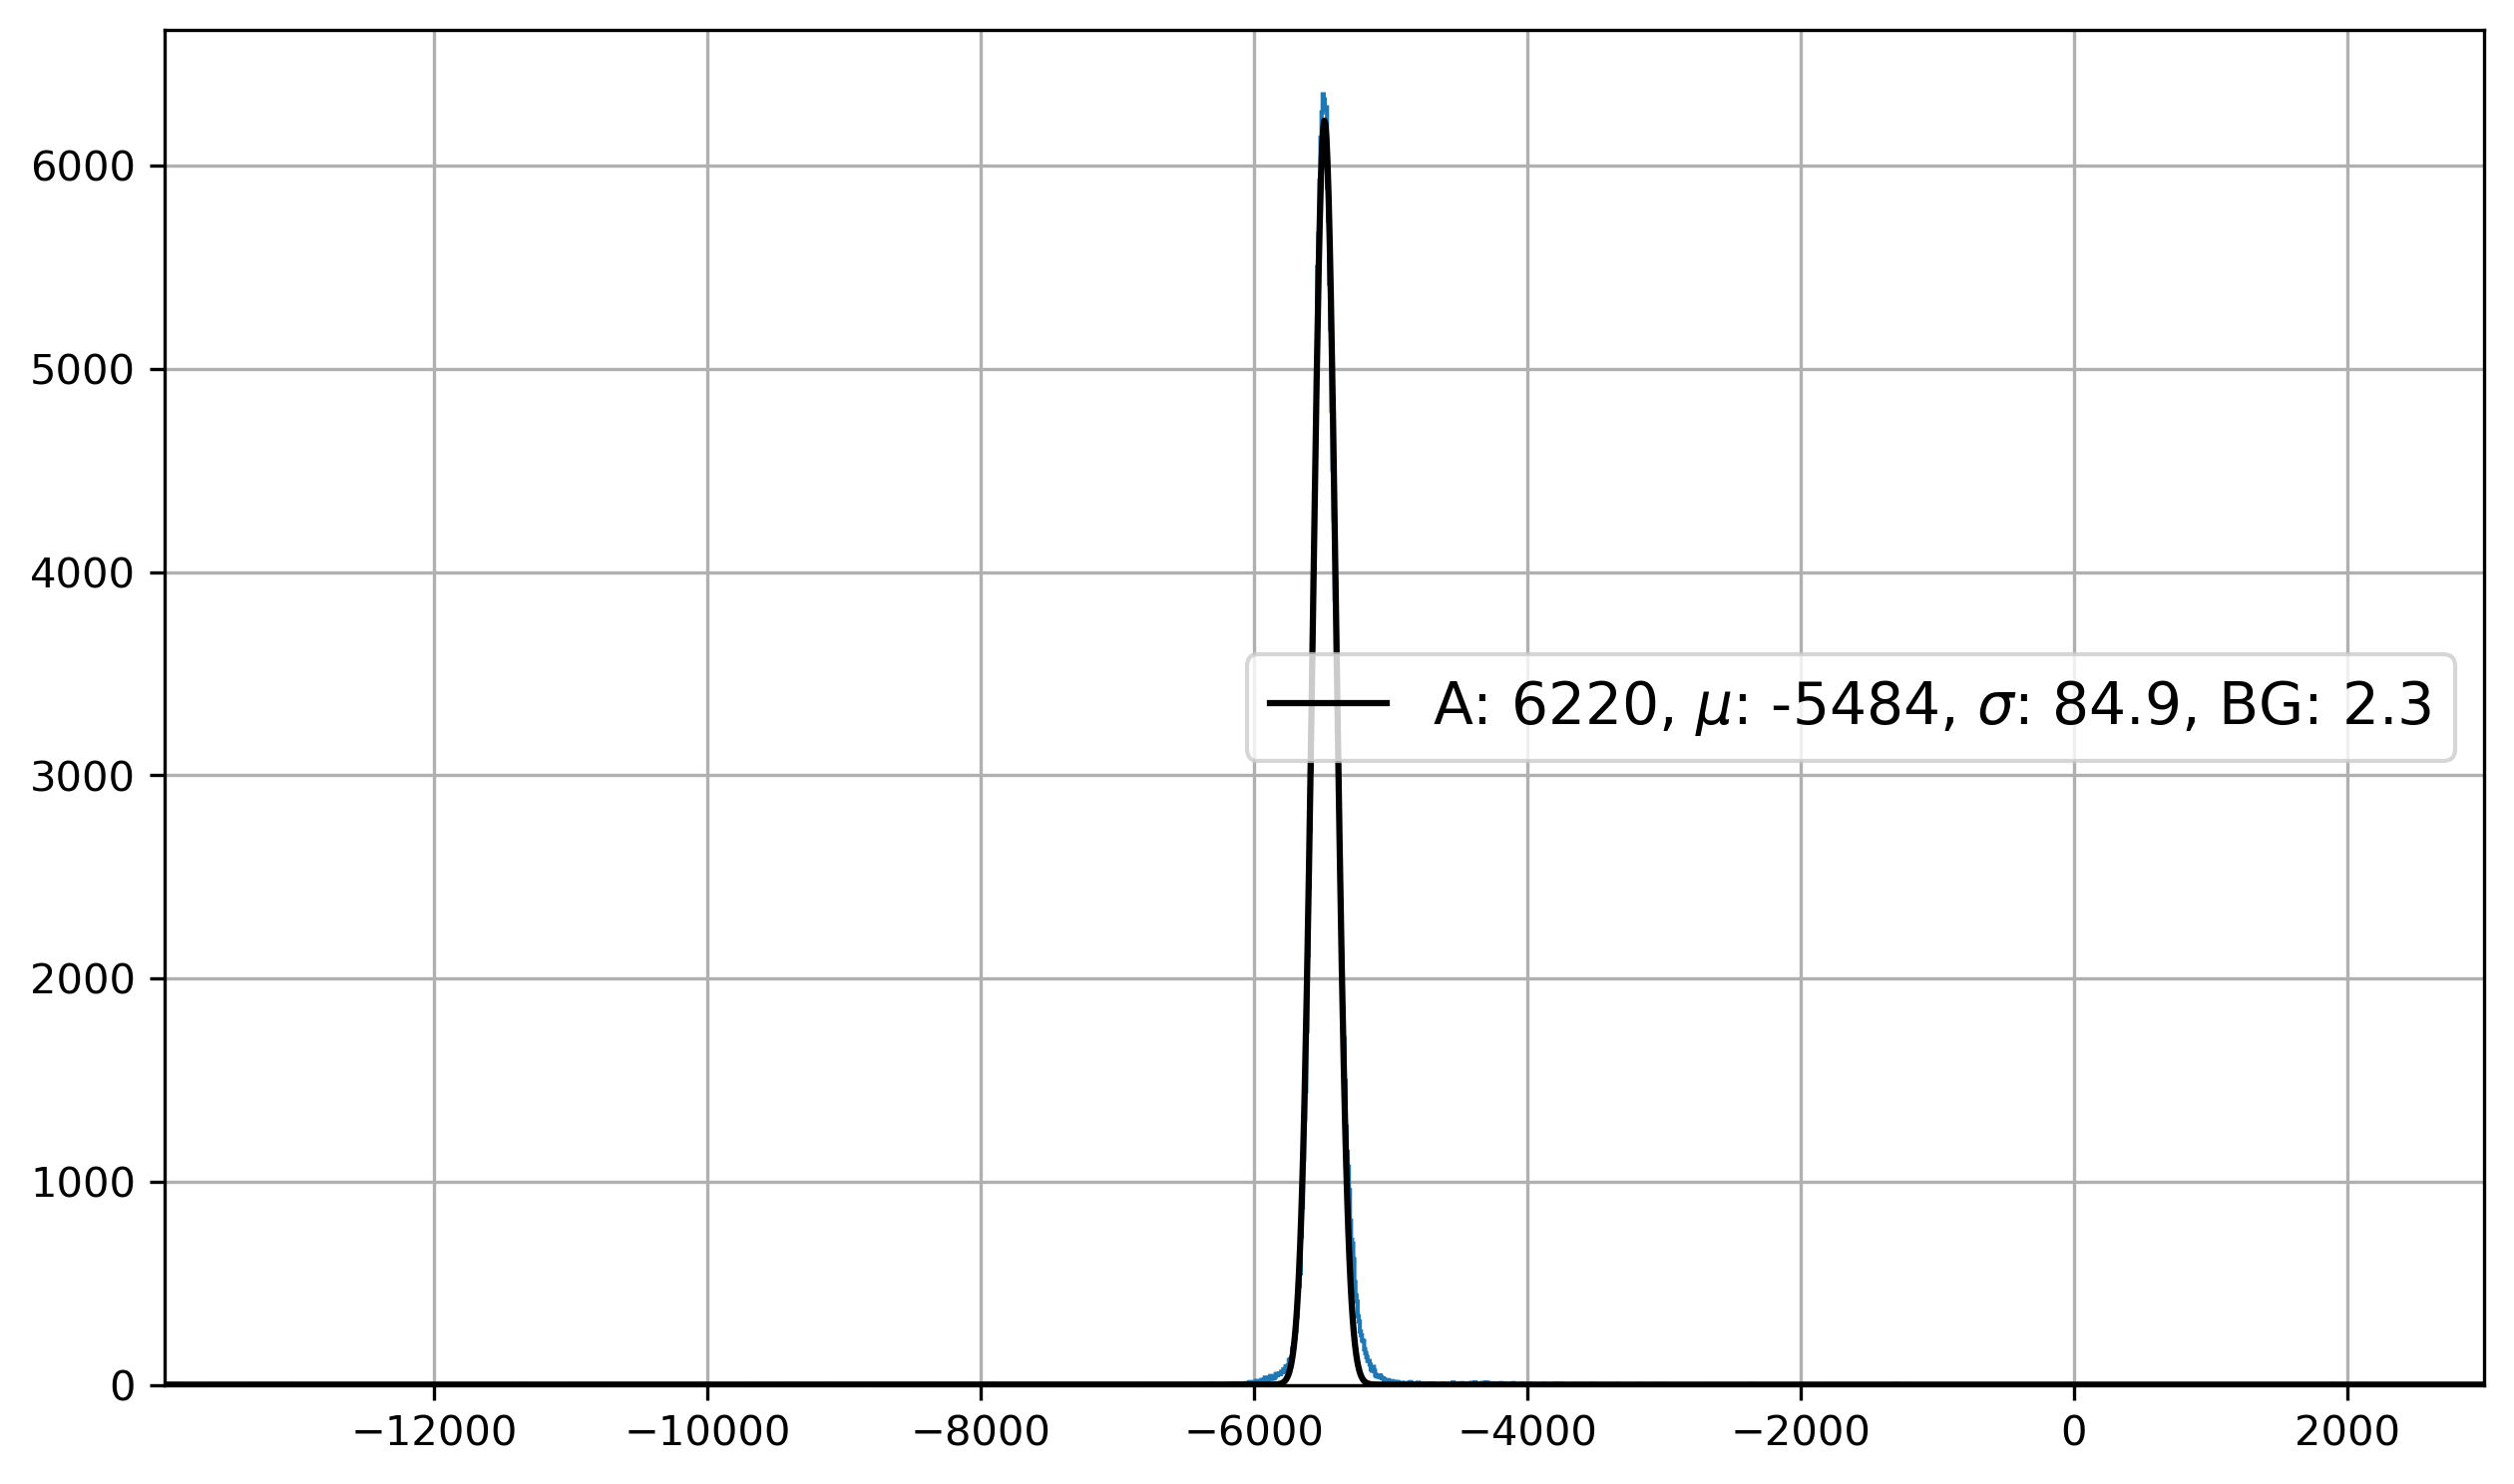

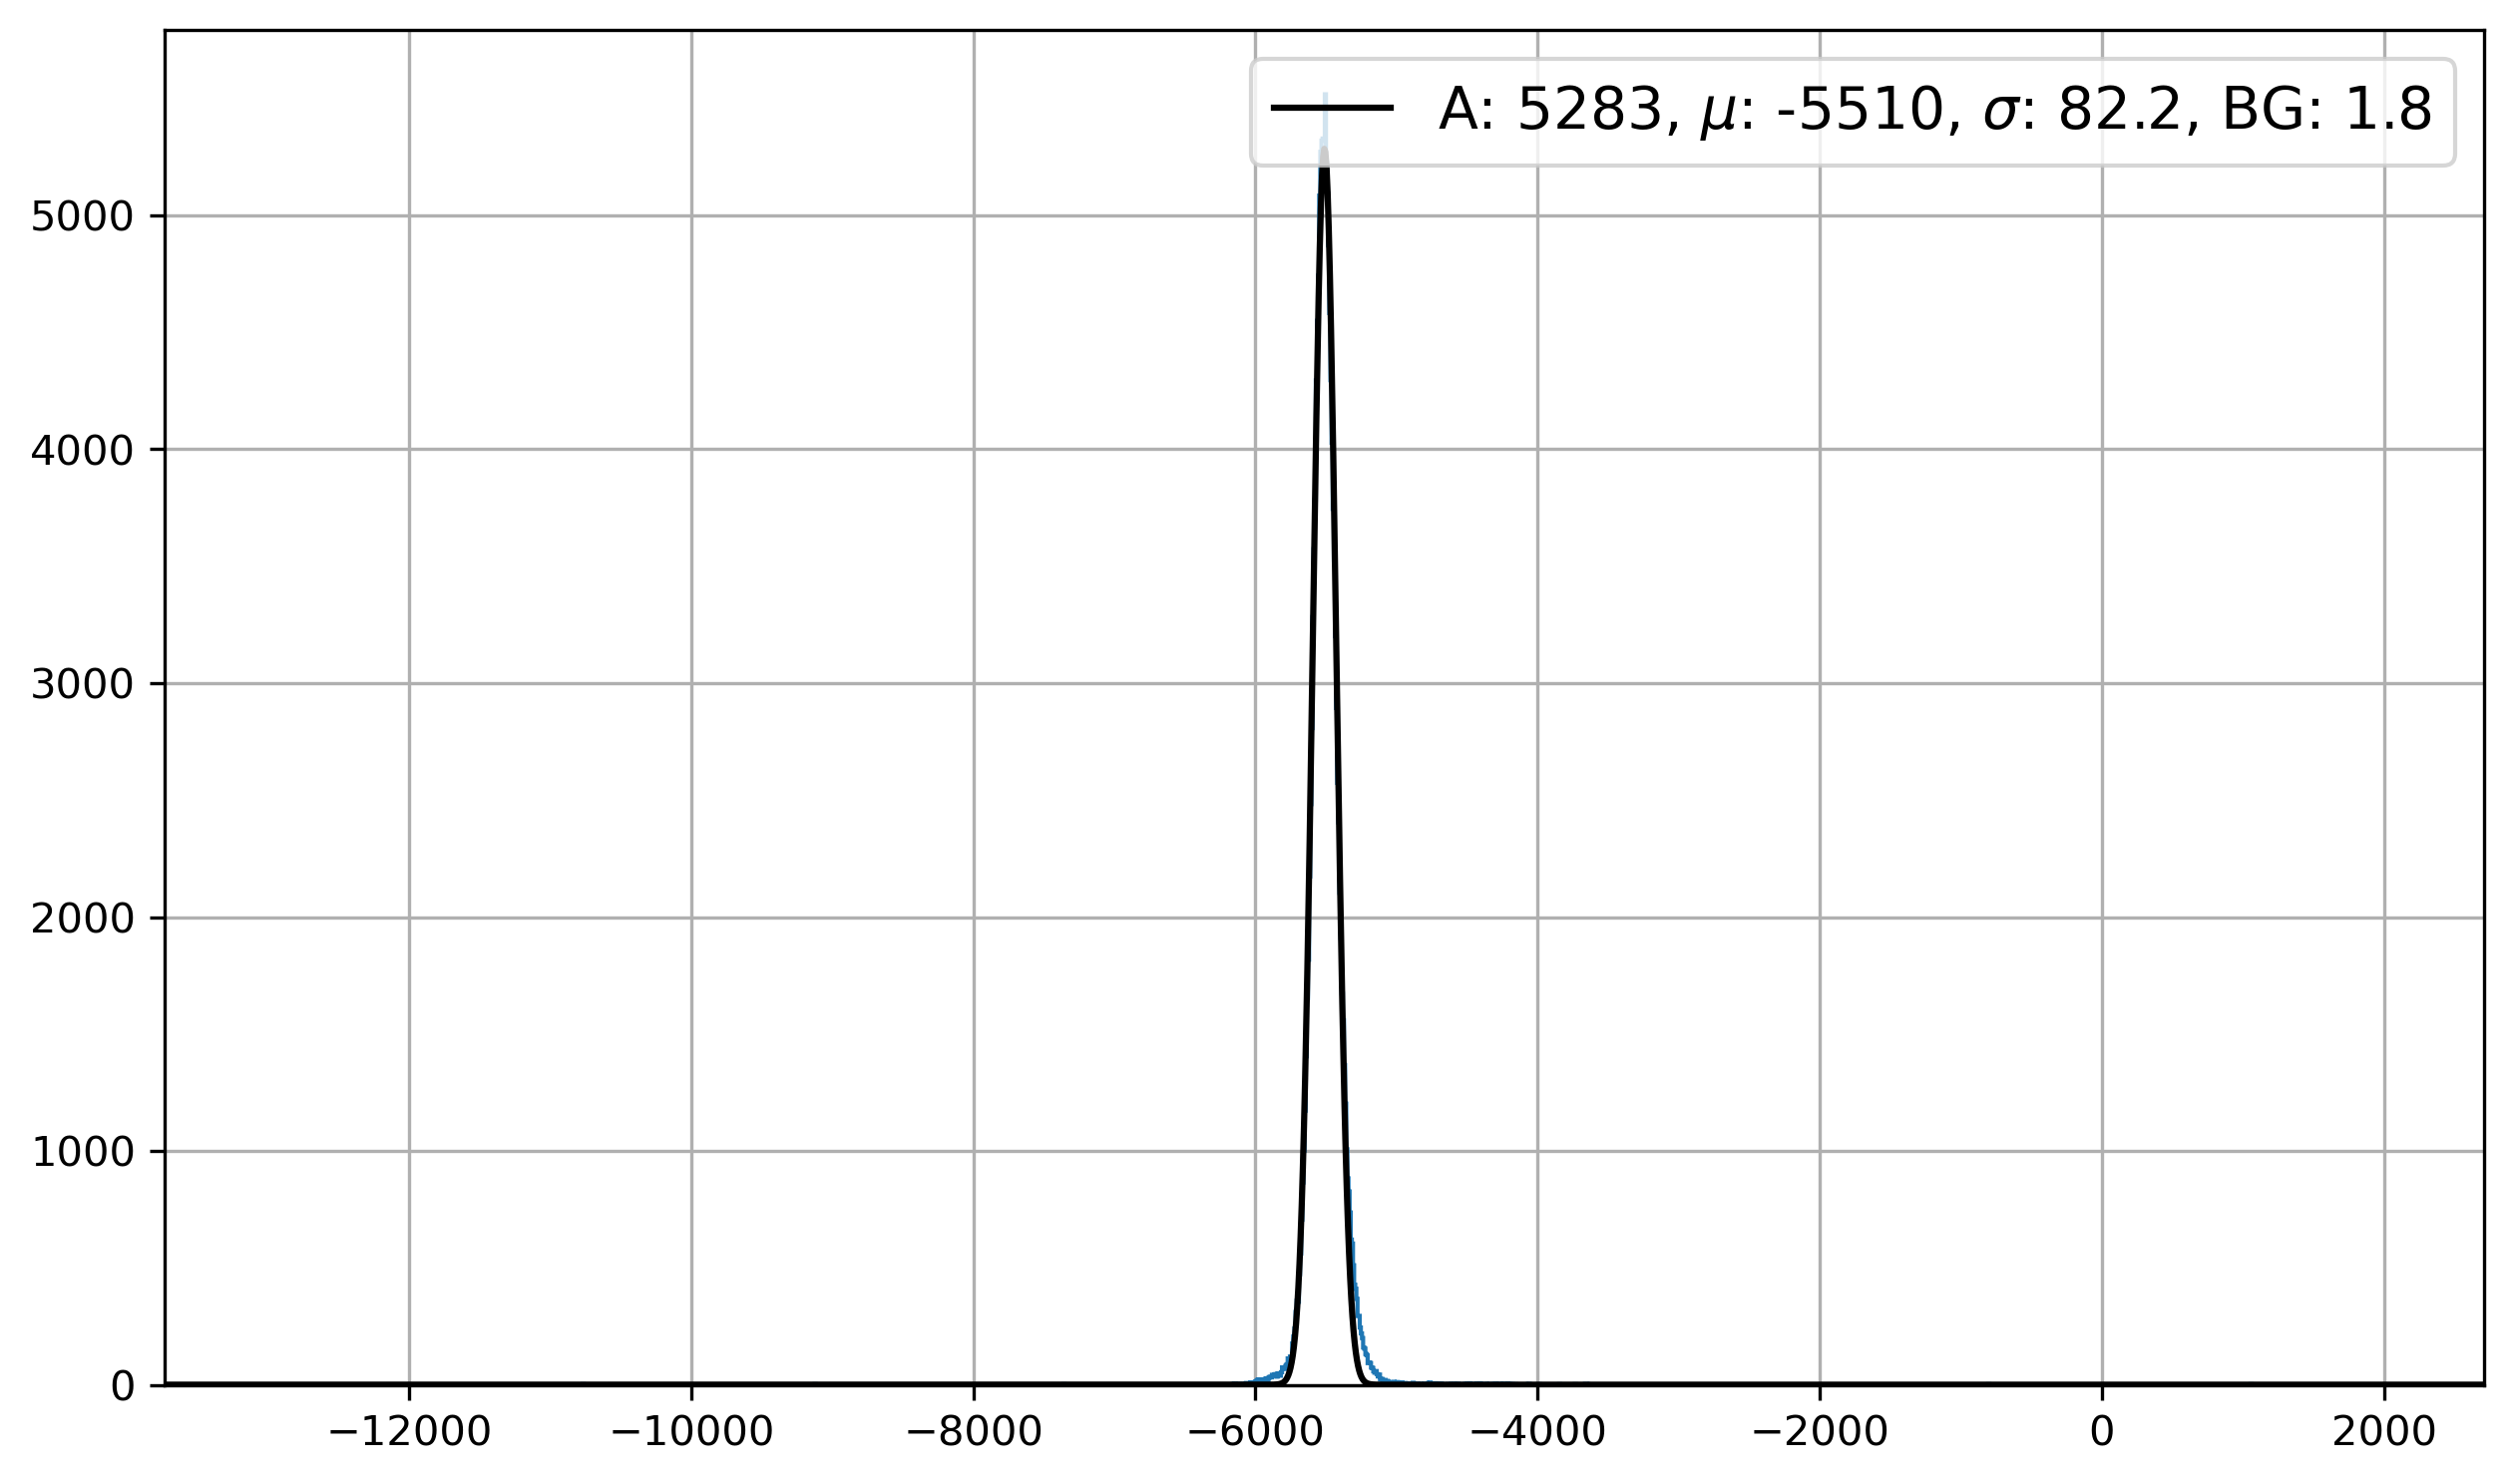

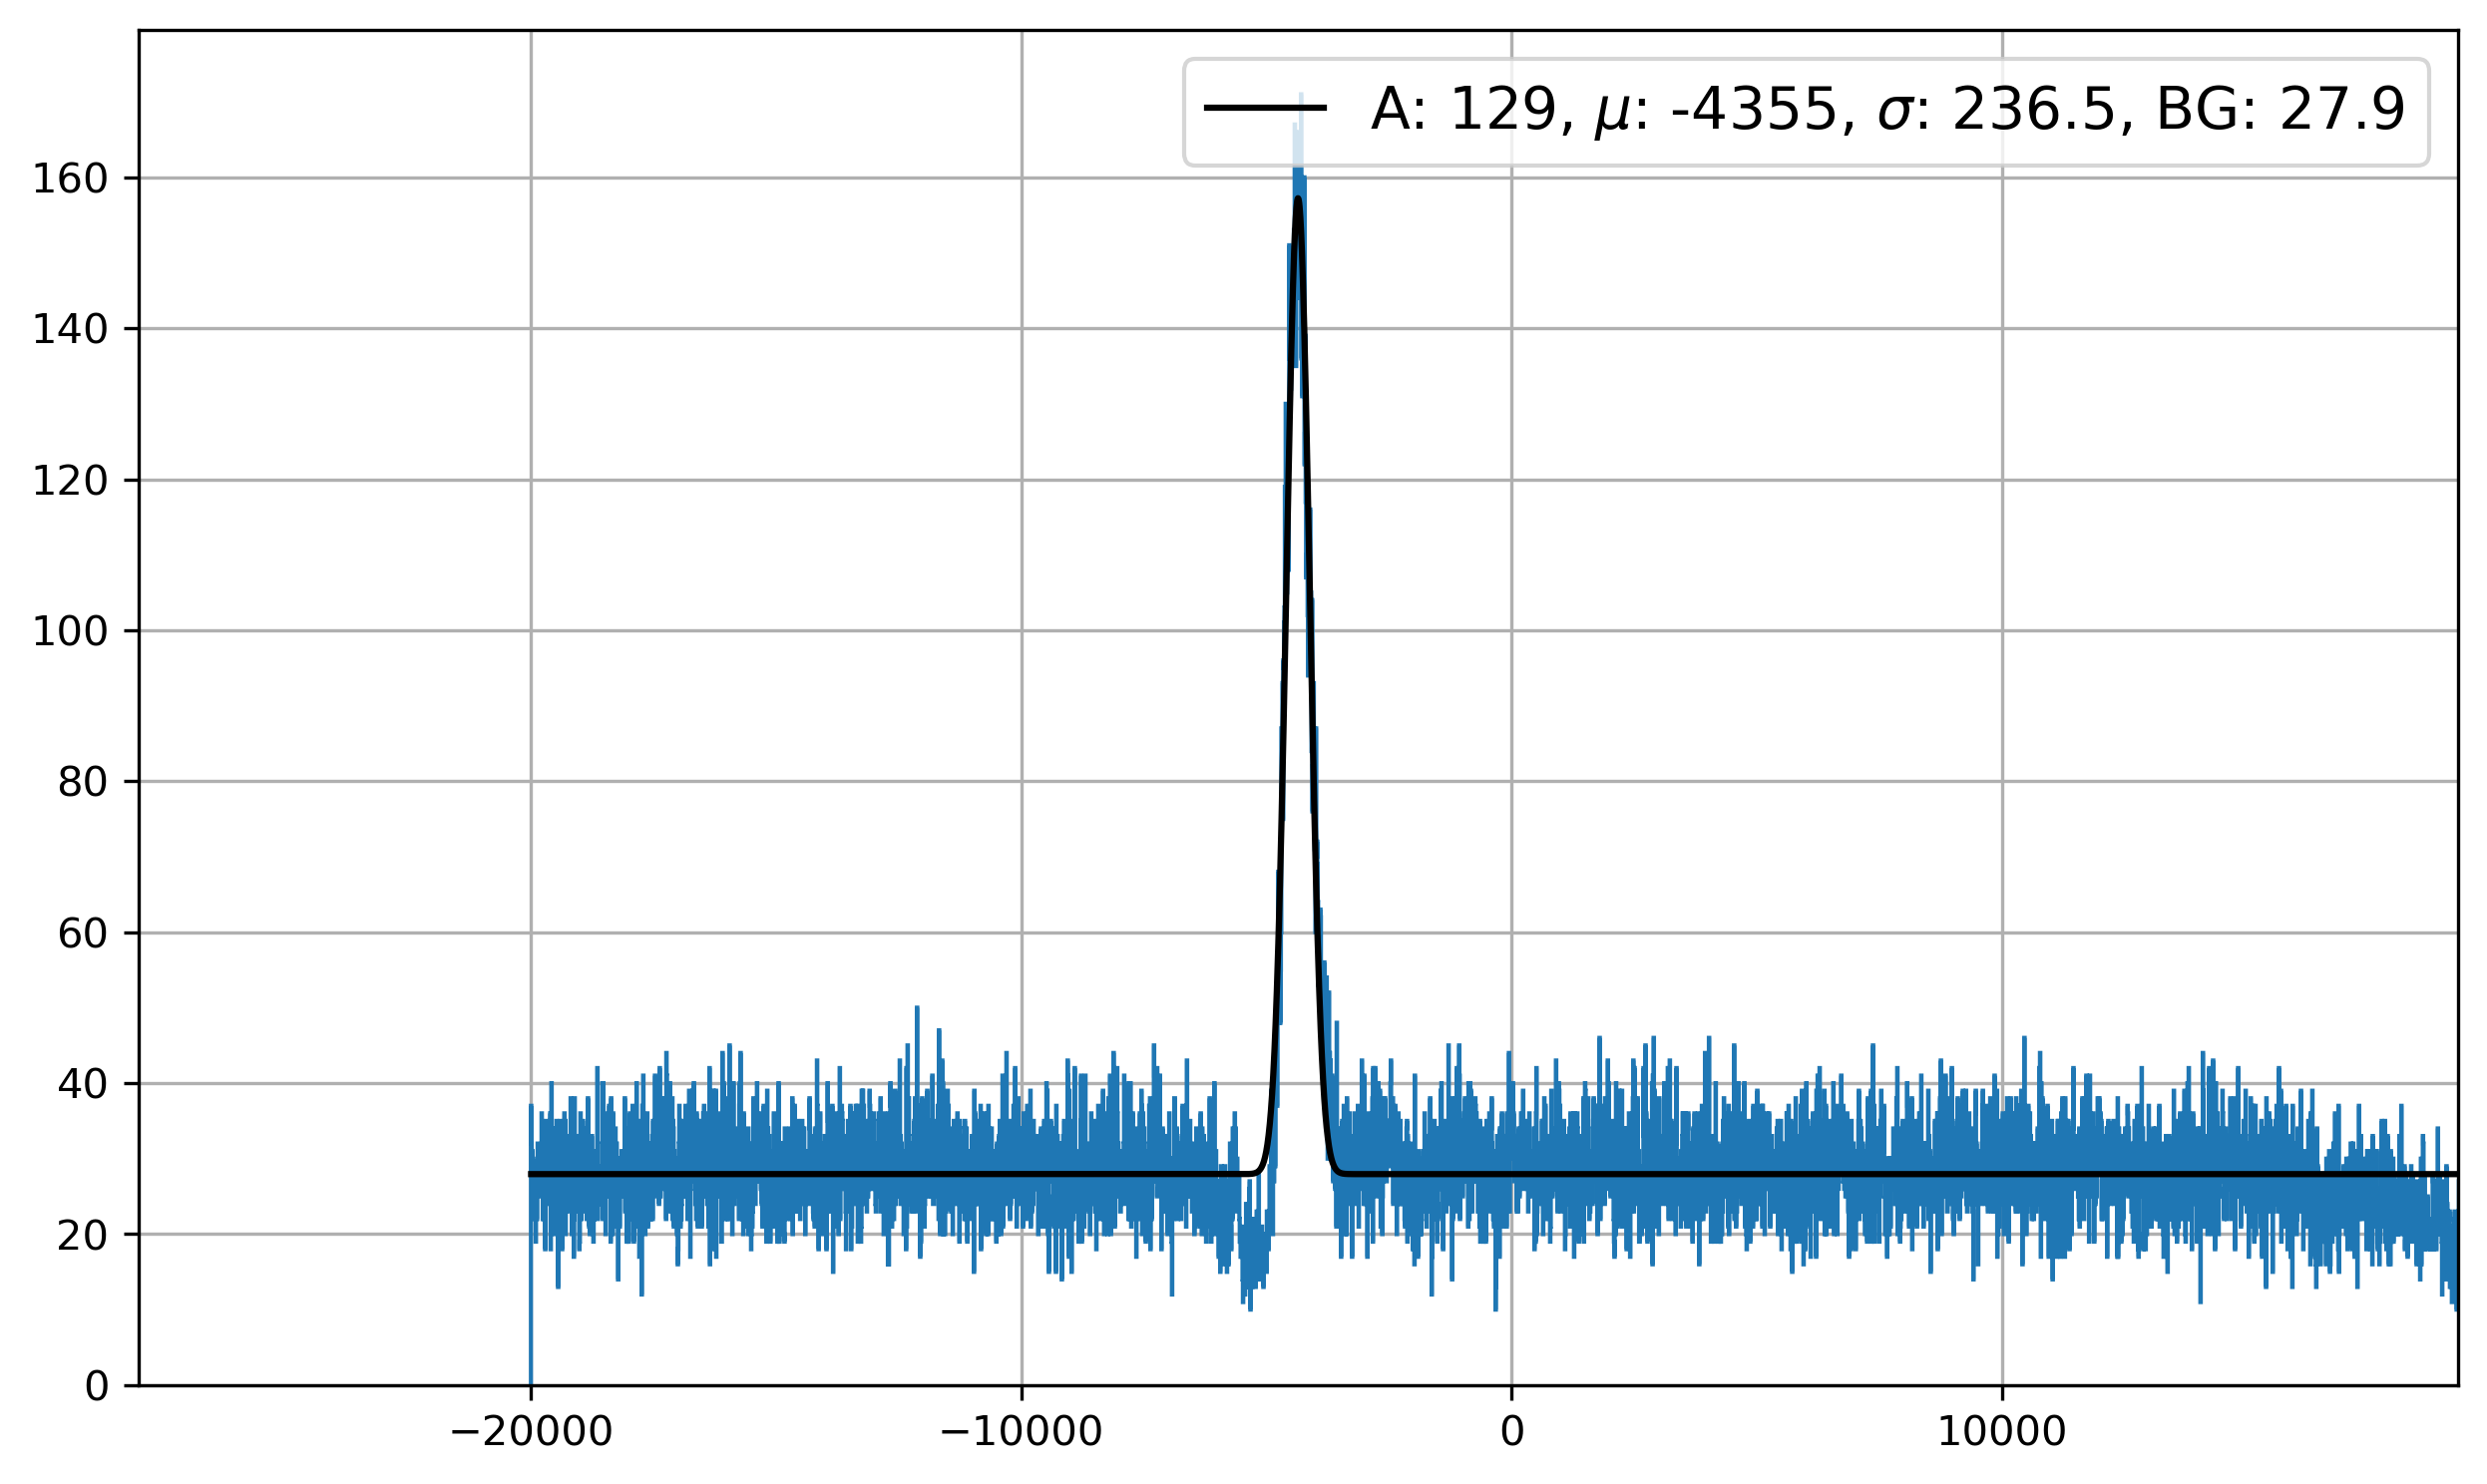

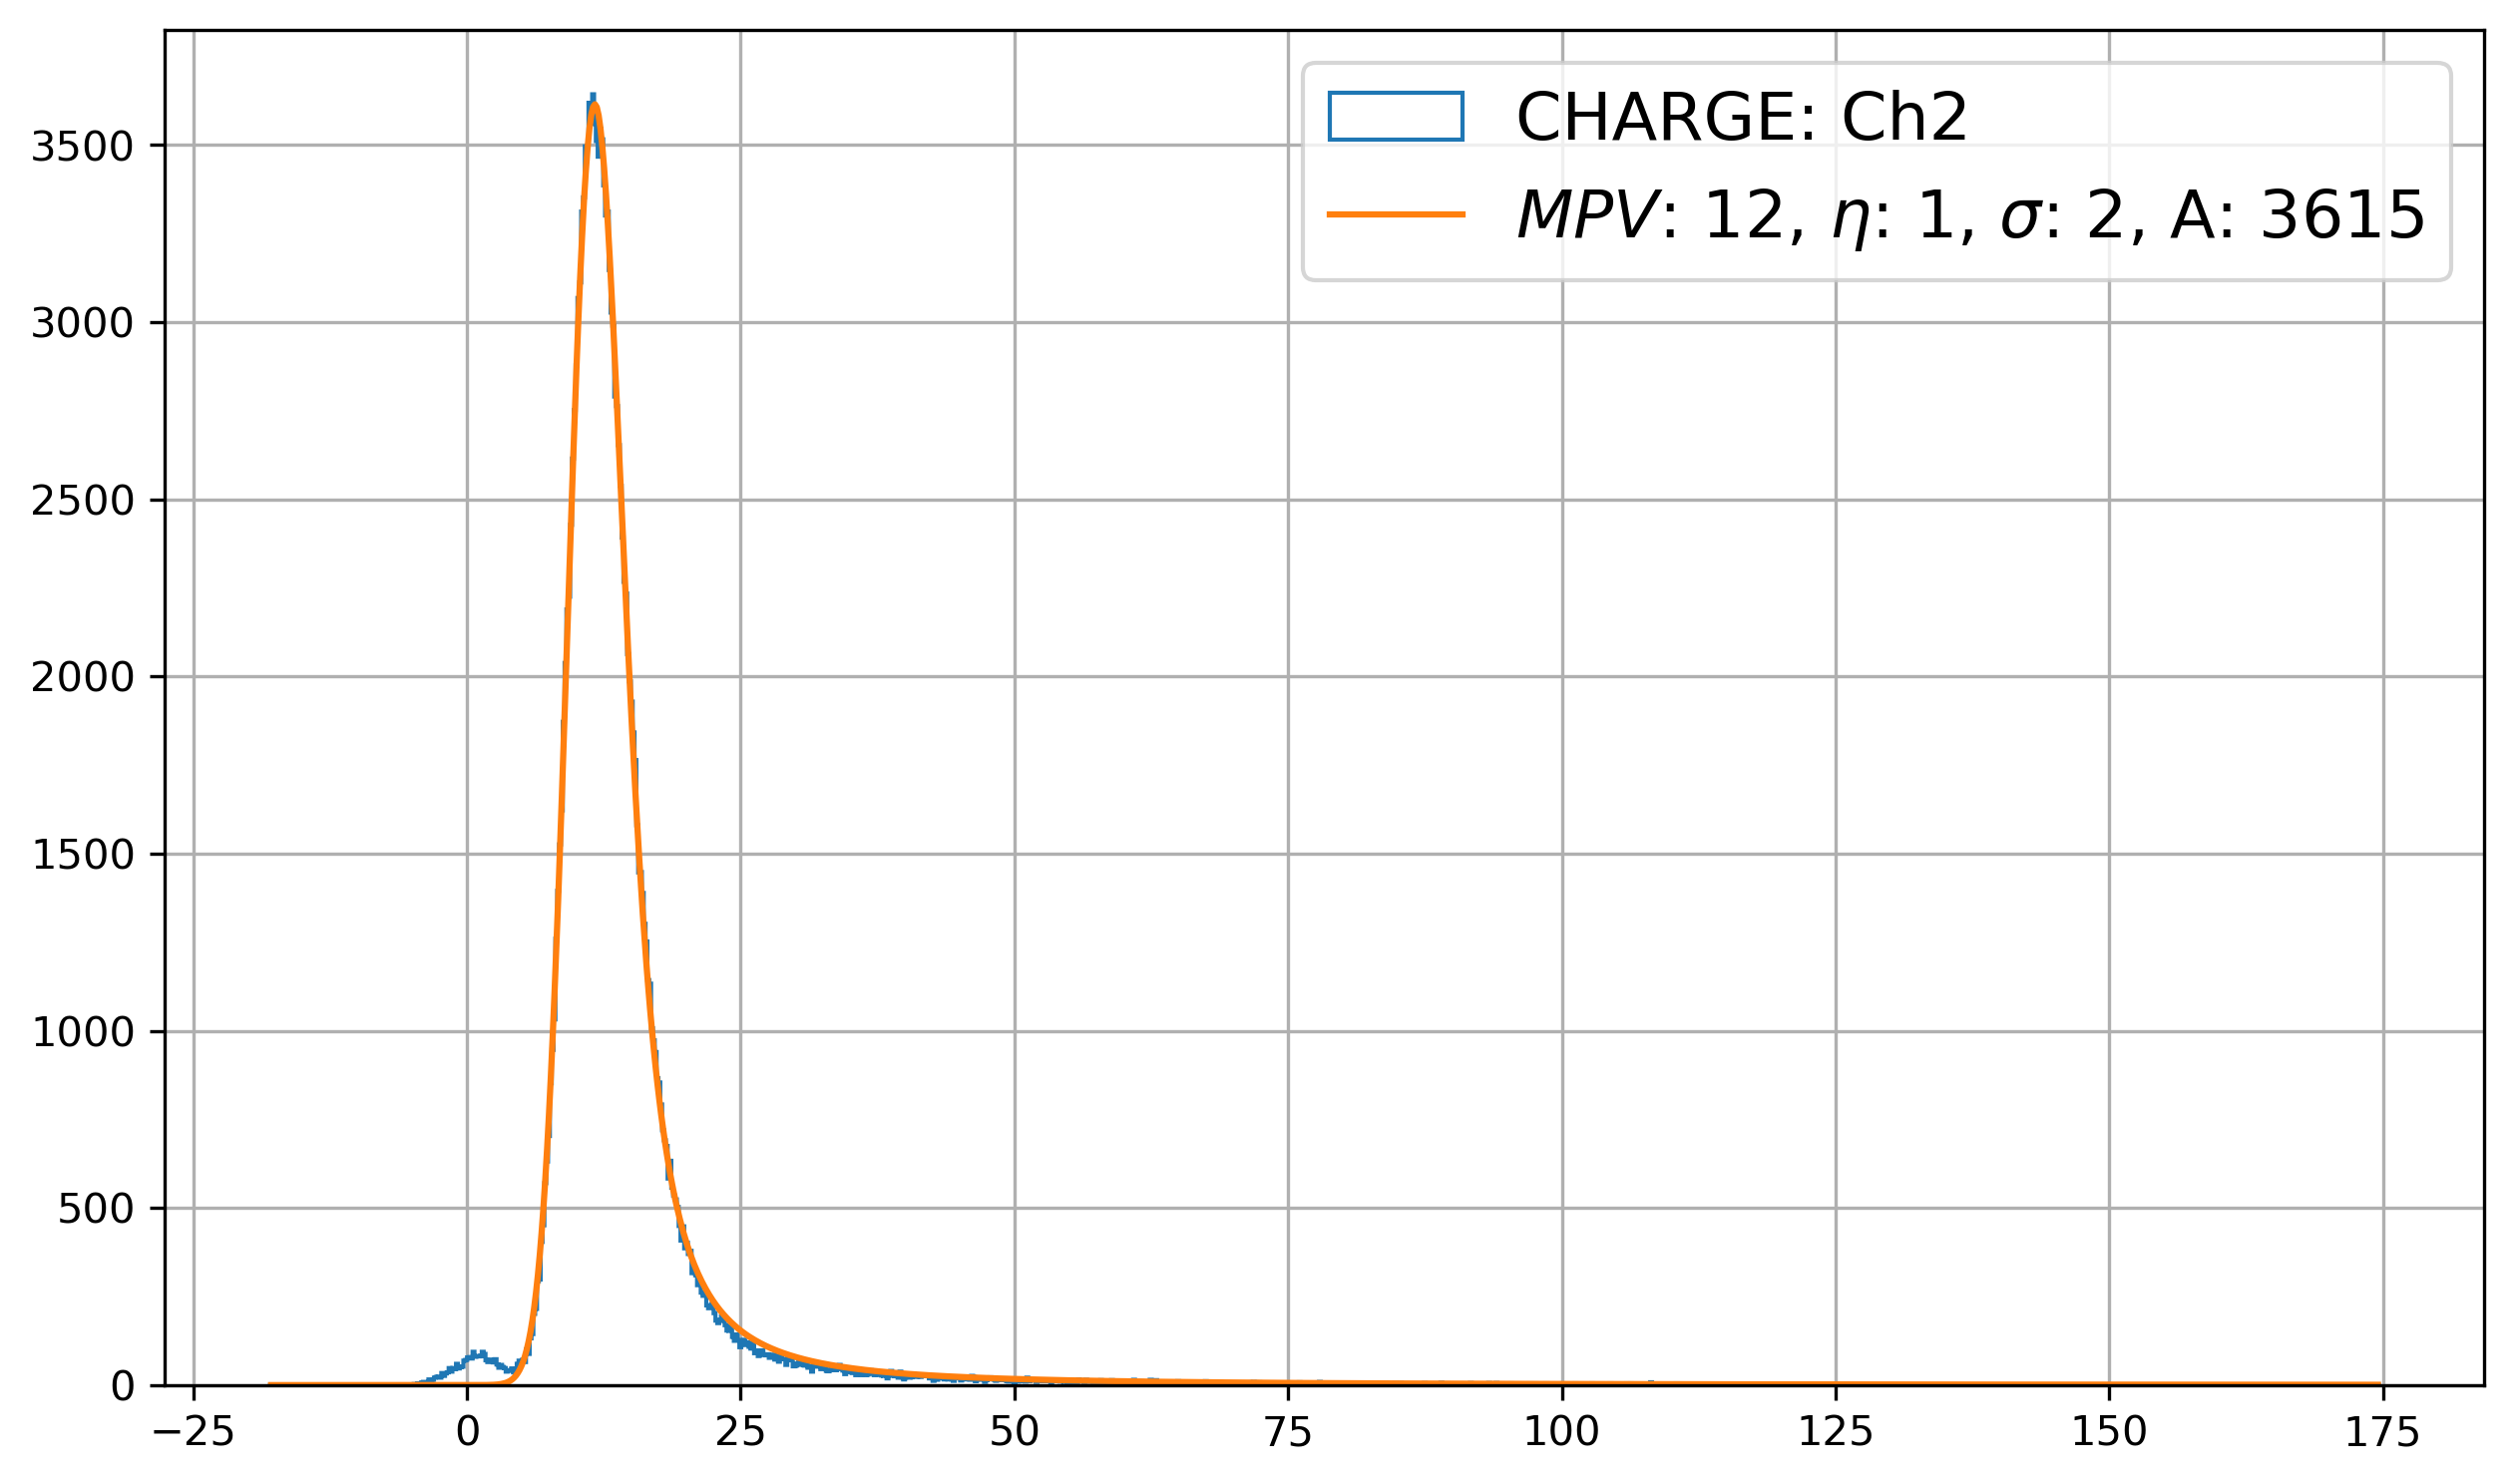

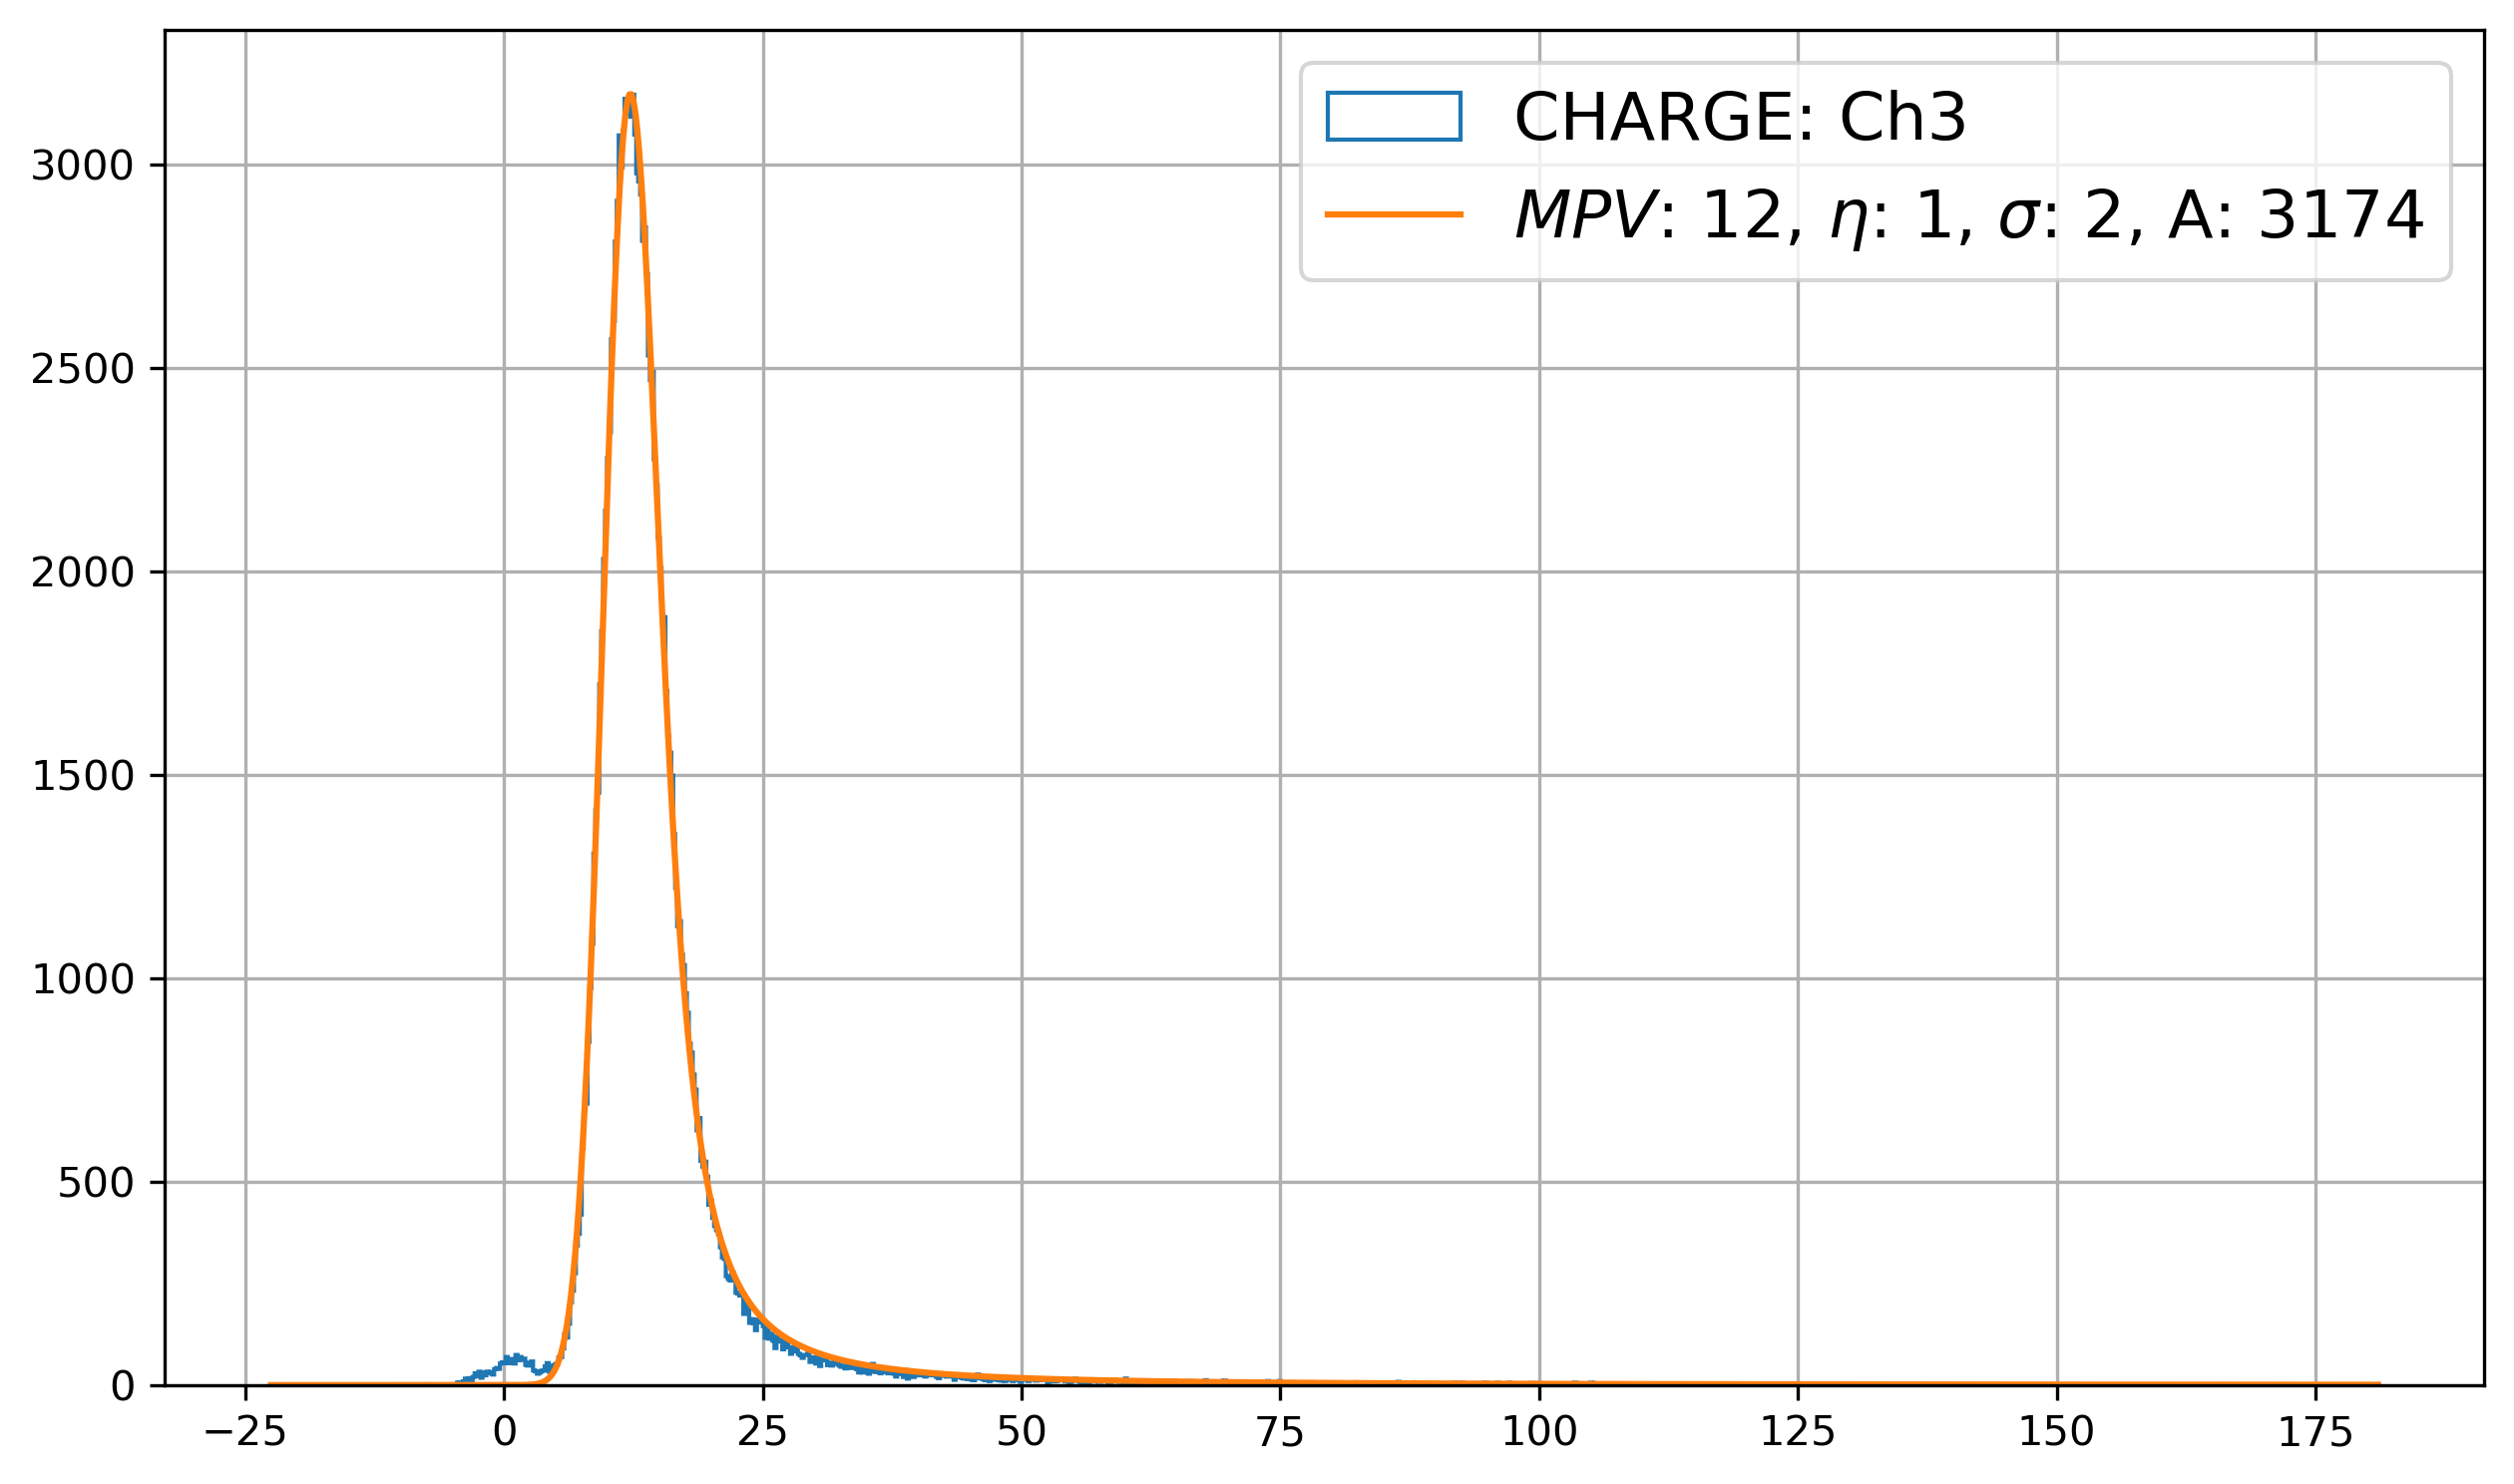

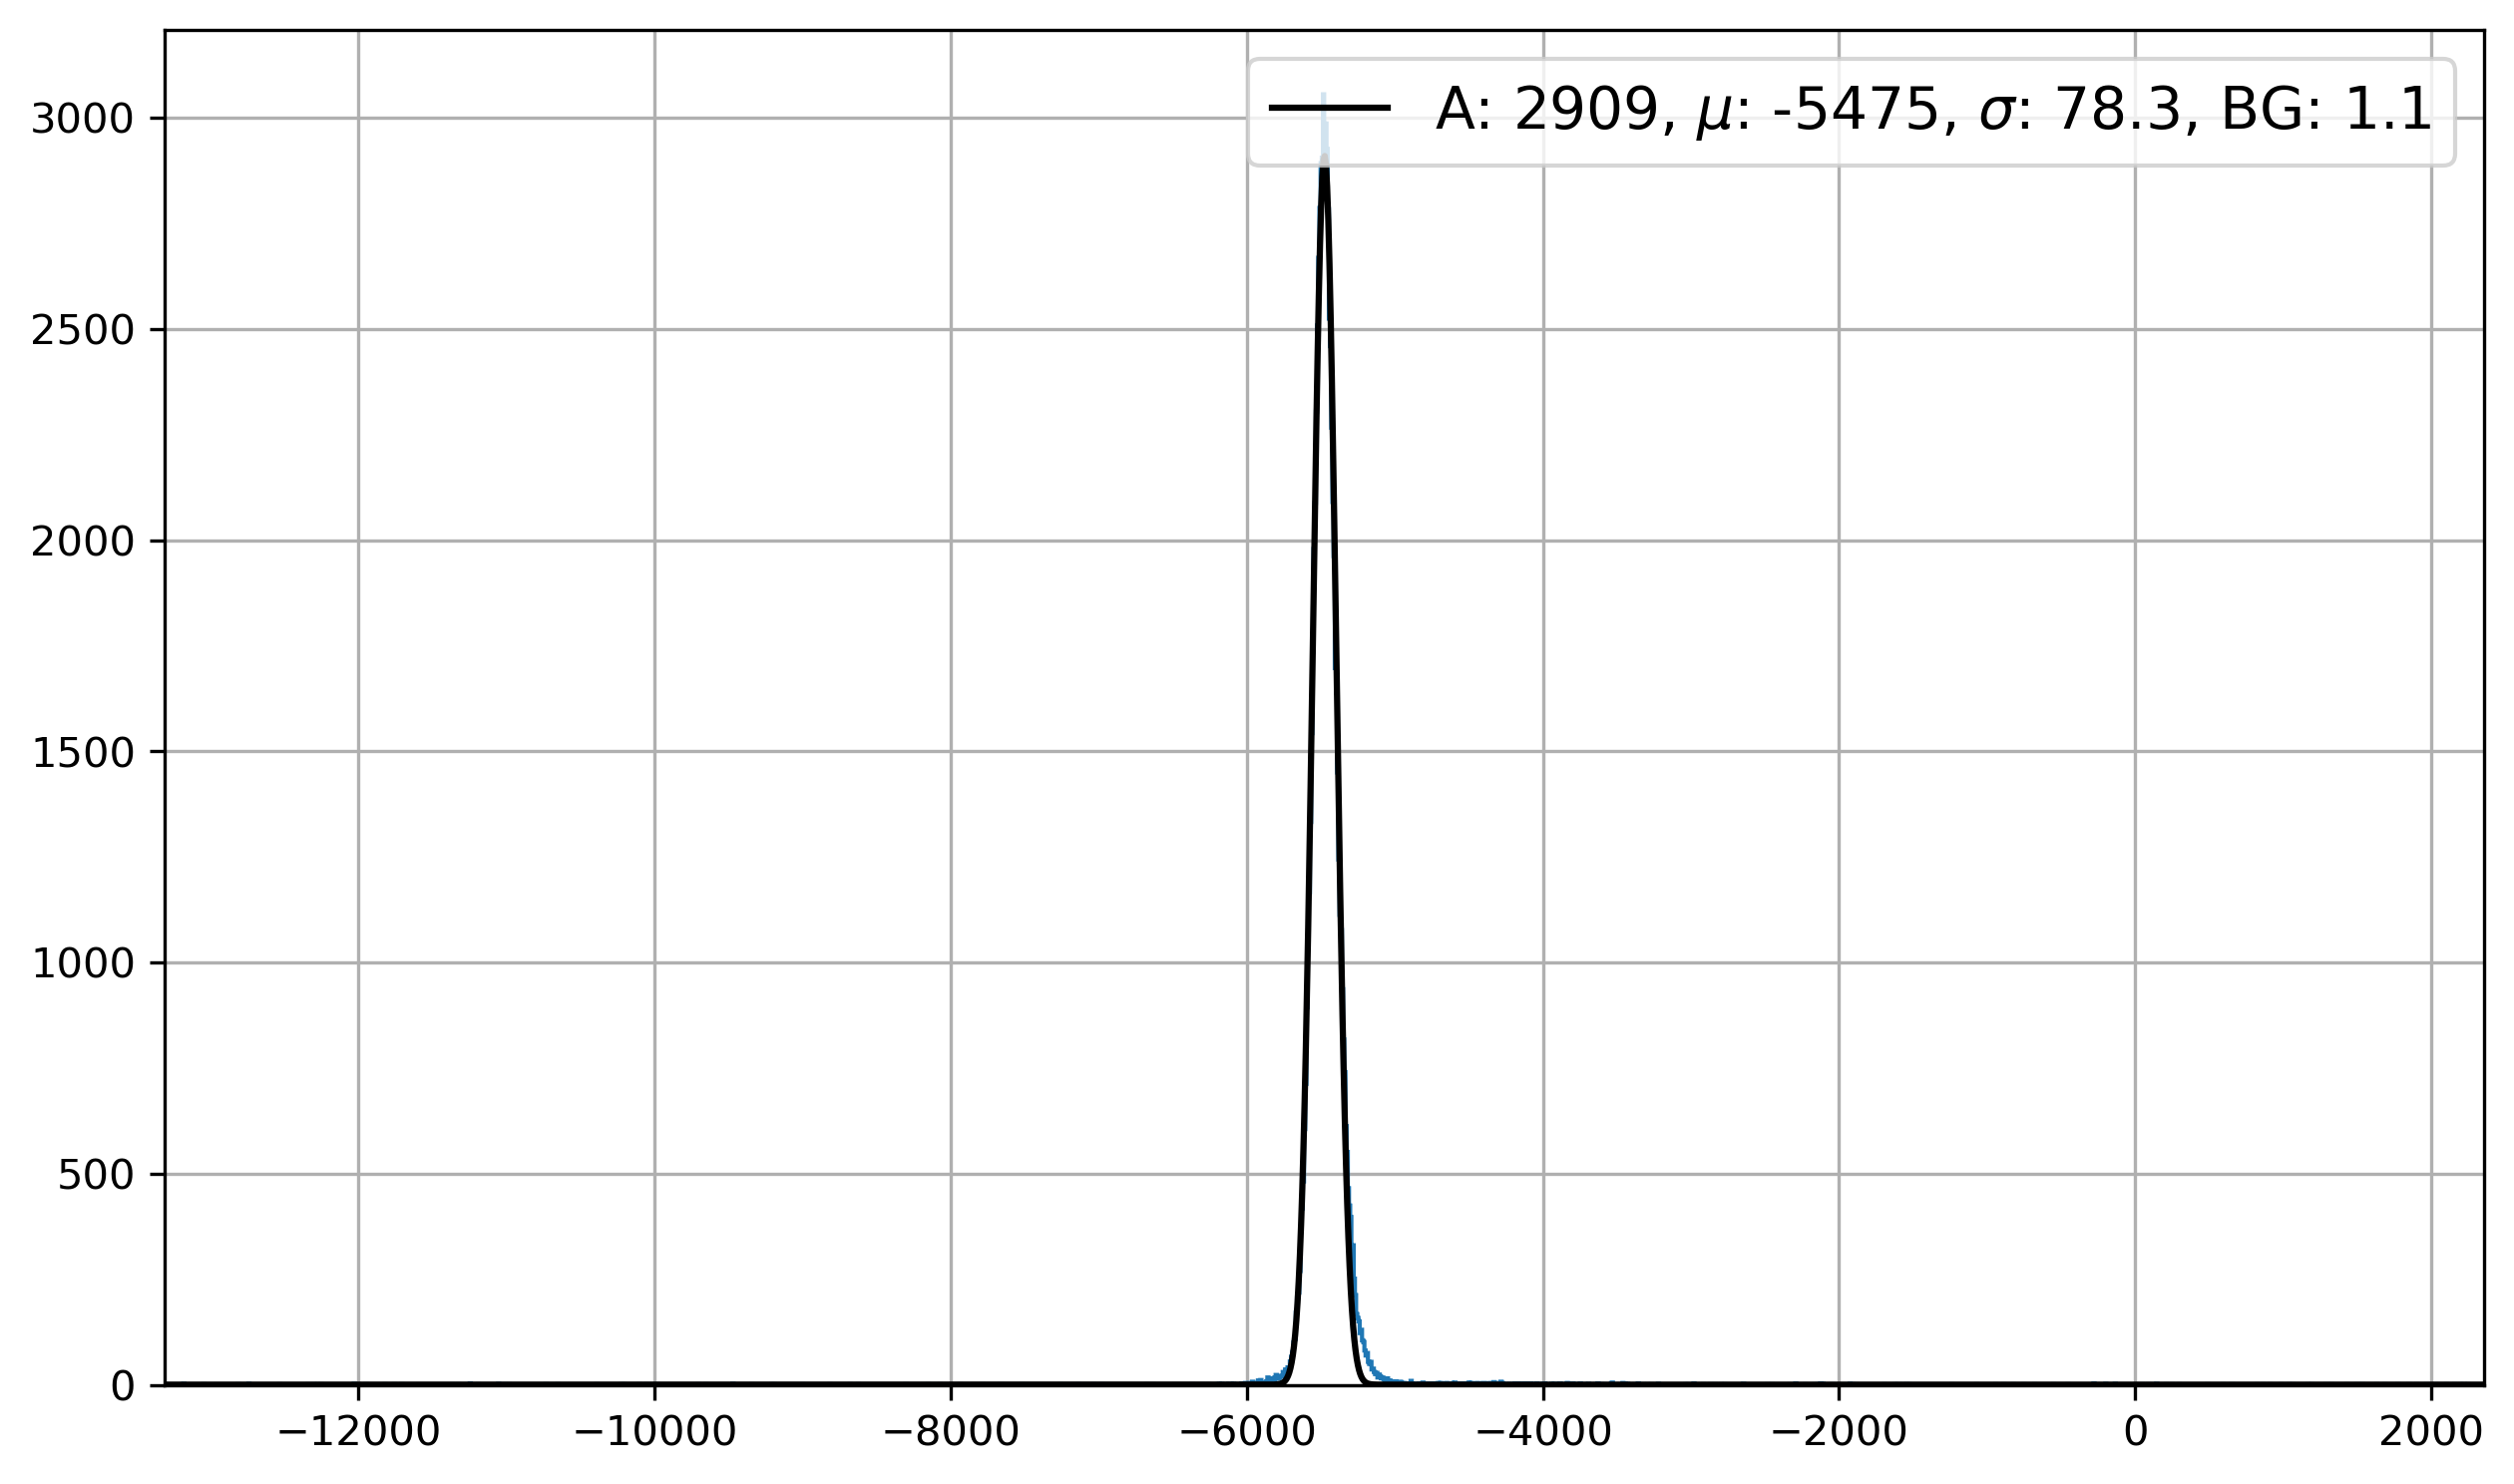

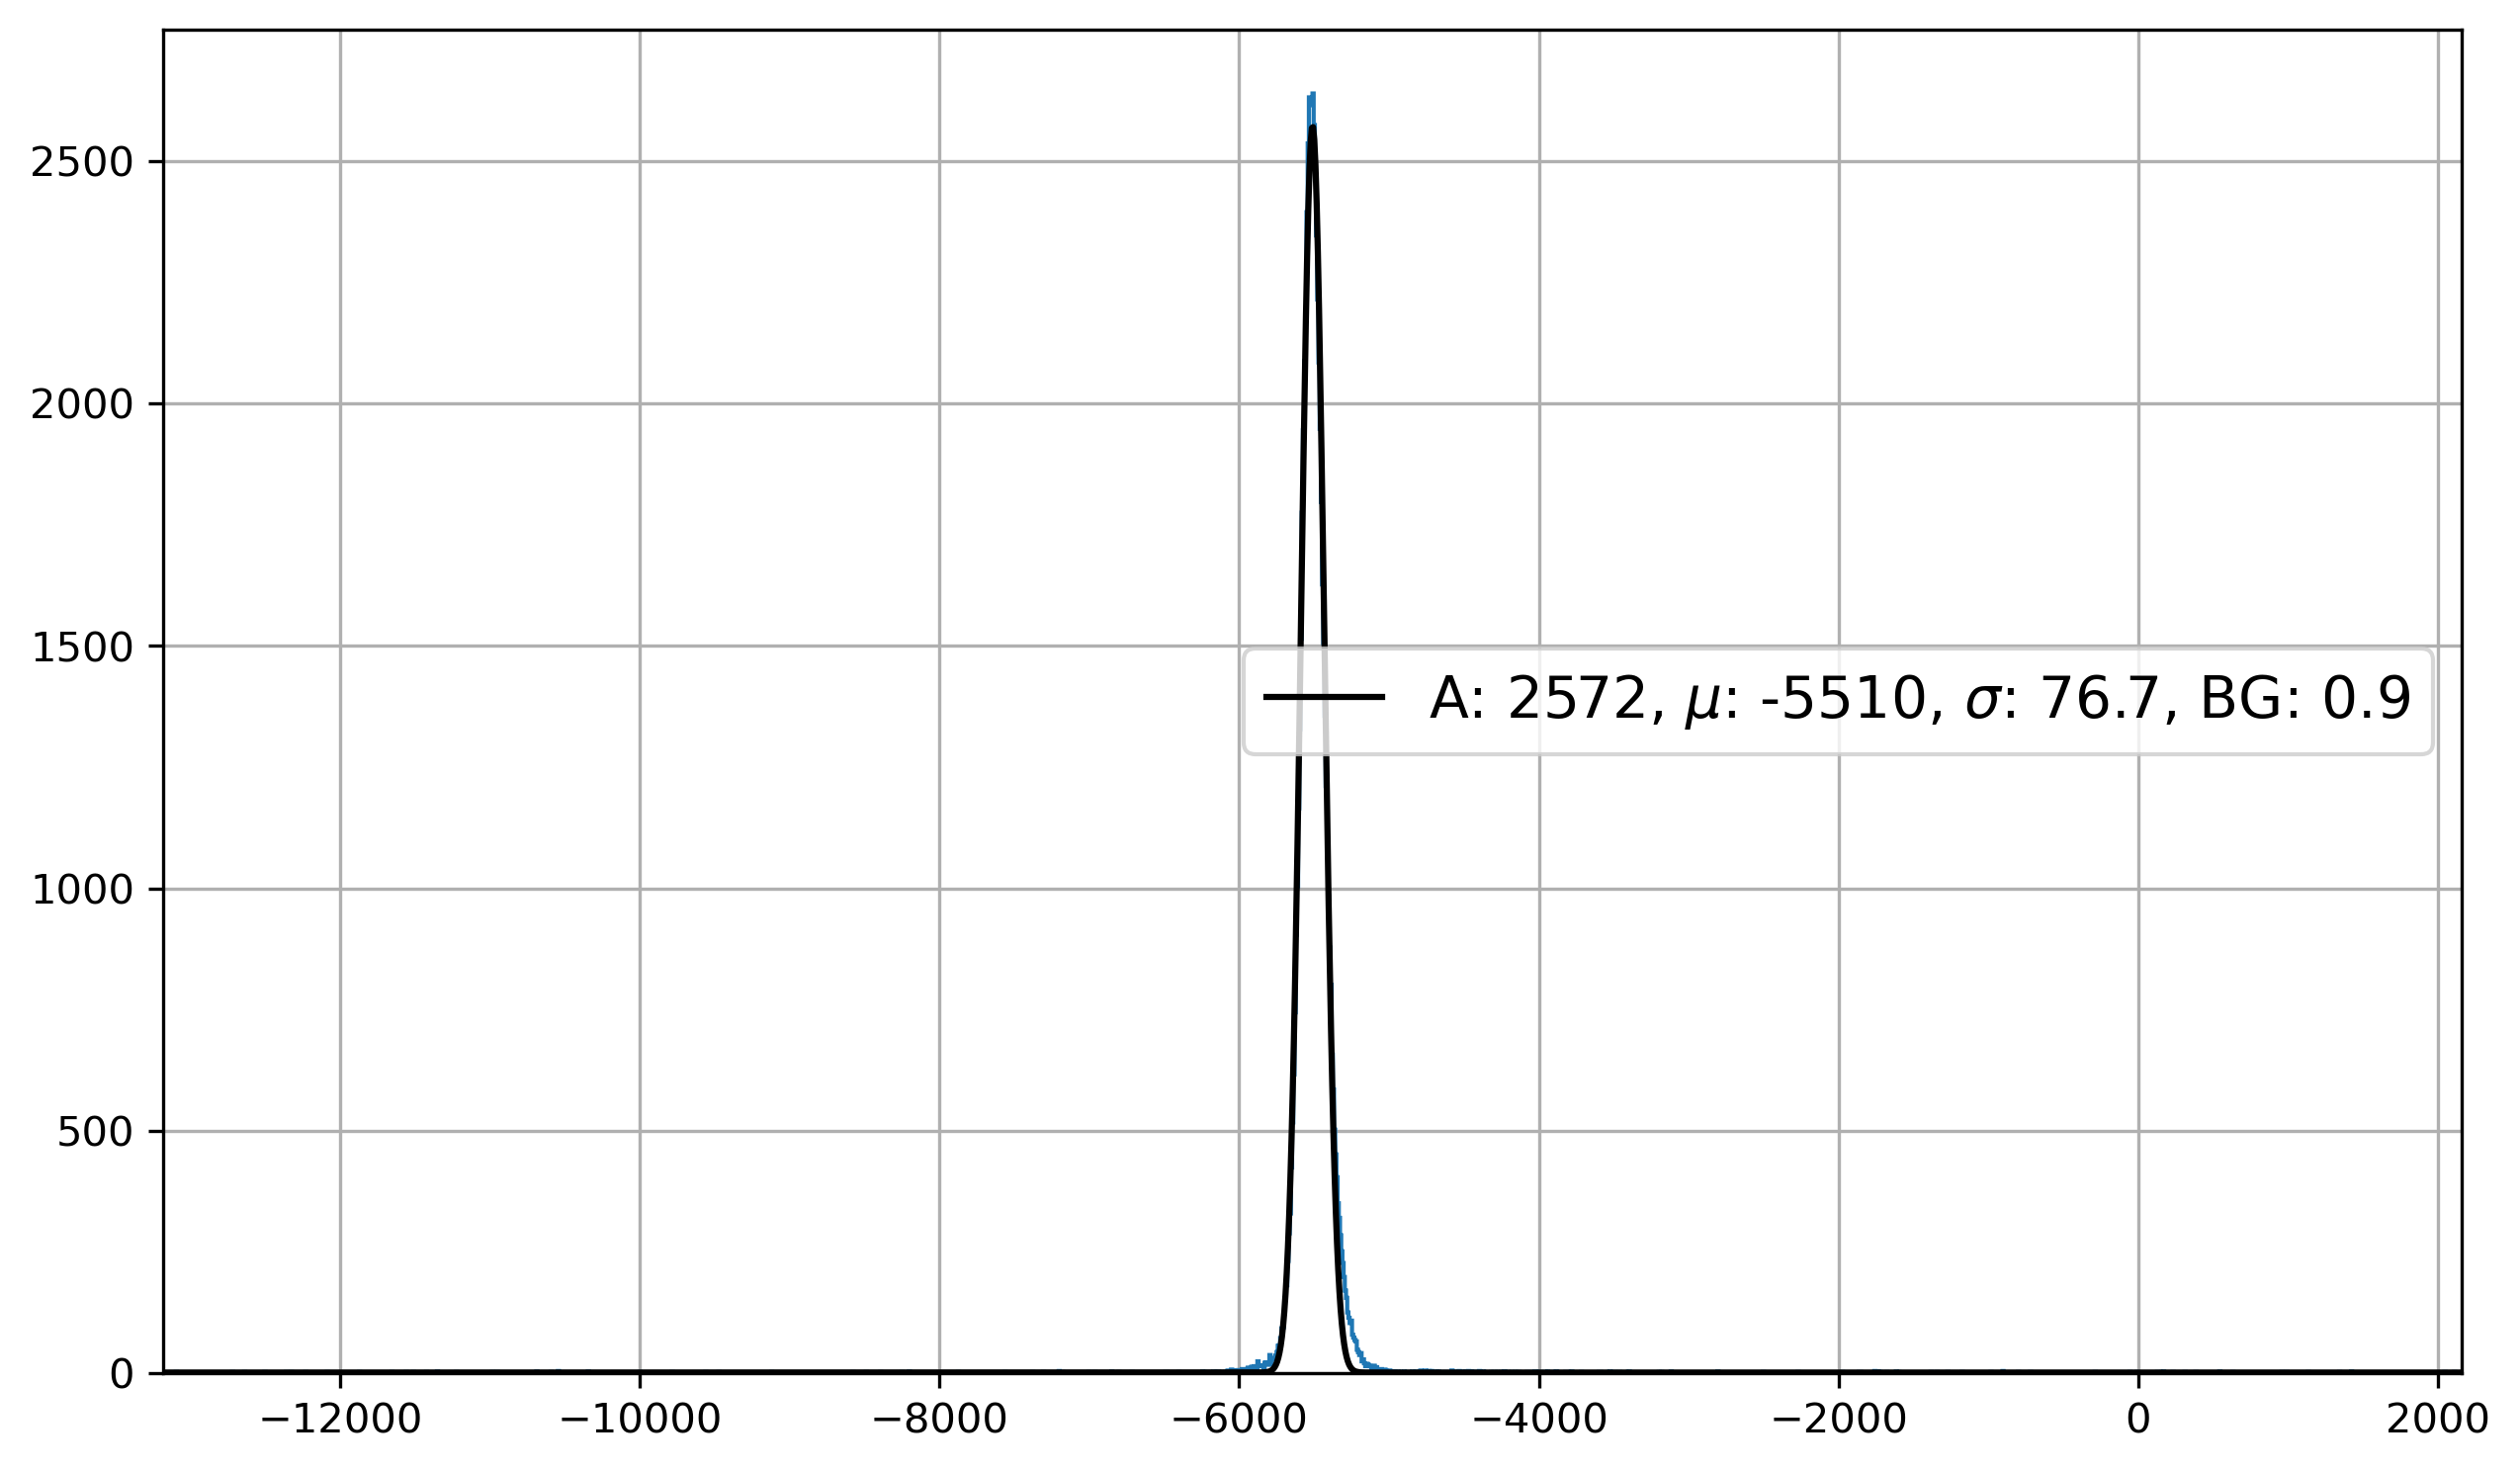

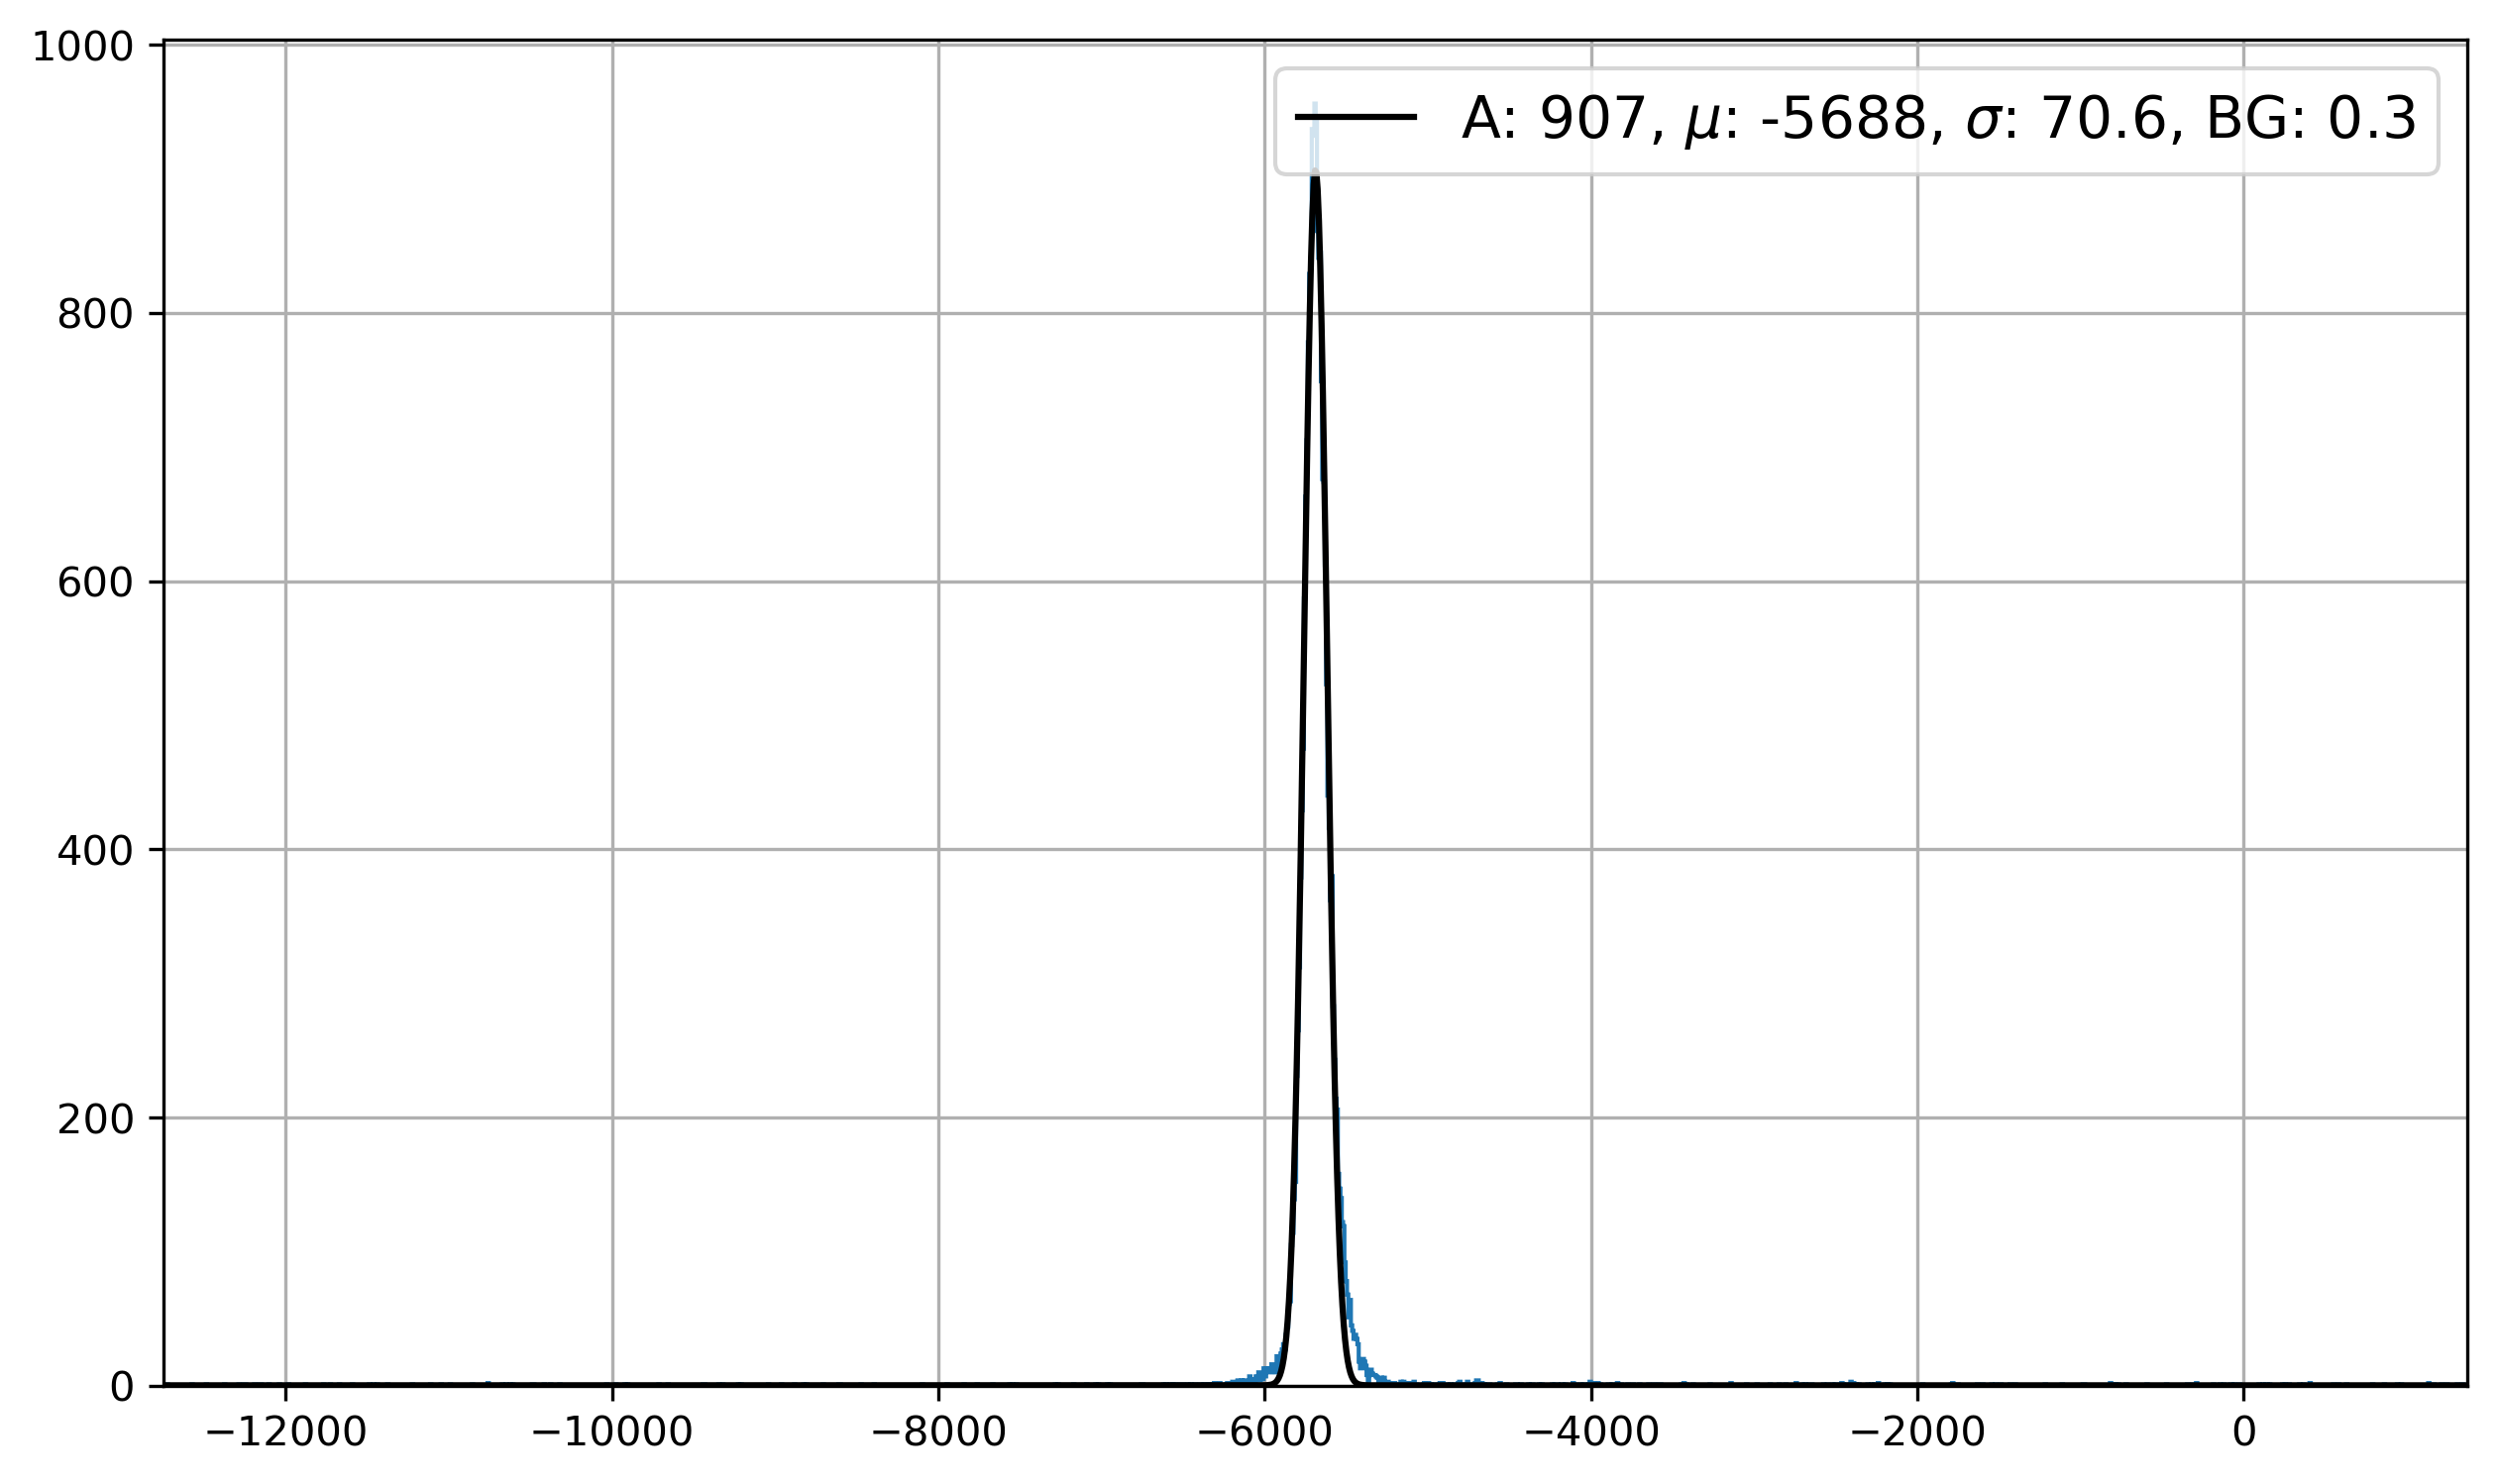

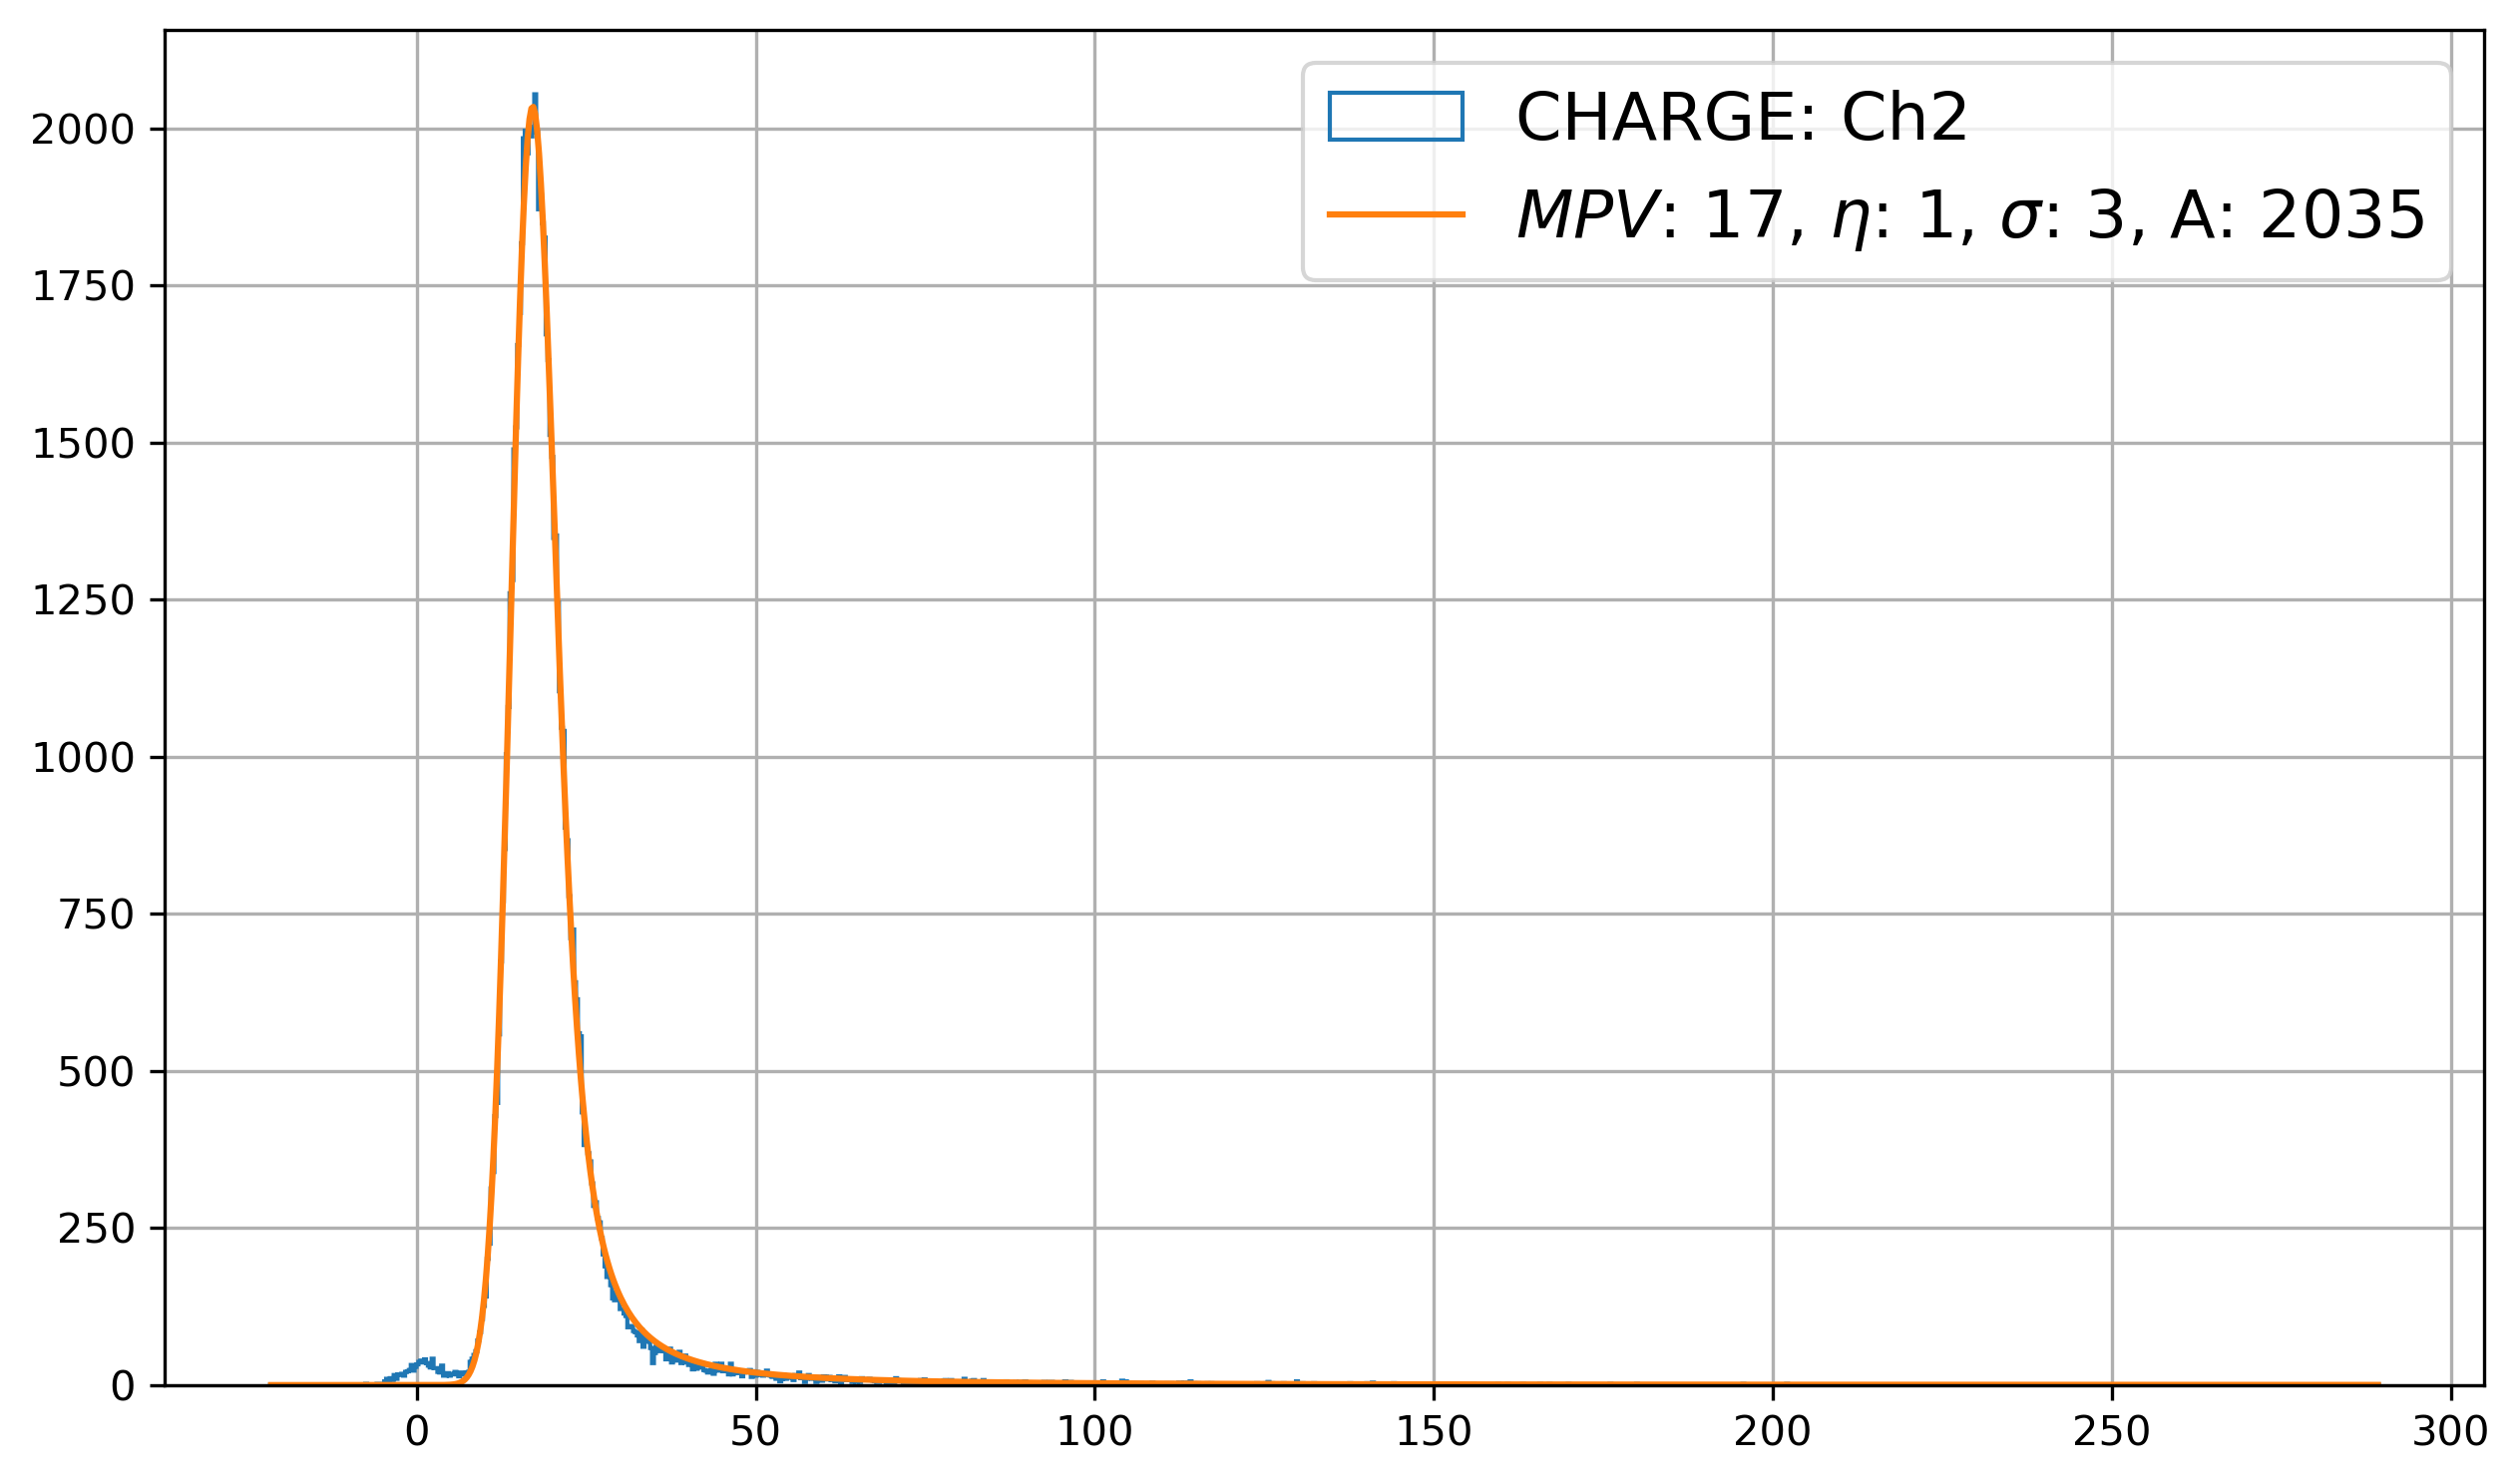

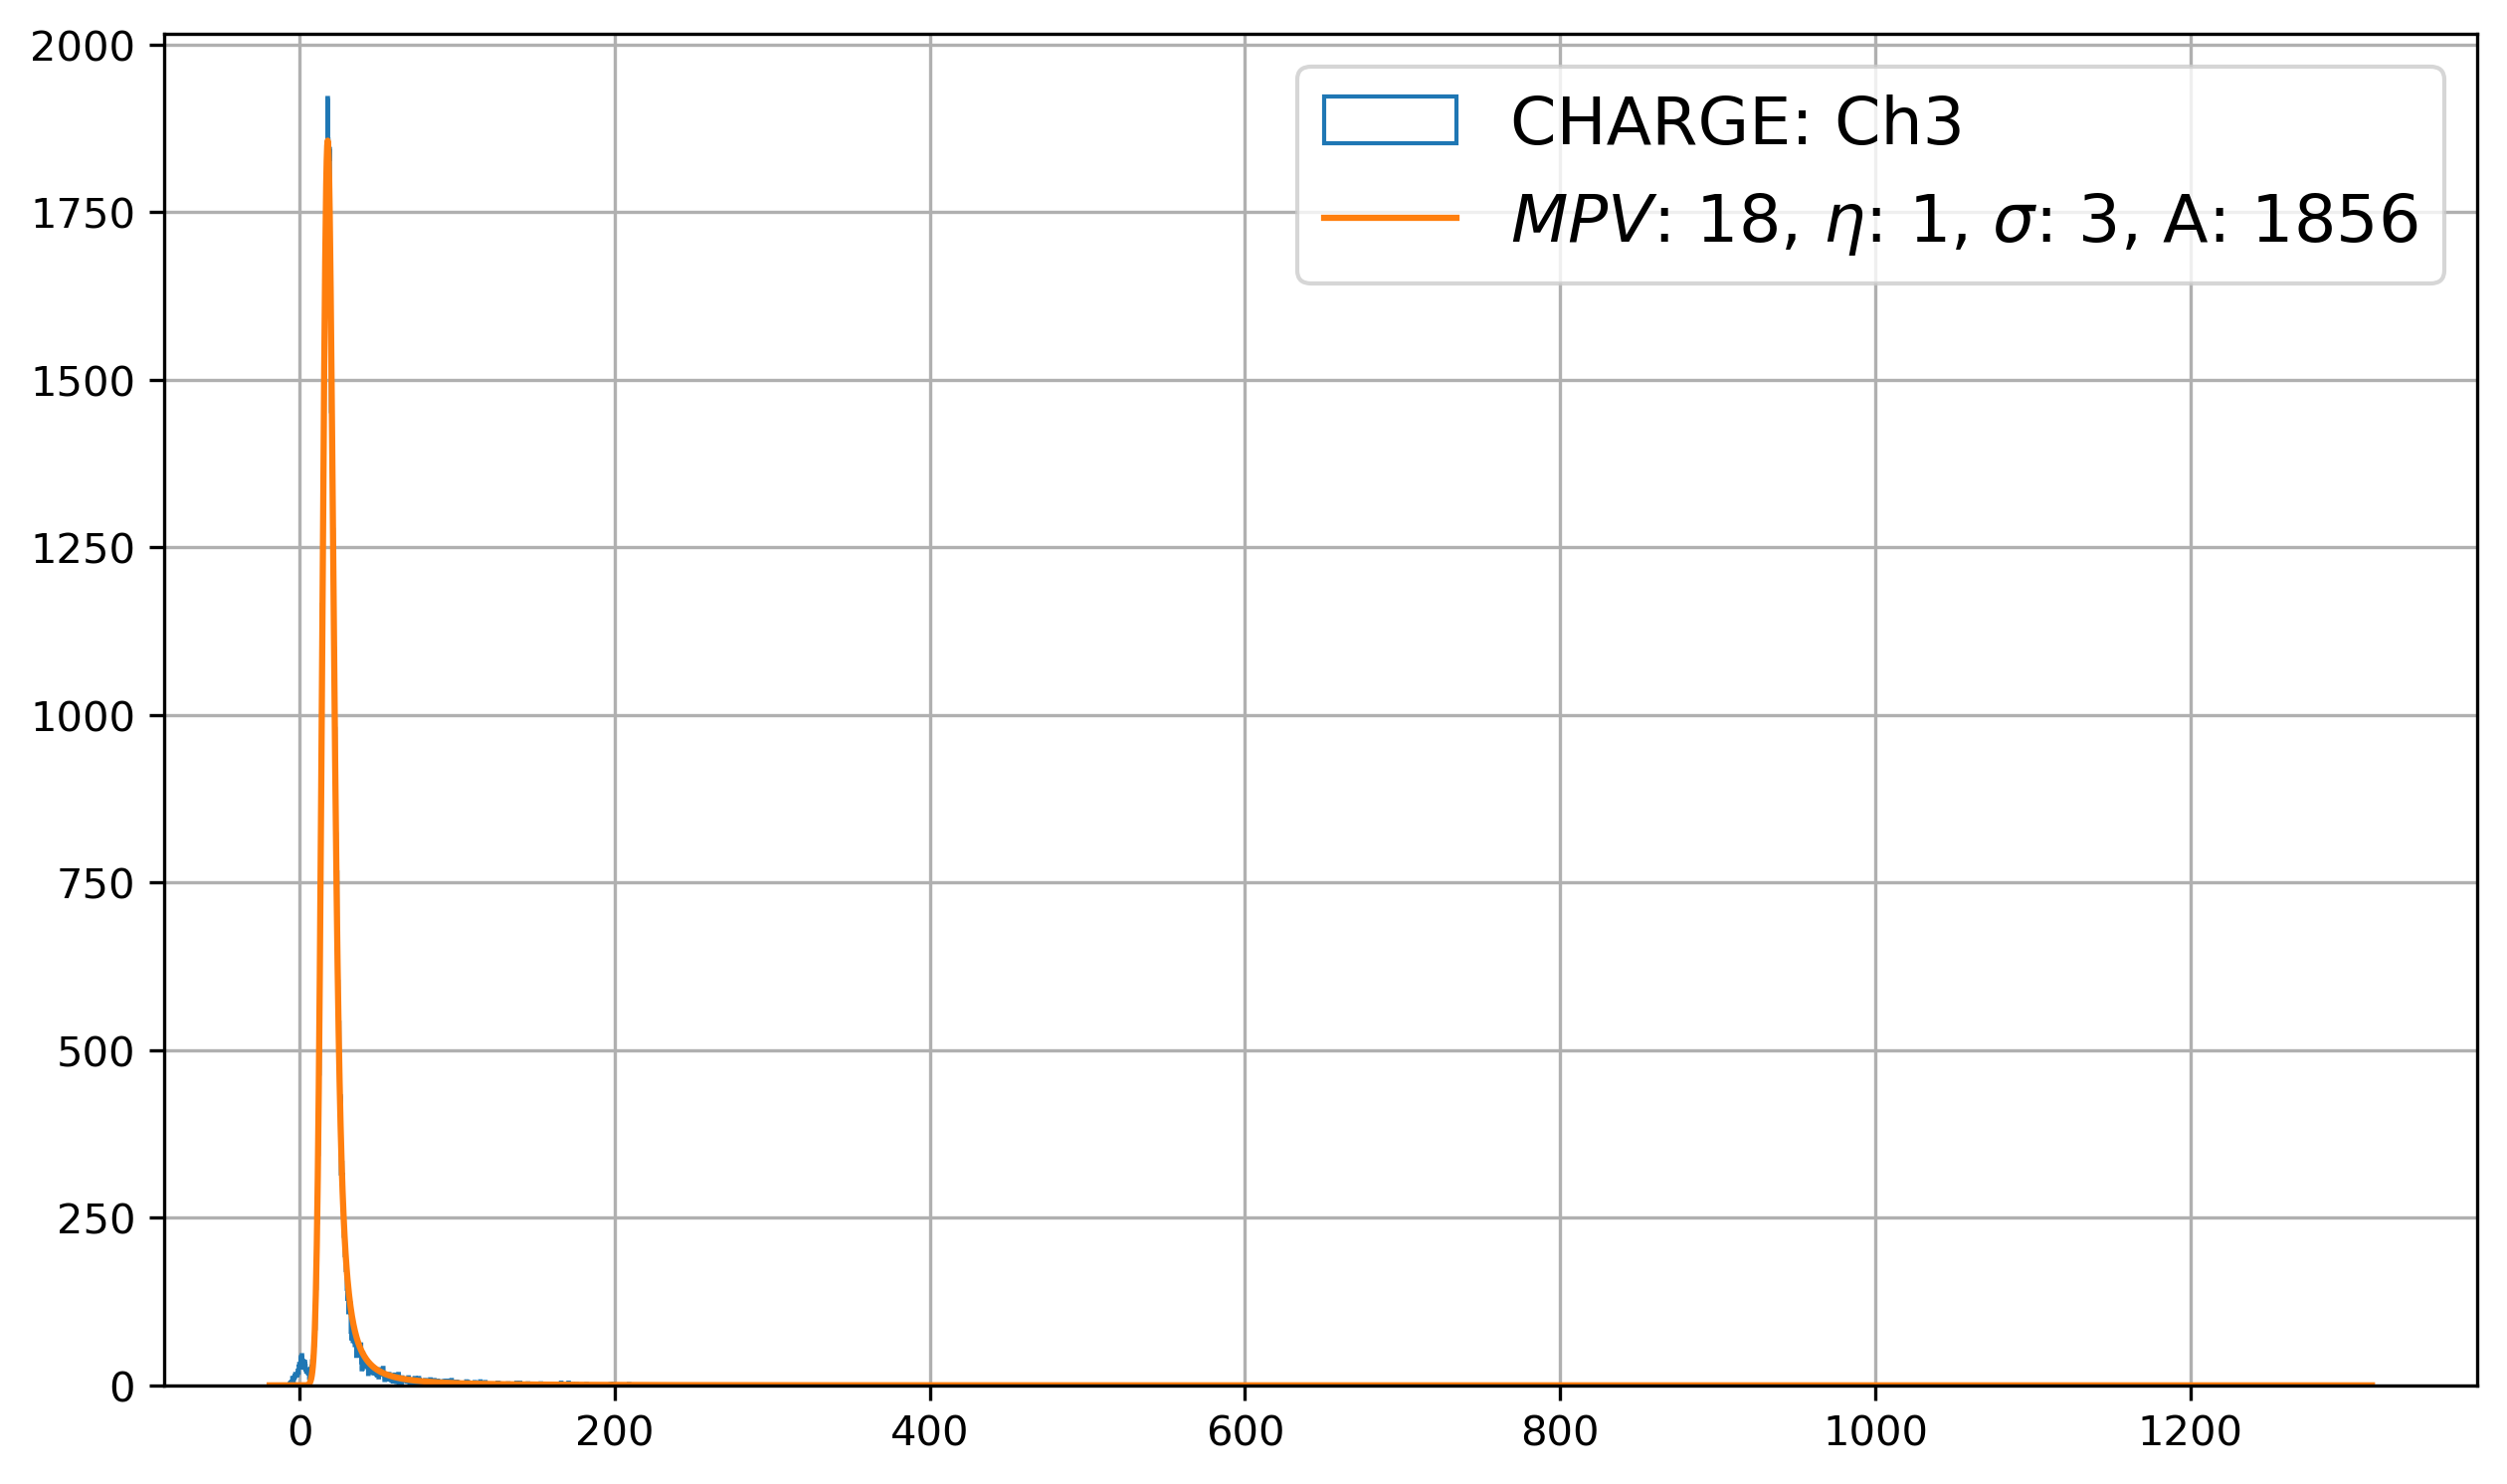

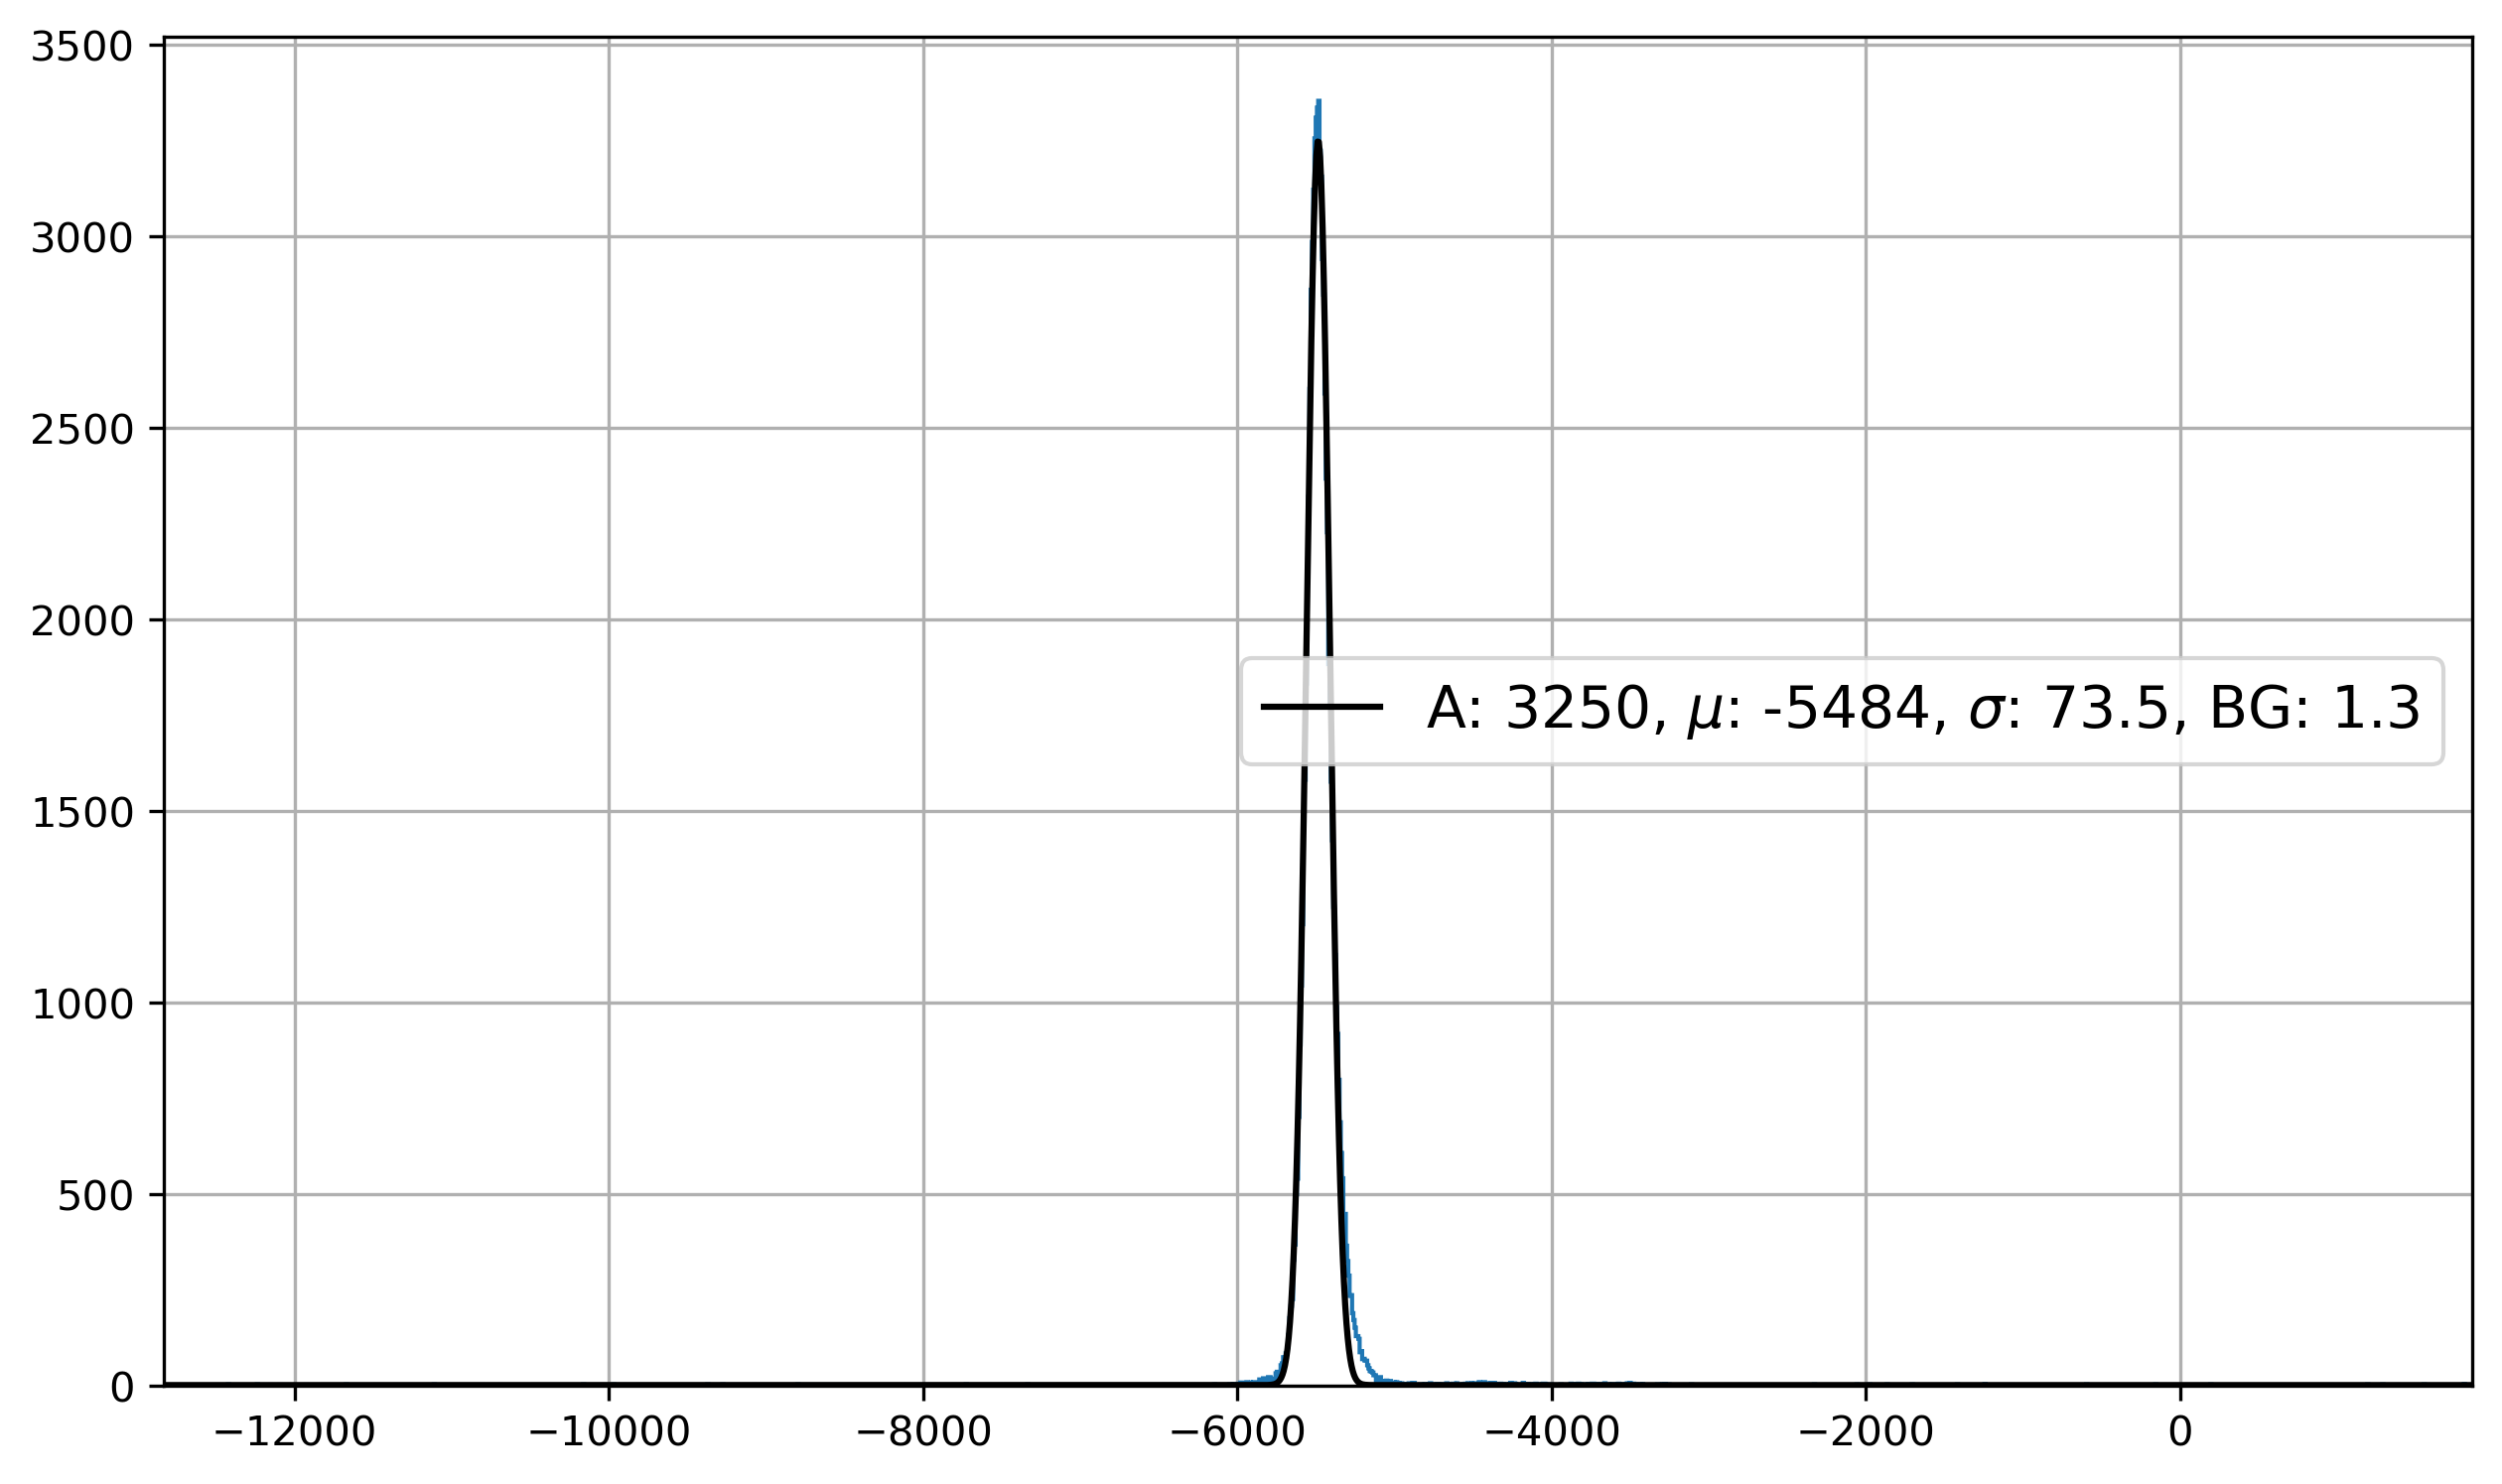

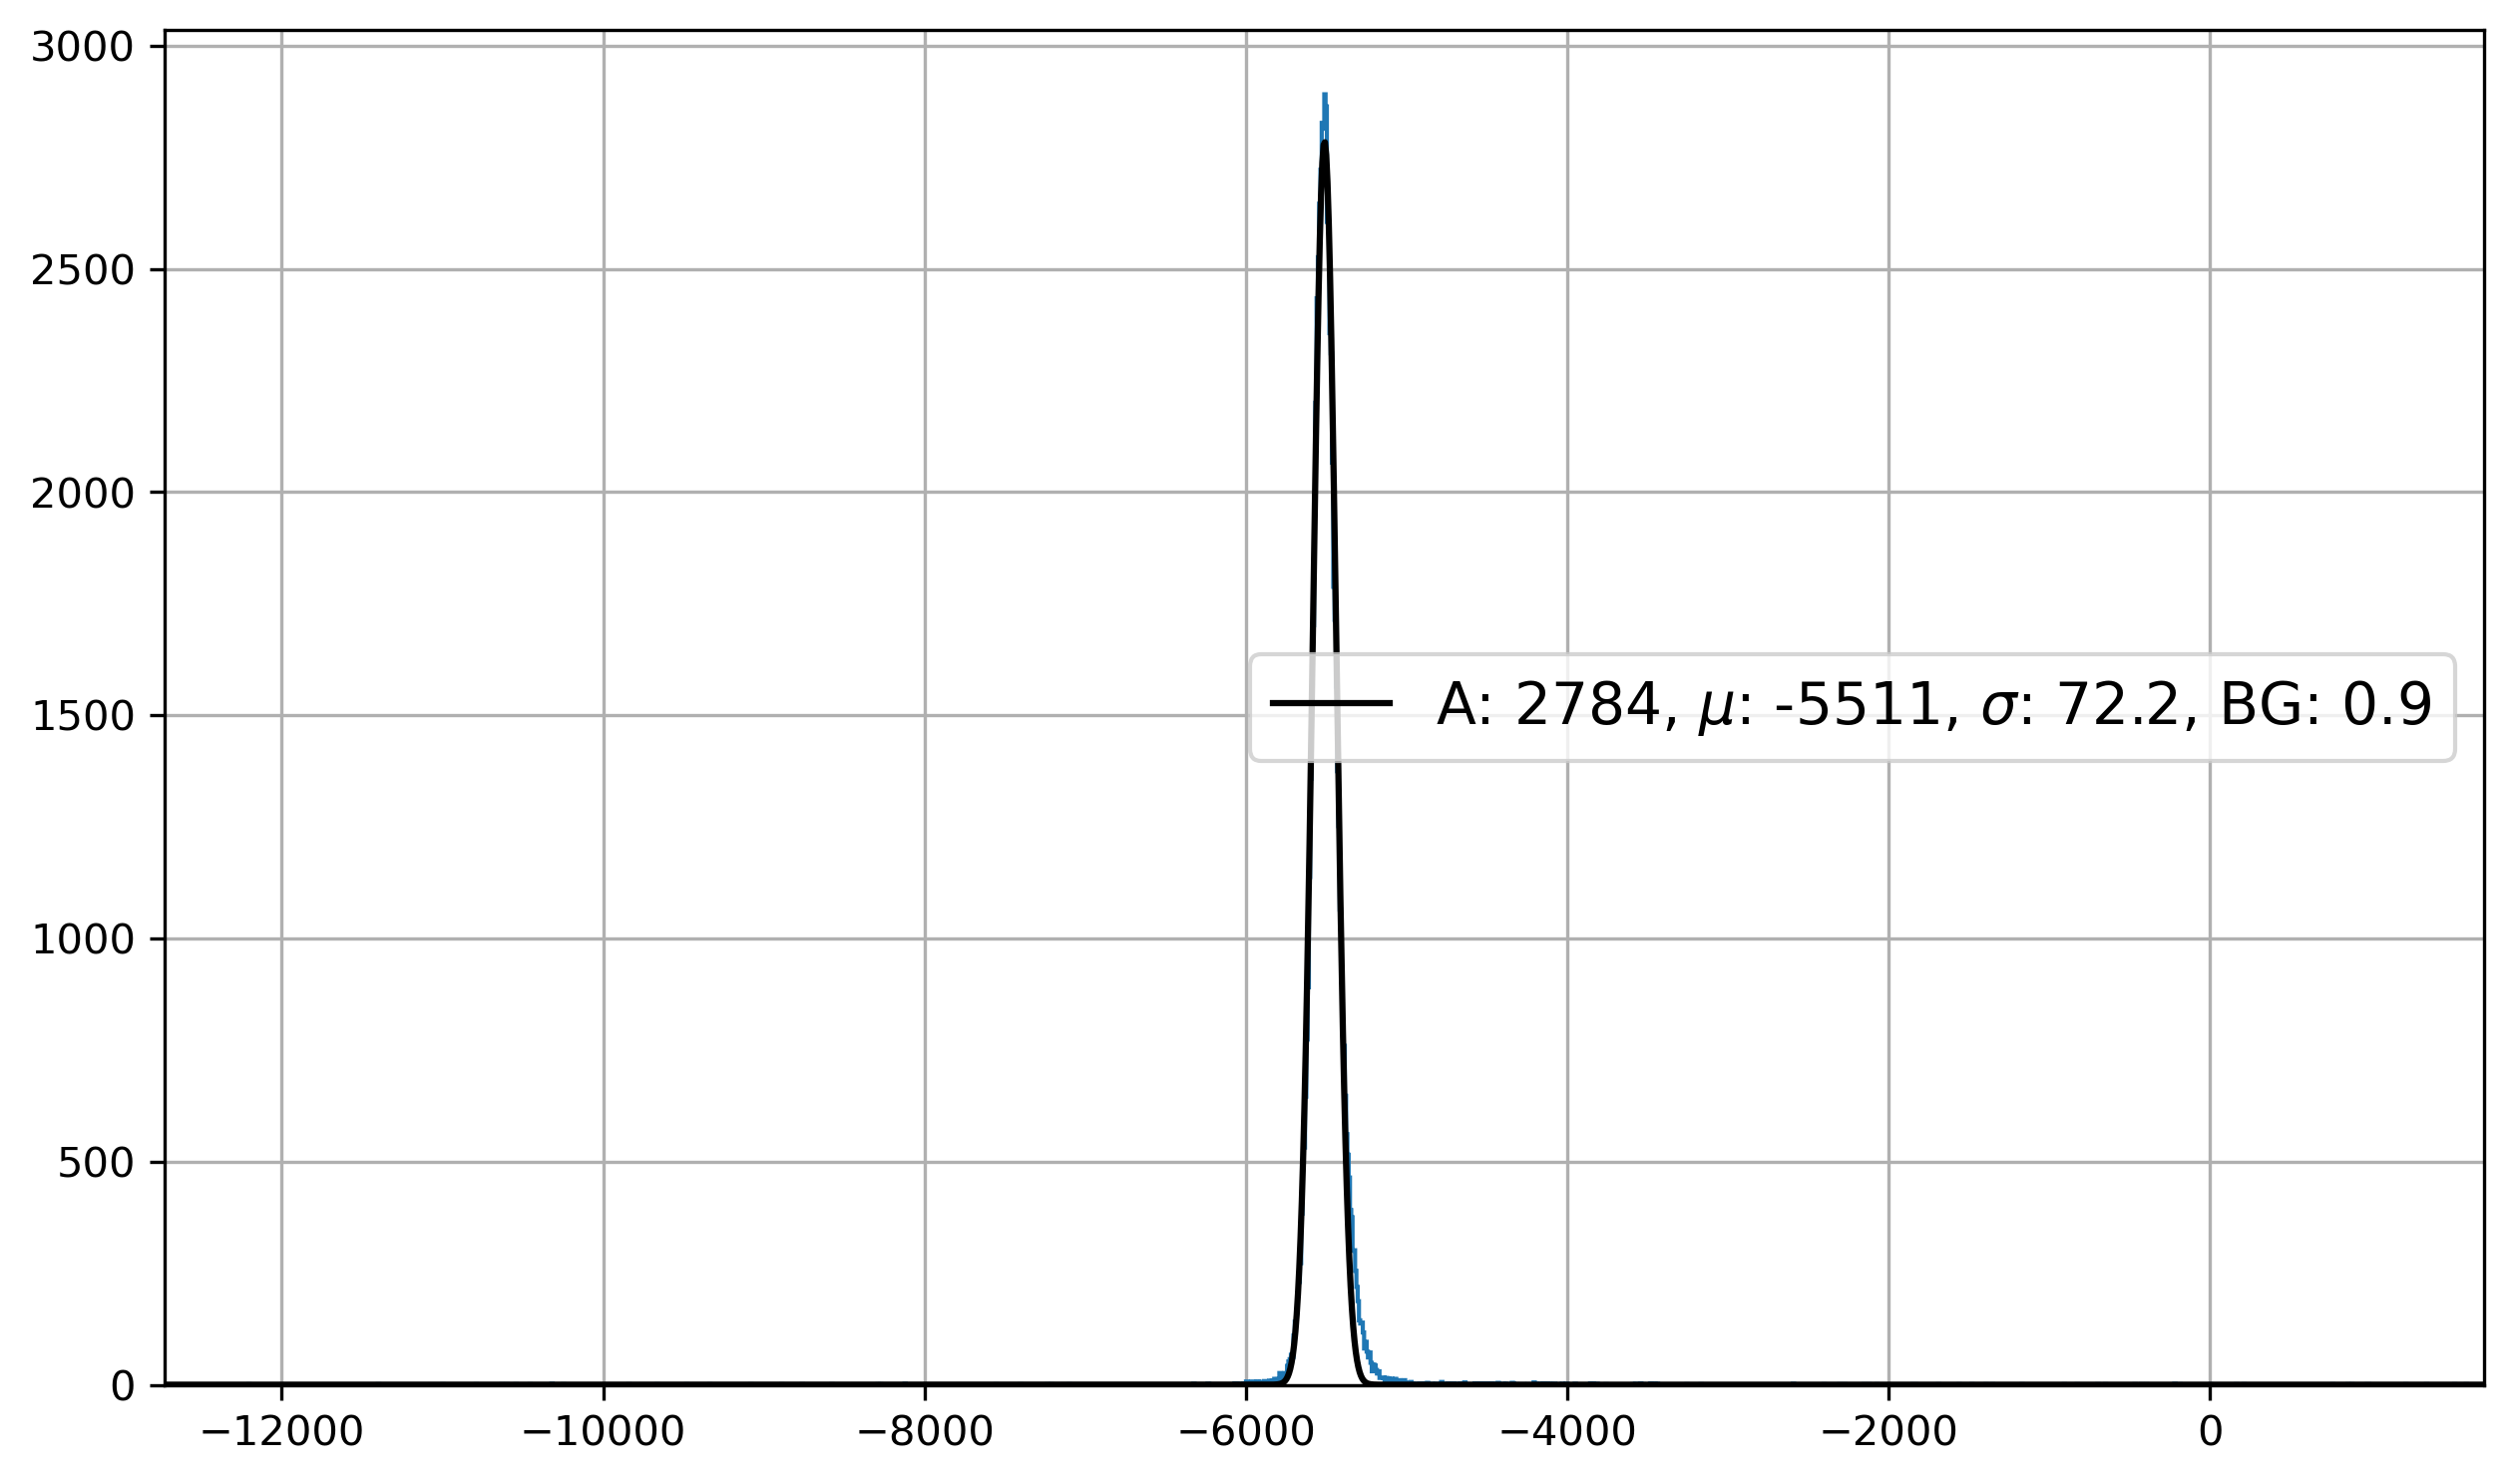

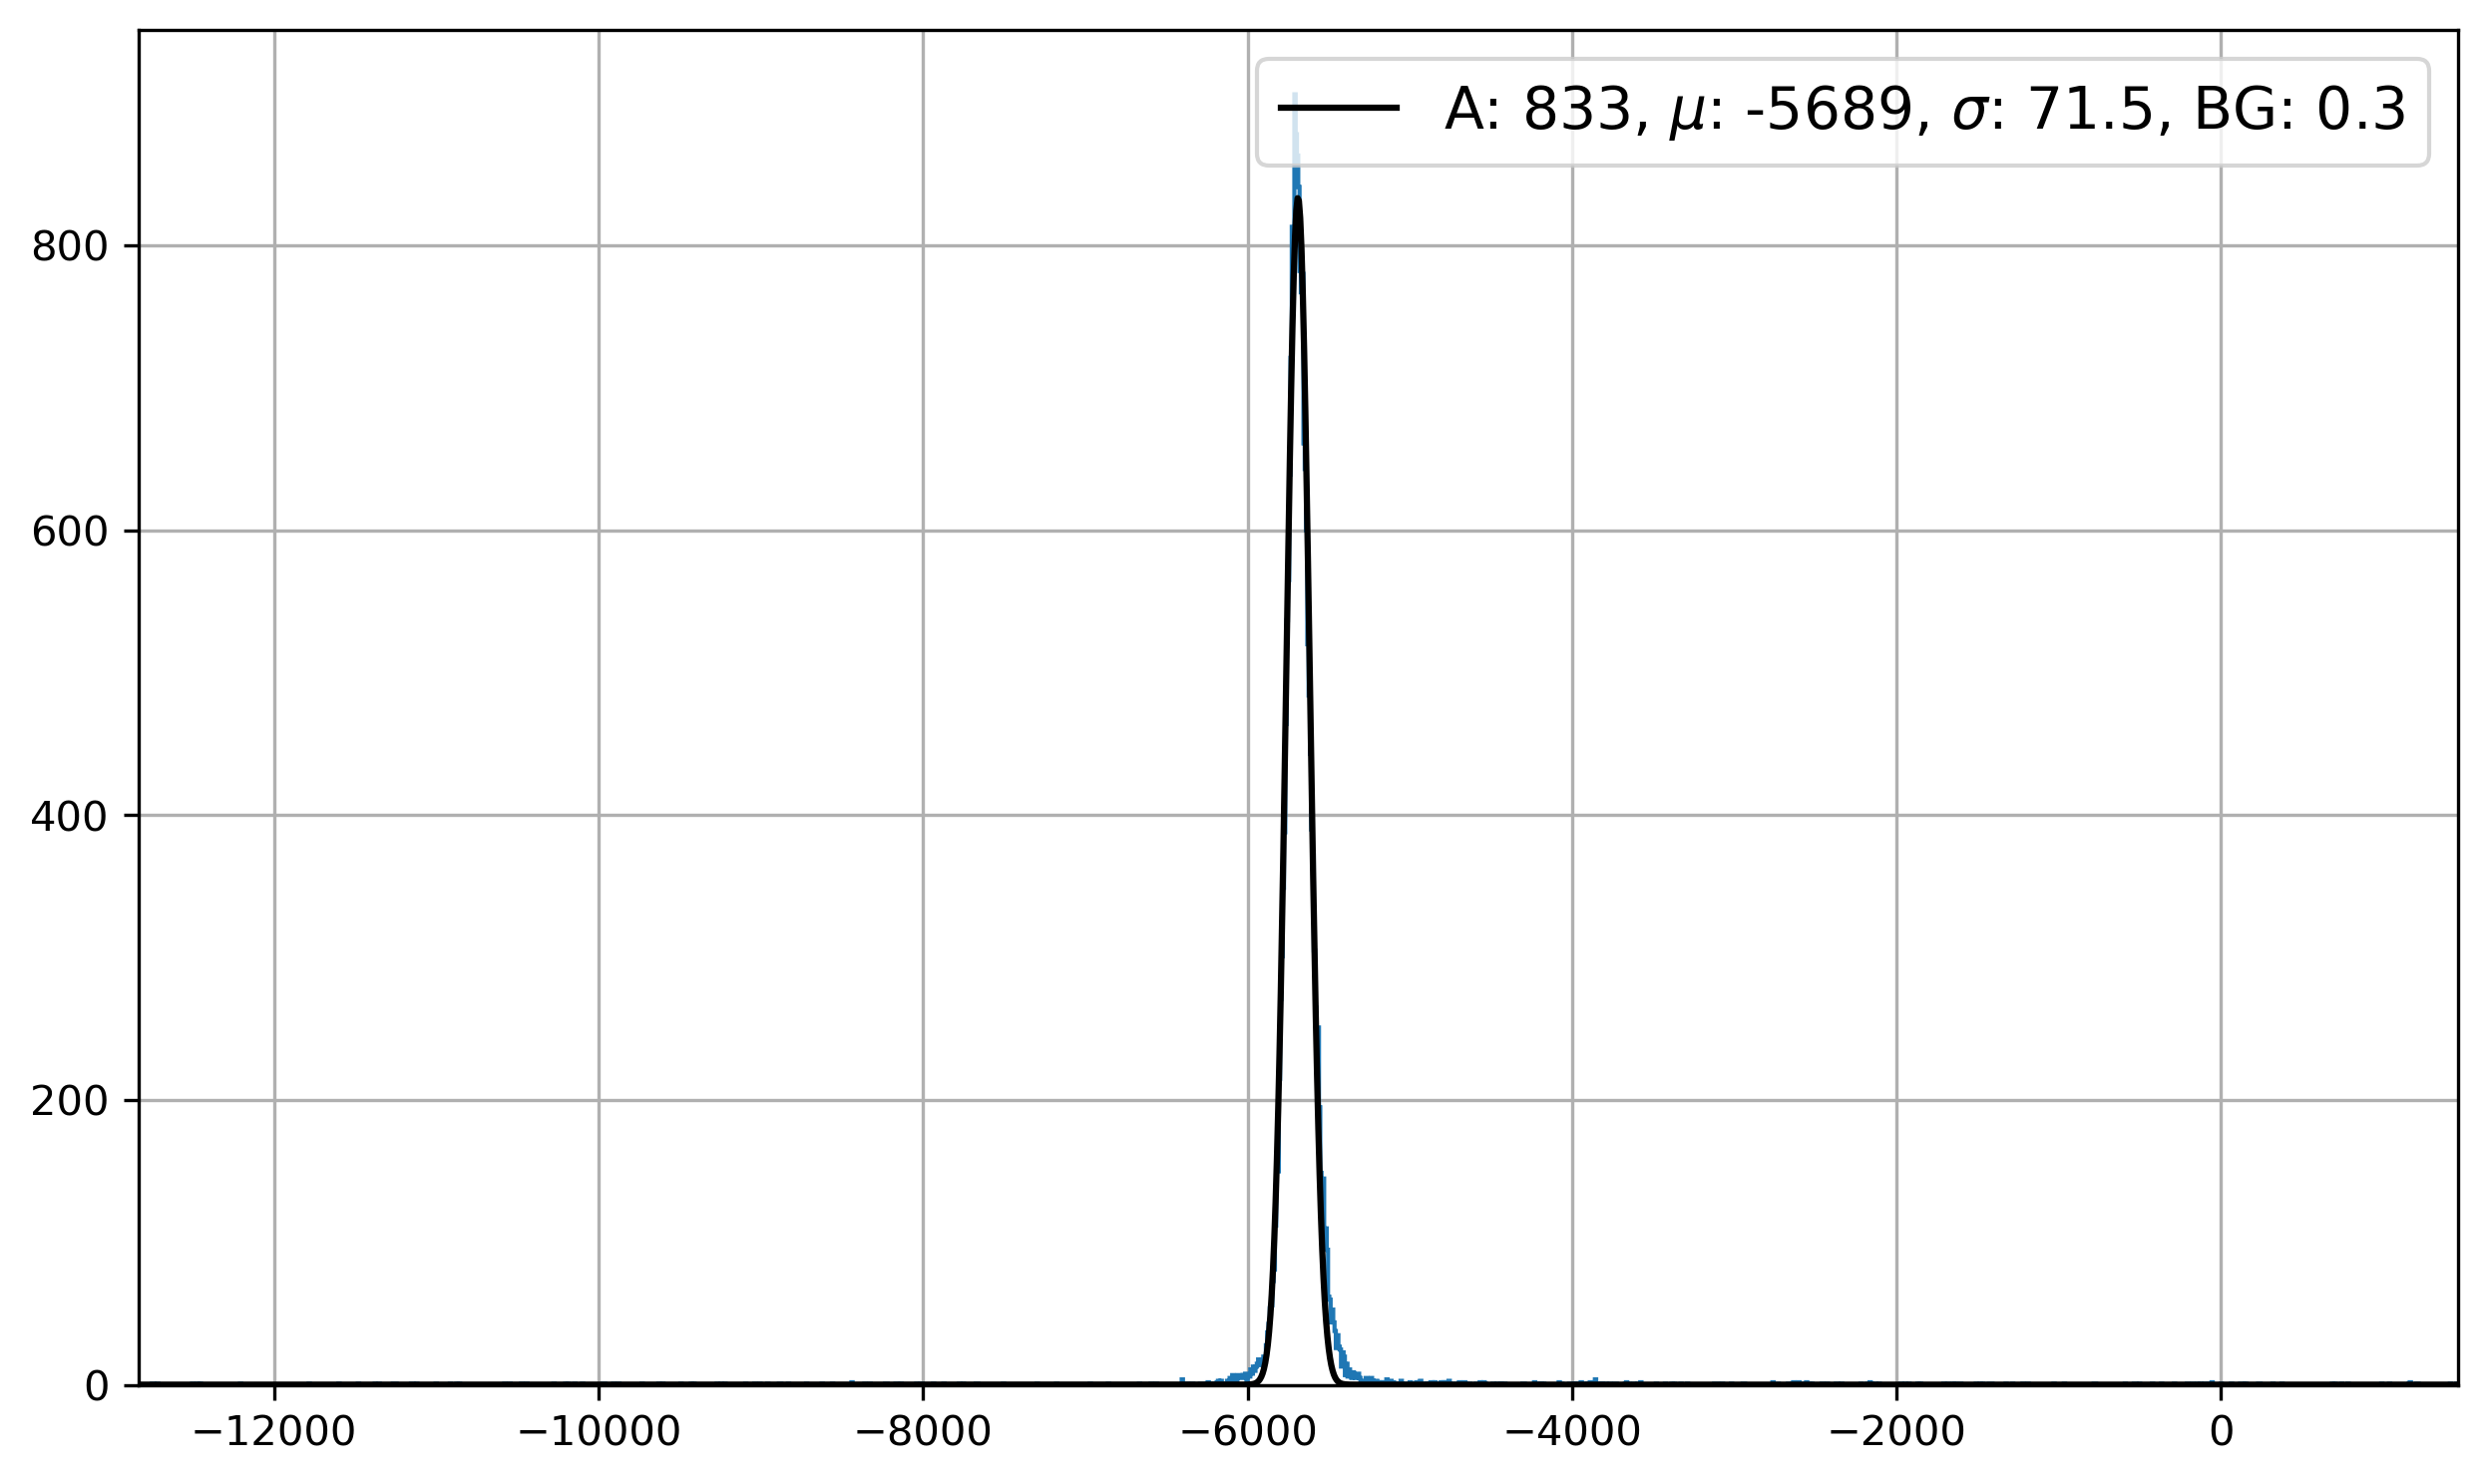

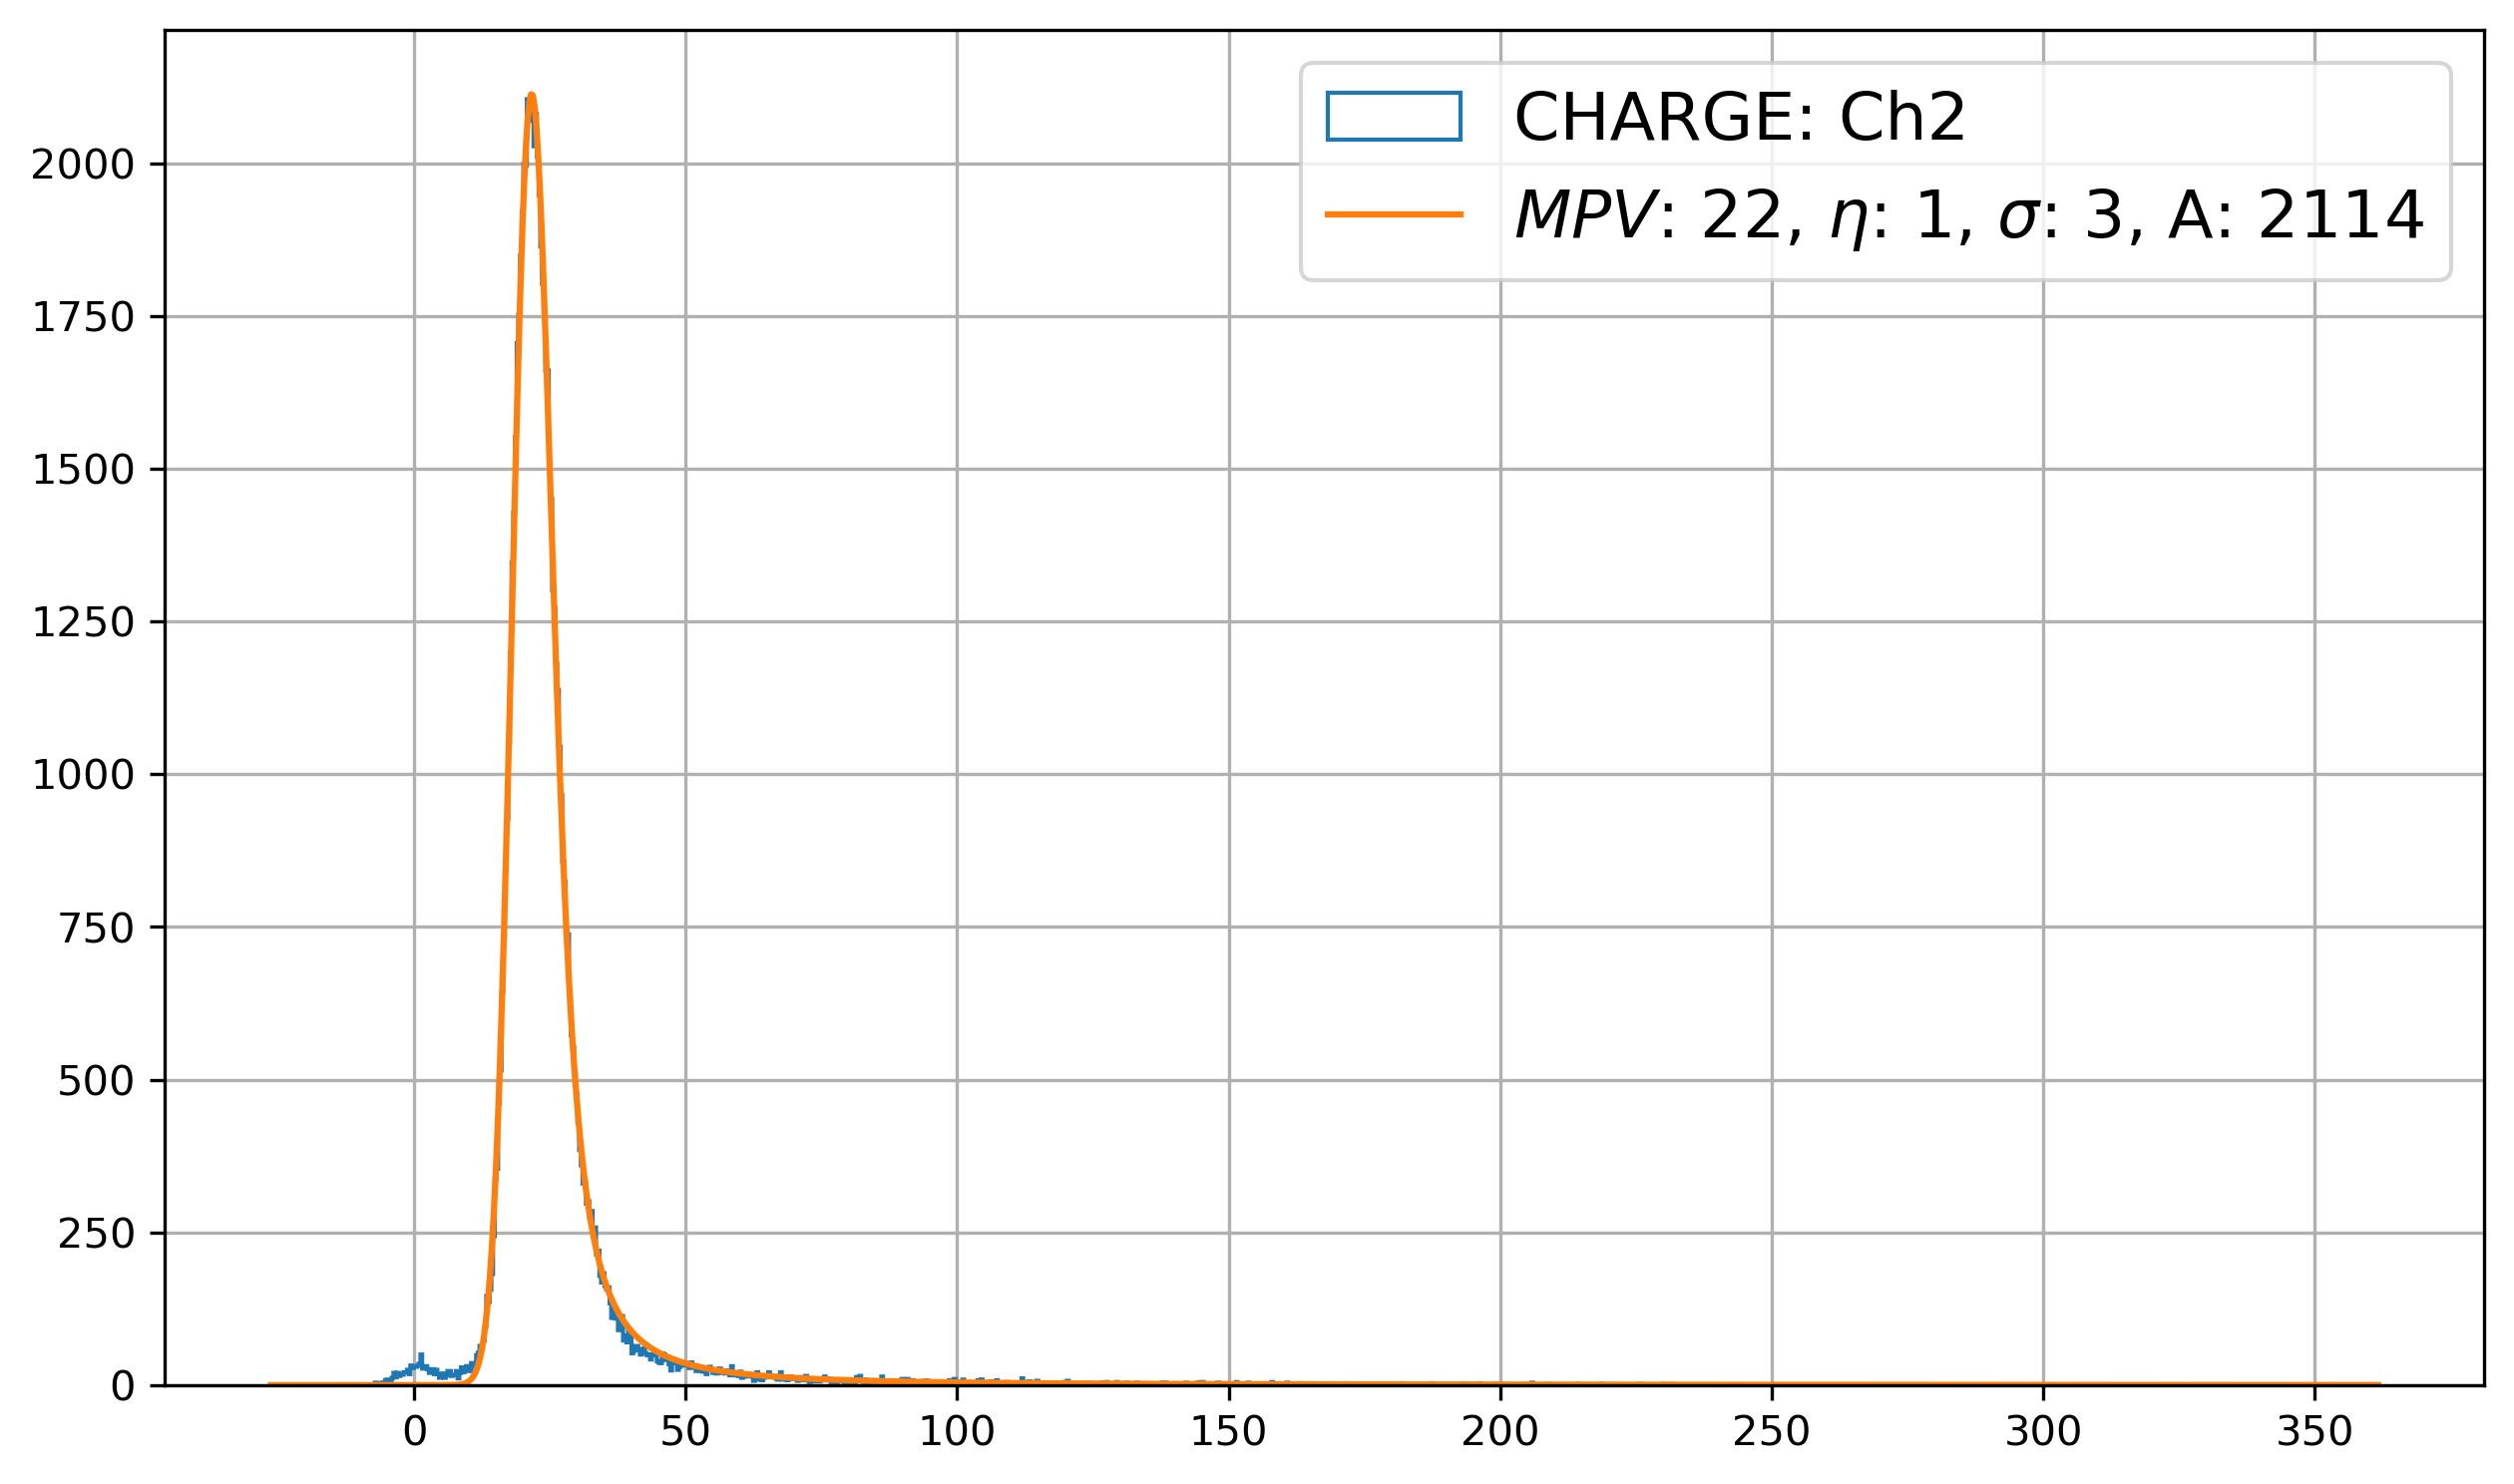

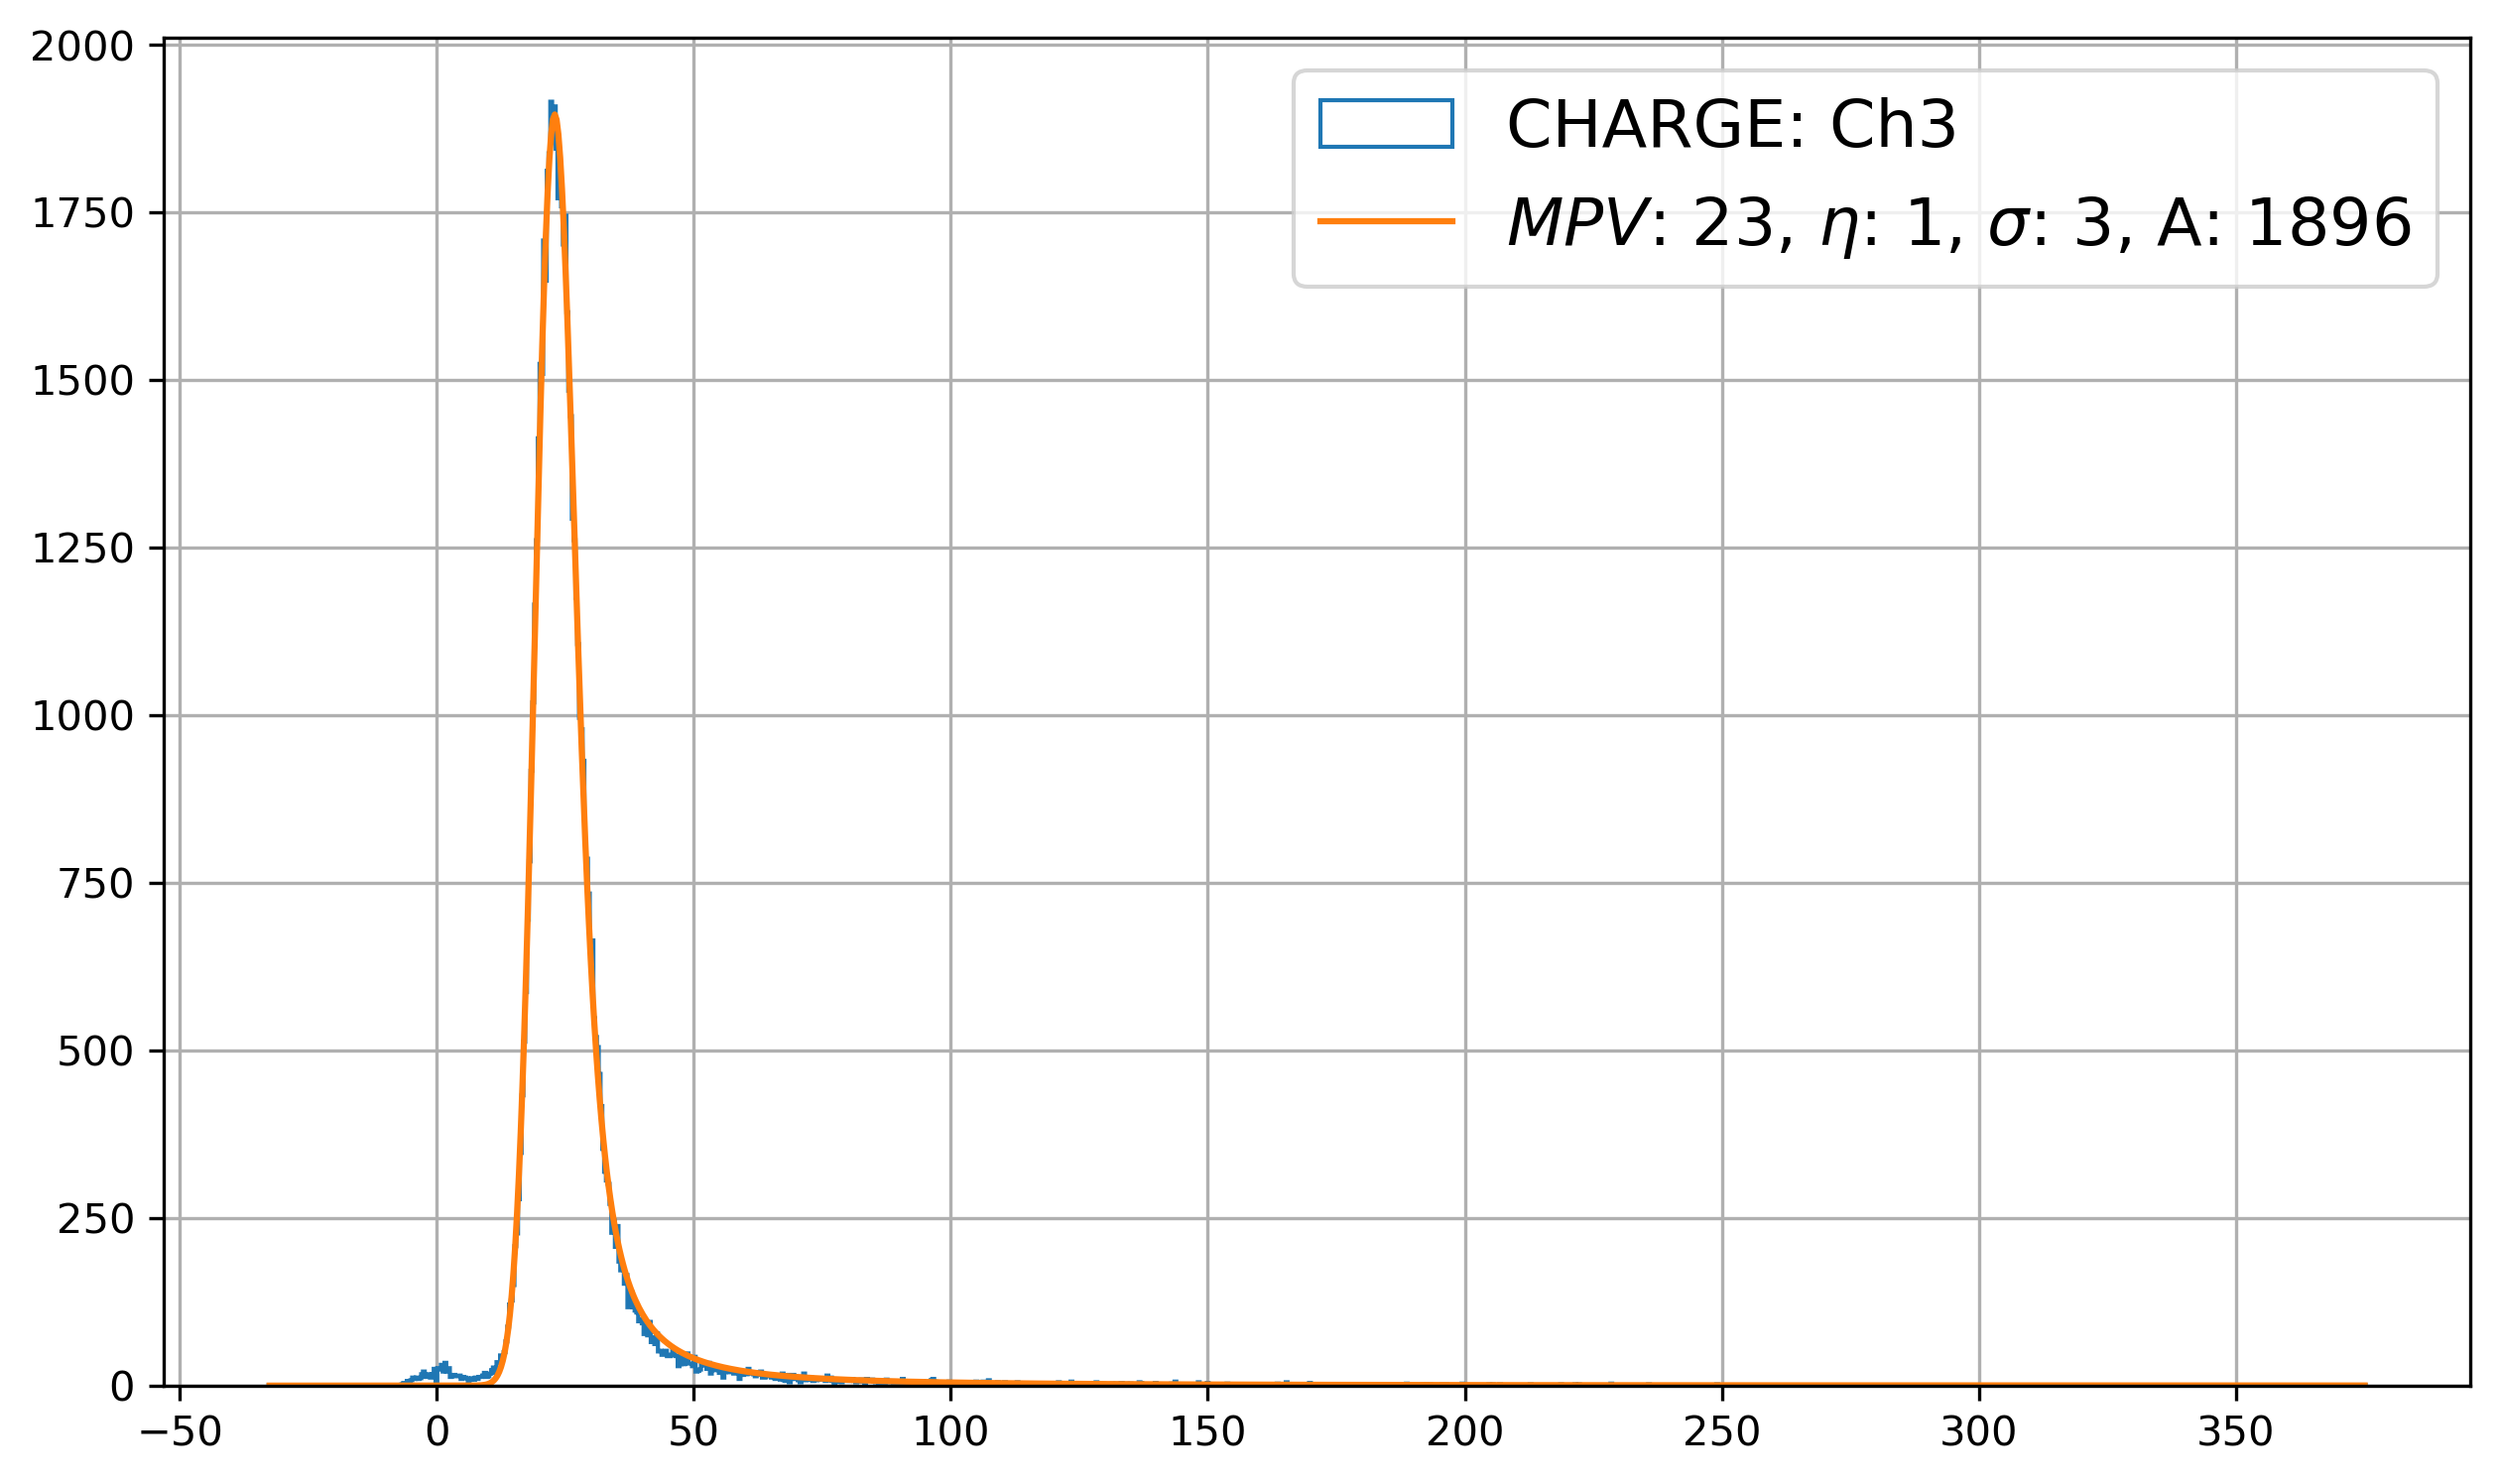

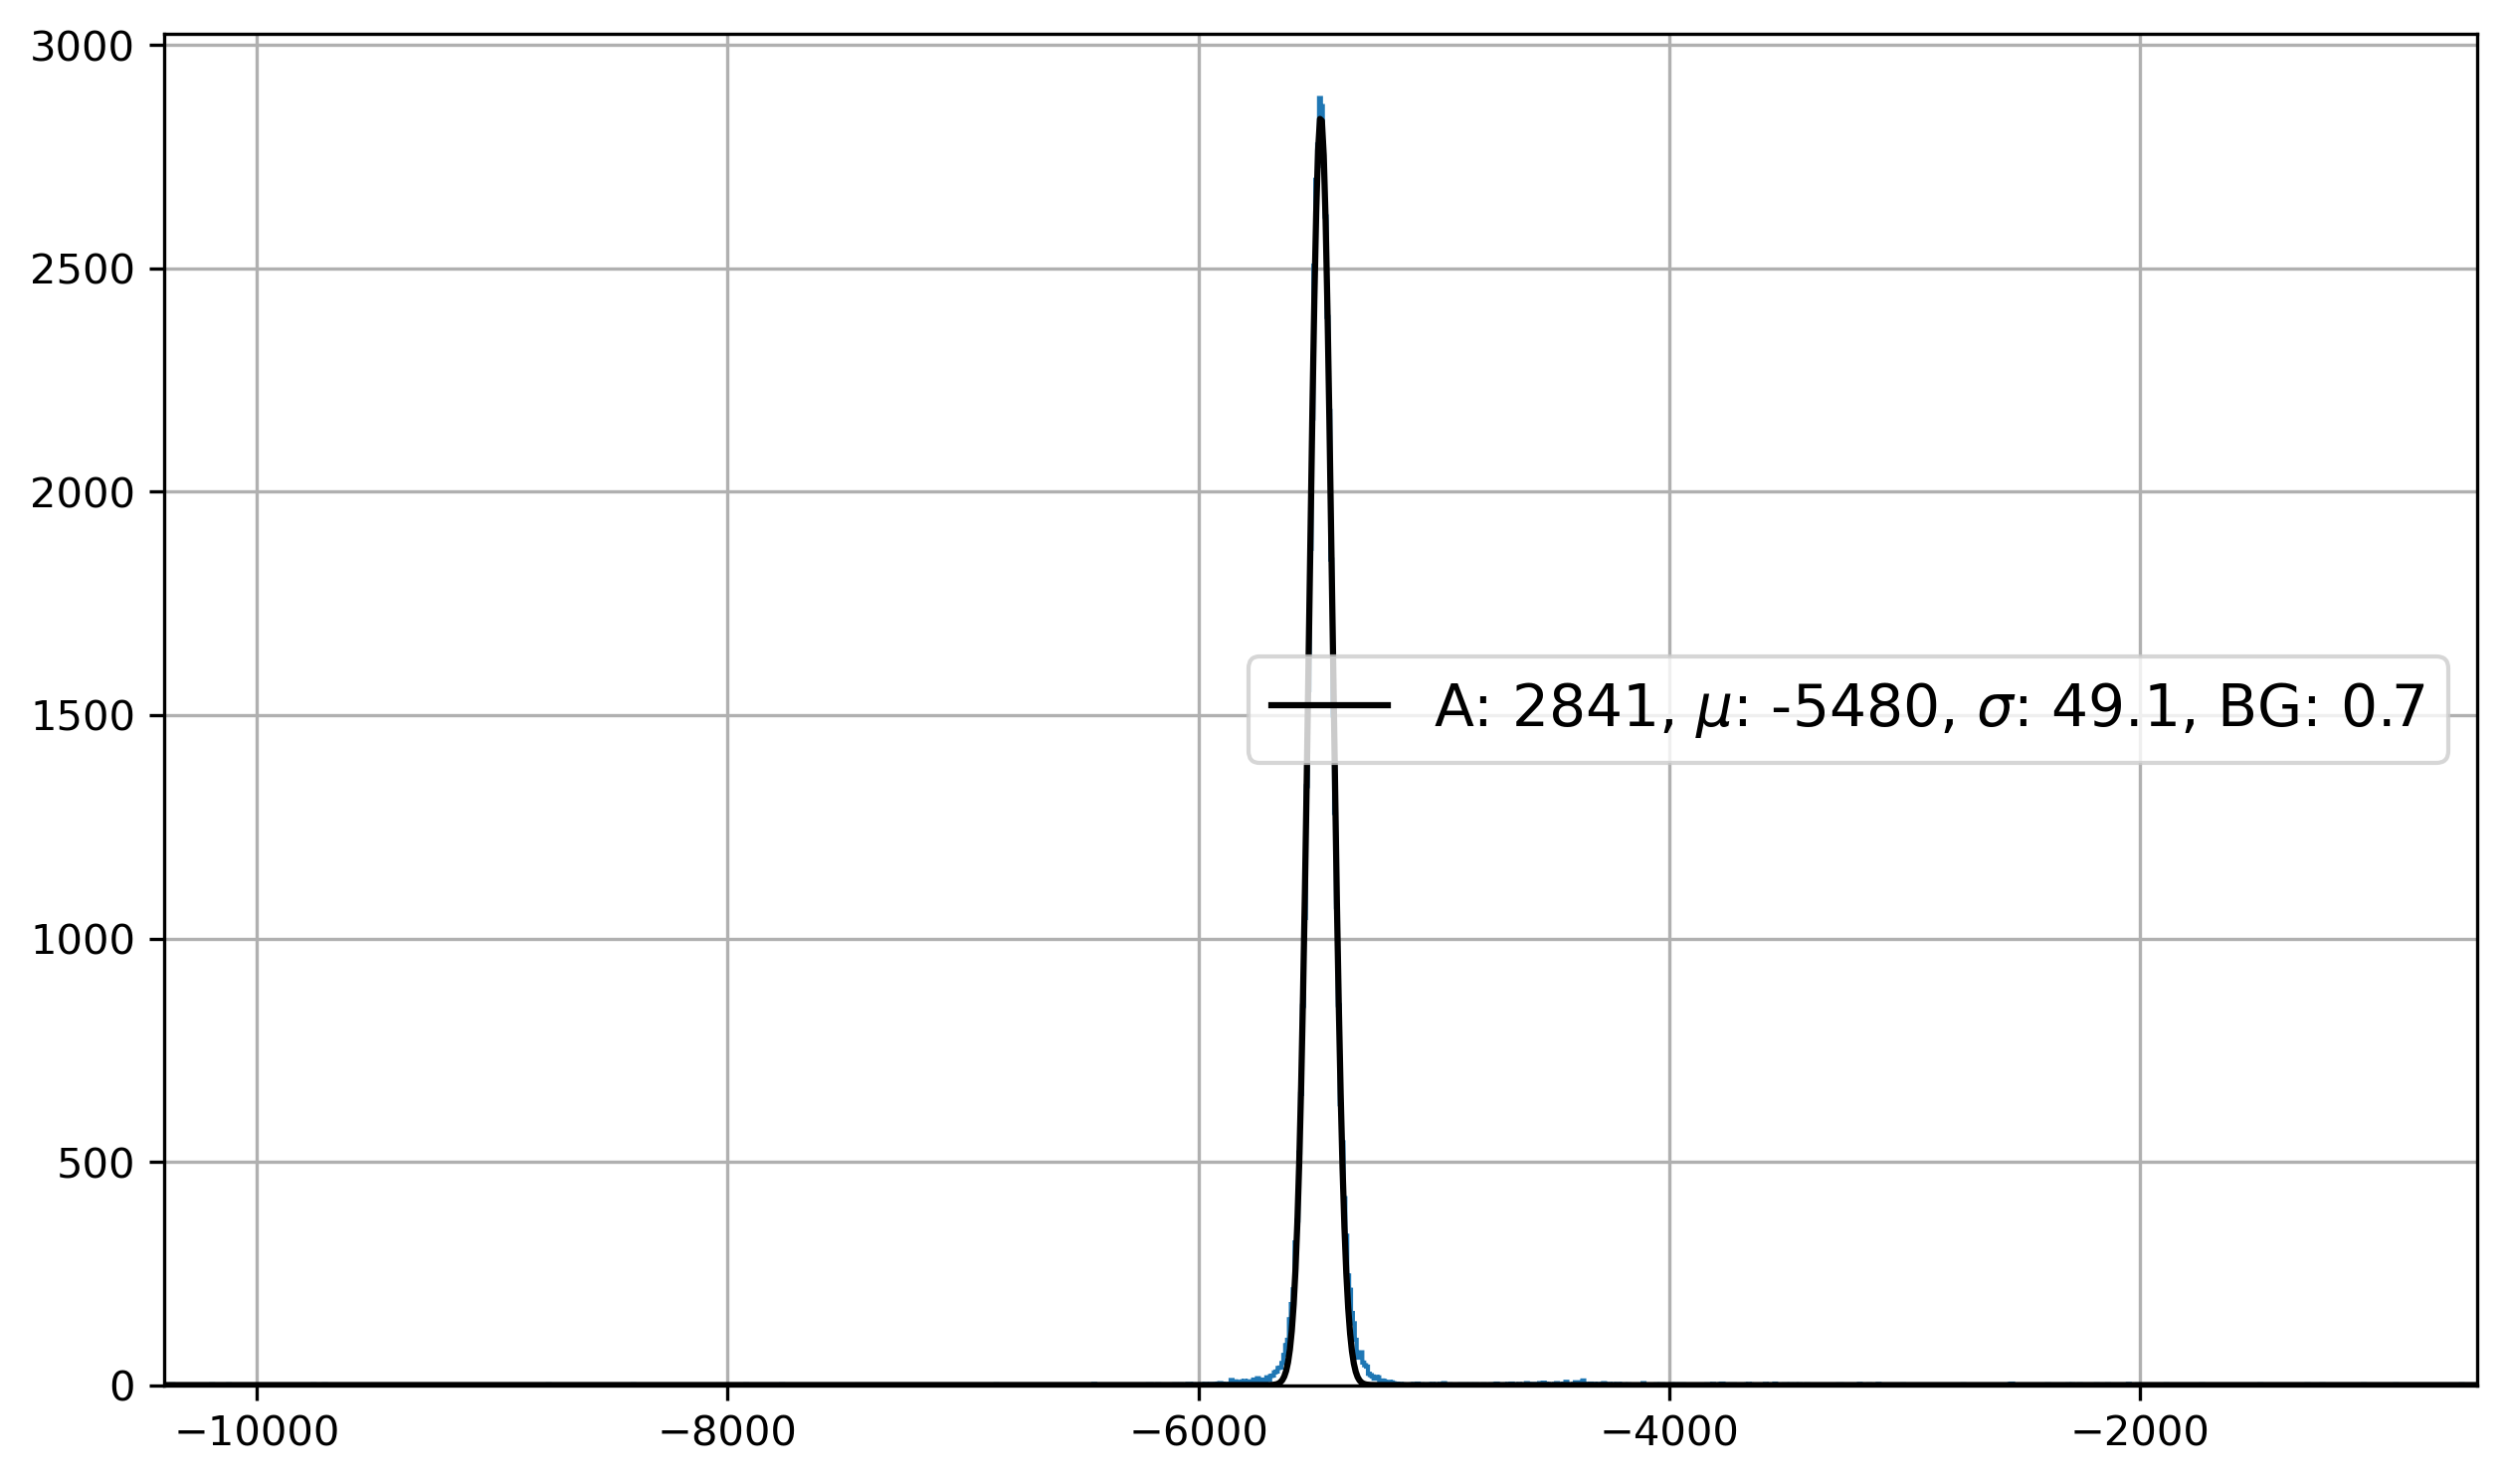

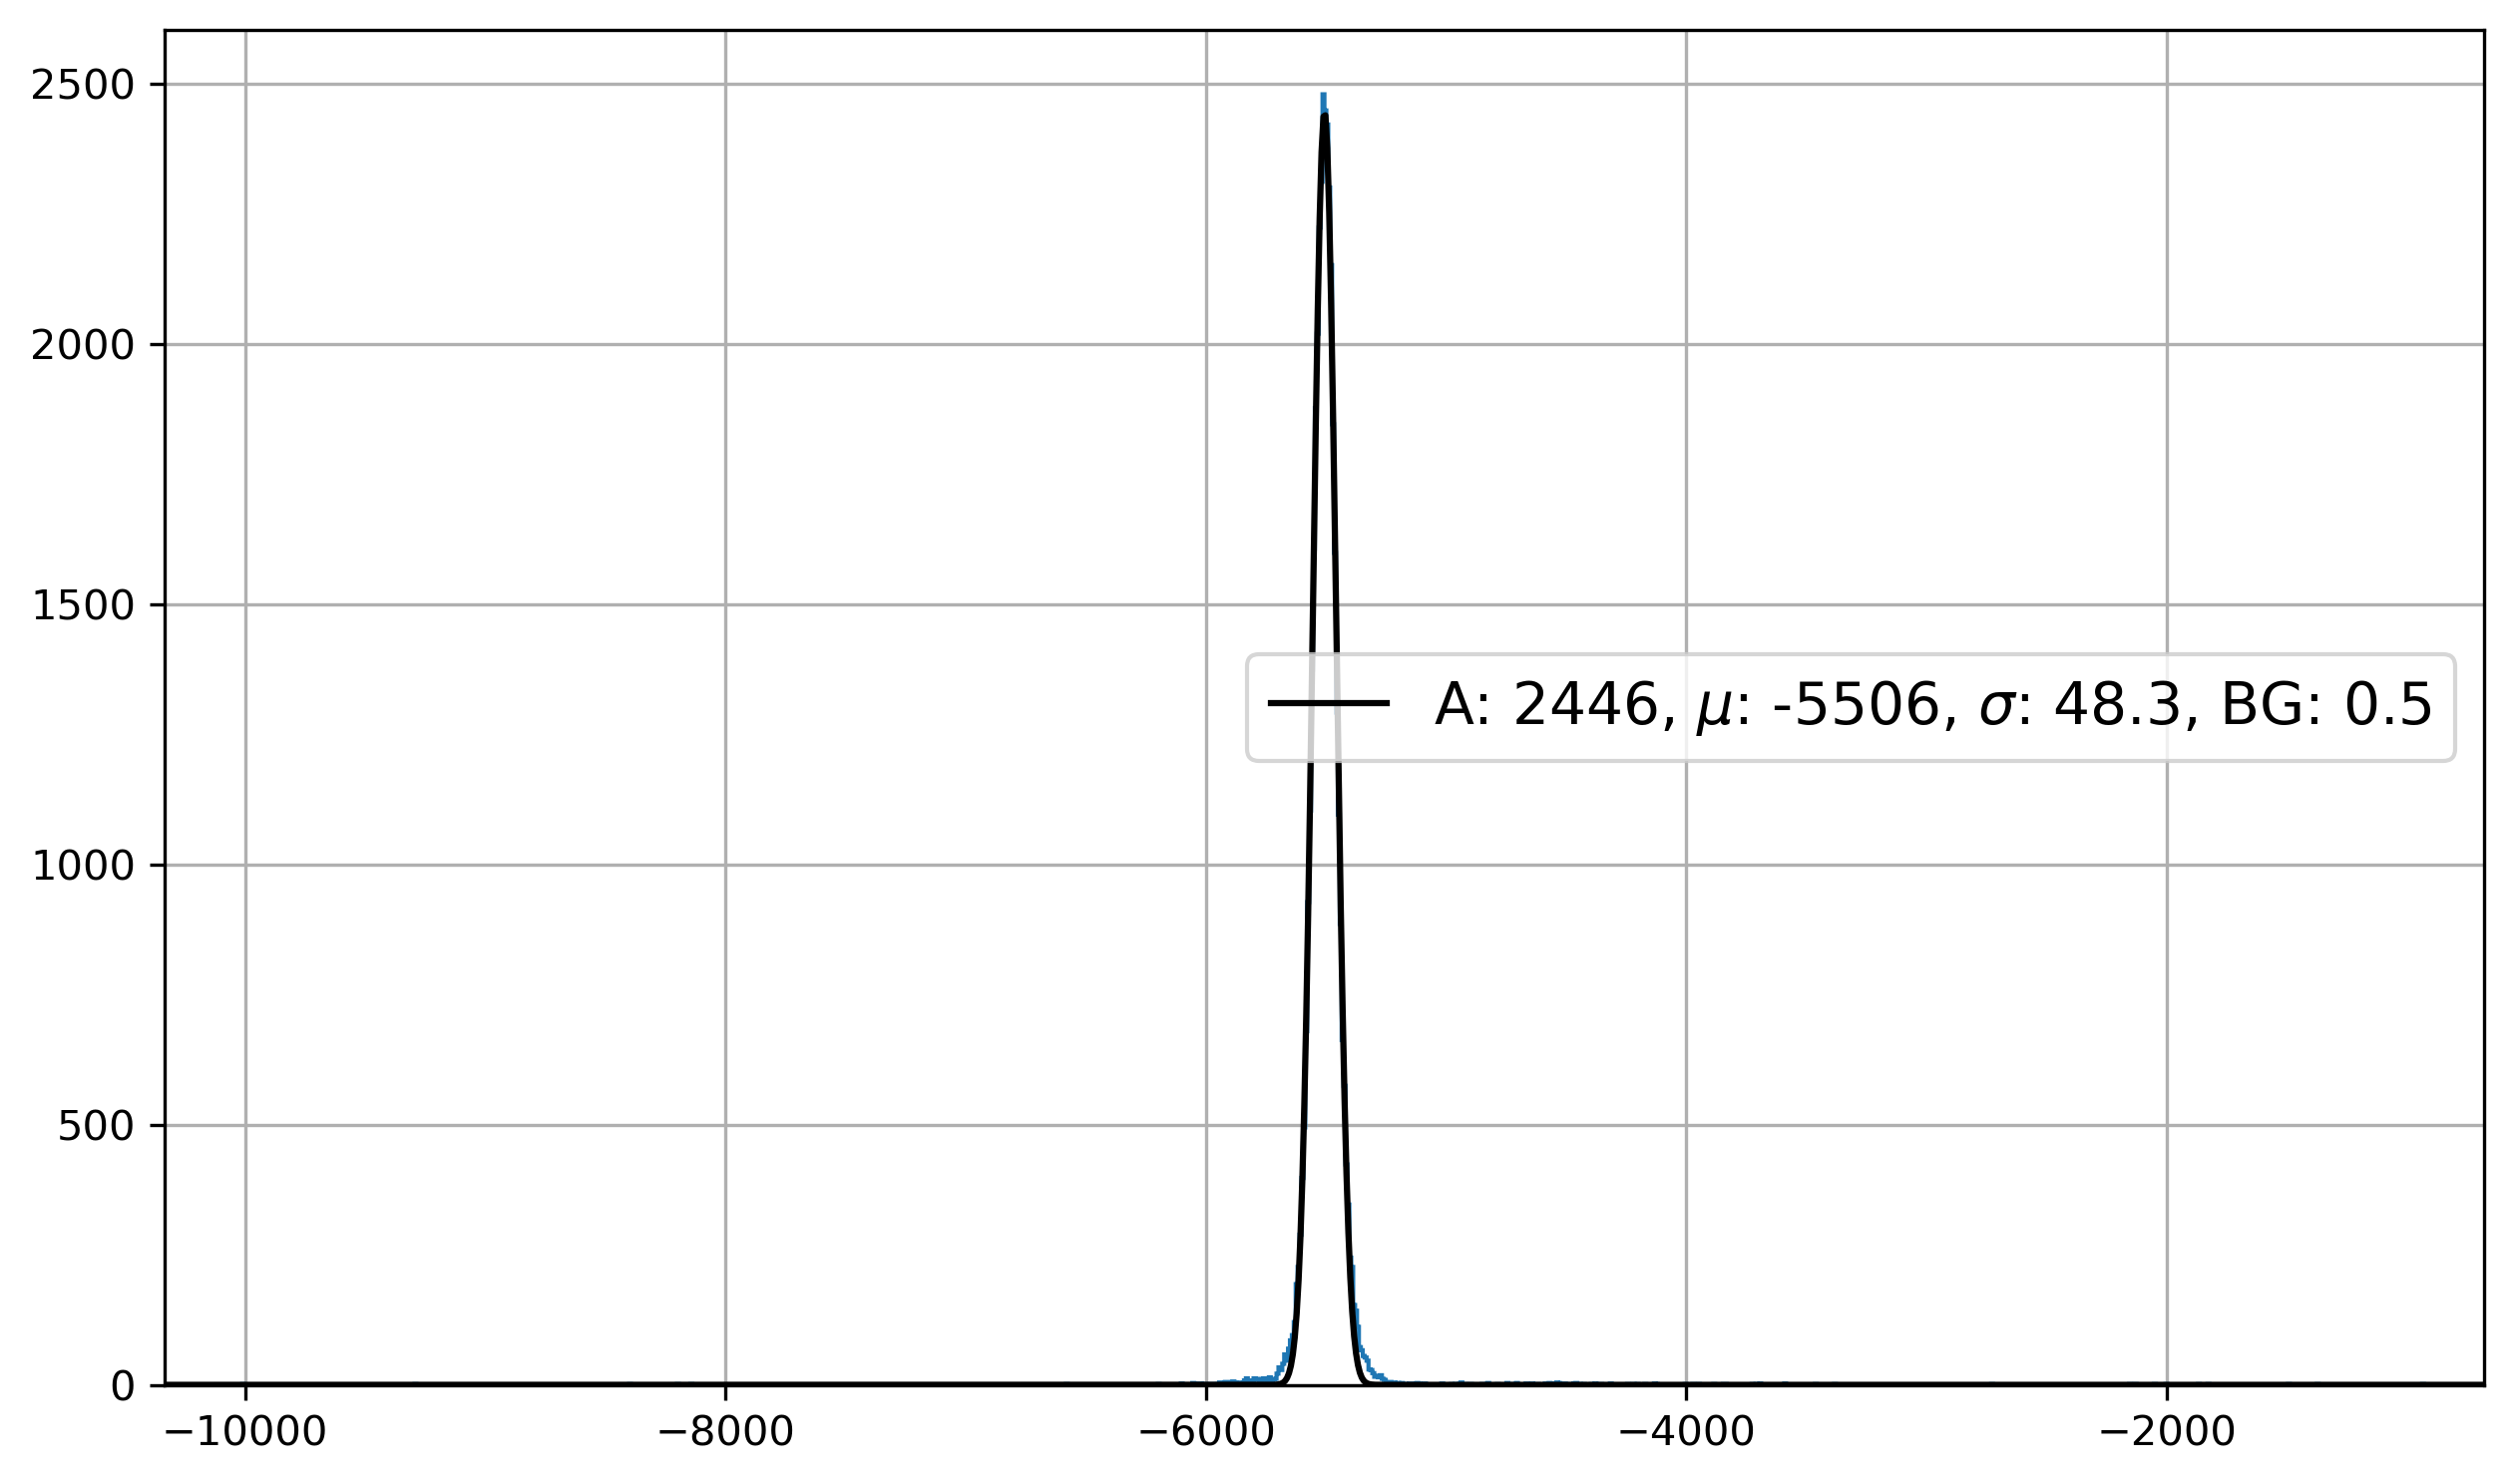

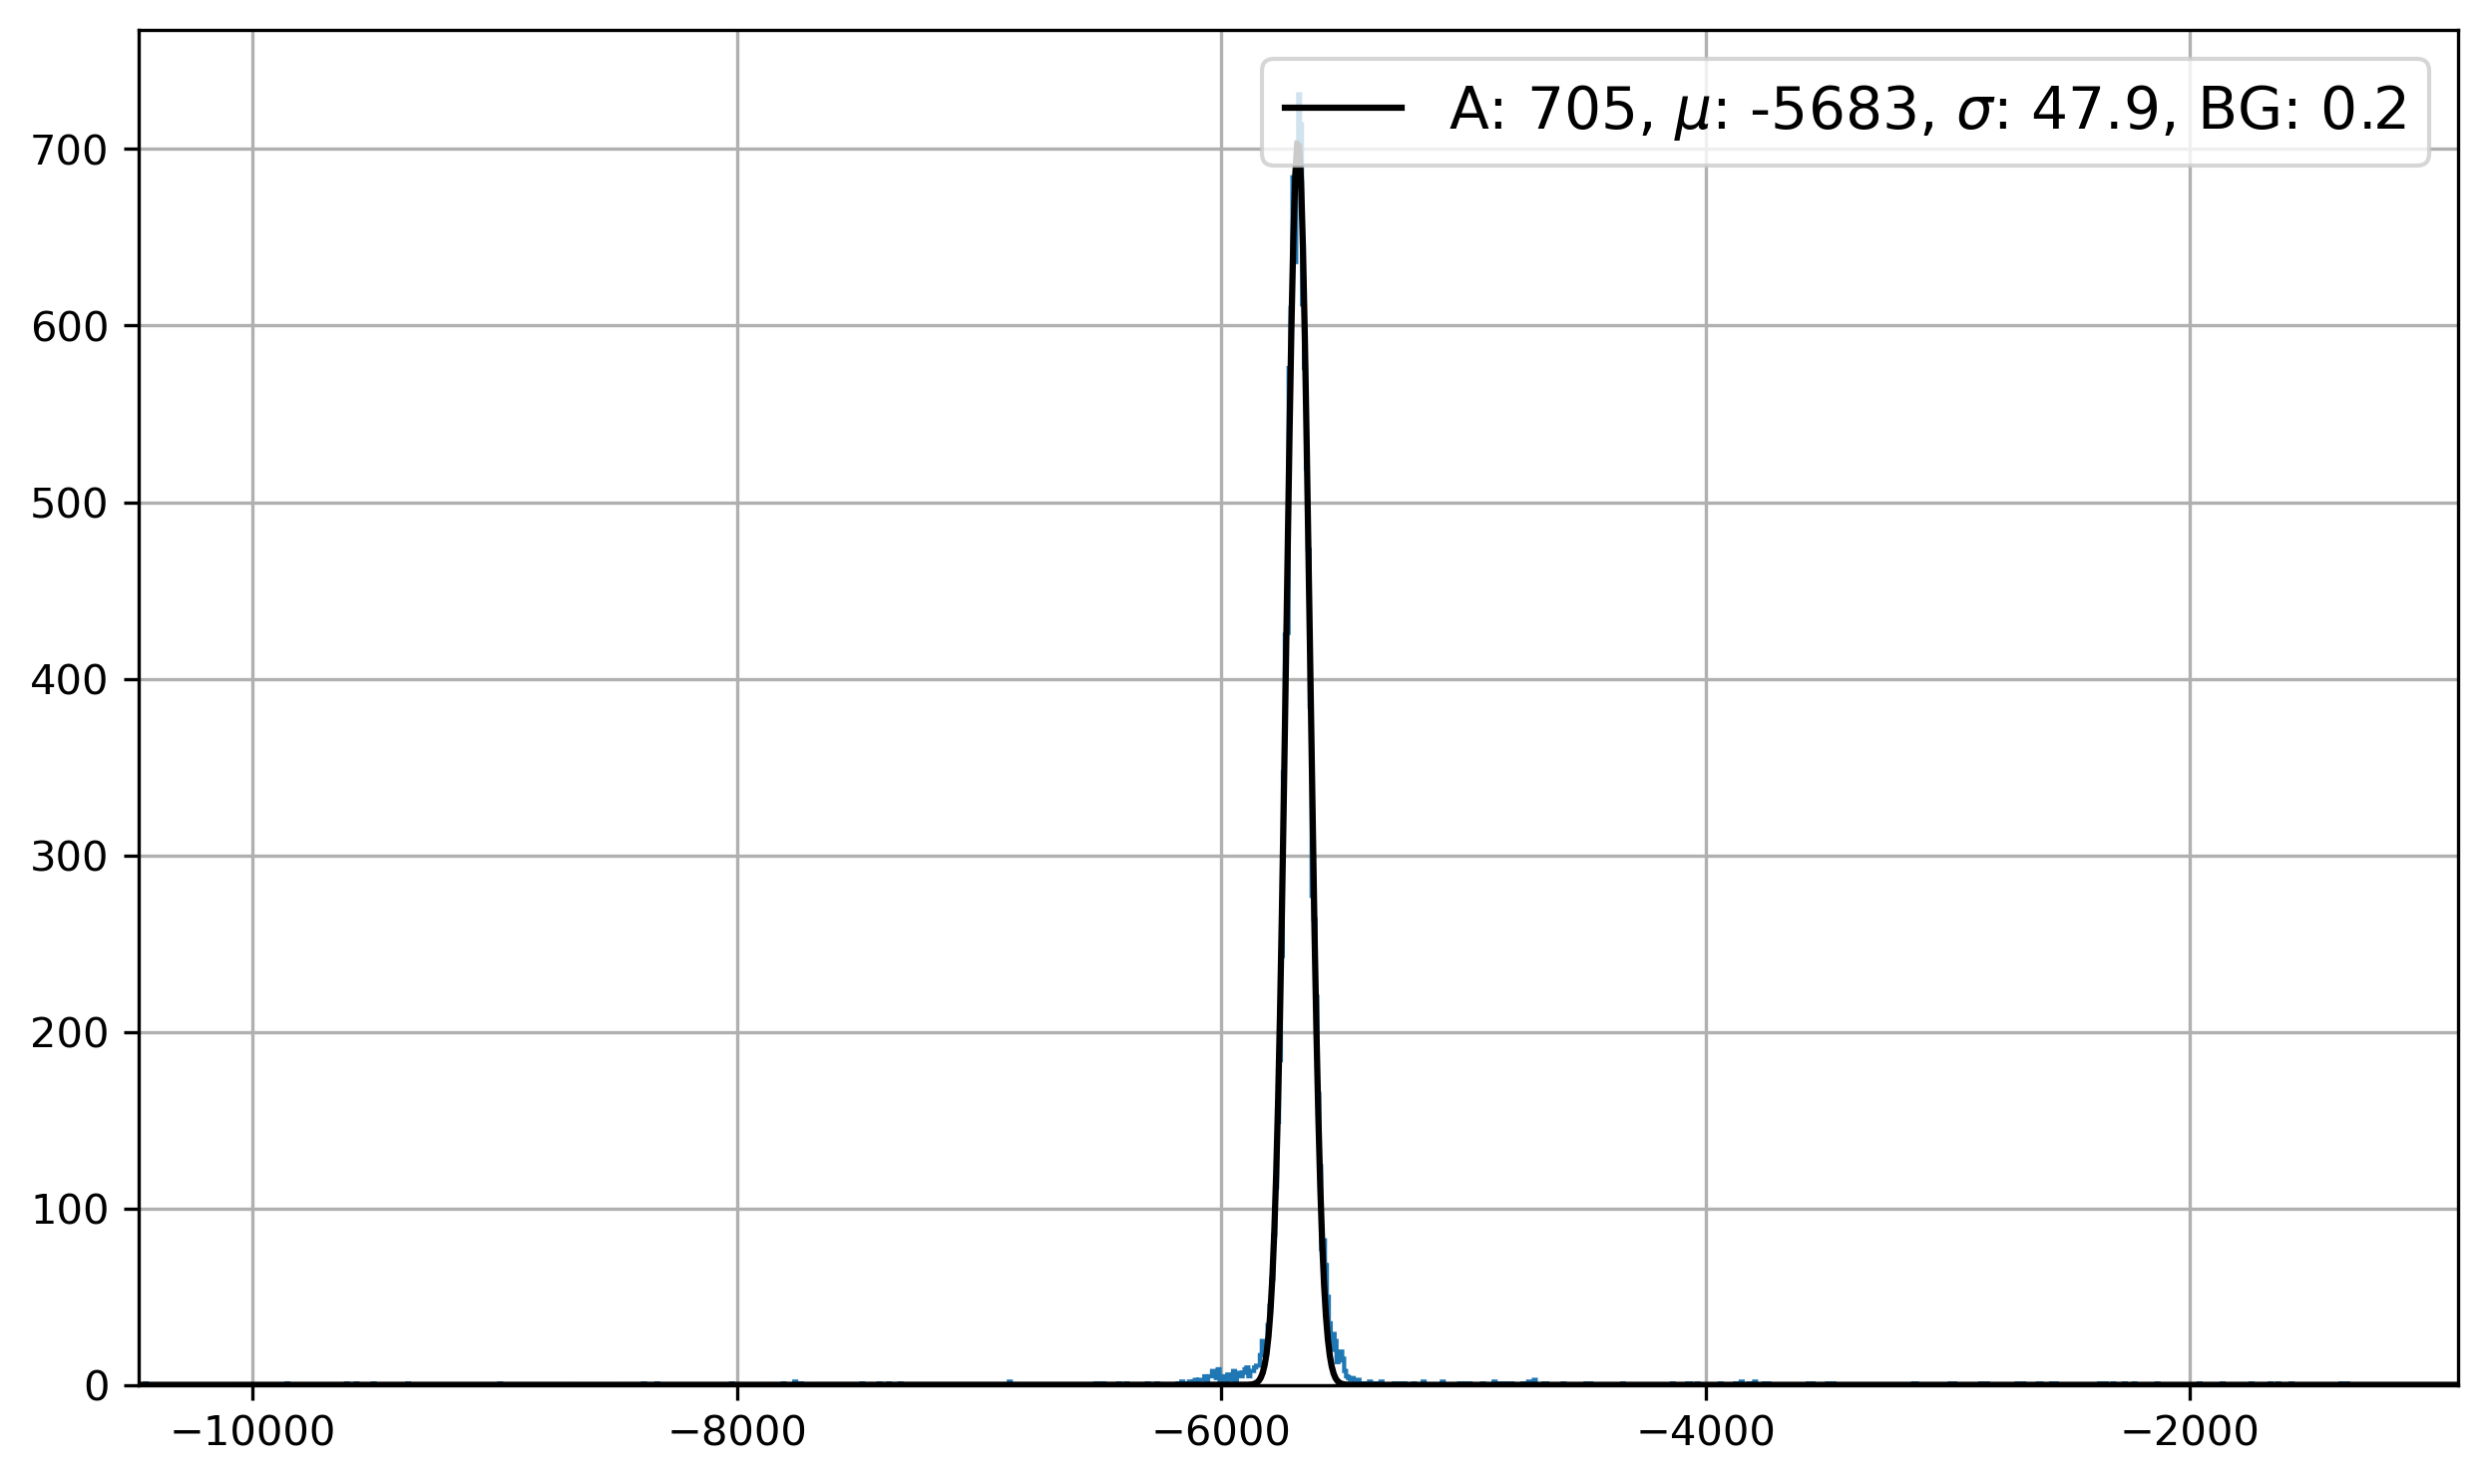

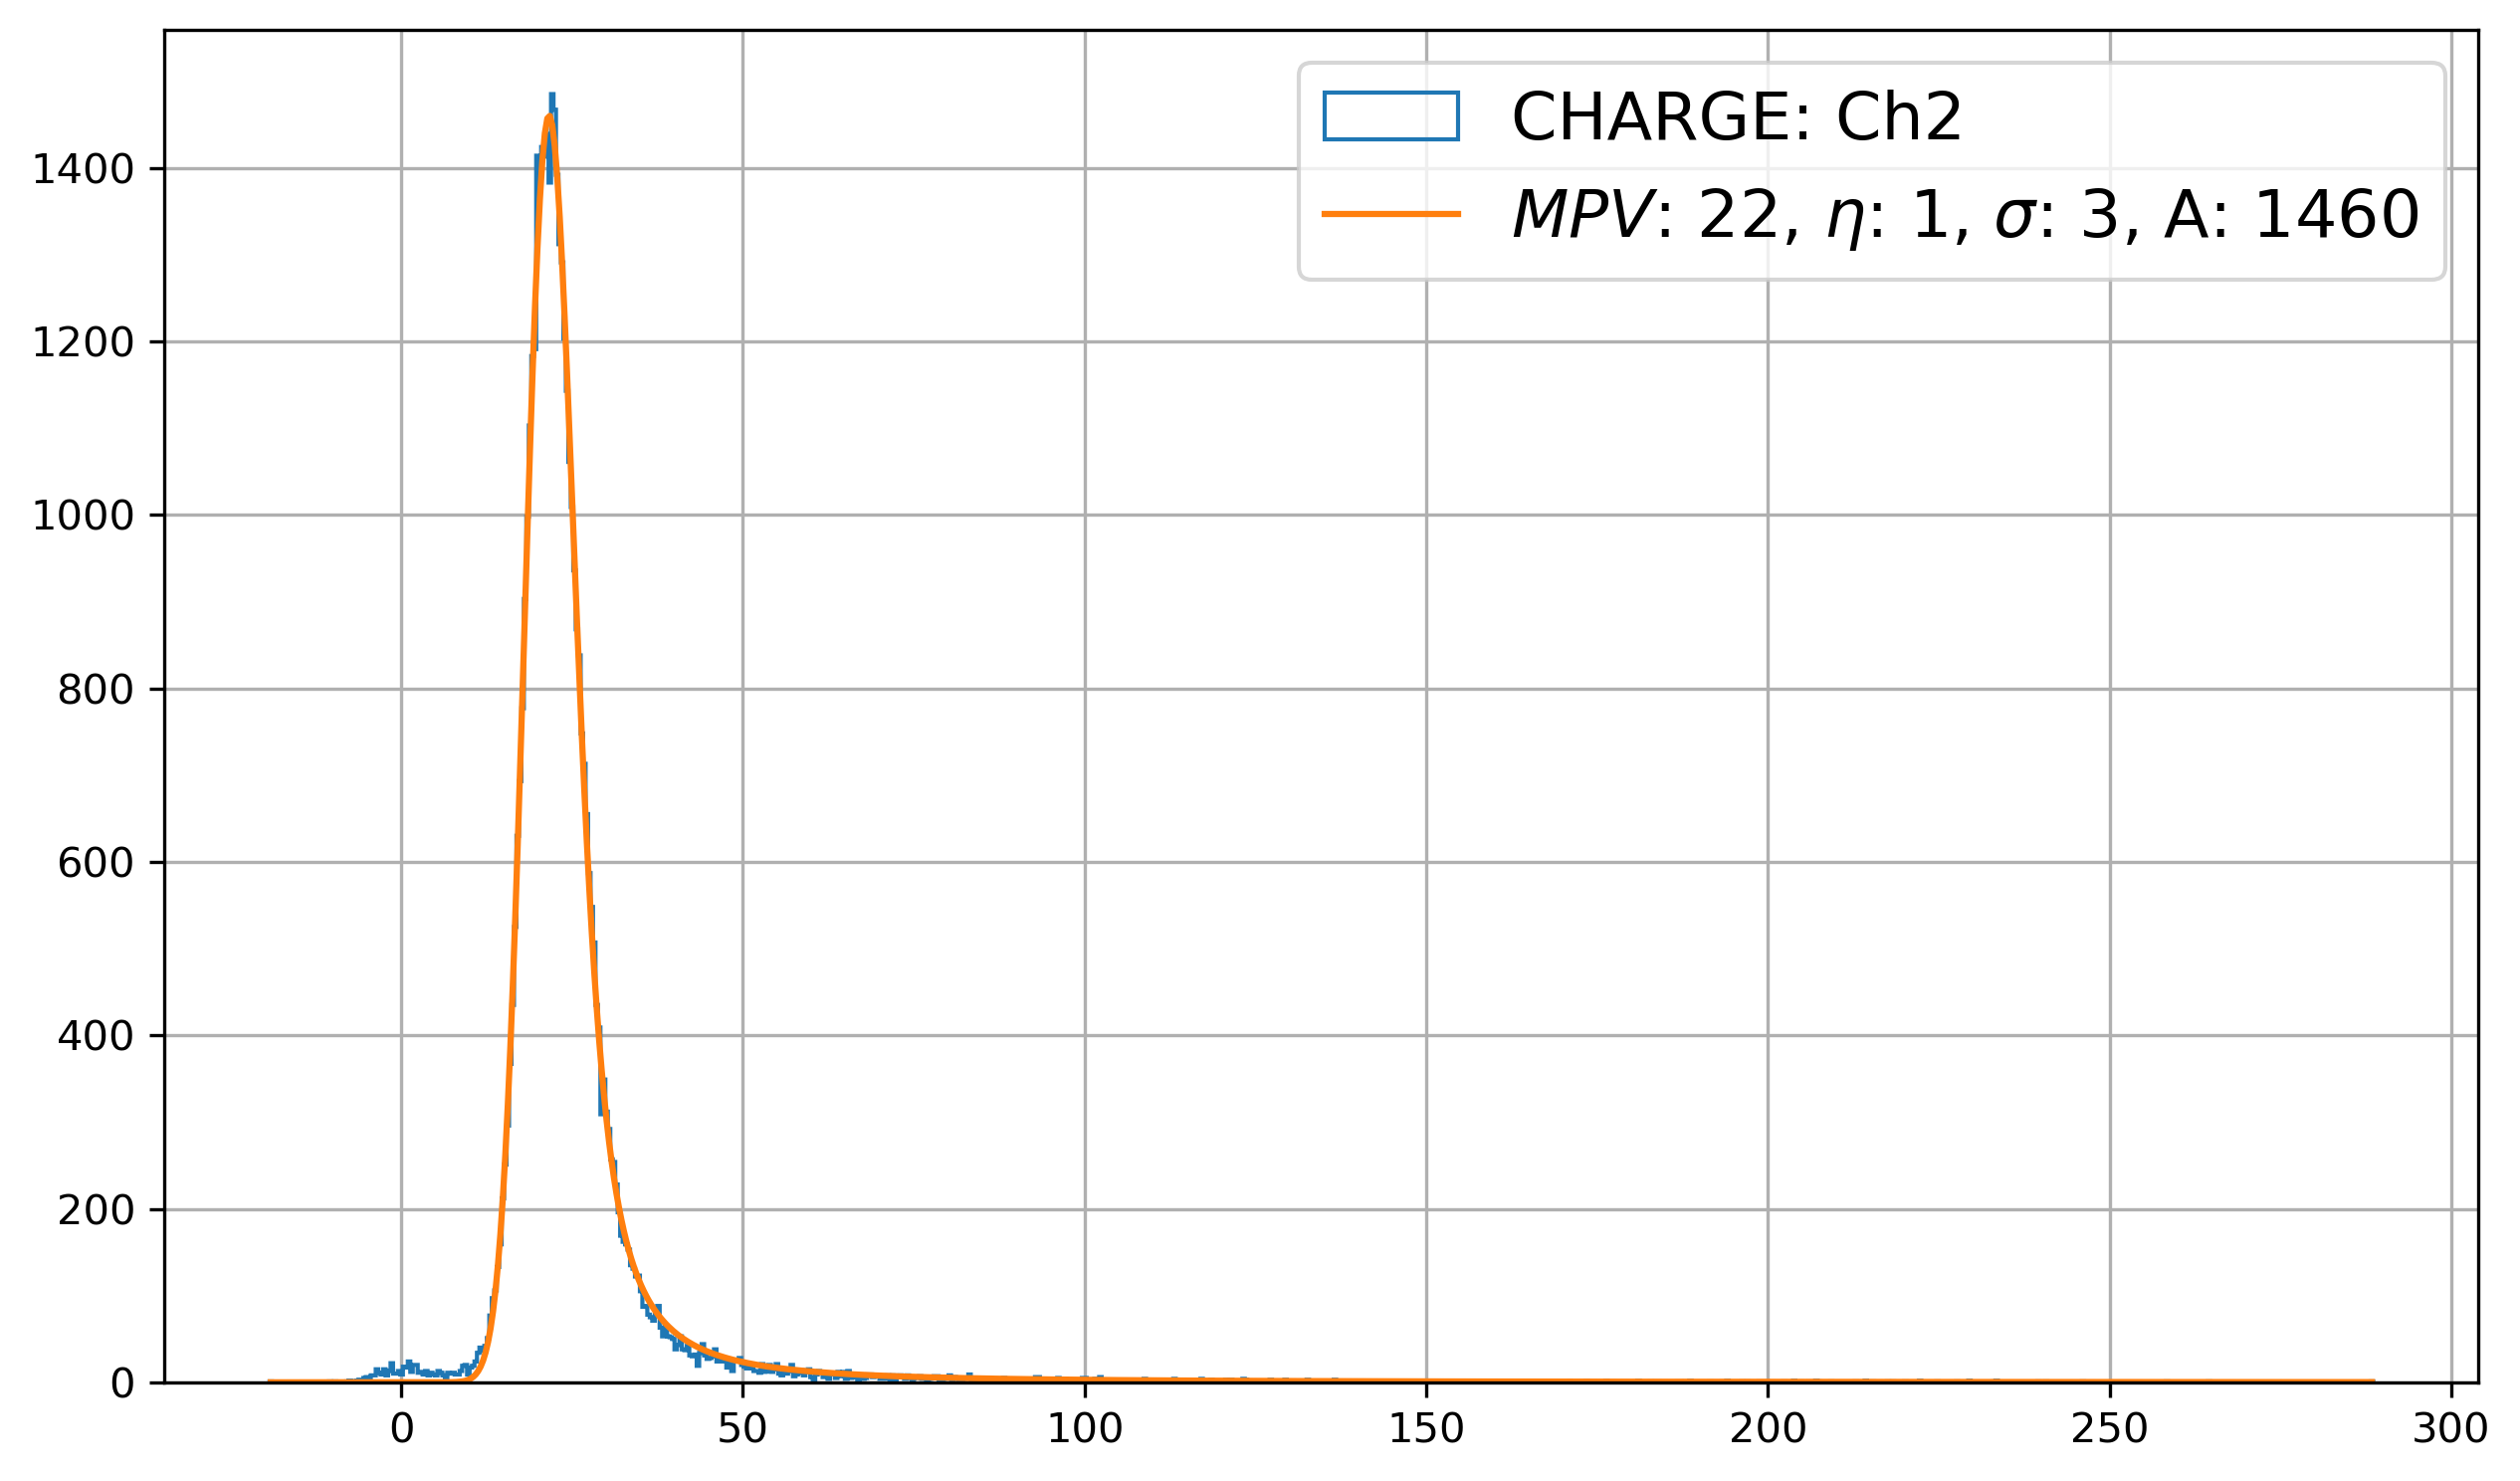

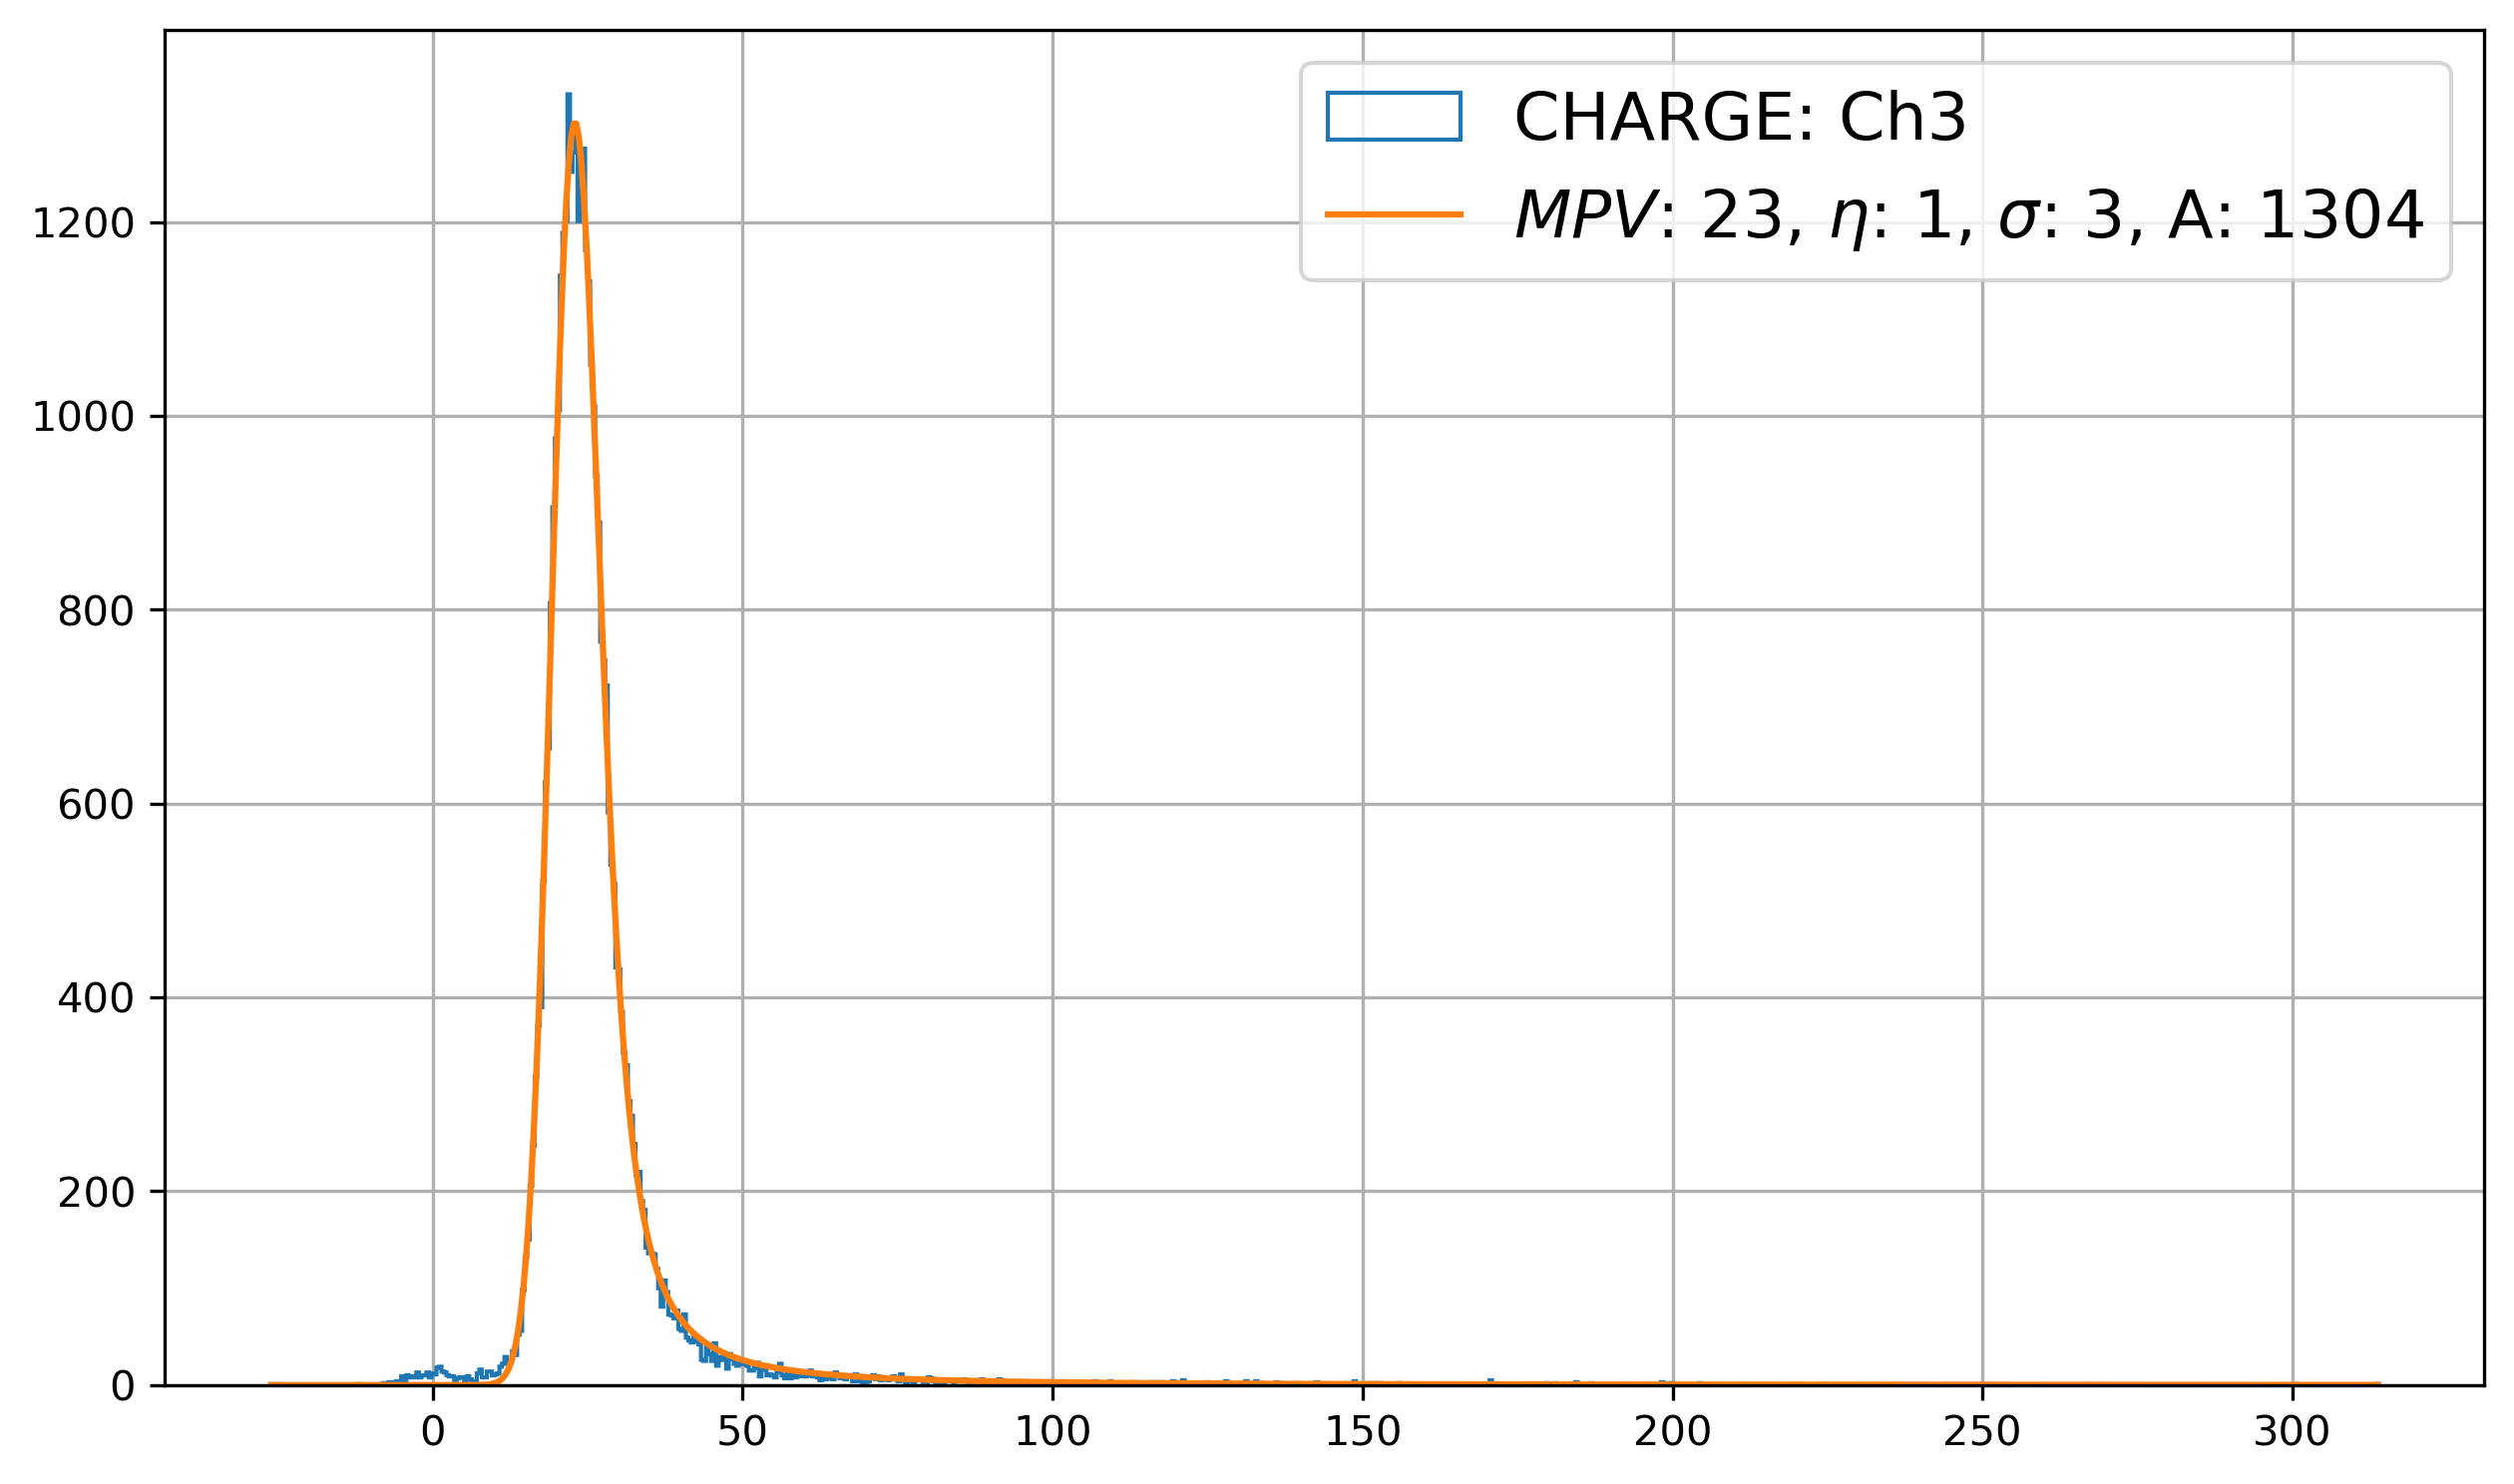

In [14]:
DUTs = (1,2)
# binning_method = 'rice'
threshold_charge = 4 #fC
charge = []
charge_error = []
voltage = []
angle = []
MCP_voltage = []
time_resolution = []
efficiency = []

SAVE = True

for this_batch in df_analysis.index.levels[0]: ### batches
    for S in df_analysis.index.levels[1]:        ### scopes
        df = load_batch(this_batch,S)
        mins = [find_min_btw_peaks(df[f"pulseHeight_{dut}"], bins='rice', plot=False) for i,dut in enumerate([1,2,3])]
        geometry_cut = [geometry_mask(df, DUT_number=dut, bins=bins1)[0] for i,dut in enumerate([1,2,3])]
        time_cut = [time_mask(df, dut, bins=5000, mask=geometry_cut[i], plot=True)[0] for i,dut in enumerate([1,2,3])]
        pulseheight_cut = [df[f'pulseHeight_{dut}']>mins[i] for i,dut in enumerate([1,2,3])]
        
        all_cut = [np.logical_and(np.logical_and(geometry_cut[i],time_cut[i]),pulseheight_cut[i]) for i,dut in enumerate([1,2,3])]
        ### I should use all time cuts to calculate the time resolution
        time_parameters = [time_mask(df, dut, bins=5000, mask=all_cut[i])[1]['parameters'] for i,dut in enumerate([1,2,3])]

        print(f"MCP: {dict_of_batches[this_batch].S[S].channels['Ch1'].voltage} V, angle: {dict_of_batches[this_batch].angle}°", f"temperature:{dict_of_batches[this_batch].tempA}°C")

        for ch in df_analysis.index.levels[2]:      ### channels
            ### EXTRACTING DATA
            match ch:
                case 'Ch1': dut=-1
                case 'Ch2': dut=1
                case 'Ch3': dut=2
                case 'Ch4': dut=3
                case other: logging.error("wrong channel name")
            print(f"""Batch:{this_batch}, Scope:{S}, Channel:{ch}, Sensor:{dict_of_batches[this_batch].S[S].get_sensor(ch).name}, \
            Board: {dict_of_batches[this_batch].S[S].get_sensor(ch).board}""")
#             transimpedance = dict_of_batches[this_batch].S[S].channels[ch].transimpedance
            transimpedance = 4700
            param, covar = charge_fit(df, dut=dut, mask=np.logical_and(time_cut[dut-1],geometry_cut[dut-1]), transimpedance=transimpedance, plot=True)
            print(f"Charge:{param[0]}, transimpedance:{transimpedance}")
            charge.append(param[0])
            charge_error.append(covar[0,0]**0.5) ### variance to error
            voltage.append(dict_of_batches[this_batch].S[S].channels[ch].voltage)
            angle.append(dict_of_batches[this_batch].angle)
            MCP_voltage.append(dict_of_batches[this_batch].S[S].channels['Ch1'].voltage)
            
            efficiency.append(efficiency_error(df[f"charge_{dut}"].loc[geometry_cut[dut-1]]/transimpedance, threshold_charge)[0])

                ### later on I need to add the uncertainty on the MCP time resolution
            match MCP_voltage[-1]:  ### last MCP_voltage entry
                case 2500: MCP_resolution = 36.52 # +/- 0.81
                case 2600: MCP_resolution = 16.48 # +/- 0.57
                case 2800: MCP_resolution = 3.73  # +/- 1.33
                case other: logging.error("Incorrect MCP voltage")
            print(f"time resolution^2: ({time_parameters[dut-1][2]})^2 - ({MCP_resolution})^2")
            time_resolution.append(np.sqrt(time_parameters[dut-1][2]**2 - MCP_resolution**2))

            
df_analysis['charge'] = charge
df_analysis['voltage'] = voltage
df_analysis['charge_error'] = charge_error
df_analysis['angle'] = angle
df_analysis['MCP_voltage'] = MCP_voltage
df_analysis['time_resolution'] = time_resolution
df_analysis['efficiency'] = efficiency

dict_analysis_USTC[key_to_study] = df_analysis.copy()

In [15]:

### select one value from the index channel
df_analysis.loc[idx[:,:,'Ch2'],['charge']] ### DATAFRAME  
df_analysis.loc[idx[:,:,'Ch2']]['charge']  ### SERIES
display(df_analysis)



charge  voltage  charge_error  angle  \
batch oscilloscope channel                                            
301   S1           Ch2      11.682150     -120      0.003963    0.0   
                   Ch3      12.219821     -120      0.004642    0.0   
408   S1           Ch2      17.088246     -150      0.006047    0.0   
                   Ch3      17.863805     -150      0.003823    0.0   
409   S1           Ch2      21.668498     -165      0.005759    0.0   
                   Ch3      22.928550     -165      0.007214    0.0   
410   S1           Ch2      21.632607     -165      0.008165    0.0   
                   Ch3      22.954806     -165      0.312503    0.0   

                            MCP_voltage  time_resolution  efficiency  
batch oscilloscope channel                                            
301   S1           Ch2             2500        71.297407    0.941558  
                   Ch3             2500        67.809361    0.952734  
408   S1           Ch2             2500        63.699150    0.943794  
                   Ch3             2500        61.570012    0.946487  
409   S1           Ch2             2500        57.164936    0.945354  
                   Ch3             2500        55.609480    0.957857  
410   S1           Ch2             2600        43.147415    0.942918  
                   Ch3             2600        42.852278    0.952850

### Save the data
save the dictionary of dataframes

In [78]:
with open(USTC_file_name, 'wb') as f:
    pickle.dump(dict_analysis_USTC, f)

## Plots

In [11]:
markers = ('o','x','v','^','<','>','P','D','X')
colormap = ['k','b','g','r','orange']

#### Bias voltage vs MPV of charge

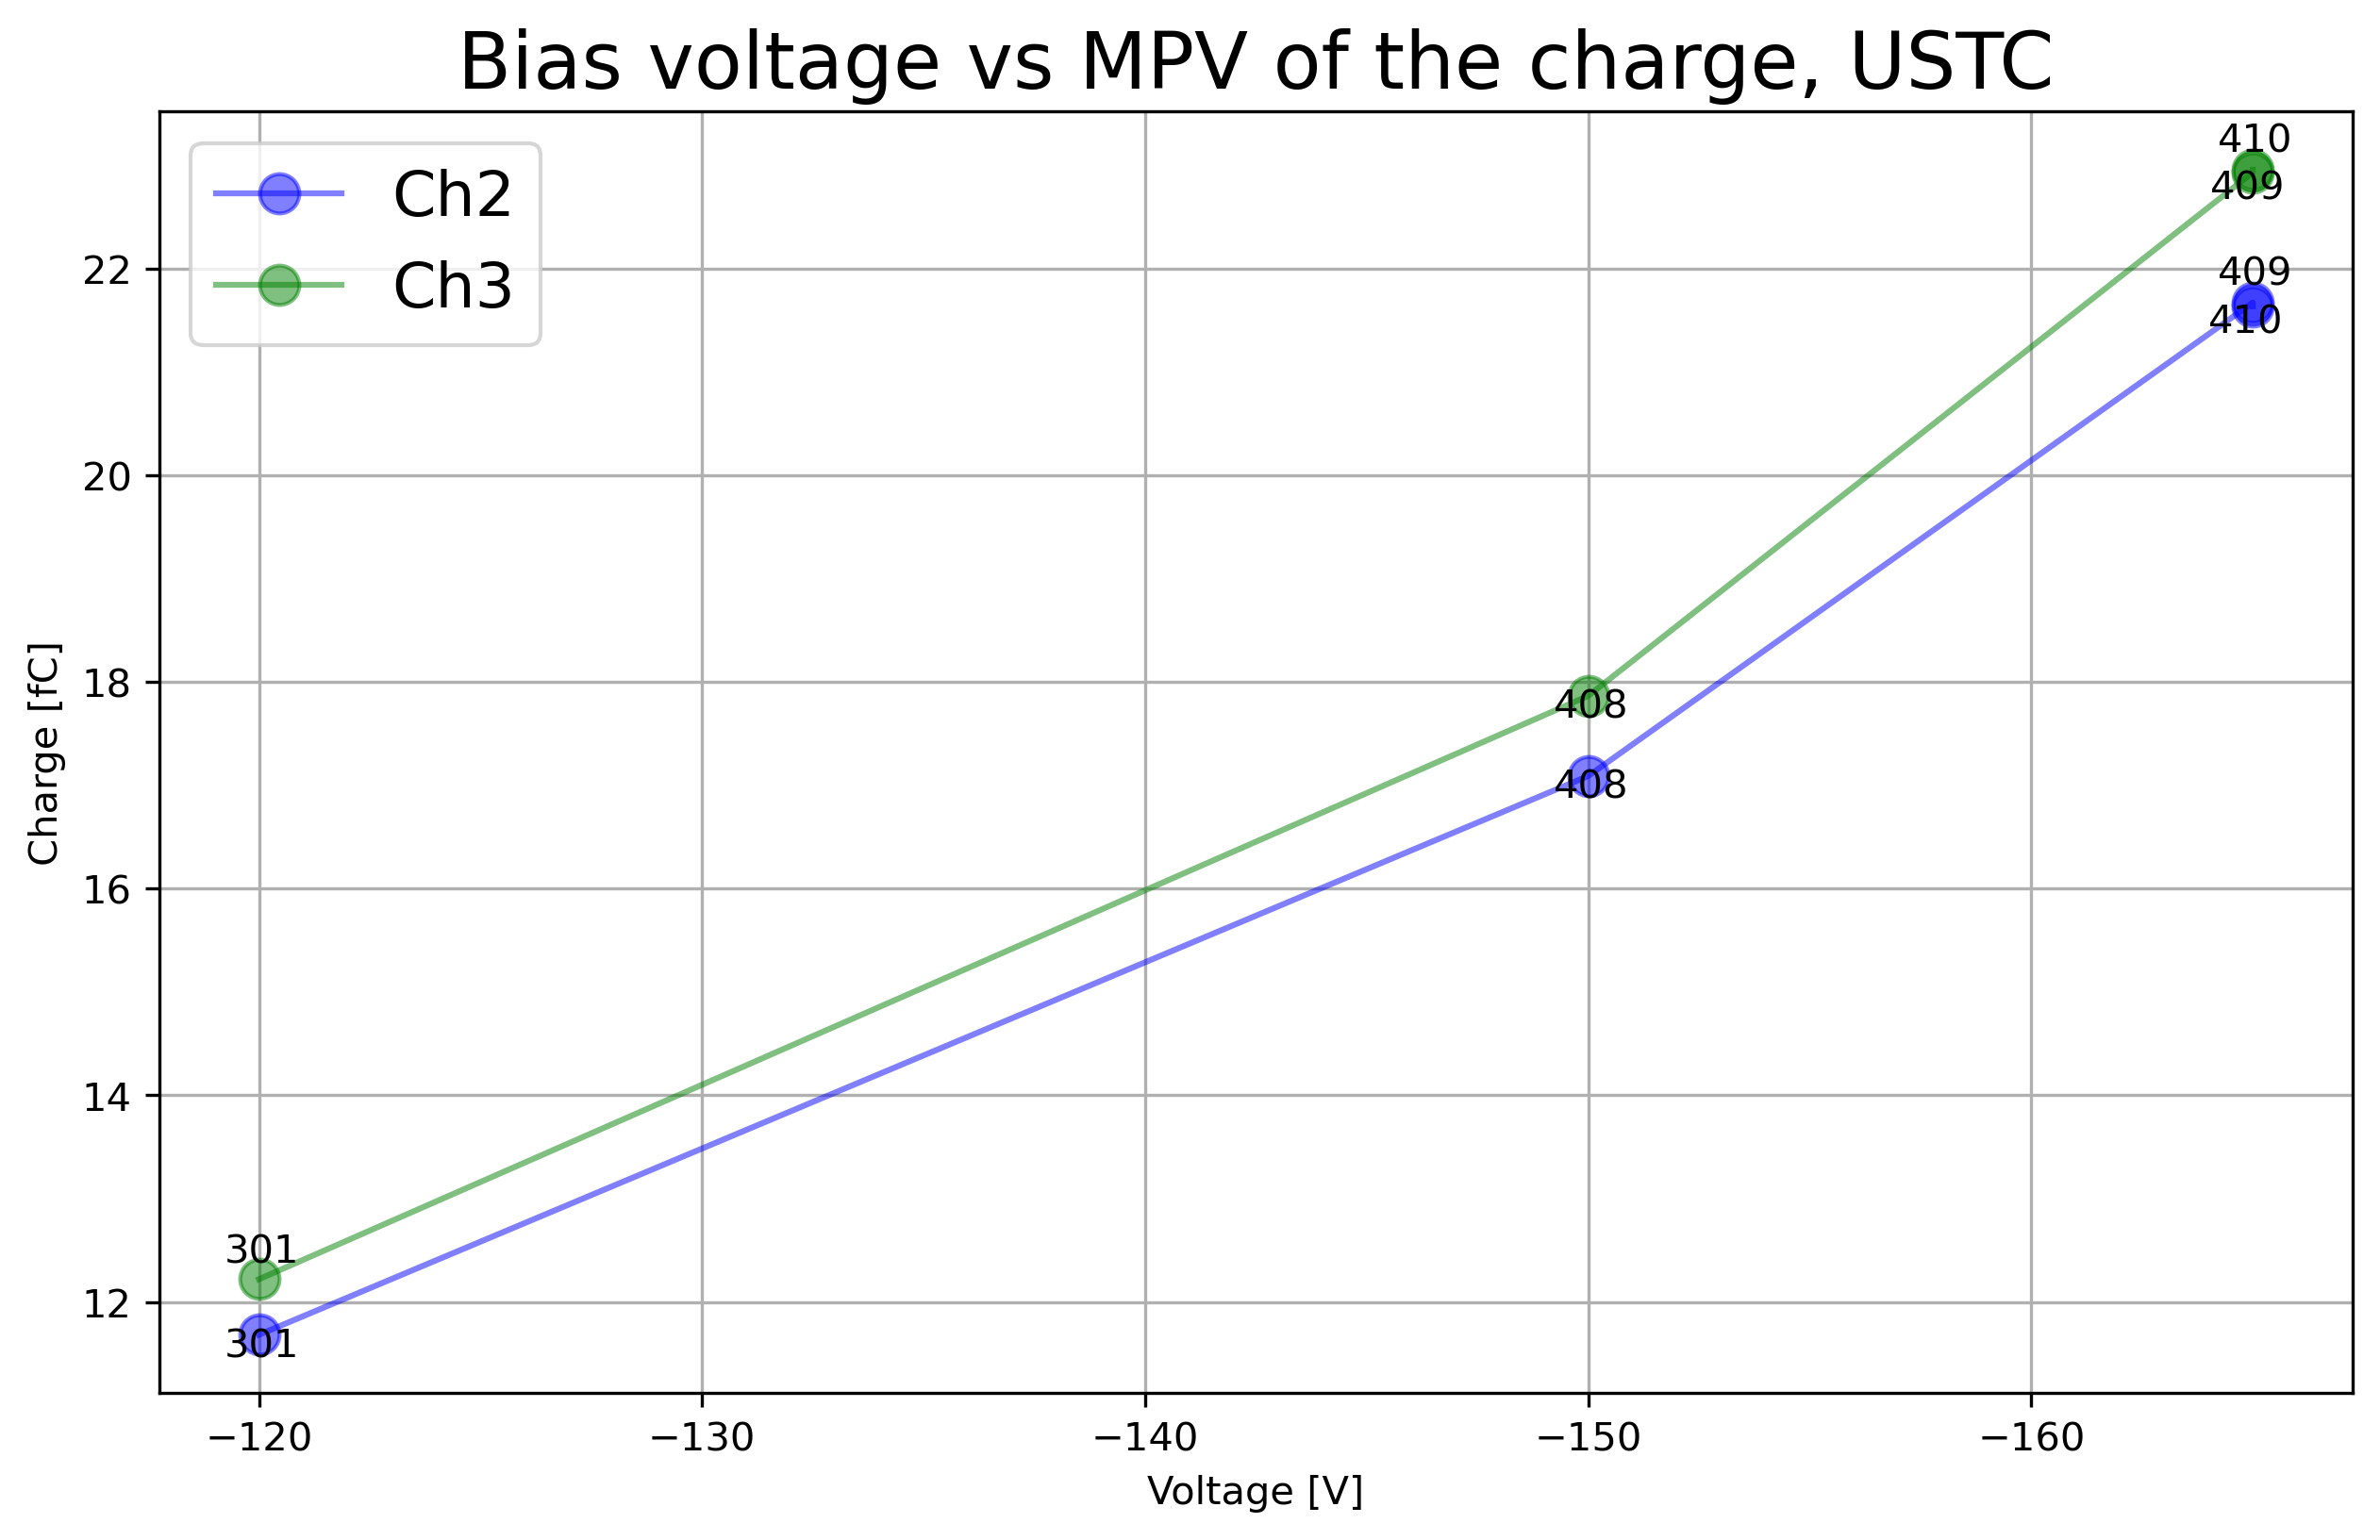

In [35]:
### WITHOUT ANGLE

list_of_texts = []
fig, ax = plt.subplots(figsize=(10,6), dpi=300)
for i, ch in enumerate(['Ch2','Ch3']):
    voltage = np.array(df_analysis.loc[idx[:,:,ch]]['voltage'])
    charge = np.array(df_analysis.loc[idx[:,:,ch]]['charge'])
    batch_labels = np.array(df_analysis.loc[idx[:,:,ch]].index.get_level_values('batch'))
    
    ax.plot(voltage, charge,
        marker='o', markersize=10, alpha=0.5, color=colormap[i+1],
        label=f"{ch}")
    
    for x,y,label in zip(voltage,charge,batch_labels):
        list_of_texts.append(ax.text(x,y, label))
adjust_text(list_of_texts)    
    
ax.set_title(f"Bias voltage vs MPV of the charge, USTC", fontsize=20)
ax.set_xlabel("Voltage [V]")
ax.set_ylabel("Charge [fC]")
# ax.set_ylim(0,None)
ax.invert_xaxis()

ax.grid('--')
ax.legend(fontsize=16)

fig.savefig(os.path.join(save_path,f"voltage_vs_charge_{key_to_study}_angled.svg"))

### Bias voltage vs time resolution

#### Time resolution:
$$
\Large \sigma_{dut+MCP}^2 = \sigma_{dut}^2 + \sigma_{MCP}^2 \\
\Large \downarrow \\
\Large \sigma_{dut} = \sqrt{\sigma_{dut+MCP}^2-\sigma_{MCP}^2}
$$

In [72]:
df_analysis['MCP_voltage'].unique()


array([2500])

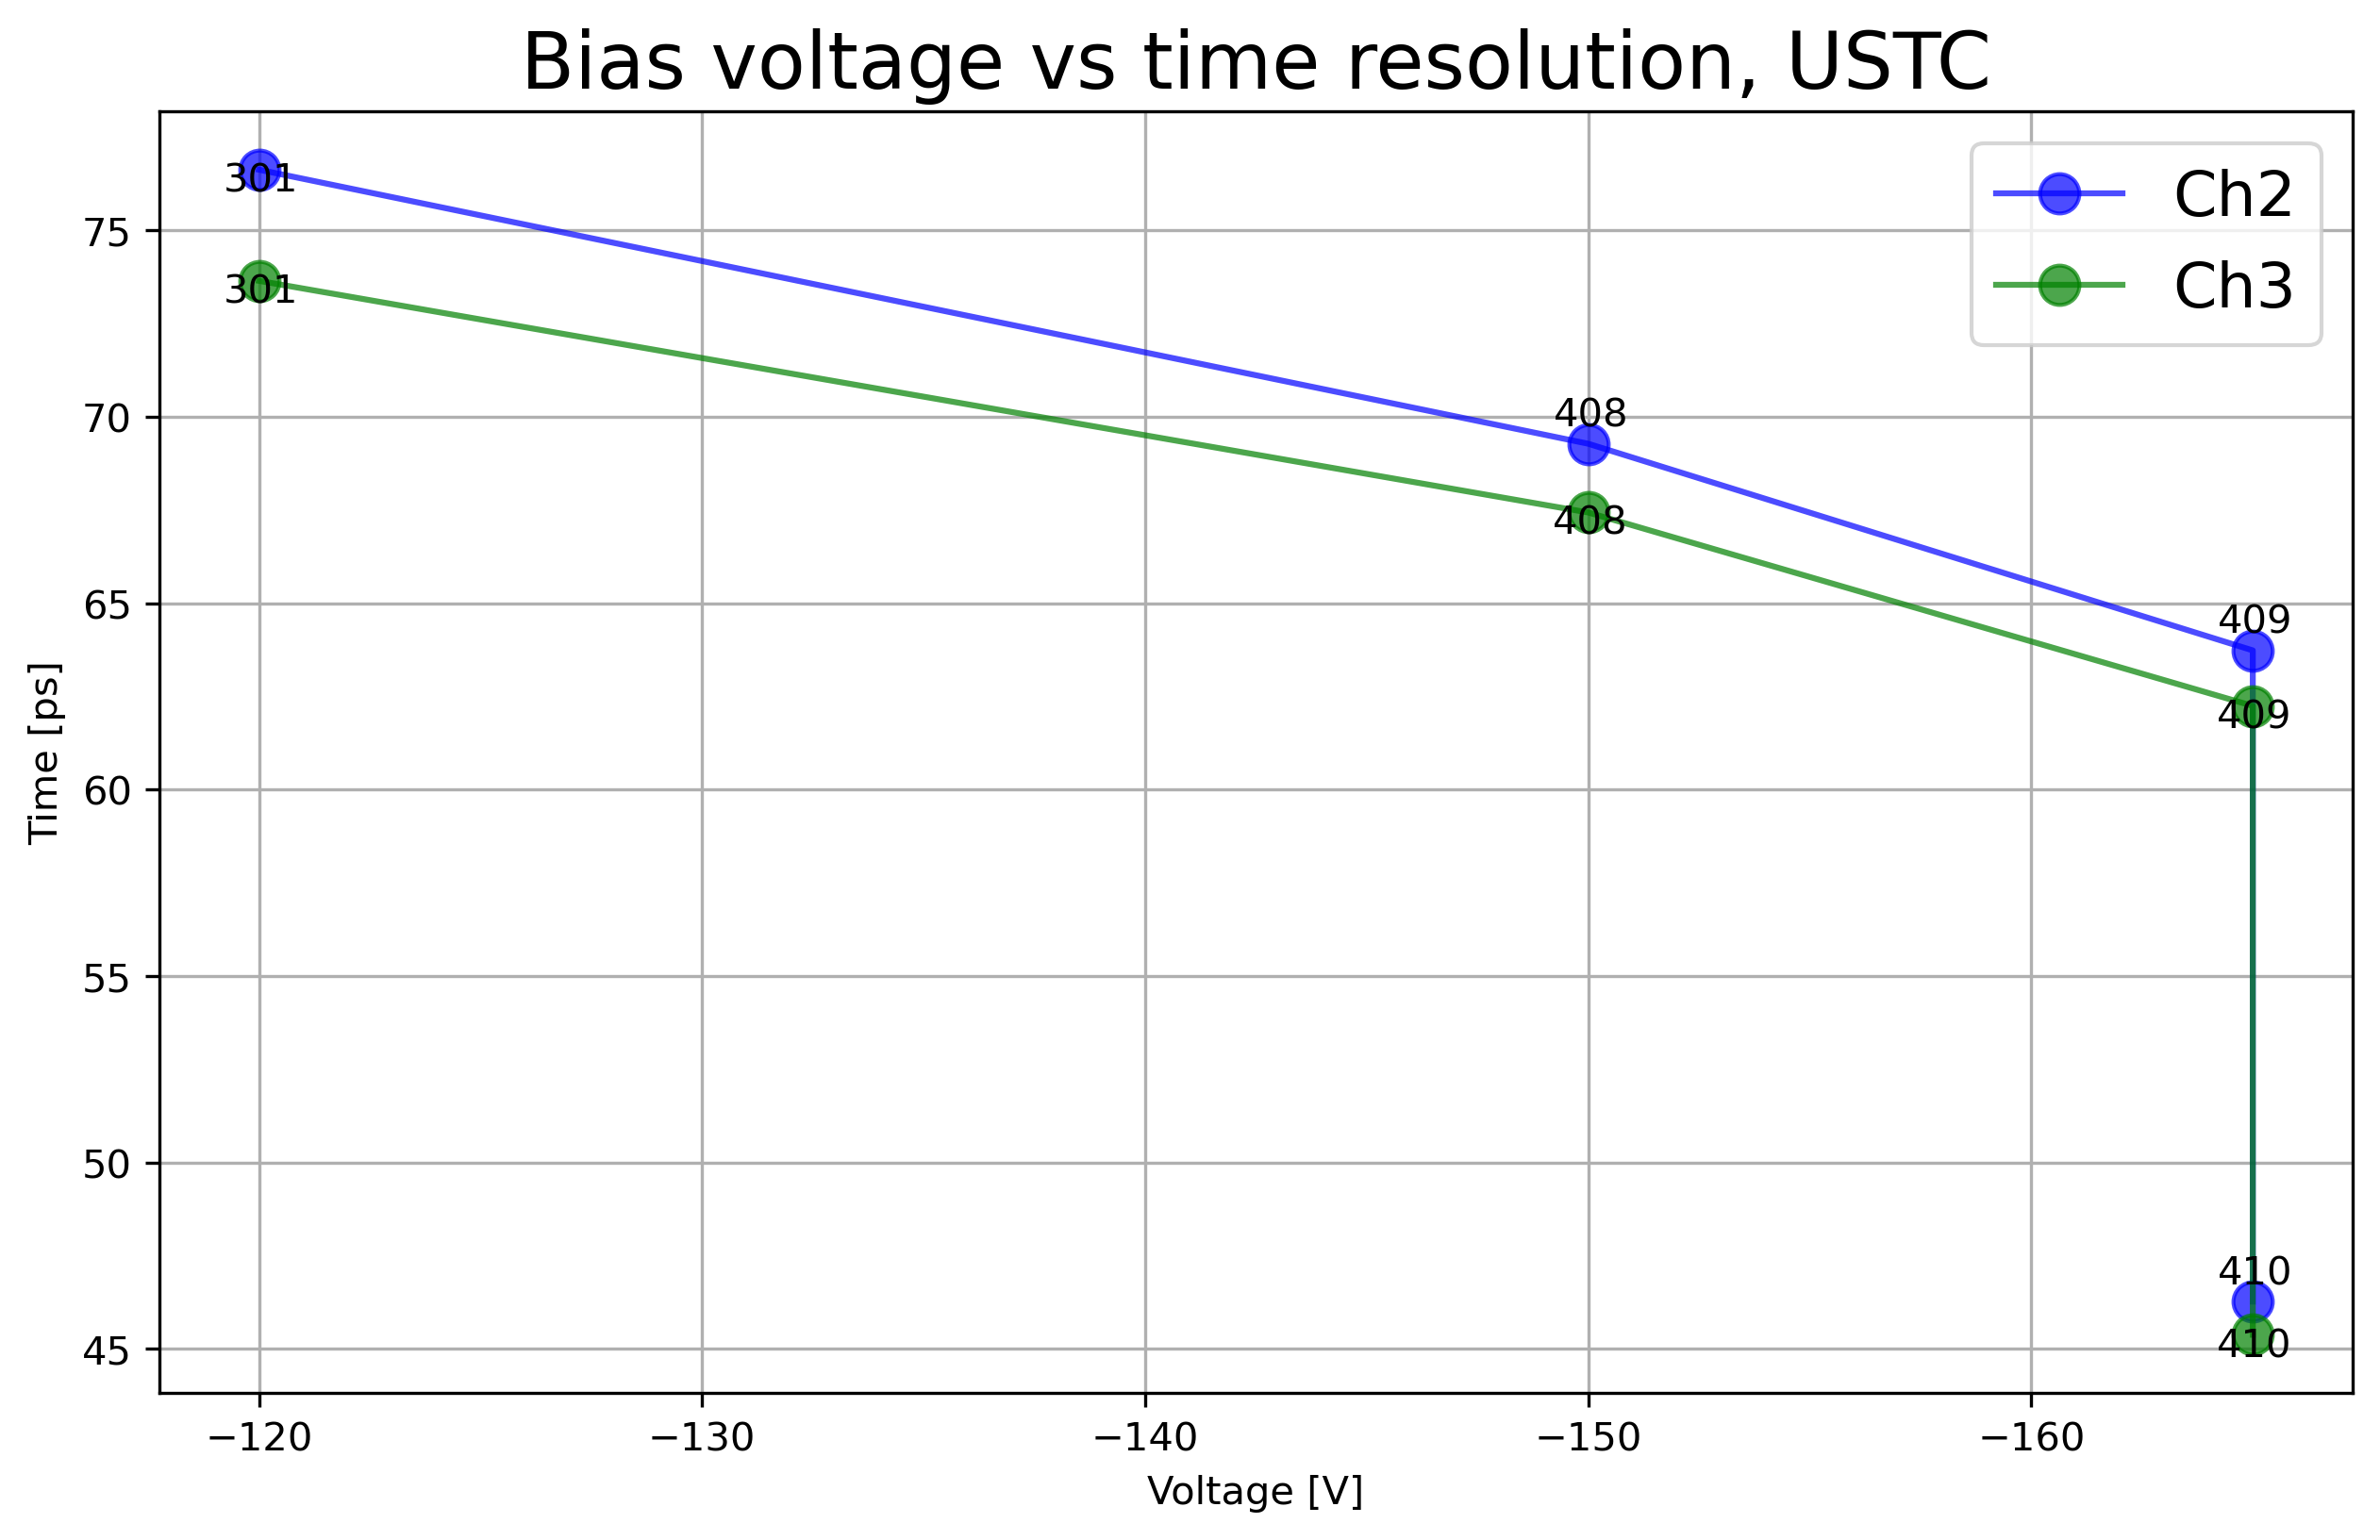

In [34]:
fig, ax = plt.subplots(figsize=(10,6), dpi=300)
list_of_texts = []
for i, ch in enumerate(['Ch2','Ch3']):
    voltage = np.array(df_analysis.loc[idx[:,:,ch]]['voltage'])
    time = np.array(df_analysis.loc[idx[:,:,ch]]['time_resolution'])
    batch_labels = np.array(df_analysis.loc[idx[:,:,ch]].index.get_level_values('batch'))
    
    ax.plot(voltage, time,
            marker='o', markersize=10, alpha=0.7, color=colormap[i+1],
            label=f"{ch}")
    for x,y,label in zip(voltage,time,batch_labels):
        list_of_texts.append(ax.text(x,y, label)) 
        
adjust_text(list_of_texts)
ax.set_title(f"Bias voltage vs time resolution, USTC", fontsize=20)
ax.set_xlabel("Voltage [V]")
ax.set_ylabel("Time [ps]")
# ax.set_ylim(0,None)
ax.invert_xaxis()

ax.grid('--')
ax.legend(fontsize=16)

# fig.savefig(f"../various plots/{this_sensor}/{key_to_study}/voltage_vs_charge_{key_to_study}.svg")
fig.savefig(os.path.join(save_path,f"voltage_vs_time_{key_to_study}.svg"))

In [ ]:
pylandau.langau()

## Angles

In [42]:
df_analysis['voltage'].unique()
df_analysis = dict_analysis_USTC['angled']

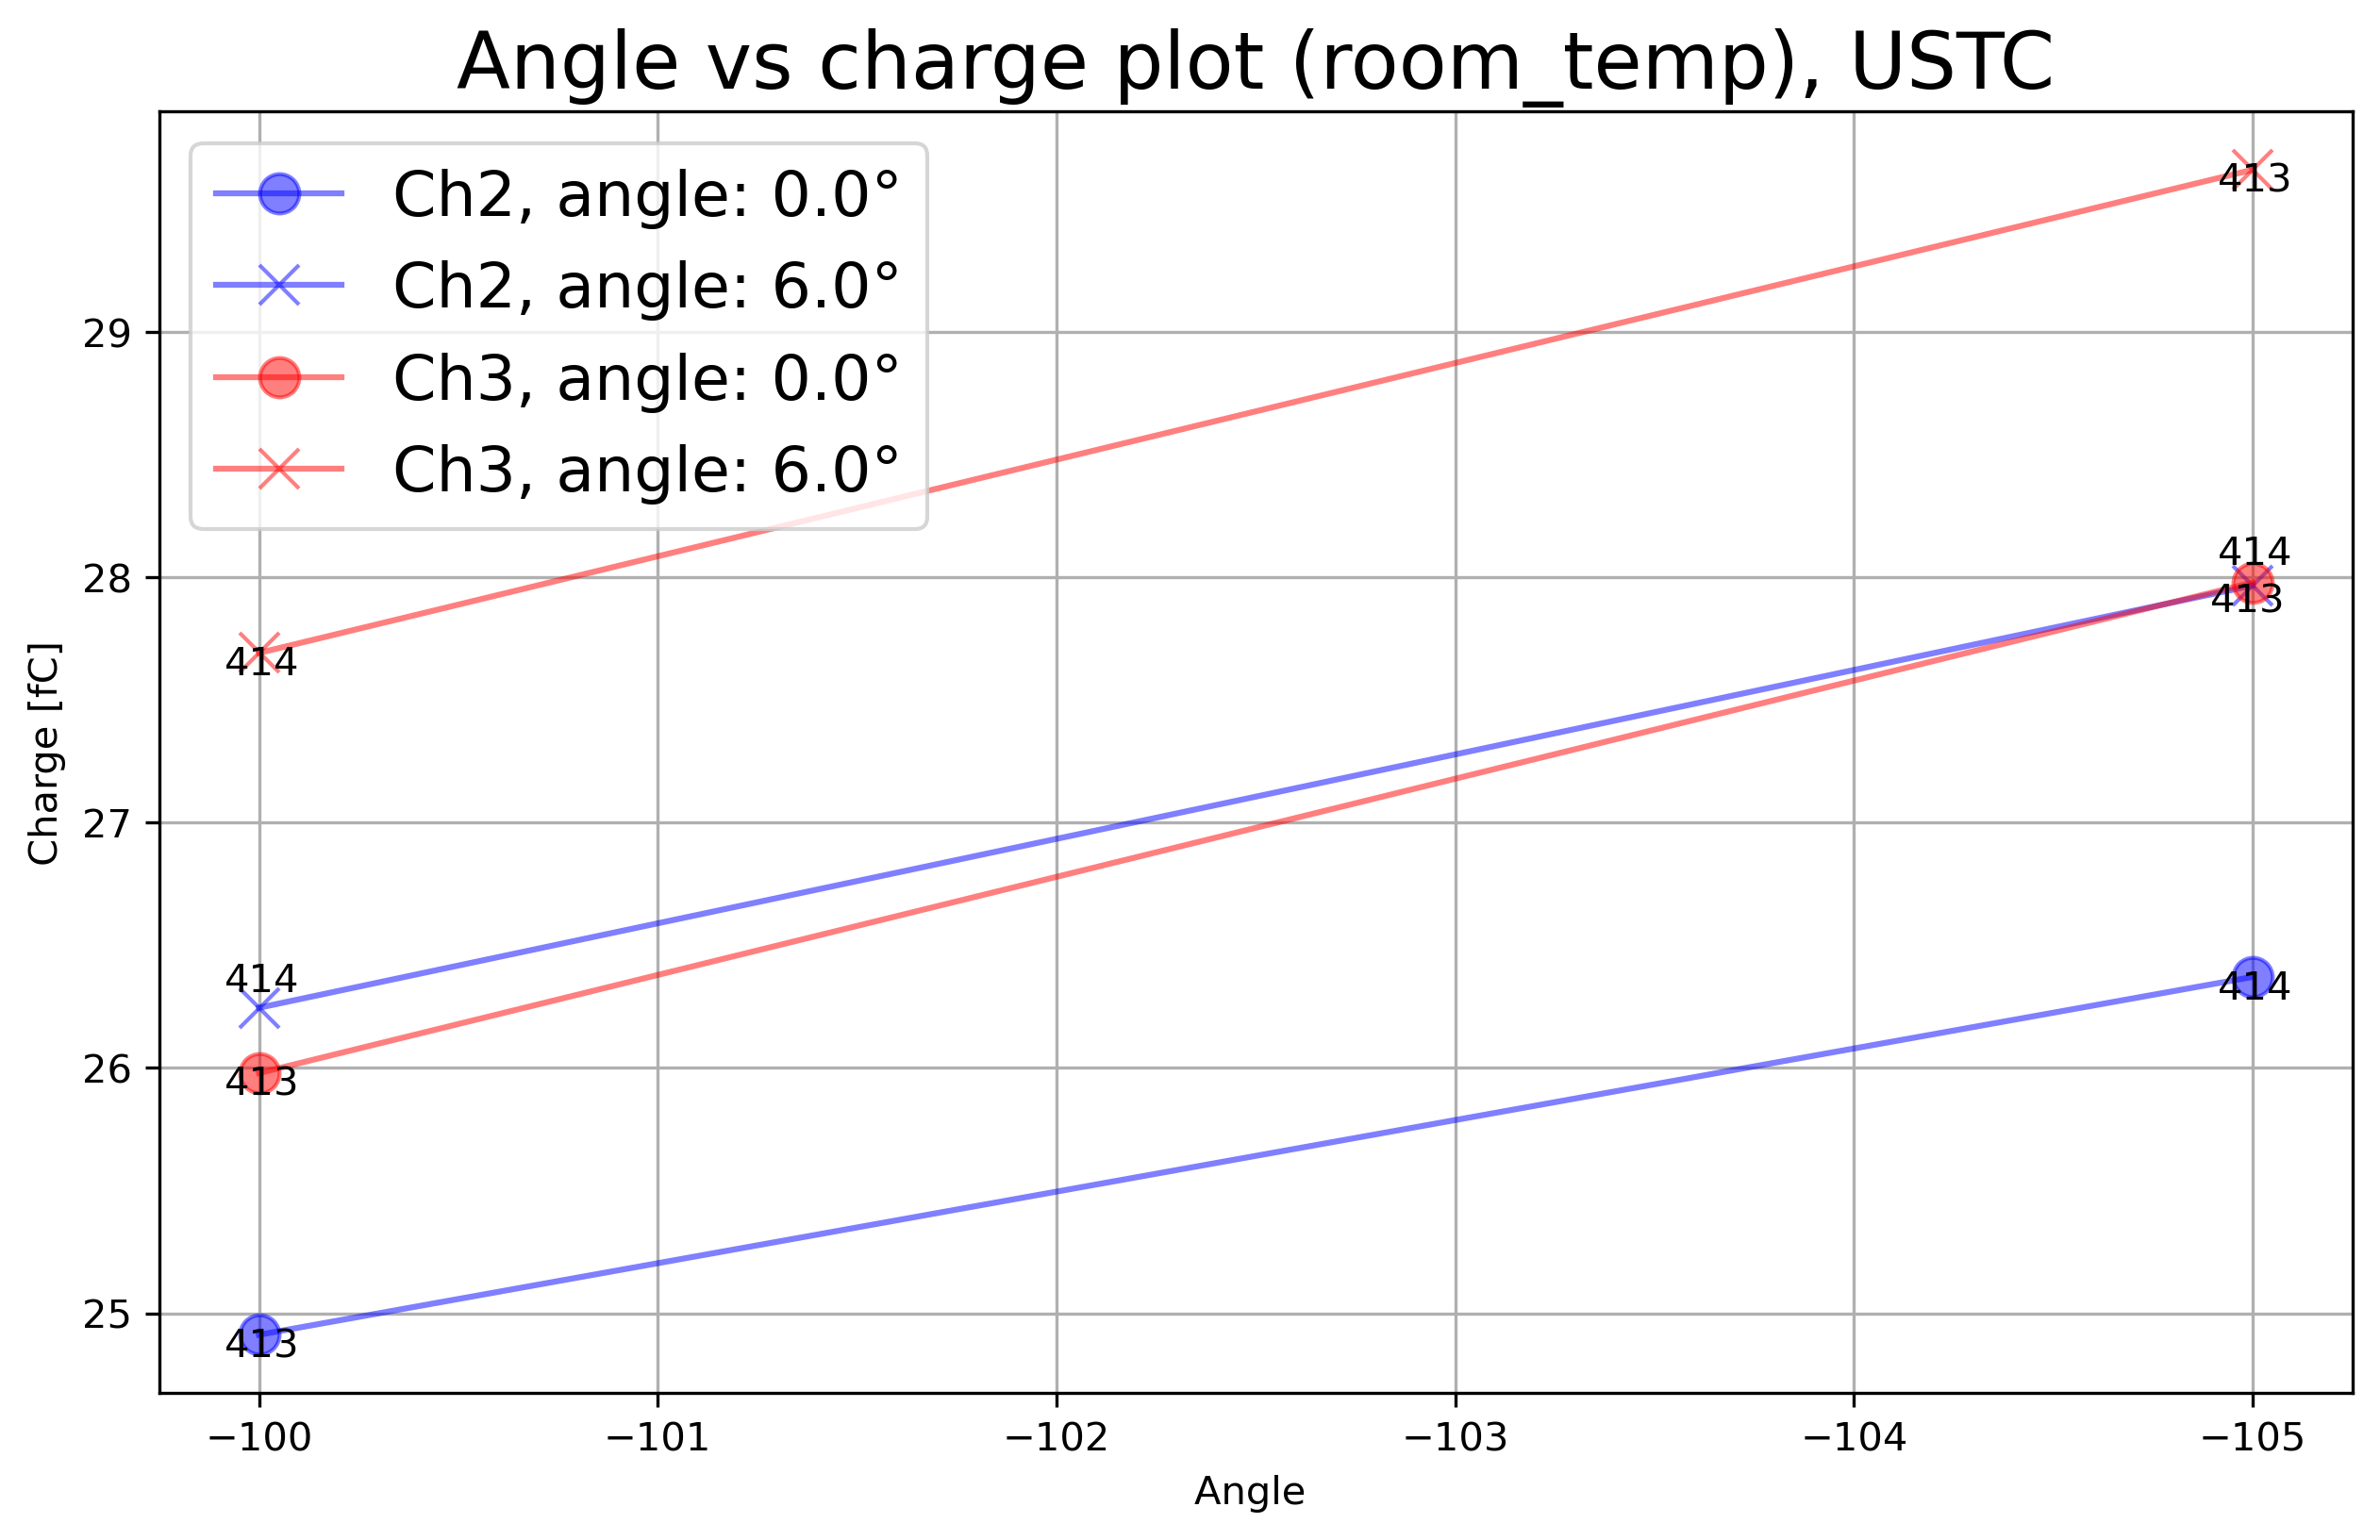

In [43]:
fig, ax = plt.subplots(figsize=(10,6), dpi=300)

list_of_texts = []
ch = 'Ch2'
for j,angle in enumerate(df_analysis['angle'].unique()):
    mask = df_analysis.loc[idx[:,:,ch]]['angle'] == angle
    voltage = np.array(df_analysis.loc[idx[:,:,ch]]['voltage'].loc[mask])
    charge = np.array(df_analysis.loc[idx[:,:,ch]]['charge'].loc[mask])
    ax.plot(voltage, charge,
            marker=markers[j], markersize=10, alpha=0.5, color=colormap[1],
            label=f"{ch}, angle: {angle}°")
    batch_labels = np.array(df_analysis.loc[idx[:,:,ch]].index.get_level_values('batch'))
    for x,y,label in zip(voltage,charge,batch_labels):
        list_of_texts.append(ax.text(x, y, label)) 
        
    
ch = 'Ch3'
for j,angle in enumerate(df_analysis['angle'].unique()):
    mask = df_analysis.loc[idx[:,:,ch]]['angle'] == angle
    voltage = np.array(df_analysis.loc[idx[:,:,ch]]['voltage'].loc[mask])
    charge = np.array(df_analysis.loc[idx[:,:,ch]]['charge'].loc[mask])
    ax.plot(voltage, charge,
            marker=markers[j], markersize=10, alpha=0.5, color=colormap[3],
            label=f"{ch}, angle: {angle}°")
    batch_labels = np.array(df_analysis.loc[idx[:,:,ch]].index.get_level_values('batch'))
    for x,y,label in zip(voltage,charge,batch_labels):
        list_of_texts.append(ax.text(x, y, label)) 
        
adjust_text(list_of_texts)
    
    
ax.set_title(f"Angle vs charge plot, USTC", fontsize=20)
ax.set_xlabel("Angle ")
ax.set_ylabel("Charge [fC]")
# ax.set_ylim(0,None)

ax.grid('--')
ax.legend(fontsize=16)
ax.invert_xaxis()

fig.savefig(os.path.join(save_path,f"angles_vs_charge.svg"))


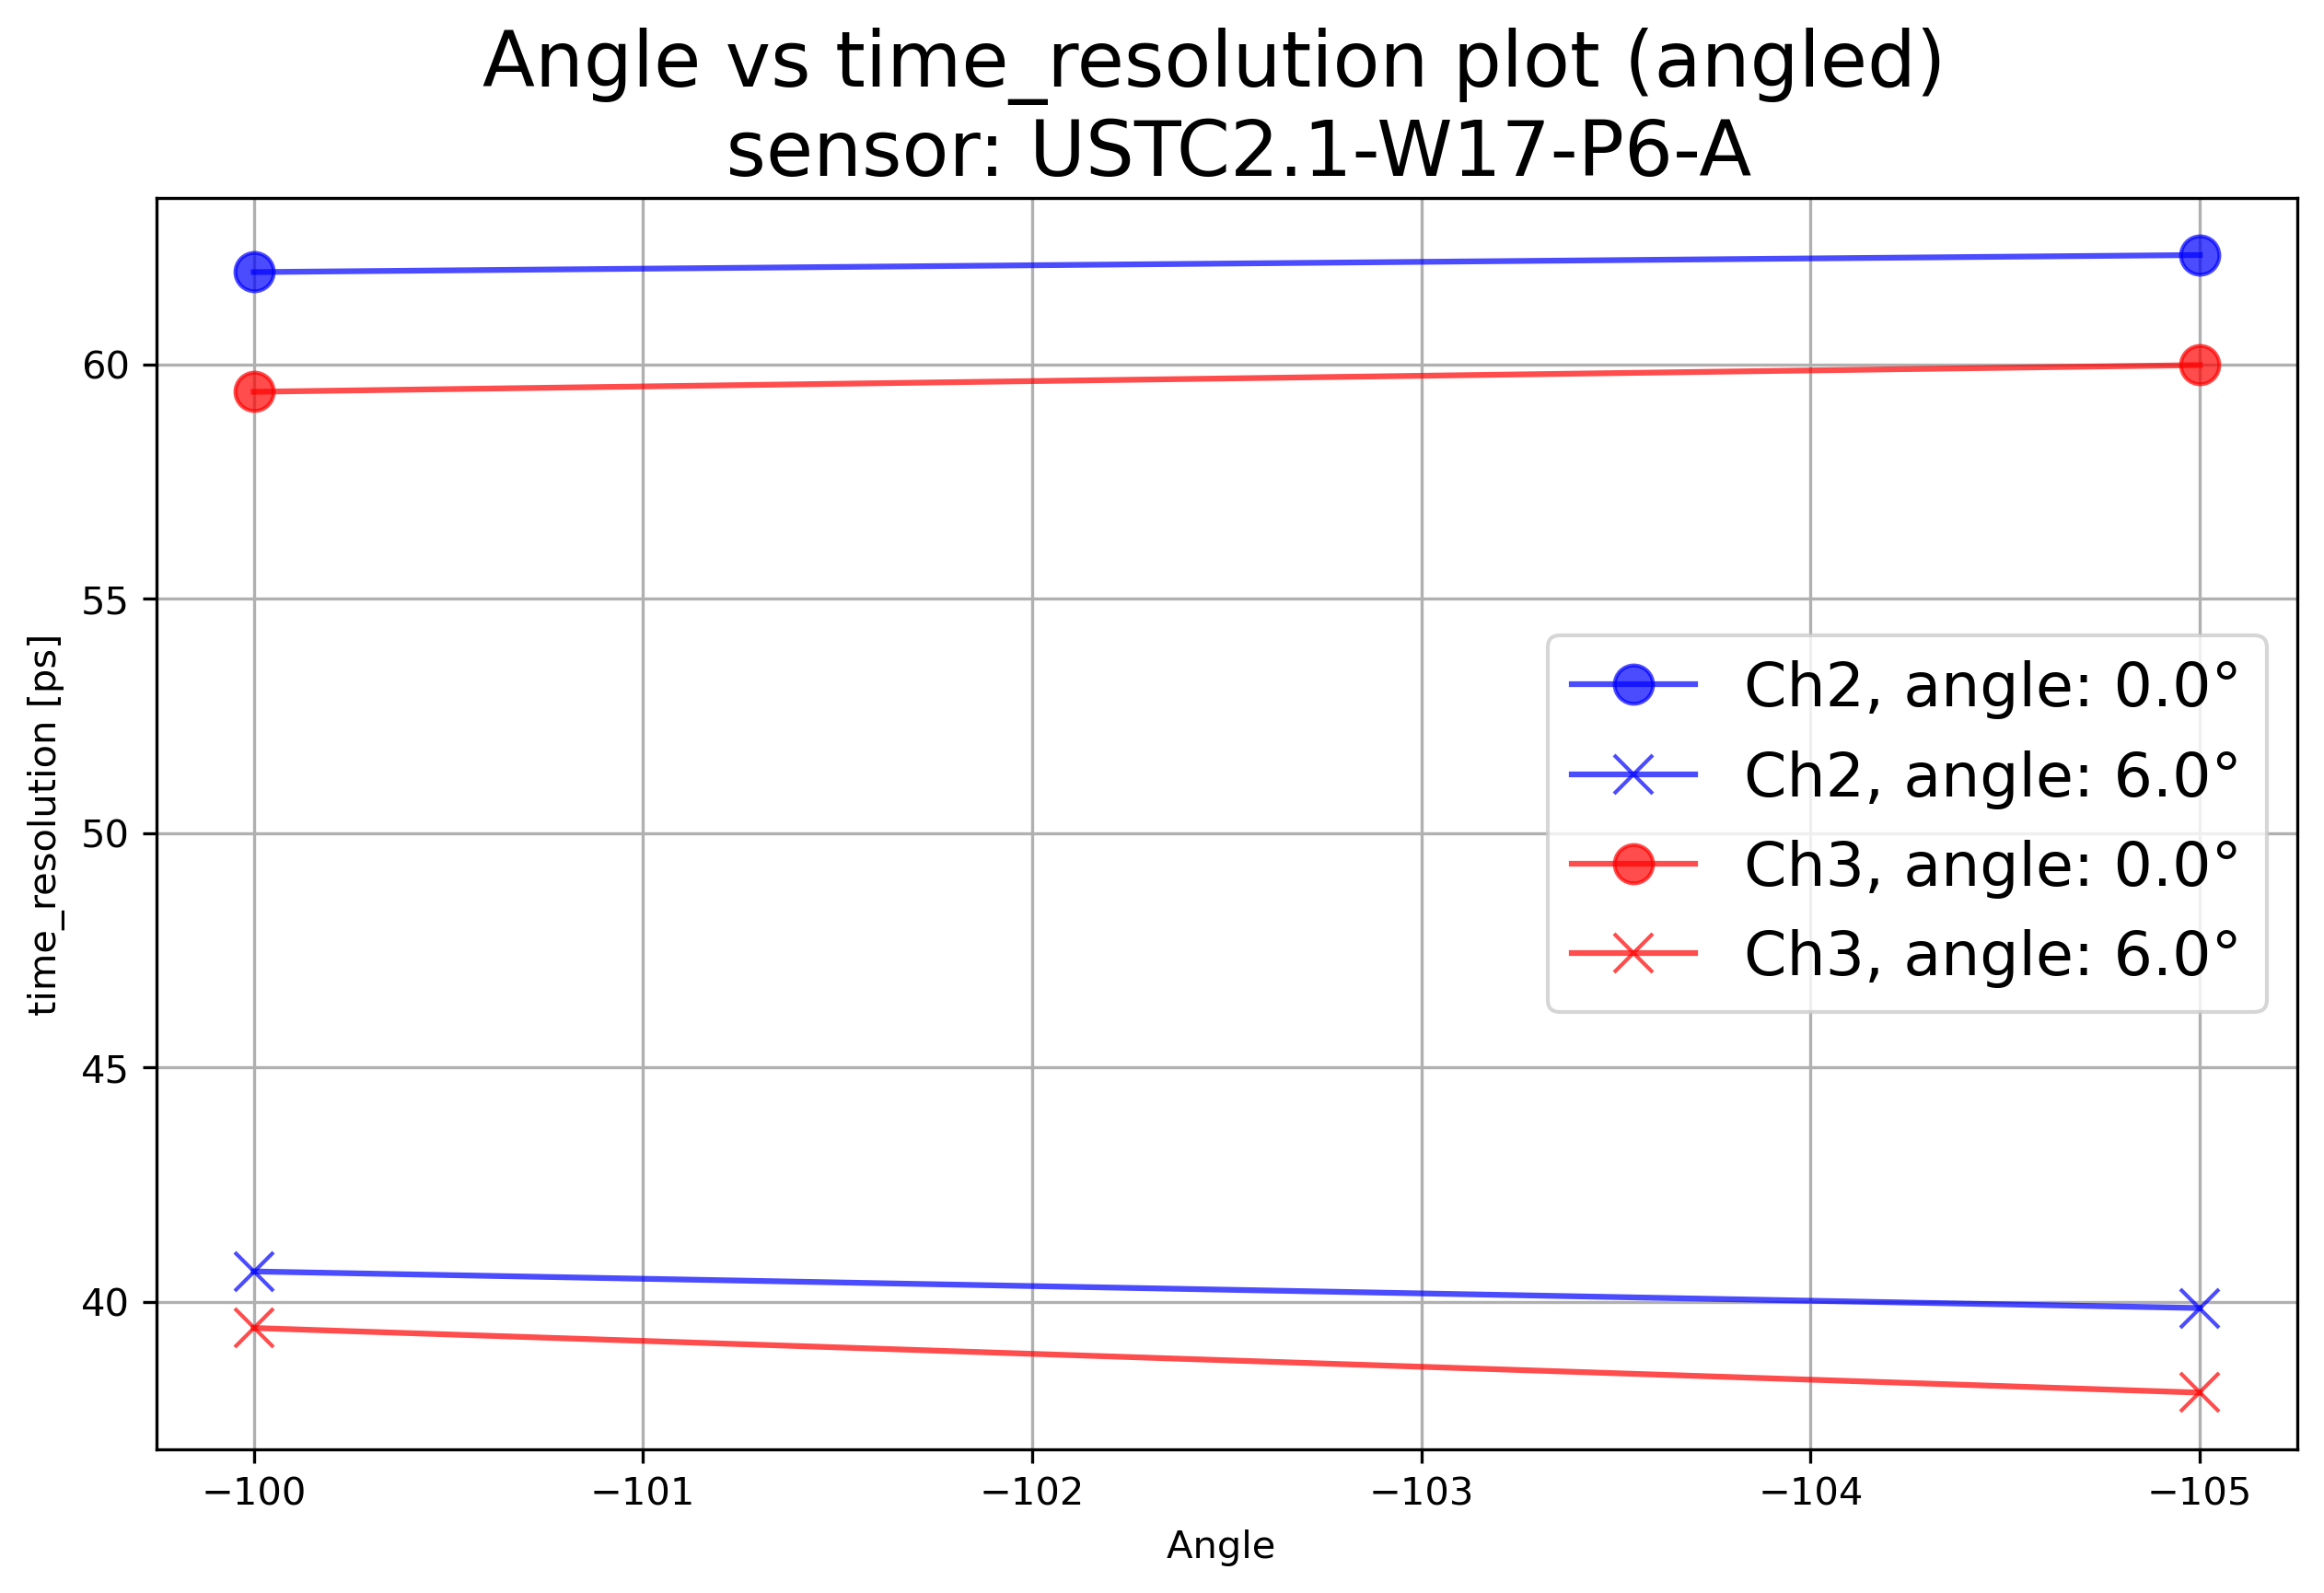

In [98]:
fig, ax = plt.subplots(figsize=(10,6), dpi=300)

ch = 'Ch2'
for j,angle in enumerate(df_analysis['angle'].unique()):
    mask = df_analysis.loc[idx[:,:,ch]]['angle'] == angle
    ax.plot(np.array(df_analysis.loc[idx[:,:,ch]]['voltage'].loc[mask]),
            np.array(df_analysis.loc[idx[:,:,ch]]['time_resolution'].loc[mask]),
            marker=markers[j], markersize=10, alpha=0.7, color=colormap[1],
            label=f"{ch}, angle: {angle}°")
    
ch = 'Ch3'
for j,angle in enumerate(df_analysis['angle'].unique()):
    mask = df_analysis.loc[idx[:,:,ch]]['angle'] == angle
    ax.plot(np.array(df_analysis.loc[idx[:,:,ch]]['voltage'].loc[mask]),
            np.array(df_analysis.loc[idx[:,:,ch]]['time_resolution'].loc[mask]),
            marker=markers[j], markersize=10, alpha=0.7, color=colormap[3],
            label=f"{ch}, angle: {angle}°")
    
    
ax.set_title(f"Angle vs time_resolution plot ({key_to_study}) \n \
sensor: {dict_of_batches[this_batch].S[S].channels[ch].name}", fontsize=20)
ax.set_xlabel("Angle ")
ax.set_ylabel("Time Resolution [ps]")
# ax.set_ylim(0,None)

ax.grid('--')
ax.legend(fontsize=16)
ax.invert_xaxis()

fig.savefig(os.path.join(save_path,f"angles_vs_time_resolution_{key_to_study}.svg"))


### putting plots together

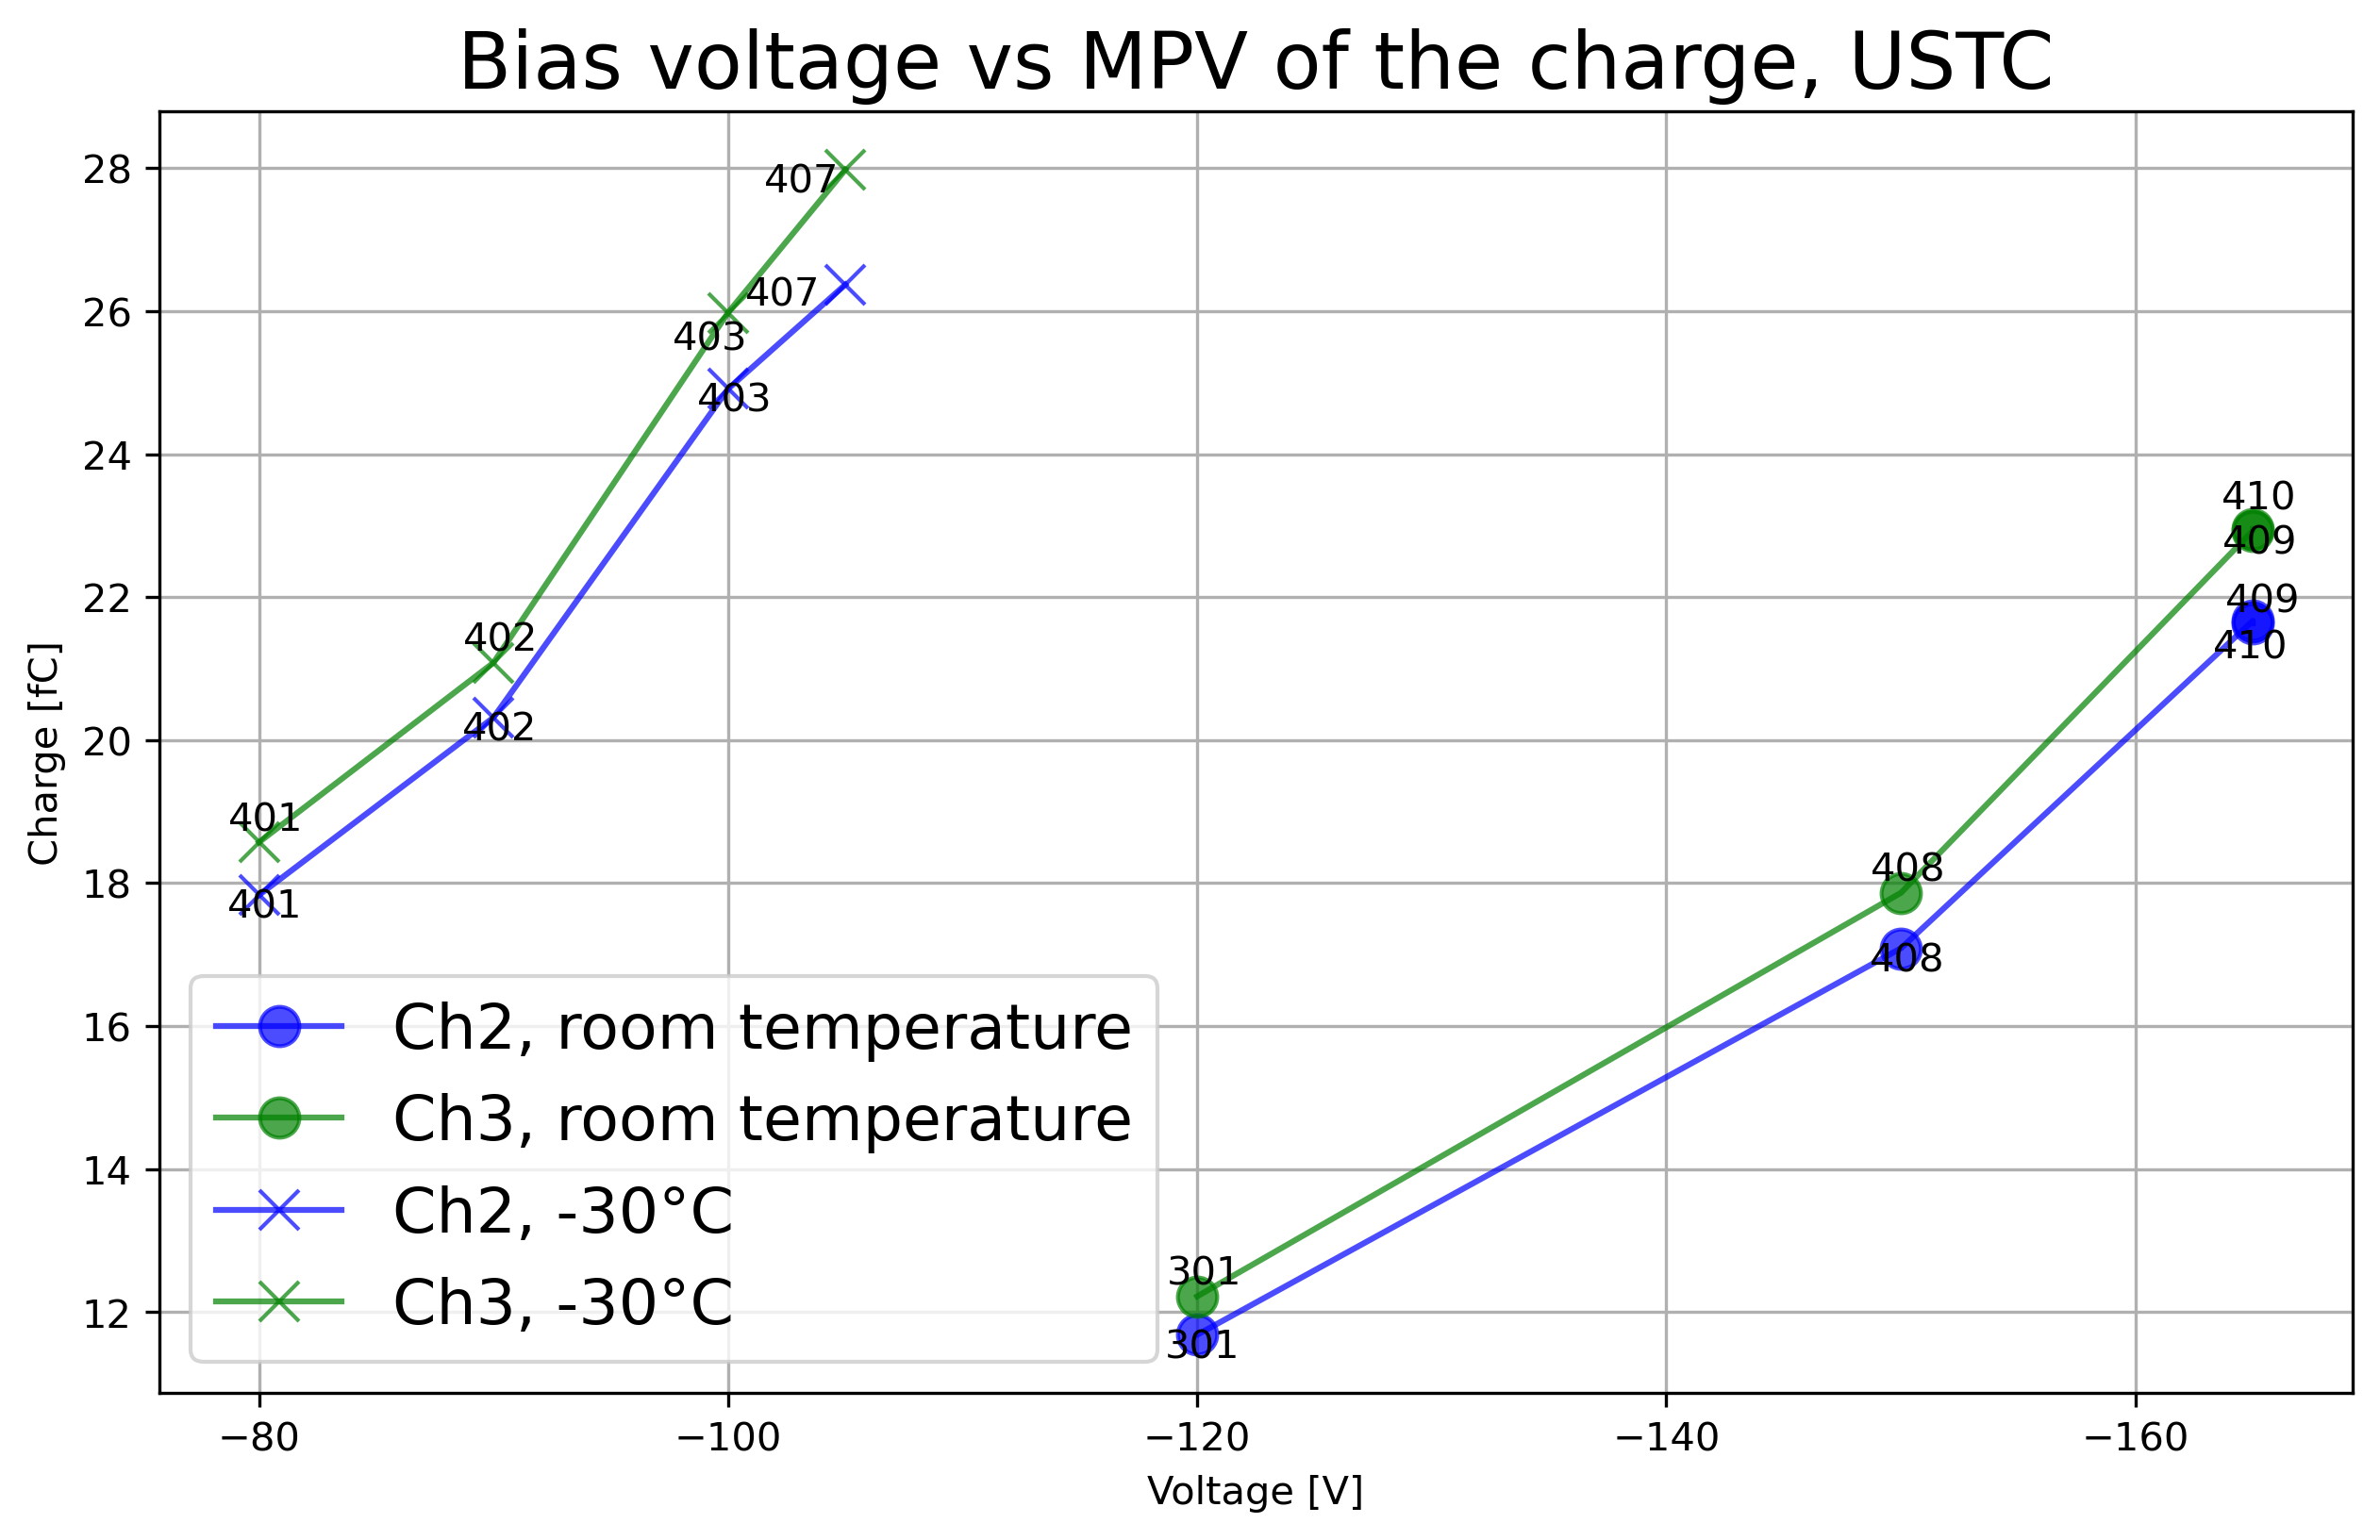

In [49]:
### CHARGE

fig, ax = plt.subplots(figsize=(10,6), dpi=300)
labels = ['room temperature', '-30°C']
list_of_texts = []
for j,key in enumerate(['room_temp', 'normal']):
    df_analysis = dict_analysis_USTC[key]
    for i,ch in enumerate(['Ch2','Ch3']):
        voltage = np.array(df_analysis.loc[idx[:,:,ch]]['voltage'])
        charge = np.array(df_analysis.loc[idx[:,:,ch]]['charge'])
        batch_labels = np.array(df_analysis.loc[idx[:,:,ch]].index.get_level_values('batch'))

        ax.plot(voltage, charge,
            marker=markers[j], markersize=10, alpha=0.7, color=colormap[i+1],
            label=f"{ch}, {labels[j]}")
        for x,y,label in zip(voltage,charge,batch_labels):
            list_of_texts.append(ax.text(x, y, label))
            
adjust_text(list_of_texts)
        
ax.set_title(f"Bias voltage vs MPV of the charge, USTC", fontsize=20)
ax.set_xlabel("Voltage [V]")
ax.set_ylabel("Charge [fC]")
# ax.set_ylim(0,None)
ax.invert_xaxis()

ax.grid('--')
ax.legend(fontsize=16)

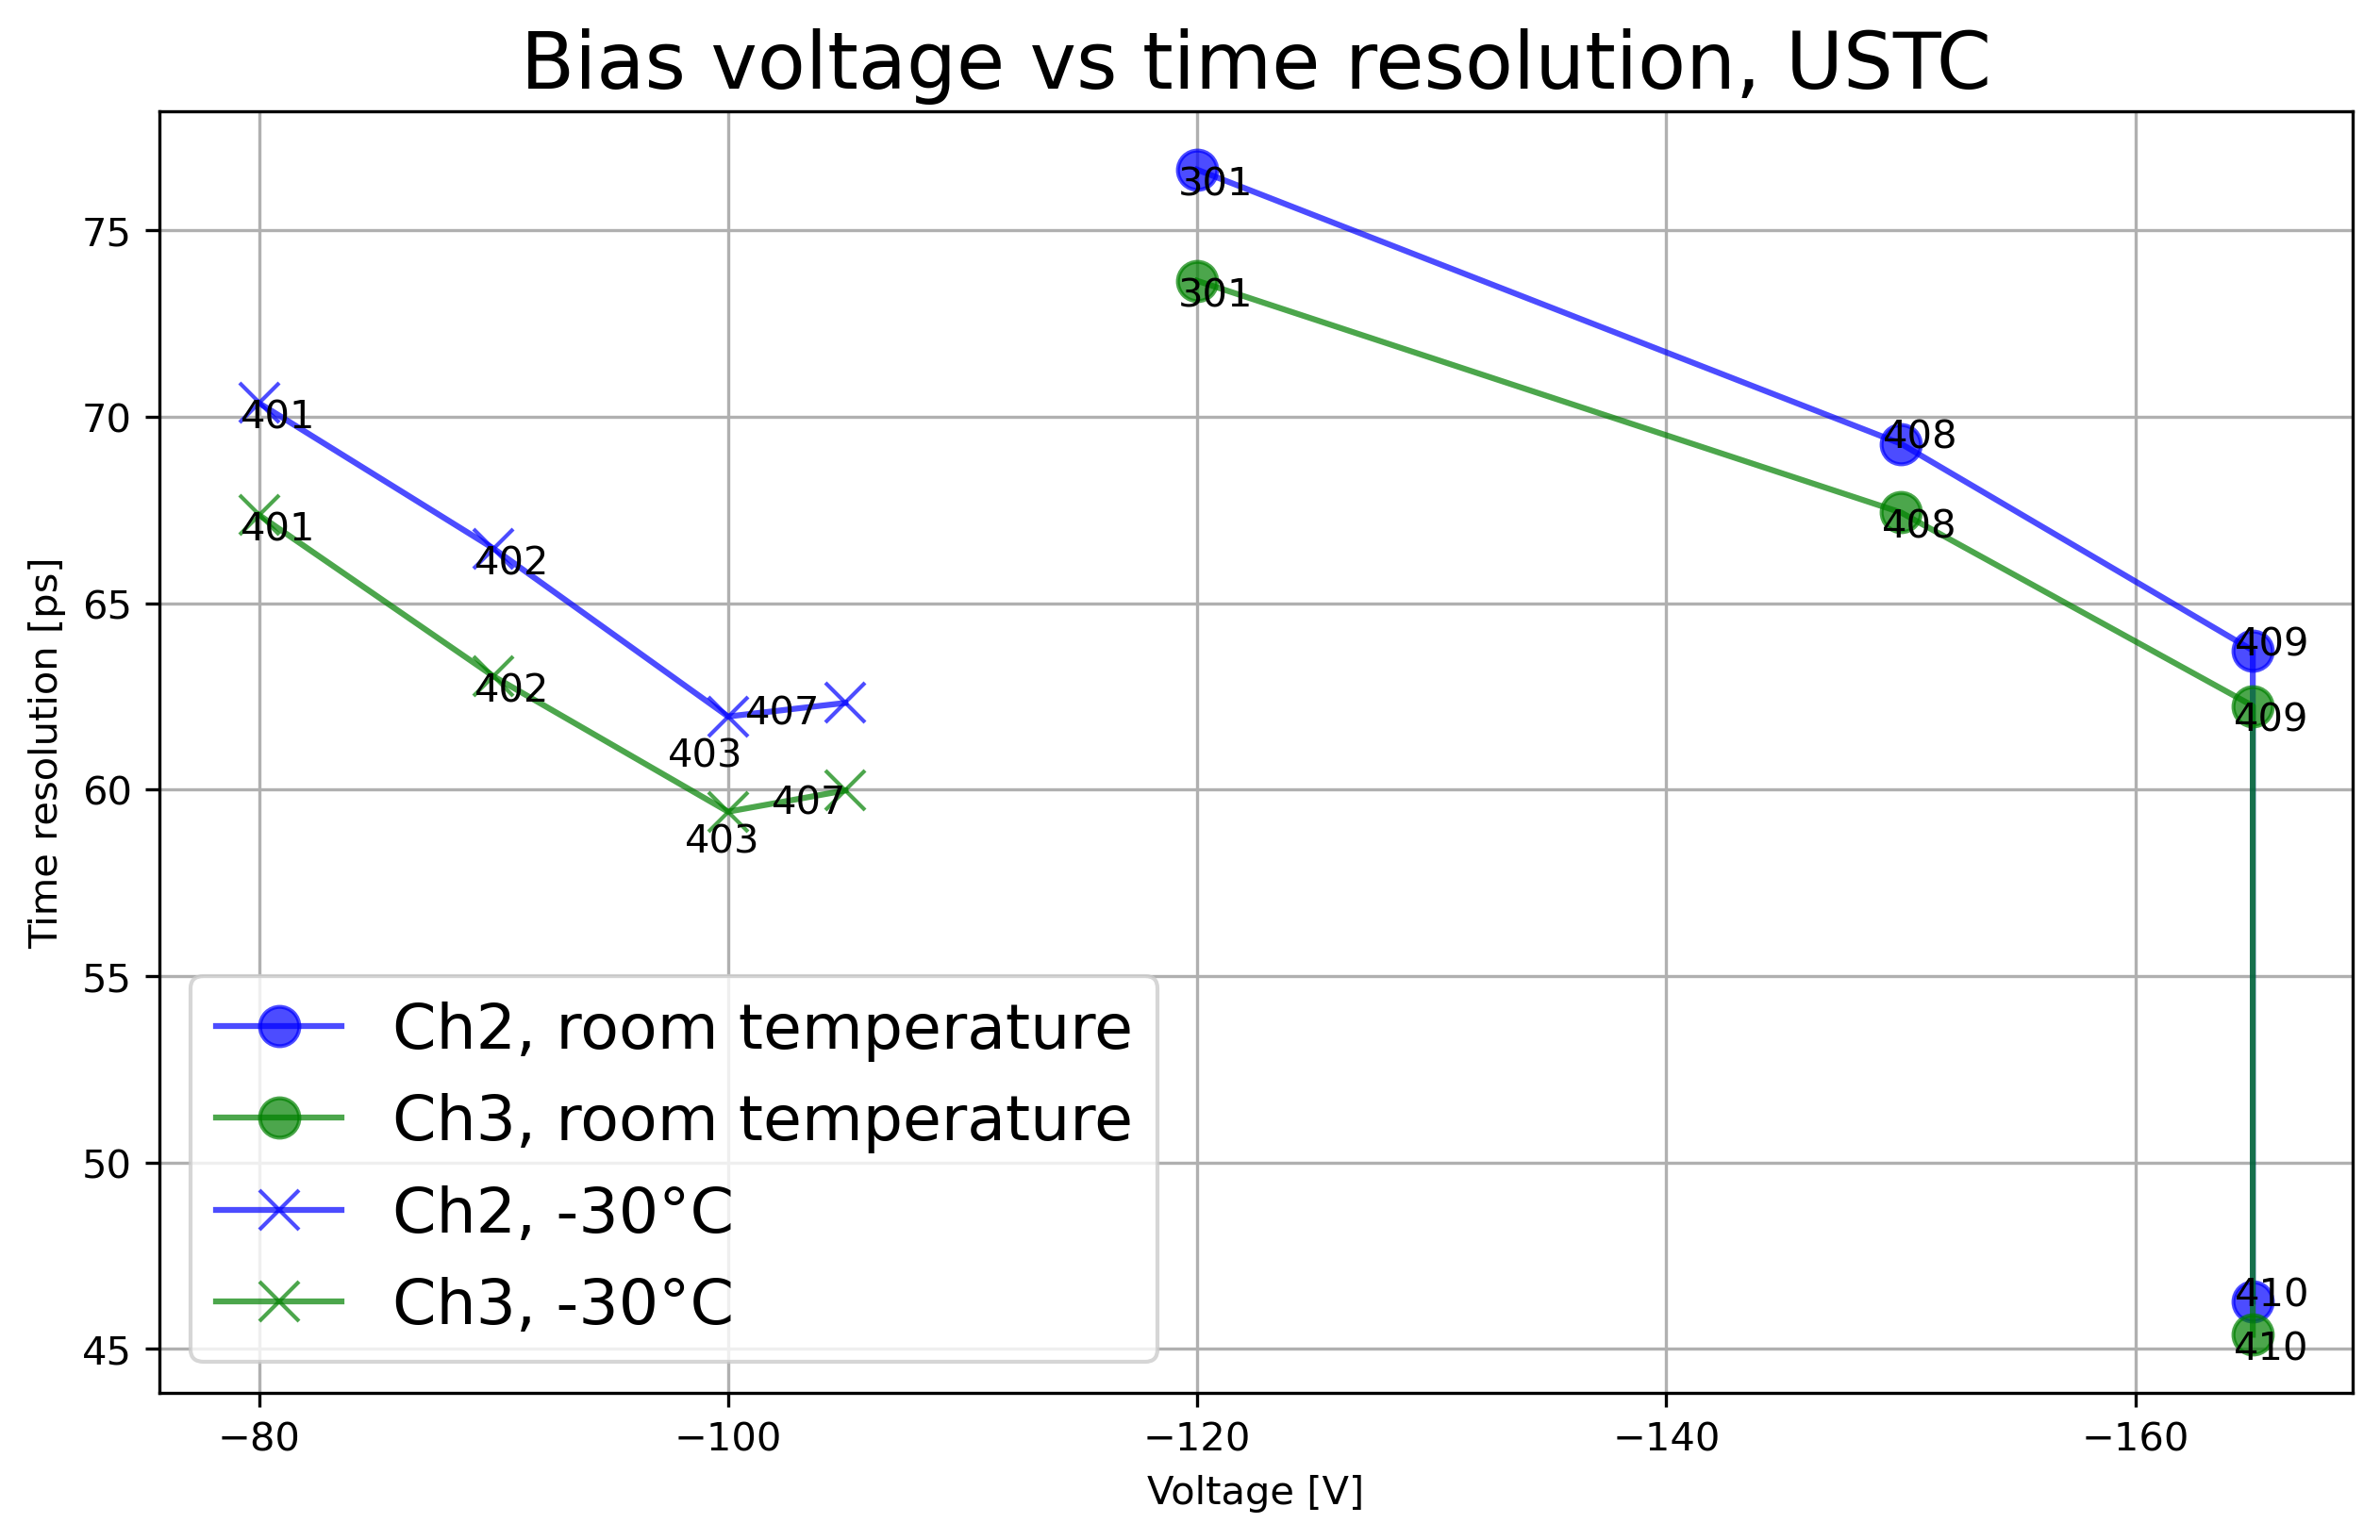

In [53]:
### TIME RESOLUTION

fig, ax = plt.subplots(figsize=(10,6), dpi=300)

labels = ['room temperature', '-30°C']
list_of_texts = []
for j,key in enumerate(['room_temp', 'normal']):
    df_analysis = dict_analysis_USTC[key]
    for i,ch in enumerate(['Ch2','Ch3']):
        voltage = np.array(df_analysis.loc[idx[:,:,ch]]['voltage'])
        time = np.array(df_analysis.loc[idx[:,:,ch]]['time_resolution'])
        batch_labels = np.array(df_analysis.loc[idx[:,:,ch]].index.get_level_values('batch'))

        ax.plot(voltage, time,
            marker=markers[j], markersize=10, alpha=0.7, color=colormap[i+1],
            label=f"{ch}, {labels[j]}")
        for x,y,label in zip(voltage,time,batch_labels):
            list_of_texts.append(ax.text(x, y, label))
            
adjust_text(list_of_texts)
        
ax.set_title(f"Bias voltage vs time resolution, USTC", fontsize=20)
ax.set_xlabel("Voltage [V]")
ax.set_ylabel("Time resolution [ps]")
# ax.set_ylim(0,None)
ax.invert_xaxis()

ax.grid('--')
ax.legend(fontsize=16)

In [5]:
def get_DUT_from_index(index_list):
    """
    Simple function to get a list of DUT numbers directly from the index, 
    """
    DUT_list = []
    for ch in index_list:
        match ch:
            case 'Ch2' | 'ch2' | 'Ch_2' | 'ch_2': DUT_list.append(1)
            case 'Ch3' | 'ch3' | 'Ch_3' | 'ch_3': DUT_list.append(2)
            case 'Ch4' | 'ch4' | 'Ch_4' | 'ch_4': DUT_list.append(3)
    return DUT_list

# IME
looking specifically at one sensor

In [5]:
this_sensor = 'IME'
IME_names = set()
for name in unique_names:
    if this_sensor in name:
        print(name)
        IME_names.add(name)

IMEv3-W12-C2-2-2
IMEv3-W12-C3-1-4
IMEv3-W12-C3-1-5
JSI-PP4-IMEv2-W7-6.5E14
JSI-B7-IMEv3-W16-8E14
JSI-B13-IMEv3-W16-2.5E15
JSI-B6-IMEv2-W7-1E14
IMEv3 W16
CERN2-CH0-IMEv3-W12
CERN2-CH1-IMEv3-W12
CERN2-CH2-IMEv3-W12
CERN2-CH4-IMEv3-W16


In [6]:
### there's many irradiated levels (4)
### 1E14, 6.5E14, 8E14, 2.5E15
IME_list = []

IME_dict = {'room_temp':[], 'angled':[], 'angled_irradiated':[], 'normal_2500':[], 'normal_2600':[], 'irradiated_2800':[]}
### I want to remove the 2500, 2600, 2800
# IME_dict = {'room_temp':[], 'angled':[], 'angled_irradiated':[], 'normal_2500':[], 'normal_2600':[], 'irradiated_2800':[]}

for name in IME_names:
    ### maybe I can make all this weird iterations into a function
    for batch_object in dict_of_batches.values():
        for S in ['S1','S2']:
            for ch, sensor in batch_object.S[S].channels.items():
                if name in sensor.name:
#                     print(batch_object.batch_number, S, ch, batch_object.S[S].get_sensor(ch).board, batch_object.S[S].get_sensor(ch).board == ' ')
                    if (batch_object.S[S].get_sensor(ch).voltage==0) or (batch_object.S[S].get_sensor(ch).board == ' '): ### if the voltage is 0, or there is no board name, it's not useful
                        continue
                    IME_list.append((batch_object.batch_number, S, ch))
                    if batch_object.tempA<0 and batch_object.S[S].get_sensor('Ch1').voltage==2500 and batch_object.angle==0 \
                    and batch_object.S[S].get_sensor(ch).fluence==0:
                        IME_dict['normal_2500'].append((batch_object.batch_number, S, ch))
                    if batch_object.tempA<0 and batch_object.S[S].get_sensor('Ch1').voltage==2600 and batch_object.angle==0 \
                    and batch_object.S[S].get_sensor(ch).fluence==0:
                        IME_dict['normal_2600'].append((batch_object.batch_number, S, ch))    
                    if batch_object.tempA<0 and batch_object.S[S].get_sensor('Ch1').voltage==2800 and batch_object.angle==0 \
                    and batch_object.S[S].get_sensor(ch).fluence!=0 and batch_object.angle==0:
                        IME_dict['irradiated_2800'].append((batch_object.batch_number, S, ch))
                    if batch_object.tempA>0:
                        IME_dict['room_temp'].append((batch_object.batch_number, S, ch))
                    if batch_object.angle>0 and batch_object.S[S].get_sensor(ch).fluence==0:
                        IME_dict['angled'].append((batch_object.batch_number, S, ch))
#                         print(batch_object.S[S].get_sensor(ch).voltage)
                    if batch_object.angle>0 and batch_object.S[S].get_sensor(ch).fluence!=0:
                        IME_dict['angled_irradiated'].append((batch_object.batch_number, S, ch))
                        
                        
    ### remove empty entries
#     IME_dict[name] = {key: value for key, value in IME_dict.items() if value}

# logging.info(f"{IME_list}")

###

In [7]:
key_to_study = 'normal_2500'
# key_to_study = 'normal_2800'
# key_to_study = 'angled'
# key_to_study = 'angled_irradiated'

batches_to_study = IME_dict[key_to_study]

this_sensor = 'IME'

save_path = f'../various plots/{this_sensor}/{key_to_study}/'
if not os.path.isdir(save_path):
    os.mkdir(save_path)

### I should save the dictionary and just reopen it to add the other data
IME_file_name = os.path.join(f"../various plots/{this_sensor}","IME_analysis_dict.pickle")

### open file to read dictionary, if it doesn't exist make a new one
try:
    dict_analysis_IME = read_pickle(IME_file_name)
    df_analysis = dict_analysis_IME[key_to_study]
    multi_index = df_analysis.index
except FileNotFoundError:
    logging.warning("file does not exist, creating new empty dictionary to store dataframes")
    dict_analysis_IME = {}
    multi_index = pd.MultiIndex.from_tuples(batches_to_study, names=['batch', 'oscilloscope', 'channel'])
    df_analysis = pd.DataFrame(index=multi_index)
except KeyError:
    logging.warning(f"{key_to_study} not studied yet, create empty dataframe")
    multi_index = pd.MultiIndex.from_tuples(batches_to_study, names=['batch', 'oscilloscope', 'channel'])
    df_analysis = pd.DataFrame(index=multi_index)

idx=pd.IndexSlice

[WARNING] - 	 file does not exist, creating new empty dictionary to store dataframes


In [53]:
df_analysis

Empty DataFrame
Columns: []
Index: [(100, S1, Ch2), (100, S1, Ch3), (101, S1, Ch2), (101, S1, Ch3), (201, S1, Ch2), (201, S1, Ch3), (202, S1, Ch2), (202, S1, Ch3), (203, S1, Ch2), (203, S1, Ch3), (204, S1, Ch2), (204, S1, Ch3), (100, S2, Ch4), (101, S2, Ch4), (401, S2, Ch4), (402, S2, Ch4), (403, S2, Ch4), (407, S2, Ch4), (100, S1, Ch4), (101, S1, Ch4), (401, S1, Ch4), (402, S1, Ch4), (403, S1, Ch4), (407, S1, Ch4)]

In [34]:
# DUTs = get_DUT_from_index(df_analysis.index.levels[2])
# DUTs

### I want to get ONLY the duts that I need for each batch
for ch in df_analysis.loc[idx[101,'S1',:]].index:
    print(ch)

Ch2
Ch3
Ch4


[INFO] - 	 Loading batch 100 	 Oscilloscope S1


MCP: 2500 V, angle: 0.0° temperature:-32.839999999999996°C
channels: Index(['Ch2', 'Ch3', 'Ch4'], dtype='object', name='channel')
Batch:100, Scope:S1, Channel:Ch2


[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 in 'time_mask()': Fit parameters [ 9.34221029e+00 -4.52450174e+03  1.77570112e+02  5.45281170e-01]
[INFO] - 	 in 'time_mask()': Fit parameters [ 1.98492596e+00 -5.47797553e+03  1.13327206e-01  5.00250265e-04]
[INFO] - 	 First charge estimate: -0.384328156709671


/tmp/ipykernel_86382/919114984.py:59: RuntimeWarning: invalid value encountered in sqrt
  time_resolution.append(np.sqrt(time_parameters[2]**2 - MCP_resolution**2))


Batch:100, Scope:S1, Channel:Ch3


[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 in 'time_mask()': Fit parameters [ 2.50839697e+02 -5.74925979e+03  6.14972266e+01  1.40275048e-01]
[INFO] - 	 in 'time_mask()': Fit parameters [ 7.52353760e+01 -5.74868412e+03  6.05747988e+01  2.47407694e-02]
[INFO] - 	 First charge estimate: 13.934469223022461


Batch:100, Scope:S1, Channel:Ch4


[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 in 'time_mask()': Fit parameters [ 1.40275523e+03 -5.65287059e+03  5.68107246e+01  5.76928607e-01]
[INFO] - 	 in 'time_mask()': Fit parameters [ 5.70467888e+02 -5.65254251e+03  5.63137788e+01  1.37736024e-01]
[INFO] - 	 First charge estimate: 10.796499252319336
[INFO] - 	 Loading batch 100 	 Oscilloscope S2


MCP: 2500 V, angle: 0.0° temperature:-32.839999999999996°C
channels: Index(['Ch4'], dtype='object', name='channel')
Batch:100, Scope:S2, Channel:Ch4


[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 in 'time_mask()': Fit parameters [ 2.16236901e+03 -5.44584265e+03  5.43606289e+01  1.06571566e+00]
[INFO] - 	 in 'time_mask()': Fit parameters [ 1.82363873e+03 -5.44552779e+03  5.39731793e+01  2.08354084e-01]
[INFO] - 	 First charge estimate: 13.608858108520508
[INFO] - 	 Loading batch 101 	 Oscilloscope S1
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying


MCP: 2500 V, angle: 0.0° temperature:-33.3°C
channels: Index(['Ch2', 'Ch3', 'Ch4'], dtype='object', name='channel')
Batch:101, Scope:S1, Channel:Ch2


[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
/home/marcello/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
[INFO] - 	 in 'time_mask()': Fit parameters [0.0e+00 2.5e-04 1.0e+02 0.0e+00]
/home/marcello/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
[INFO] - 	 in 'time_mask()': Fit parameters [0.00000000e+00 2.50000012e-04 1.00000000e+02 0.00000000e+00]
[INFO] - 	 First charge estimate: 0.5
[ERROR] - 	 Charge fit error
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying


Batch:101, Scope:S1, Channel:Ch3


[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 in 'time_mask()': Fit parameters [ 5.15100549e+01 -5.76933492e+03  5.61168456e+01  3.92522830e-02]
[INFO] - 	 in 'time_mask()': Fit parameters [ 2.27446582e+01 -5.76931801e+03  5.50114844e+01  7.86852394e-03]
[INFO] - 	 First charge estimate: 13.066544532775879
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying


Batch:101, Scope:S1, Channel:Ch4


[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 in 'time_mask()': Fit parameters [ 2.15309661e+02 -5.66323490e+03  5.34422430e+01  7.74733731e-02]
[INFO] - 	 in 'time_mask()': Fit parameters [ 3.46076056e+00 -5.66273730e+03  5.19756935e+01  3.07146832e-02]
[INFO] - 	 First charge estimate: 12.472496032714844
[INFO] - 	 Loading batch 101 	 Oscilloscope S2
[INFO] - 	 Two peaks not found, retrying


MCP: 2500 V, angle: 0.0° temperature:-33.3°C
channels: Index(['Ch4'], dtype='object', name='channel')
Batch:101, Scope:S2, Channel:Ch4


[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 in 'time_mask()': Fit parameters [ 3.90581221e+02 -5.46062852e+03  4.75987175e+01  1.82092596e-01]
[INFO] - 	 in 'time_mask()': Fit parameters [ 1.14733804e+01 -5.46040823e+03  4.69923071e+01  4.29317372e-02]
[INFO] - 	 First charge estimate: 13.789071083068848
[INFO] - 	 Loading batch 201 	 Oscilloscope S1


MCP: 2500 V, angle: 0.0° temperature:-31.333333333333332°C
channels: Index(['Ch2', 'Ch3'], dtype='object', name='channel')
Batch:201, Scope:S1, Channel:Ch2


[INFO] - 	 in 'time_mask()': Fit parameters [ 1.02623184e+04 -5.56888532e+03  7.83692357e+01  3.57522131e+00]
[INFO] - 	 in 'time_mask()': Fit parameters [ 1.01749565e+04 -5.56831182e+03  7.76249129e+01  2.01261580e+00]
[INFO] - 	 First charge estimate: 14.774706840515137


Batch:201, Scope:S1, Channel:Ch3


[INFO] - 	 in 'time_mask()': Fit parameters [ 9.42889816e+03 -5.78010472e+03  7.85647120e+01  3.14279681e+00]
[INFO] - 	 in 'time_mask()': Fit parameters [ 8.79332518e+03 -5.77964368e+03  7.78887908e+01  1.66811019e+00]
[INFO] - 	 First charge estimate: 15.06532096862793
[INFO] - 	 Loading batch 201 	 Oscilloscope S2
[INFO] - 	 Loading batch 202 	 Oscilloscope S1


MCP: 2500 V, angle: 0.0° temperature:-31.333333333333332°C
channels: Index([], dtype='object', name='channel')
MCP: 2500 V, angle: 0.0° temperature:-32.225°C
channels: Index(['Ch2', 'Ch3'], dtype='object', name='channel')
Batch:202, Scope:S1, Channel:Ch2


/home/marcello/Desktop/Radboud_not_synchro/Master_Thesis/testbeam-analysis/LoadBatch.py:189: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  else:       fig, ax = plt.subplots(figsize=(10,6), dpi=300)
[INFO] - 	 in 'time_mask()': Fit parameters [ 1.13316874e+04 -5.57688048e+03  7.55096873e+01  4.03093453e+00]
[INFO] - 	 in 'time_mask()': Fit parameters [ 1.11915307e+04 -5.57645586e+03  7.49045628e+01  2.35783408e+00]
[INFO] - 	 First charge estimate: 16.9328556060791


Batch:202, Scope:S1, Channel:Ch3


[INFO] - 	 in 'time_mask()': Fit parameters [ 1.04910078e+04 -5.79482621e+03  7.49527583e+01  3.48697764e+00]
[INFO] - 	 in 'time_mask()': Fit parameters [ 1.02409074e+04 -5.79429368e+03  7.43361557e+01  1.88645191e+00]
[INFO] - 	 First charge estimate: 17.81673812866211
[INFO] - 	 Loading batch 202 	 Oscilloscope S2
[INFO] - 	 Loading batch 203 	 Oscilloscope S1


MCP: 2500 V, angle: 0.0° temperature:-32.225°C
channels: Index([], dtype='object', name='channel')
MCP: 2500 V, angle: 0.0° temperature:-32.333333333333336°C
channels: Index(['Ch2', 'Ch3'], dtype='object', name='channel')
Batch:203, Scope:S1, Channel:Ch2


[INFO] - 	 in 'time_mask()': Fit parameters [ 7773.27310204 -5580.47780075    73.07046742    13.02870506]
[INFO] - 	 in 'time_mask()': Fit parameters [ 7.64973296e+03 -5.57980406e+03  7.20987113e+01  1.76606079e+00]
[INFO] - 	 First charge estimate: 20.74573516845703


Batch:203, Scope:S1, Channel:Ch3


[INFO] - 	 in 'time_mask()': Fit parameters [ 7128.69373392 -5804.54674002    71.80734839    11.15817118]
[INFO] - 	 in 'time_mask()': Fit parameters [ 7.04846961e+03 -5.80415370e+03  7.11275277e+01  1.41889896e+00]
[INFO] - 	 First charge estimate: 21.050251007080078
[INFO] - 	 Loading batch 203 	 Oscilloscope S2
[INFO] - 	 Loading batch 204 	 Oscilloscope S1


MCP: 2500 V, angle: 0.0° temperature:-32.333333333333336°C
channels: Index([], dtype='object', name='channel')
MCP: 2500 V, angle: 0.0° temperature:-30.03333333333333°C
channels: Index(['Ch2', 'Ch3'], dtype='object', name='channel')
Batch:204, Scope:S1, Channel:Ch2


[INFO] - 	 in 'time_mask()': Fit parameters [ 1.13959179e+04 -5.57597890e+03  7.13329053e+01  4.18244792e+00]
[INFO] - 	 in 'time_mask()': Fit parameters [ 1.10604001e+04 -5.57563846e+03  7.09324497e+01  2.50661145e+00]
[INFO] - 	 First charge estimate: 53.73357391357422


Batch:204, Scope:S1, Channel:Ch3


[INFO] - 	 in 'time_mask()': Fit parameters [ 6.21401753e+03 -5.79659527e+03  1.04408364e+02  1.63807230e+00]
[INFO] - 	 in 'time_mask()': Fit parameters [ 5.90357701e+03 -5.79813587e+03  1.03348328e+02  8.08748093e-01]
[INFO] - 	 First charge estimate: 49.89161682128906
[INFO] - 	 Loading batch 204 	 Oscilloscope S2
[INFO] - 	 Loading batch 401 	 Oscilloscope S1


MCP: 2500 V, angle: 0.0° temperature:-30.03333333333333°C
channels: Index([], dtype='object', name='channel')
MCP: 2500 V, angle: 0.0° temperature:-30.555555555555557°C
channels: Index(['Ch4'], dtype='object', name='channel')
Batch:401, Scope:S1, Channel:Ch4


[INFO] - 	 in 'time_mask()': Fit parameters [ 1.32103542e+04 -5.67518370e+03  7.65791964e+01  5.02920212e+00]
[INFO] - 	 in 'time_mask()': Fit parameters [ 1.30755435e+04 -5.67454837e+03  7.57765501e+01  2.27775225e+00]
[INFO] - 	 First charge estimate: 12.21663761138916
[INFO] - 	 Loading batch 401 	 Oscilloscope S2


MCP: 2500 V, angle: 0.0° temperature:-30.555555555555557°C
channels: Index(['Ch4'], dtype='object', name='channel')
Batch:401, Scope:S2, Channel:Ch4


[INFO] - 	 in 'time_mask()': Fit parameters [ 2.23260976e+04 -5.47857120e+03  6.72732658e+01  8.90711709e+00]
[INFO] - 	 in 'time_mask()': Fit parameters [ 2.21941022e+04 -5.47798912e+03  6.65991004e+01  3.22229499e+00]
[INFO] - 	 First charge estimate: 14.177887916564941
[INFO] - 	 Loading batch 402 	 Oscilloscope S1


MCP: 2500 V, angle: 0.0° temperature:-29.377777777777776°C
channels: Index(['Ch4'], dtype='object', name='channel')
Batch:402, Scope:S1, Channel:Ch4


[INFO] - 	 in 'time_mask()': Fit parameters [ 1.08495329e+04 -5.68532887e+03  7.33016680e+01  4.15750531e+00]
[INFO] - 	 in 'time_mask()': Fit parameters [ 9.70172067e+03 -5.68467076e+03  7.24687072e+01  1.97290685e+00]
[INFO] - 	 First charge estimate: 13.629526138305664
[INFO] - 	 Loading batch 402 	 Oscilloscope S2


MCP: 2500 V, angle: 0.0° temperature:-29.377777777777776°C
channels: Index(['Ch4'], dtype='object', name='channel')
Batch:402, Scope:S2, Channel:Ch4


[INFO] - 	 in 'time_mask()': Fit parameters [ 1.80153438e+04 -5.48961919e+03  6.35610918e+01  6.19794565e+00]
[INFO] - 	 in 'time_mask()': Fit parameters [ 1.73677191e+04 -5.48930768e+03  6.31371286e+01  2.46505193e+00]
[INFO] - 	 First charge estimate: 16.03942108154297
[INFO] - 	 Loading batch 403 	 Oscilloscope S1


MCP: 2500 V, angle: 0.0° temperature:-30.450000000000003°C
channels: Index(['Ch4'], dtype='object', name='channel')
Batch:403, Scope:S1, Channel:Ch4


[INFO] - 	 in 'time_mask()': Fit parameters [ 7.53782564e+03 -5.69280673e+03  7.06447179e+01  2.61887755e+00]
[INFO] - 	 in 'time_mask()': Fit parameters [ 7.41069248e+03 -5.69235786e+03  6.99959834e+01  1.31721726e+00]
[INFO] - 	 First charge estimate: 15.513501167297363
[INFO] - 	 Loading batch 403 	 Oscilloscope S2


MCP: 2500 V, angle: 0.0° temperature:-30.450000000000003°C
channels: Index(['Ch4'], dtype='object', name='channel')
Batch:403, Scope:S2, Channel:Ch4


[INFO] - 	 in 'time_mask()': Fit parameters [ 1.29216339e+04 -5.49892048e+03  6.02127337e+01  4.80859568e+00]
[INFO] - 	 in 'time_mask()': Fit parameters [ 1.26147863e+04 -5.49853125e+03  5.98217446e+01  1.95694886e+00]
[INFO] - 	 First charge estimate: 19.45574951171875
[INFO] - 	 Loading batch 407 	 Oscilloscope S1


MCP: 2500 V, angle: 0.0° temperature:-29.809999999999995°C
channels: Index(['Ch4'], dtype='object', name='channel')
Batch:407, Scope:S1, Channel:Ch4


[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 in 'time_mask()': Fit parameters [ 1.17911080e+04 -5.69399450e+03  6.54903458e+01  4.54256401e+00]
[INFO] - 	 in 'time_mask()': Fit parameters [ 1.10191286e+04 -5.69353271e+03  6.50089997e+01  2.41786639e+00]
[INFO] - 	 First charge estimate: 32.13130187988281
[INFO] - 	 Loading batch 407 	 Oscilloscope S2


MCP: 2500 V, angle: 0.0° temperature:-29.809999999999995°C
channels: Index(['Ch4'], dtype='object', name='channel')
Batch:407, Scope:S2, Channel:Ch4


[INFO] - 	 in 'time_mask()': Fit parameters [ 2.51344007e+04 -5.50333080e+03  5.56156890e+01  8.59902259e+00]
[INFO] - 	 in 'time_mask()': Fit parameters [ 2.49860920e+04 -5.50305252e+03  5.53883050e+01  4.07467520e+00]
[INFO] - 	 First charge estimate: 37.94666290283203


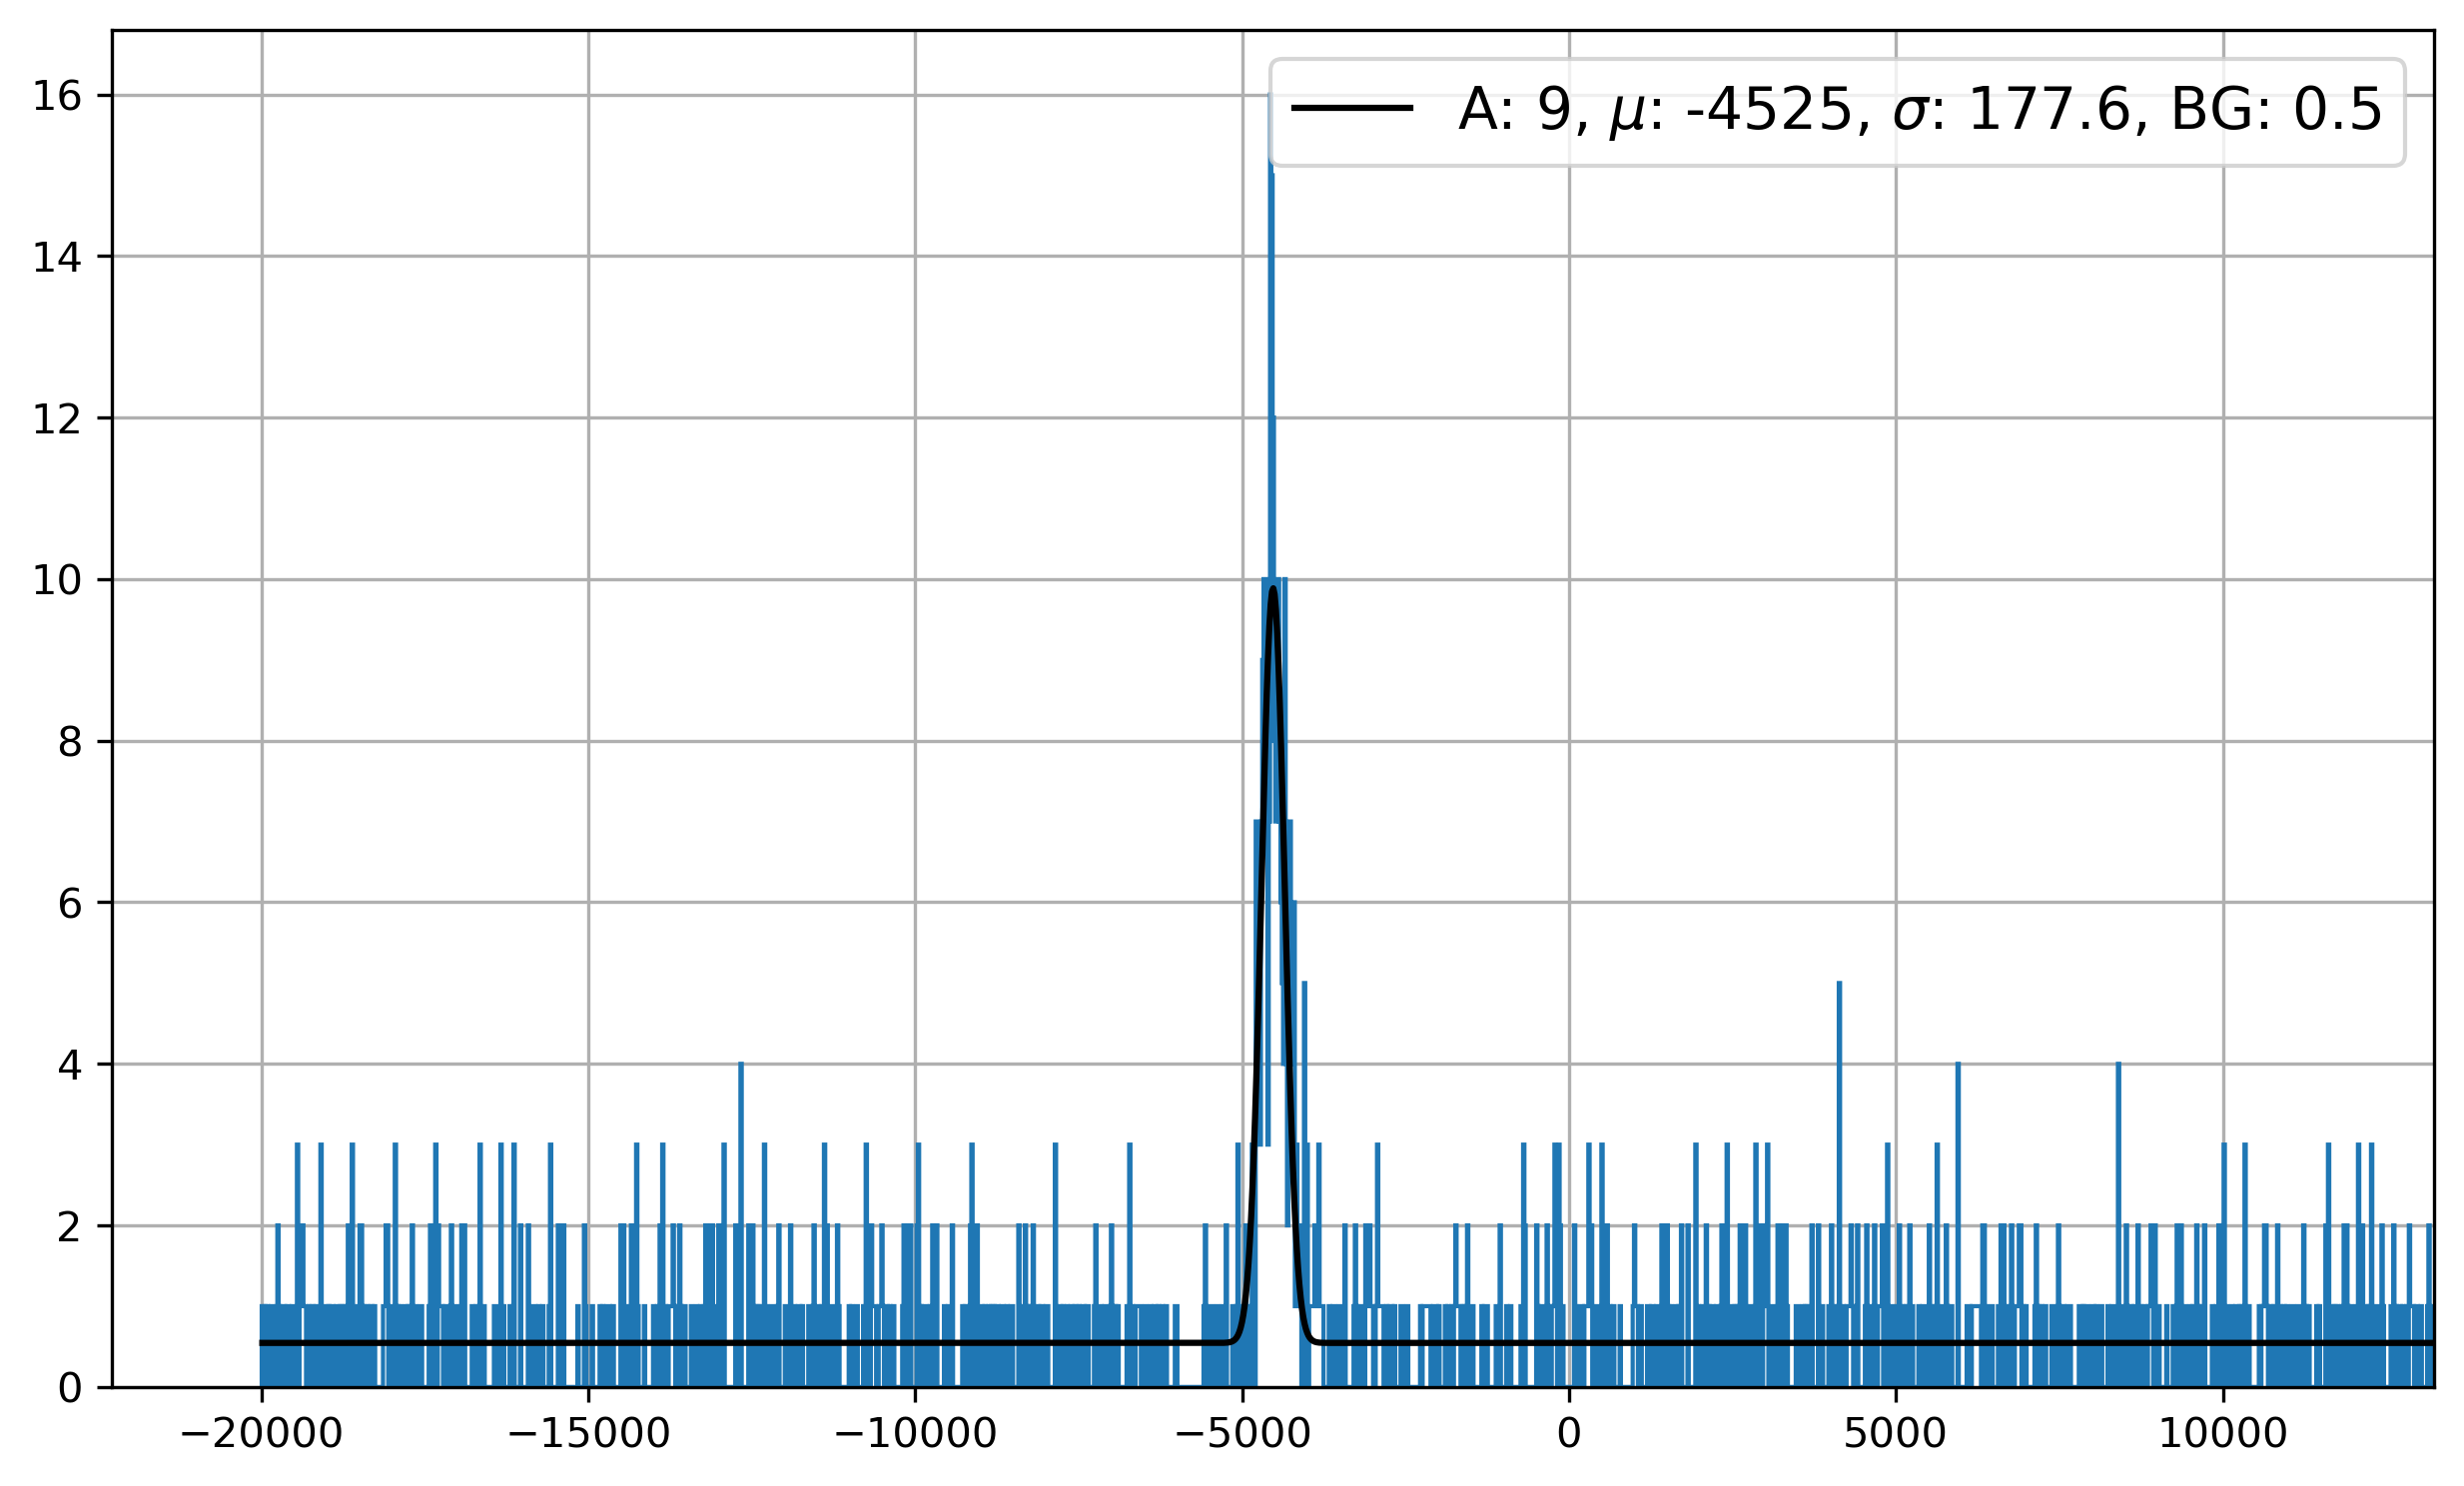

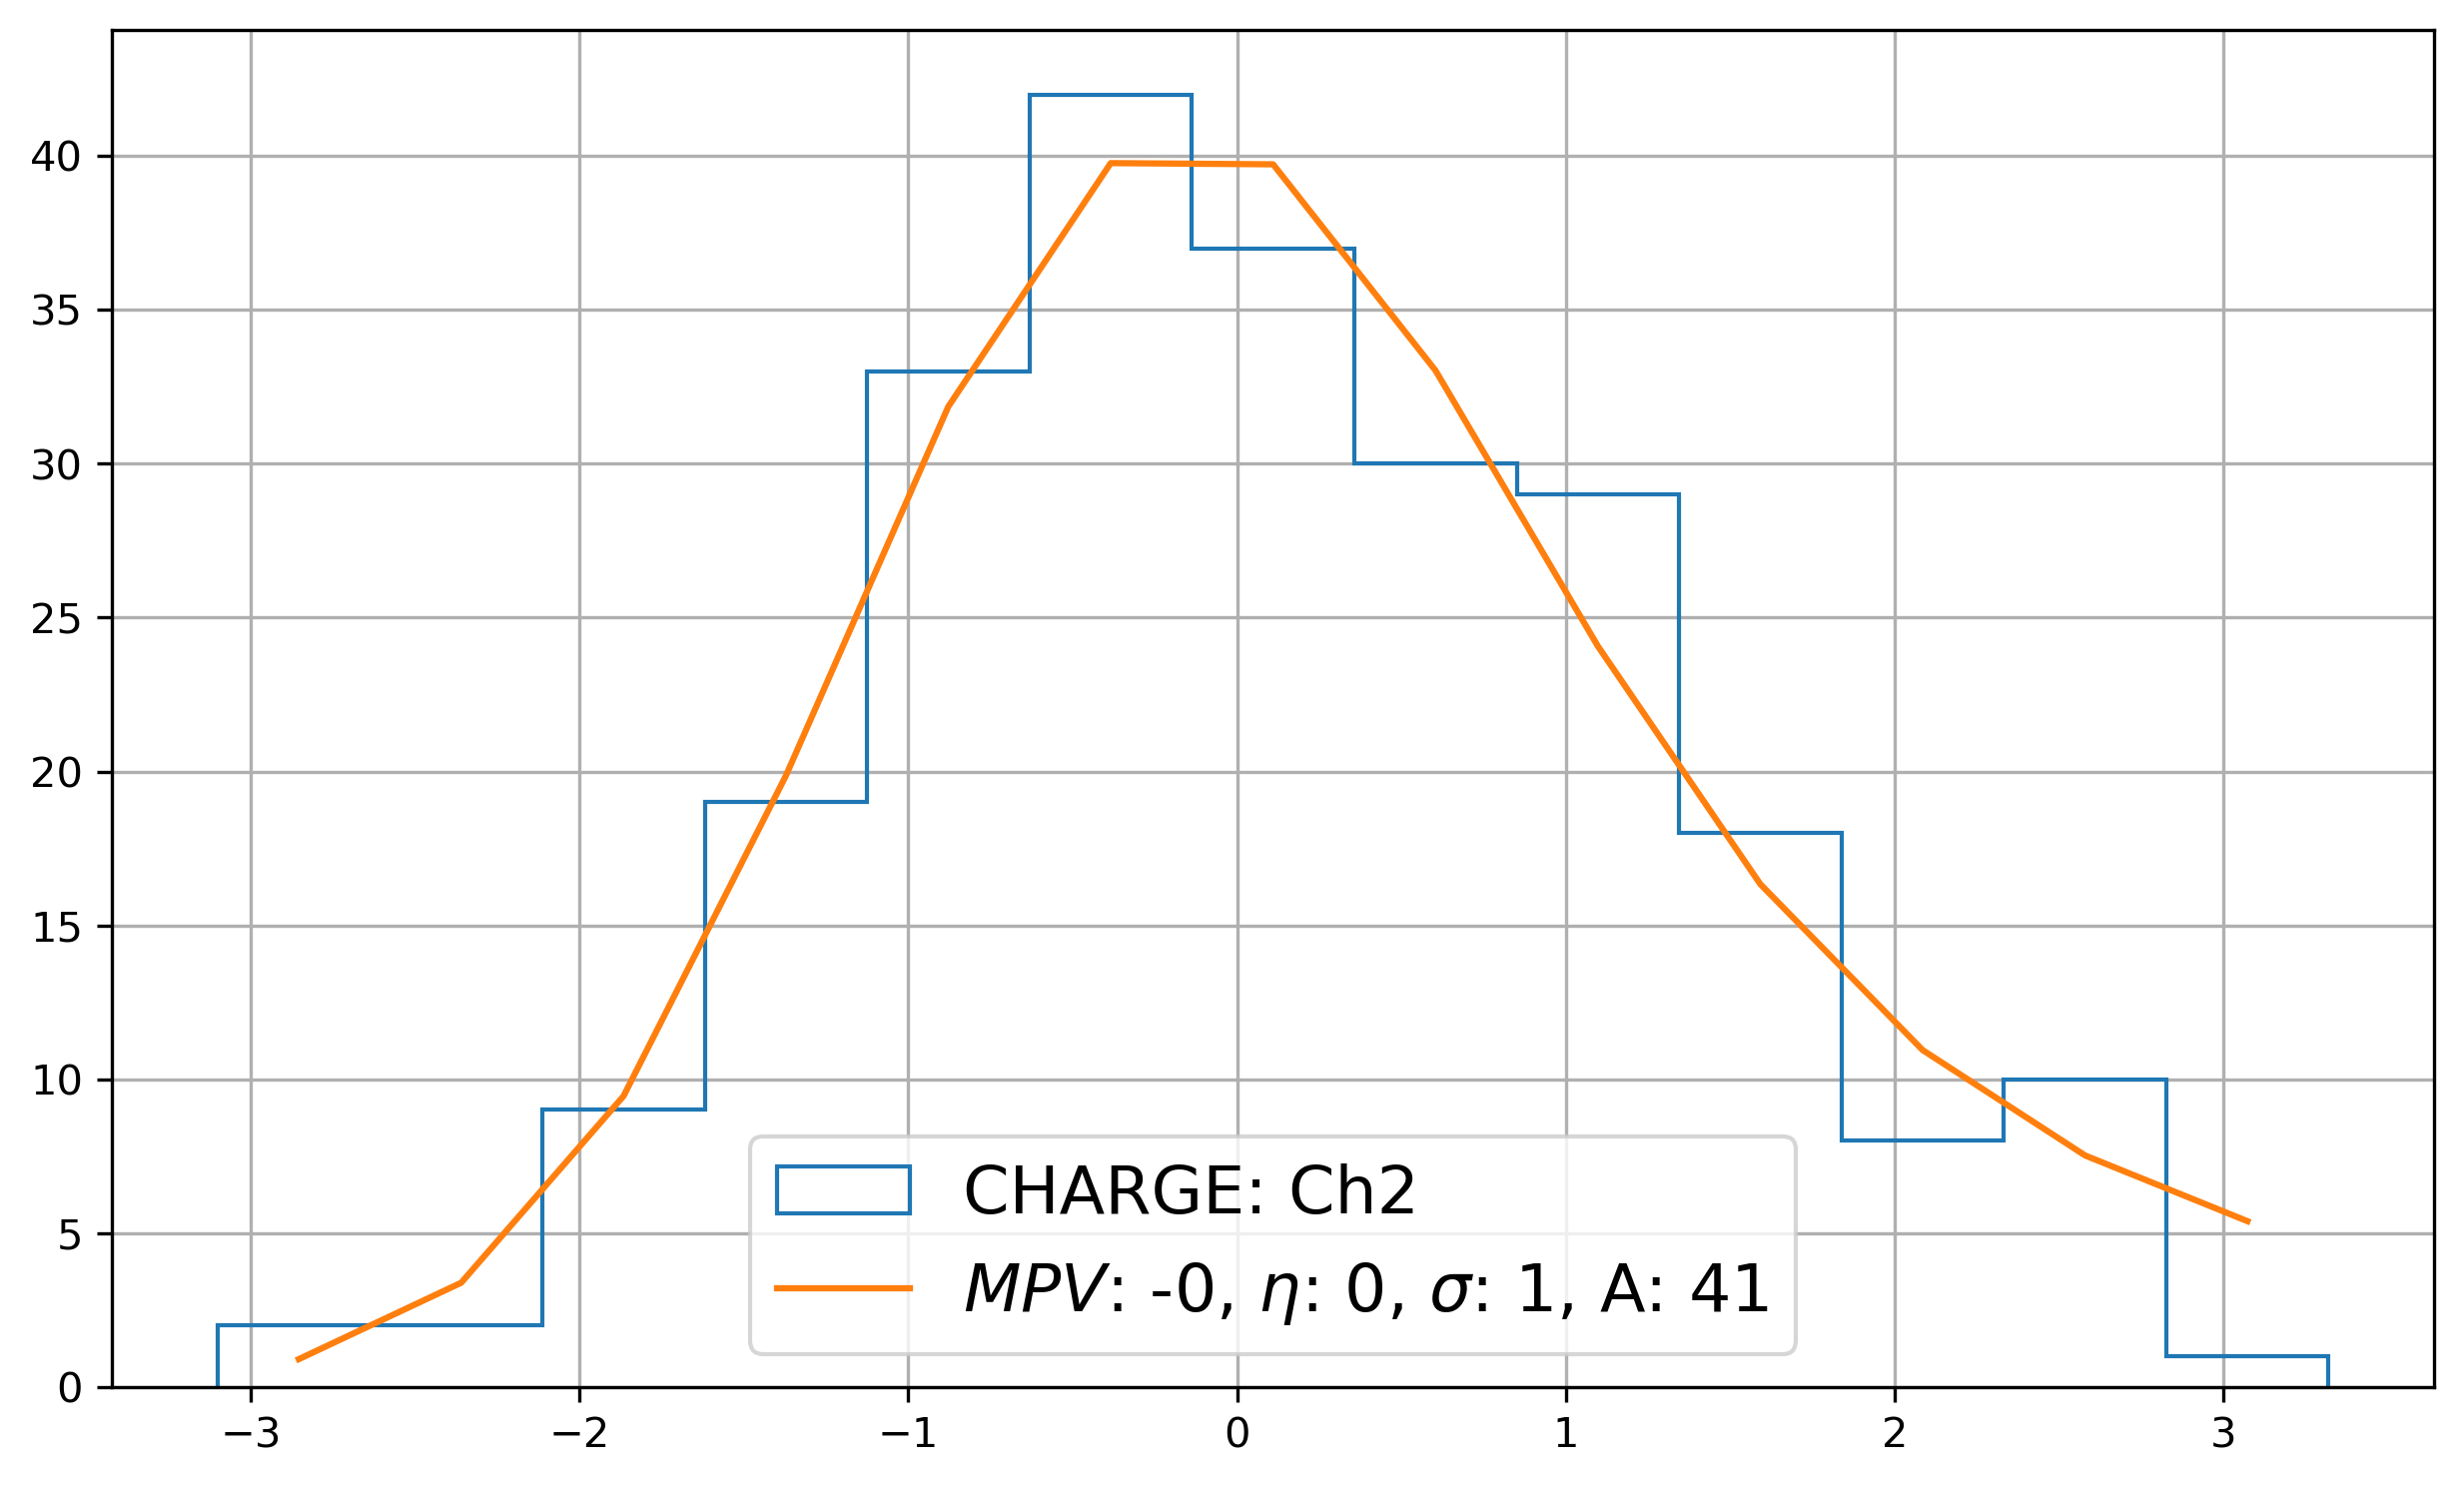

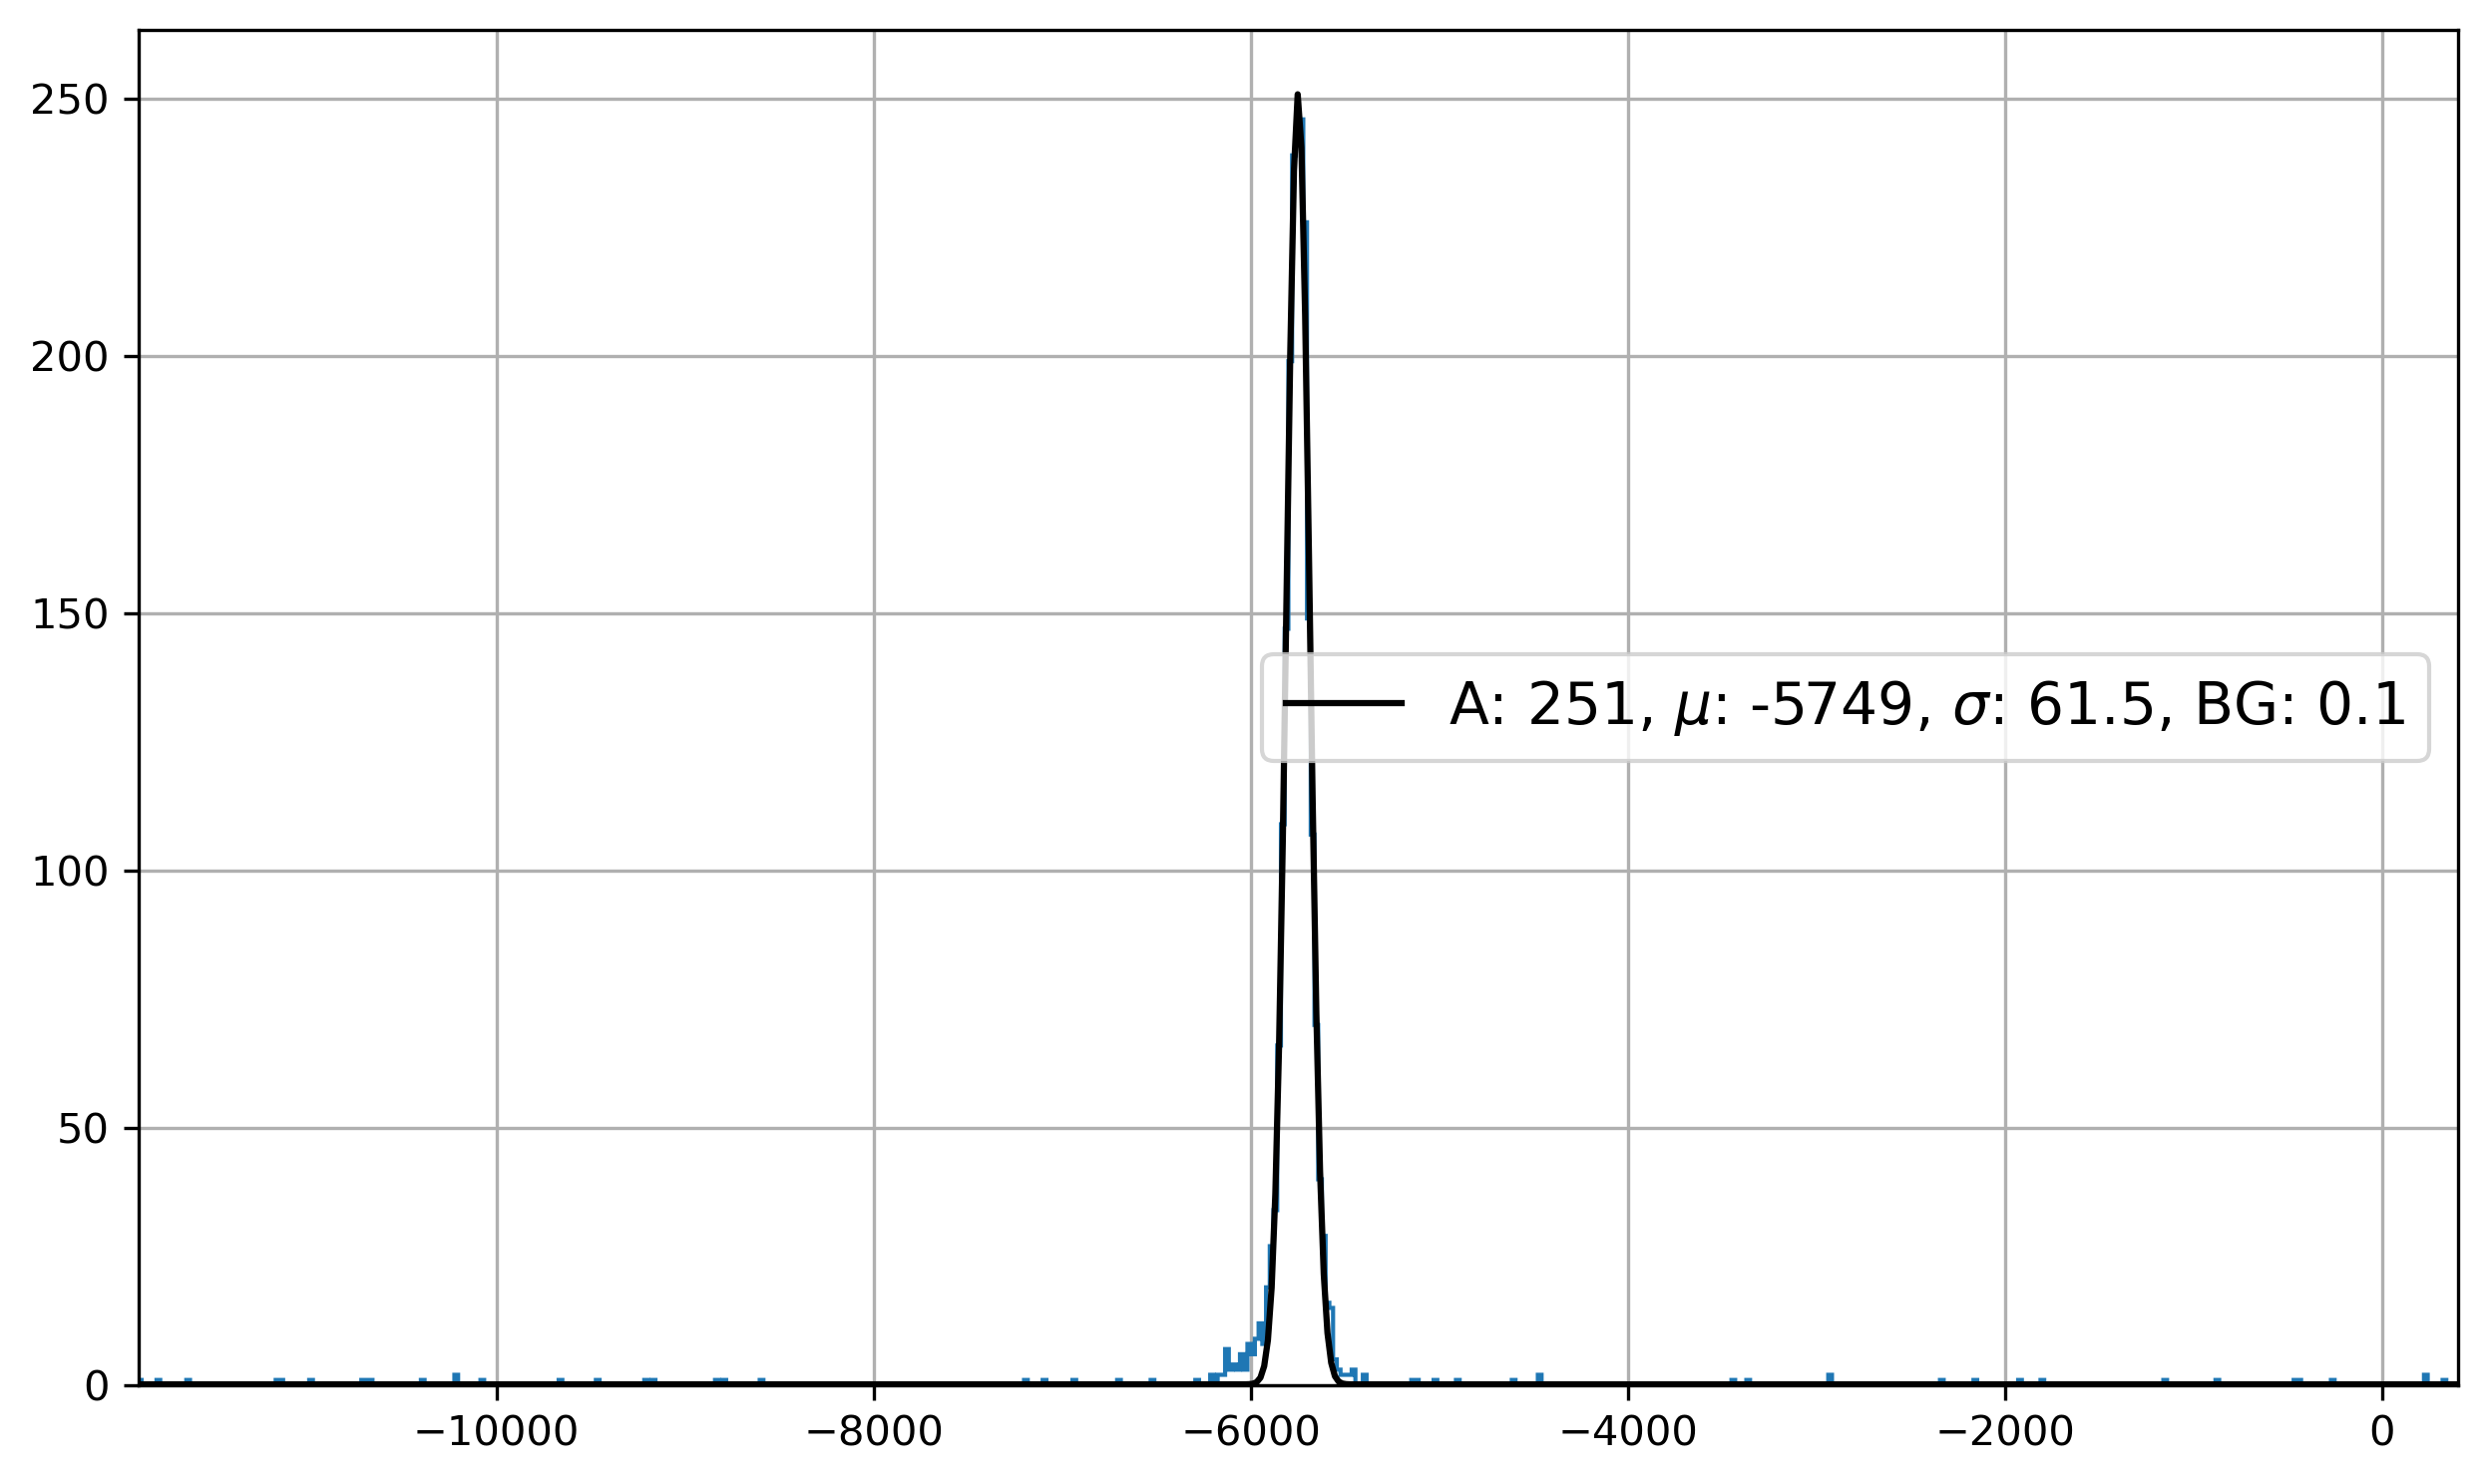

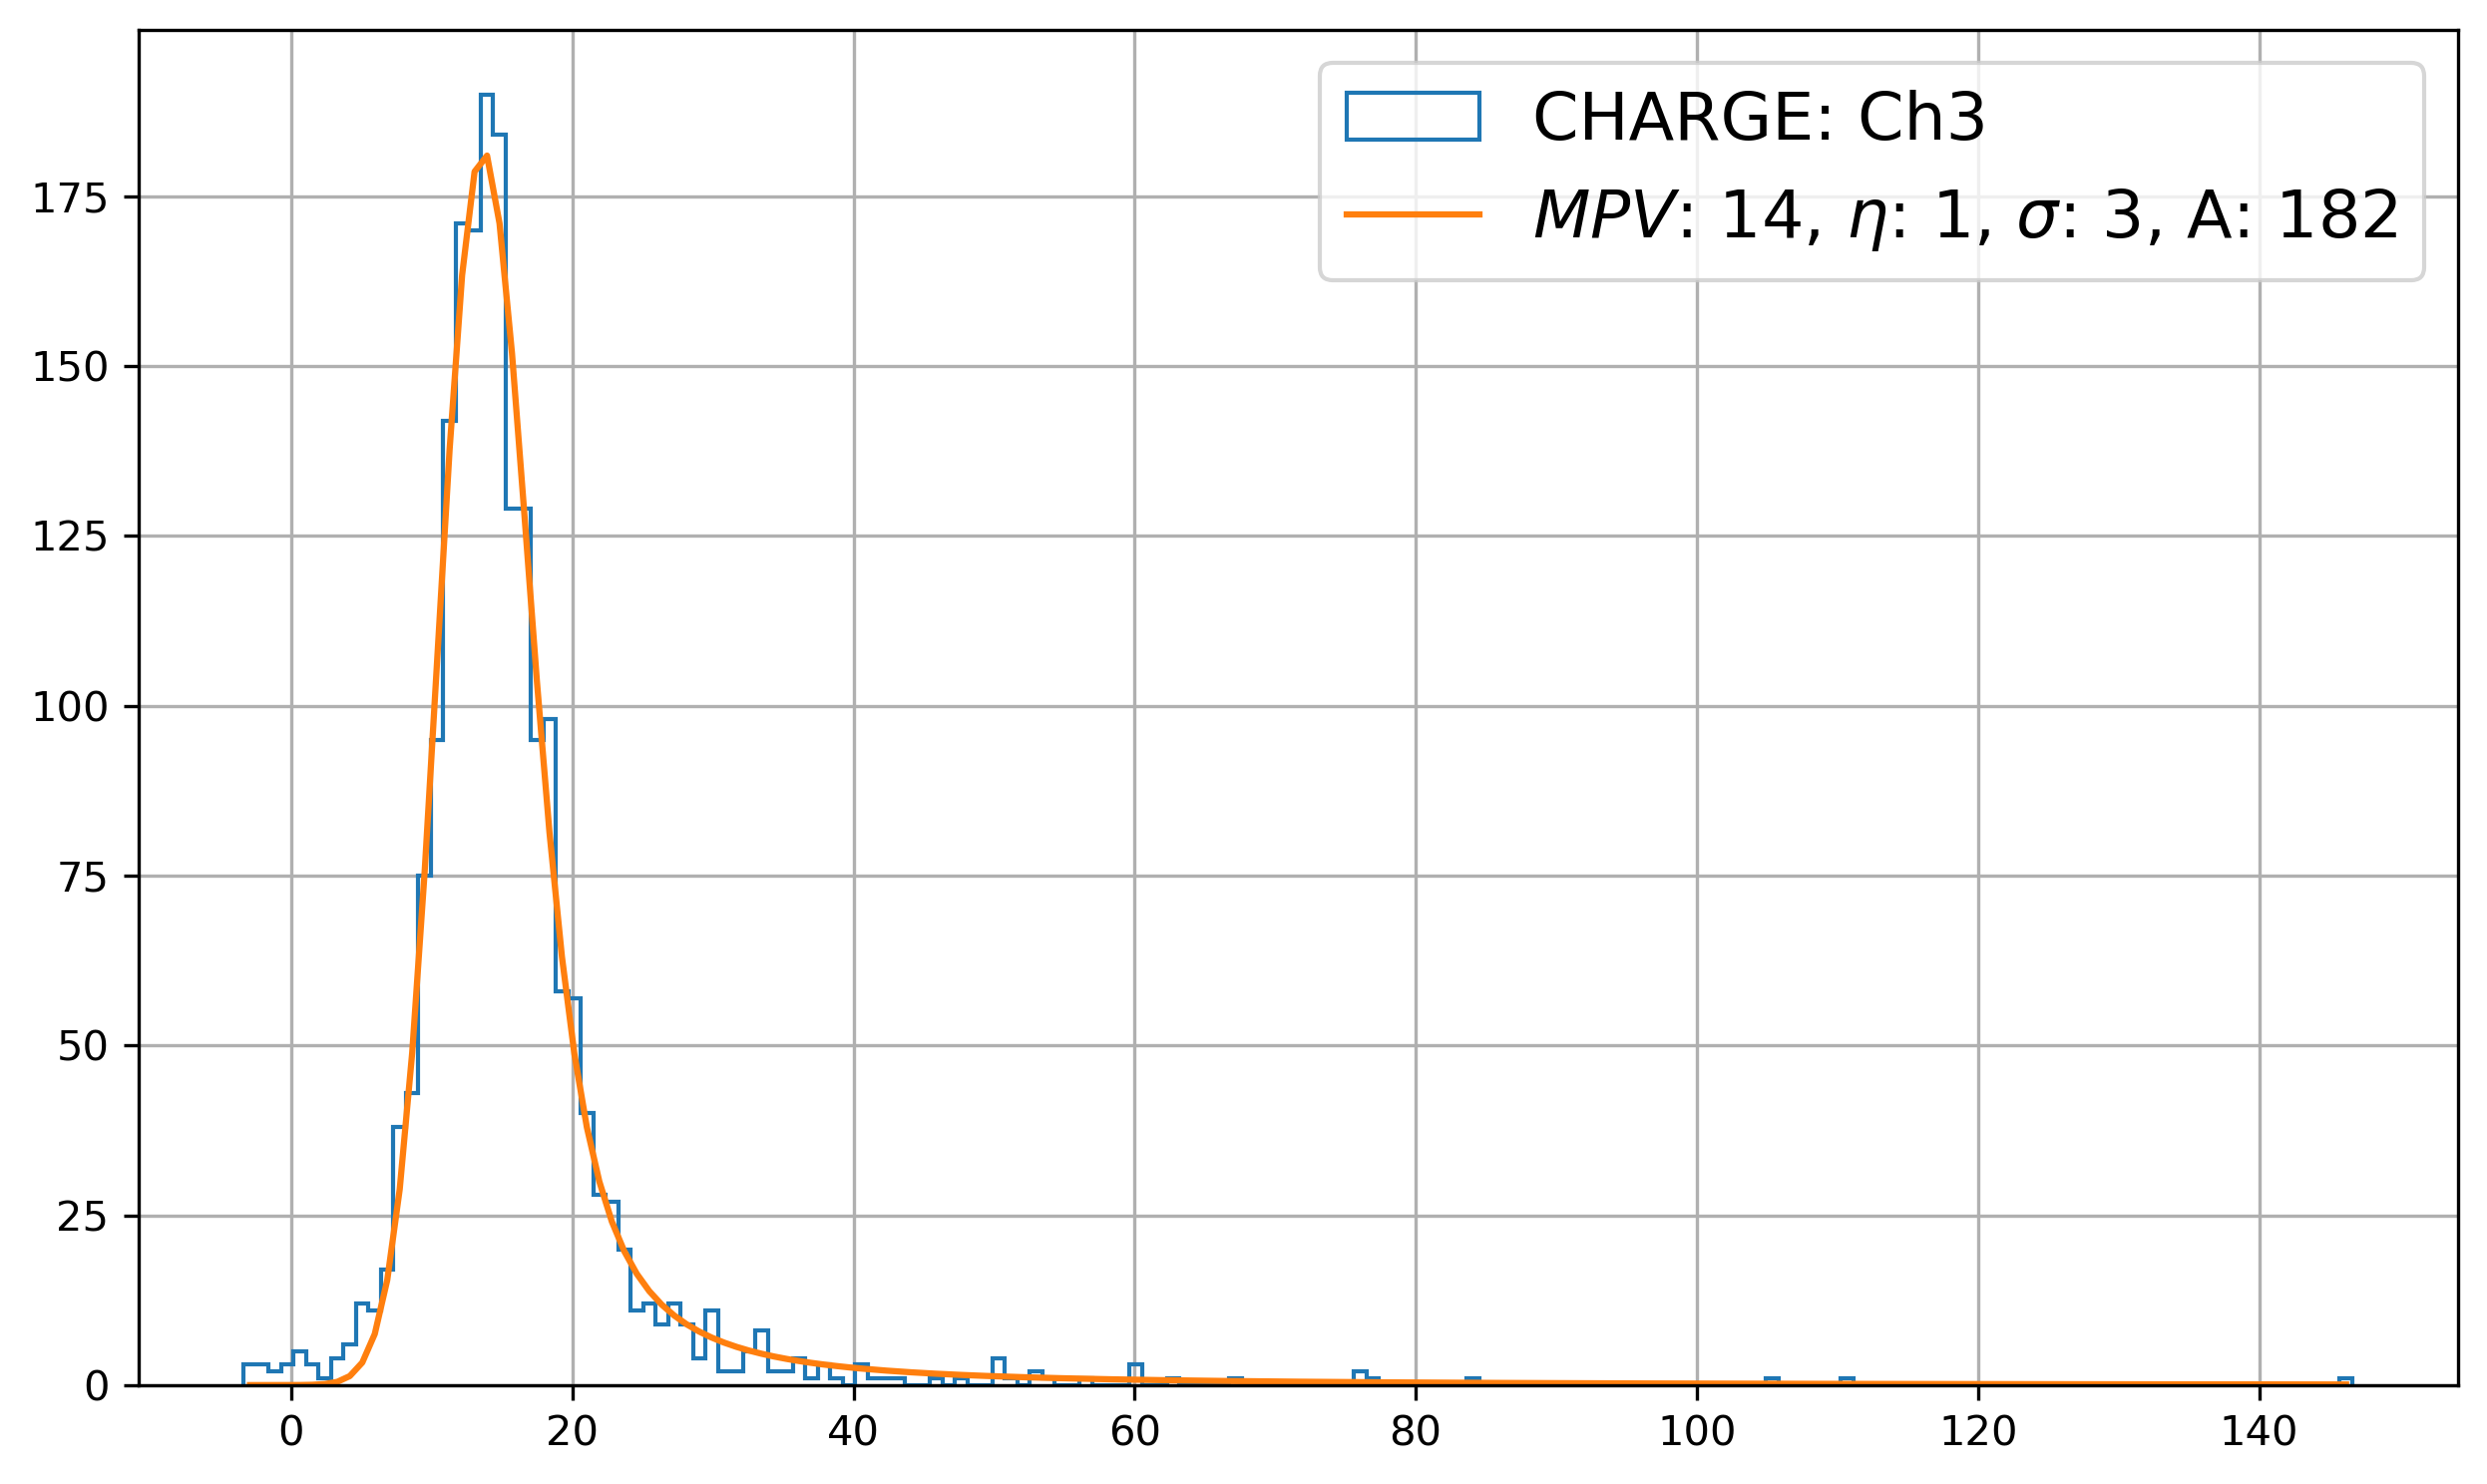

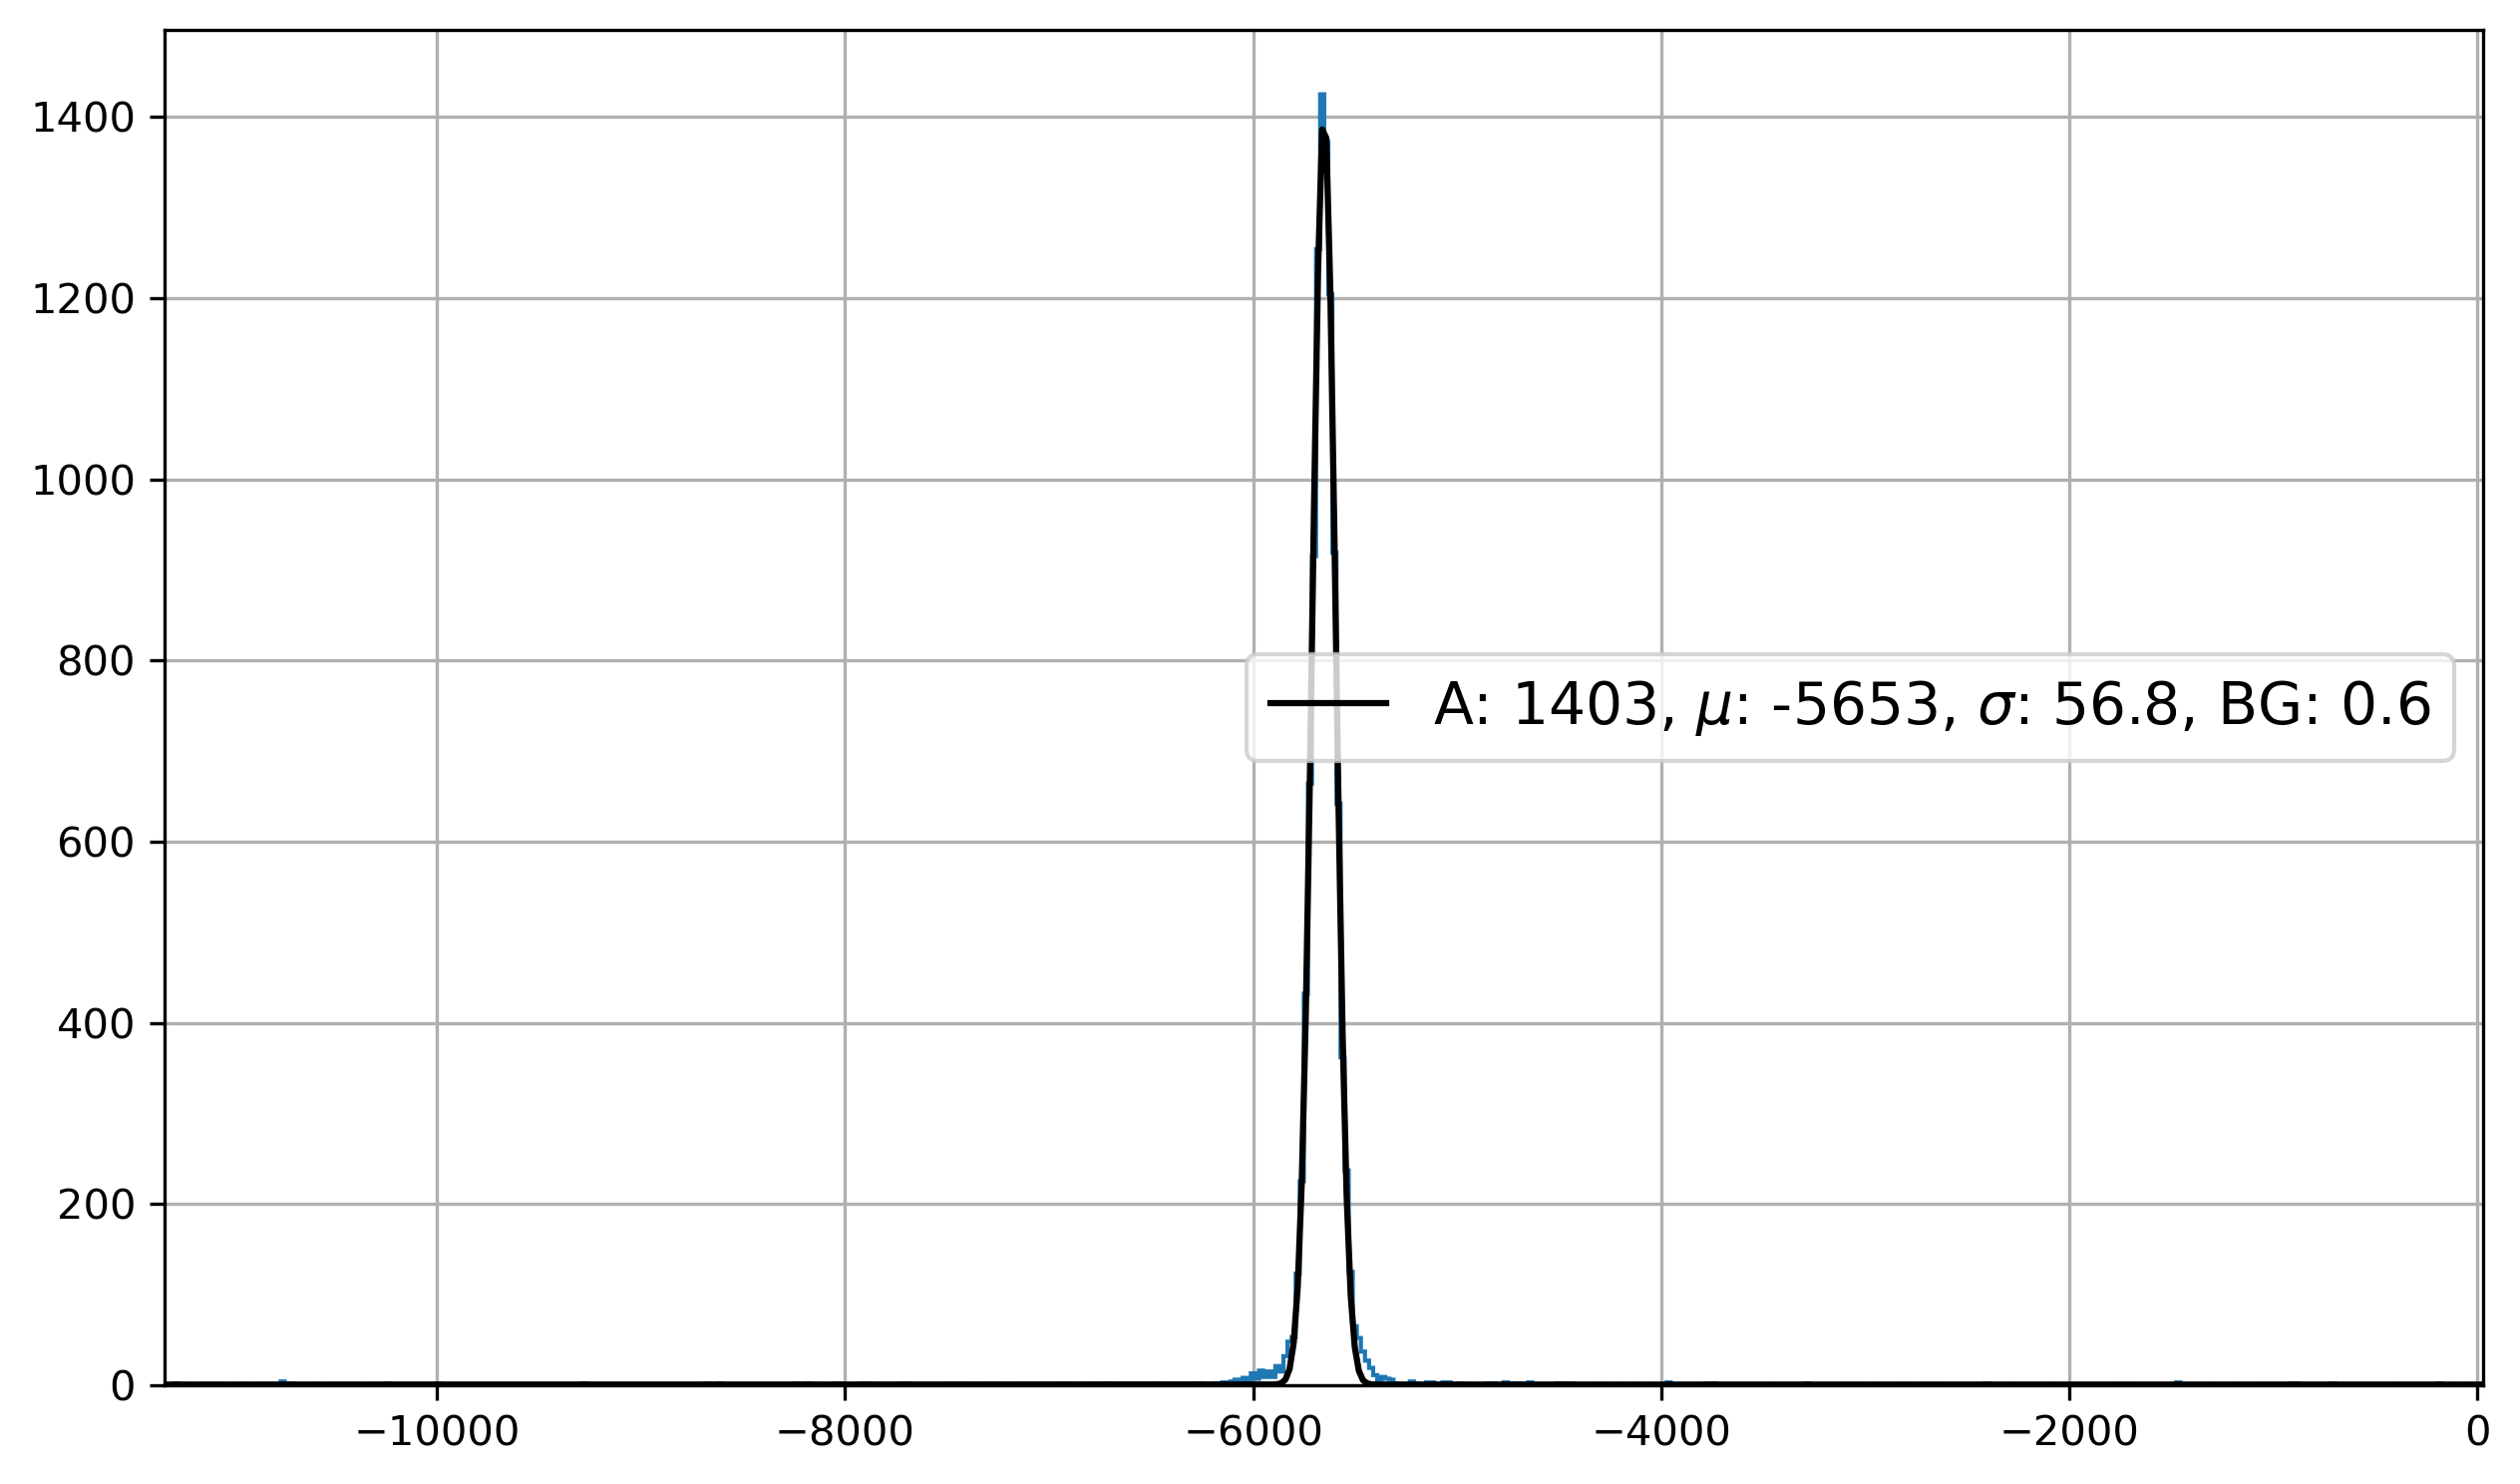

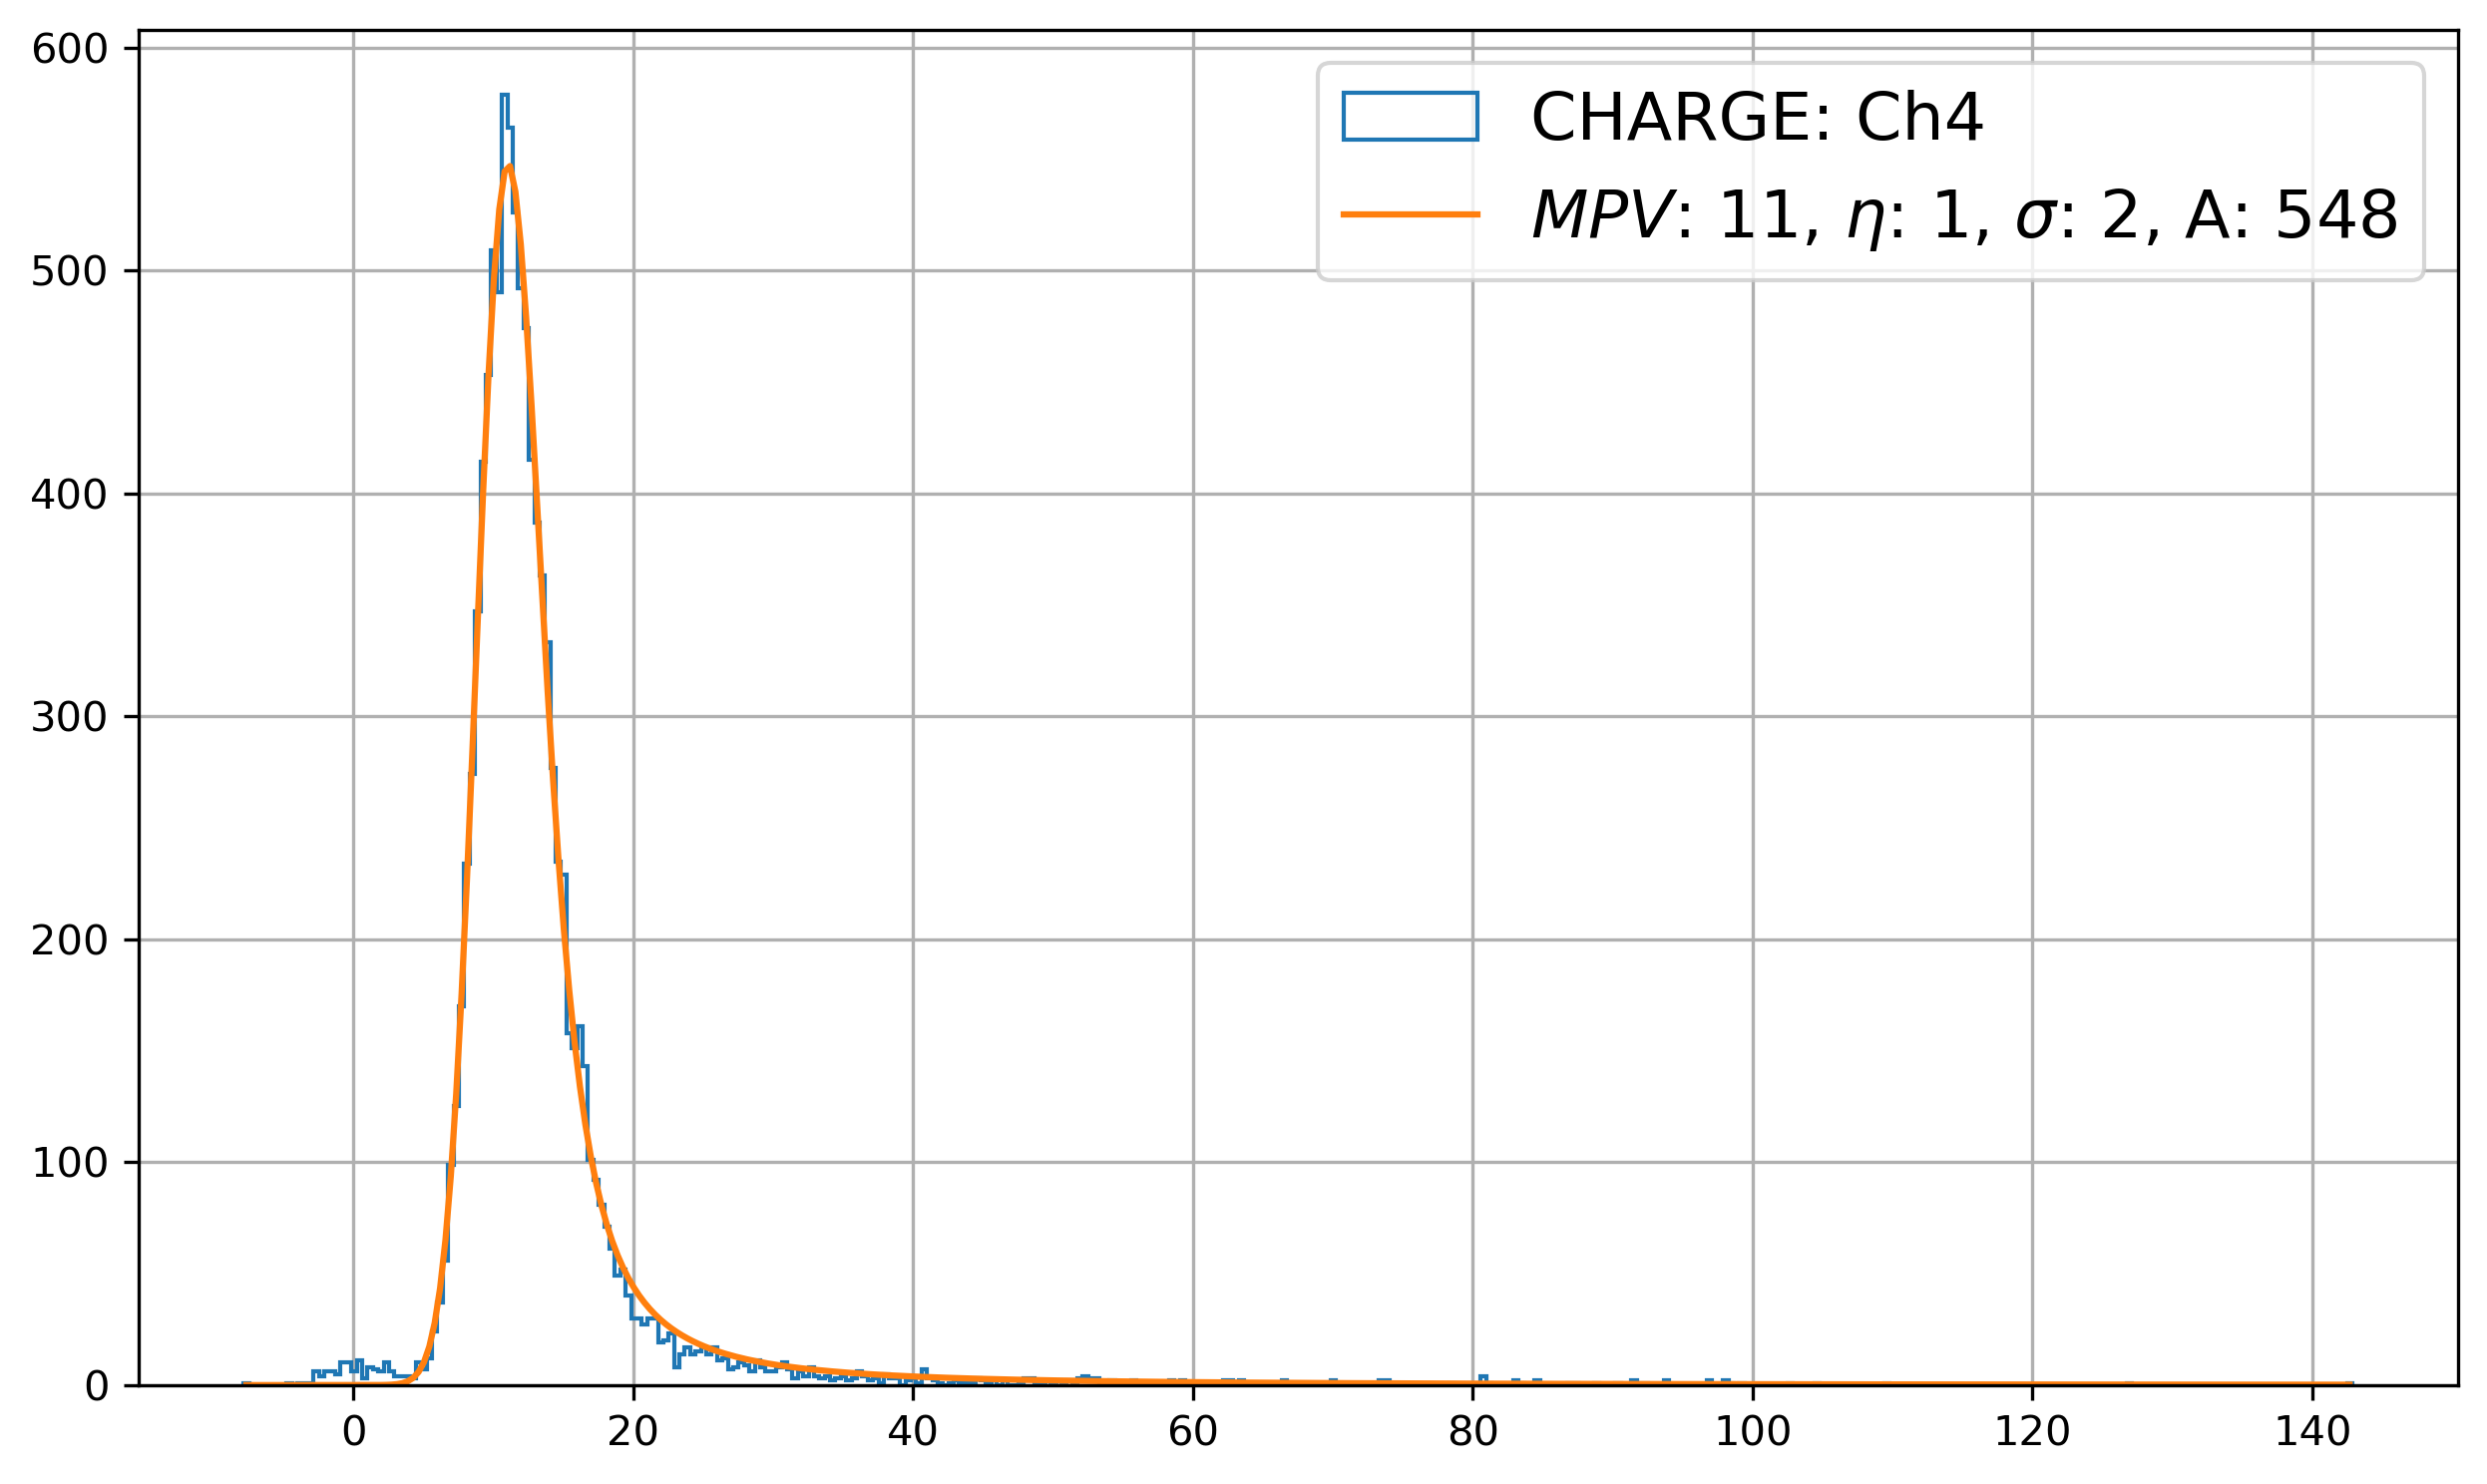

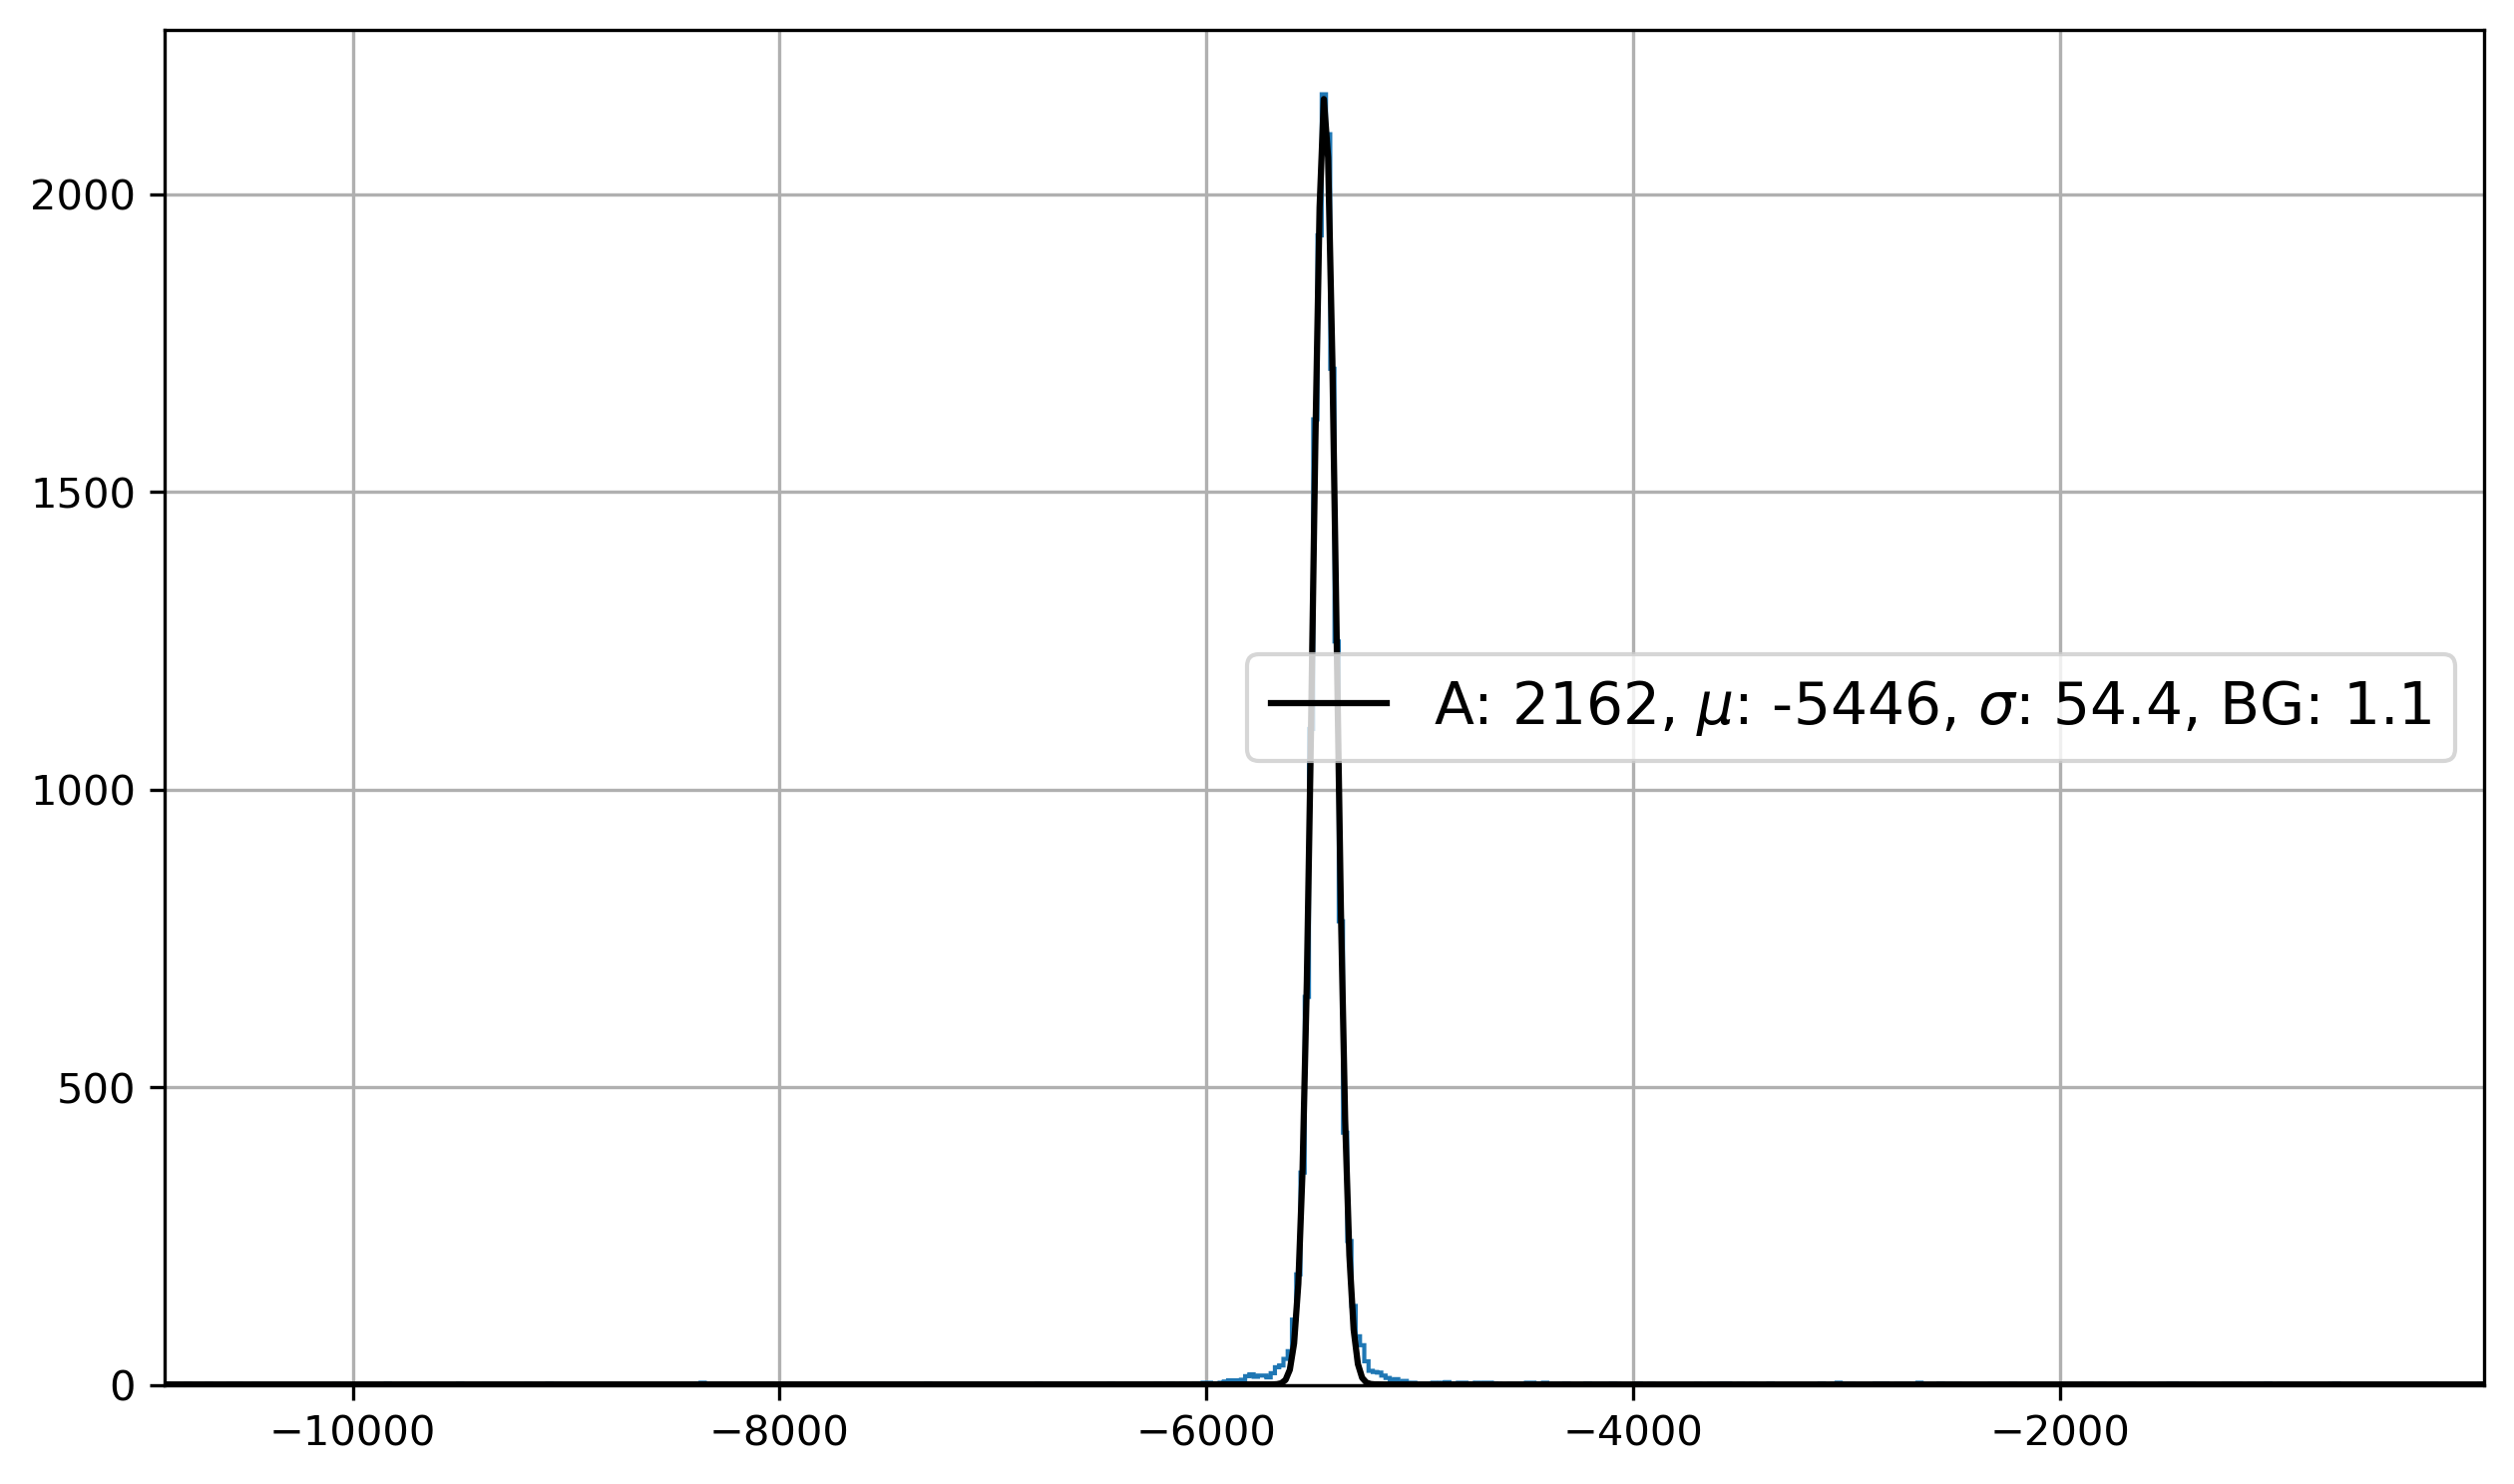

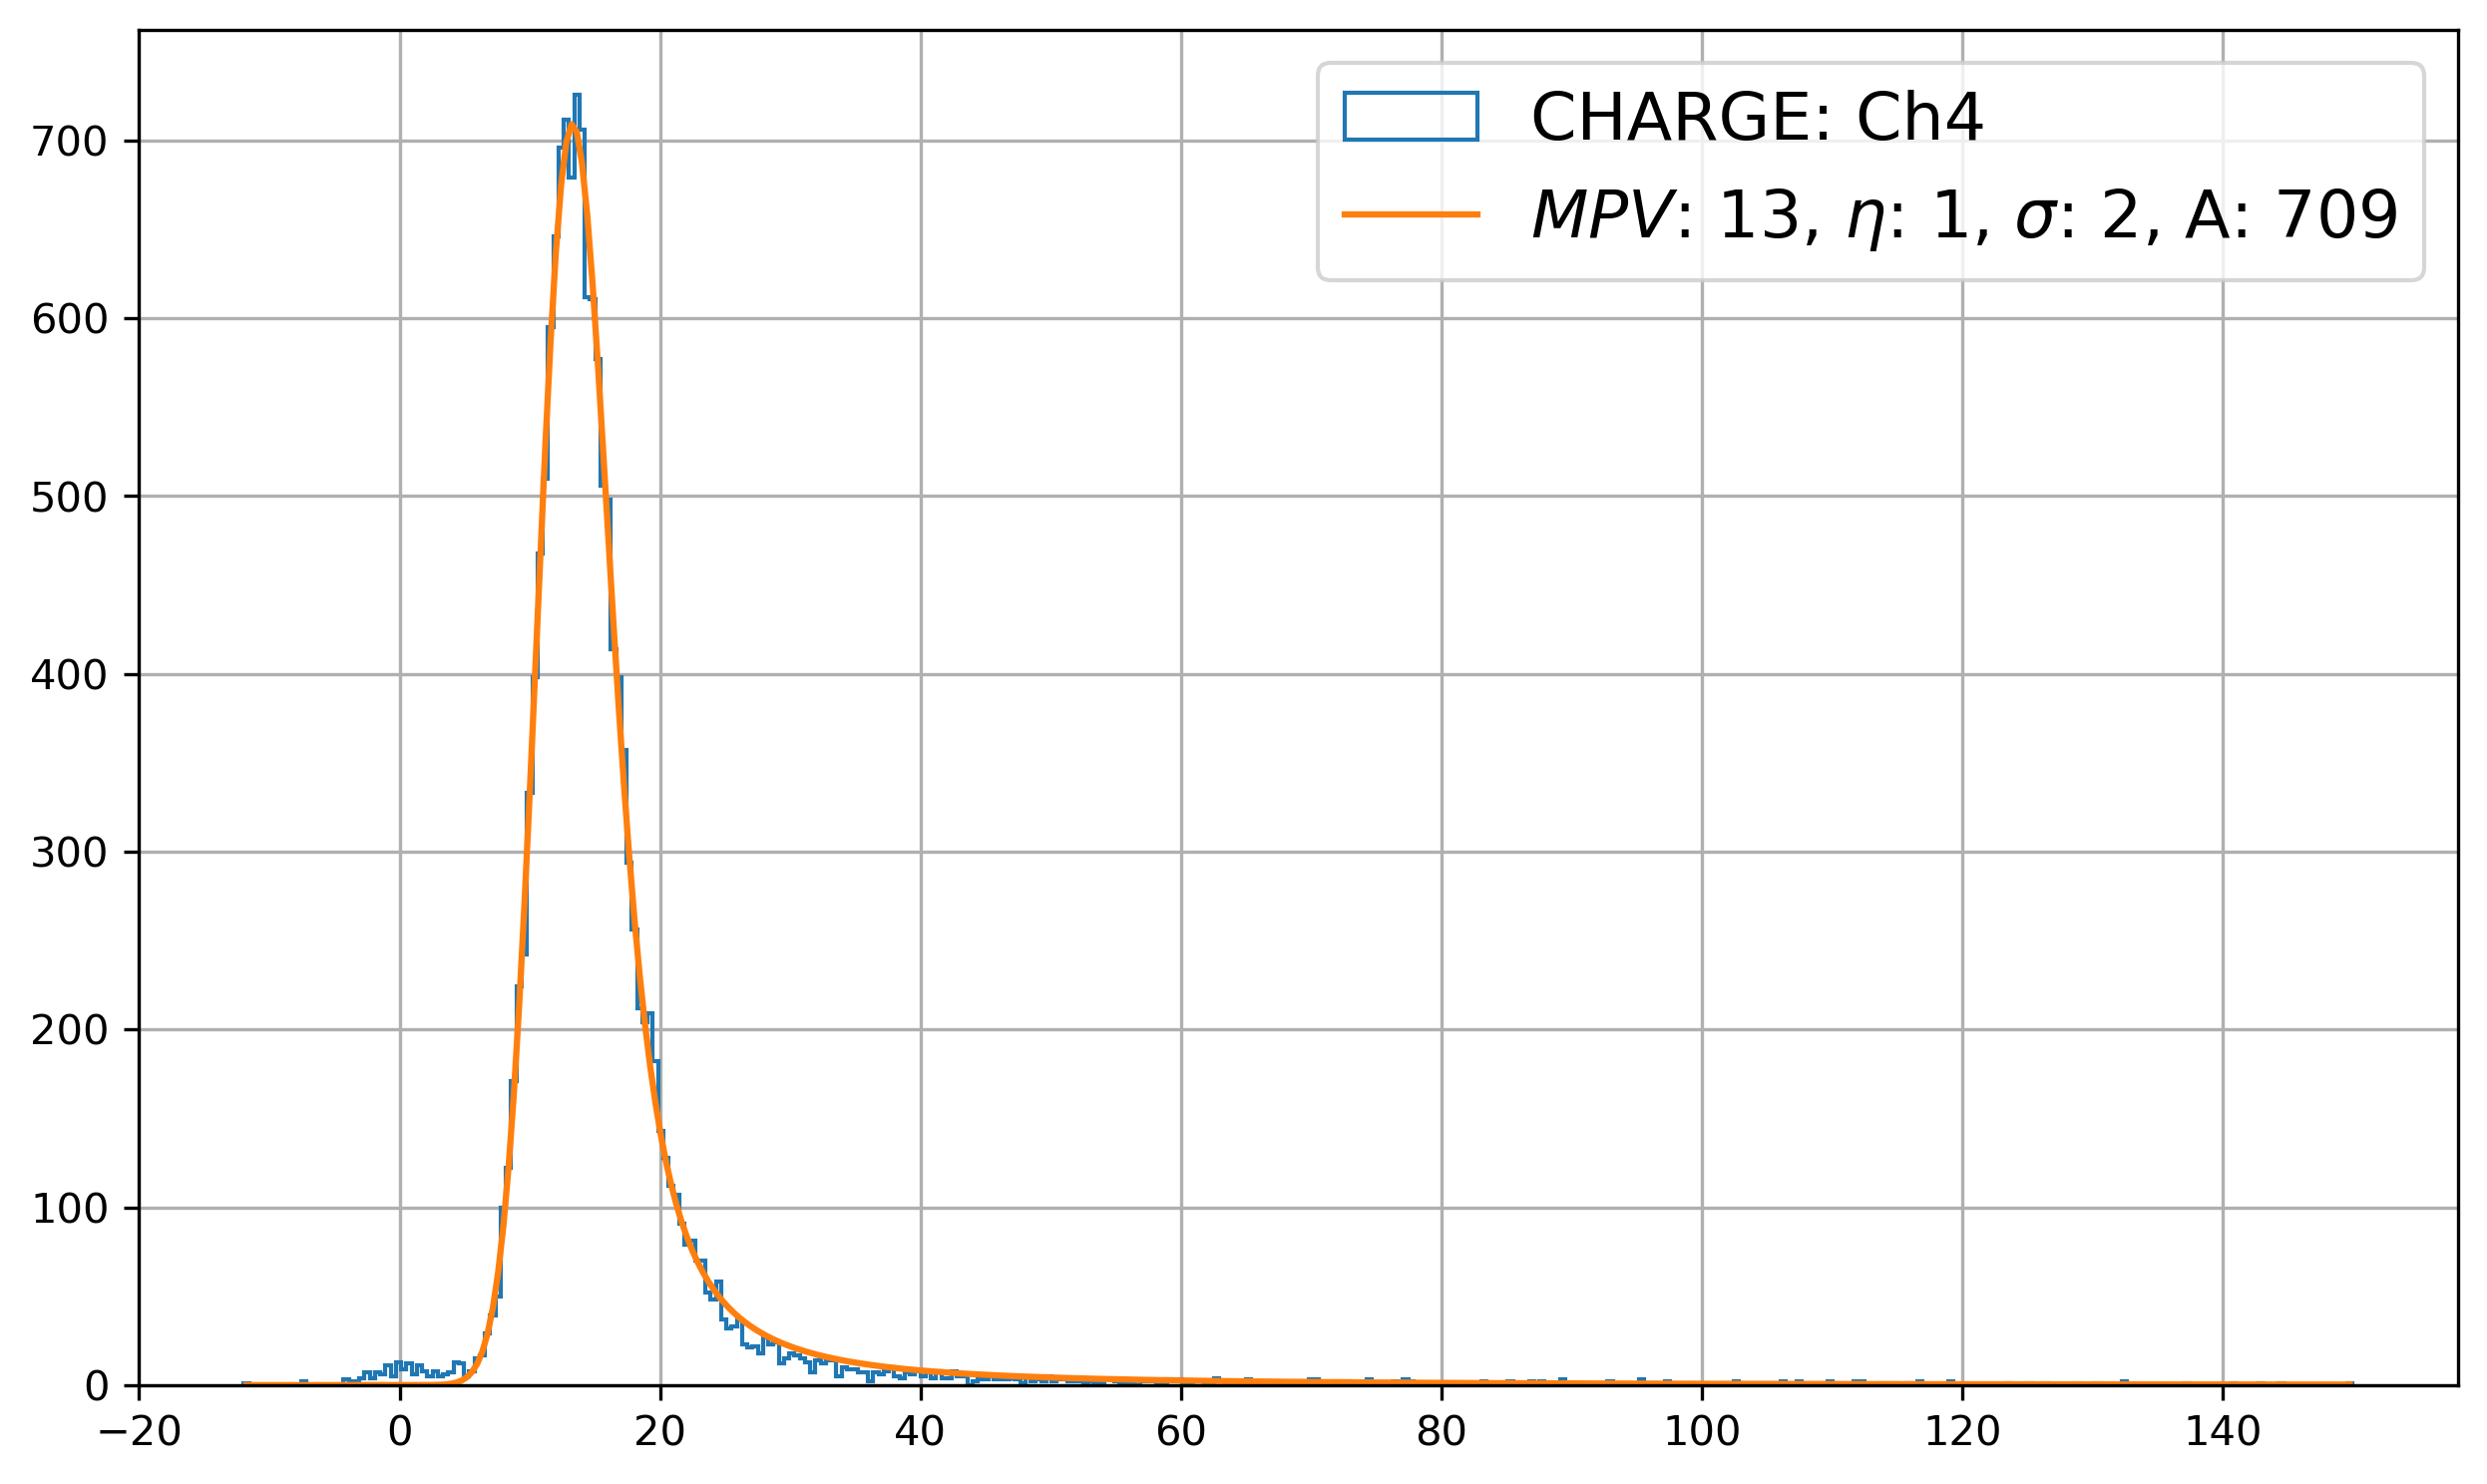

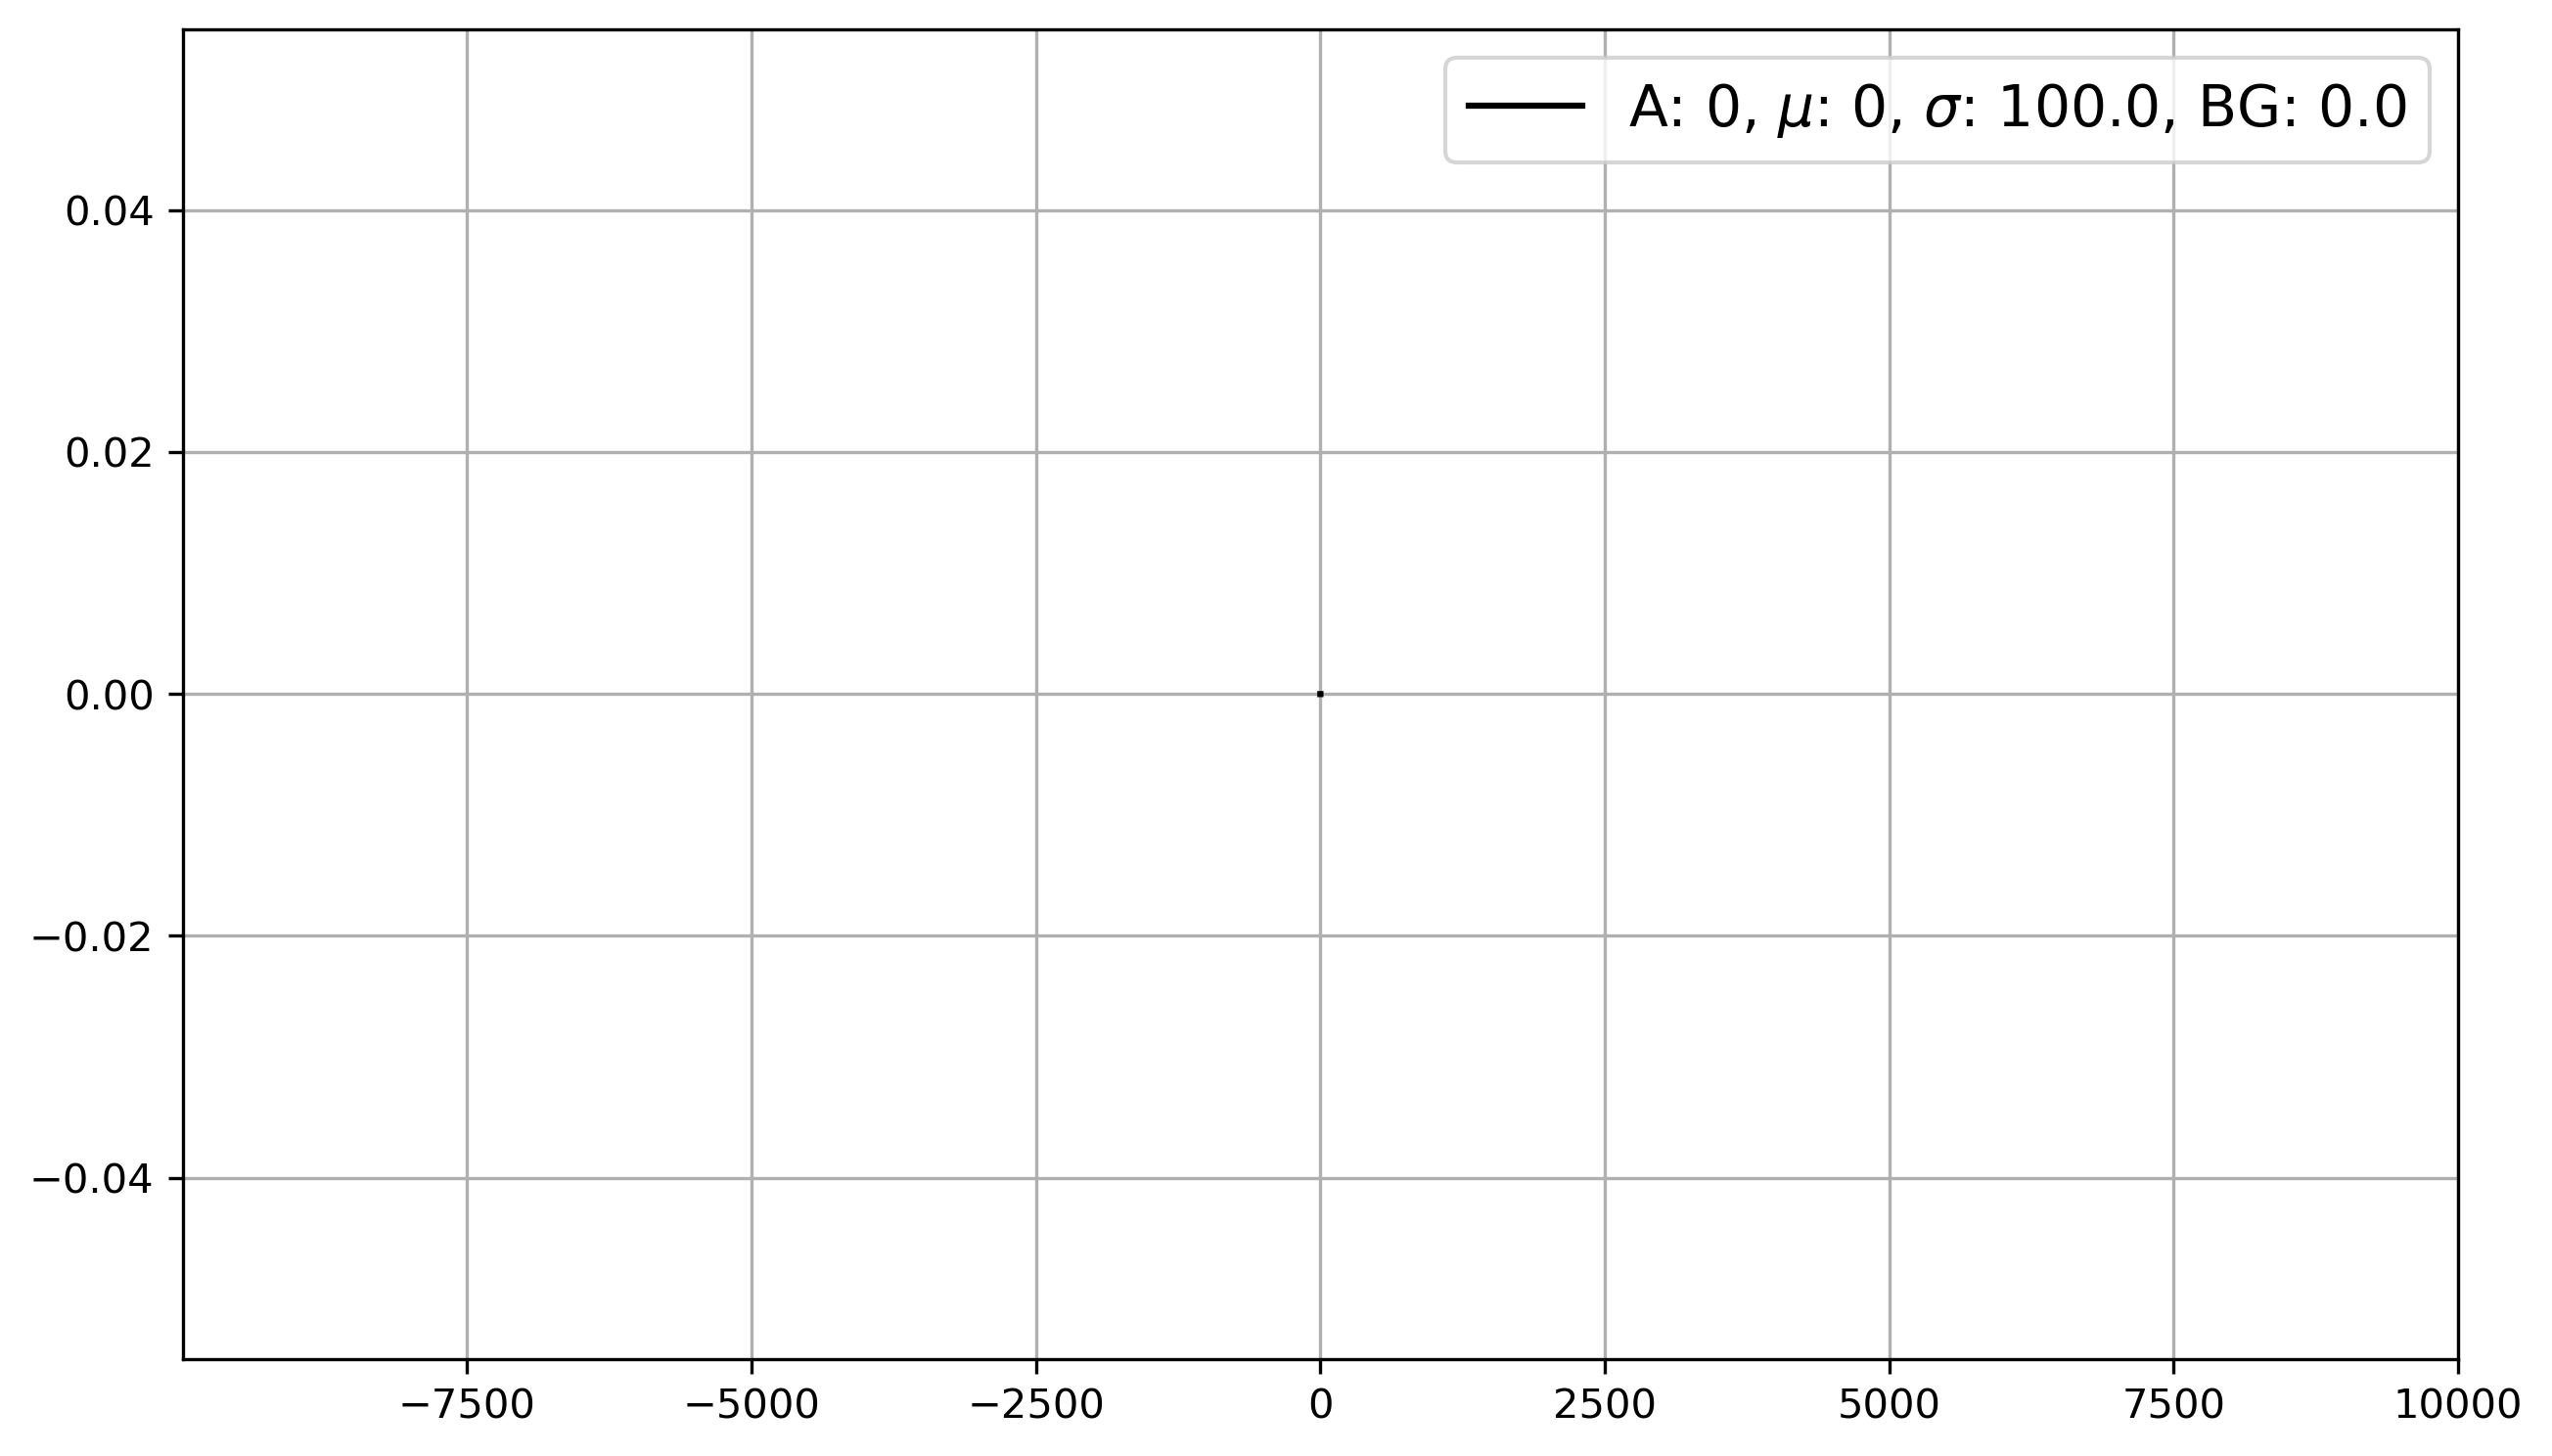

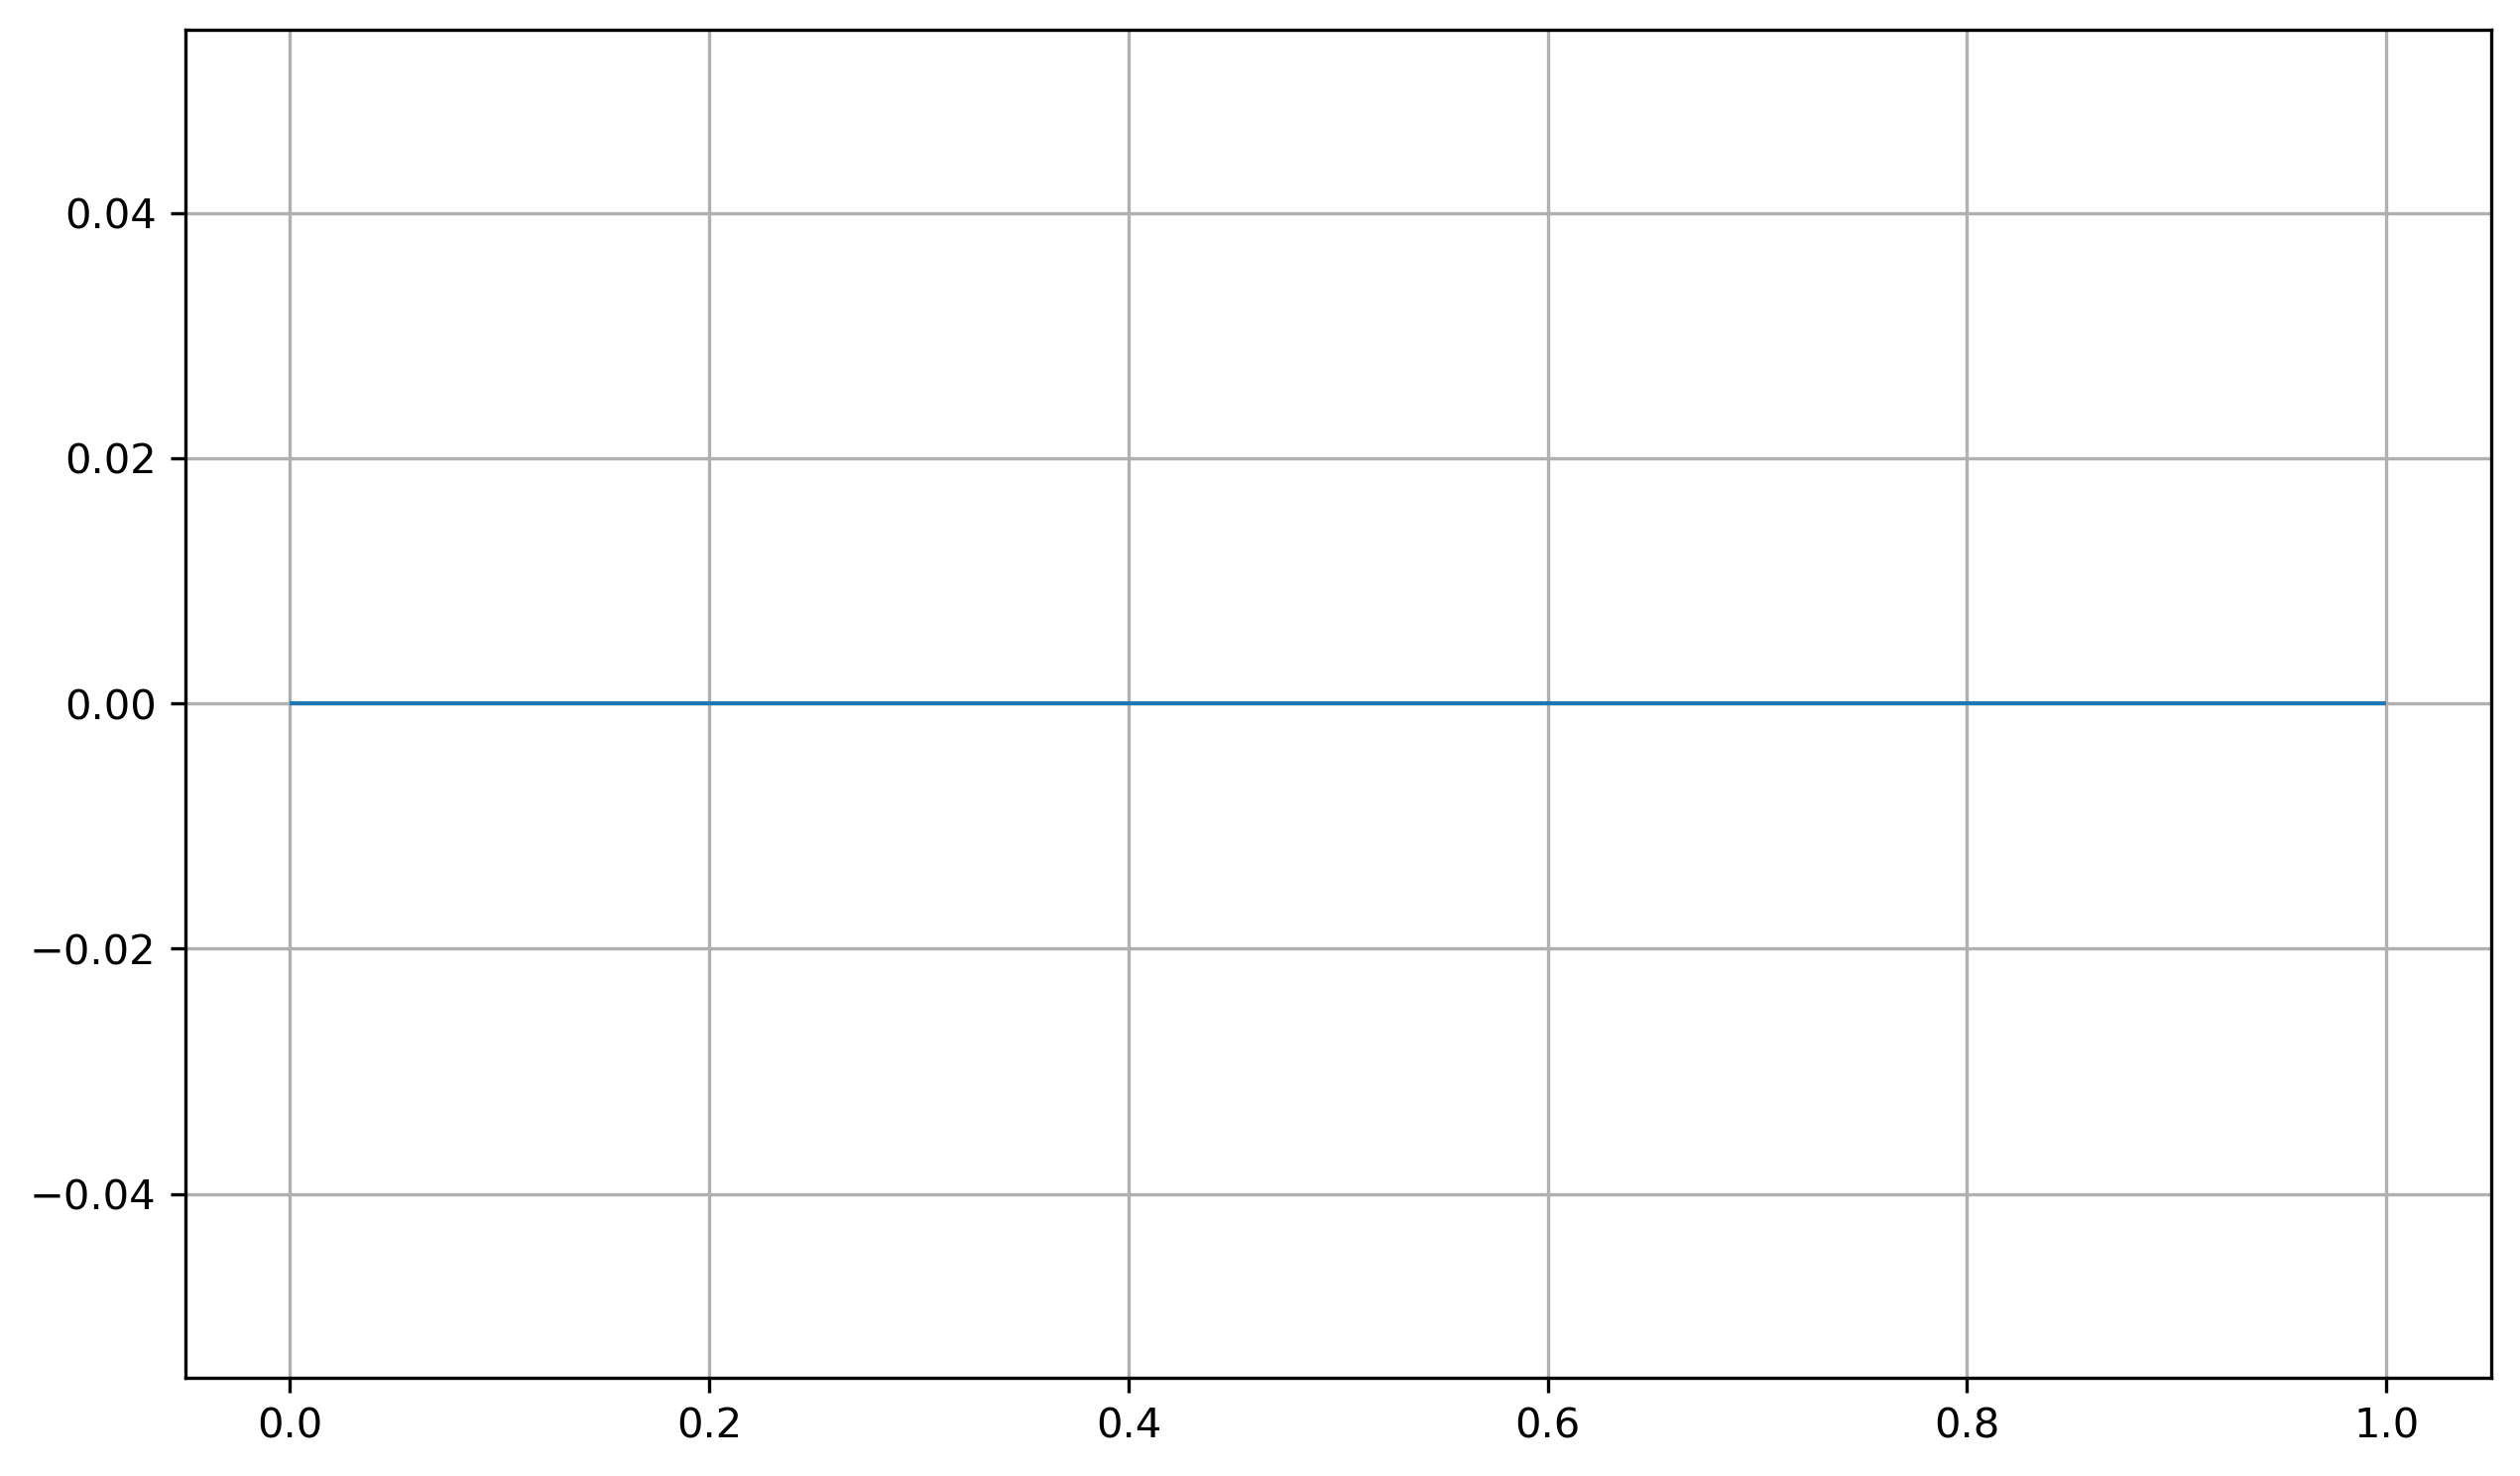

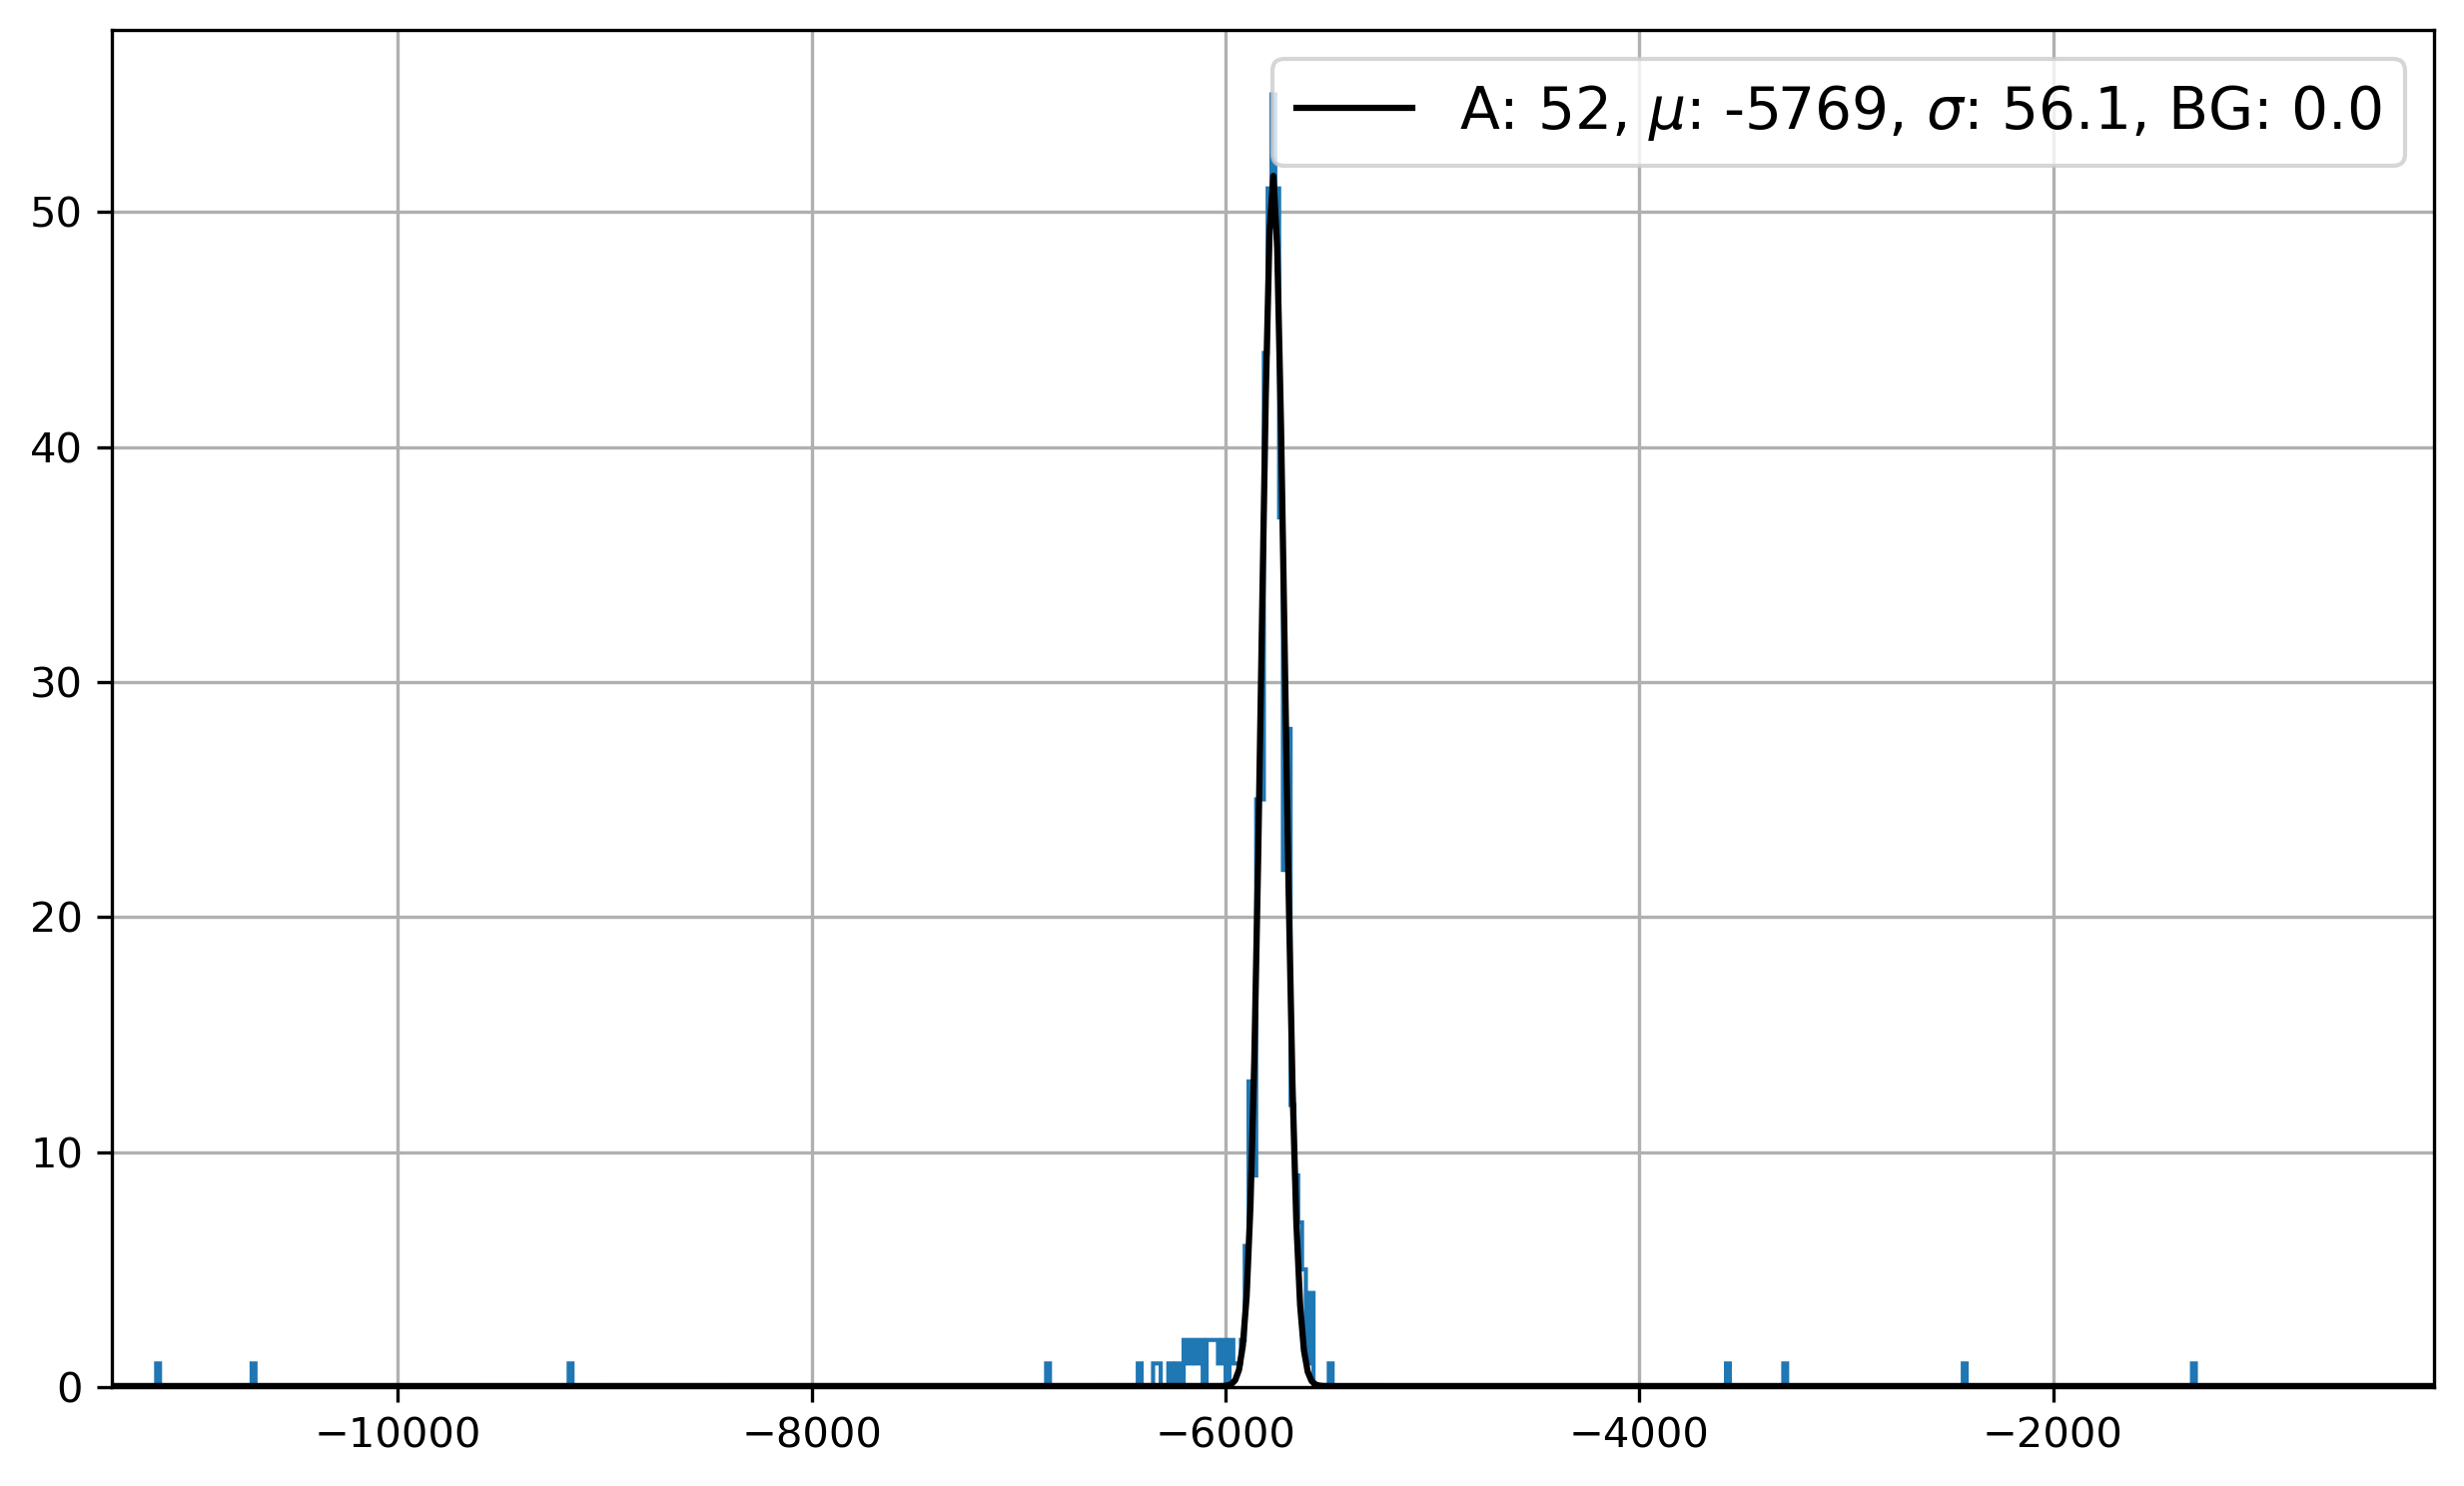

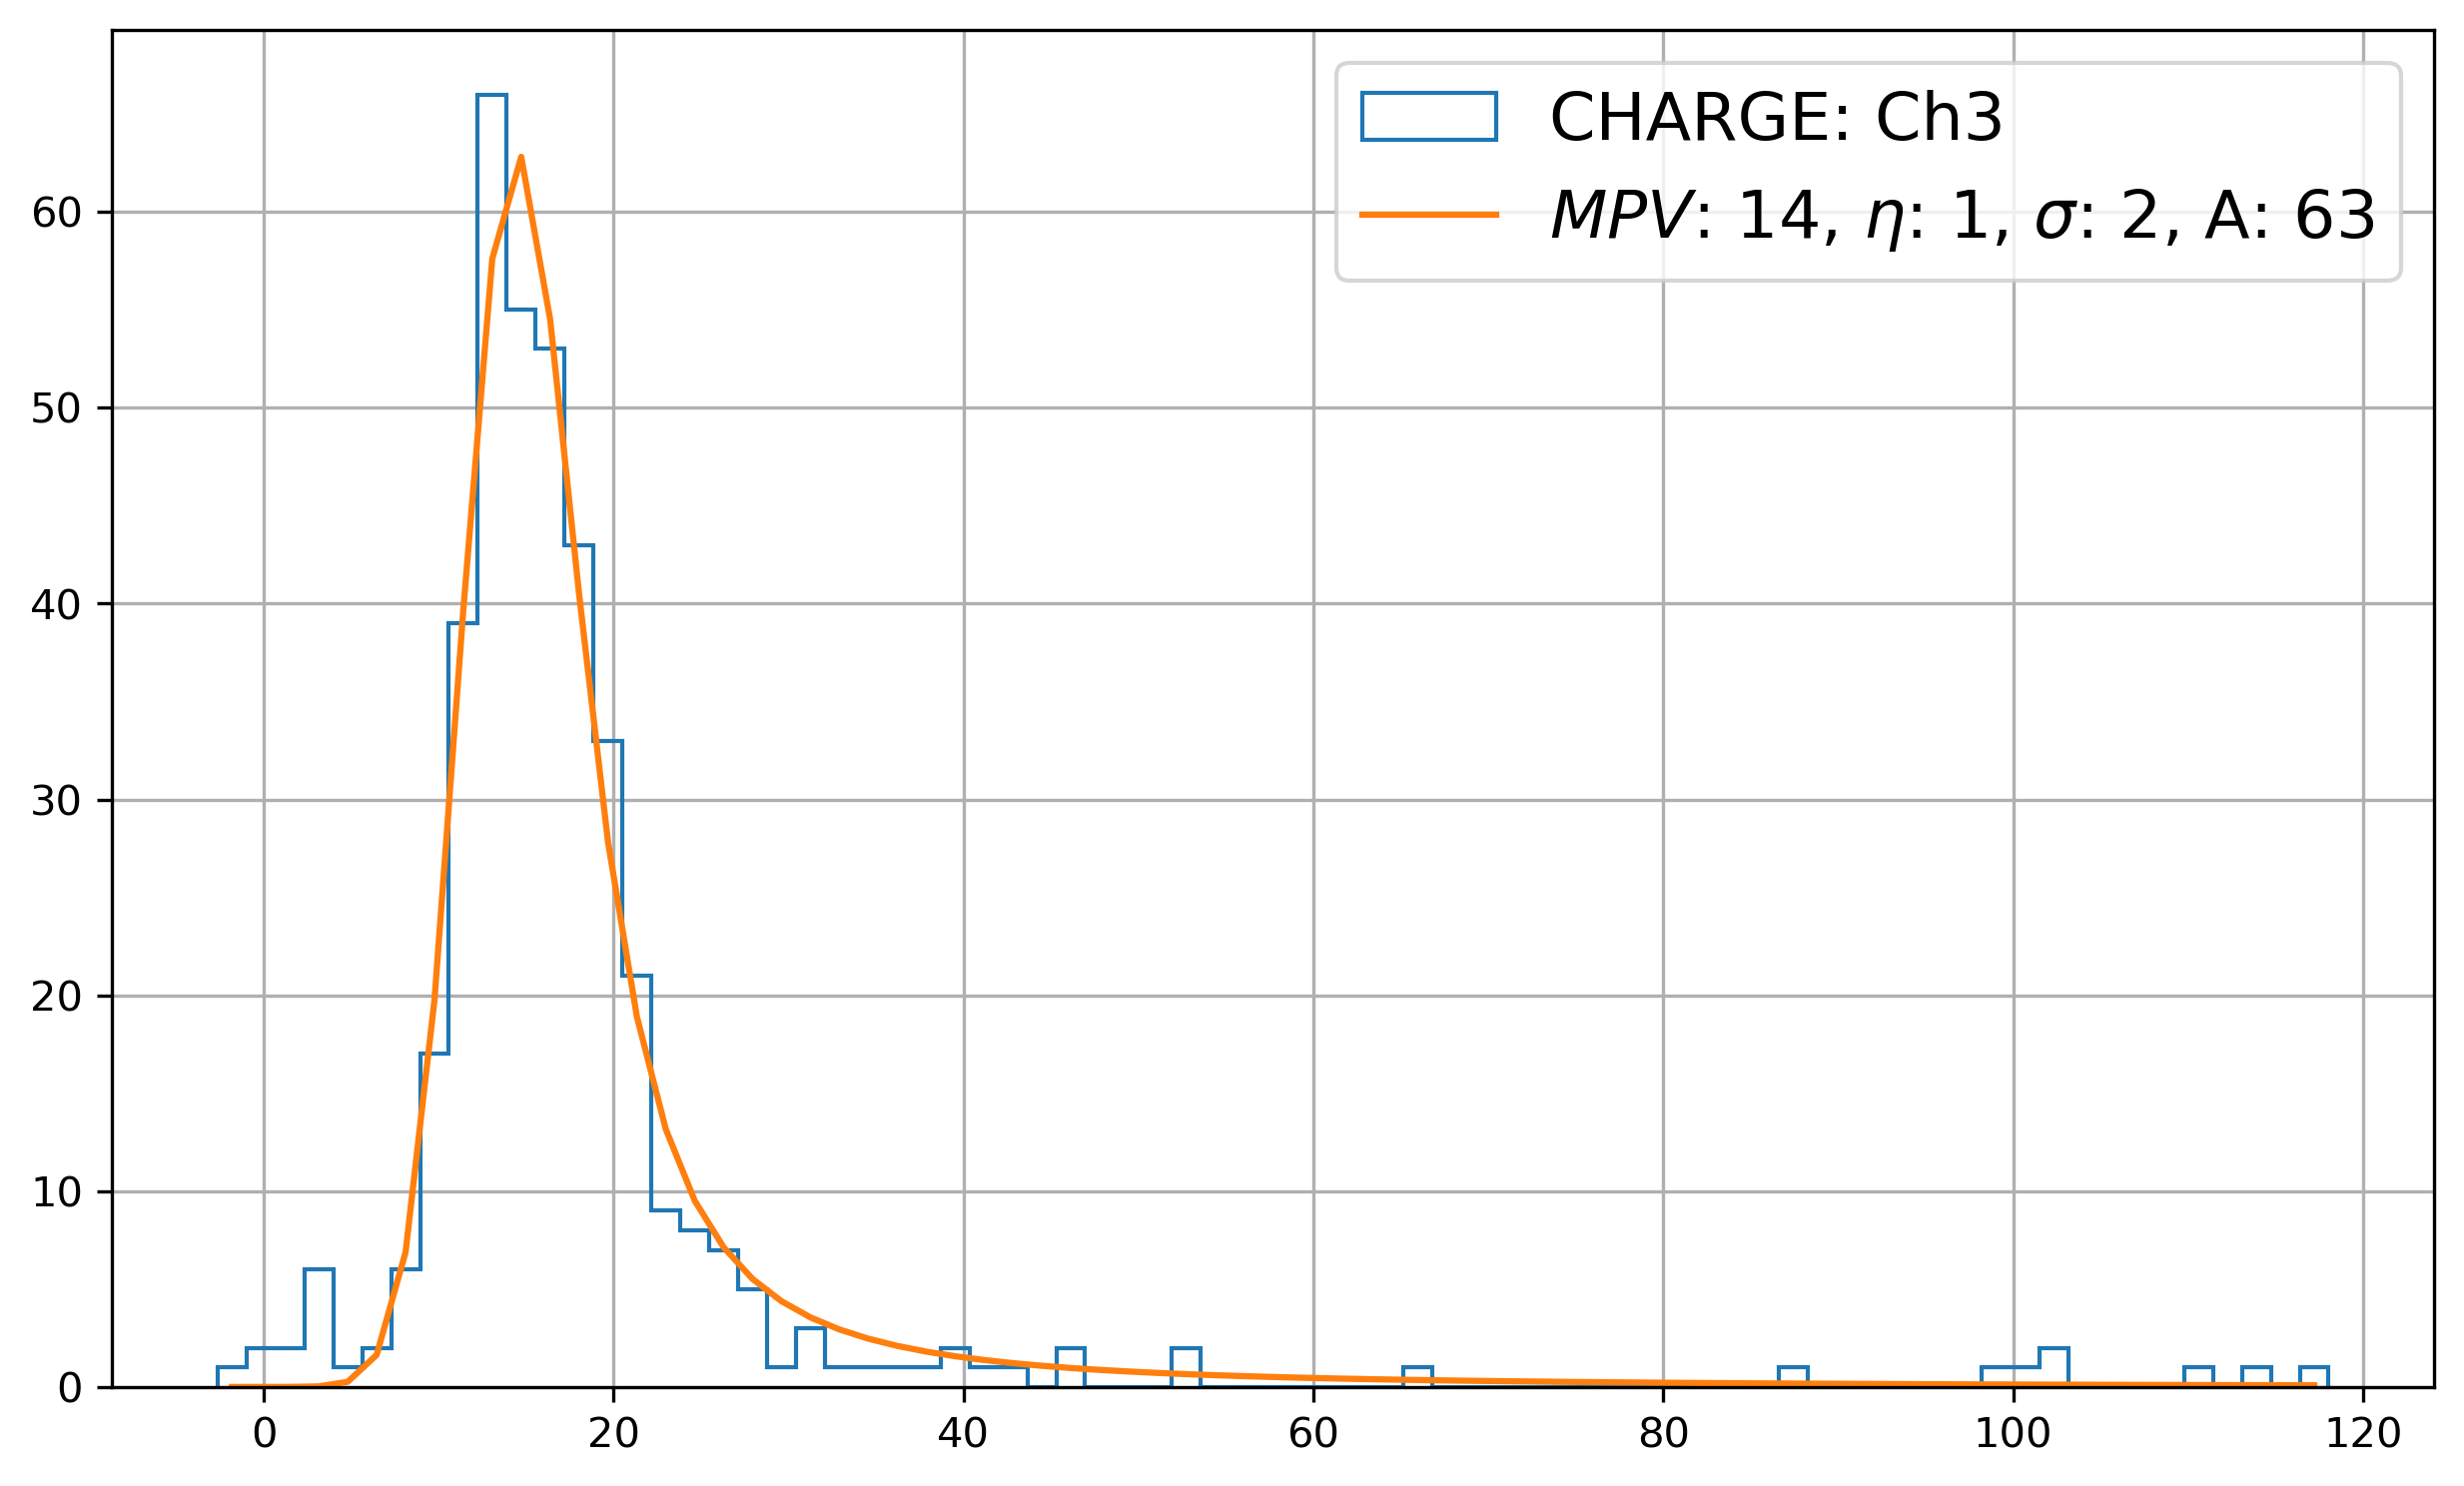

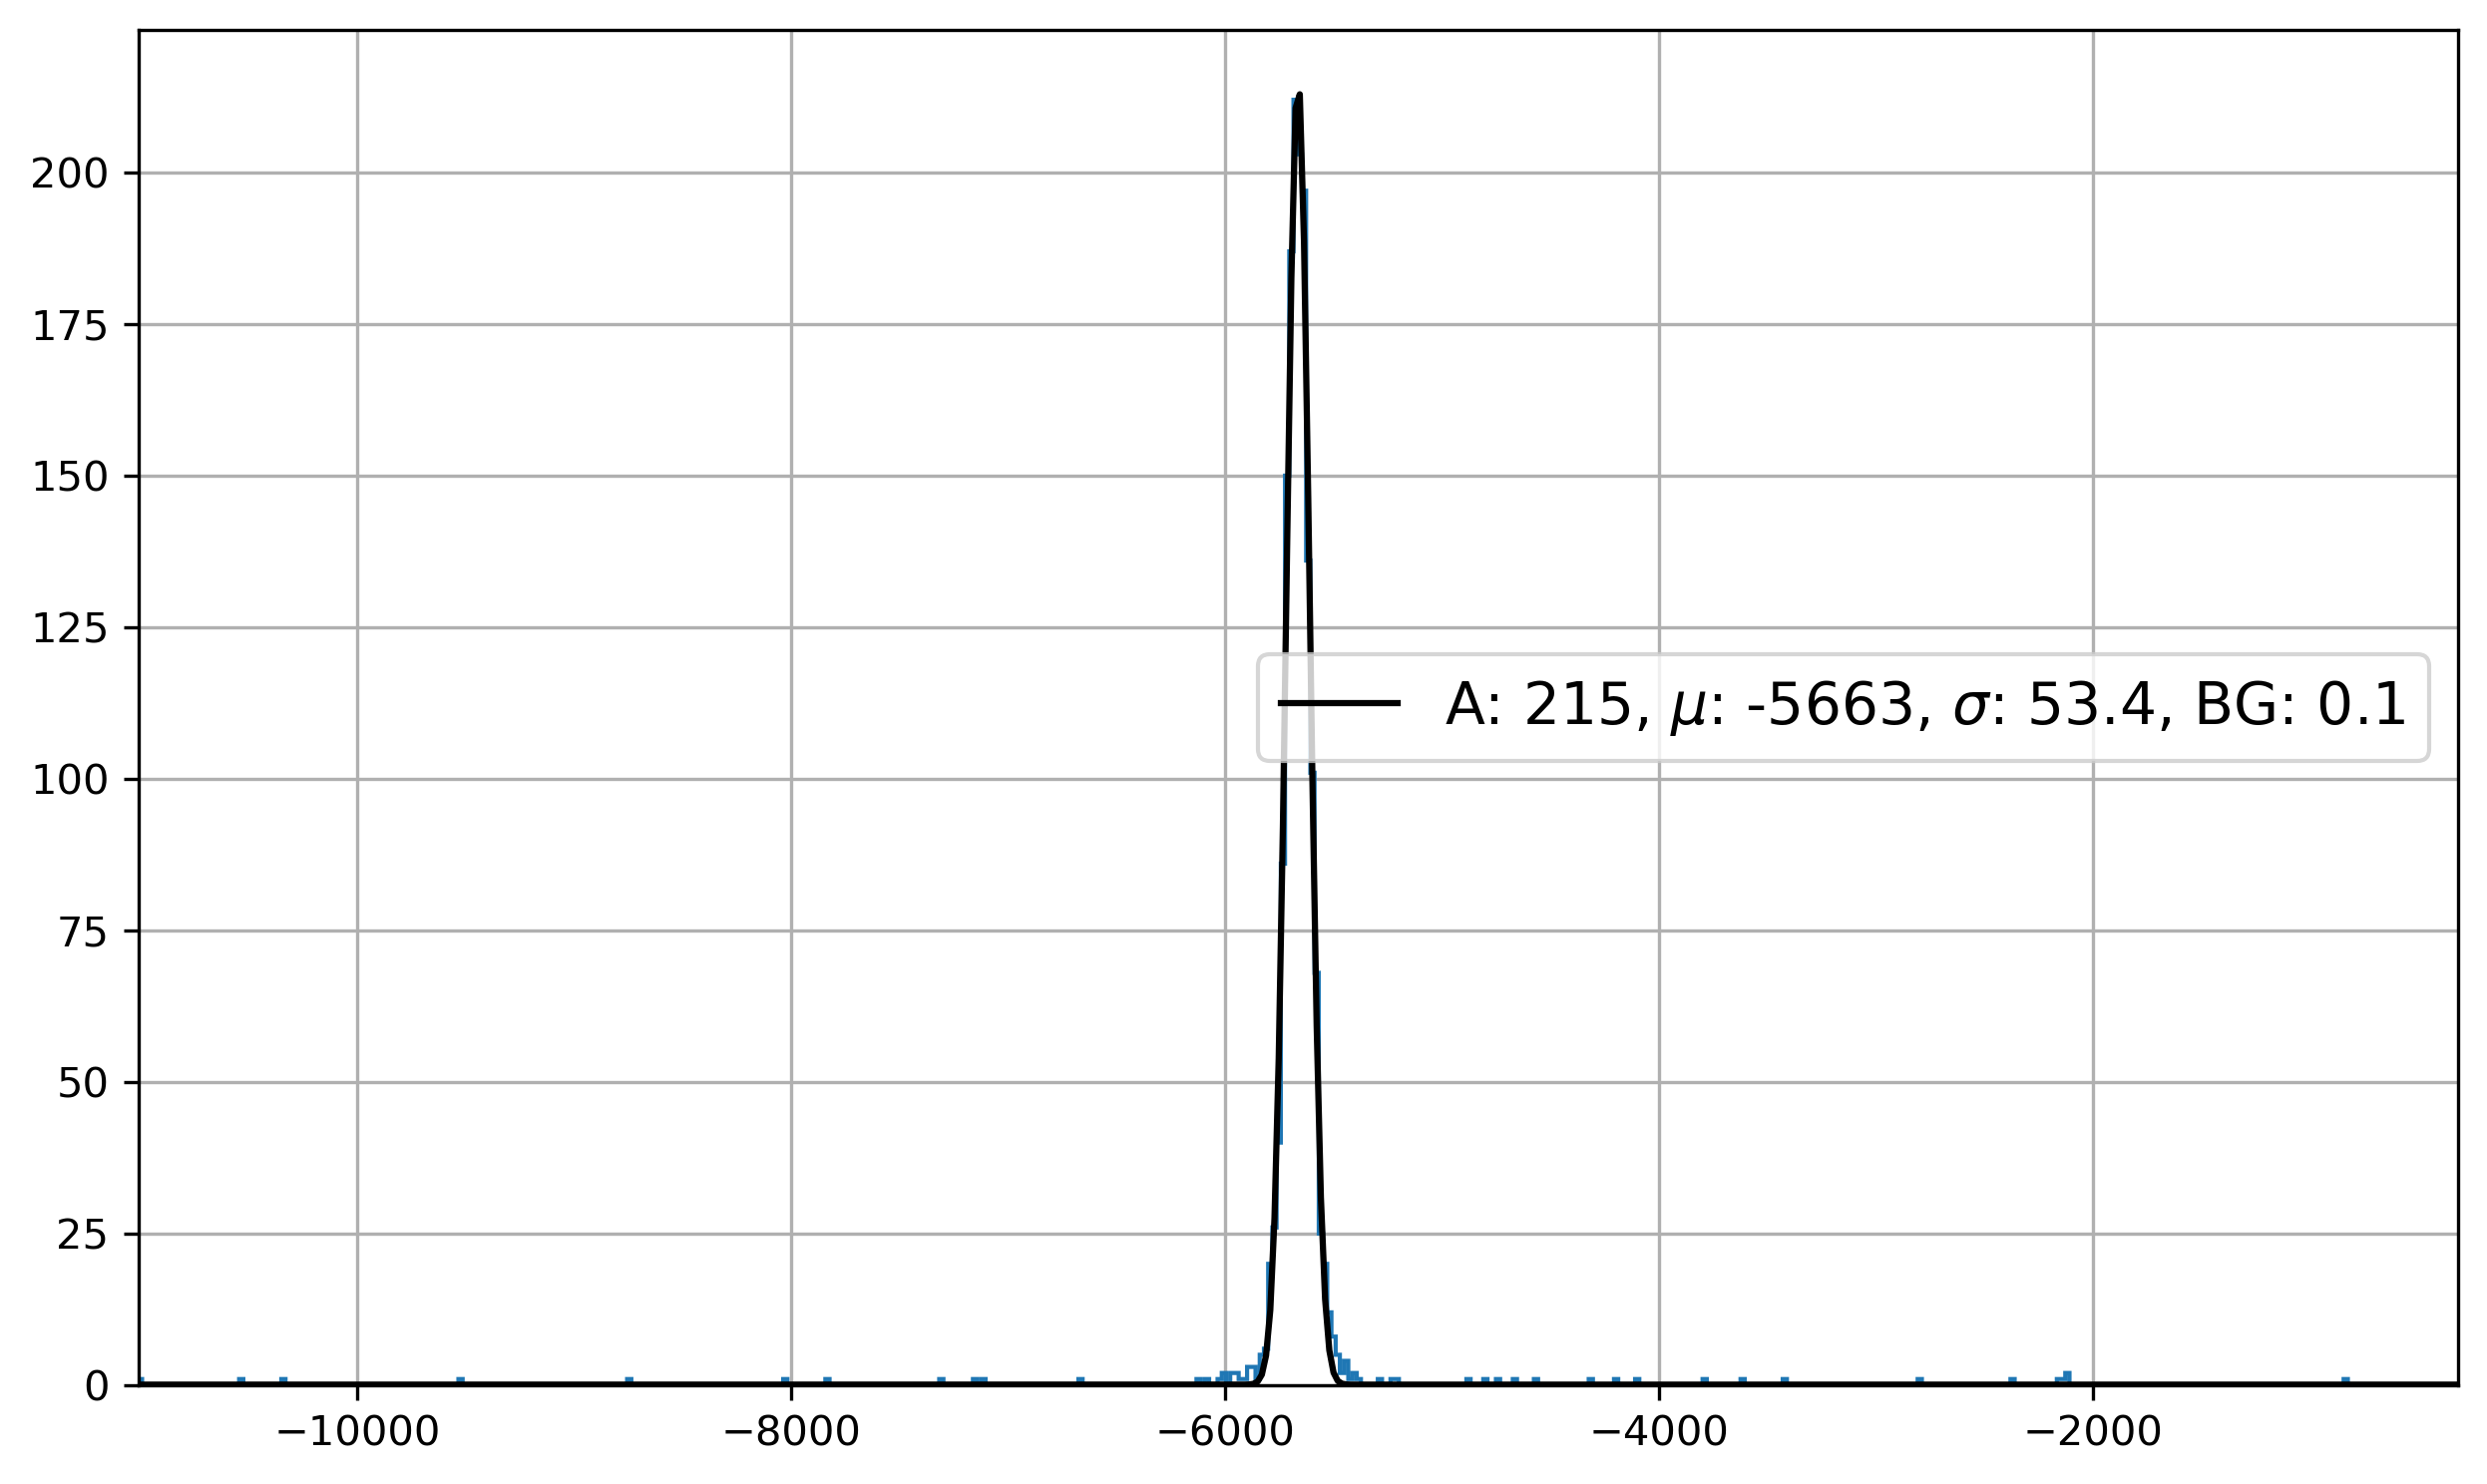

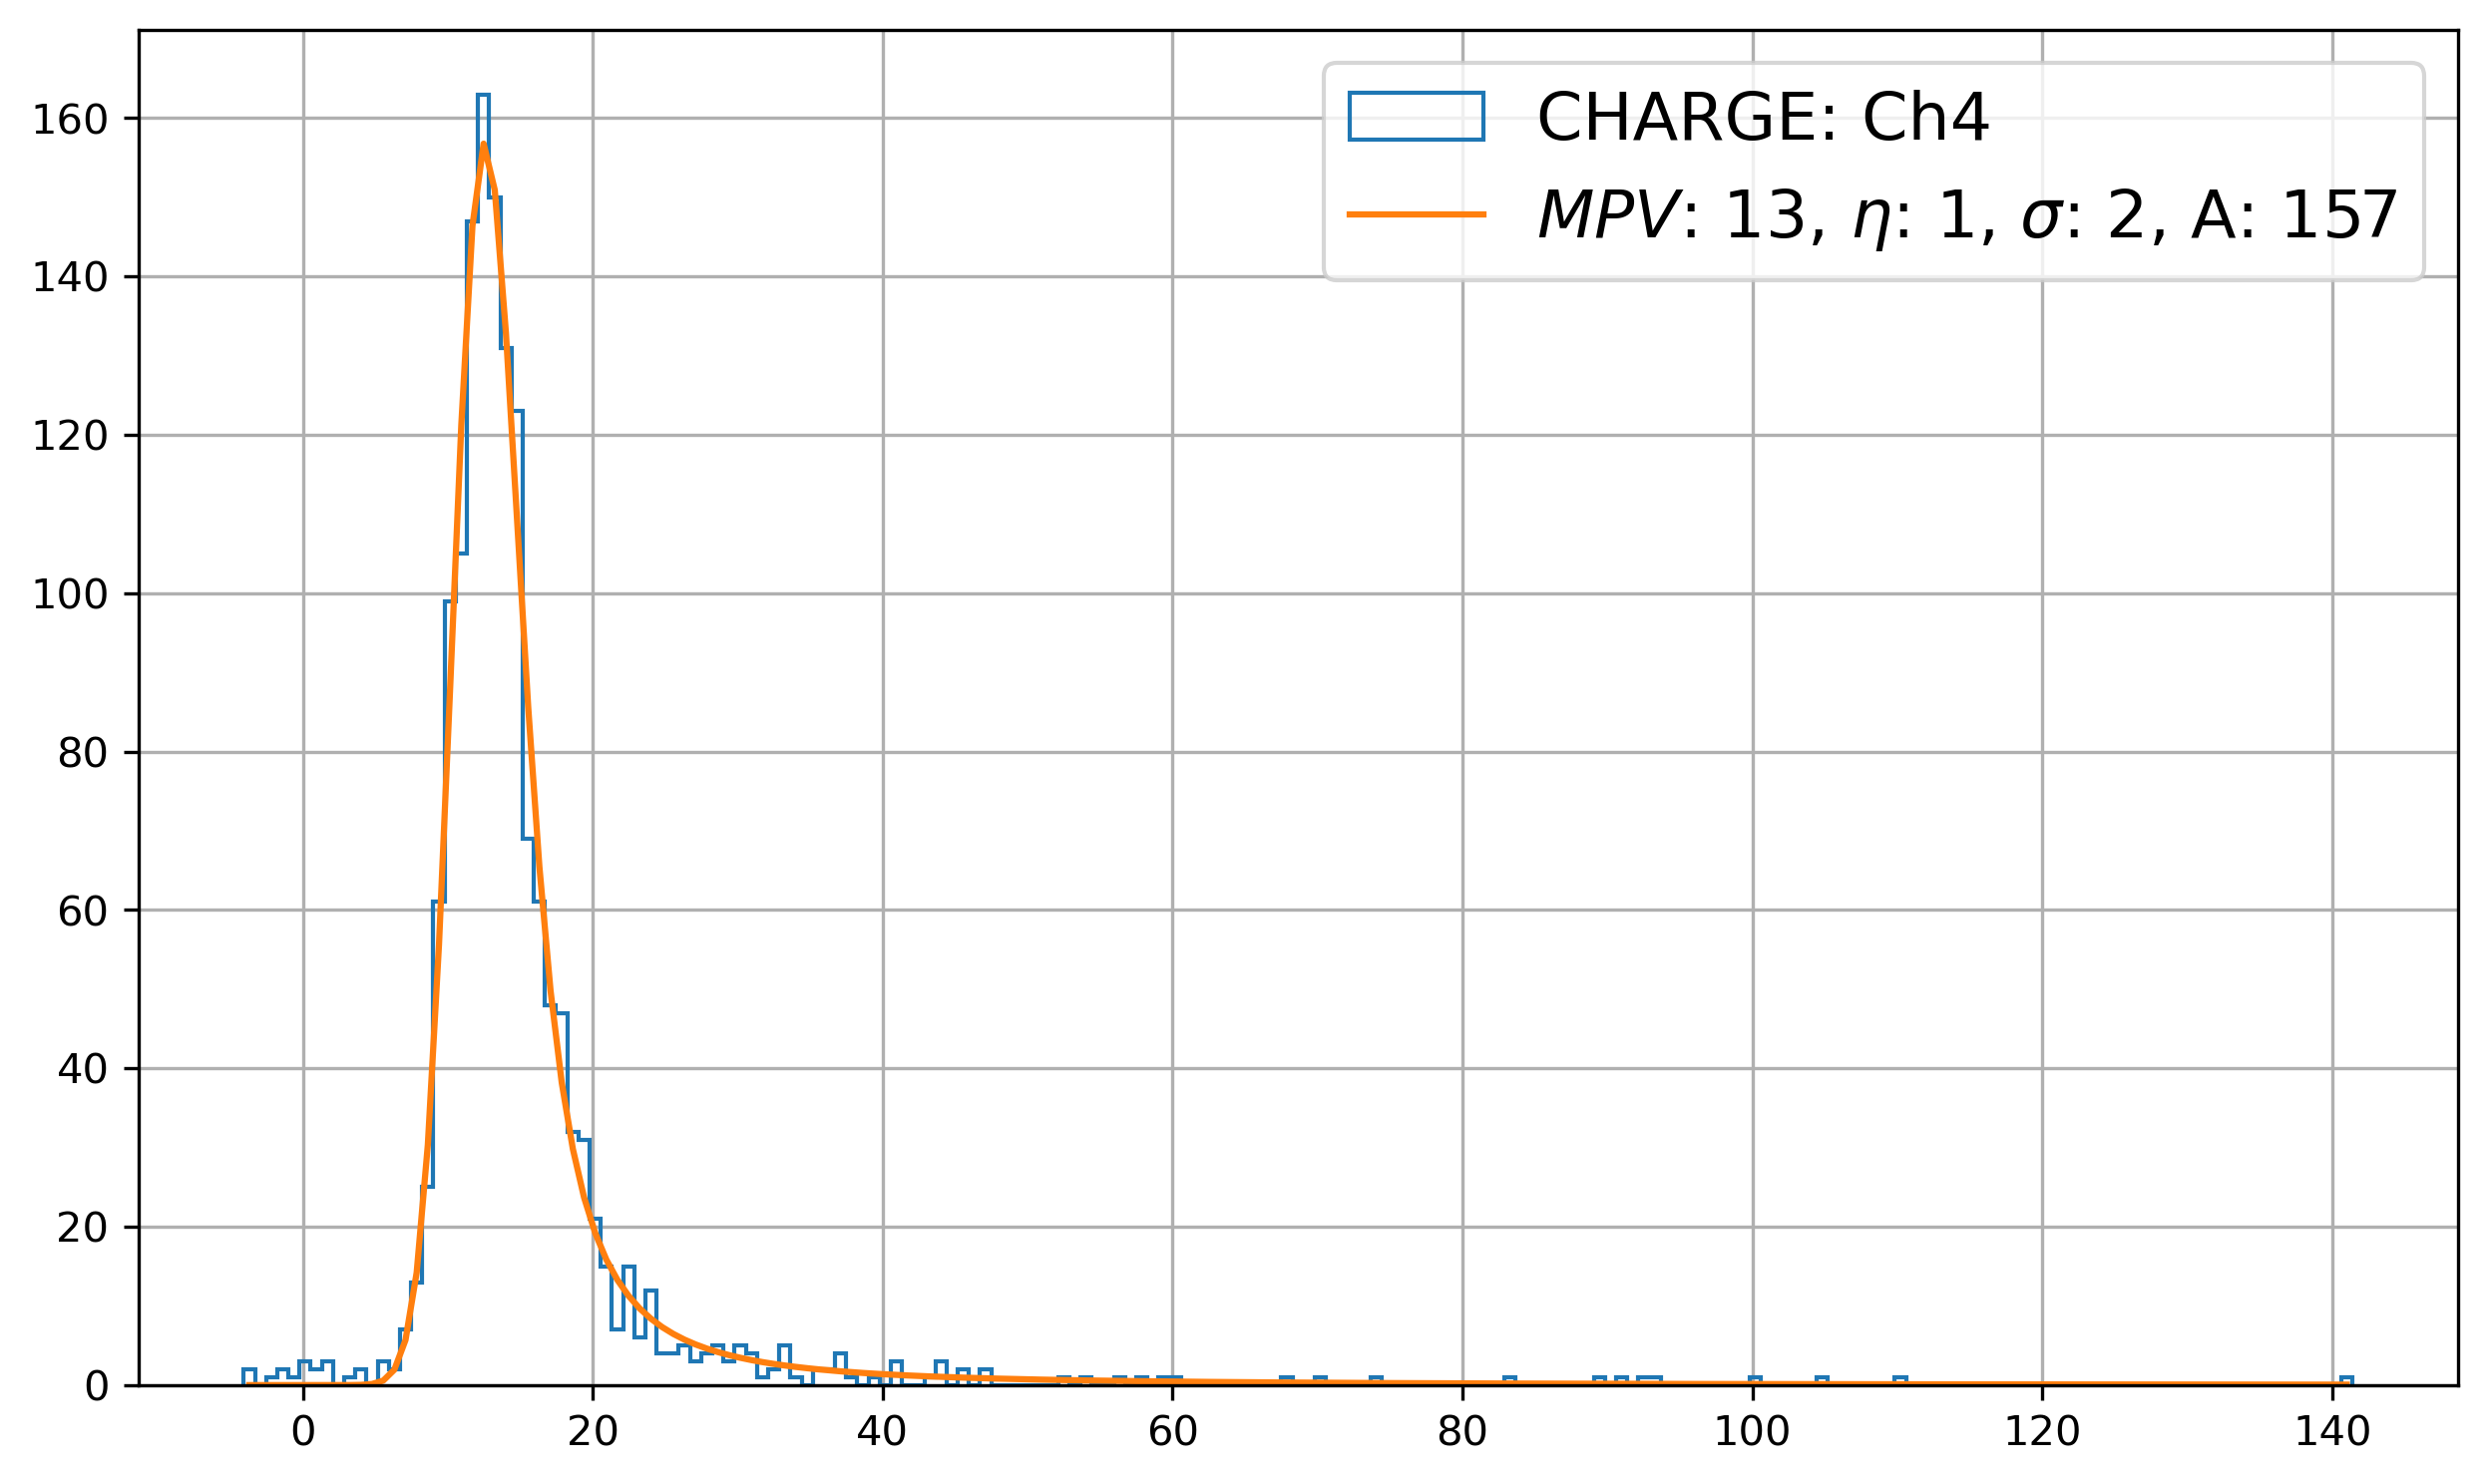

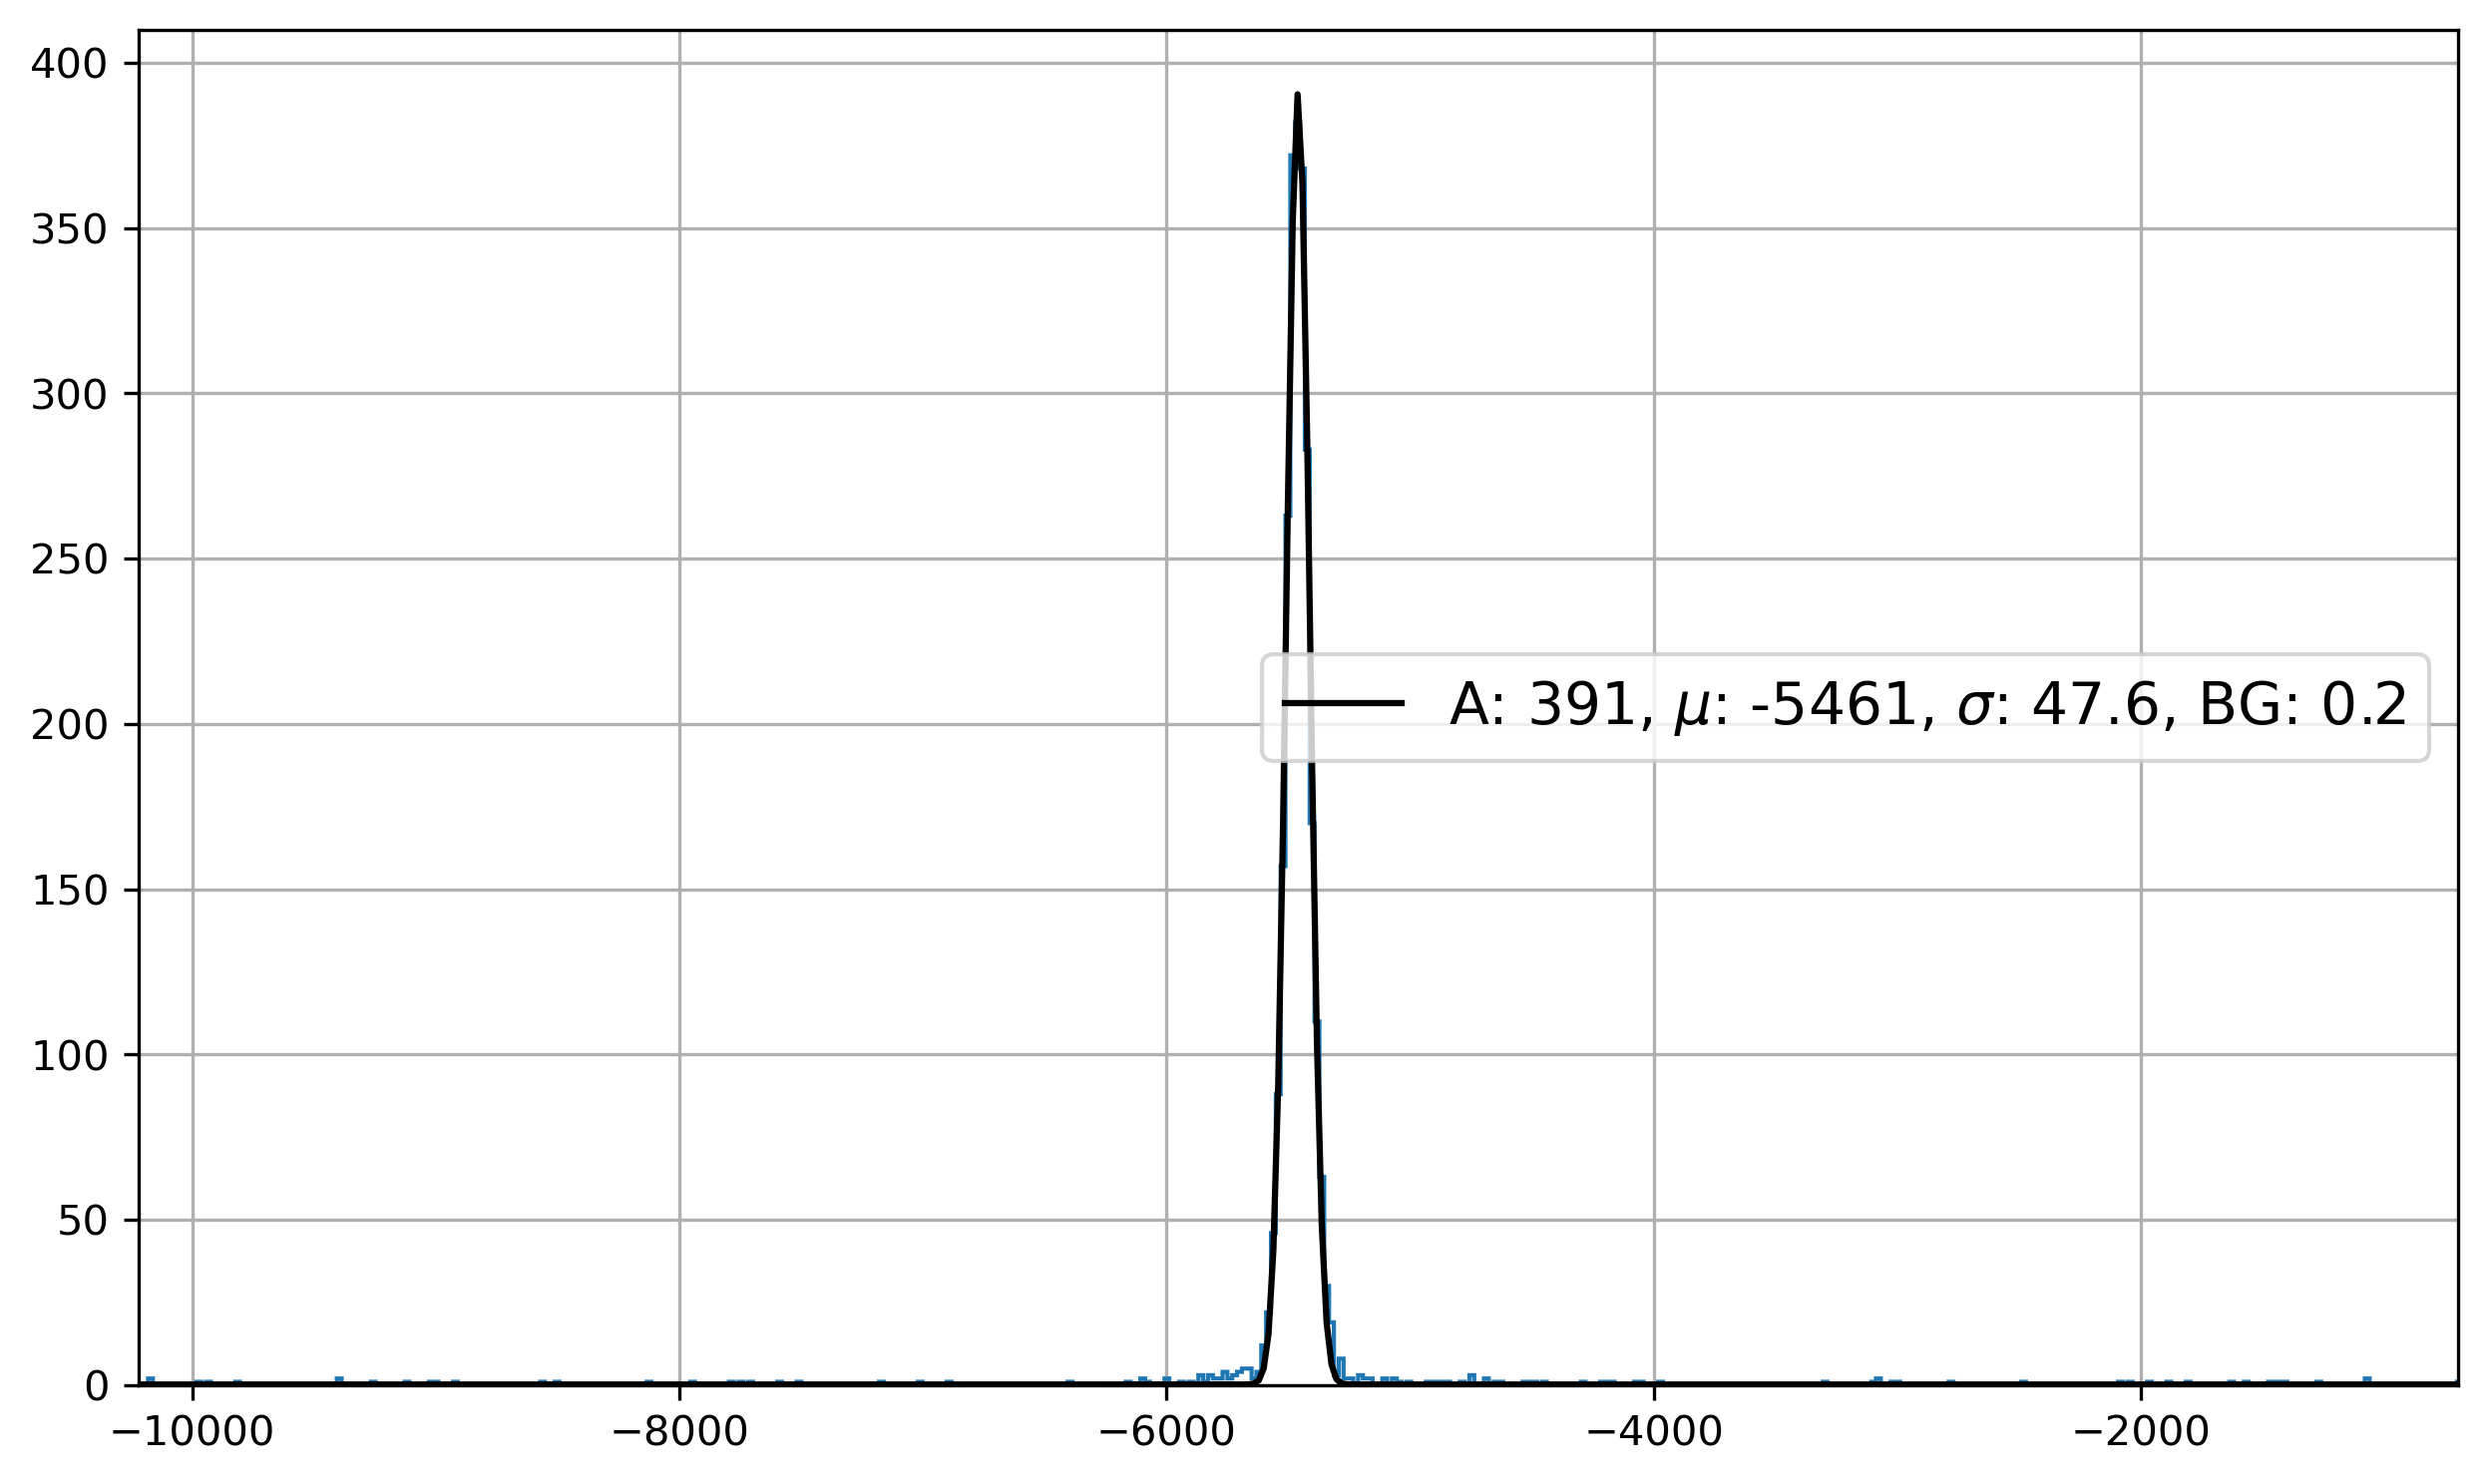

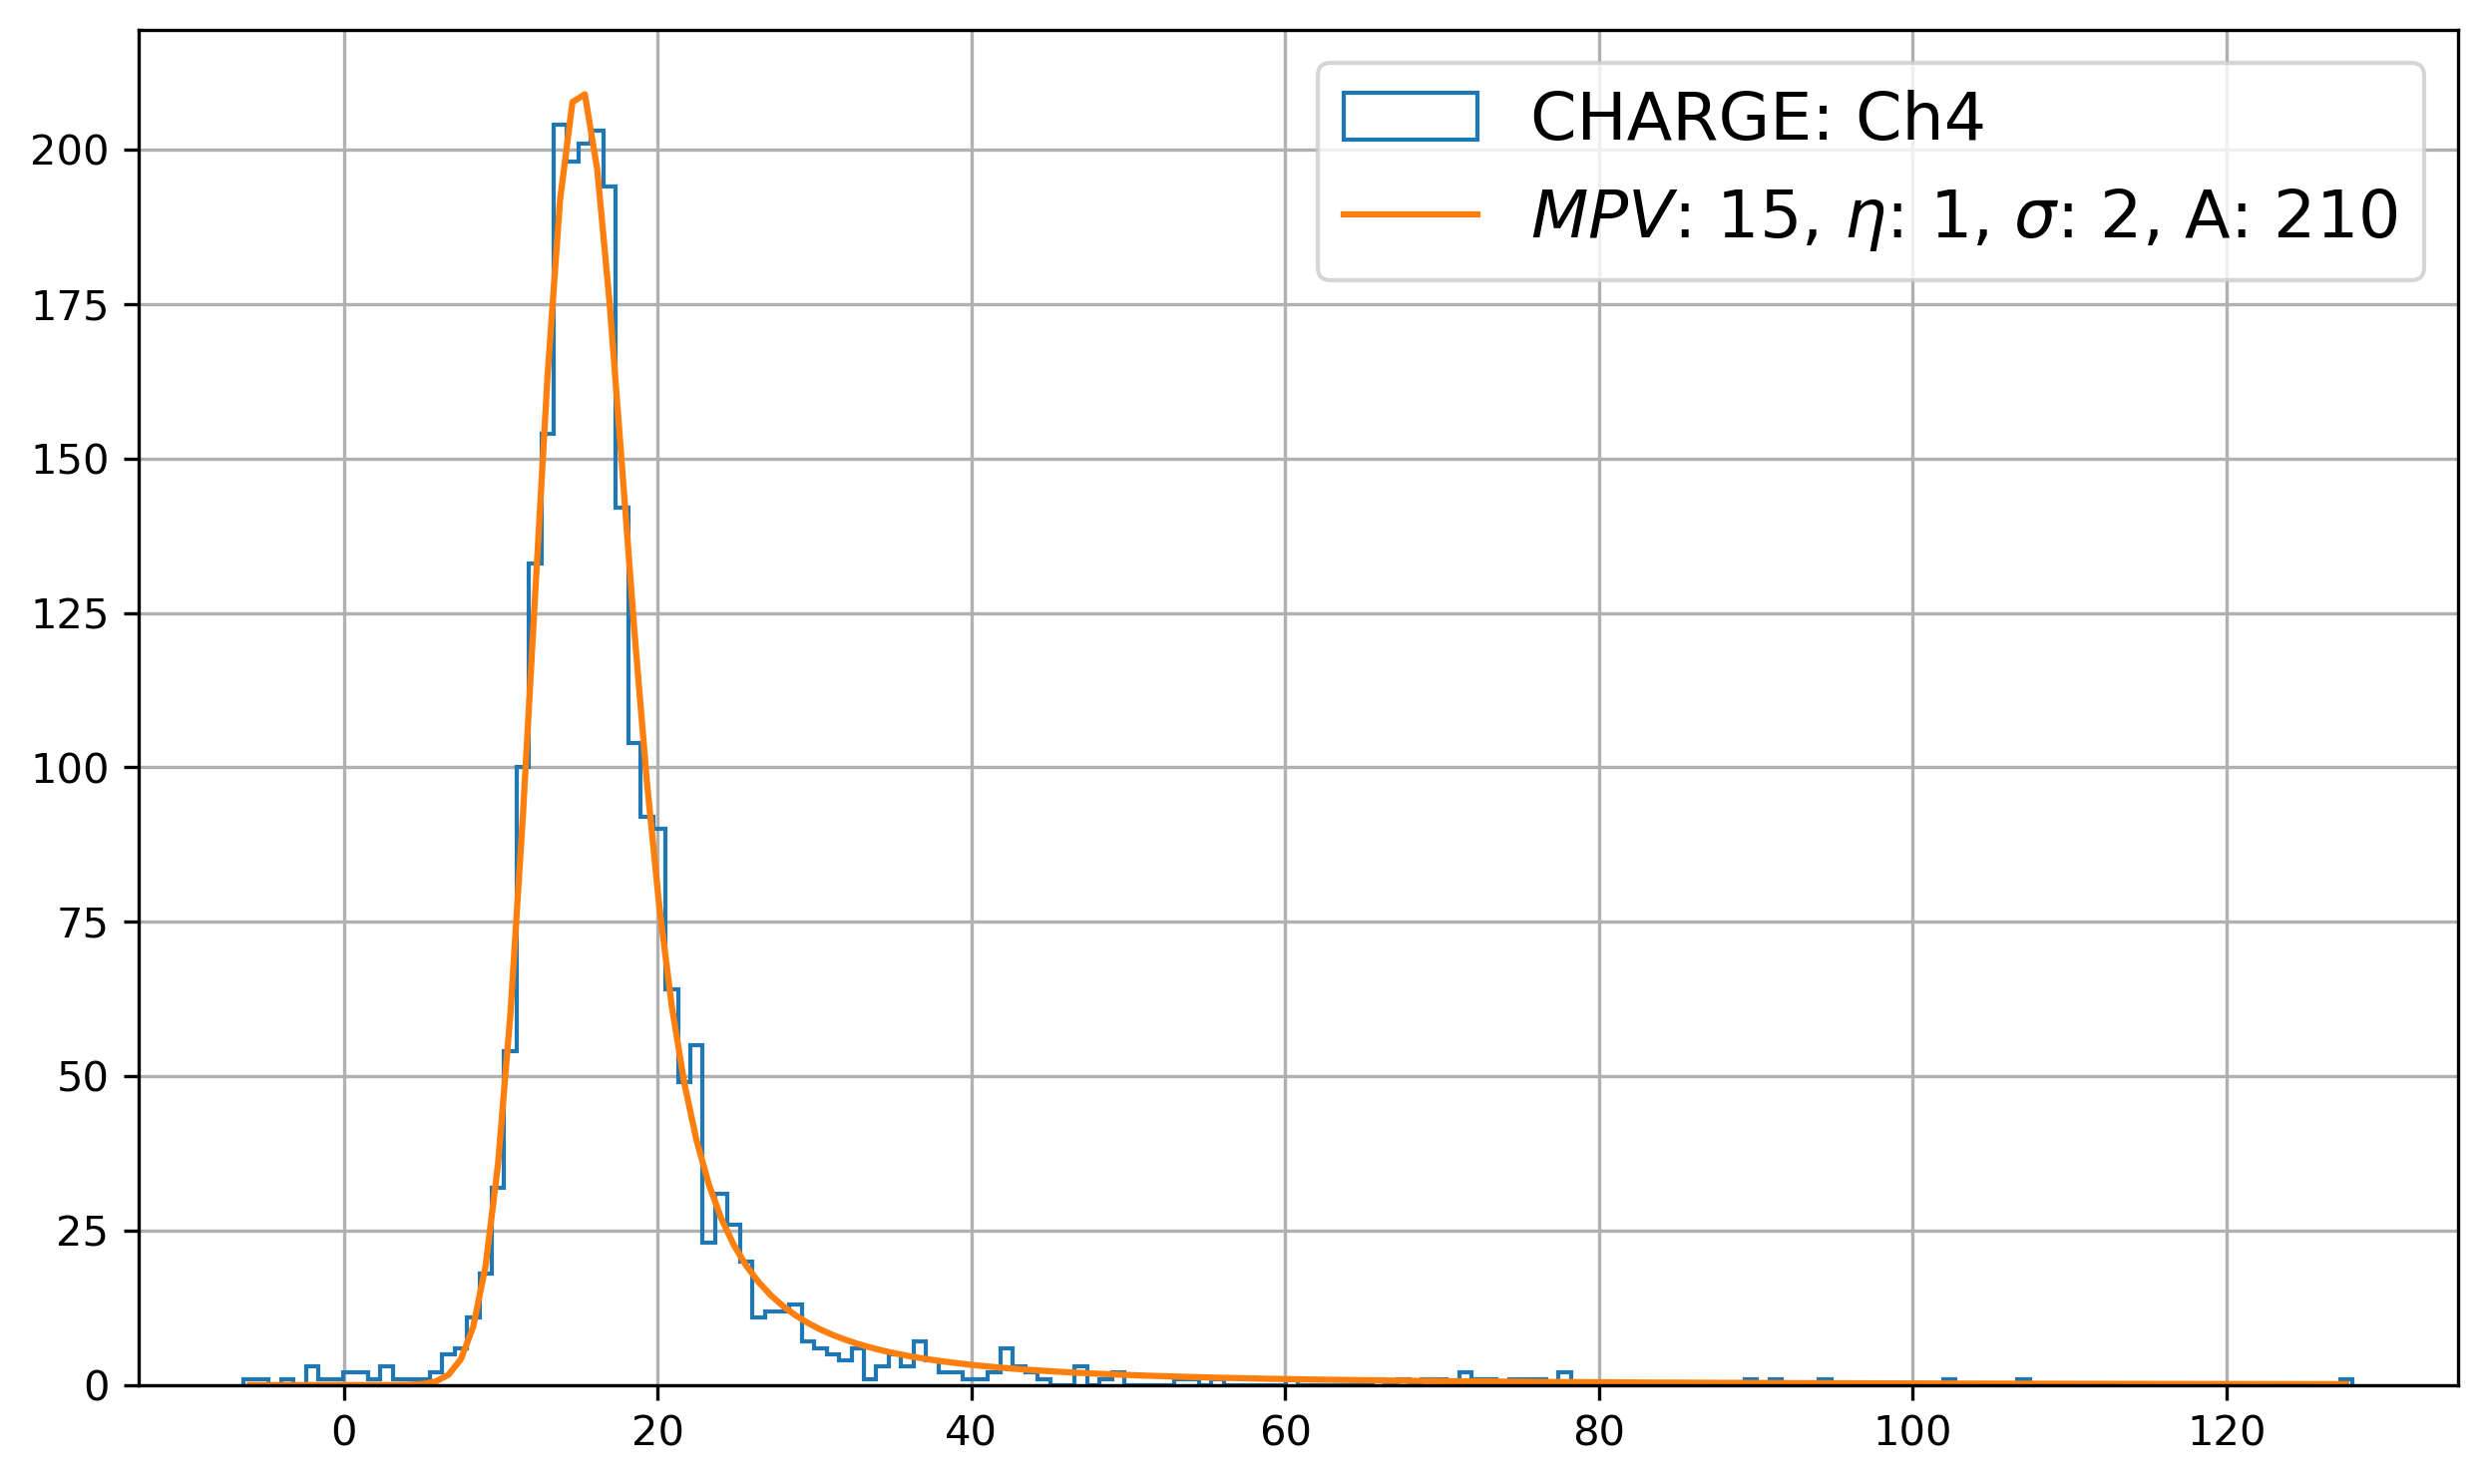

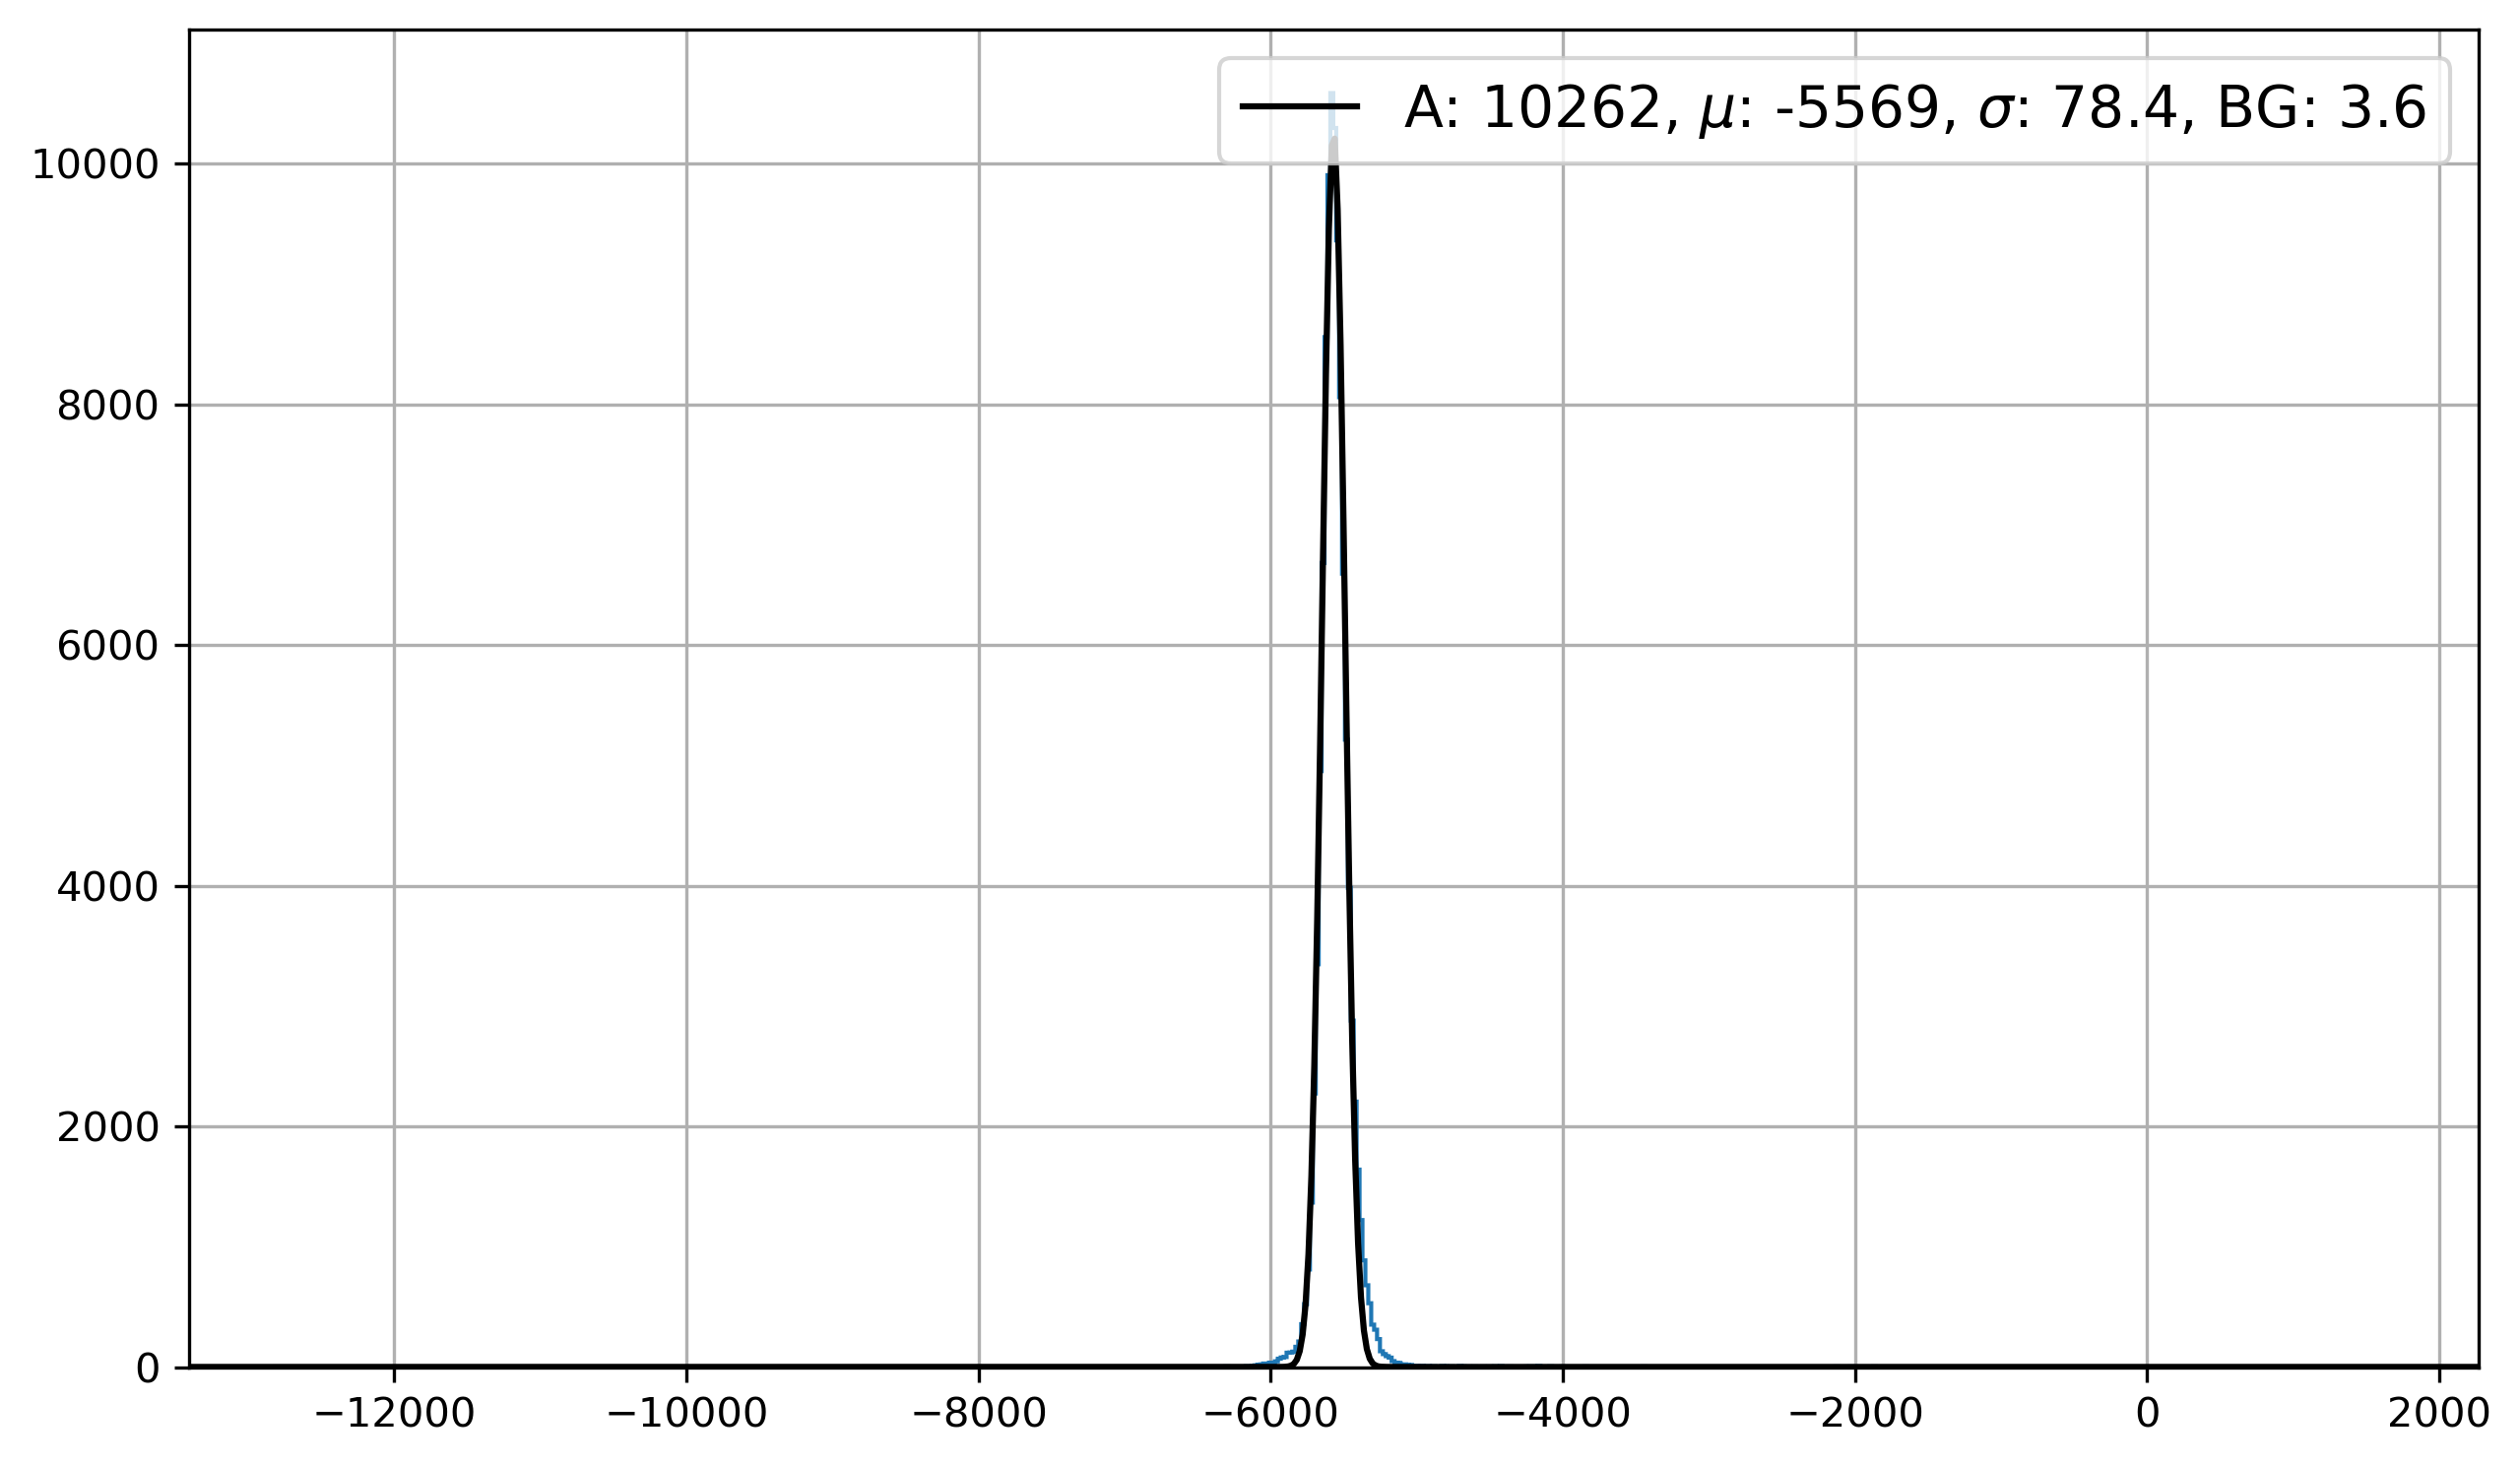

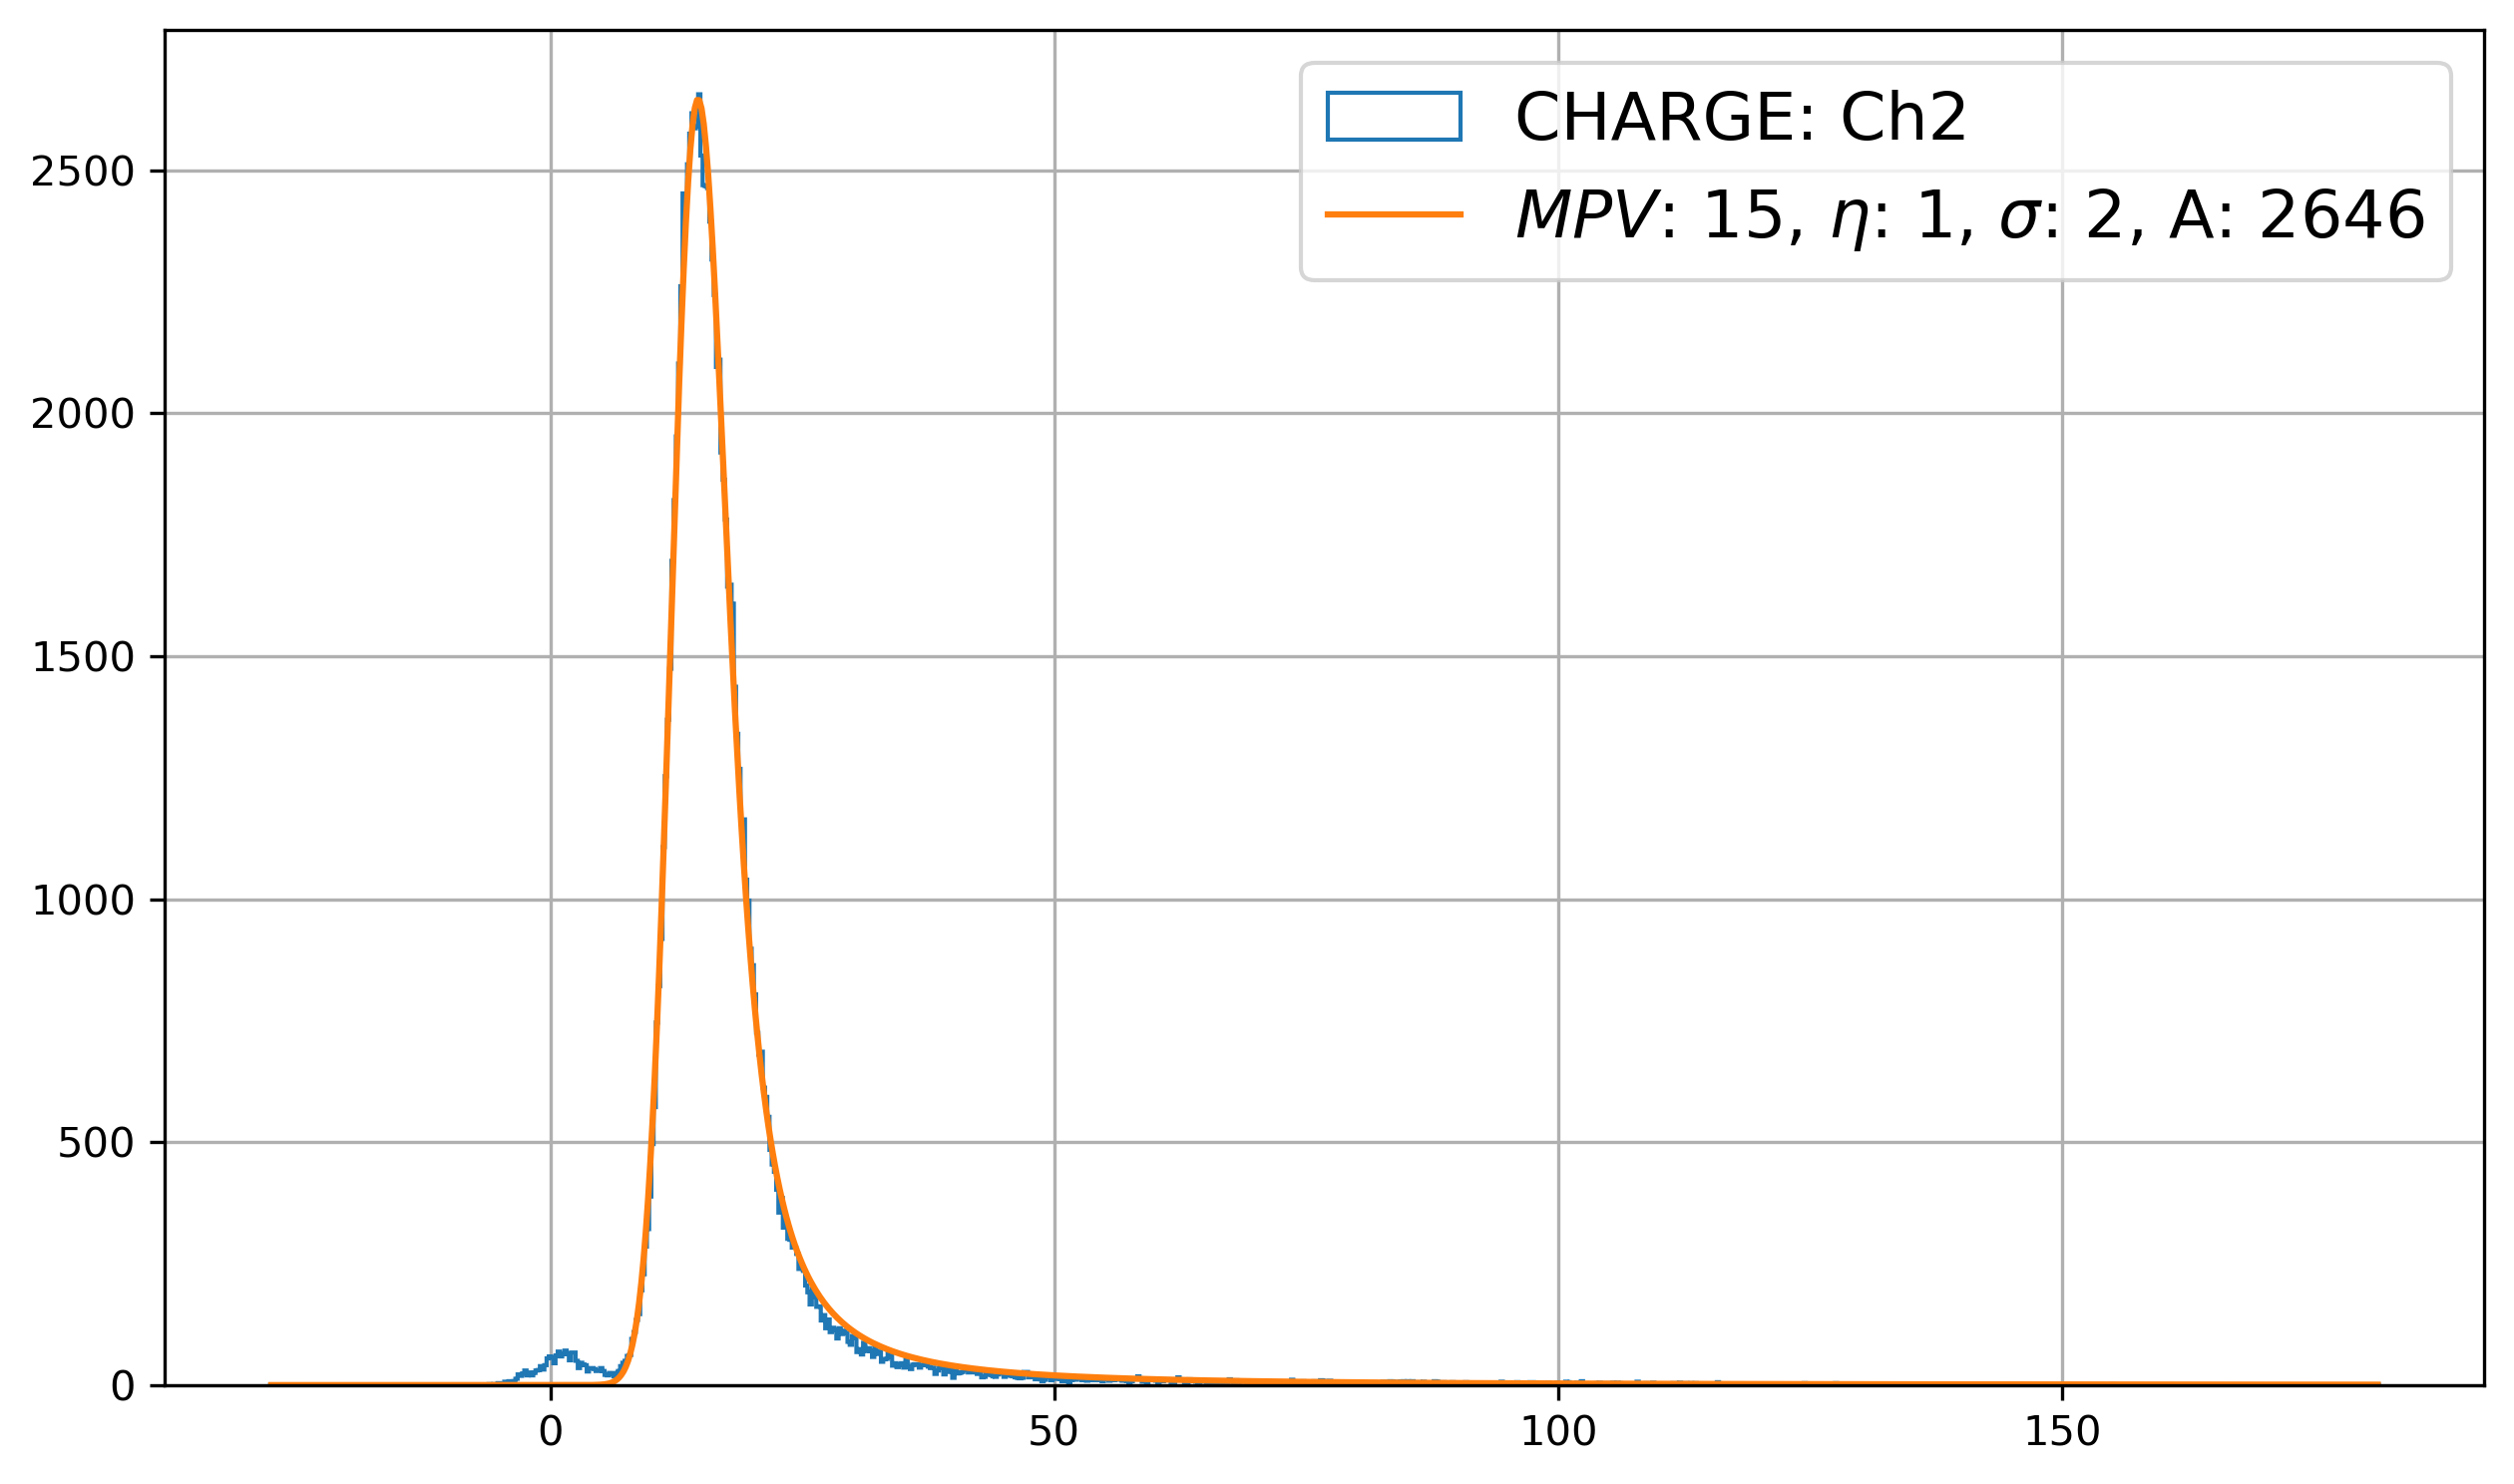

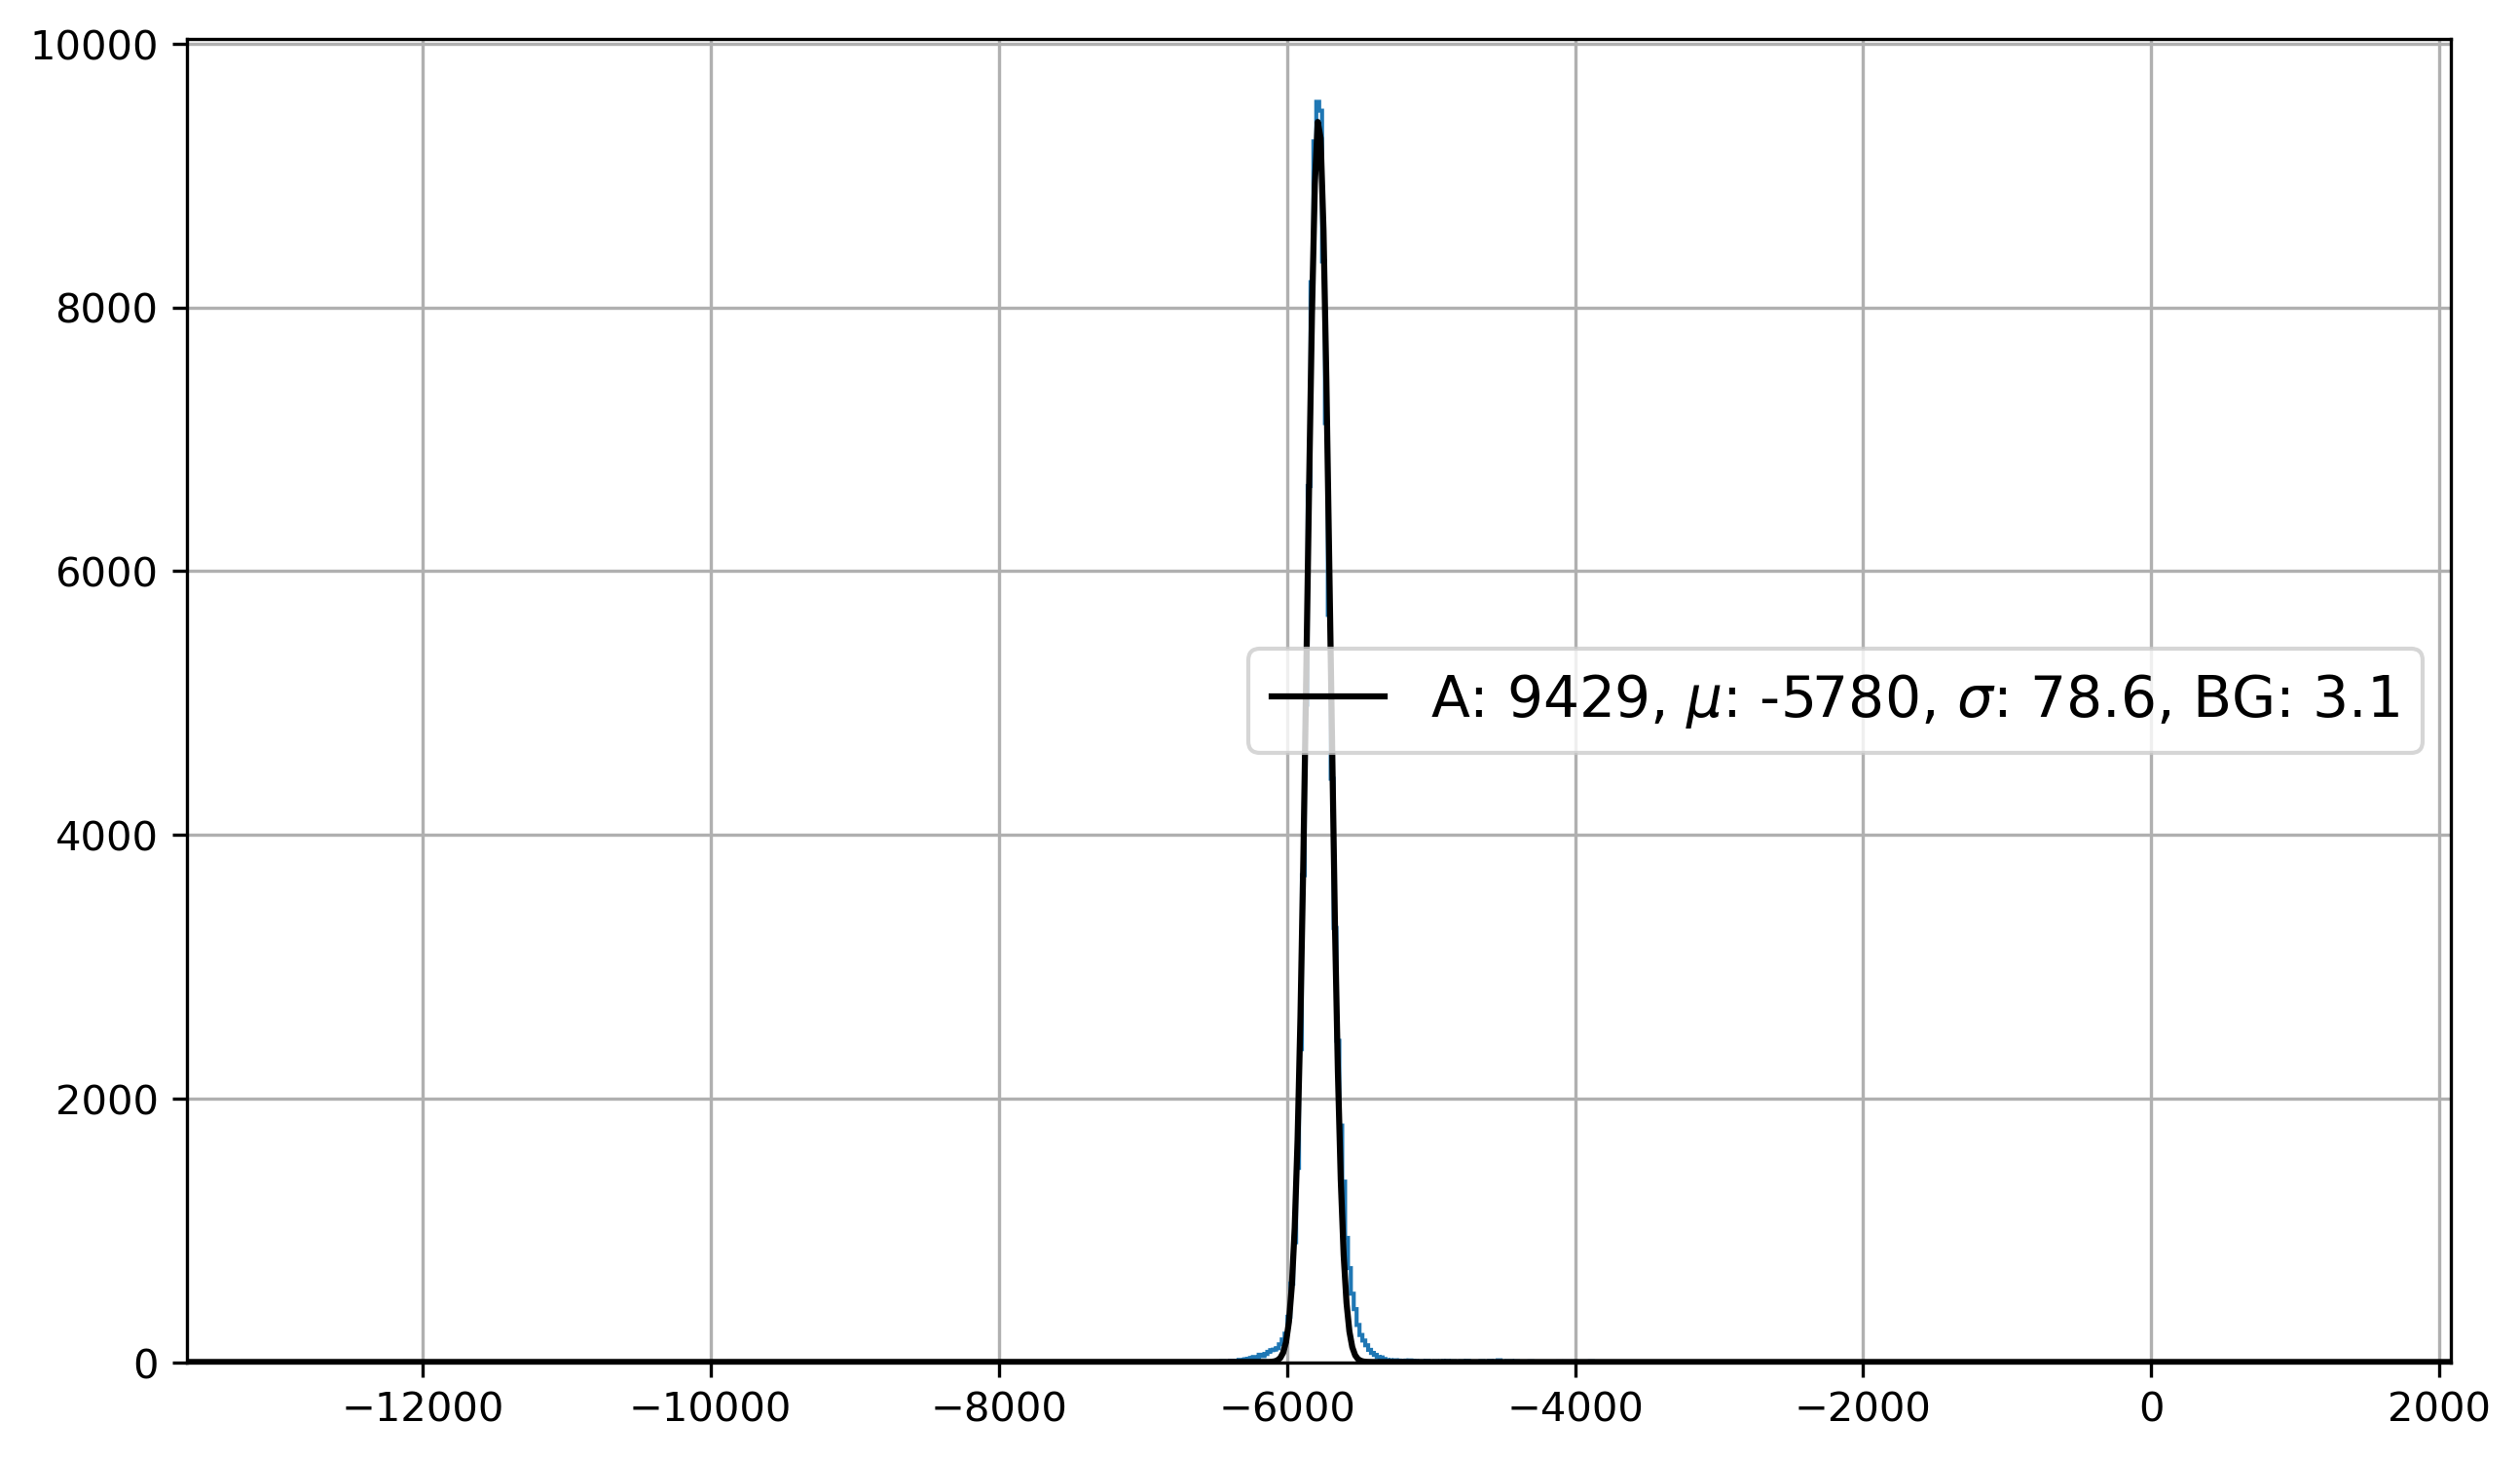

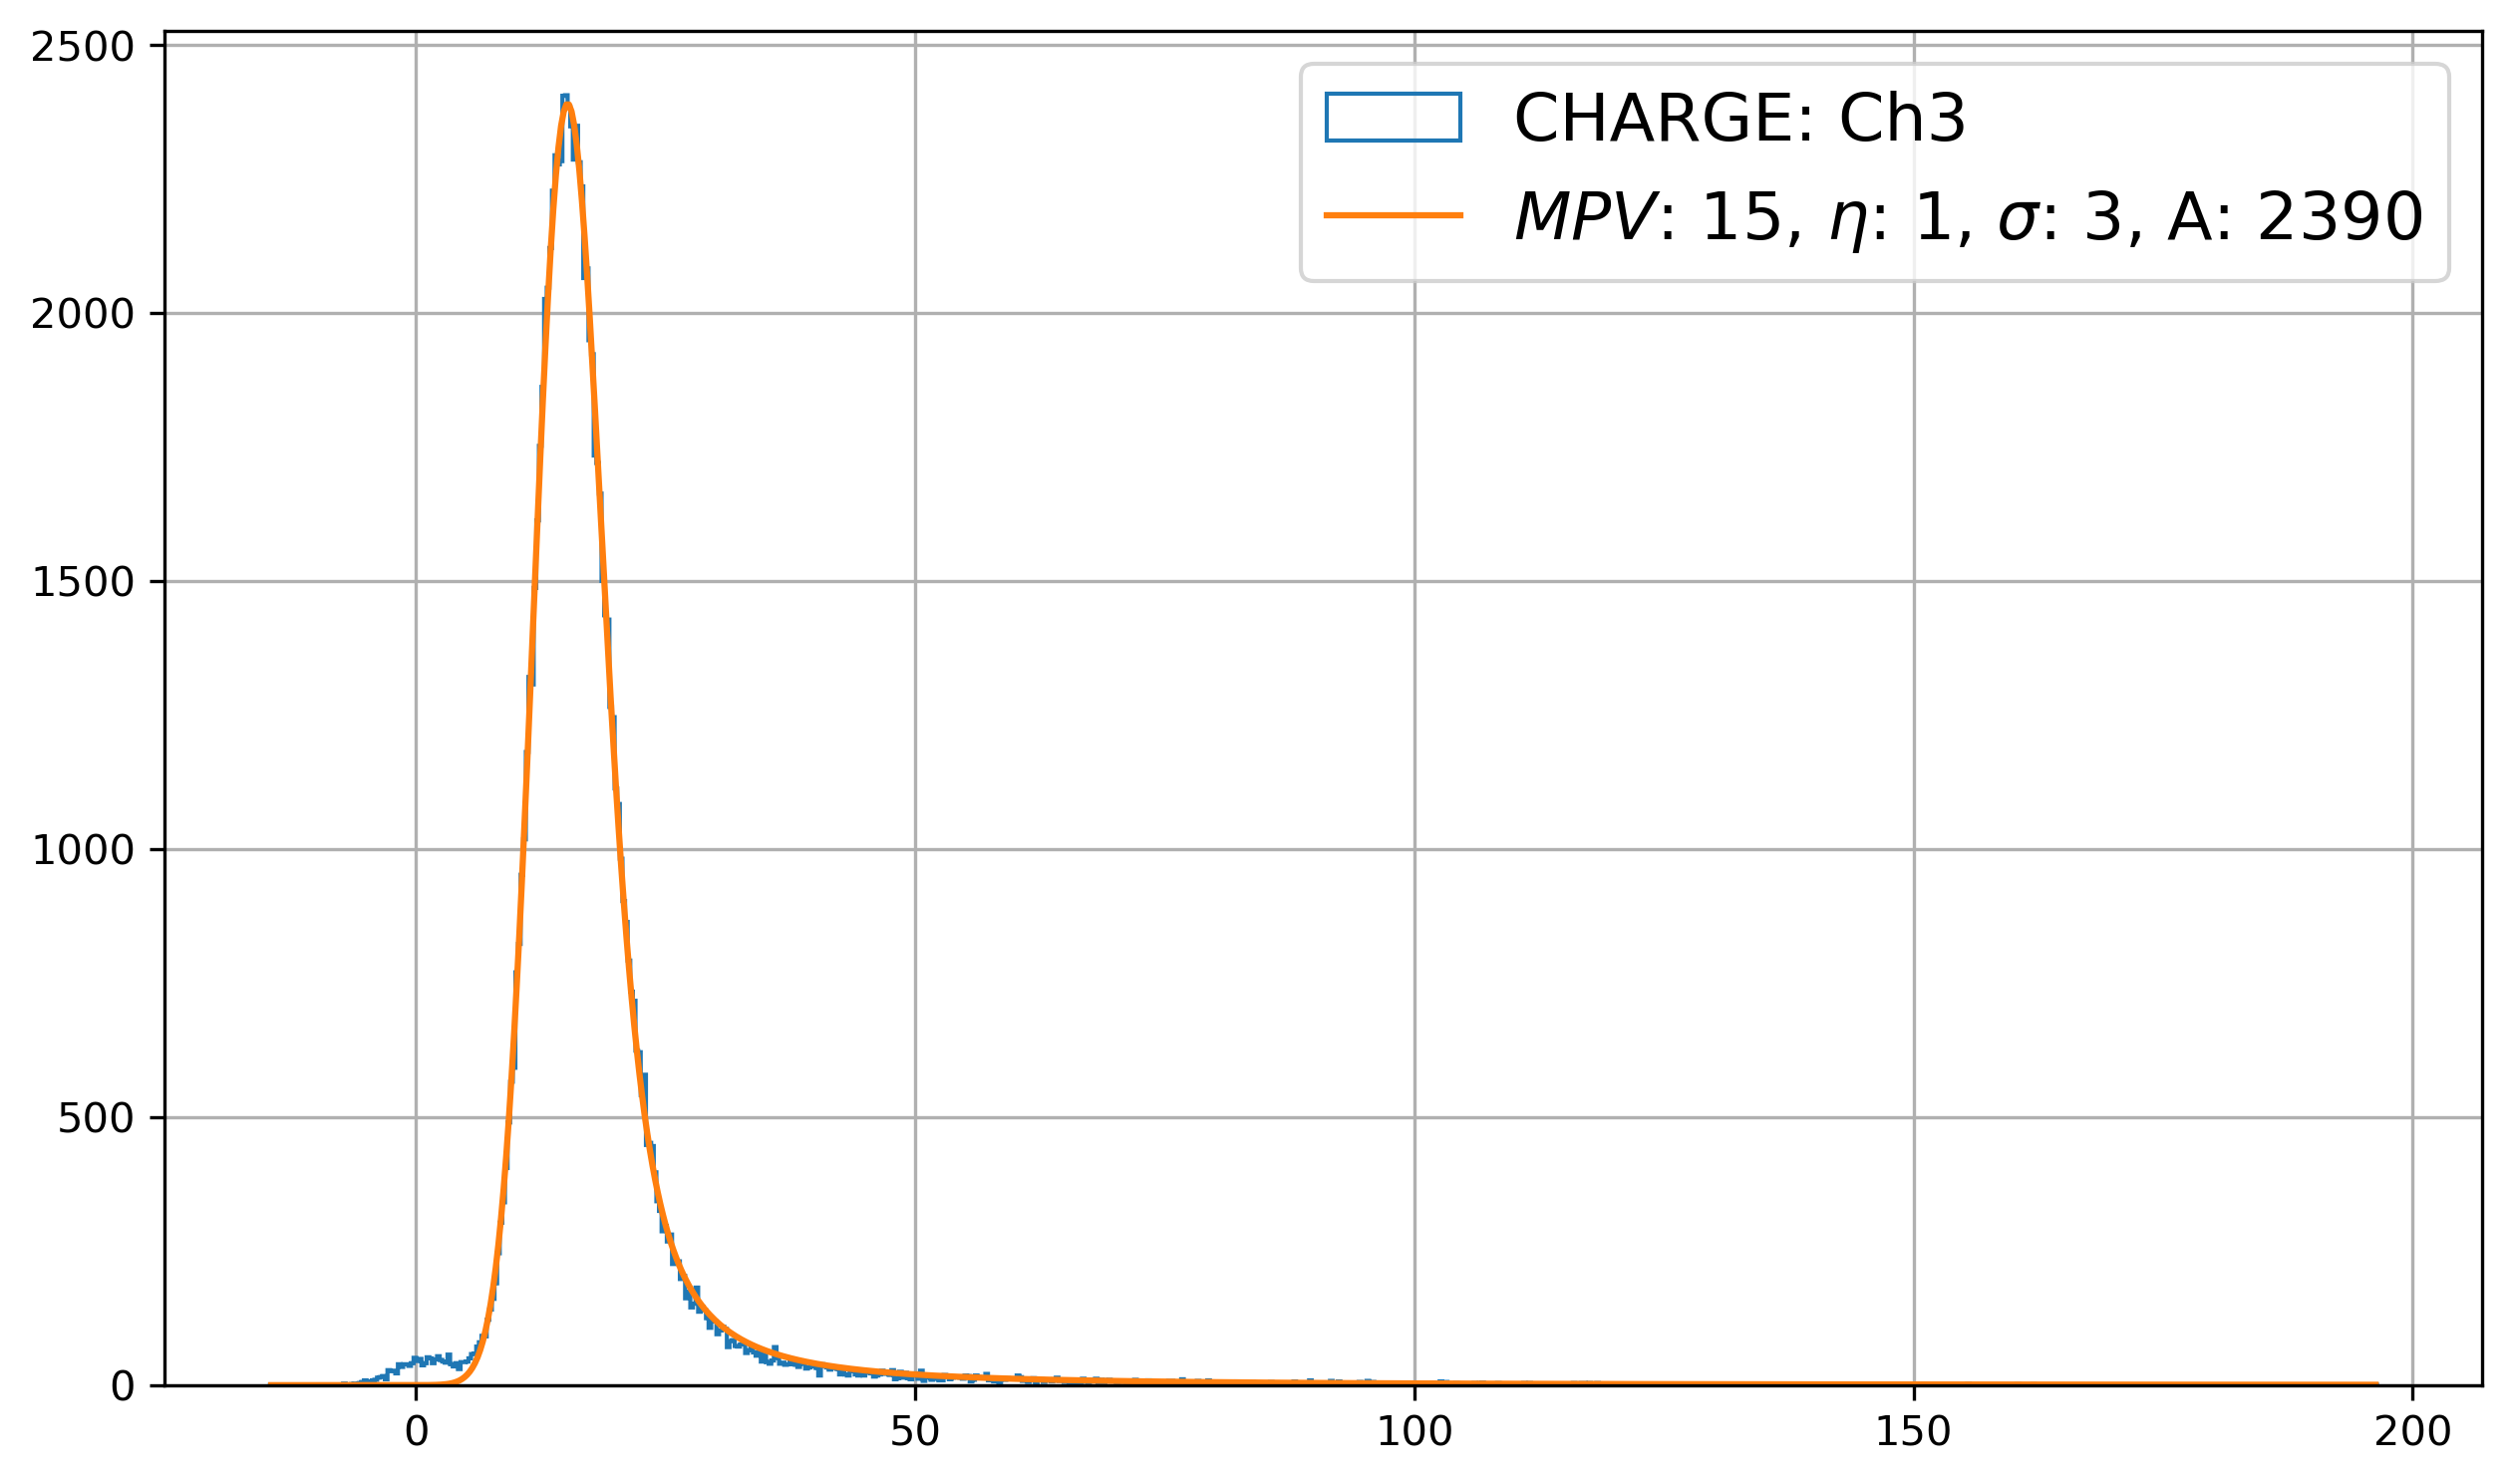

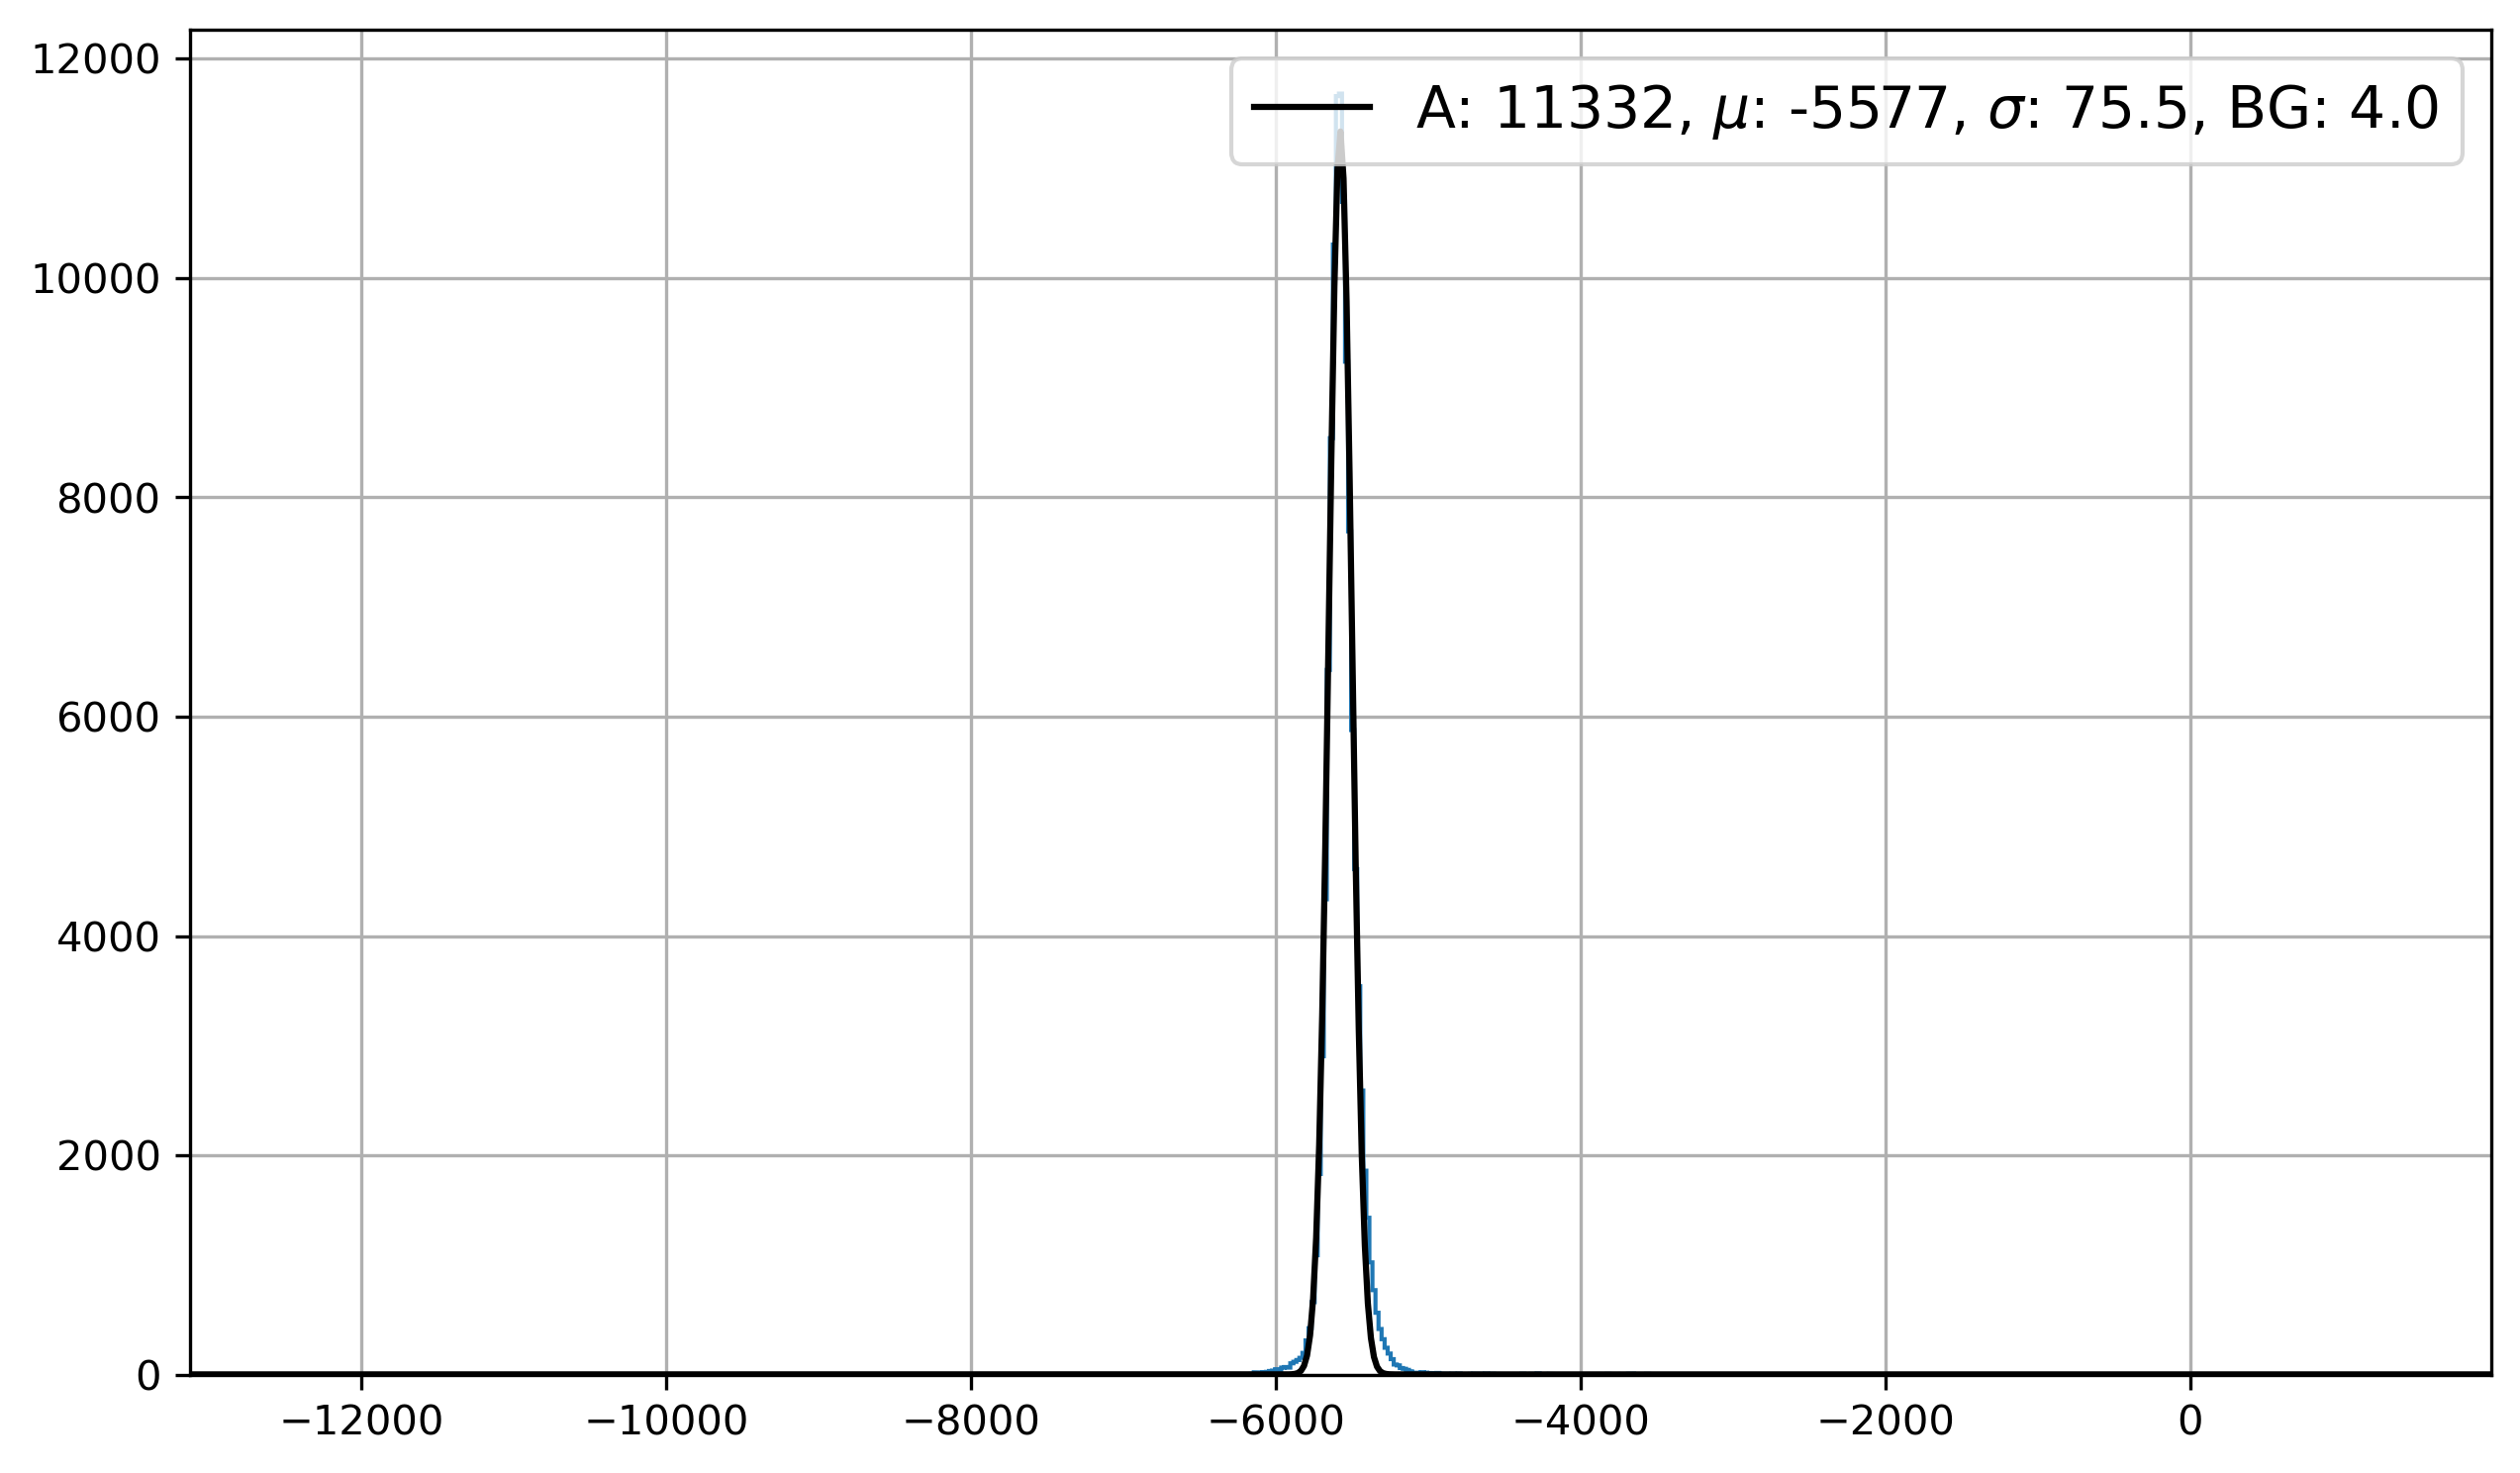

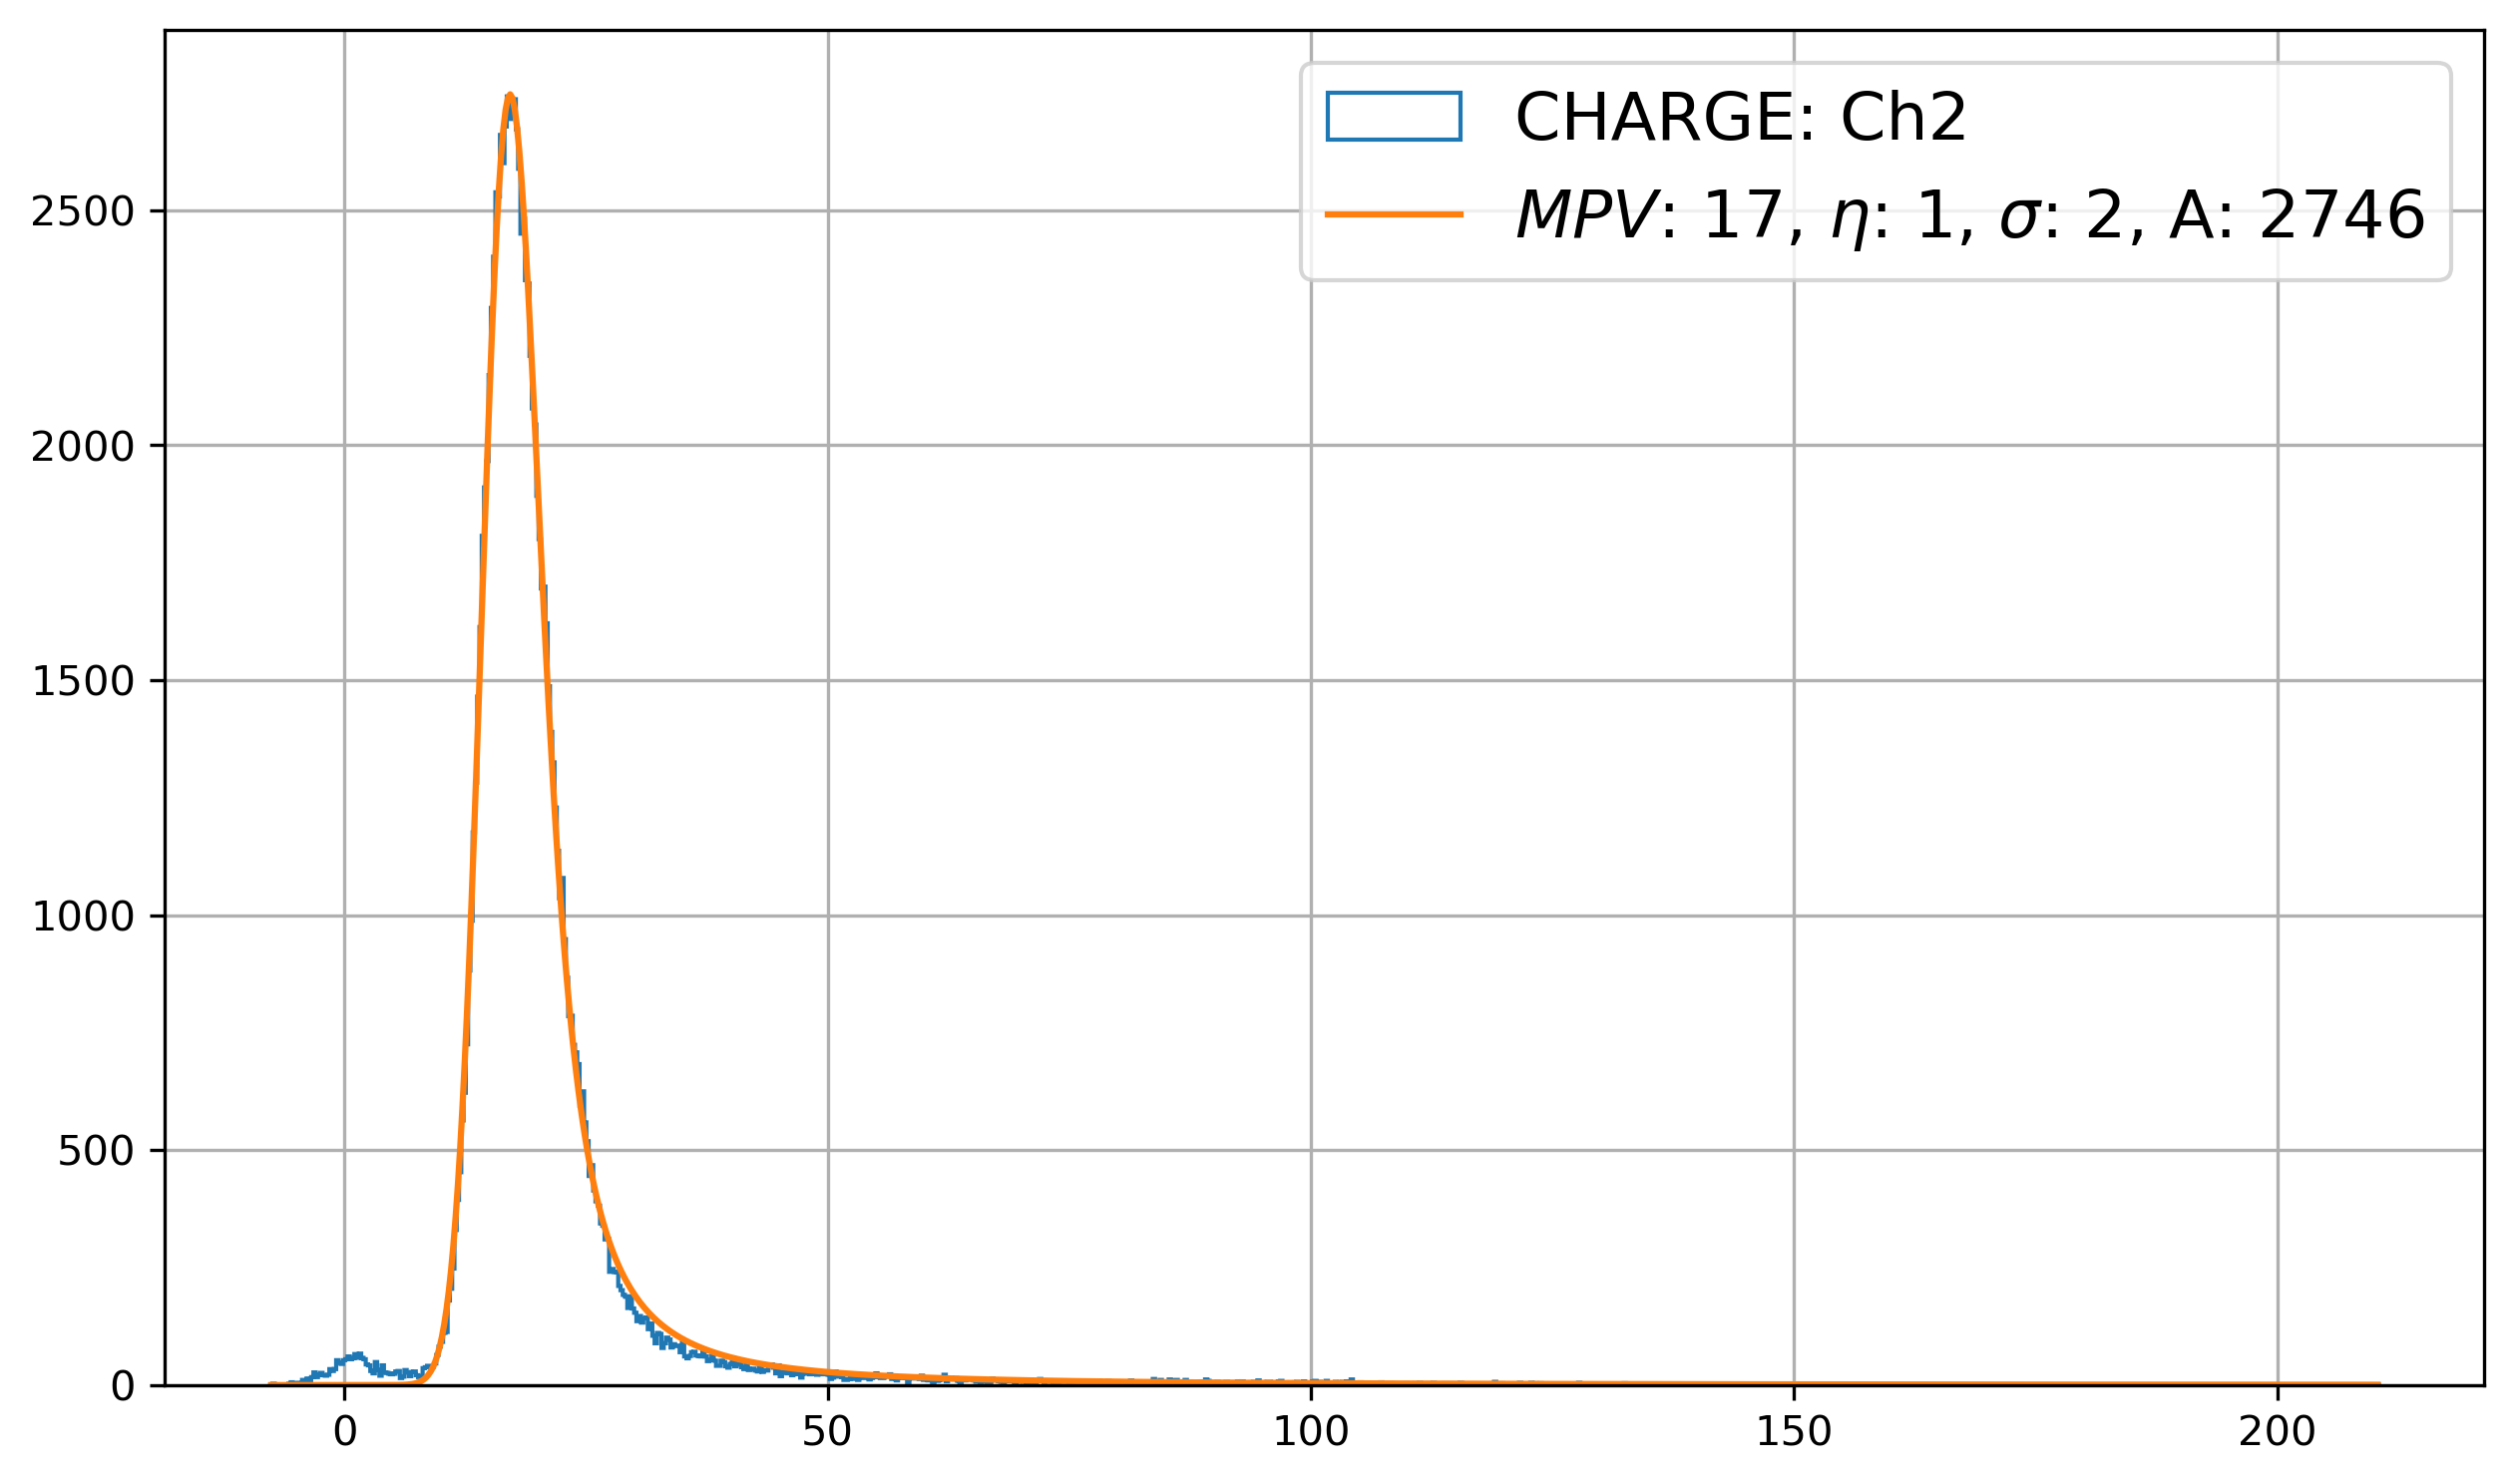

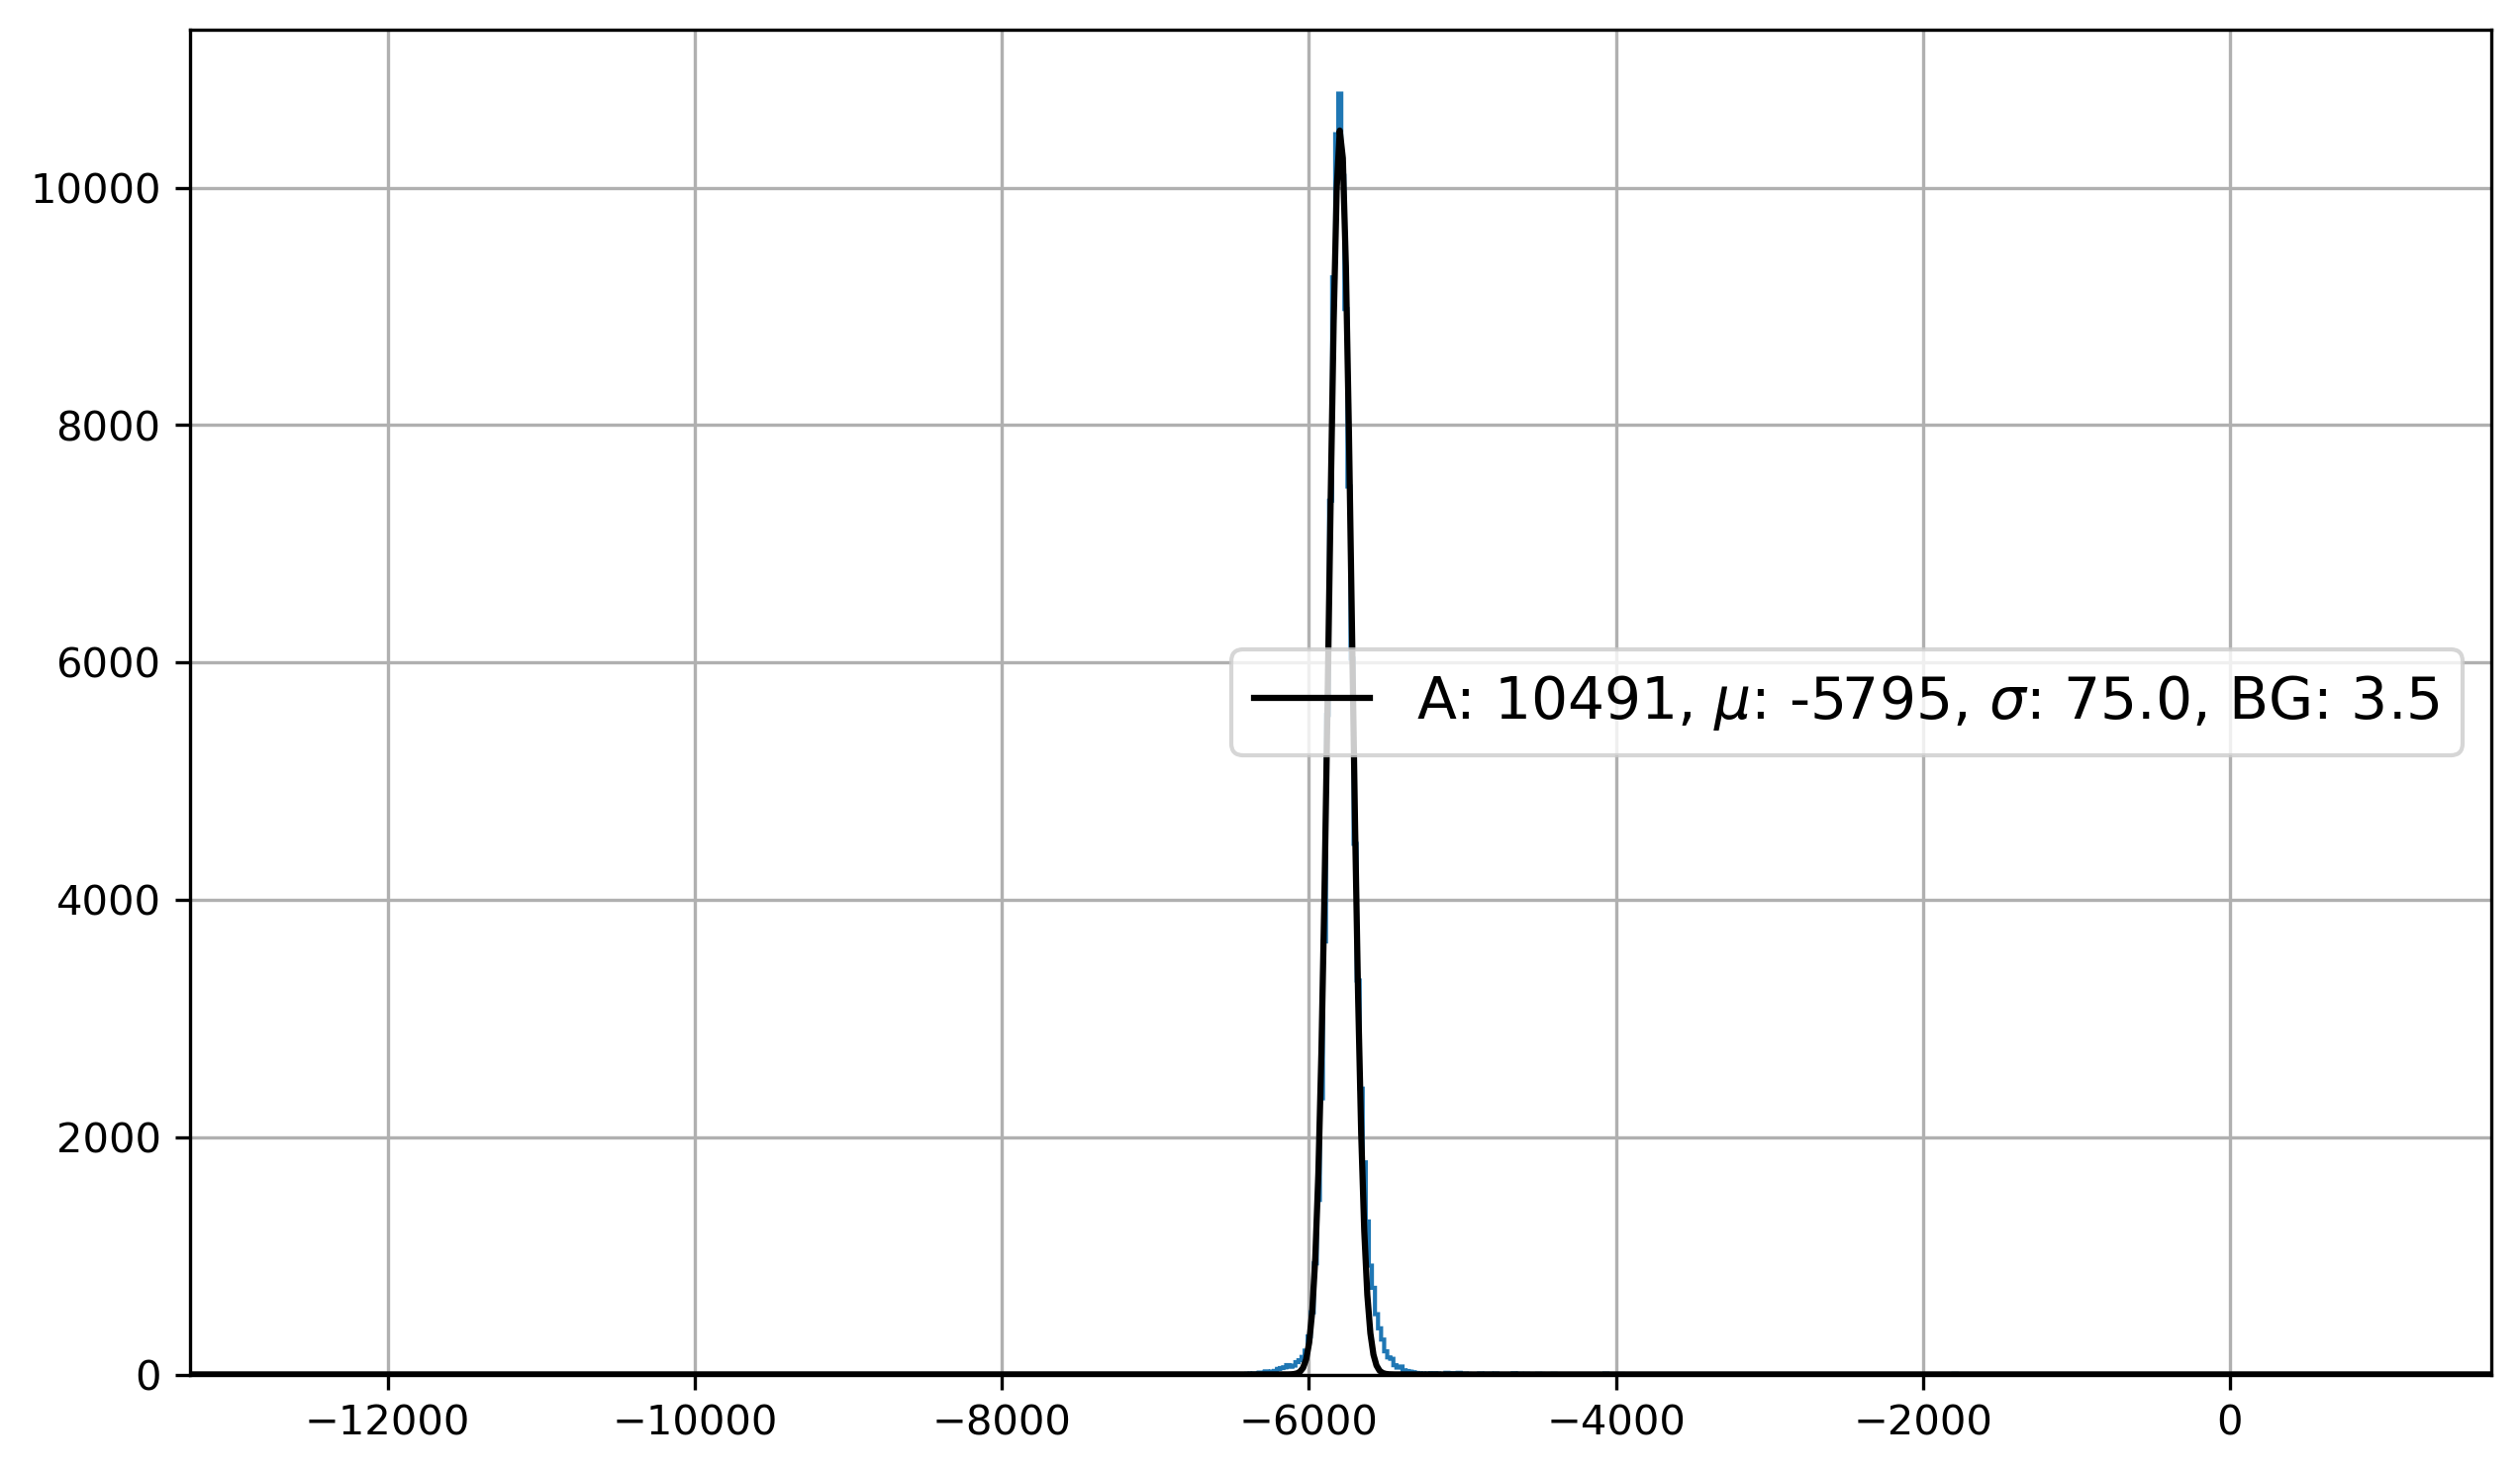

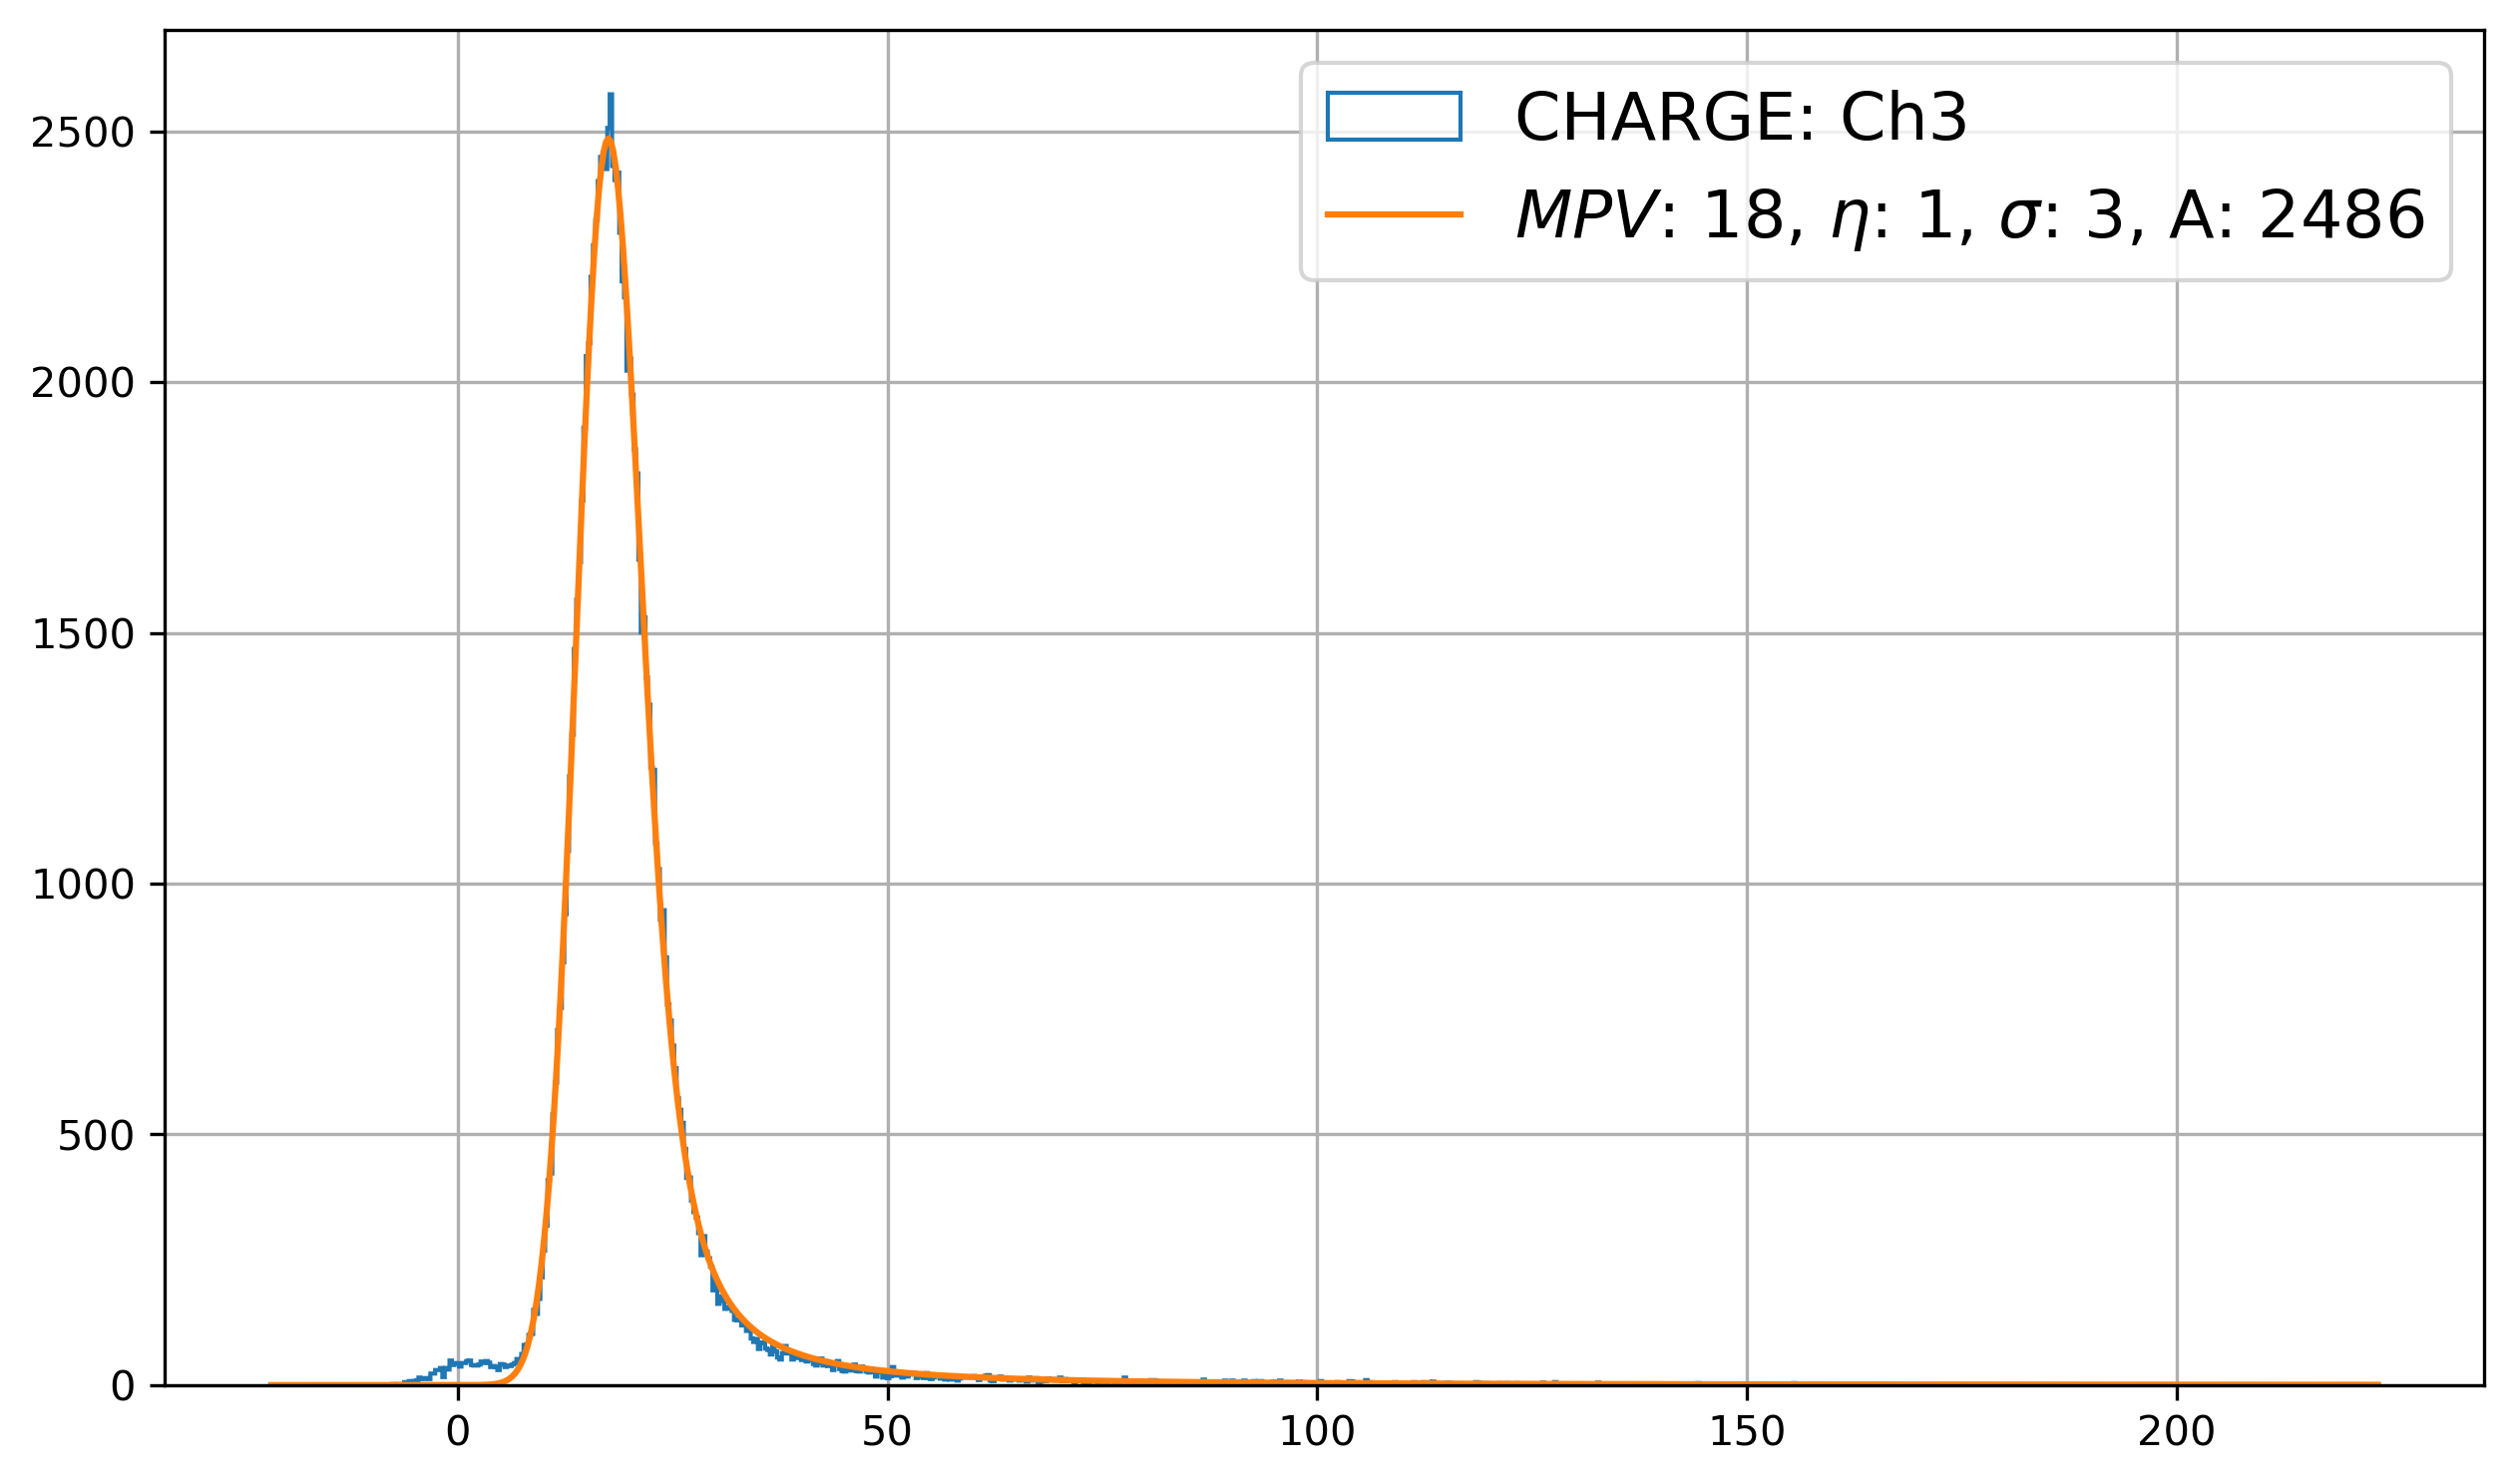

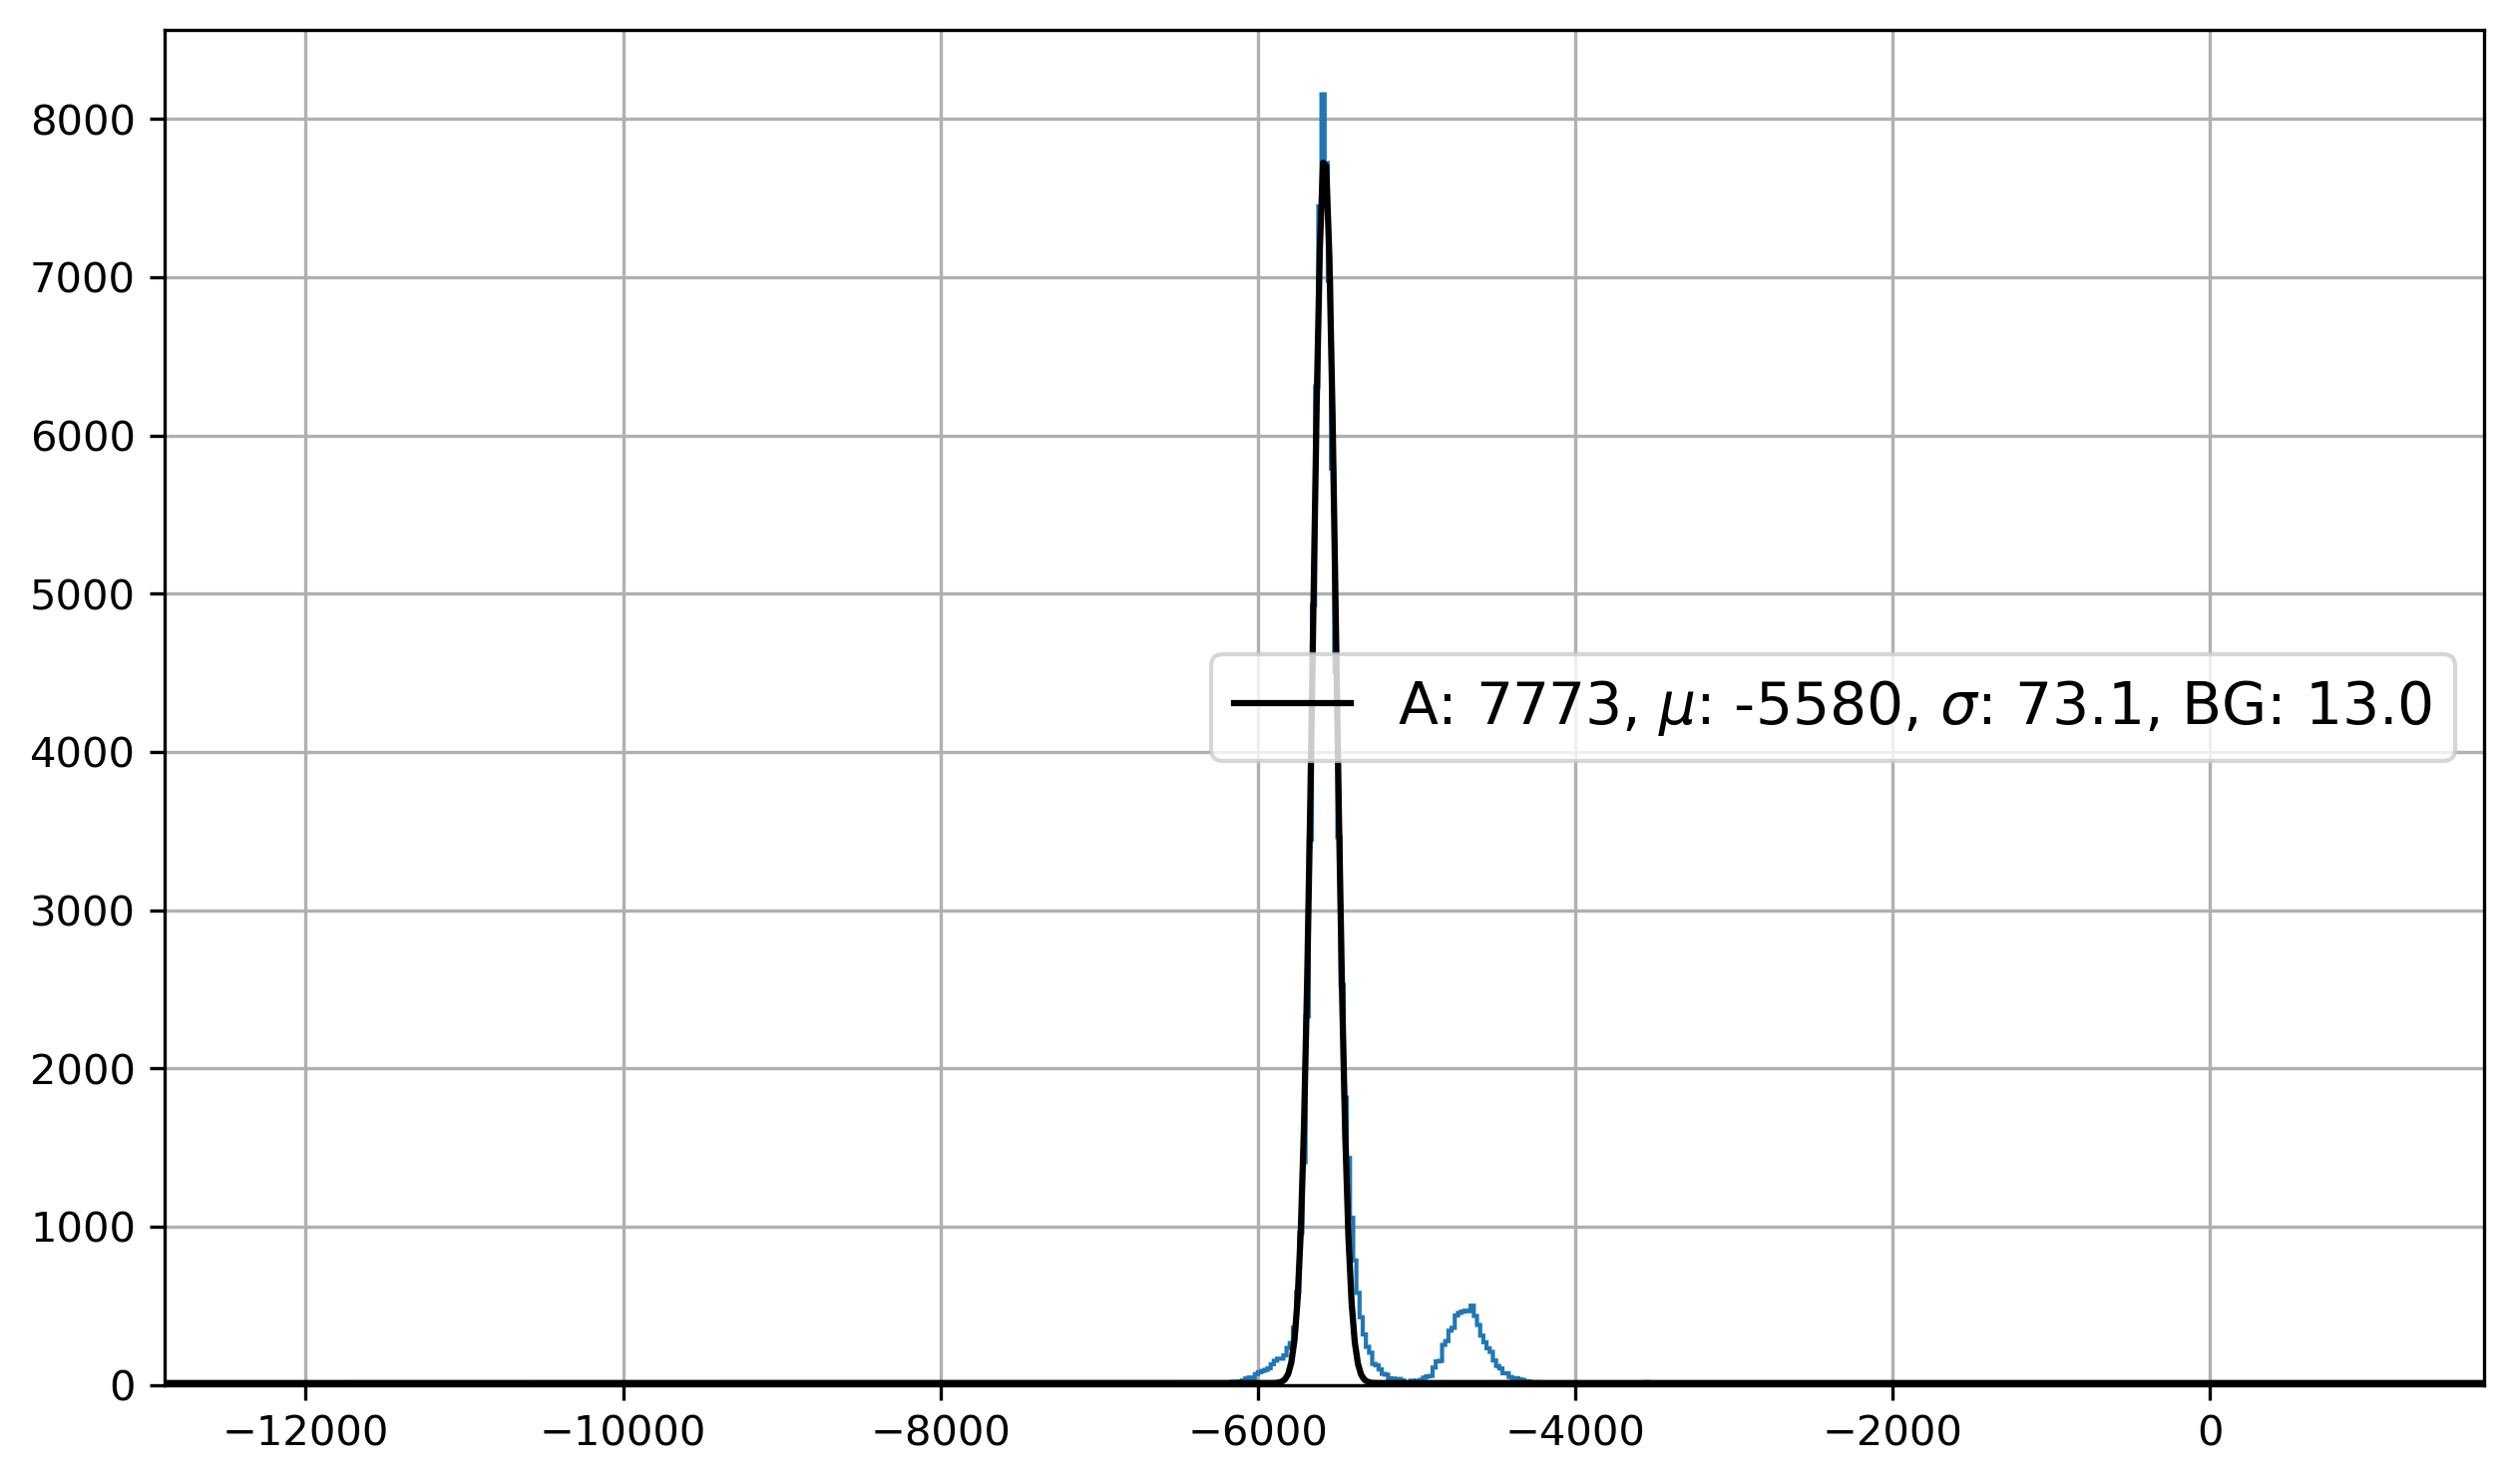

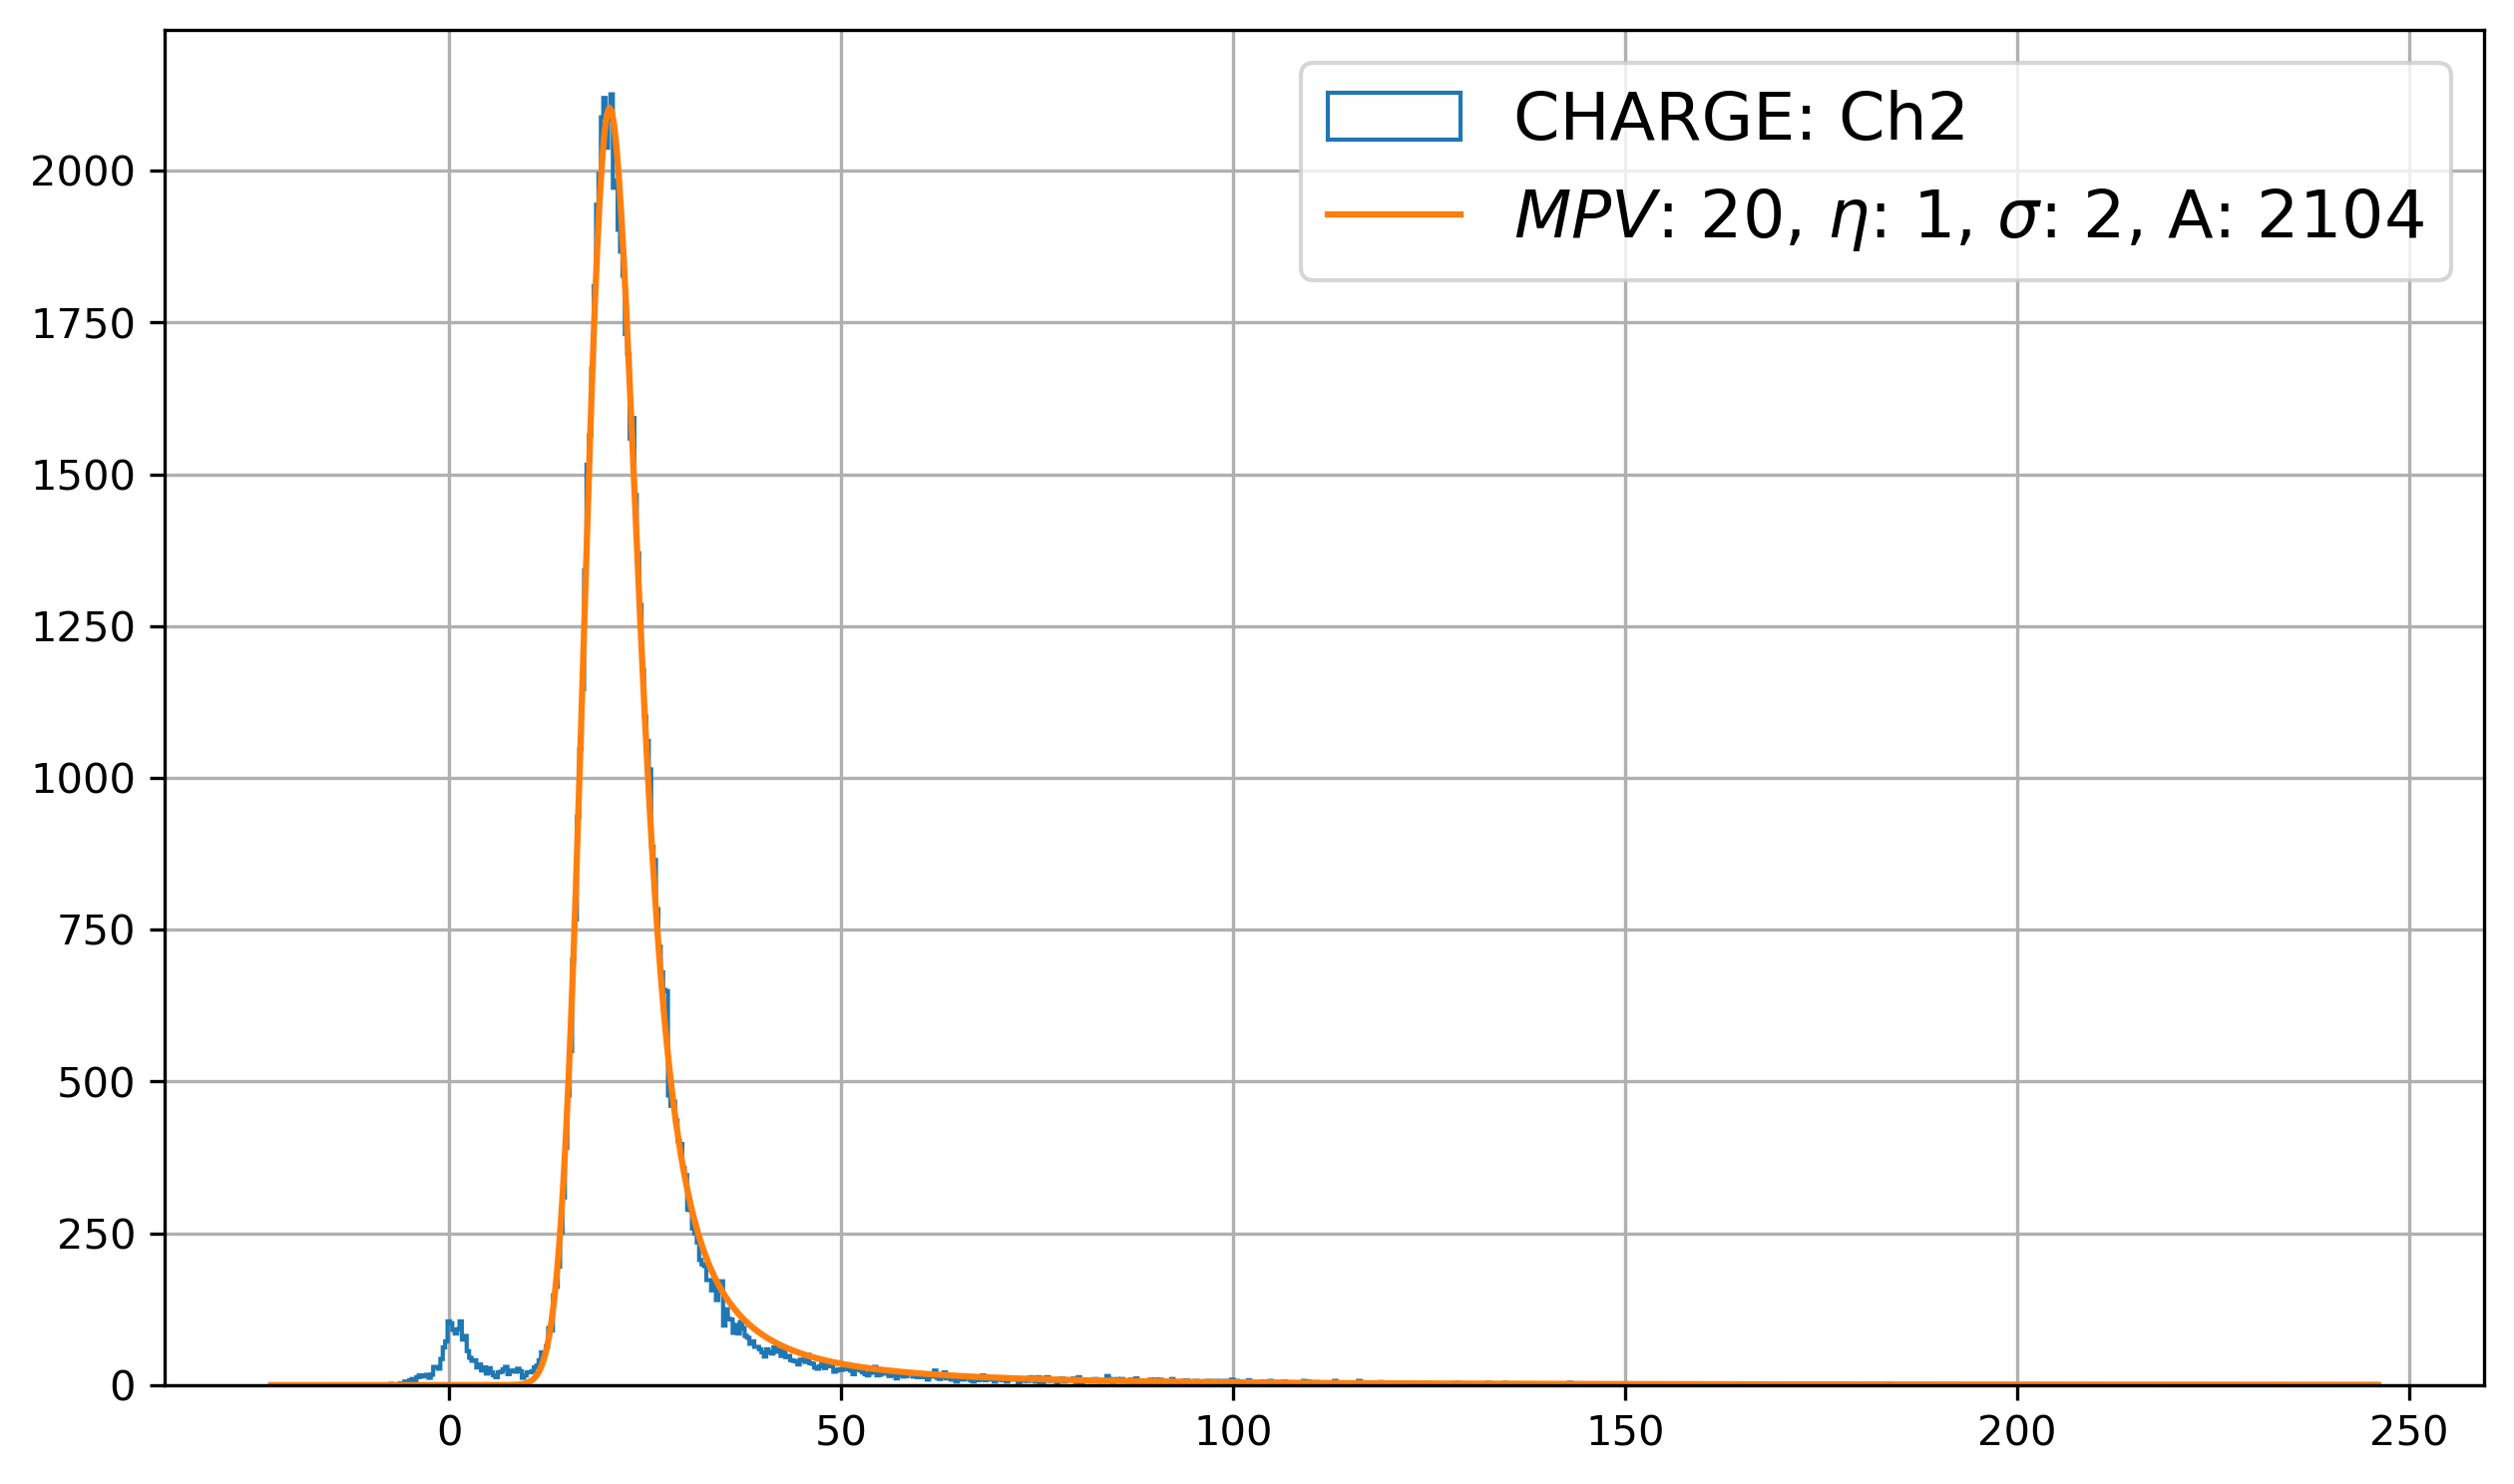

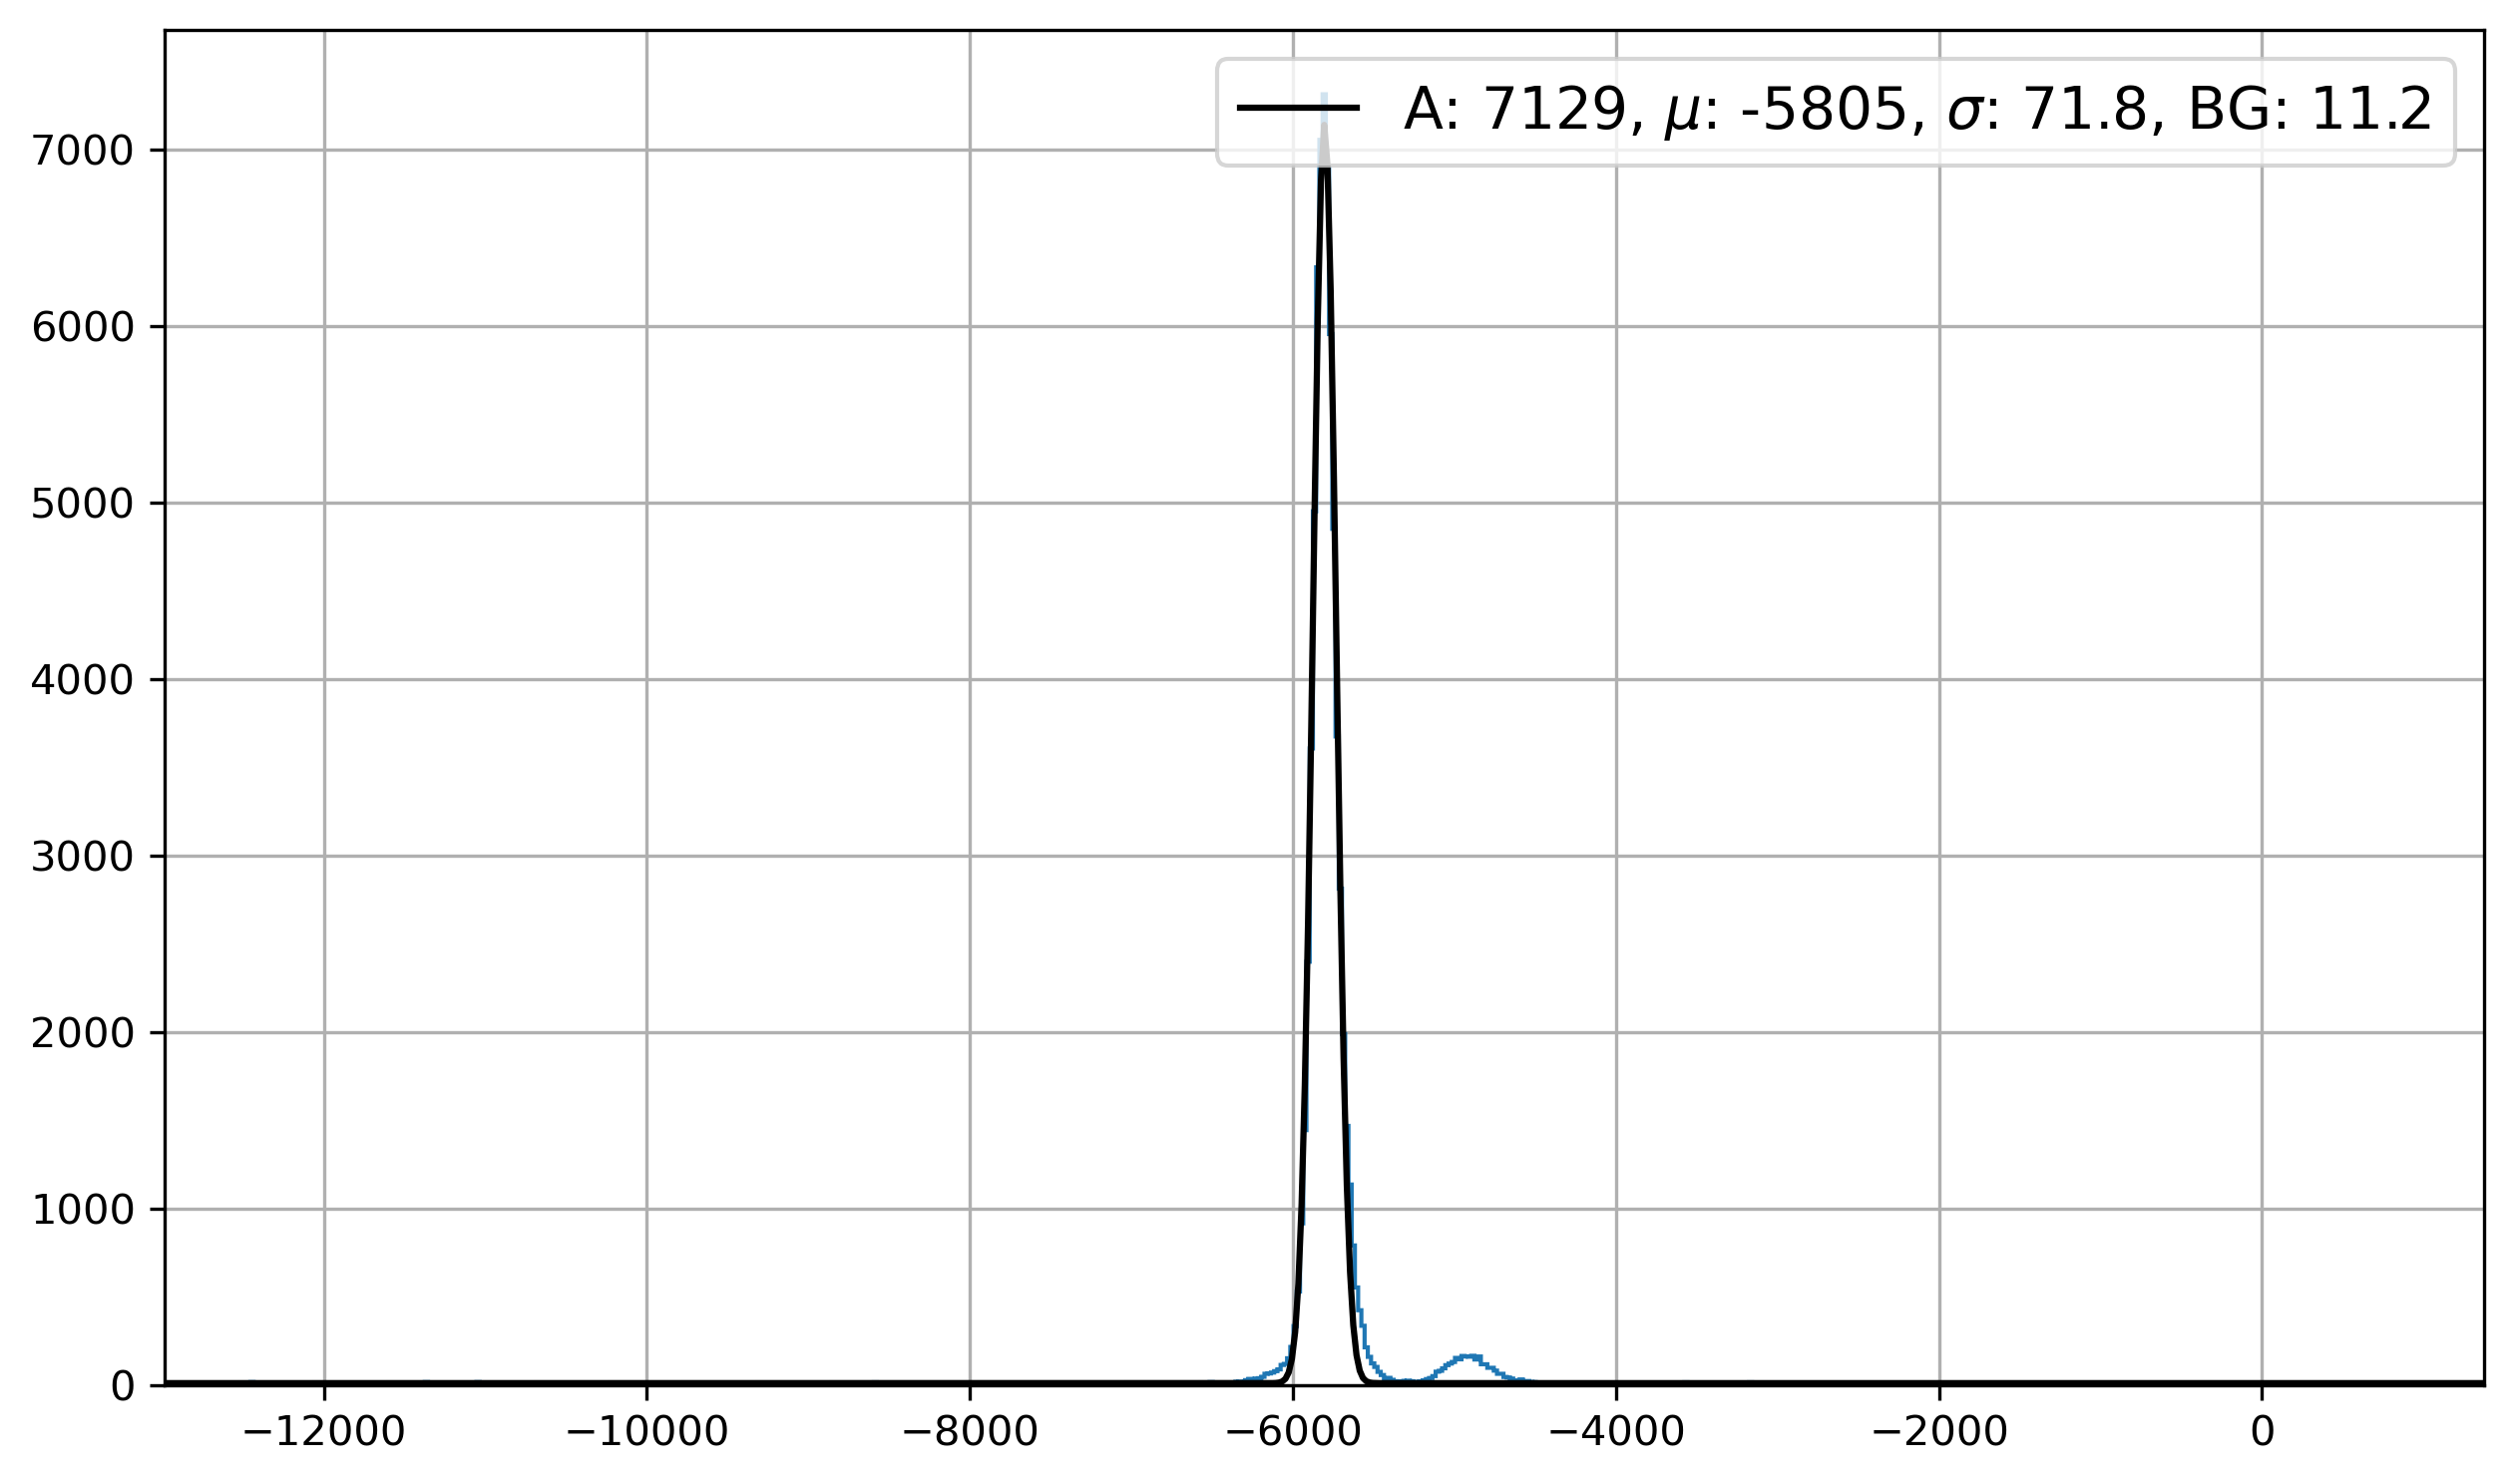

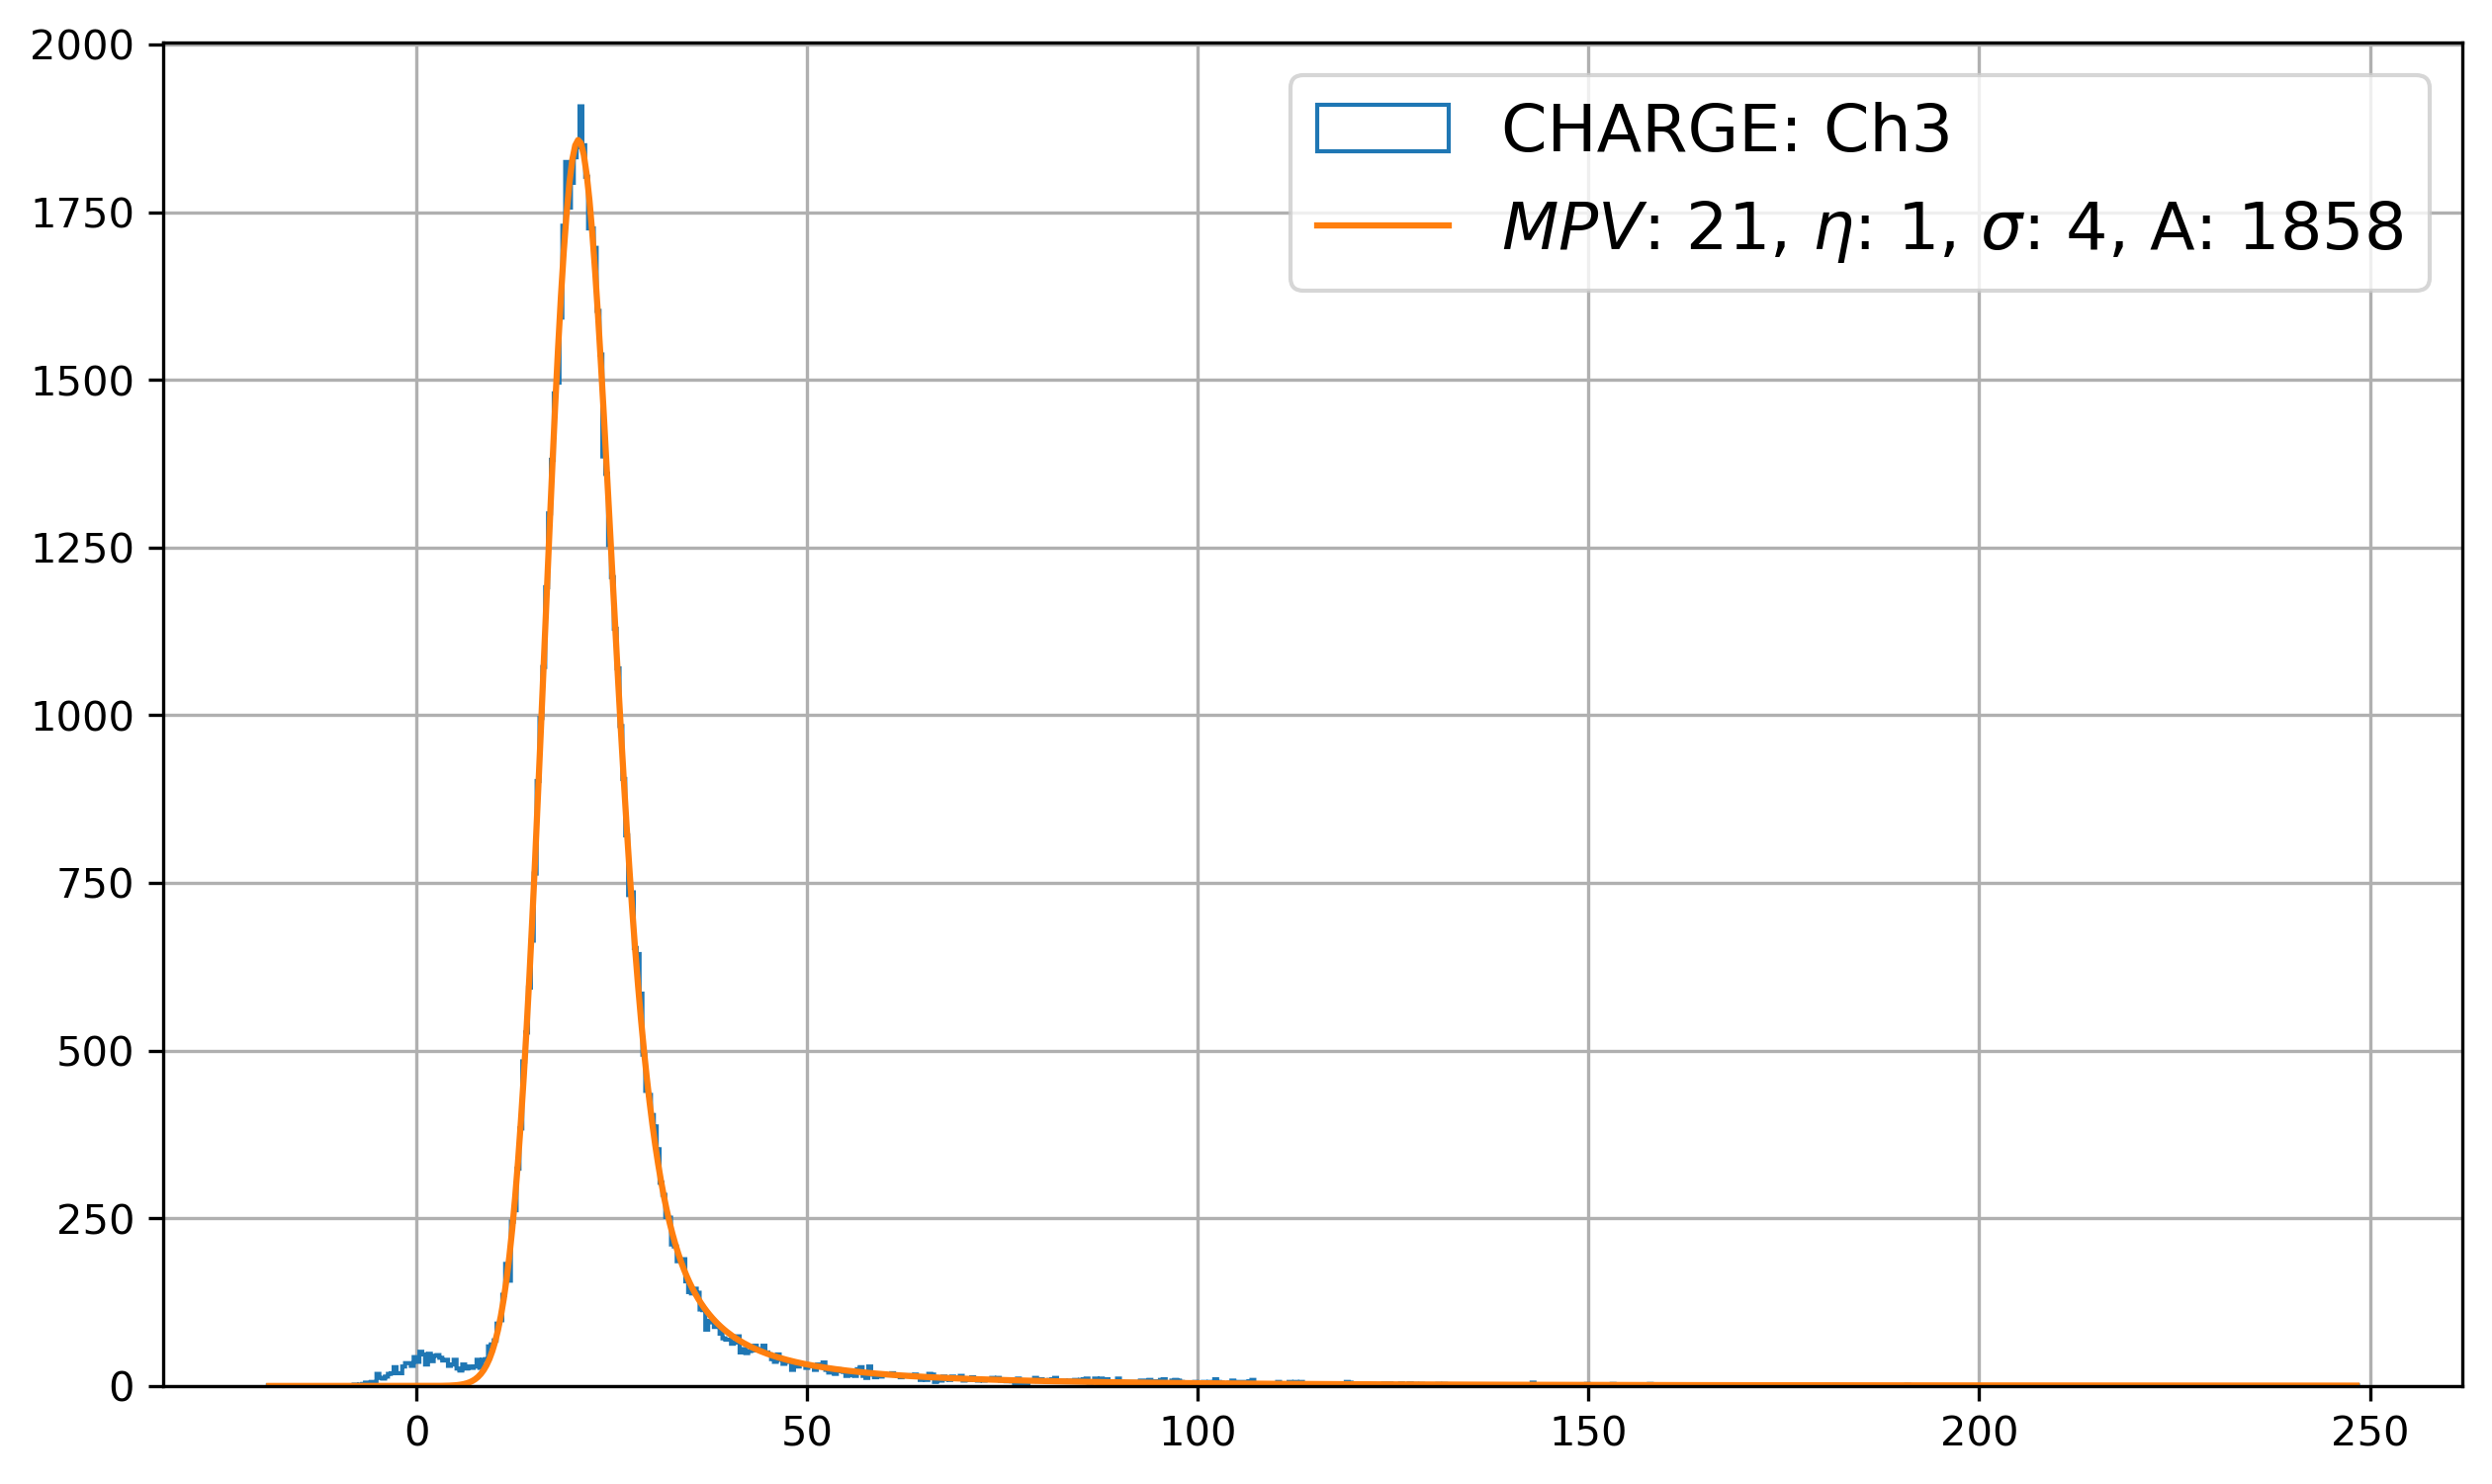

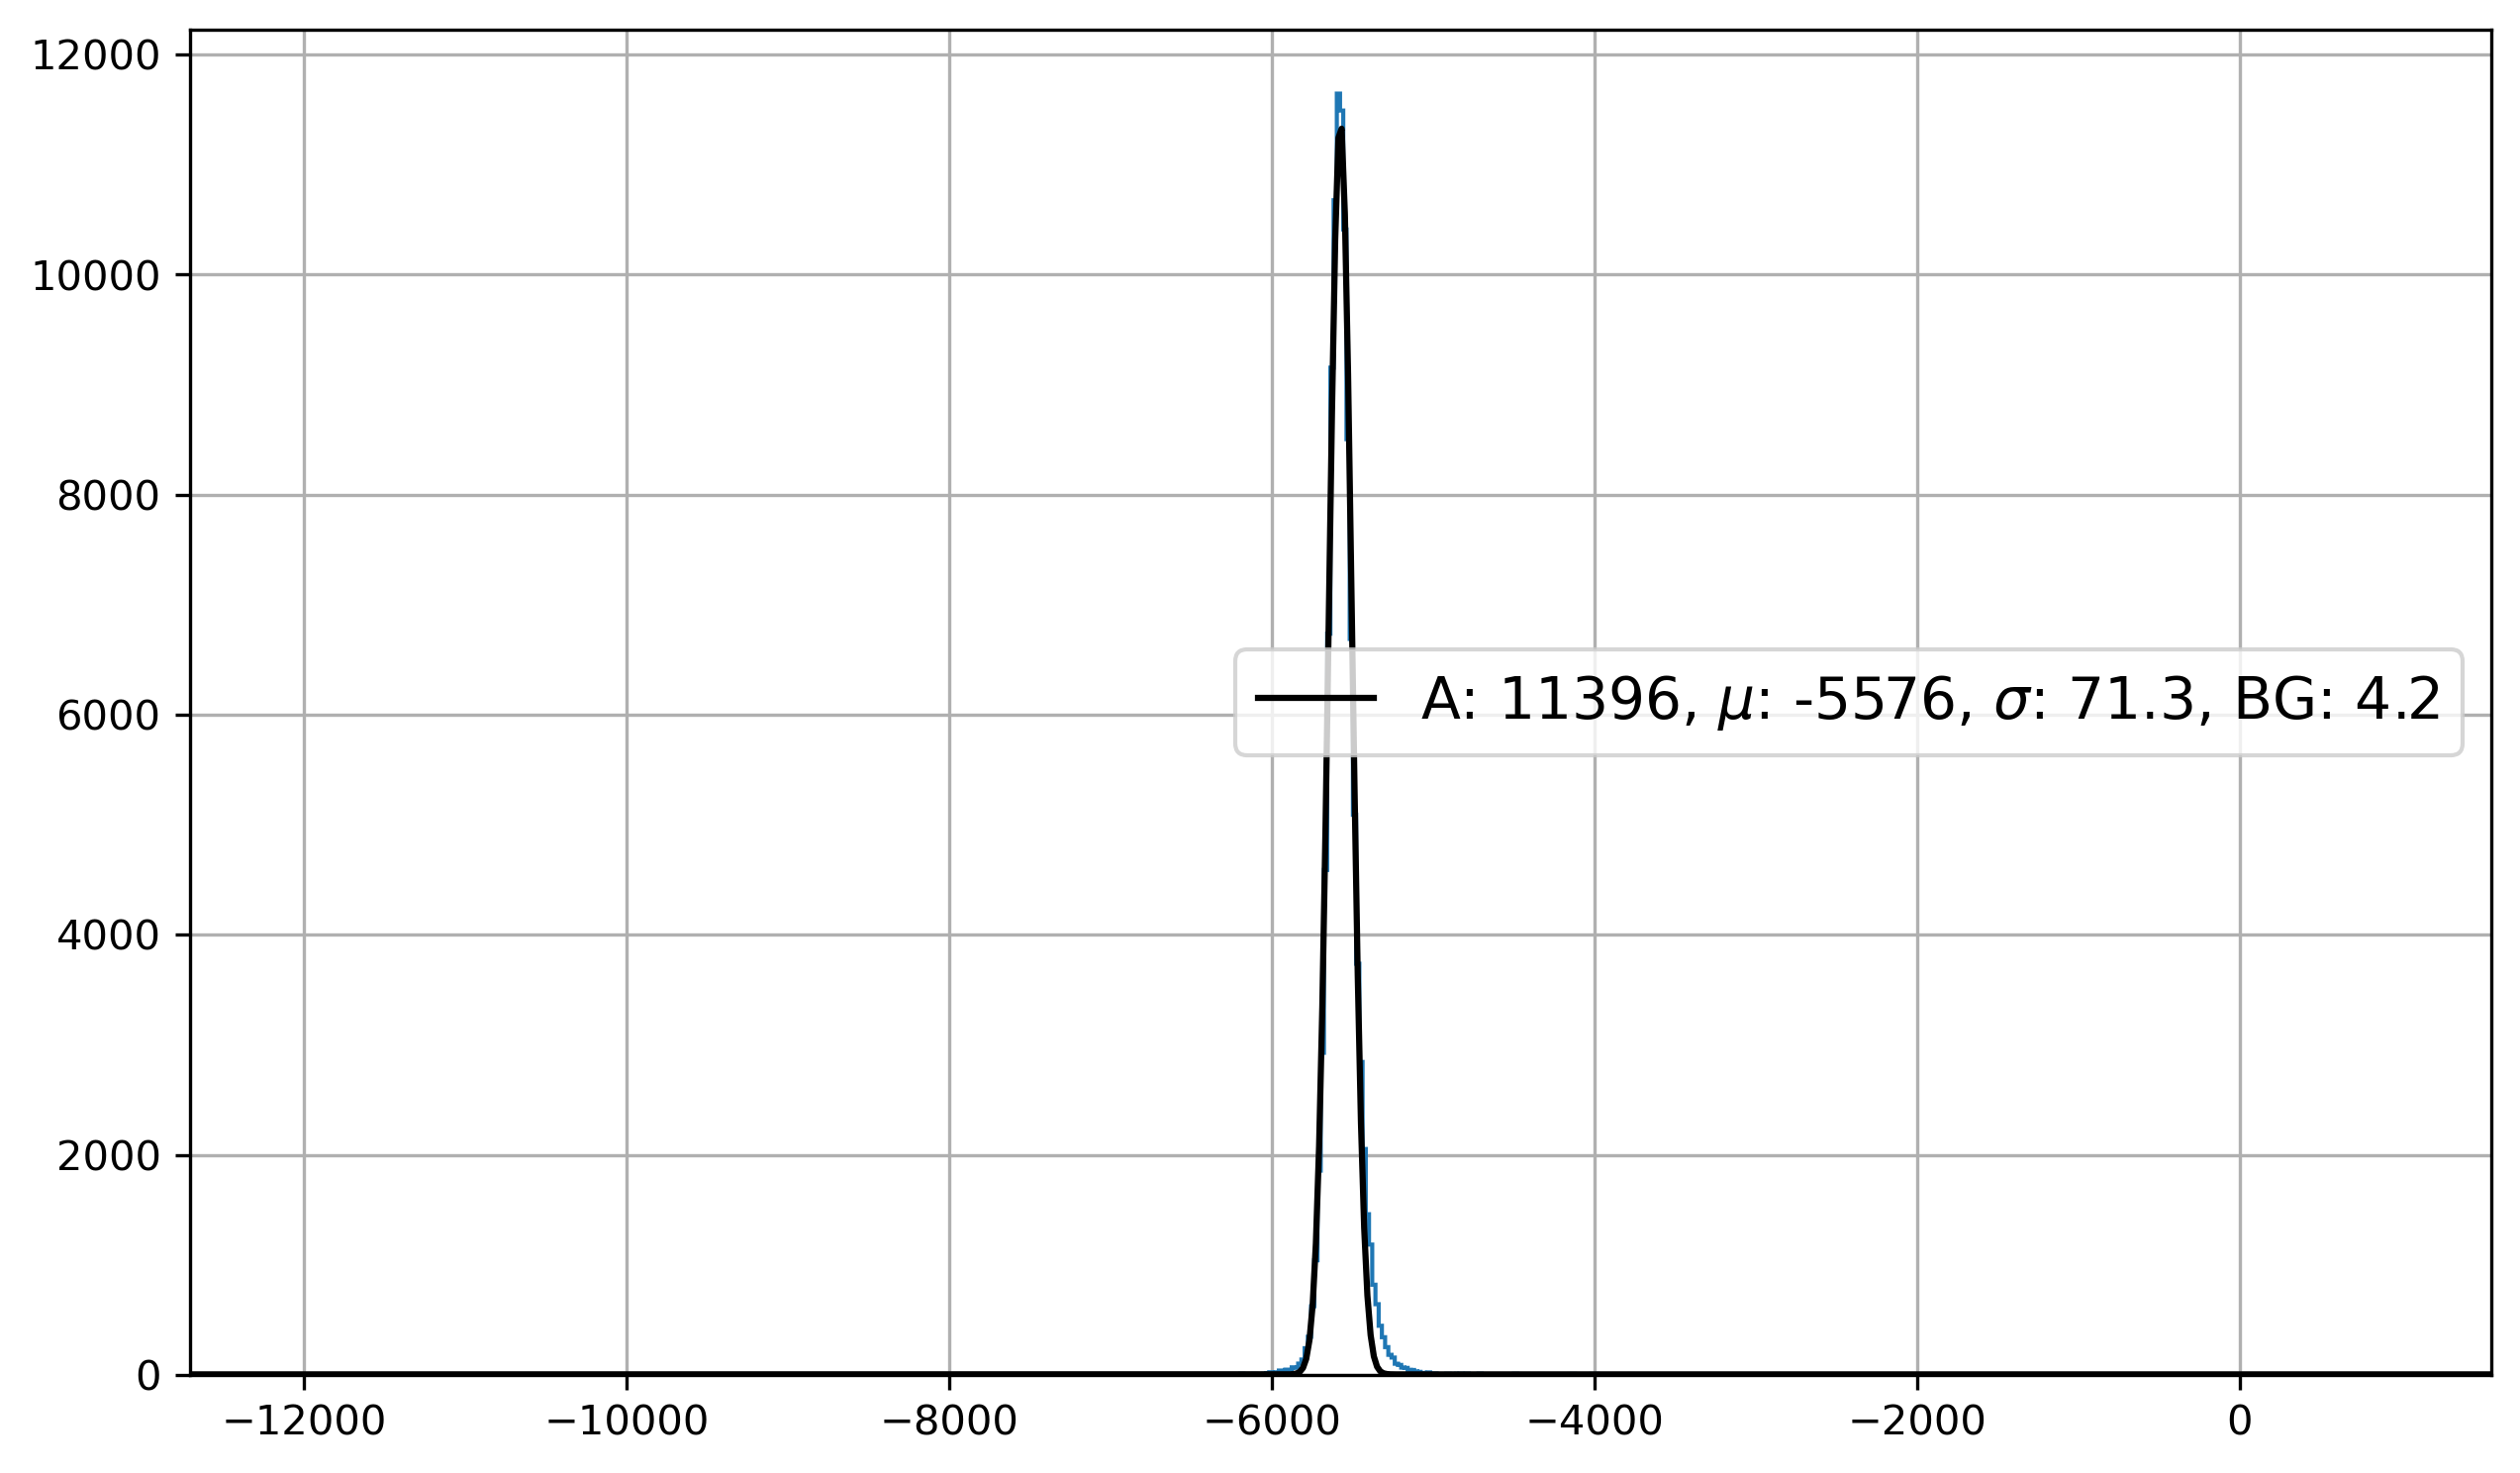

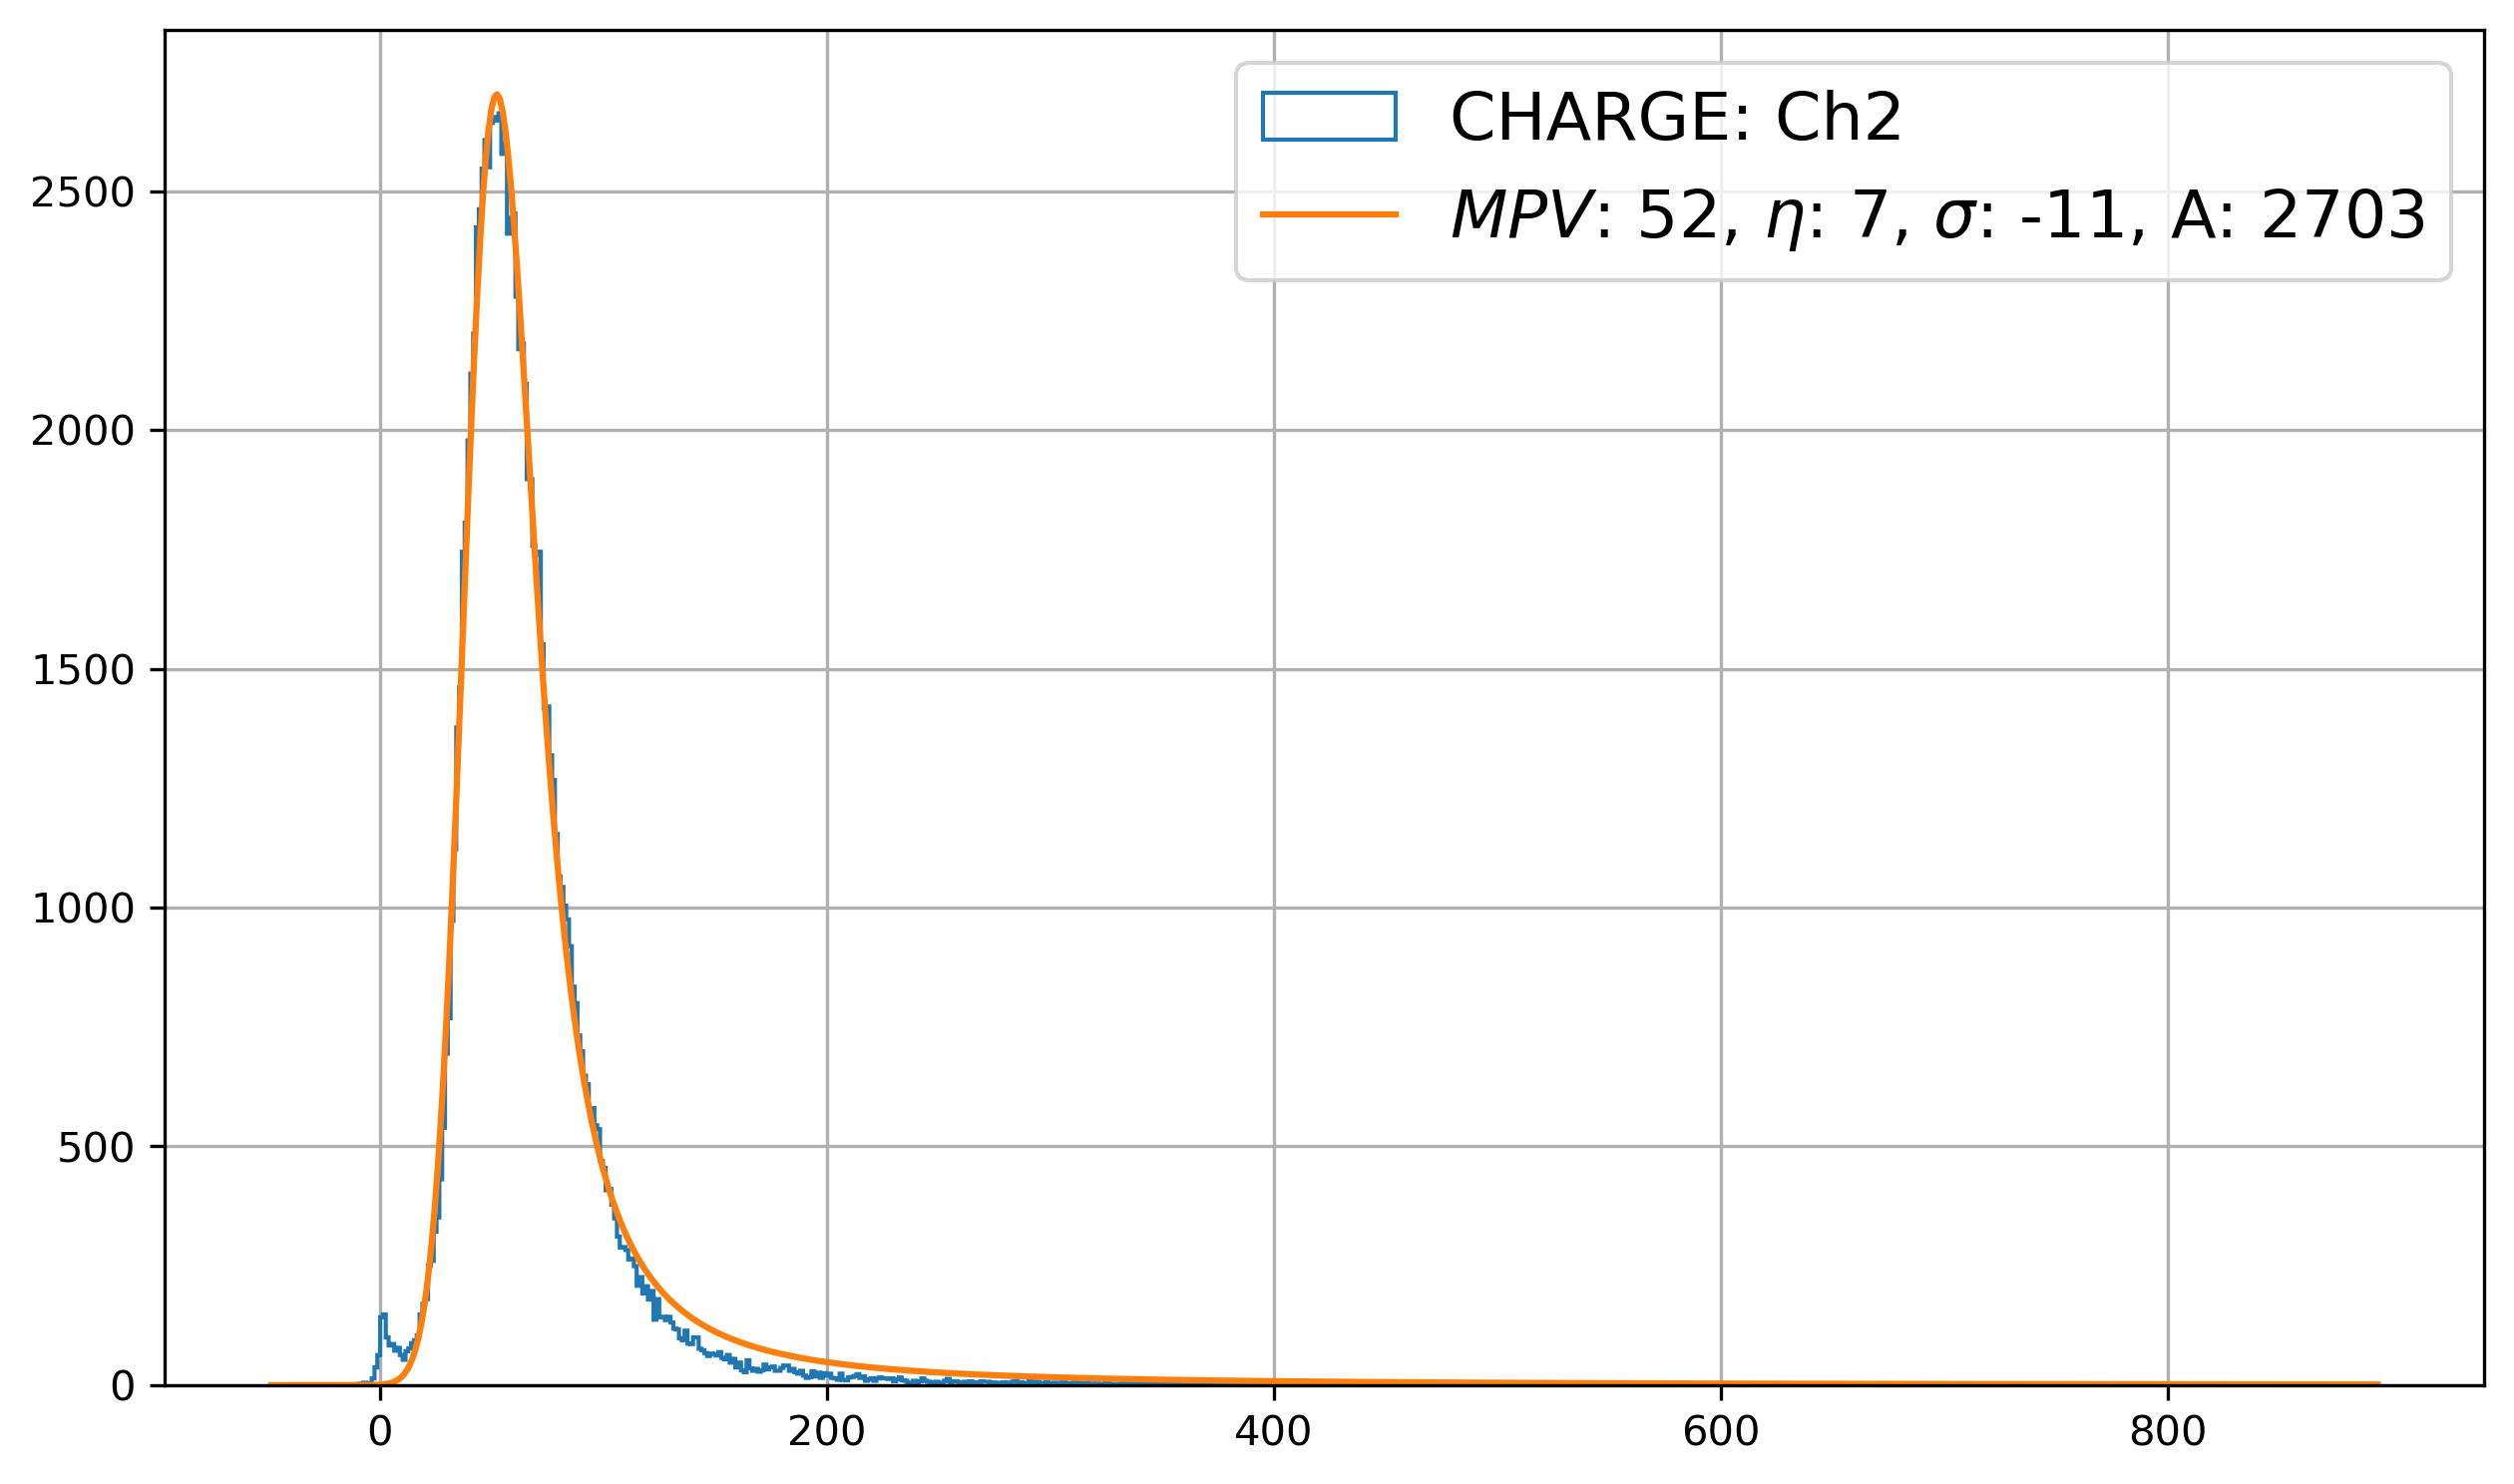

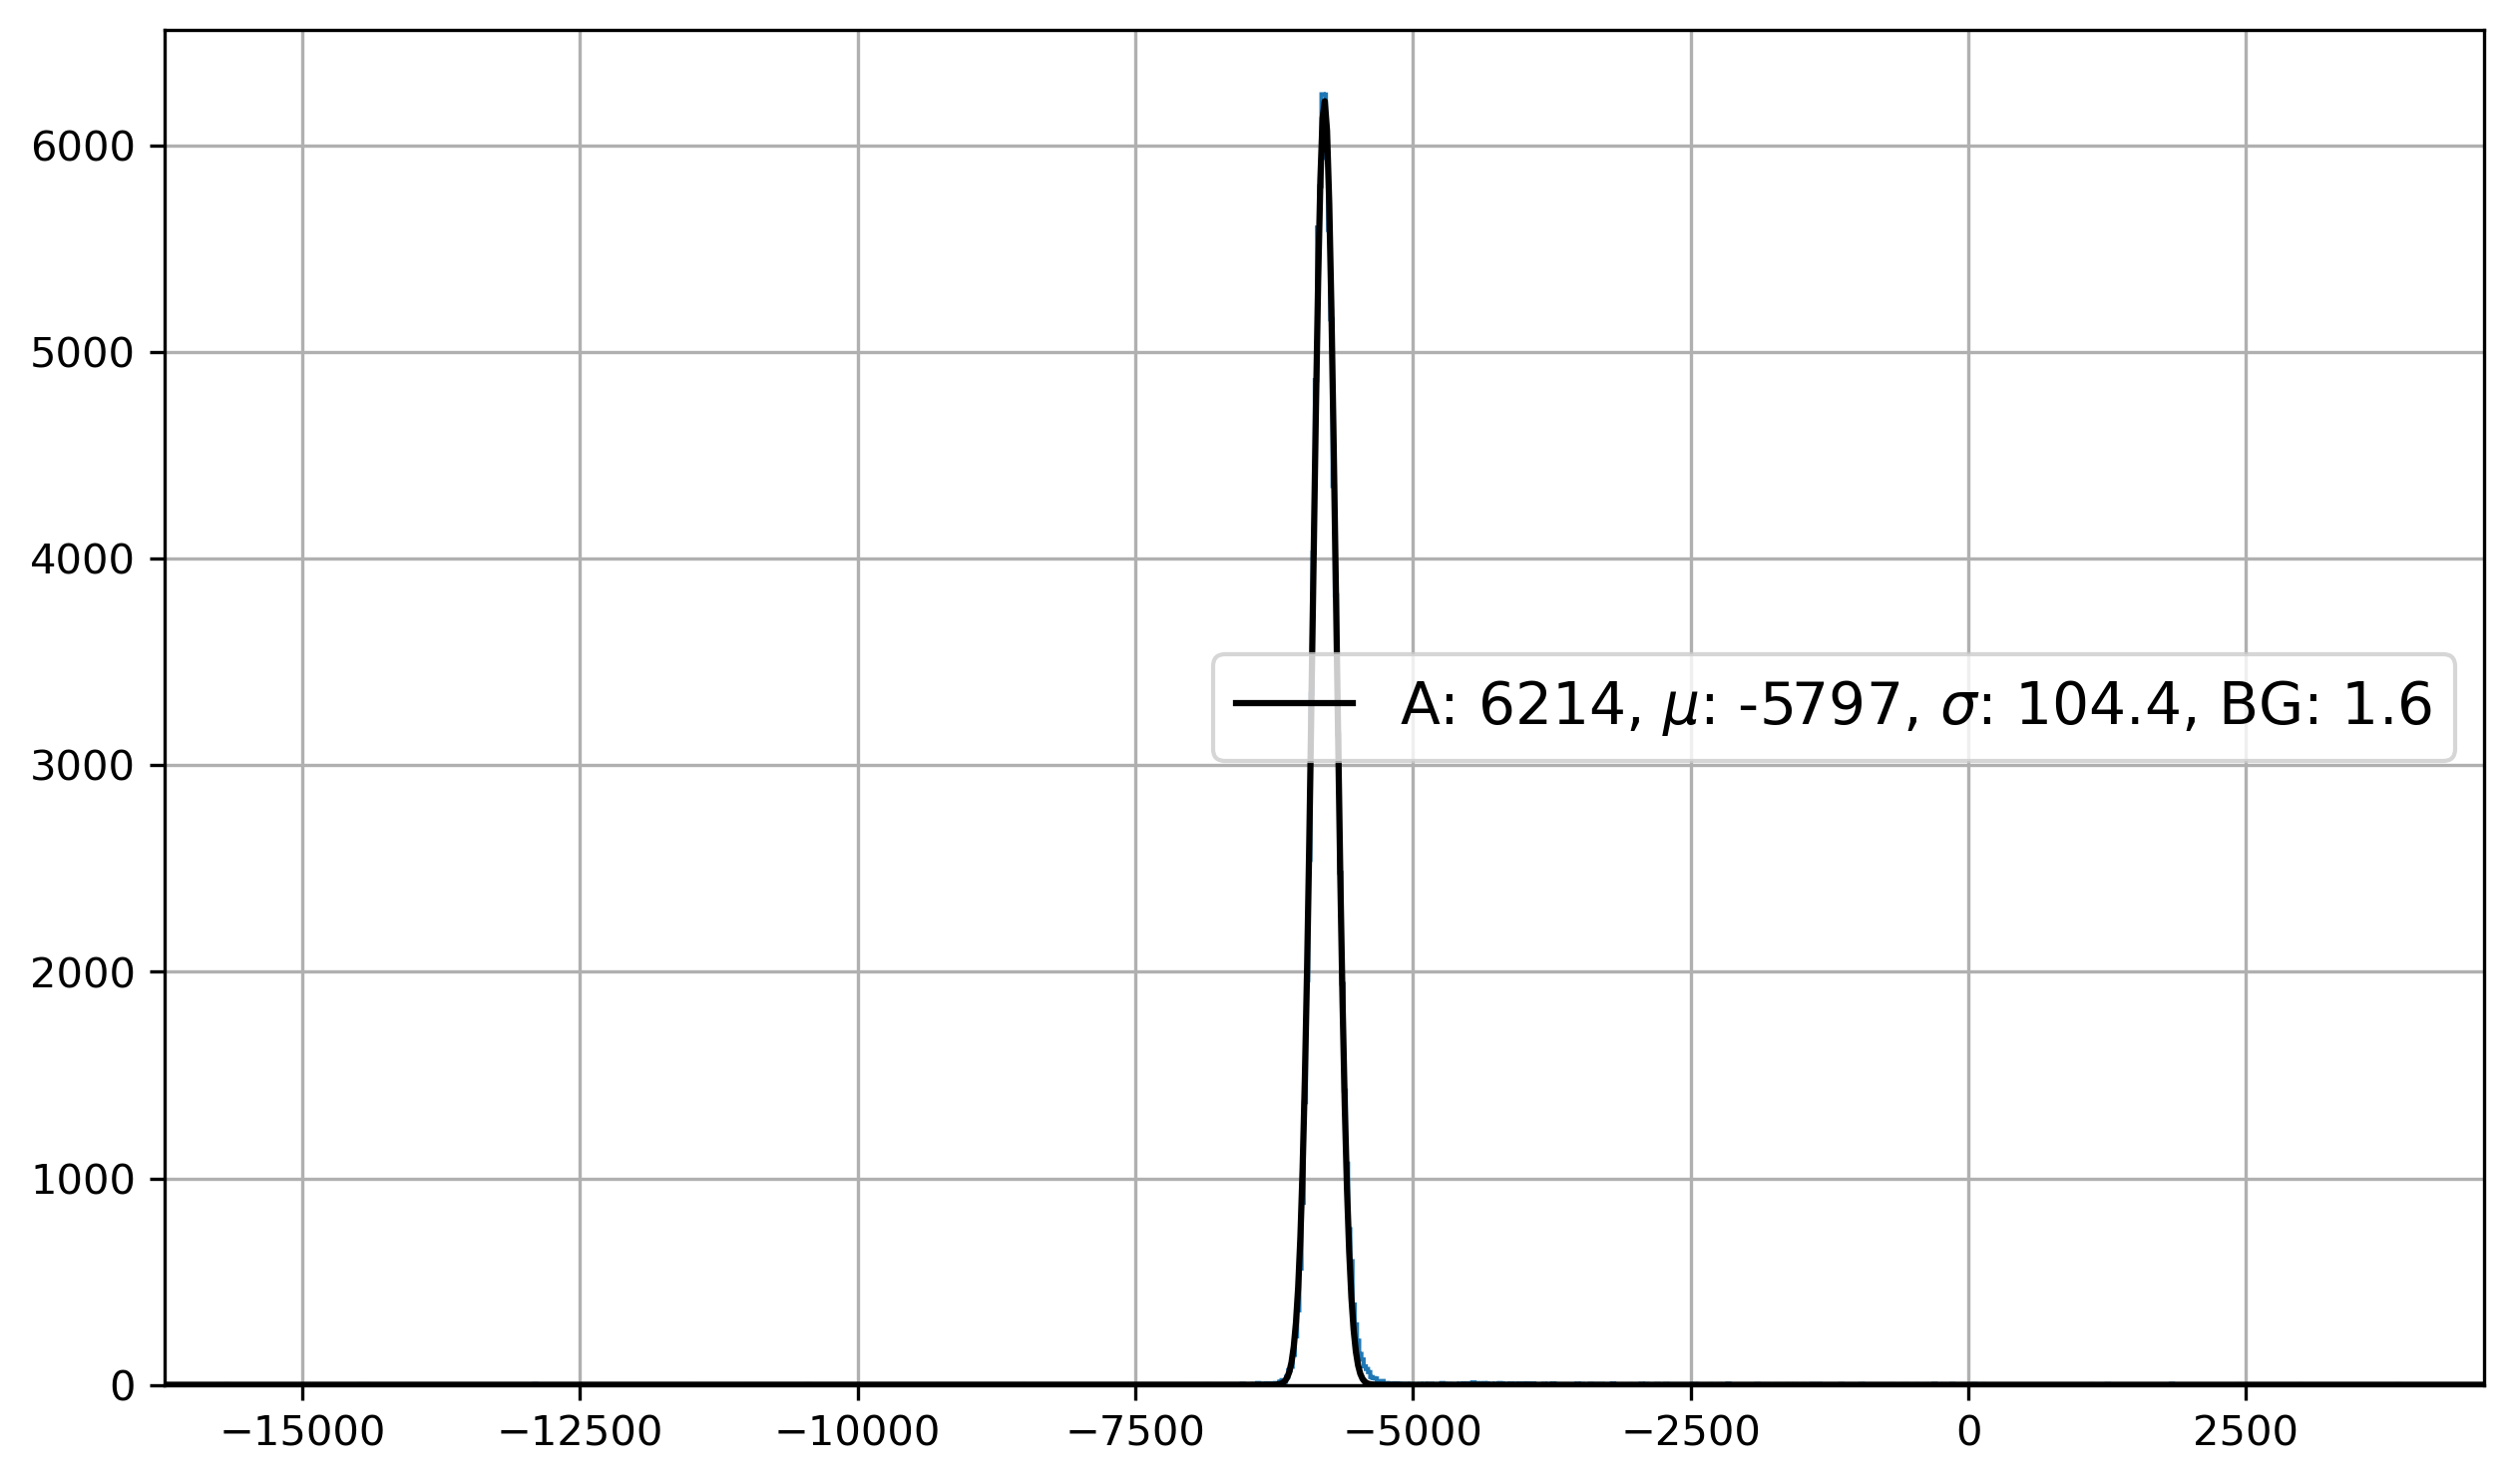

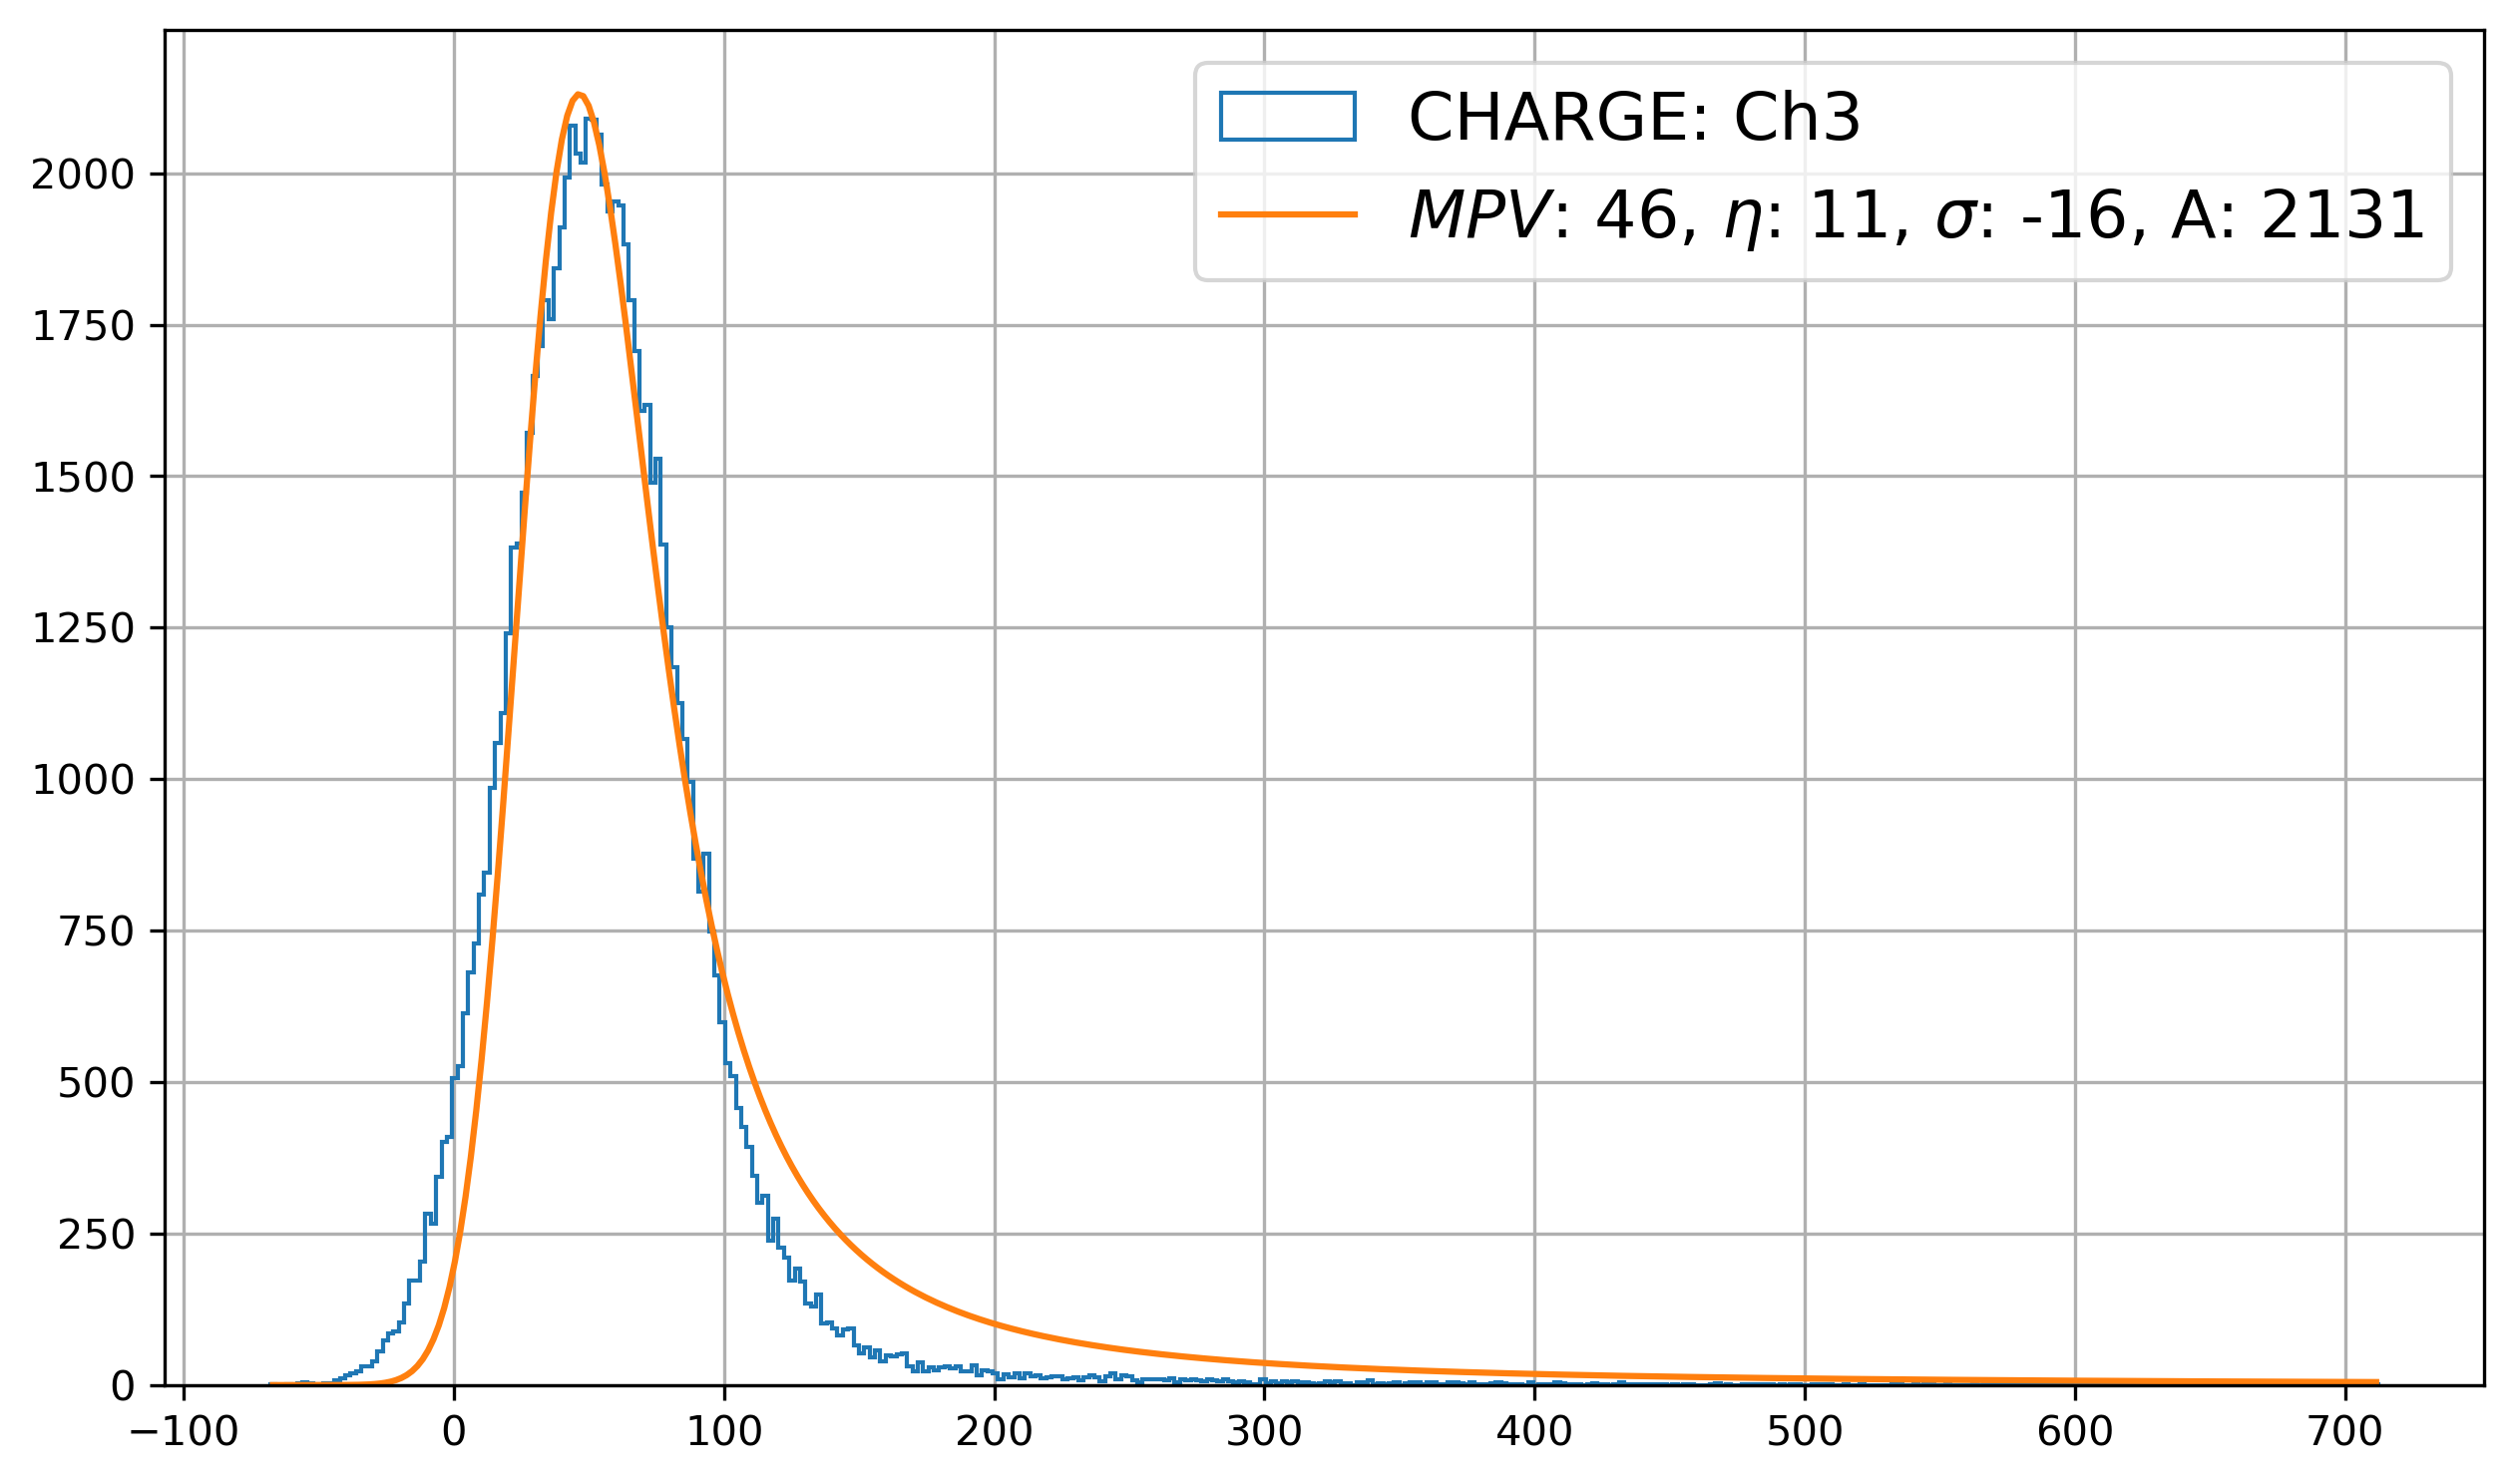

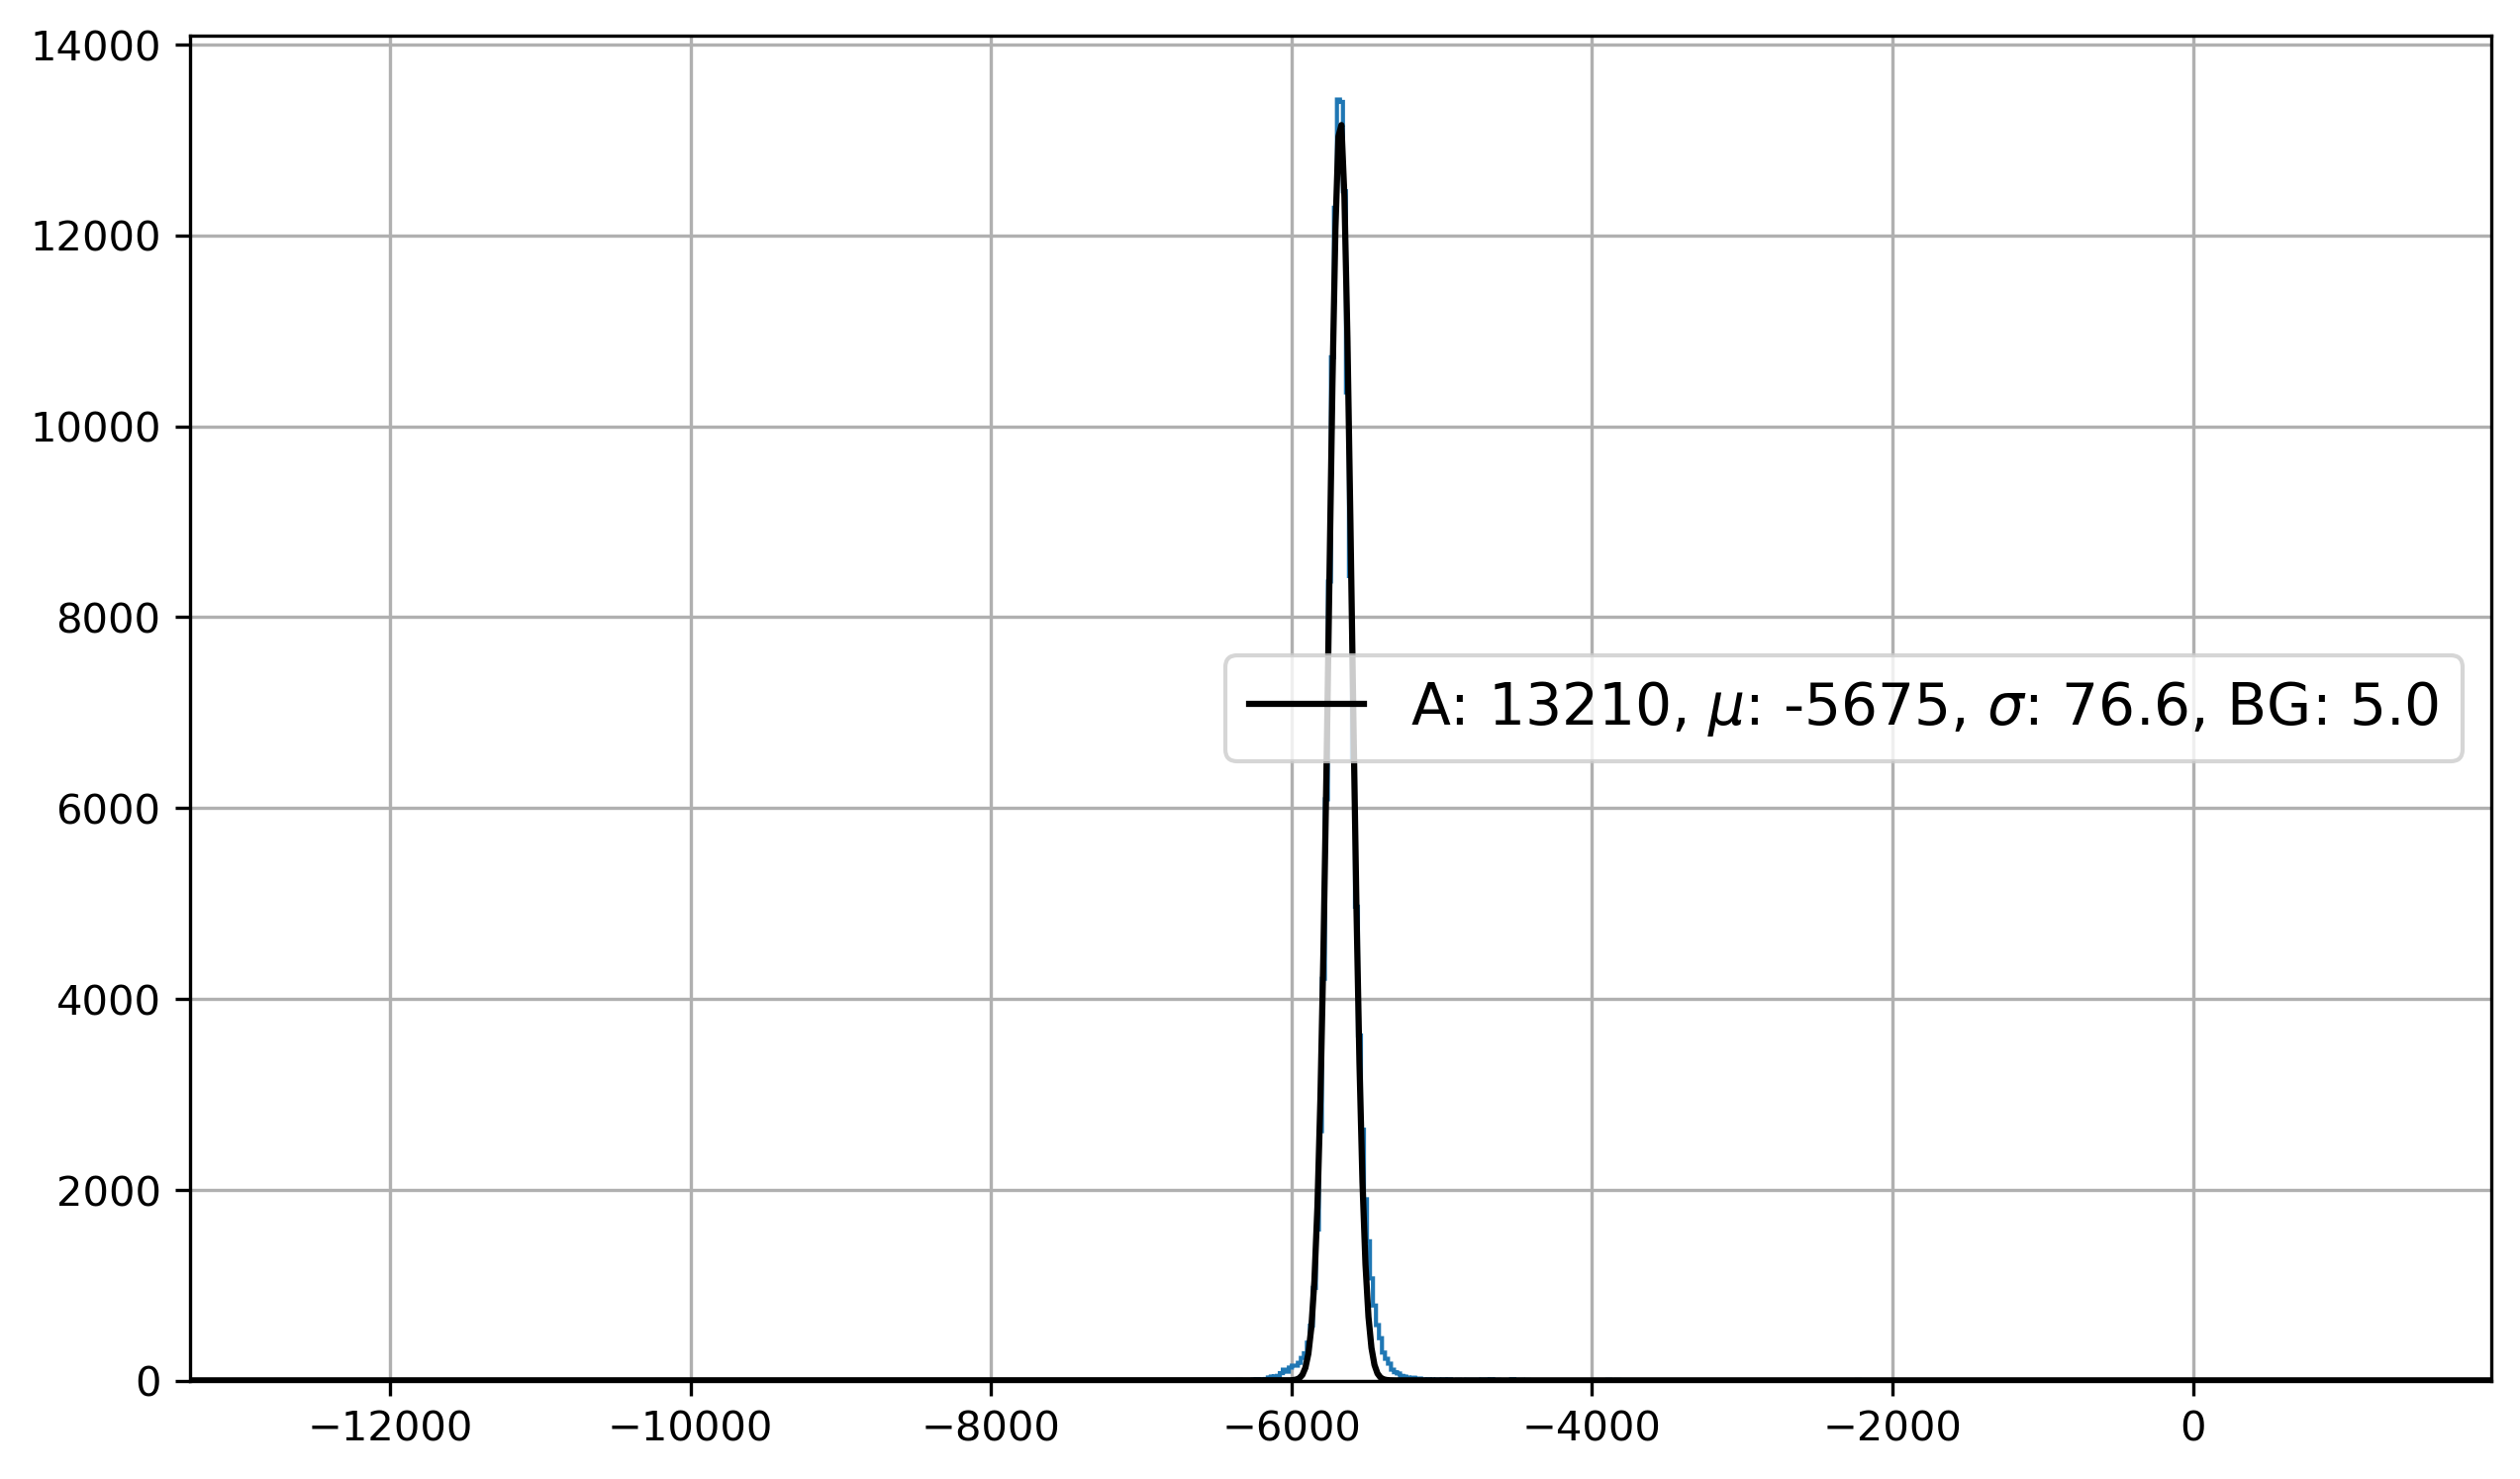

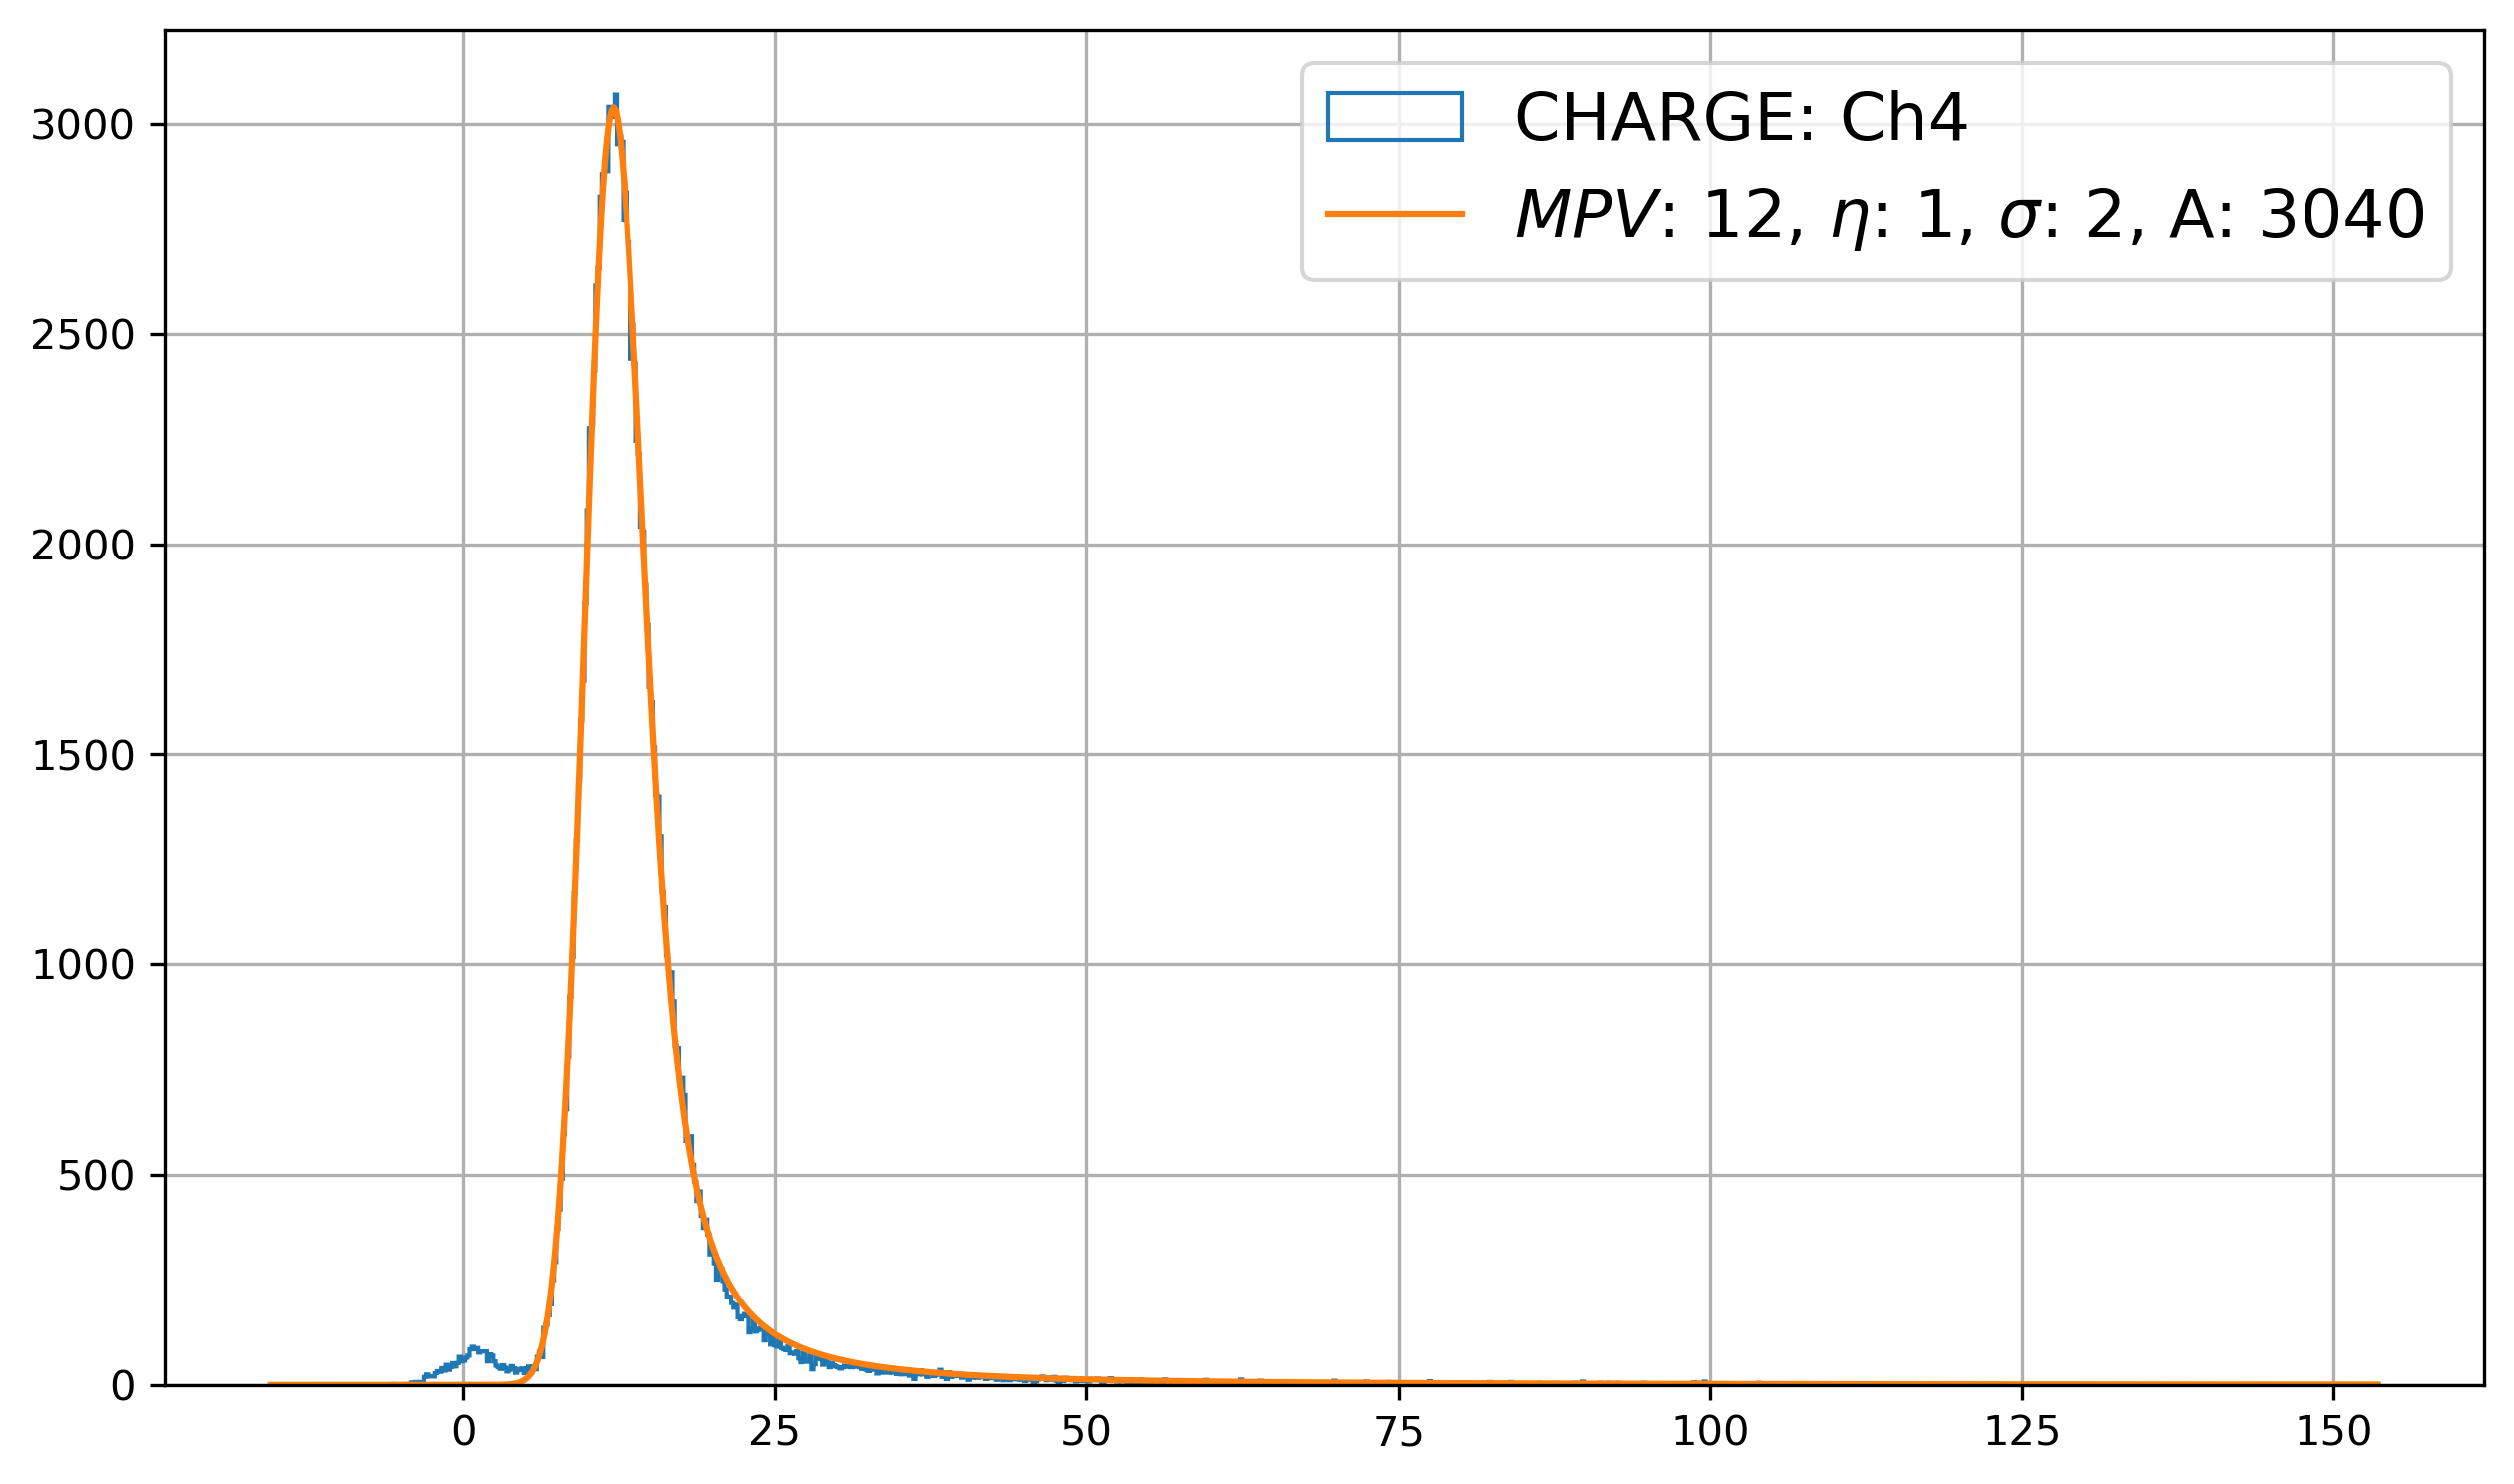

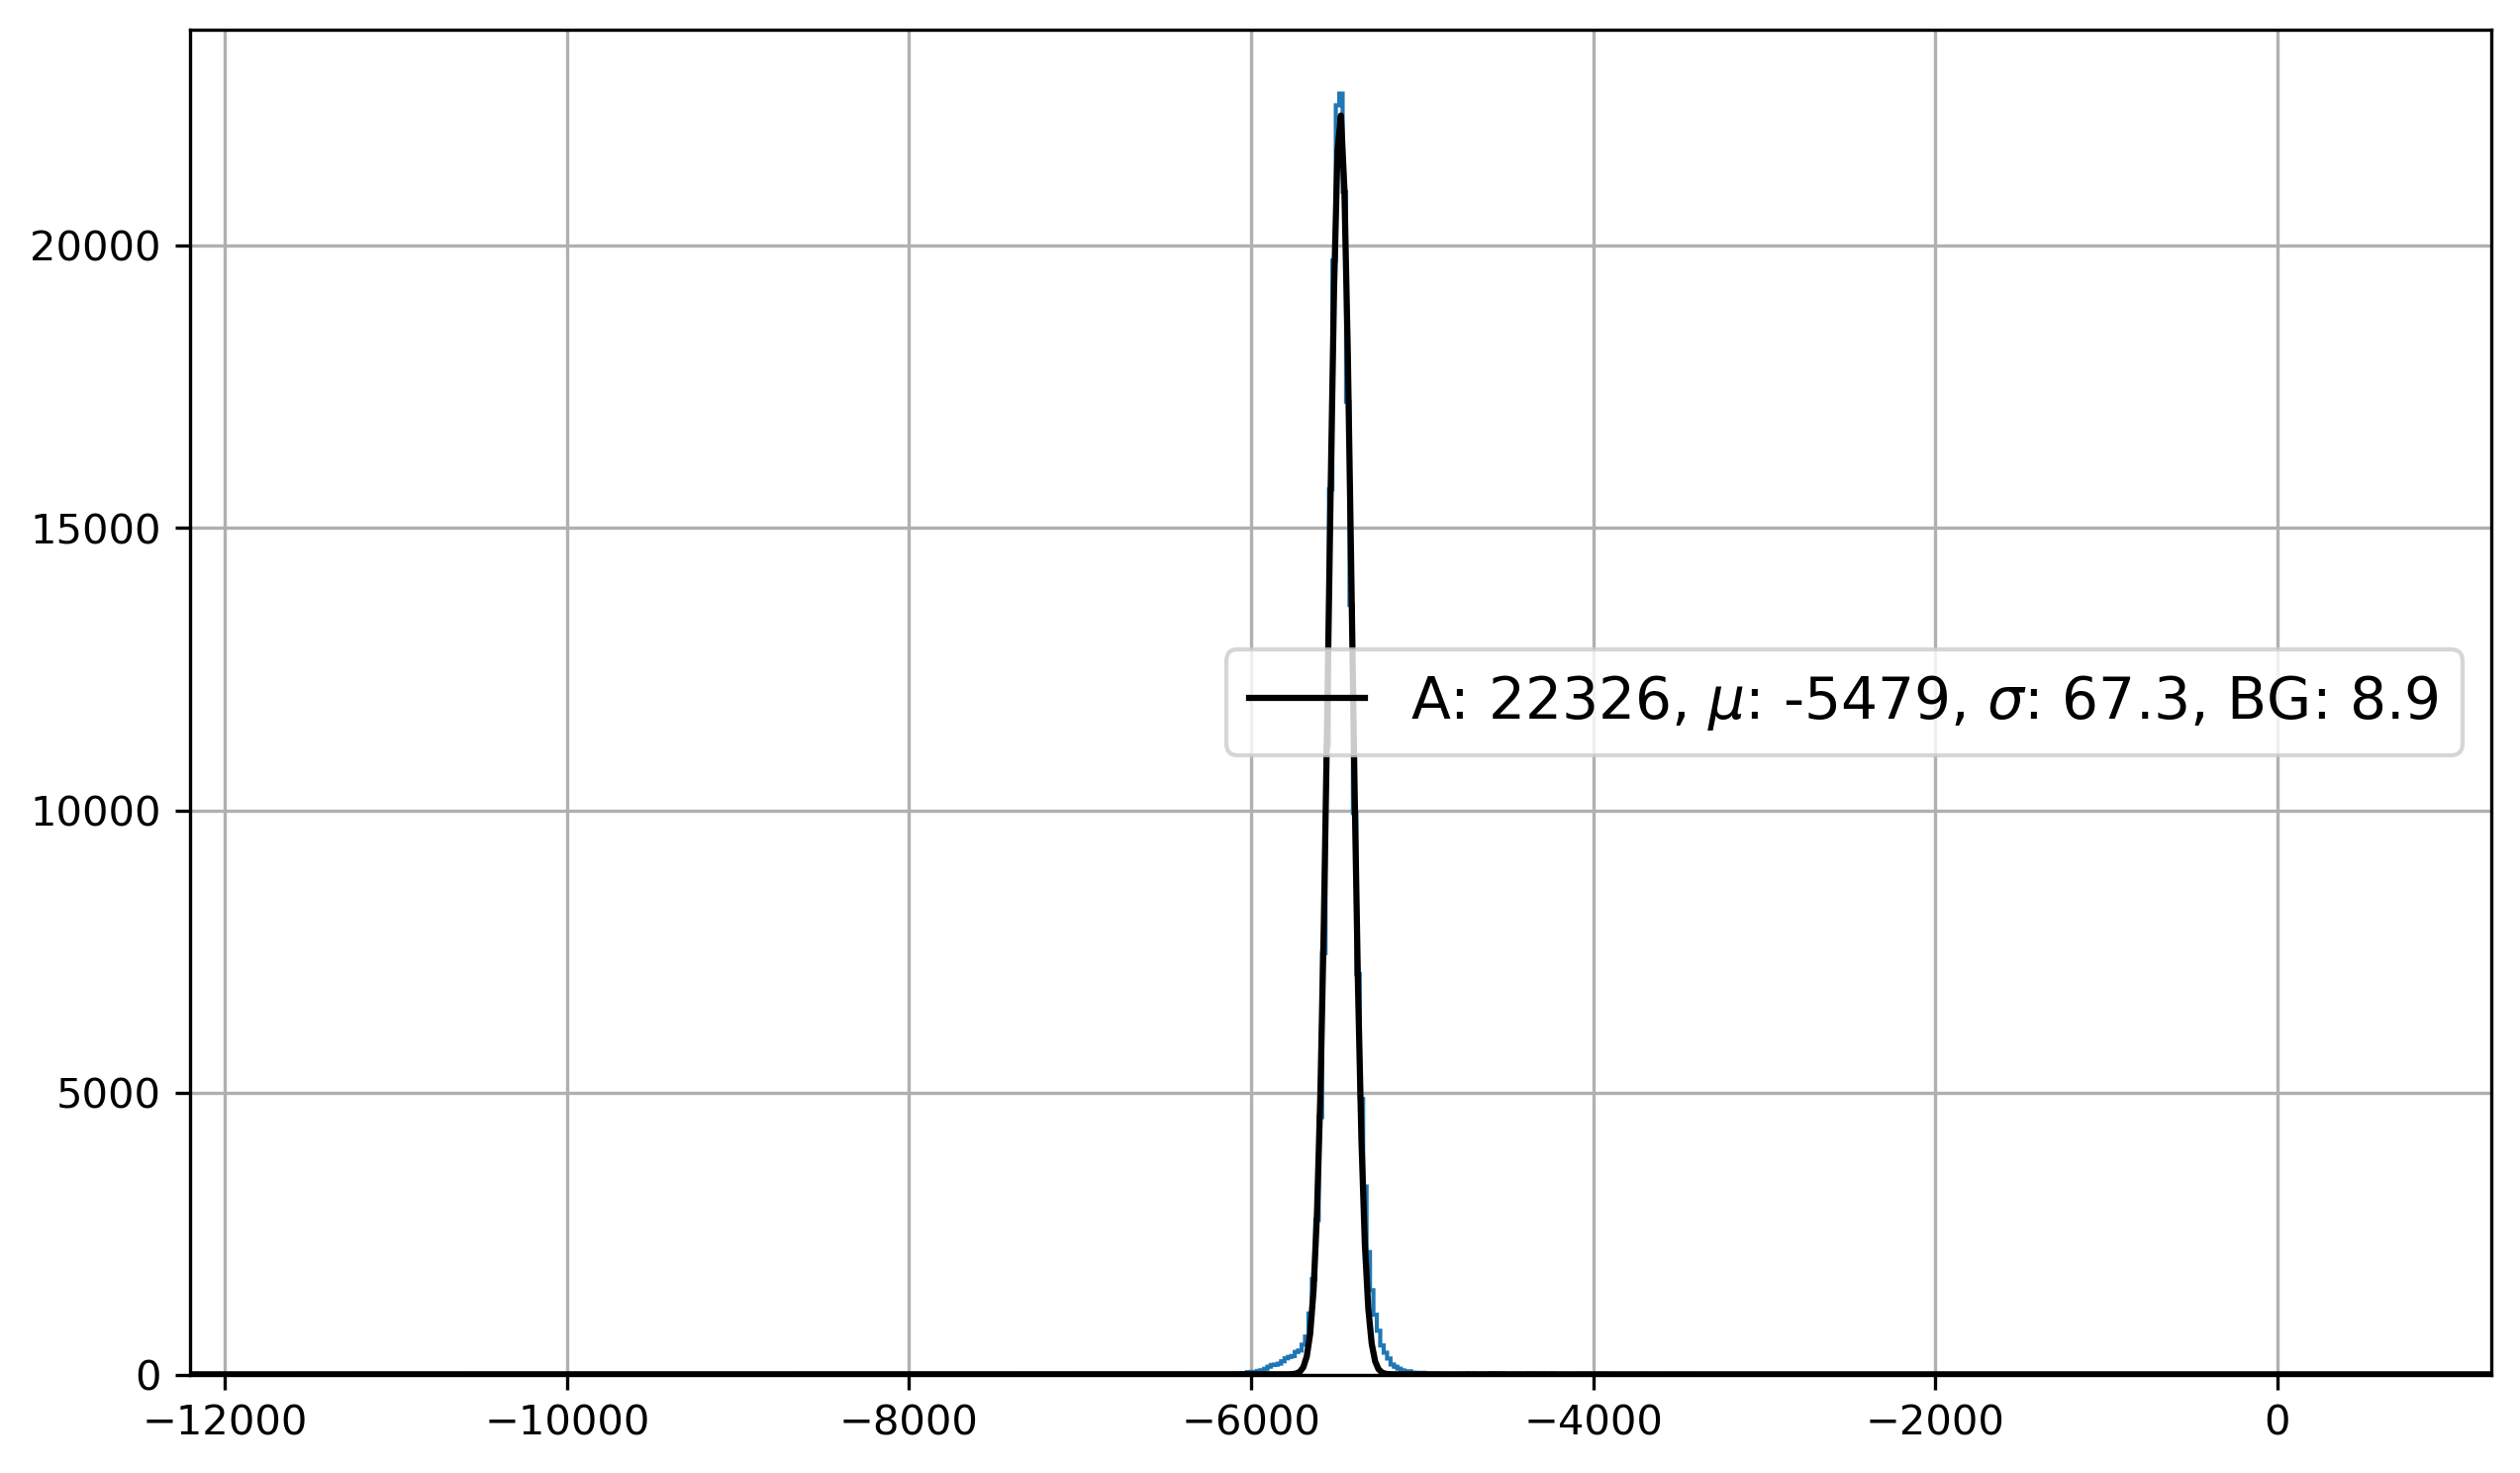

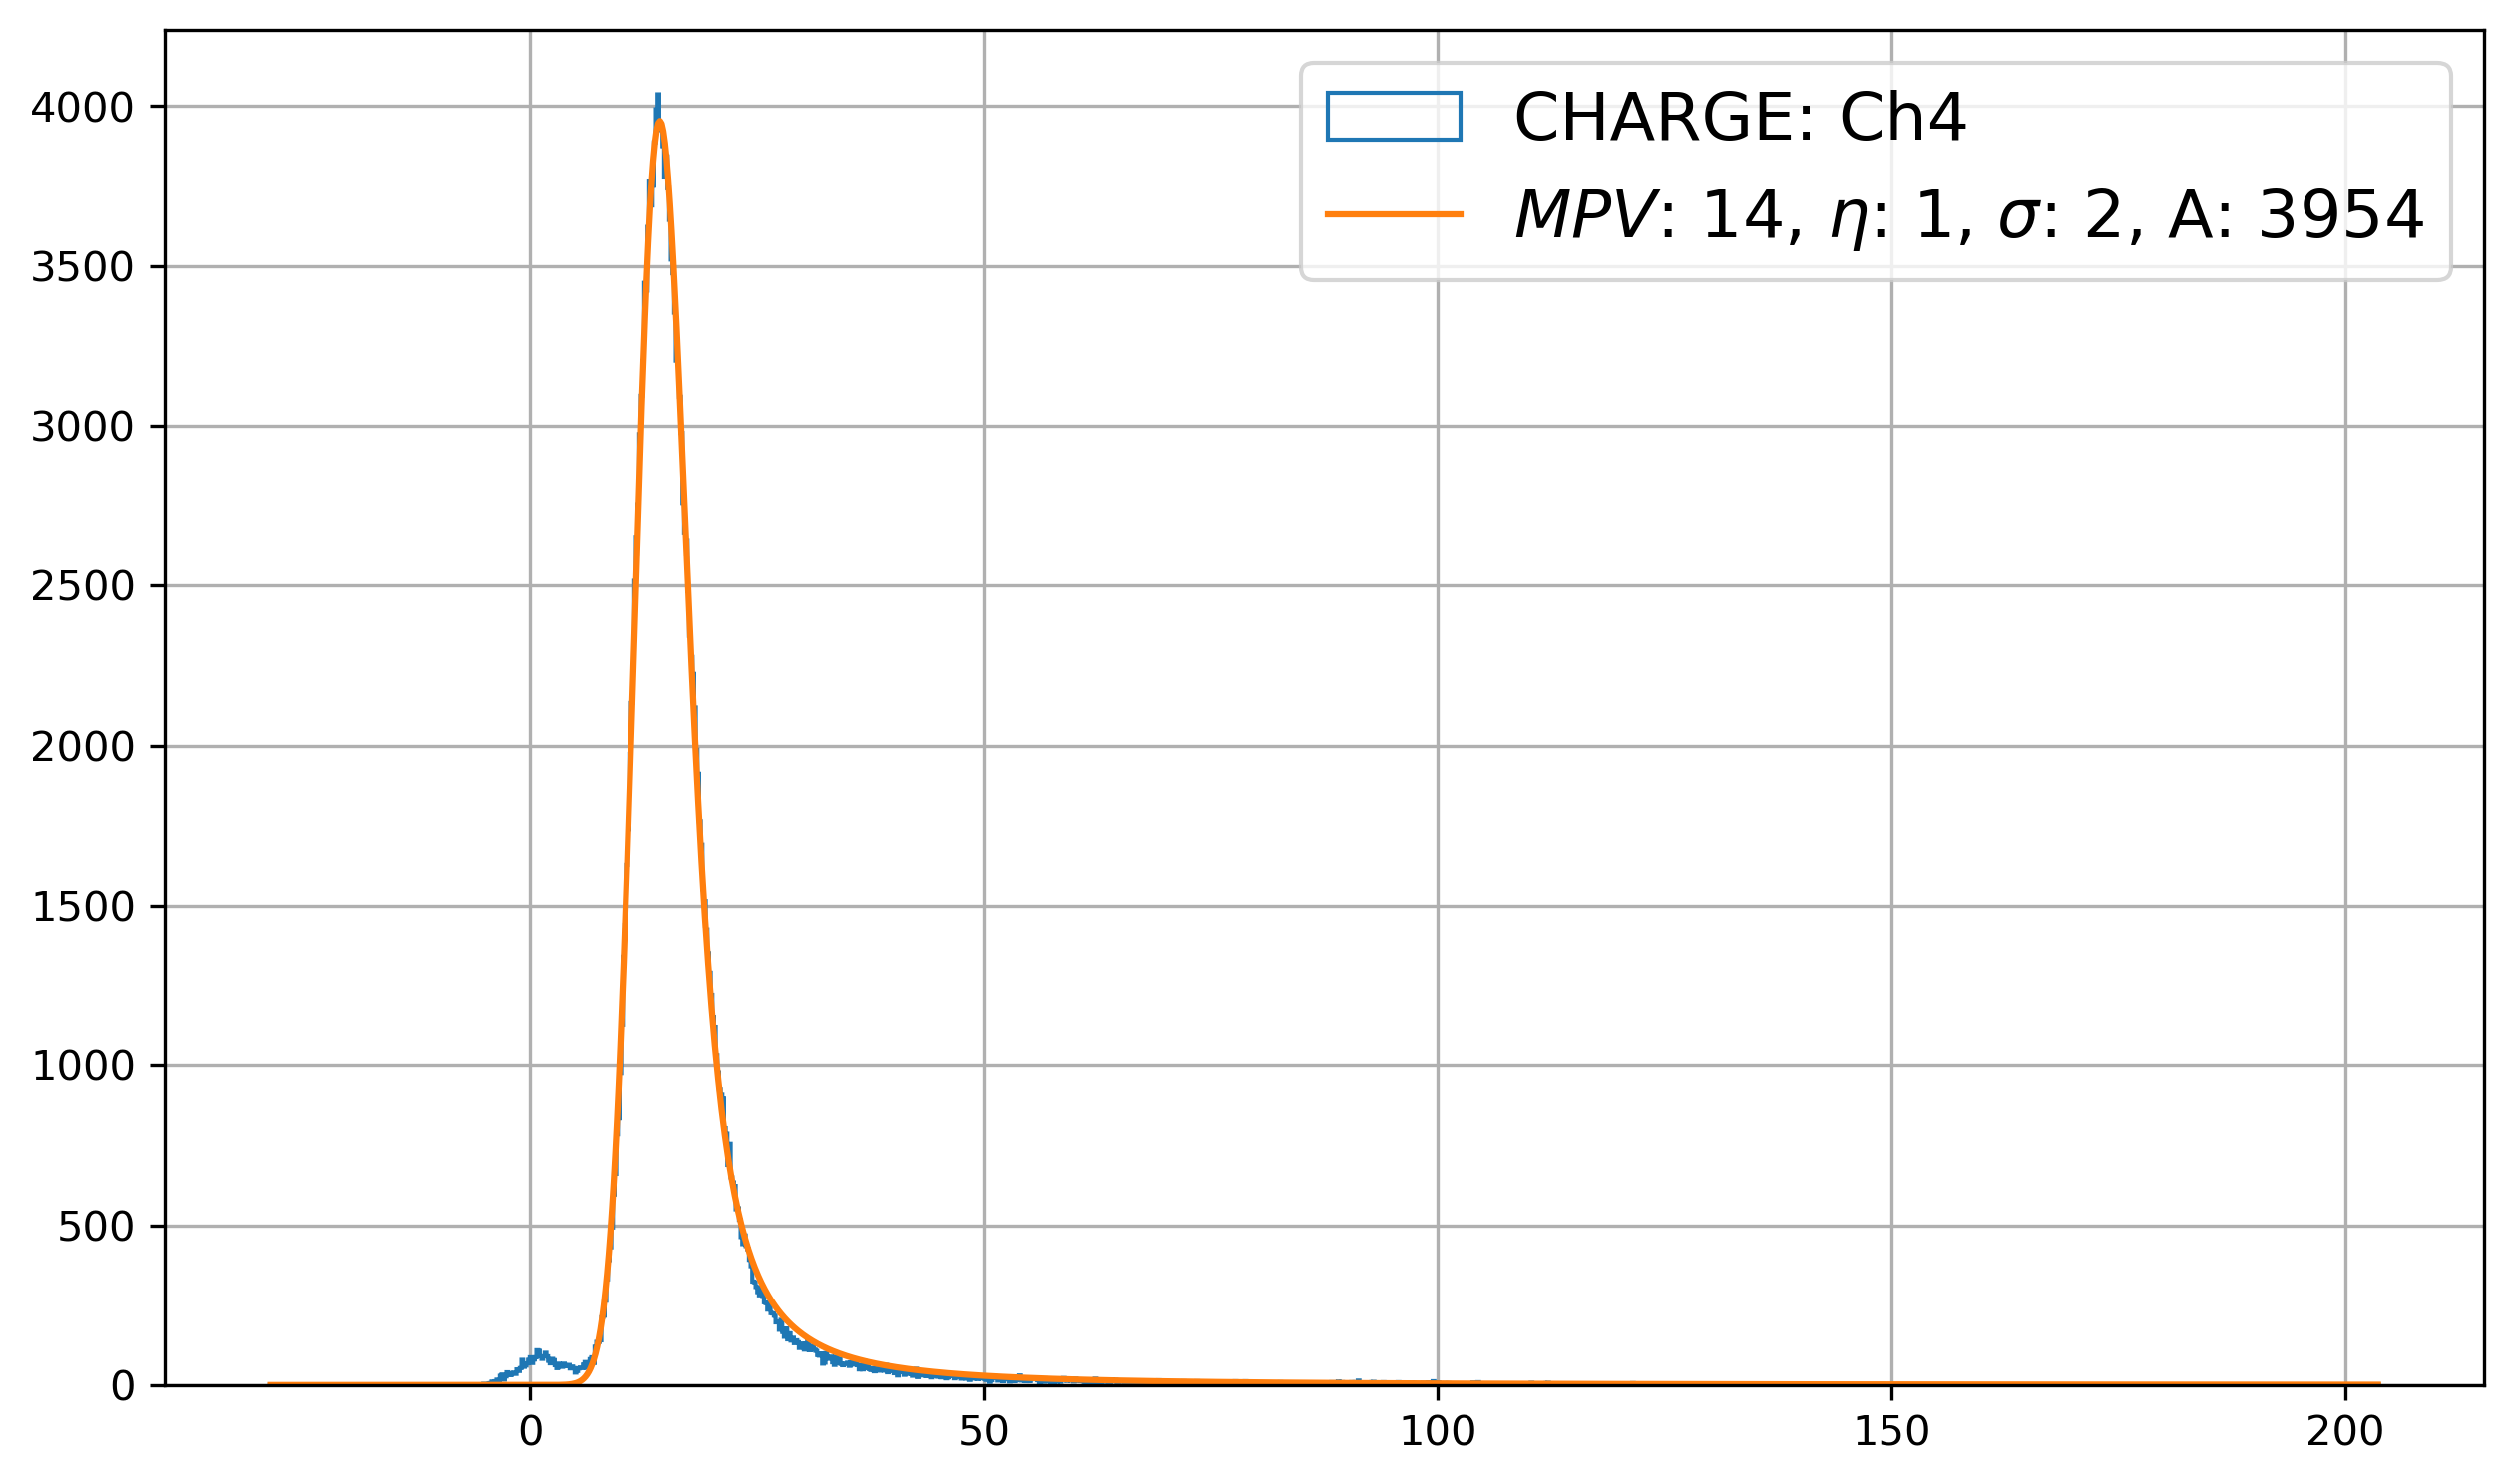

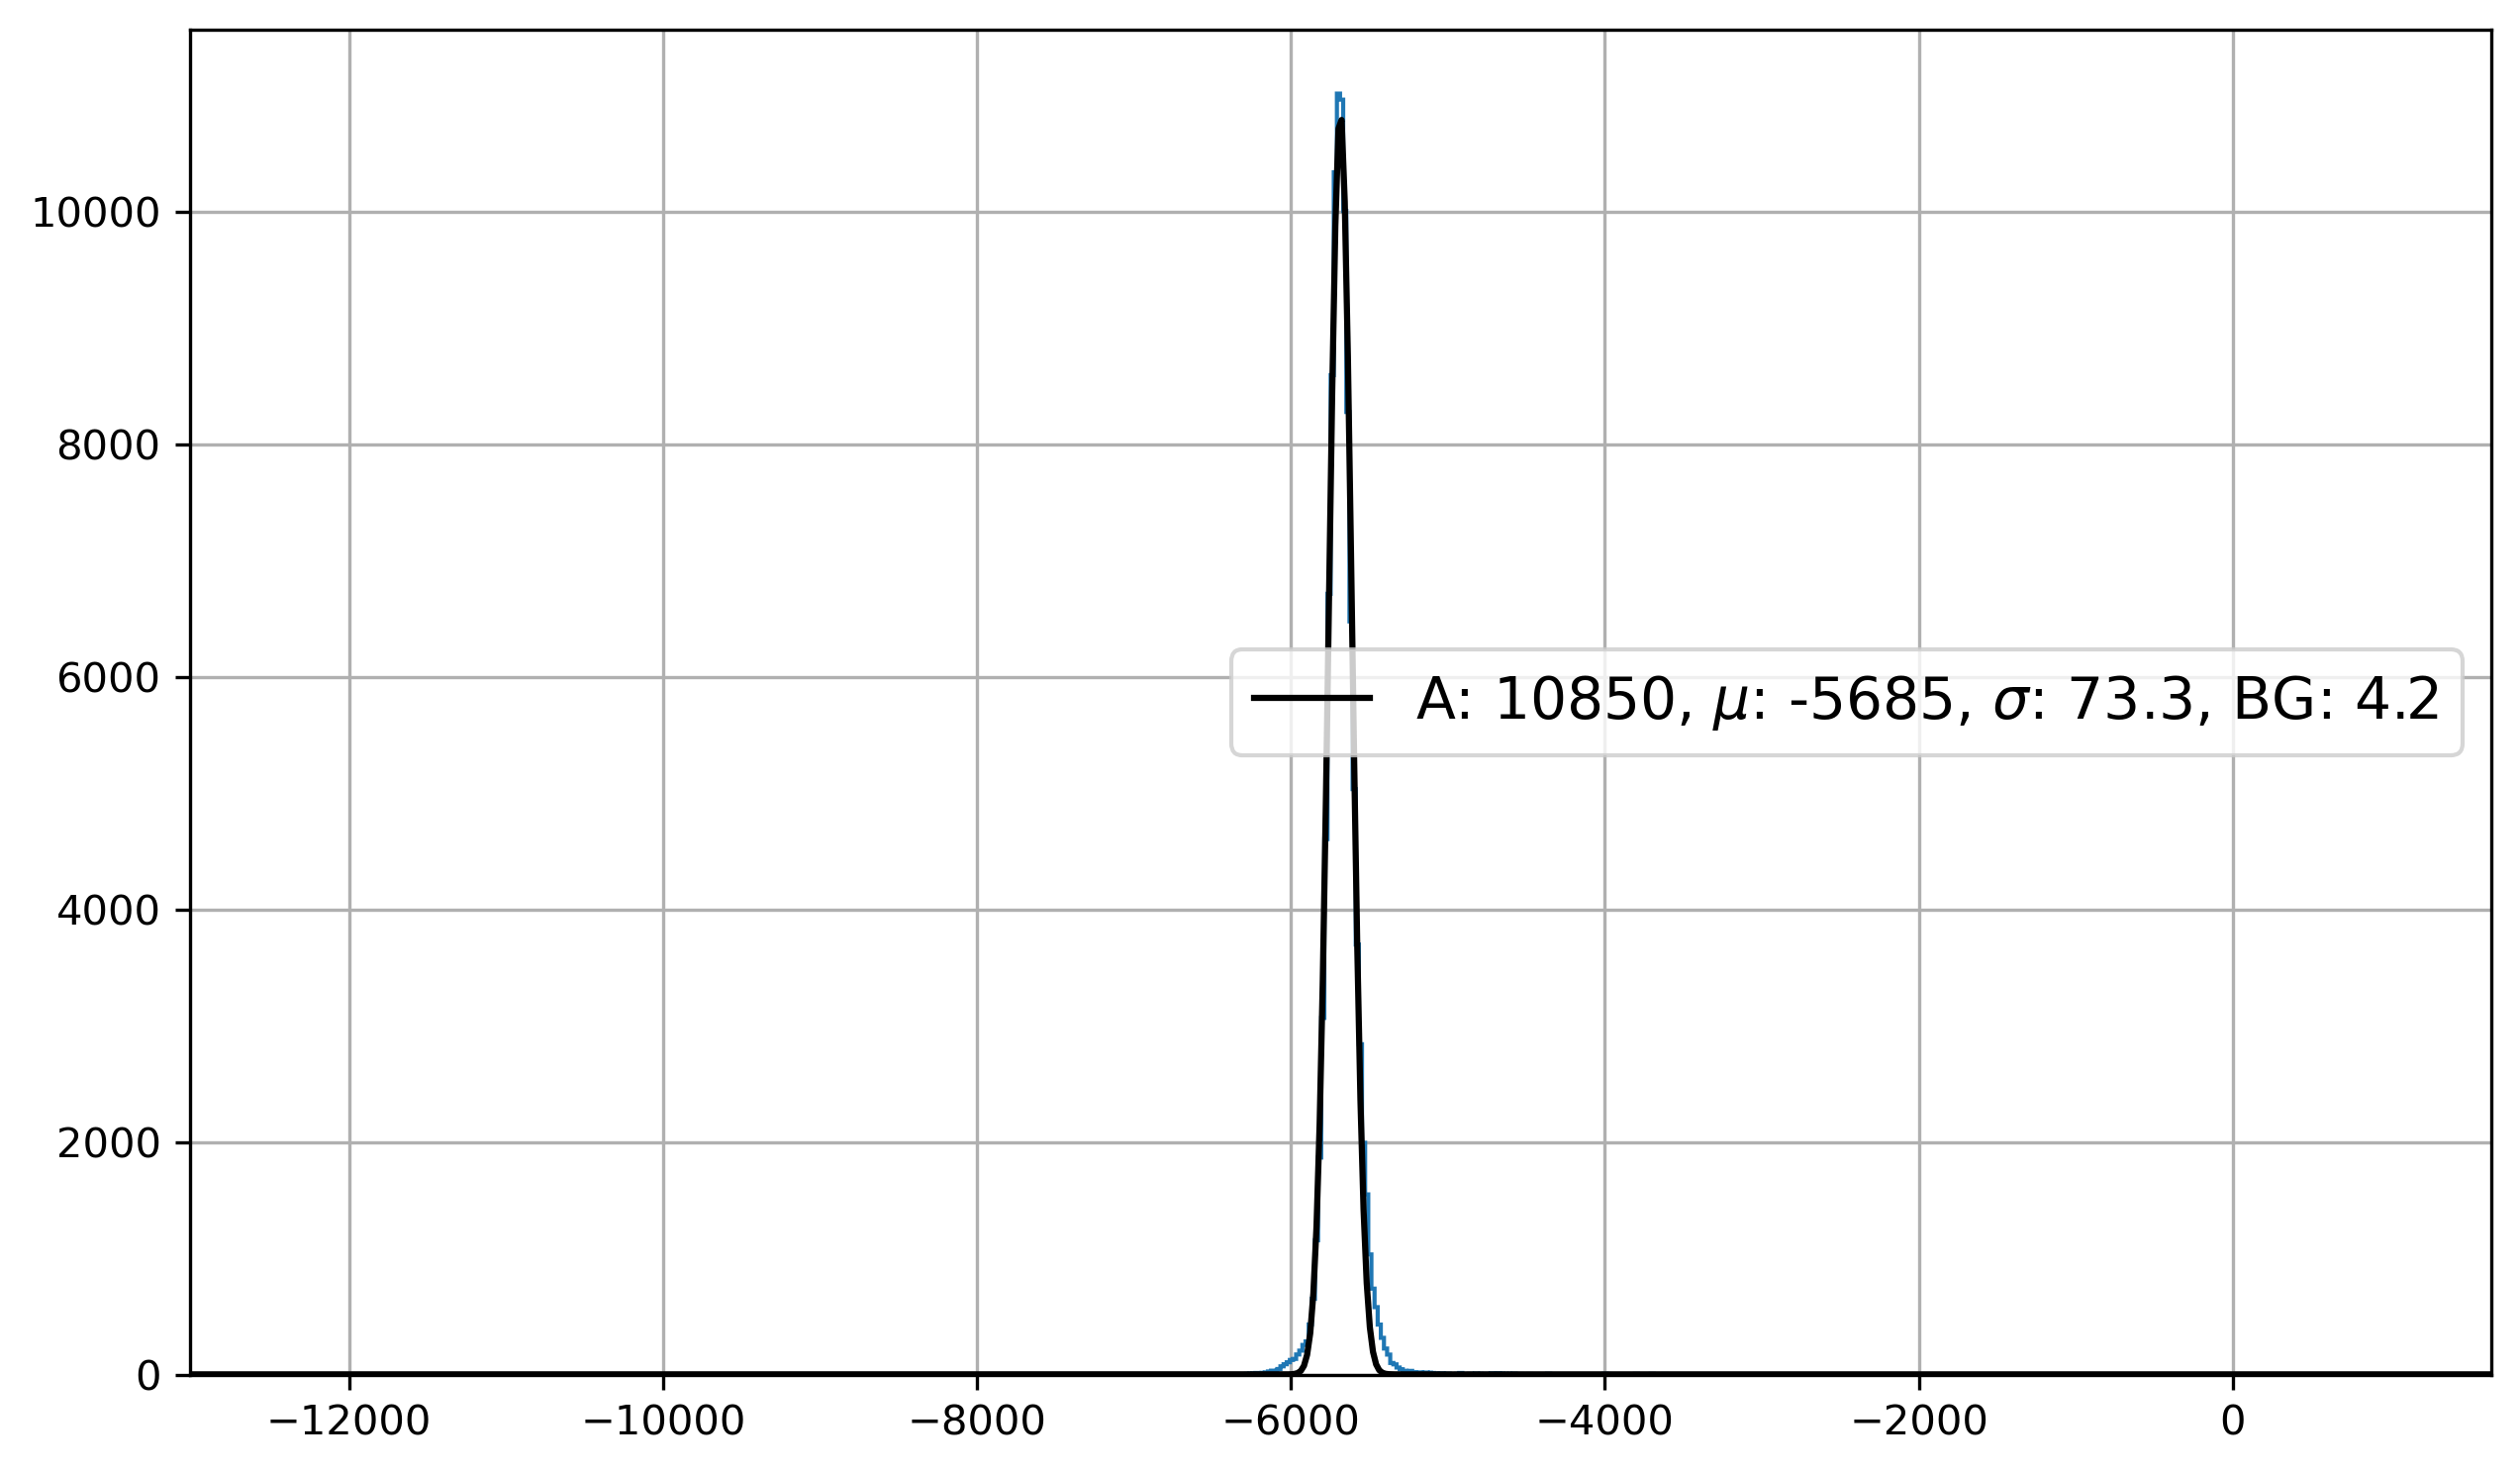

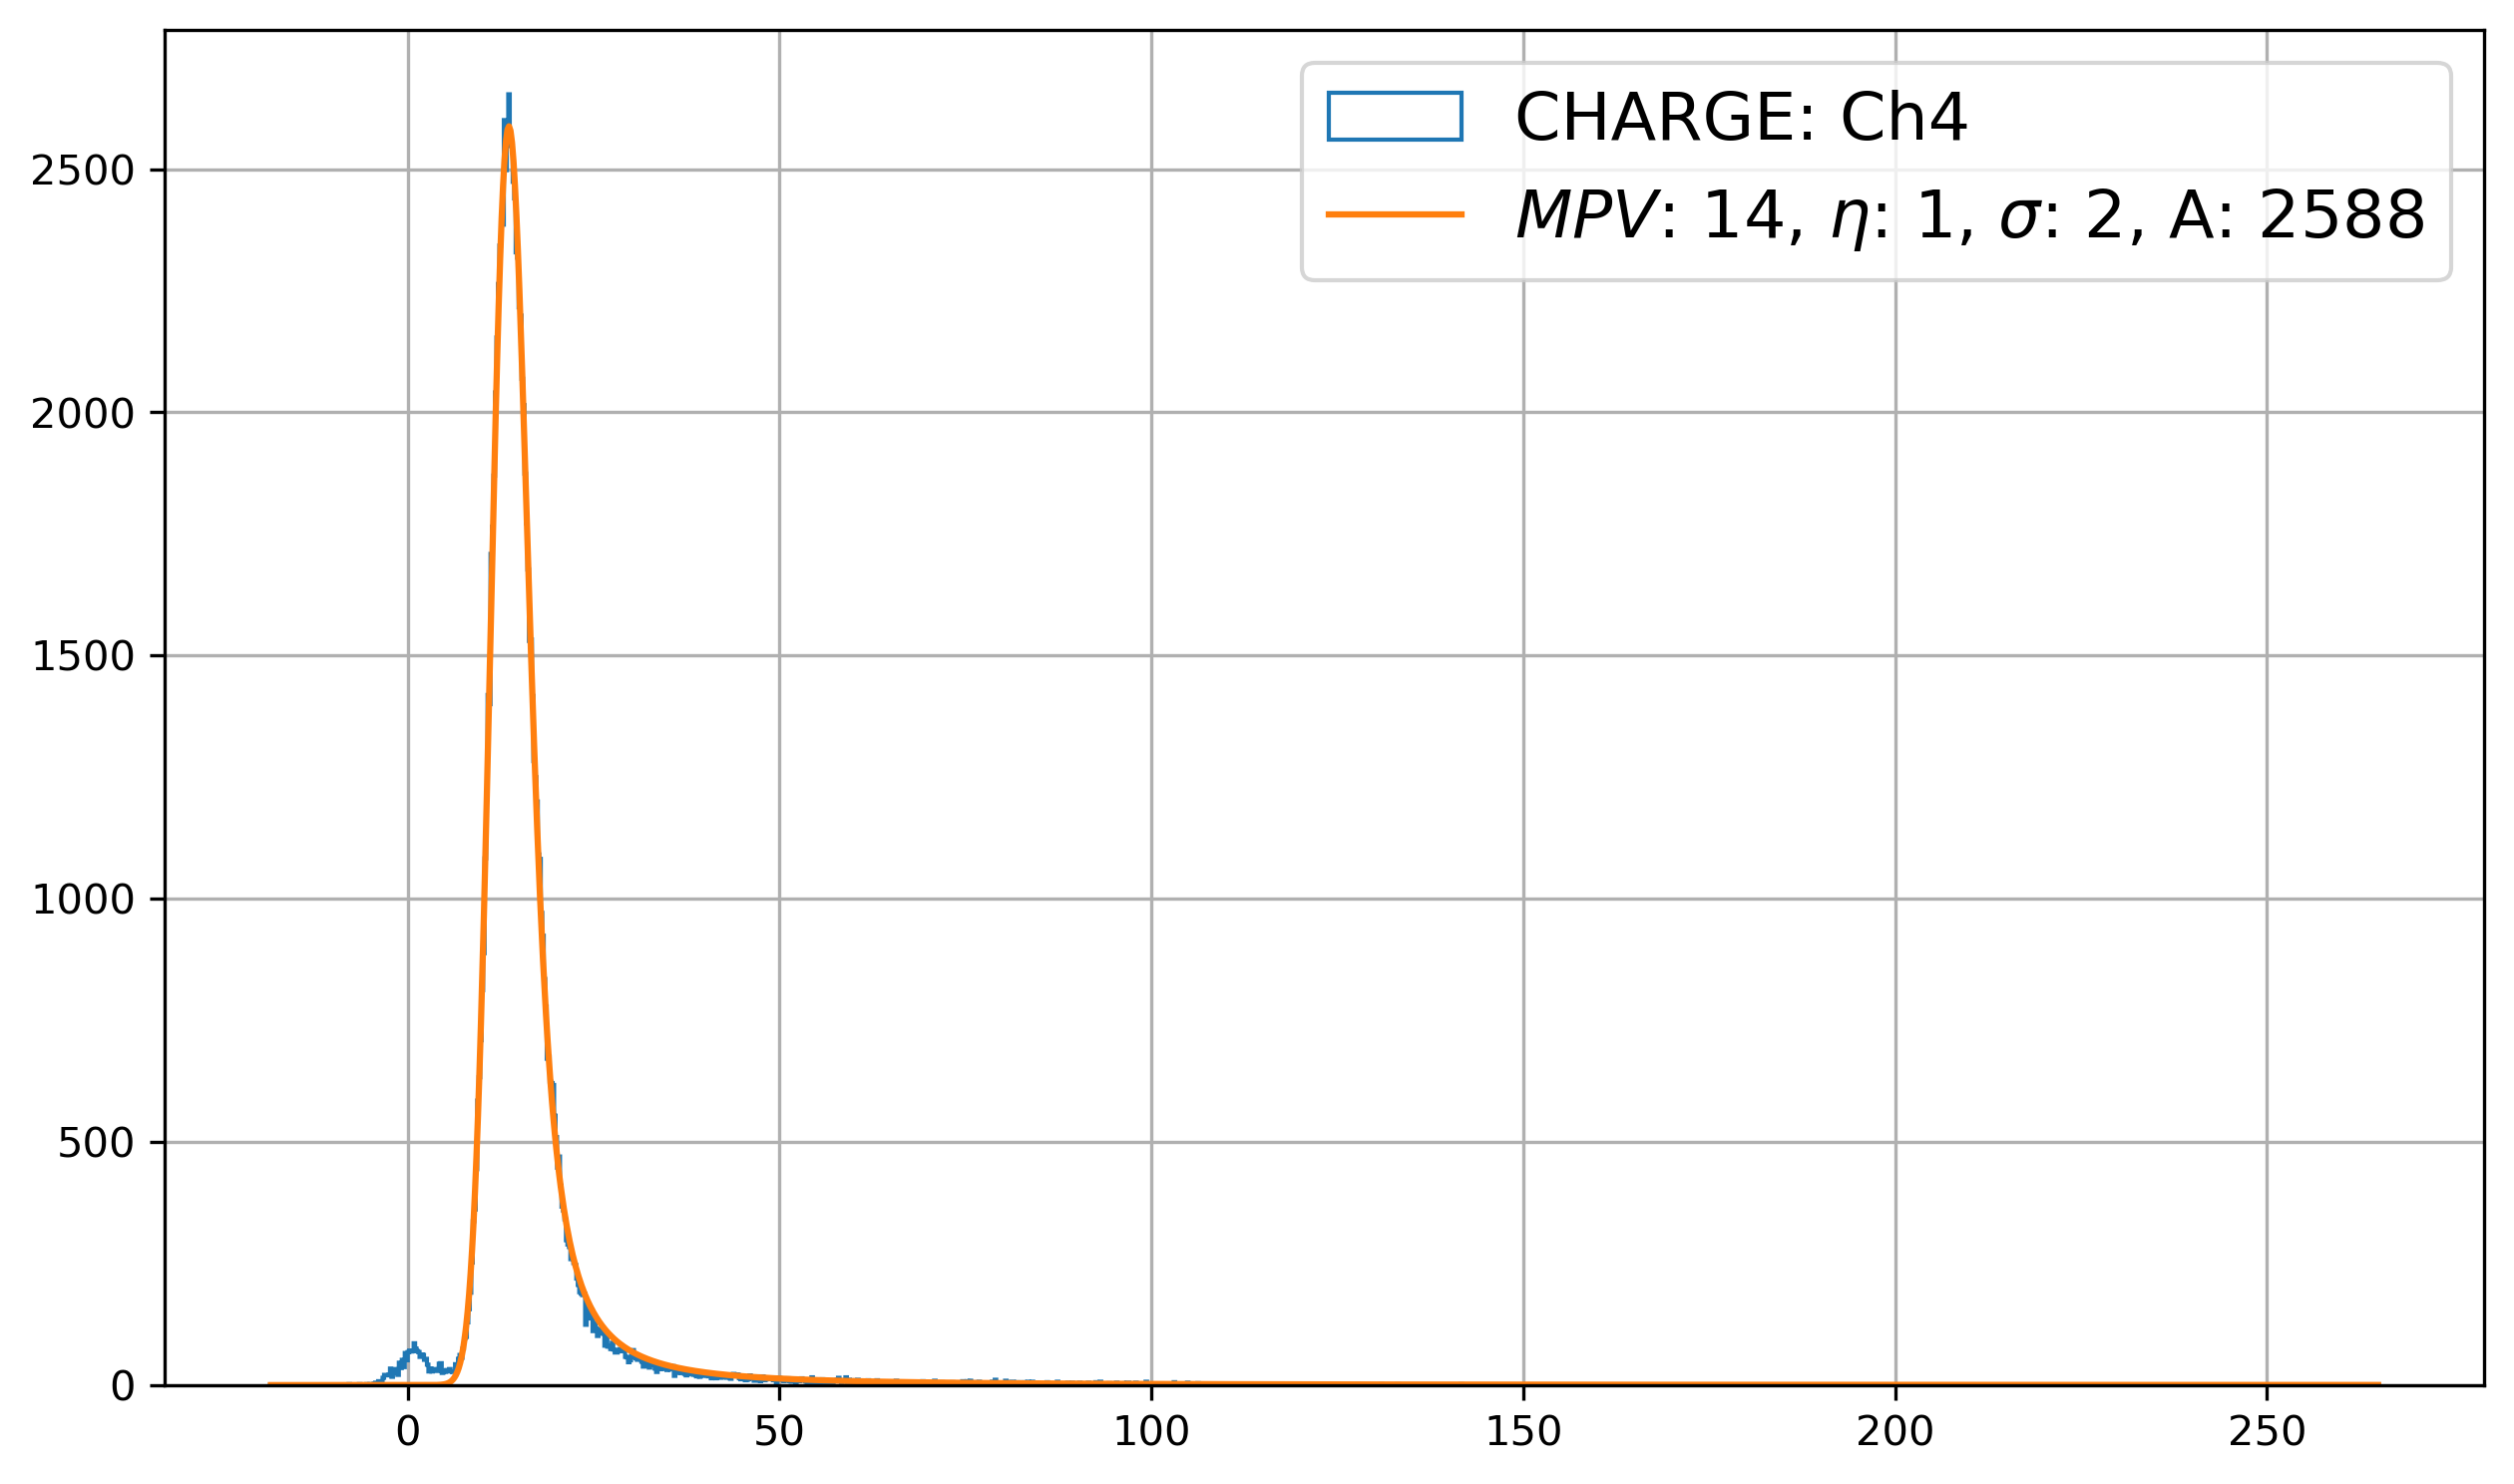

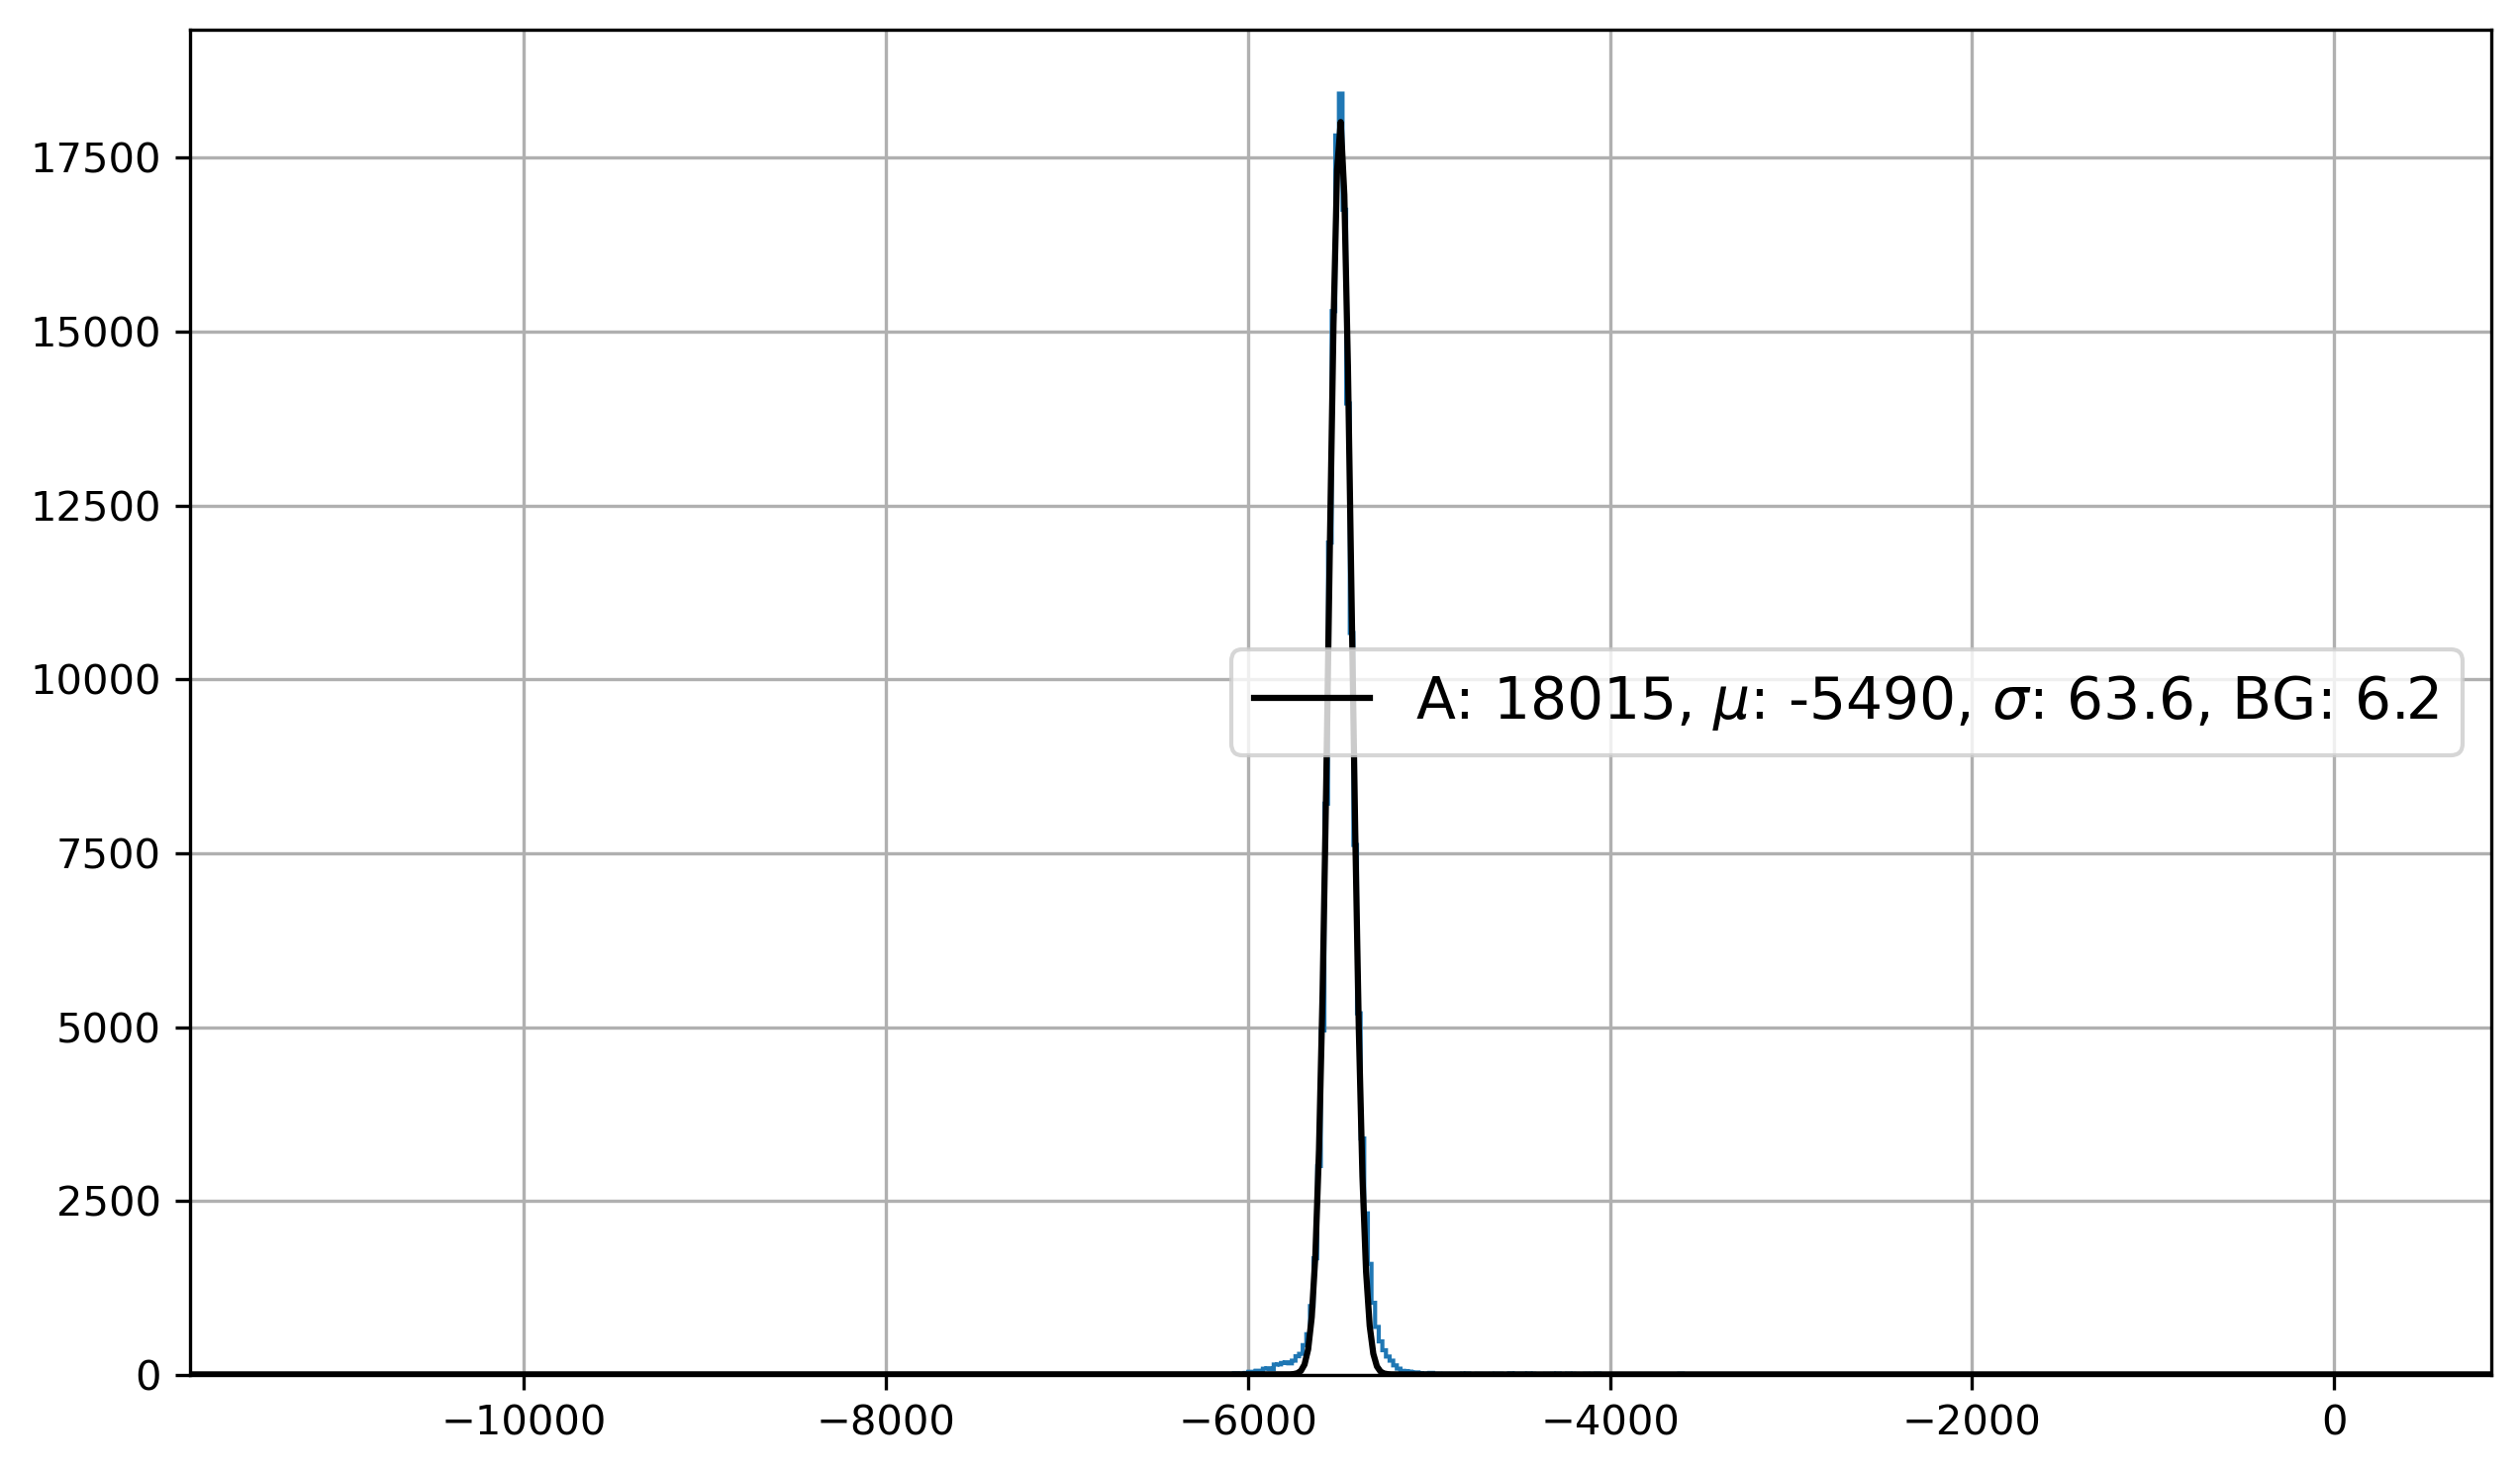

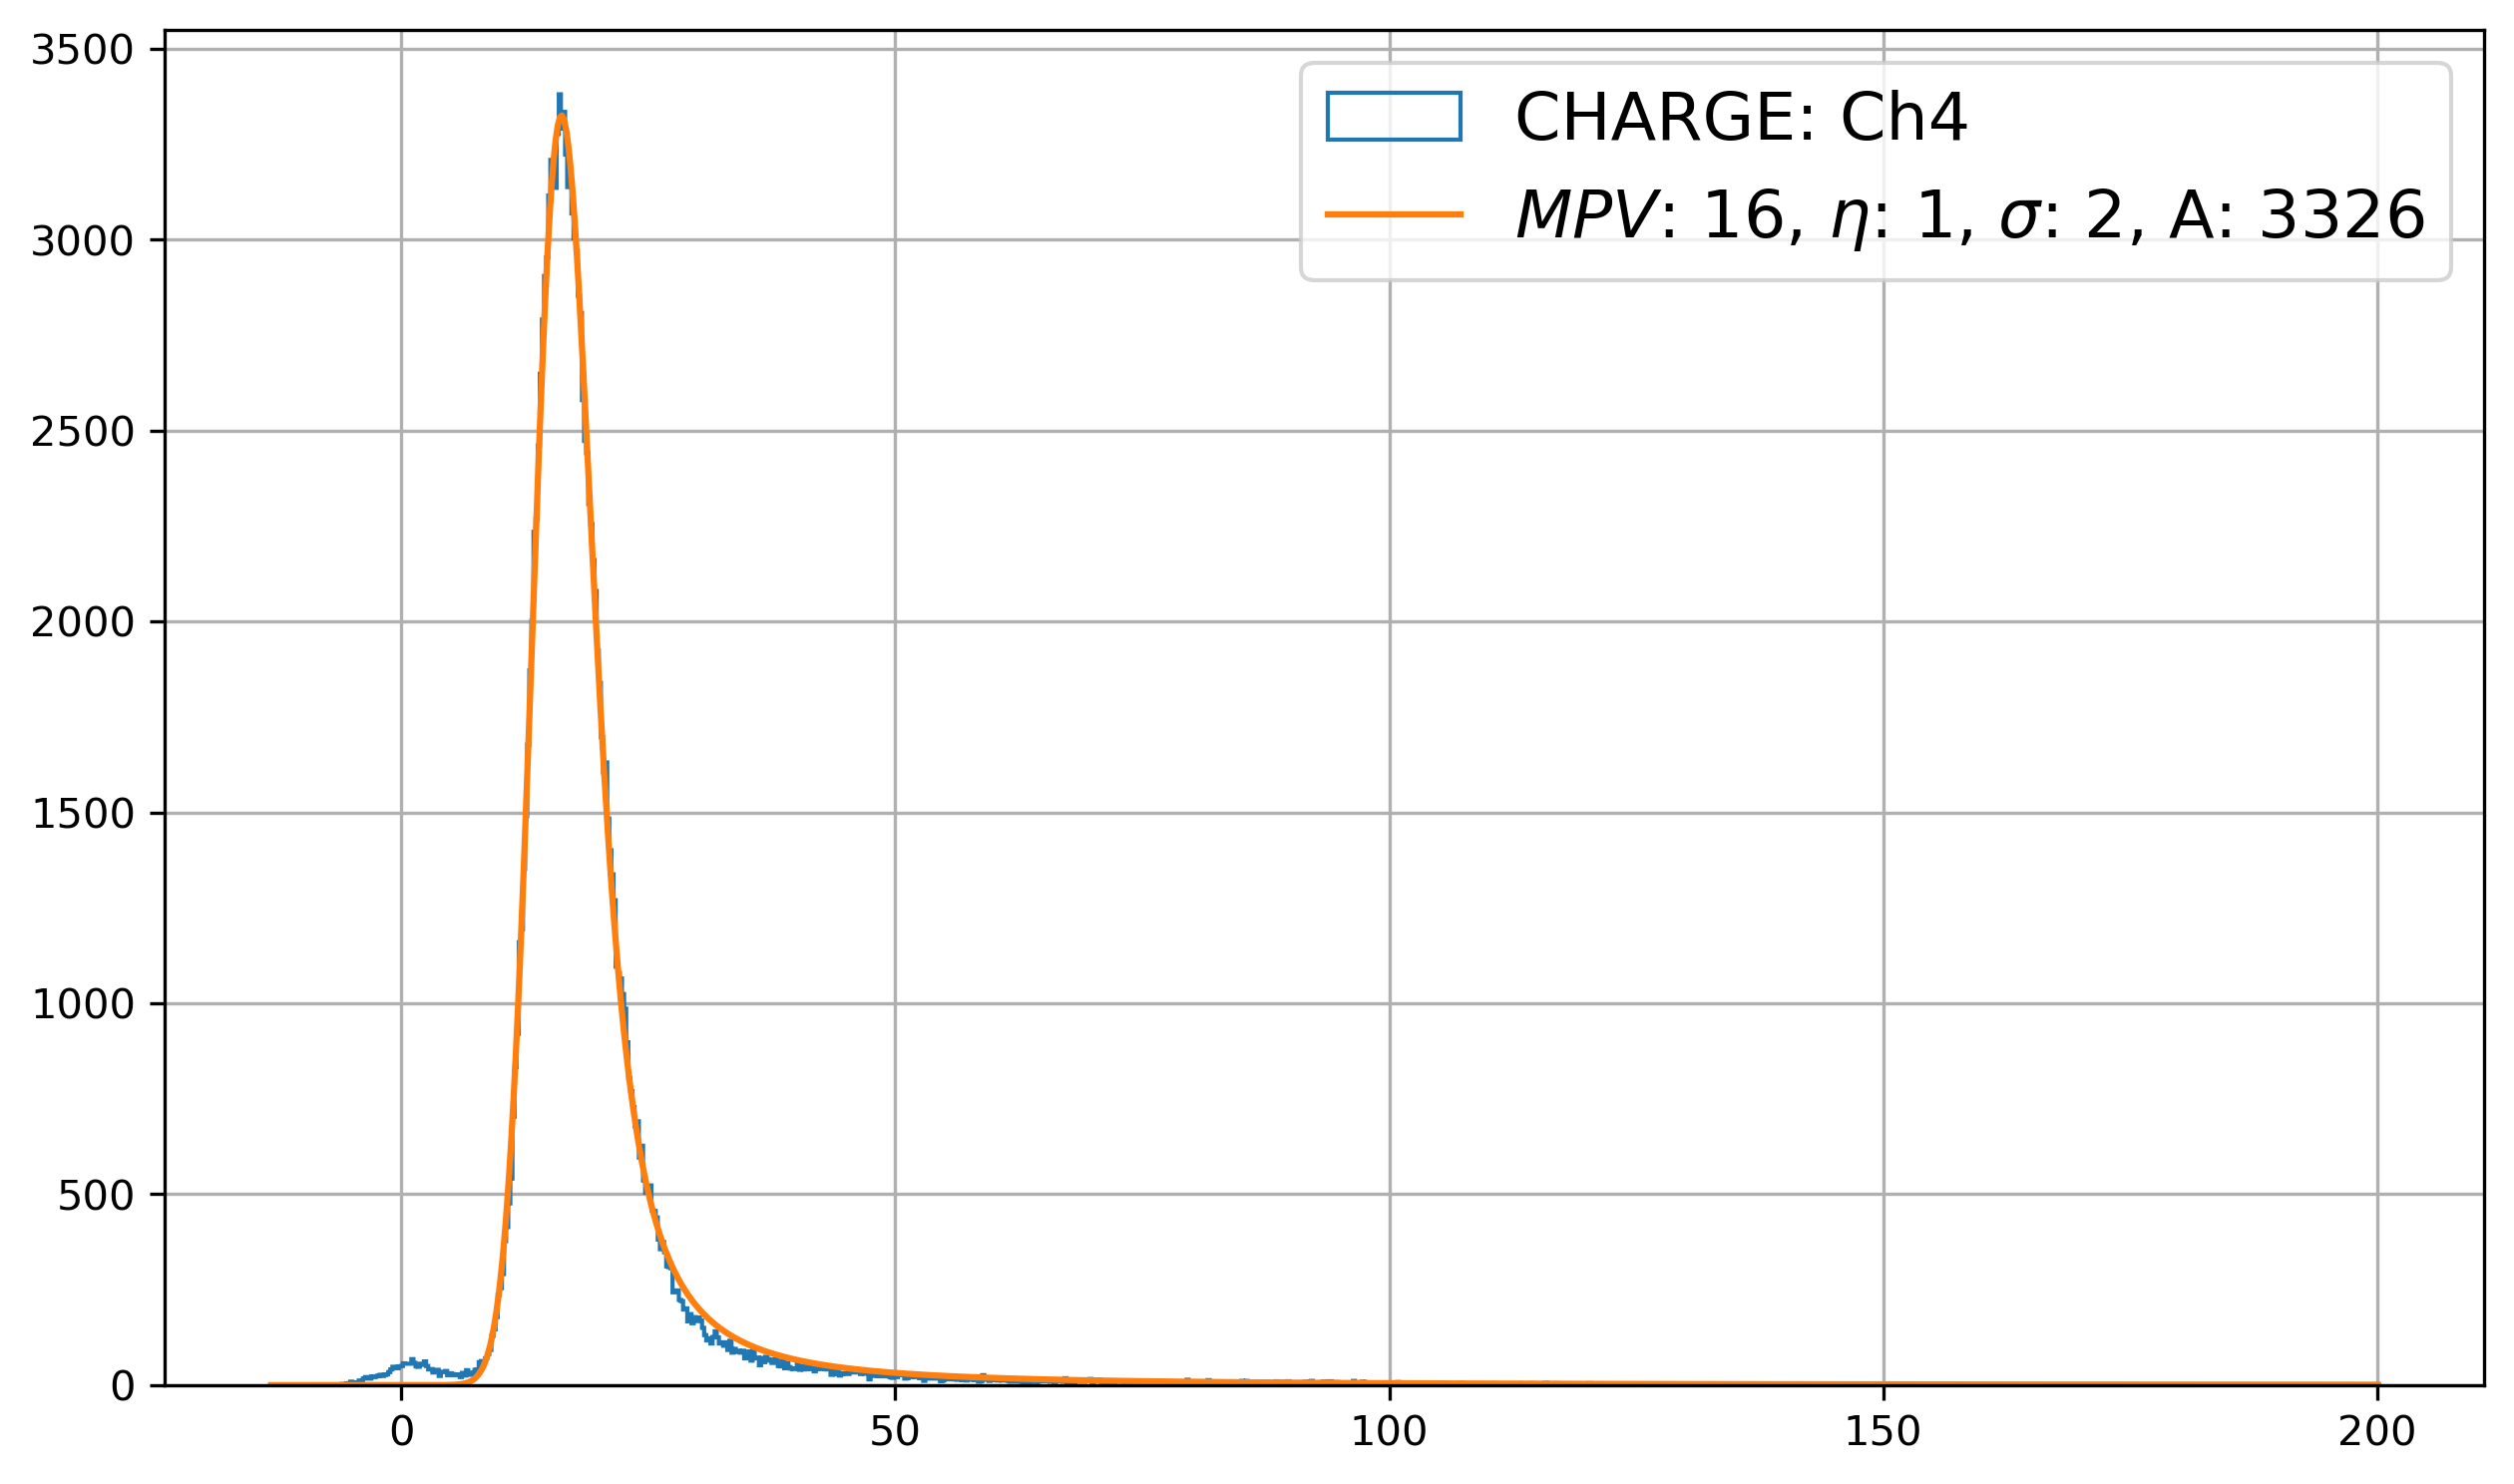

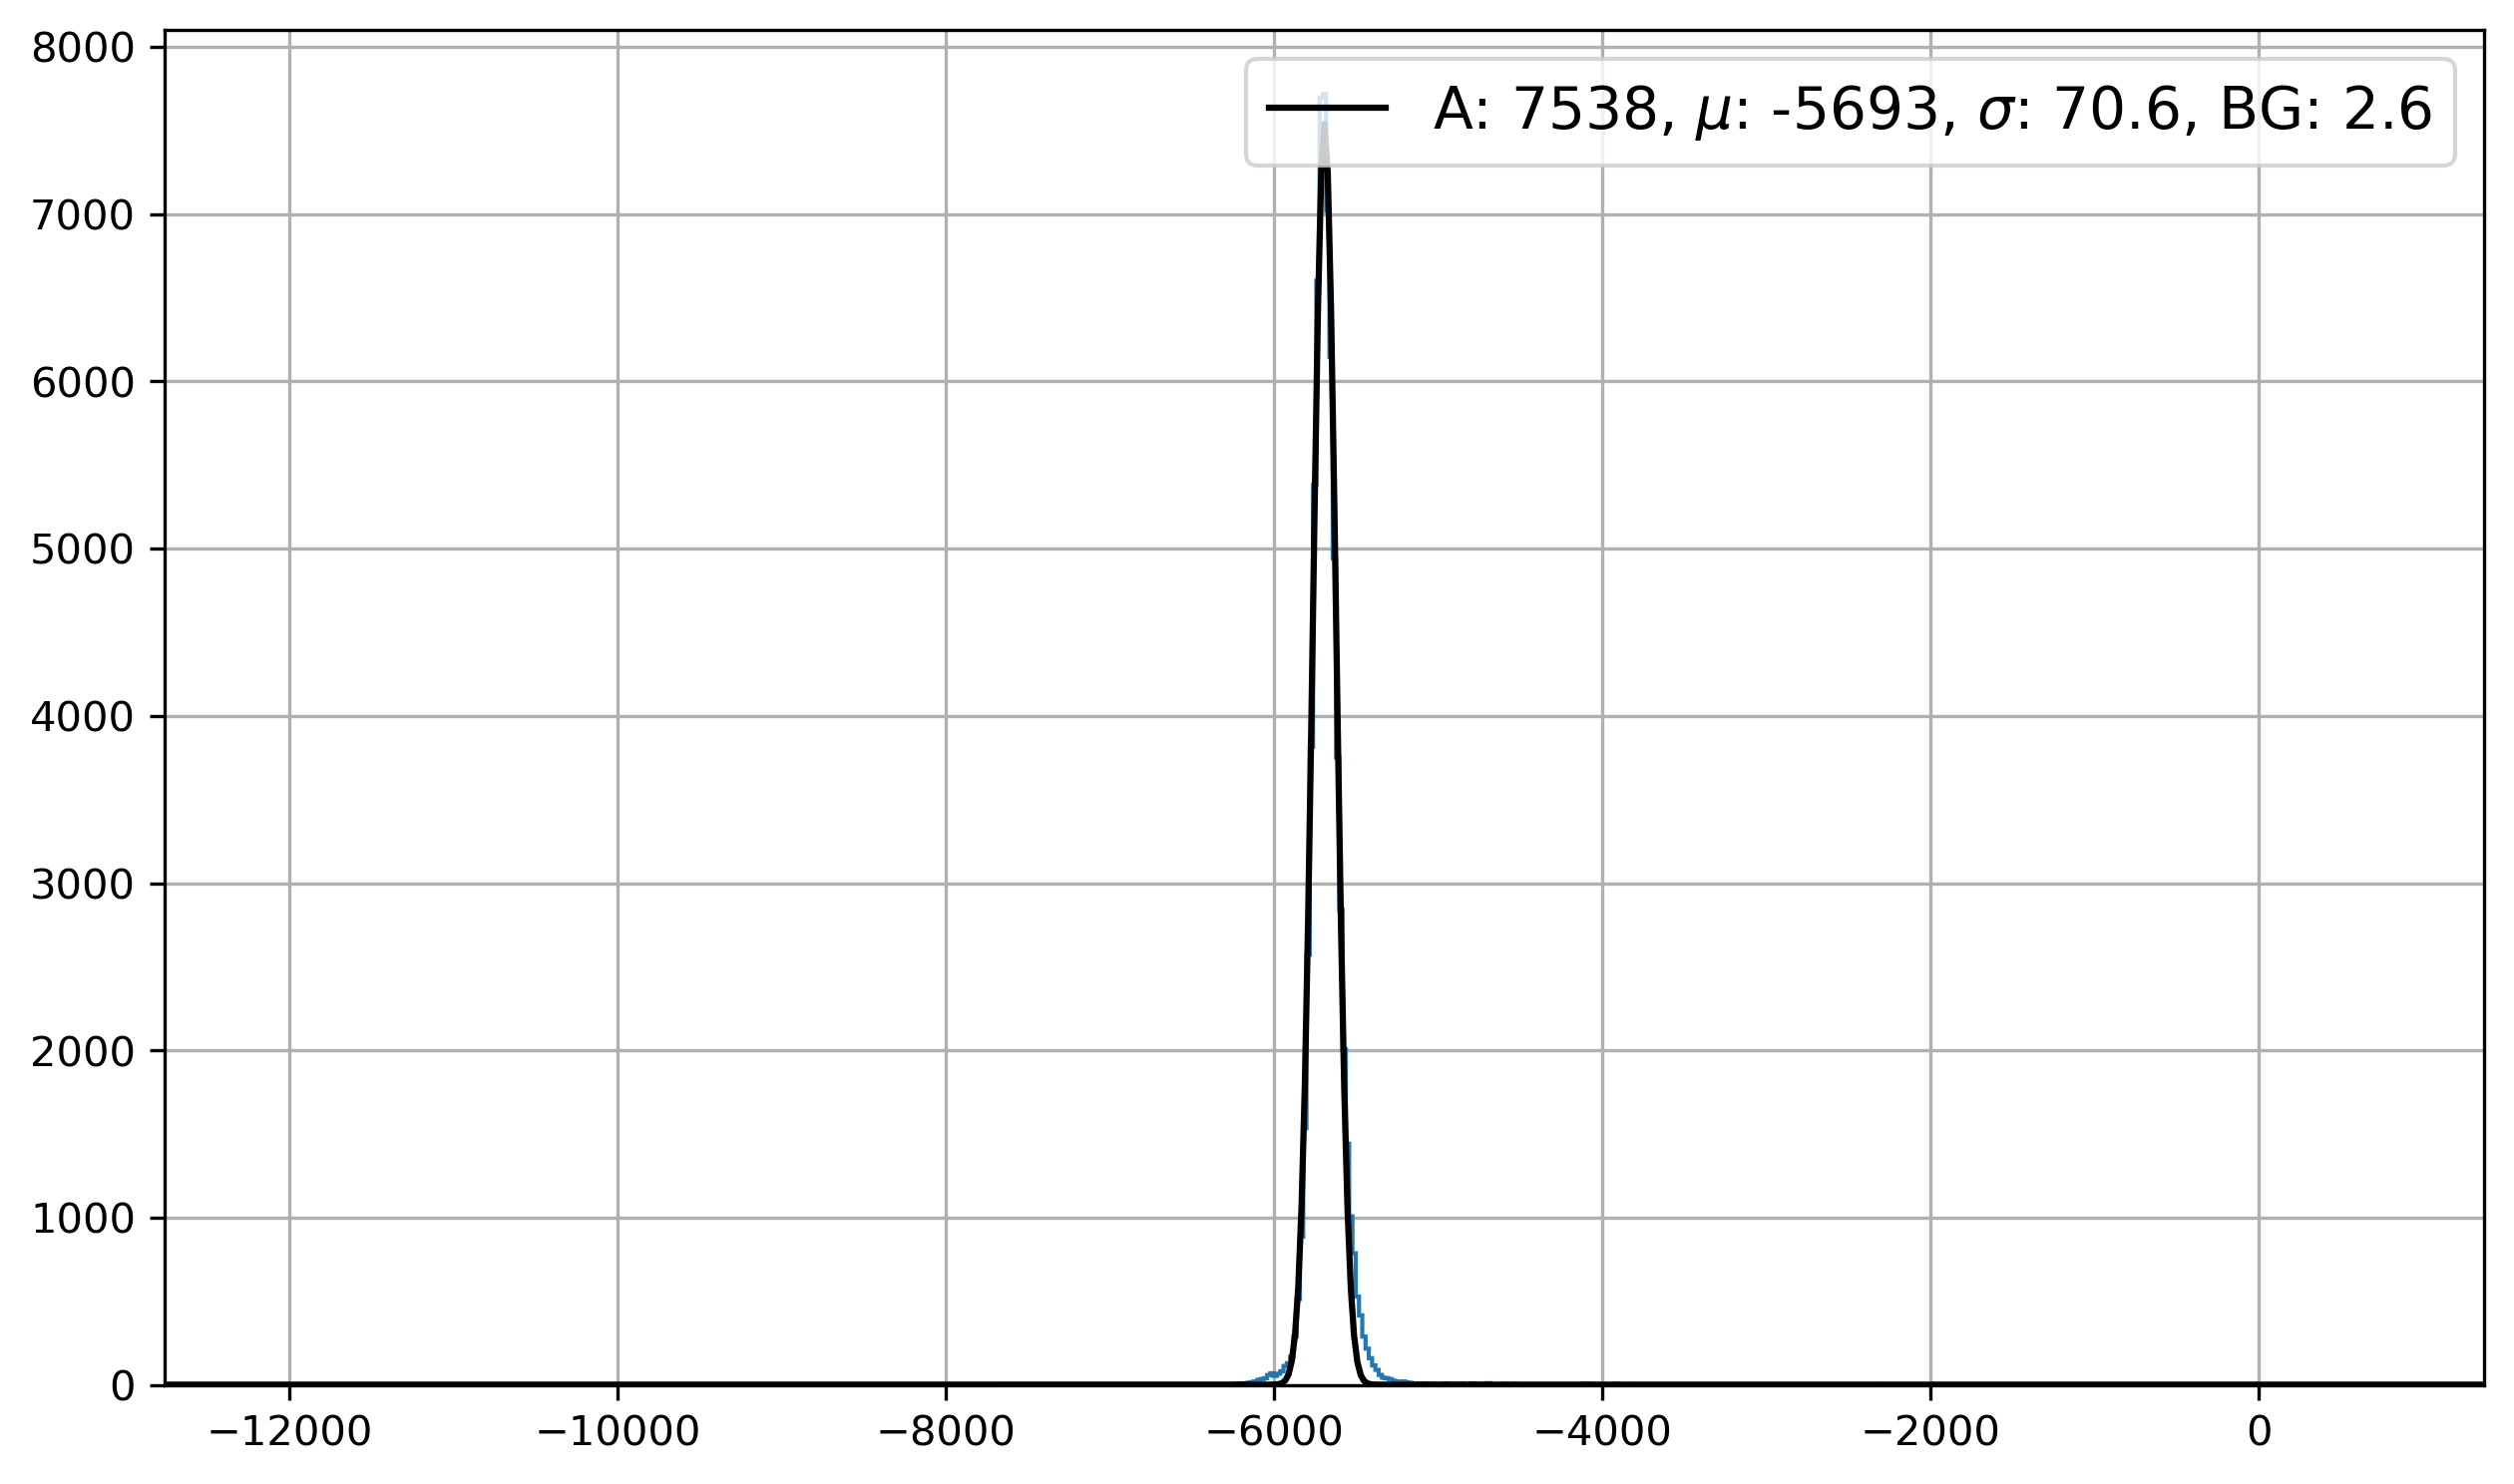

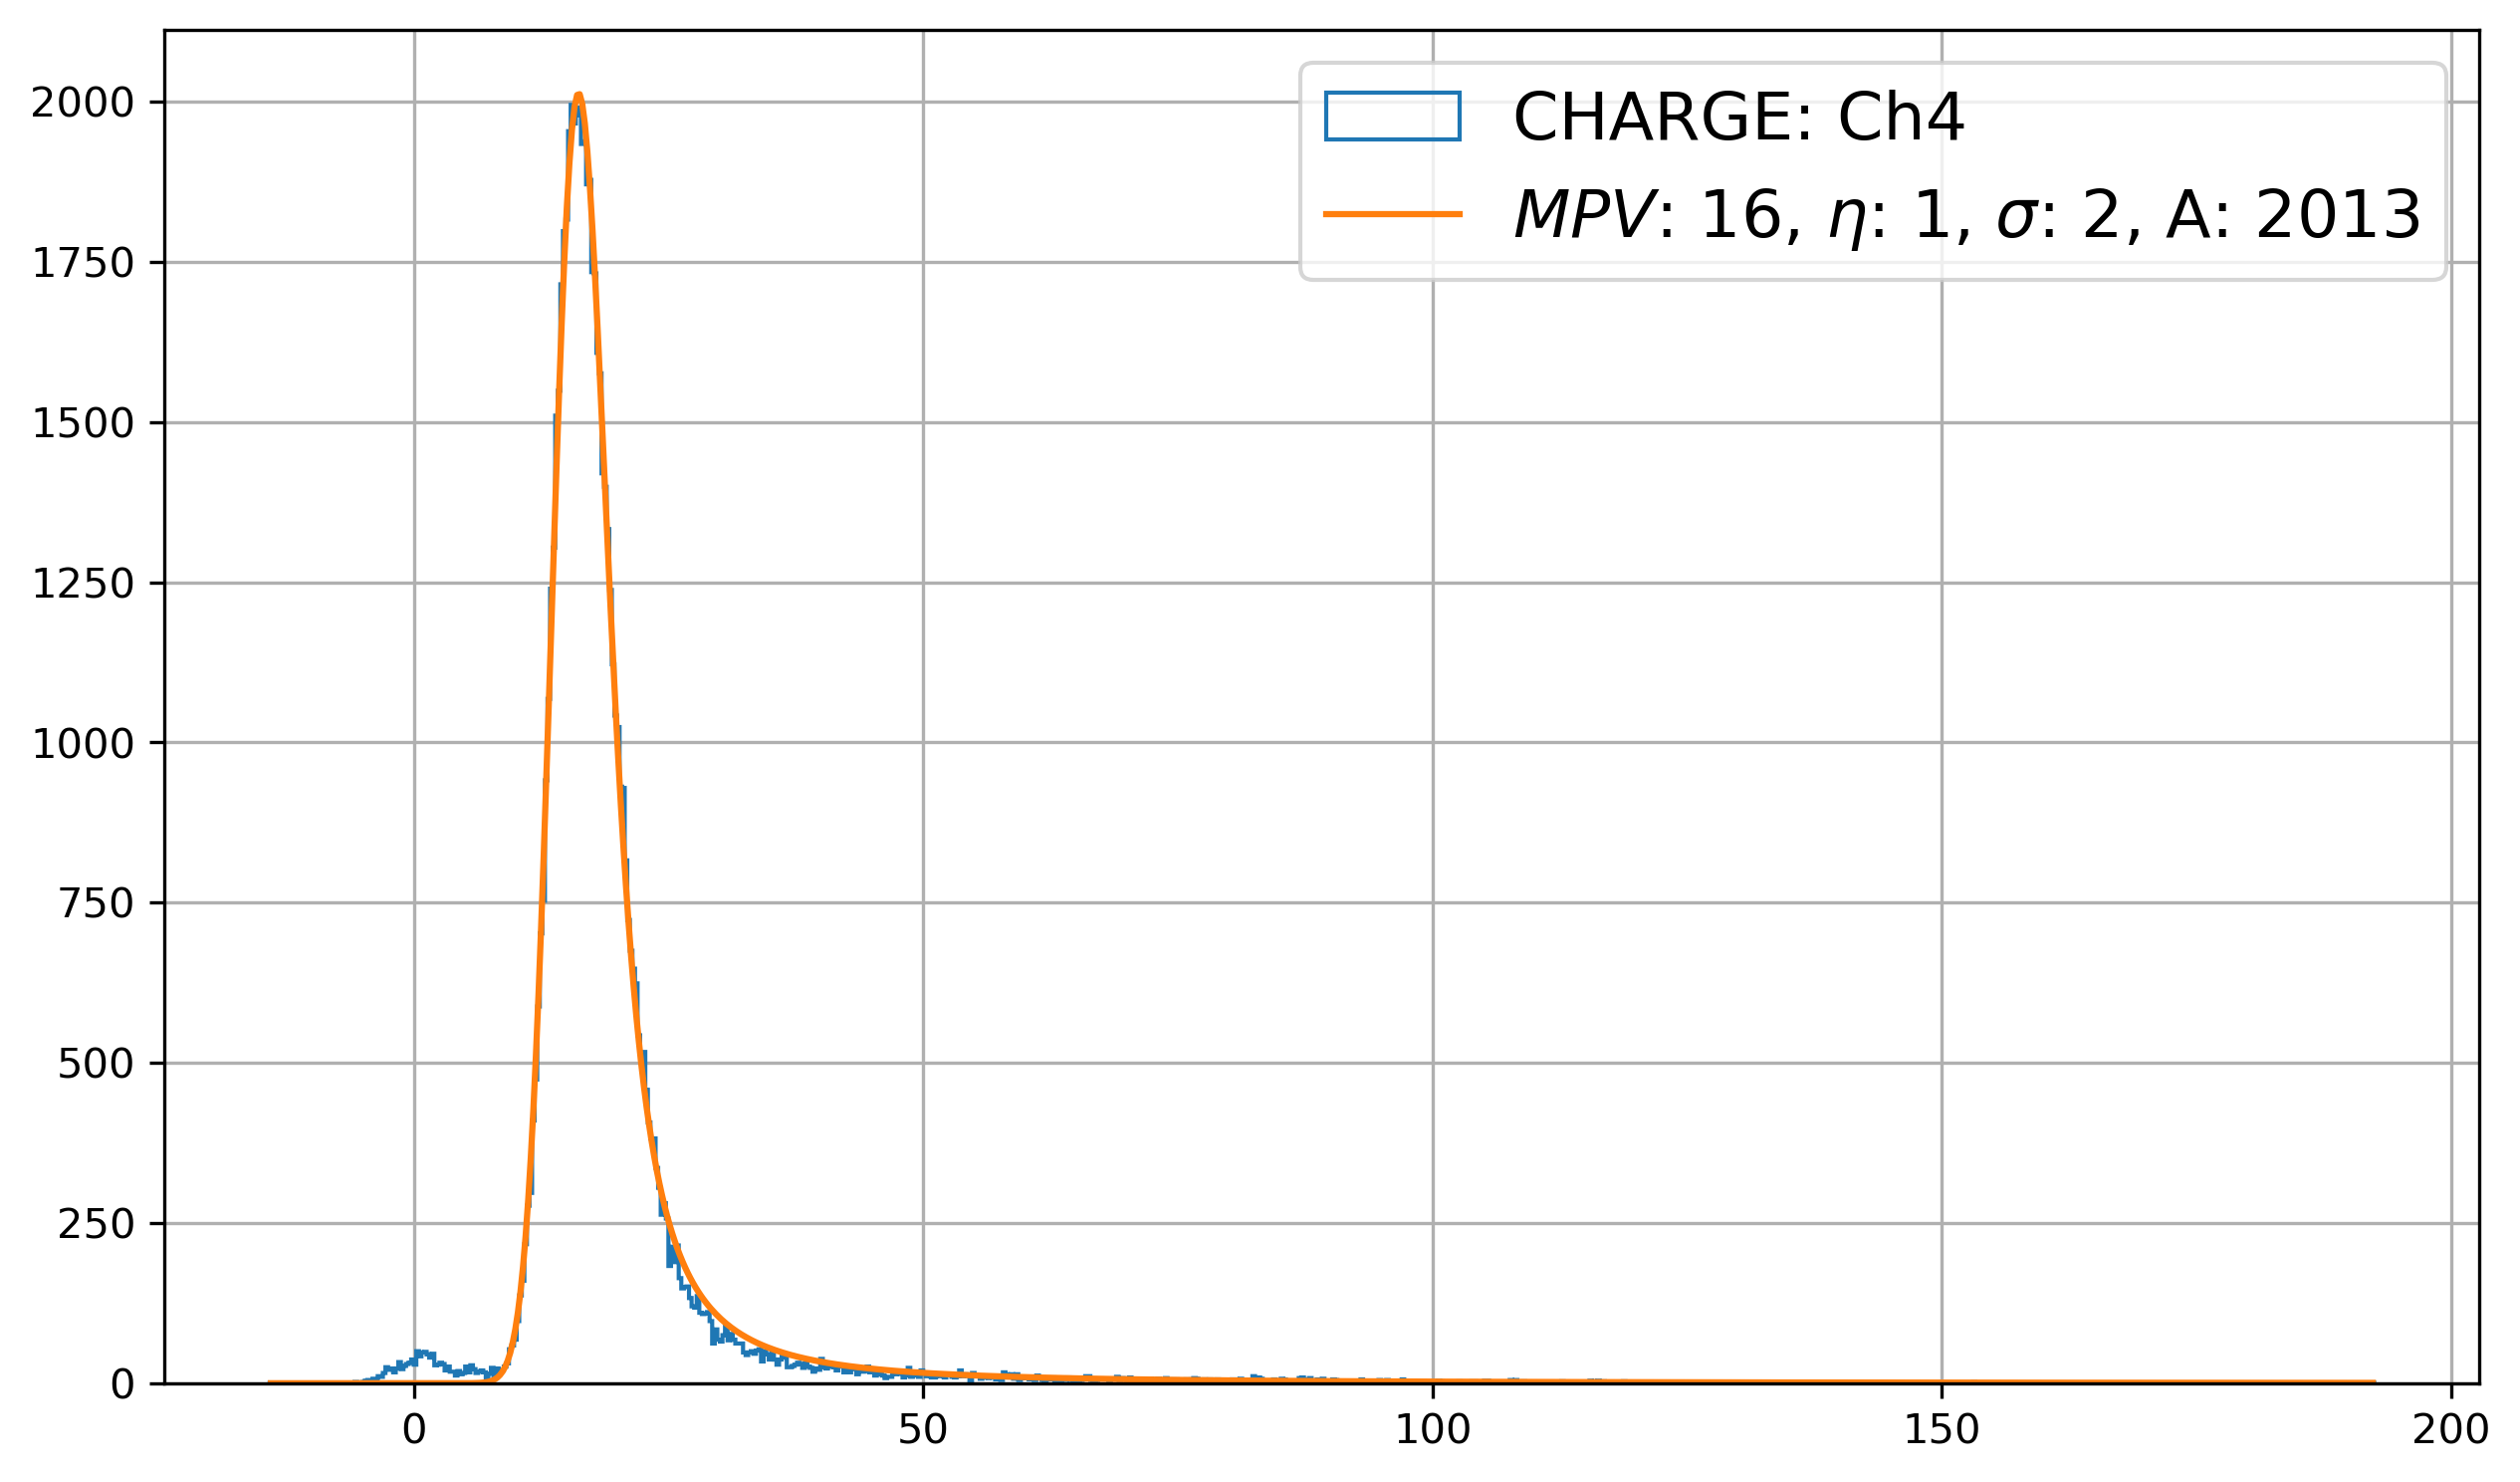

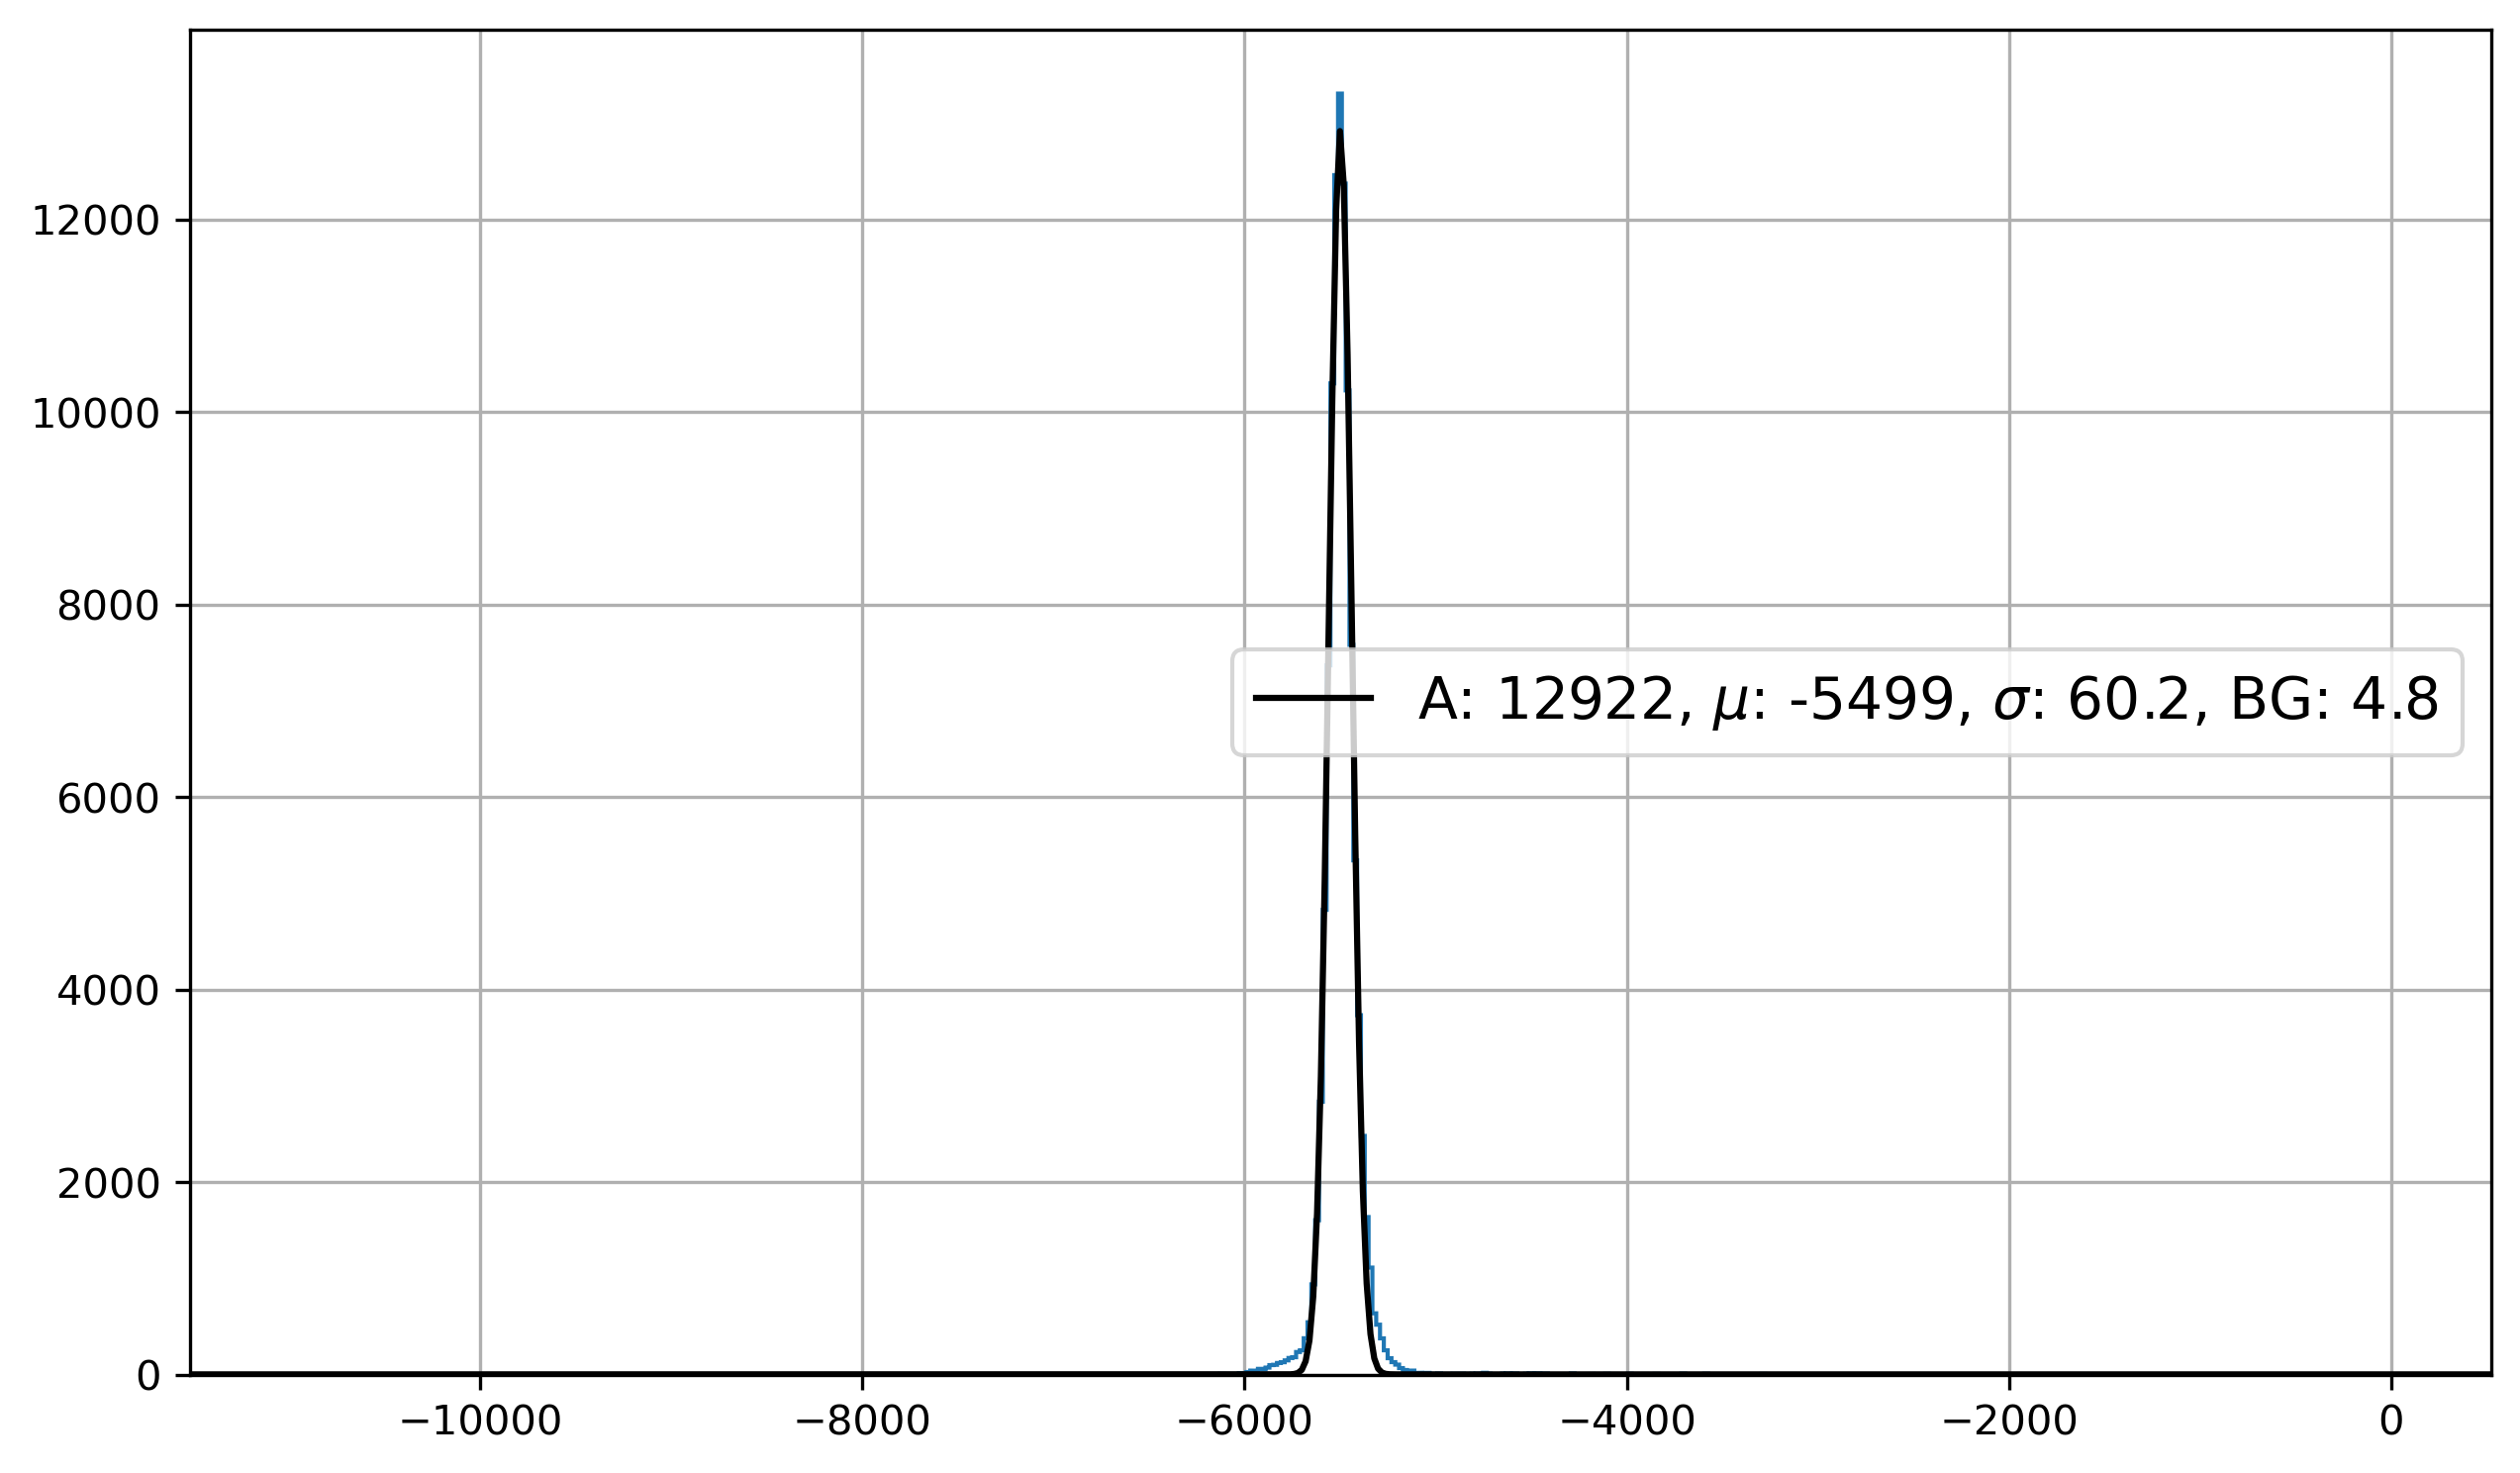

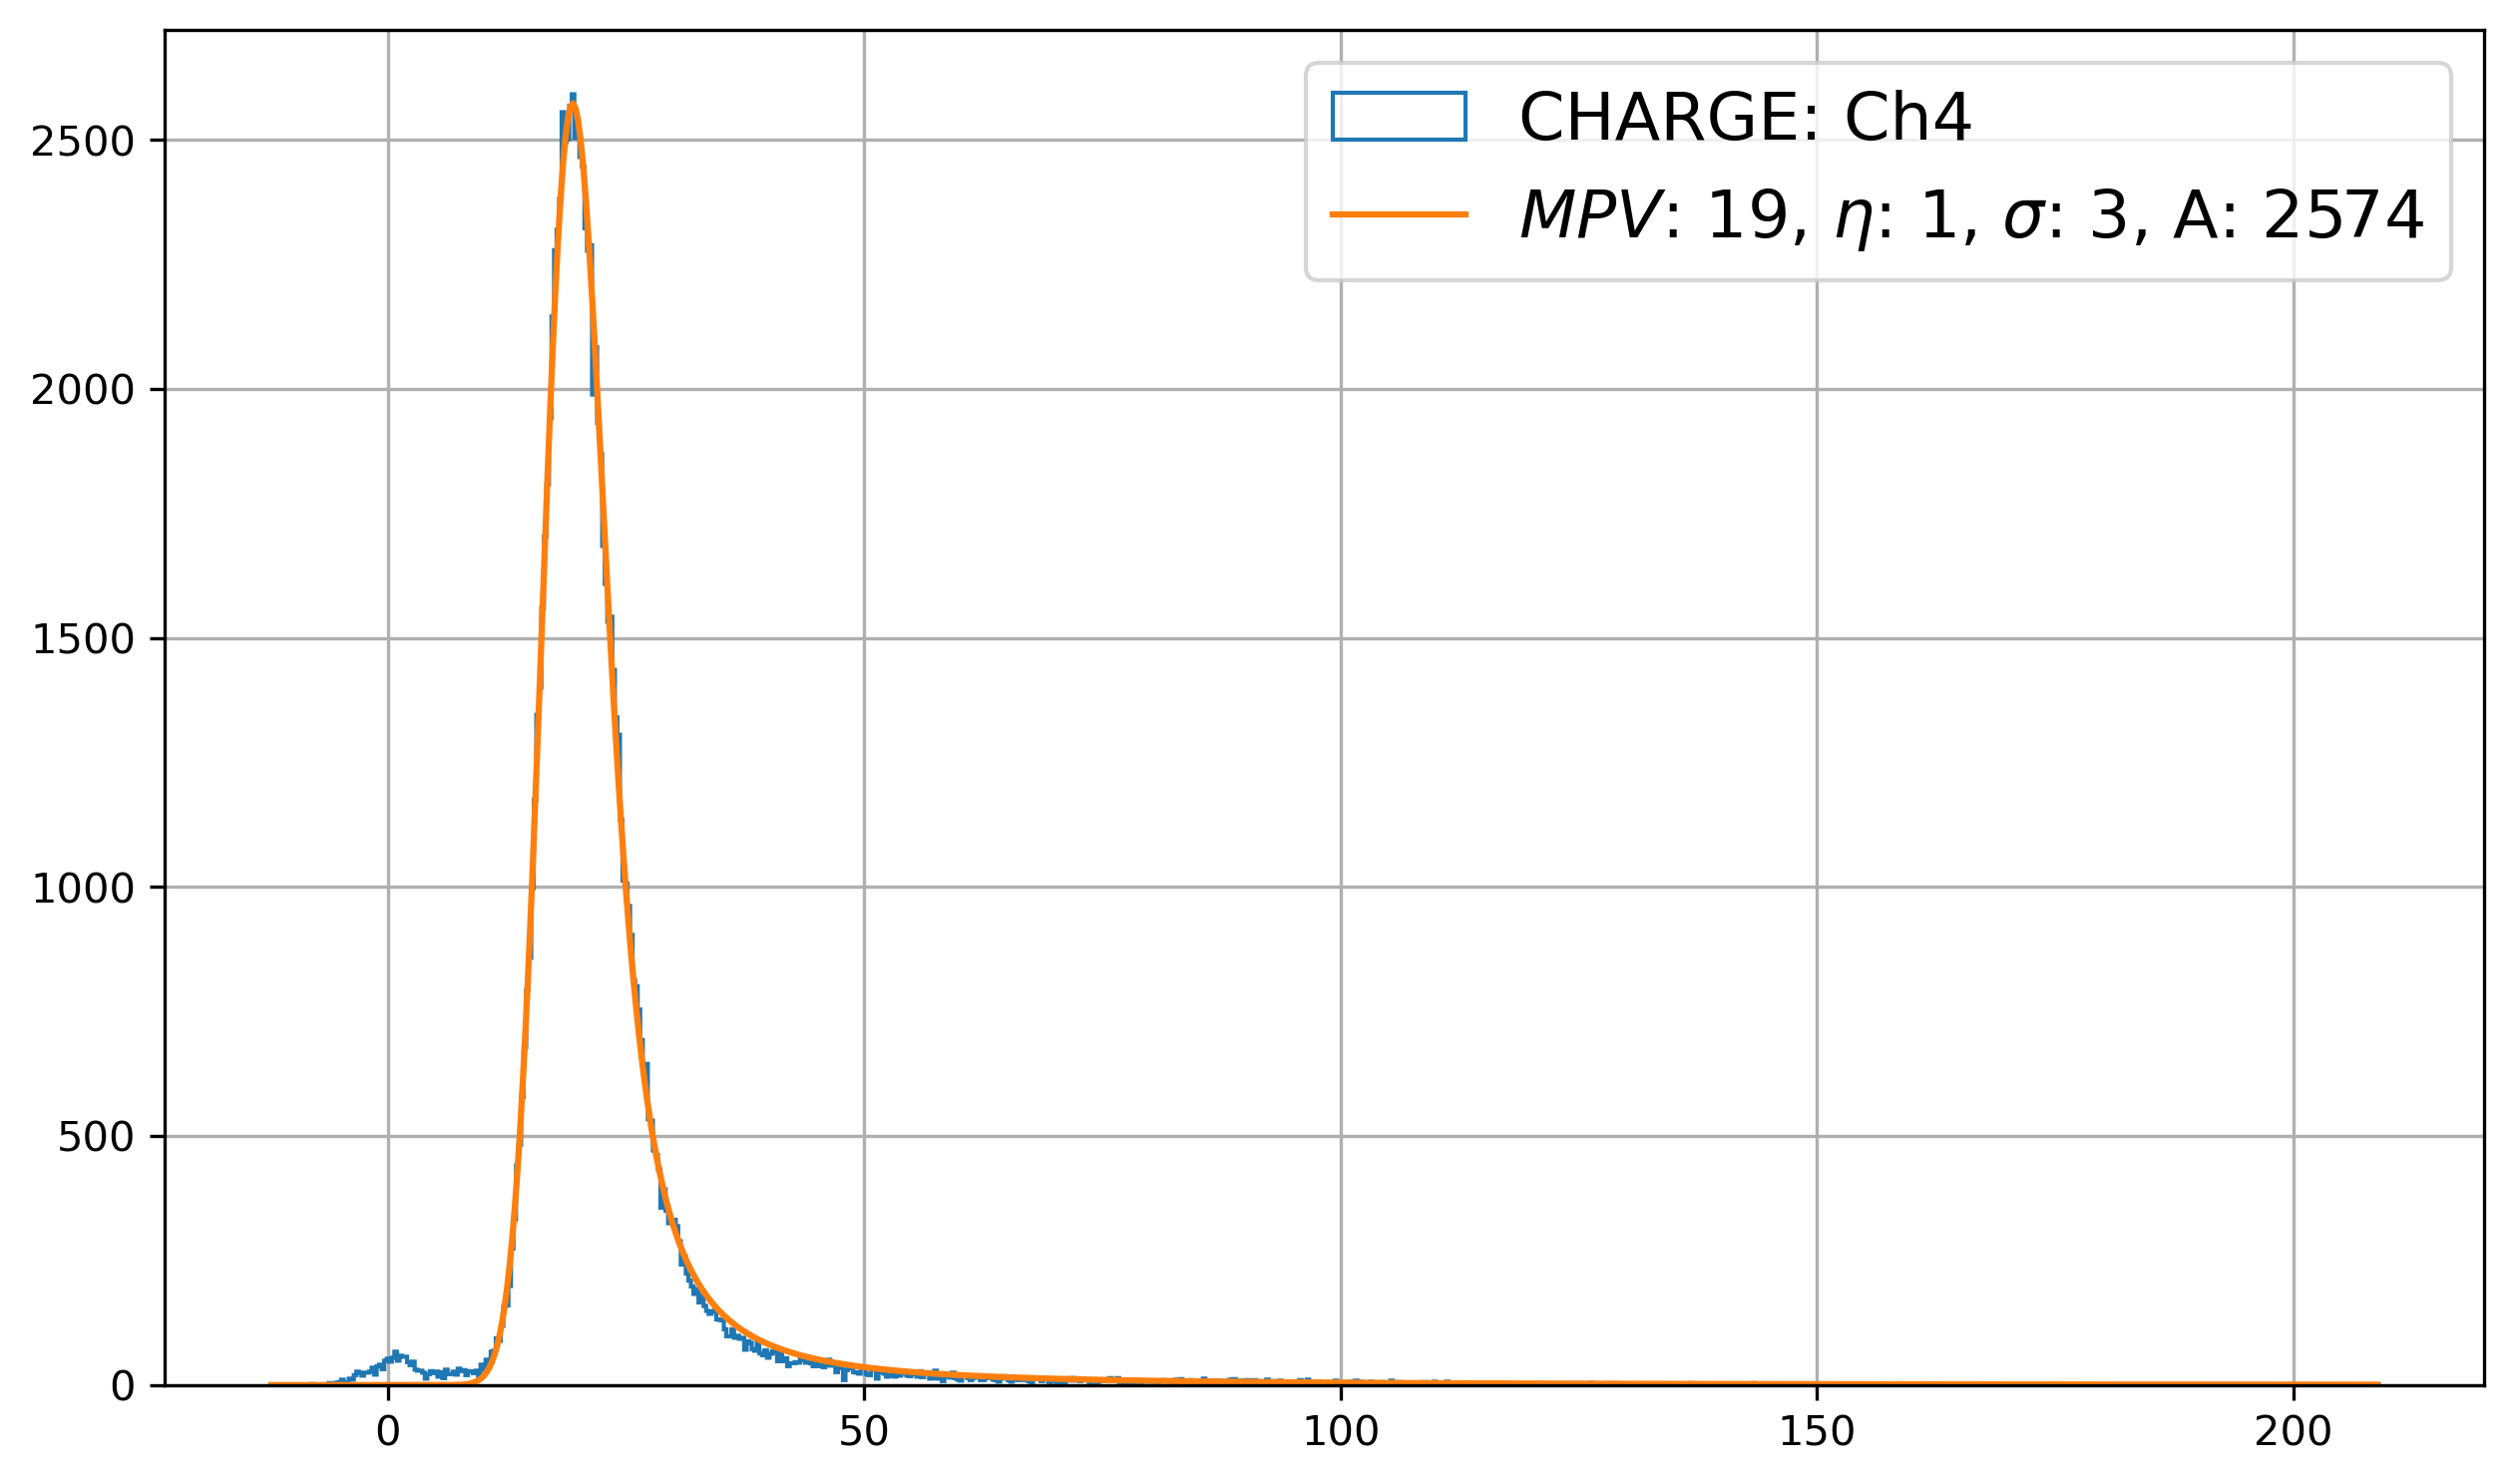

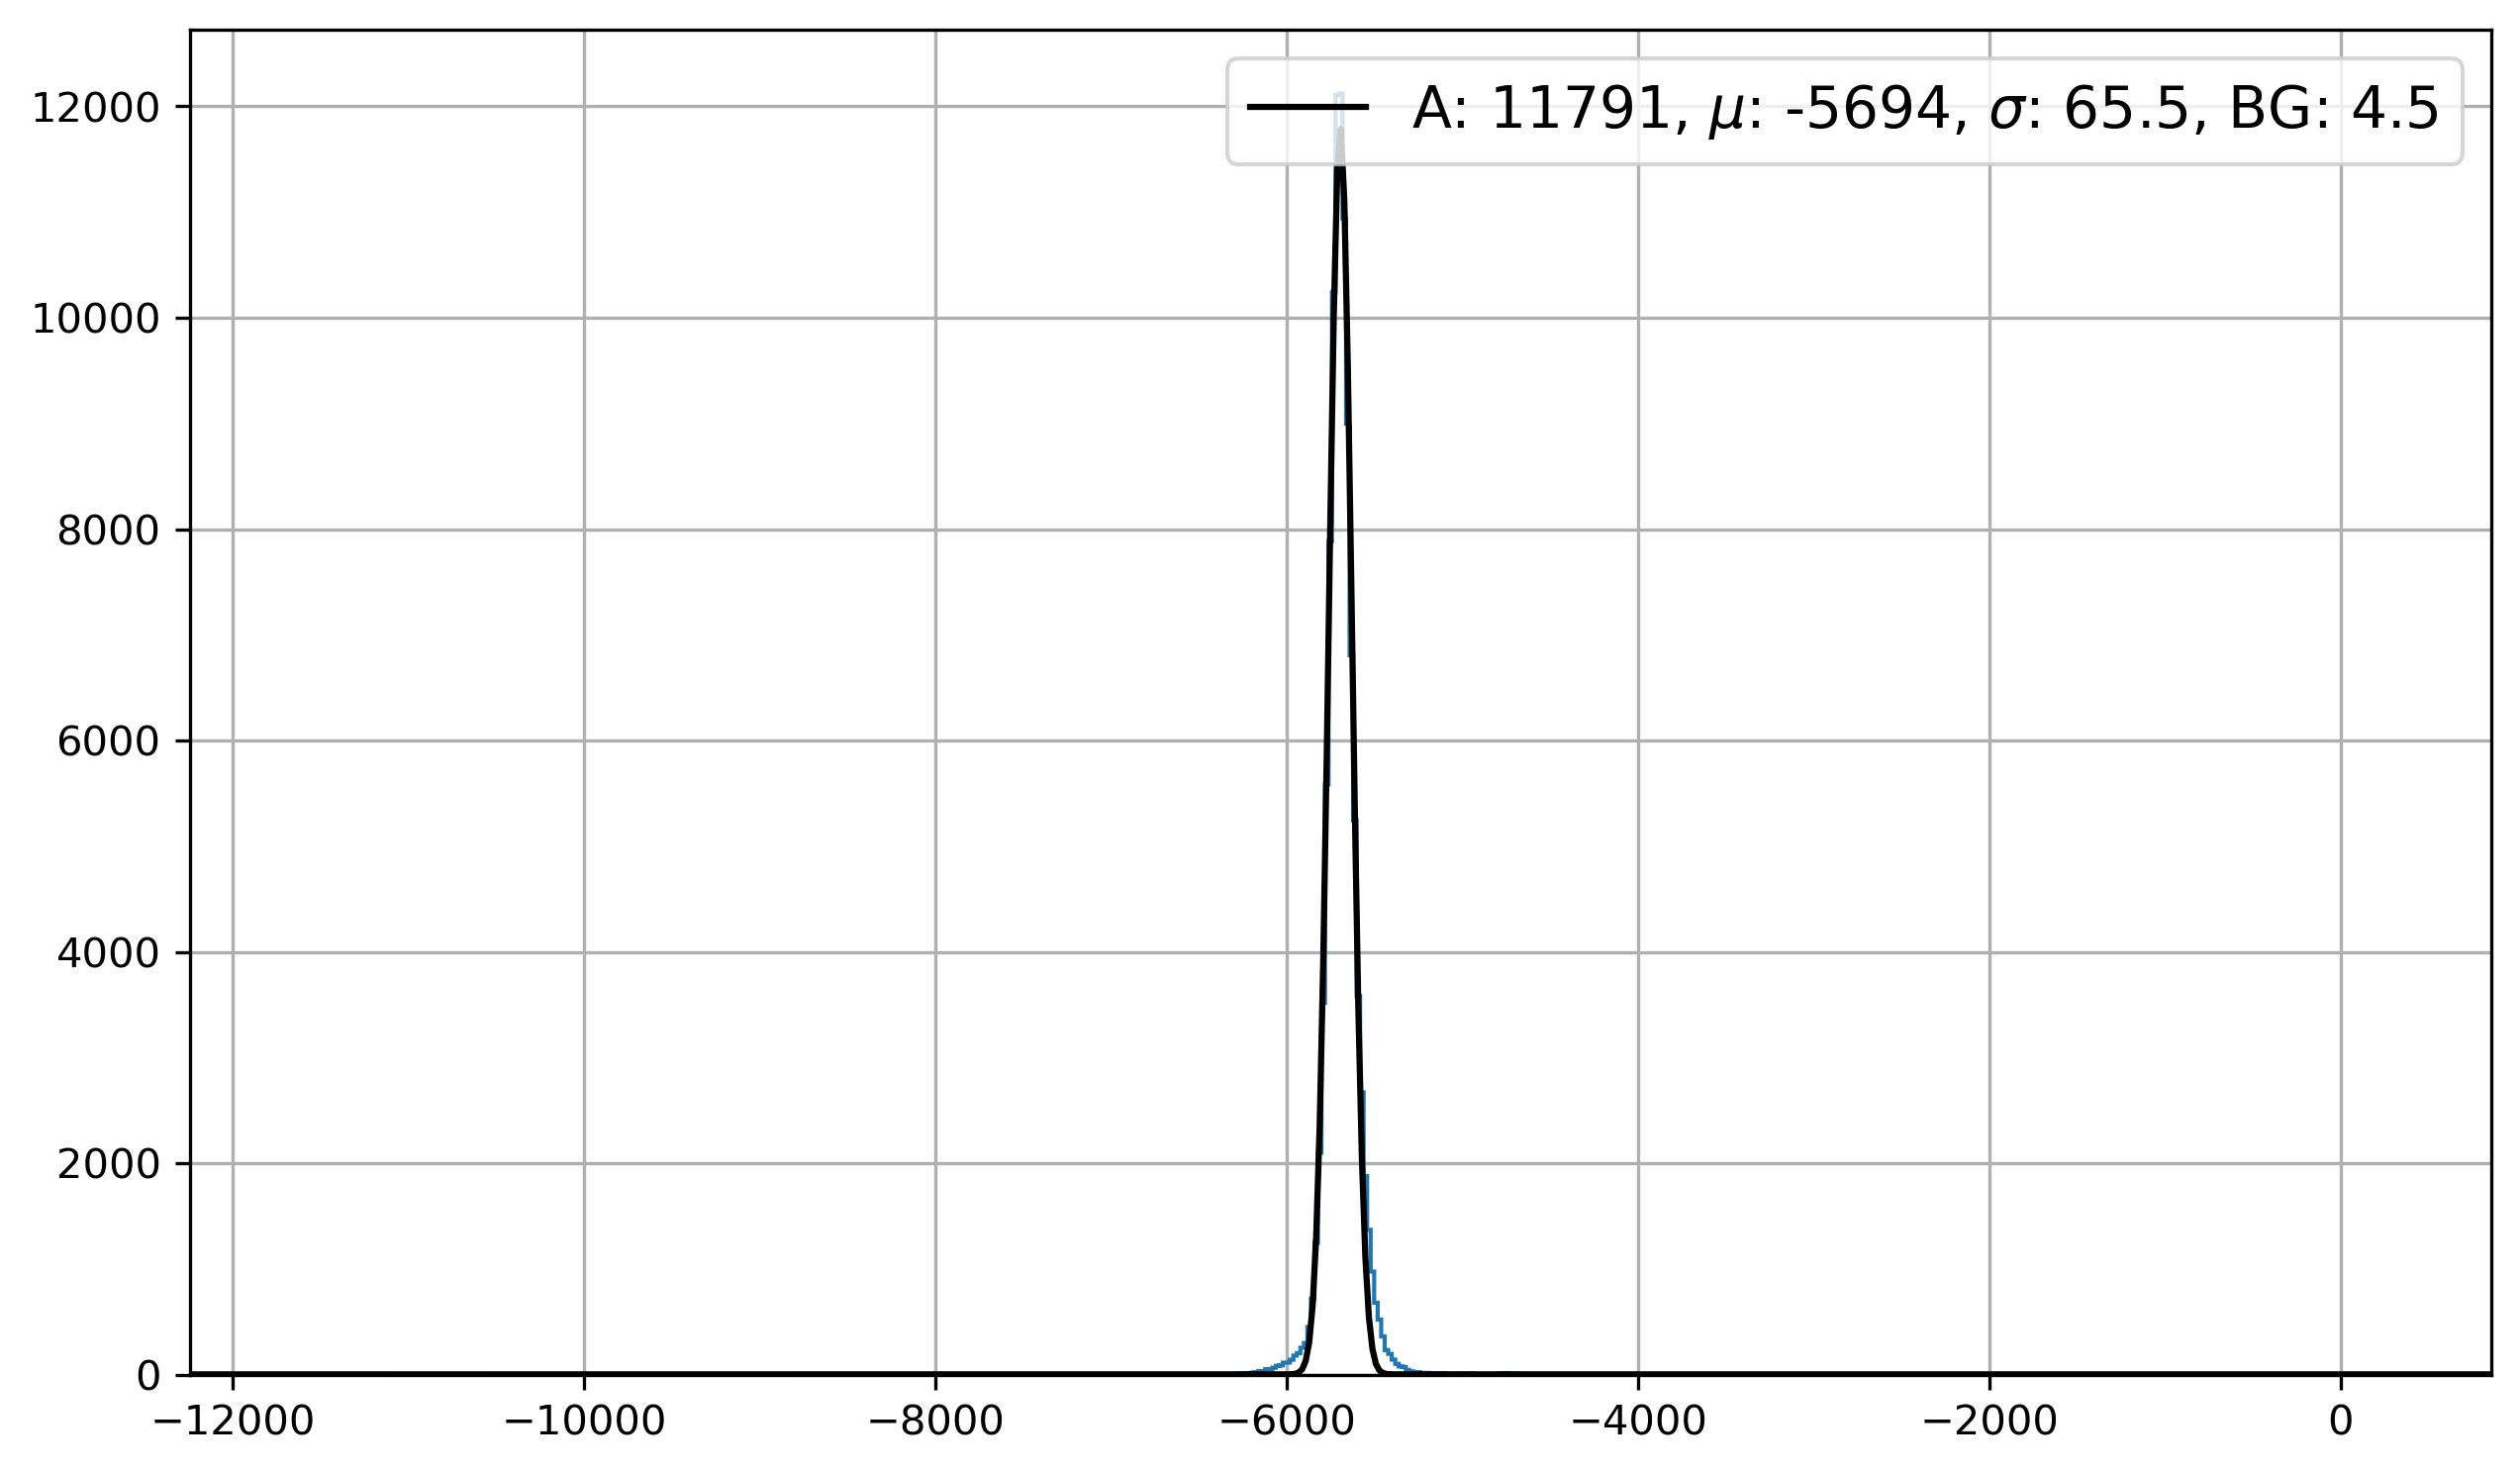

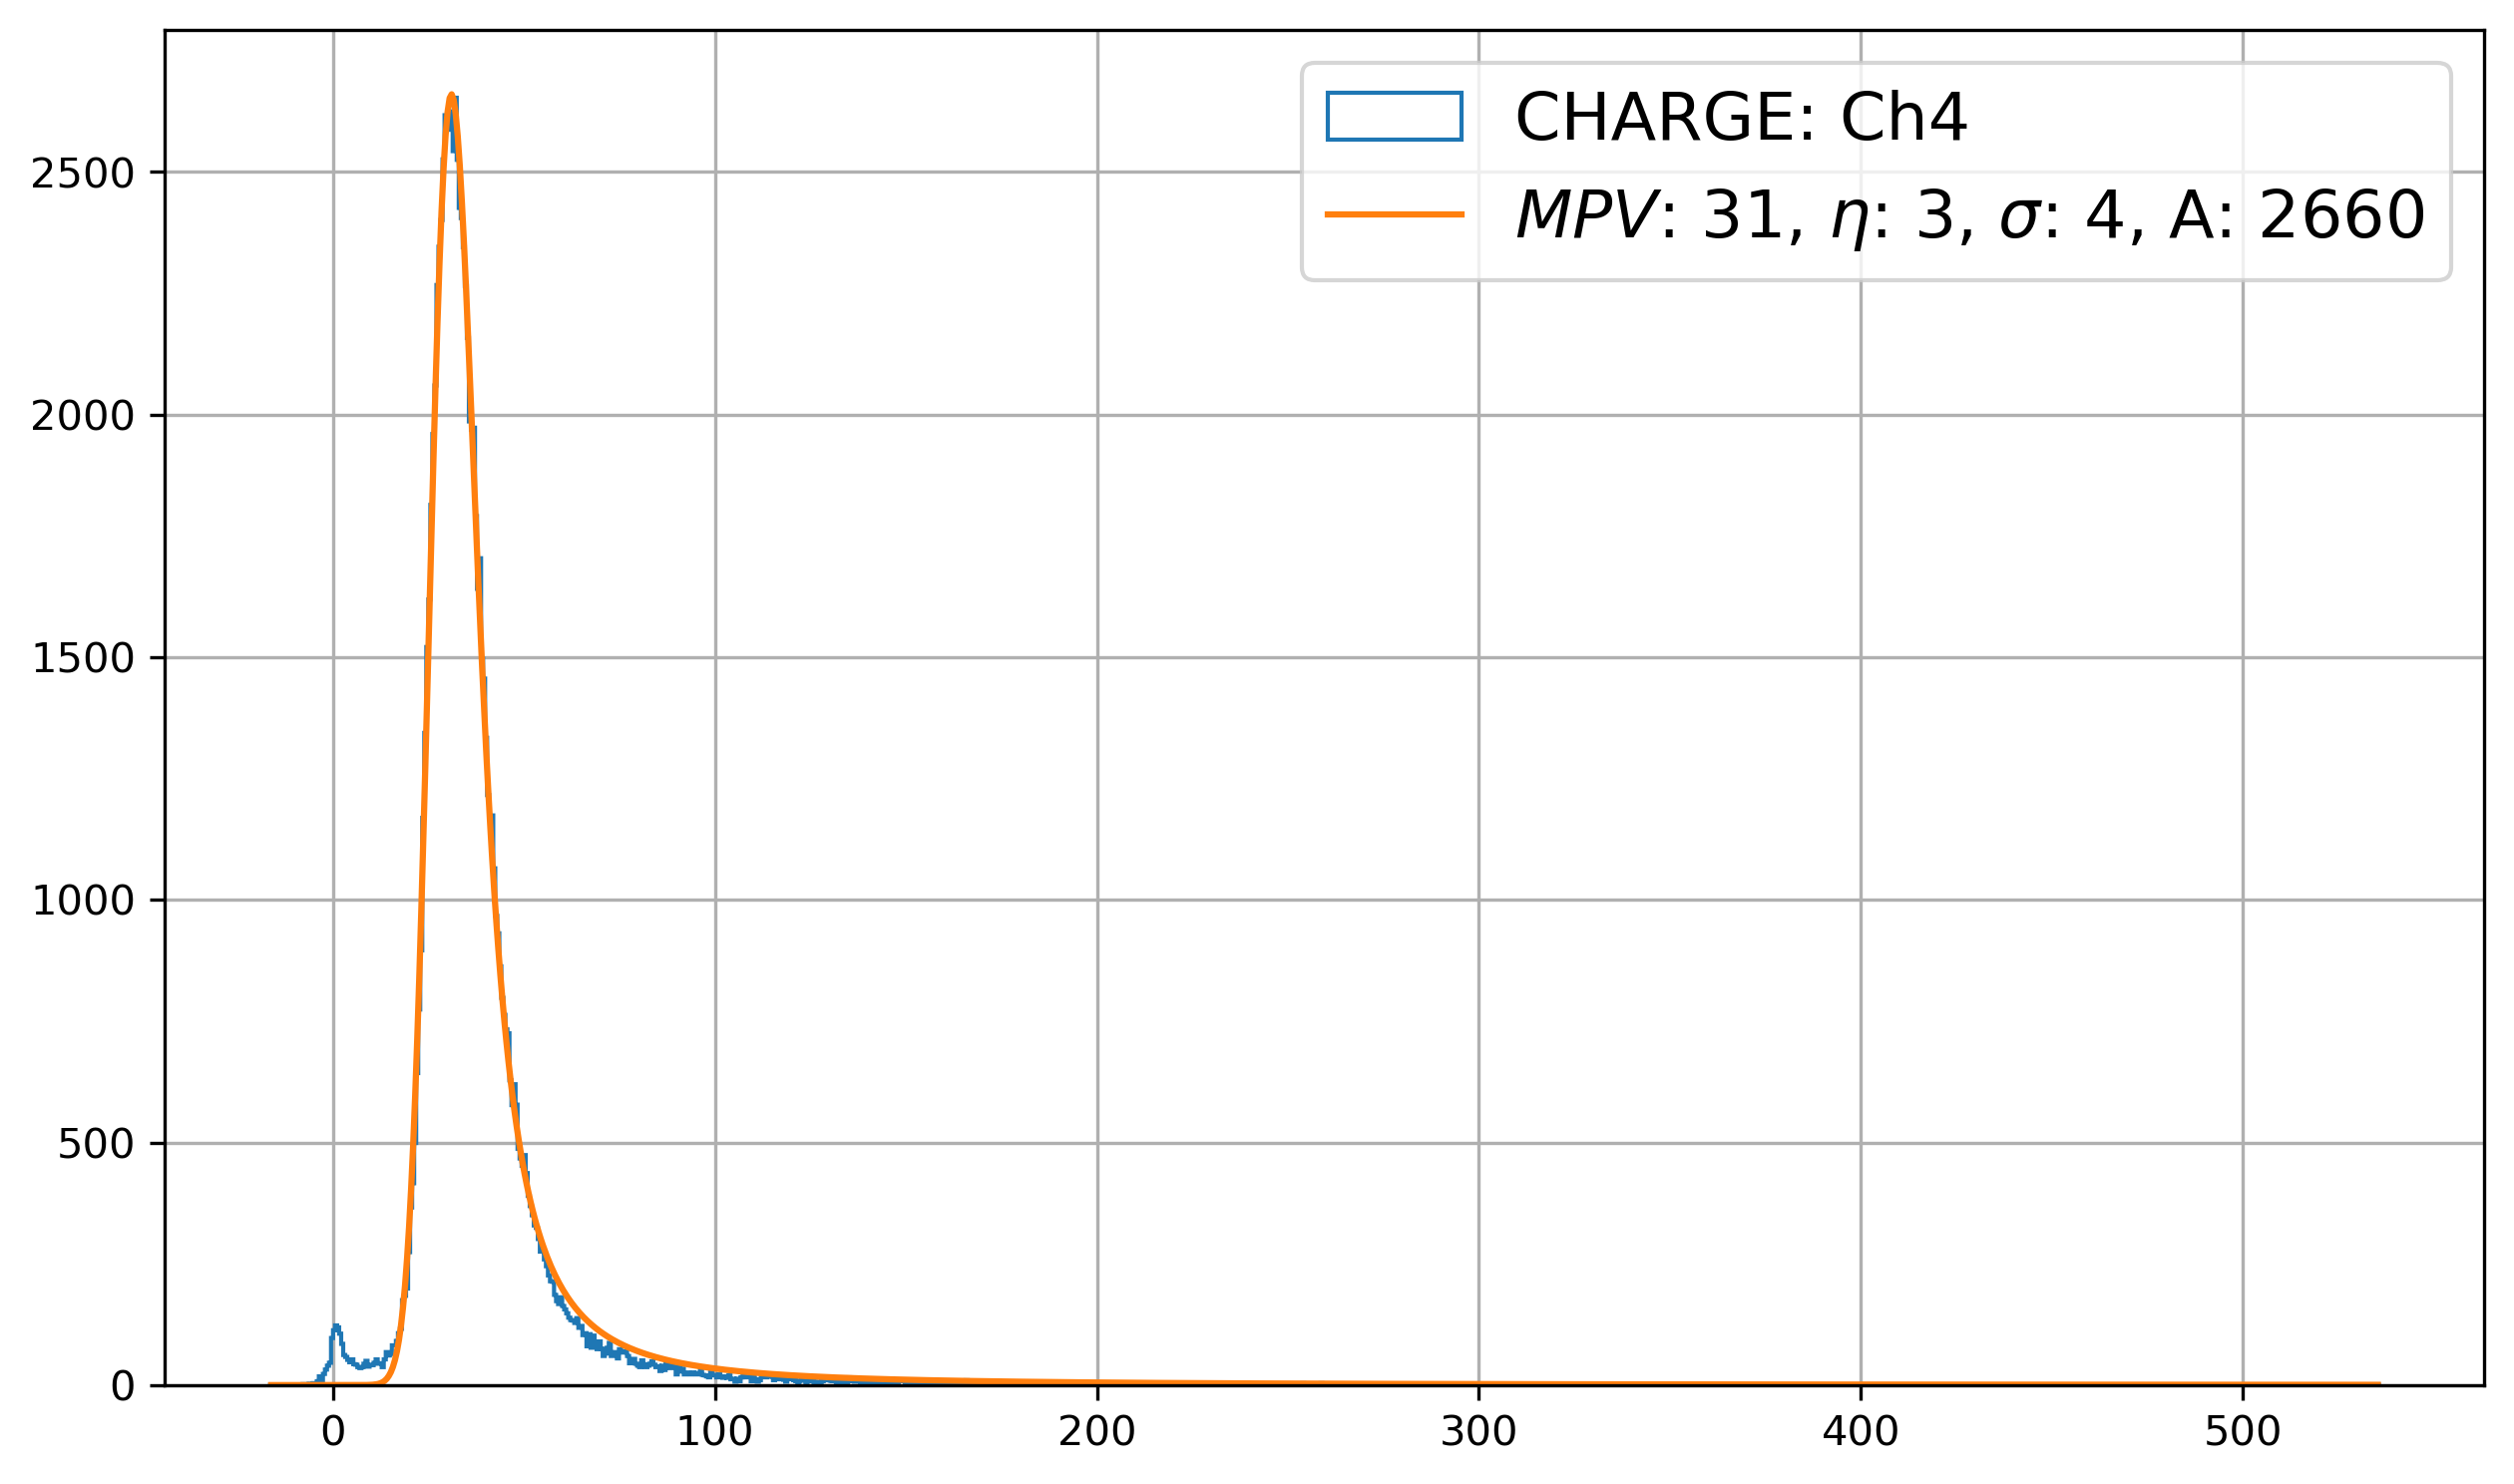

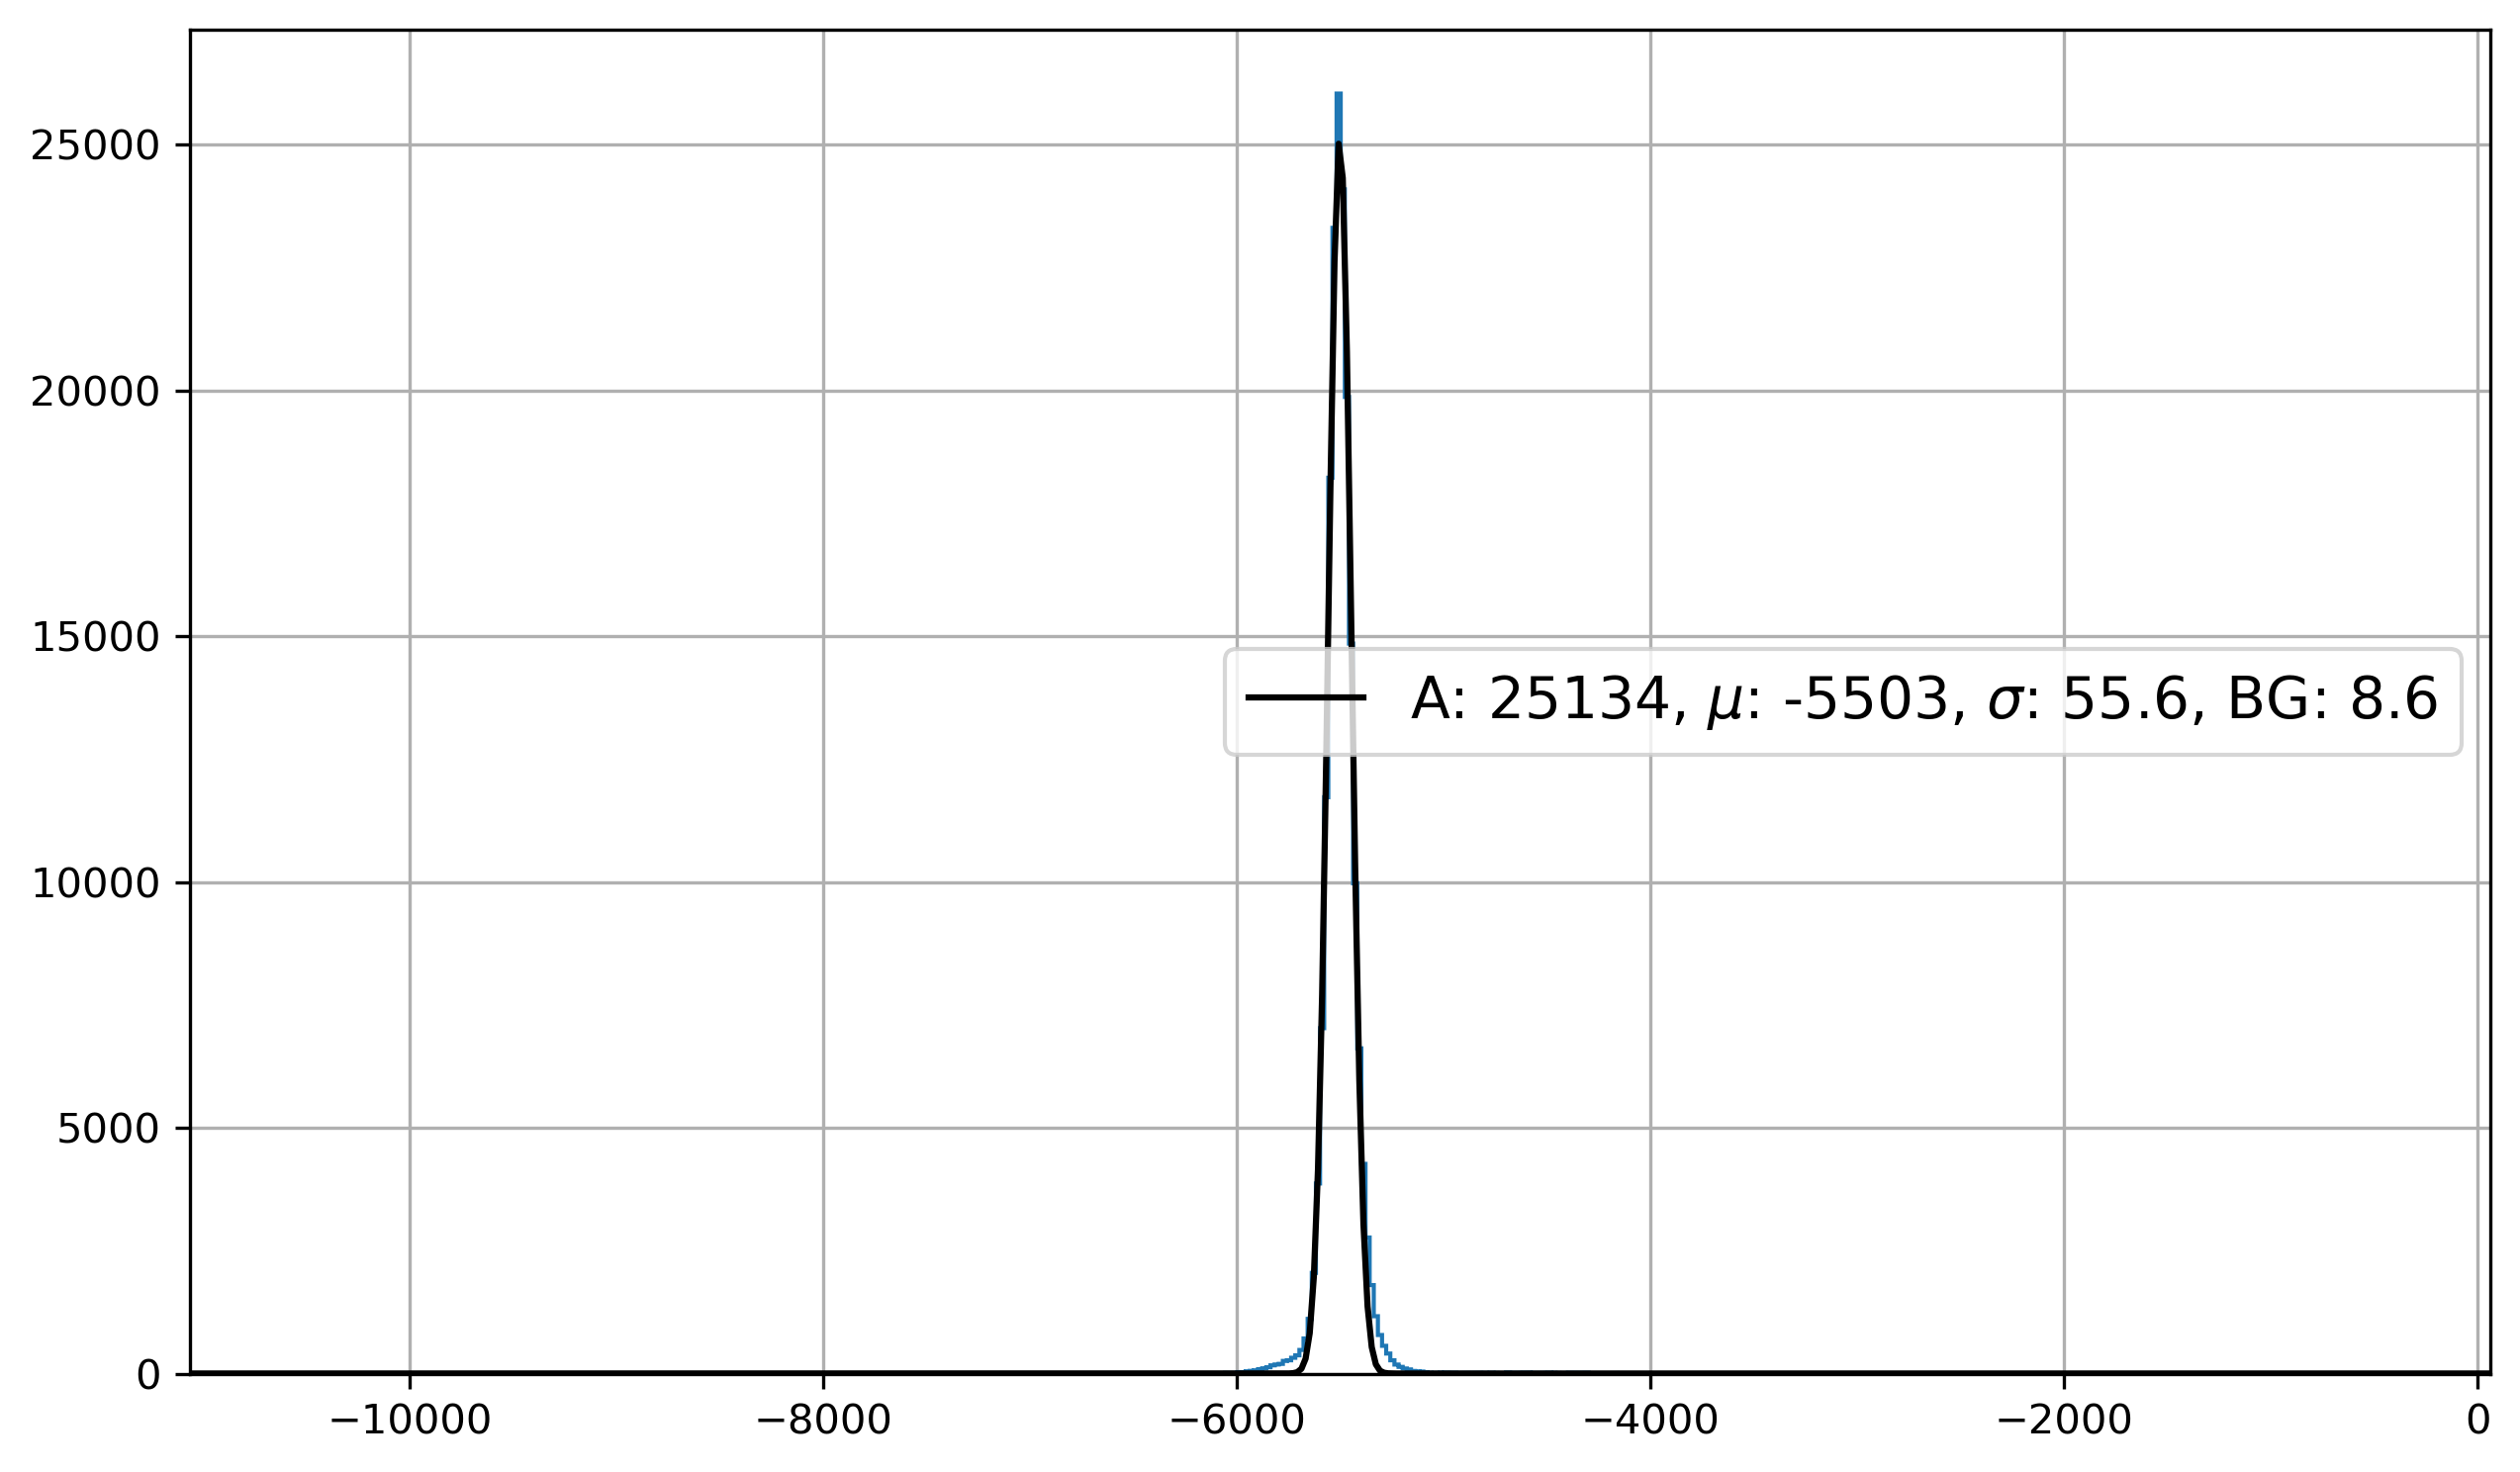

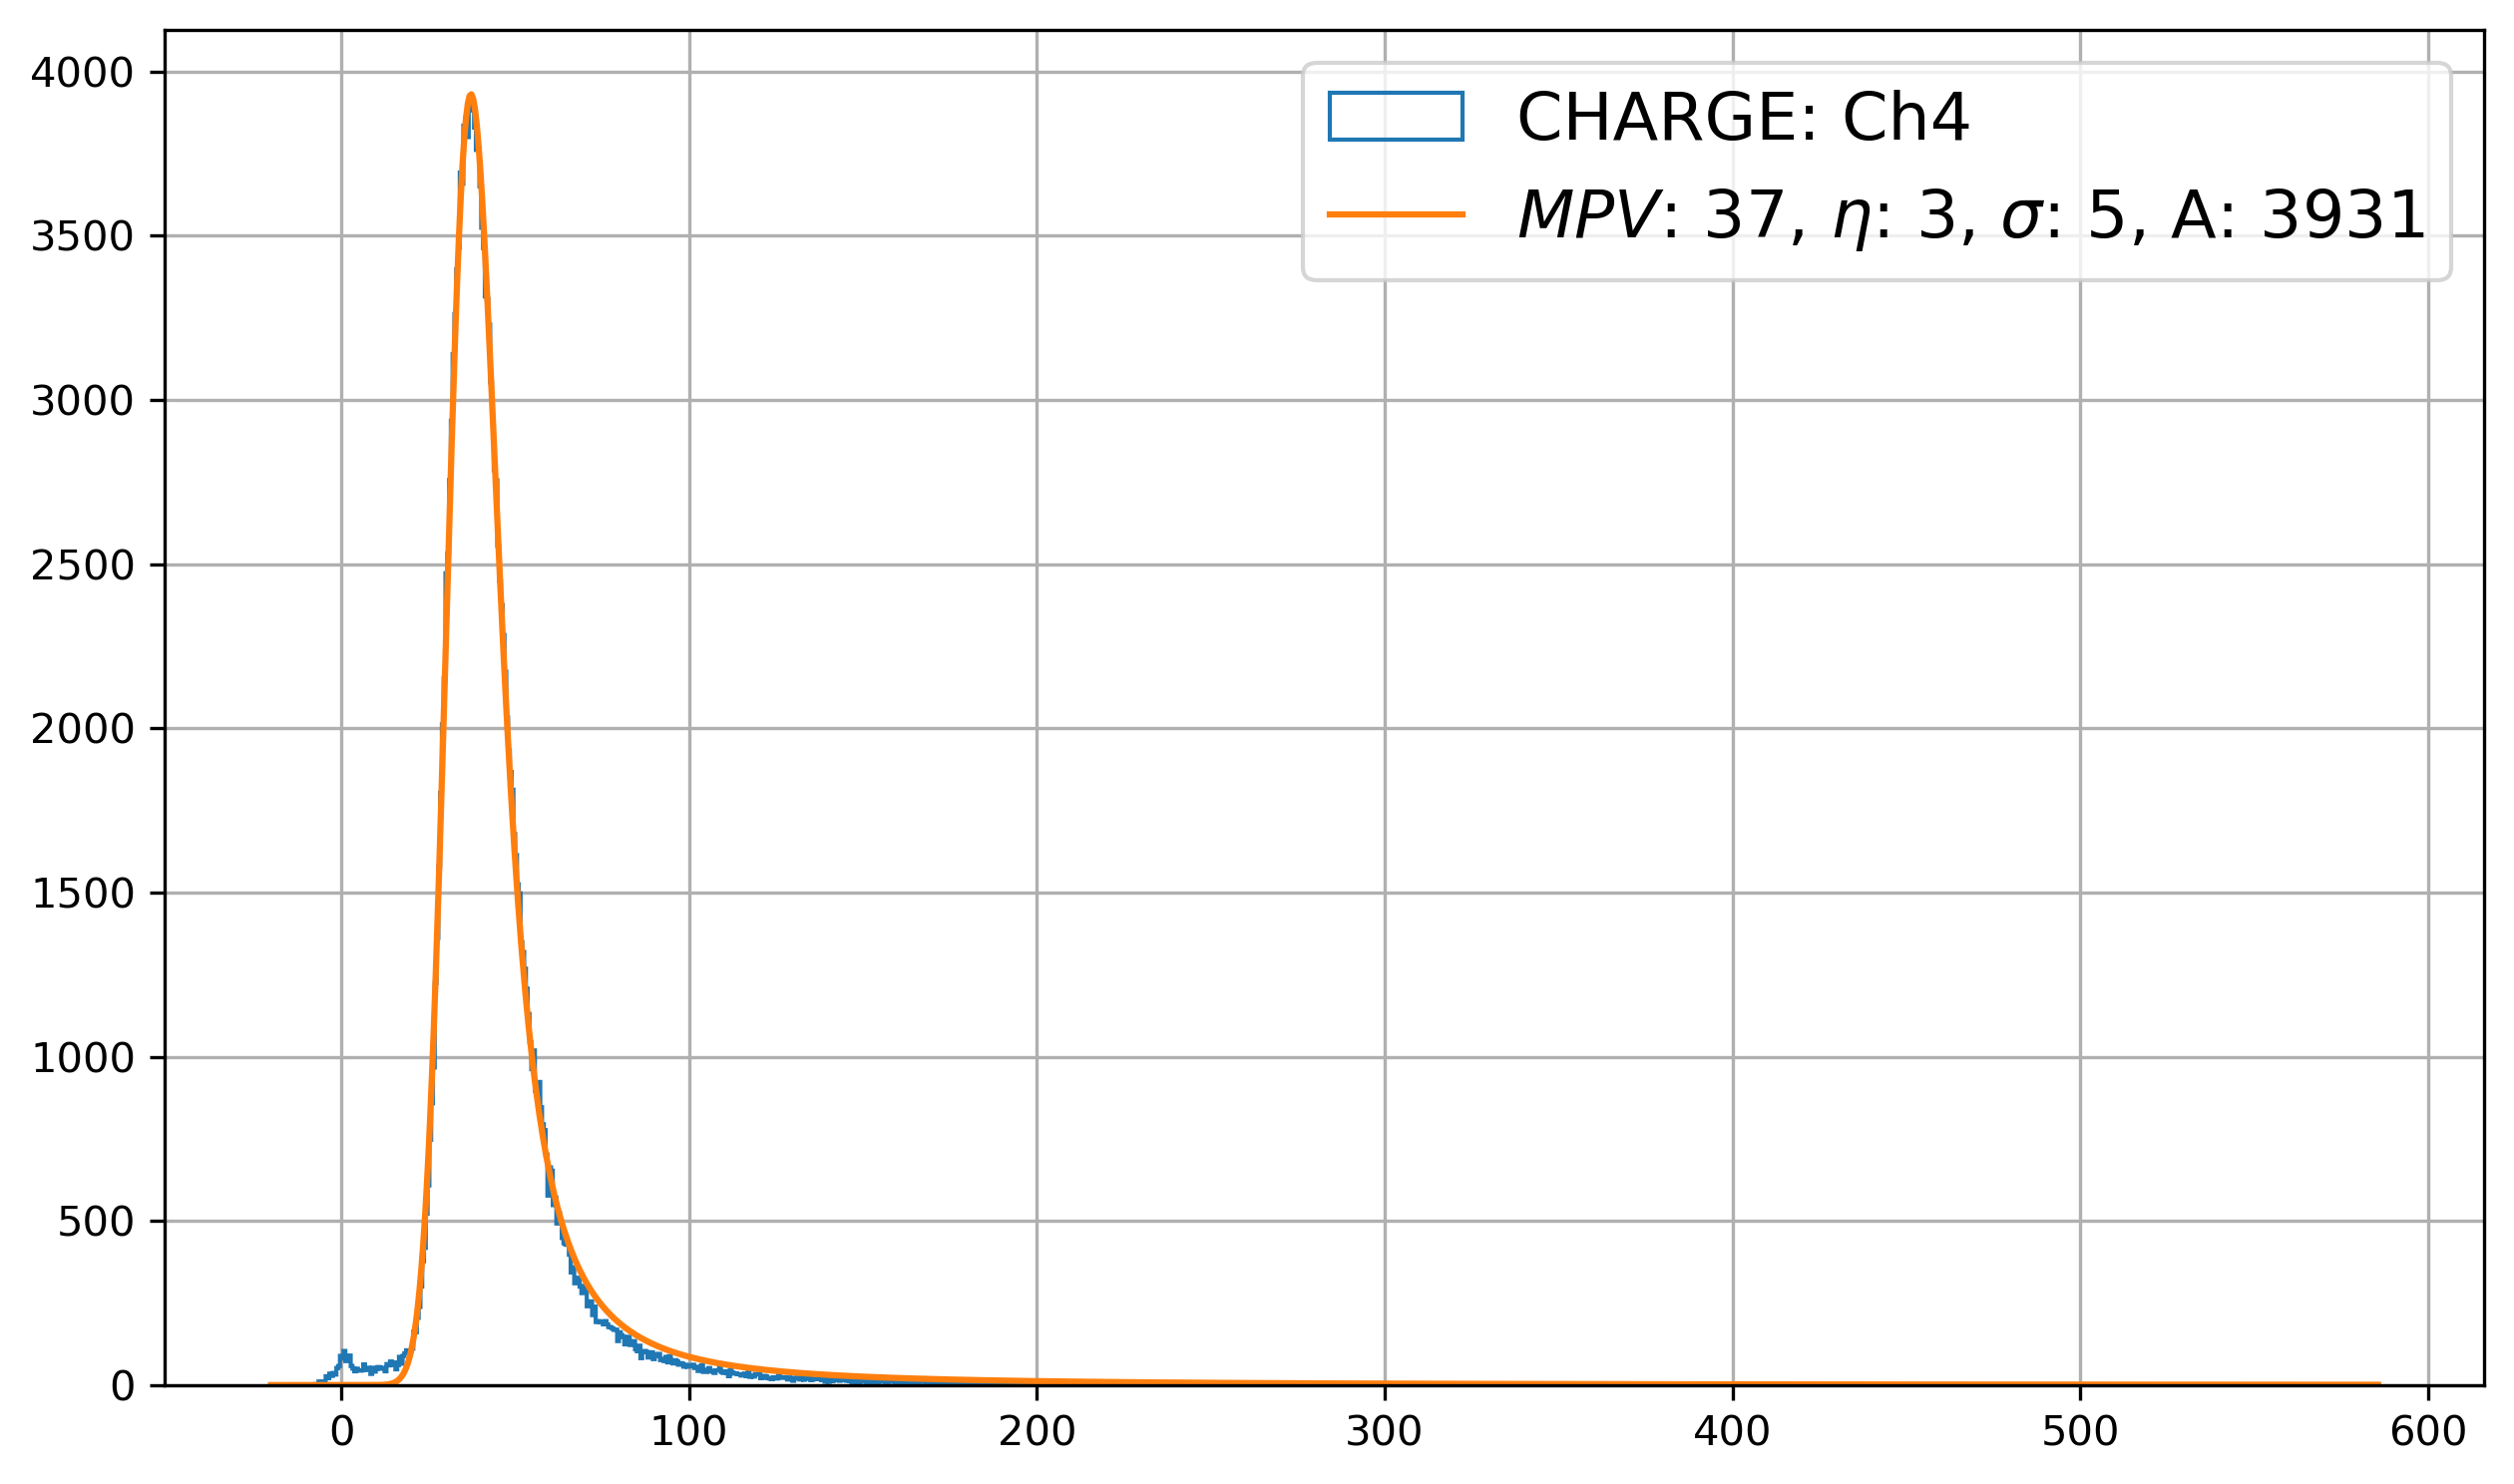

In [12]:
threshold_charge = 4 #fC
charge = []
charge_error = []
voltage = []
angle = []
MCP_voltage = []
time_resolution = []
name = []

SAVE = False
save_path = f'../various plots/{this_sensor}/{key_to_study}/'
if not os.path.isdir(save_path):
    os.mkdir(save_path)

for this_batch in df_analysis.index.levels[0]: ### batches
    for S in df_analysis.index.levels[1]:        ### scopes
        ### get only the DUTs that I need
#         DUTs = get_DUT_from_index(list(df_analysis.loc[idx[this_batch,S,:]].index))
        df = load_batch(this_batch,S)
       
        print(f"MCP: {dict_of_batches[this_batch].S[S].channels['Ch1'].voltage} V, angle: {dict_of_batches[this_batch].angle}°", f"temperature:{dict_of_batches[this_batch].tempA}°C")
        print('channels:', df_analysis.loc[idx[this_batch,S,:]].index)
        for ch in df_analysis.loc[idx[this_batch,S,:]].index:      ### channels
            ### EXTRACTING DATA
            match ch:
                case 'Ch1': dut=-1
                case 'Ch2': dut=1
                case 'Ch3': dut=2
                case 'Ch4': dut=3
                case other: logging.error("wrong channel name")
            print(f"Batch:{this_batch}, Scope:{S}, Channel:{ch}")

            mins = find_min_btw_peaks(df[f"pulseHeight_{dut}"], bins='rice', plot=False)
            geometry_cut = geometry_mask(df, DUT_number=dut, bins=bins1)[0]
            time_cut = time_mask(df, dut, bins=2000, mask=geometry_cut, plot=True)[0]
            pulseheight_cut = df[f'pulseHeight_{dut}']>mins
            all_cut = np.logical_and(np.logical_and(geometry_cut,pulseheight_cut),time_cut)
            ### I don't know if I should use only geo+pulse cut or all cuts
            time_parameters = time_mask(df, dut, bins=2000, mask=np.logical_and(geometry_cut,pulseheight_cut))[1]['parameters']

#             transimpedance = dict_of_batches[this_batch].S[S].channels[ch].transimpedance
            transimpedance = 4700
            try:
                param, covar = charge_fit(df, dut=dut, mask=np.logical_and(time_cut,geometry_cut), transimpedance=transimpedance, plot=True)
                charge.append(param[0])
                charge_error.append(covar[0,0]**0.5) ### variance to error
            except:
                charge.append(-1)
                charge_error.append(0)
                logging.error("Charge fit error")
            voltage.append(dict_of_batches[this_batch].S[S].channels[ch].voltage)
            angle.append(dict_of_batches[this_batch].angle)
            MCP_voltage.append(dict_of_batches[this_batch].S[S].channels['Ch1'].voltage)
            match MCP_voltage[-1]:  ### last MCP_voltage entry
                case 2500: MCP_resolution = 36.52 # +/- 0.81
                case 2600: MCP_resolution = 16.48 # +/- 0.57
                case 2800: MCP_resolution = 3.73  # +/- 1.33
                case other: logging.error("Incorrect MCP voltage")
            time_resolution.append(np.sqrt(time_parameters[2]**2 - MCP_resolution**2))
            name.append(dict_of_batches[this_batch].S[S].get_sensor(ch).name)

df_analysis['charge'] = charge
df_analysis['voltage'] = voltage
df_analysis['charge_error'] = charge_error
df_analysis['angle'] = angle
df_analysis['MCP_voltage'] = MCP_voltage
df_analysis['time_resolution'] = time_resolution
df_analysis['name'] = name

dict_analysis_IME[key_to_study] = df_analysis.copy()


In [ ]:
dict_of_batches[]

In [13]:
dict_analysis_IME[key_to_study] = df_analysis.copy()
display(df_analysis)

charge  voltage  charge_error  angle  \
batch oscilloscope channel                                            
100   S1           Ch2      -0.143641      -70      0.033371    0.0   
                   Ch3      13.647558      -70      0.043343    0.0   
101   S1           Ch2      11.051919      -70      0.002483    0.0   
                   Ch3      13.279116      -70      0.010686    0.0   
201   S1           Ch2      -1.000000      -80      0.000000    0.0   
                   Ch3      14.447326      -80      0.089087    0.0   
202   S1           Ch2      12.564145      -80      0.027054    0.0   
                   Ch3      15.039402      -80      0.031385    0.0   
203   S1           Ch2      14.658190      -80      0.006074    0.0   
                   Ch3      15.196803      -80      0.007564    0.0   
204   S1           Ch2      17.166914      -90      0.006154    0.0   
                   Ch3      17.535413      -90      0.007616    0.0   
100   S2           Ch4      20.495102     -100      0.009338    0.0   
101   S2           Ch4      20.729153     -100      0.010663    0.0   
401   S2           Ch4      52.293673     -125      0.271988    0.0   
402   S2           Ch4      46.467655     -125      2.735942    0.0   
403   S2           Ch4      12.038435      -80      0.004601    0.0   
407   S2           Ch4      14.351887      -80      0.004571    0.0   
100   S1           Ch4      13.612149      -90      0.004253    0.0   
101   S1           Ch4      16.214065      -90      0.005574    0.0   
401   S1           Ch4      16.163029     -100      0.006390    0.0   
402   S1           Ch4      19.423900     -100      0.007035    0.0   
403   S1           Ch4      31.015082     -125      0.015174    0.0   
407   S1           Ch4      37.298372     -125      0.013172    0.0   

                            MCP_voltage  time_resolution  
batch oscilloscope channel                                
100   S1           Ch2             2500              NaN  
                   Ch3             2500        48.328003  
101   S1           Ch2             2500        42.866435  
                   Ch3             2500        39.741586  
201   S1           Ch2             2500        93.092908  
                   Ch3             2500        41.140649  
202   S1           Ch2             2500        36.983271  
                   Ch3             2500        29.573071  
203   S1           Ch2             2500        68.497567  
                   Ch3             2500        68.796463  
204   S1           Ch2             2500        65.398648  
                   Ch3             2500        64.746843  
100   S2           Ch4             2500        62.165214  
101   S2           Ch4             2500        61.036176  
401   S2           Ch4             2500        60.808733  
402   S2           Ch4             2500        96.680745  
403   S2           Ch4             2500        66.395596  
407   S2           Ch4             2500        55.693175  
100   S1           Ch4             2500        62.593954  
101   S1           Ch4             2500        51.503268  
401   S1           Ch4             2500        59.713711  
402   S1           Ch4             2500        47.380700  
403   S1           Ch4             2500        53.781592  
407   S1           Ch4             2500        41.643174

In [14]:
idx=pd.IndexSlice

### select one value from the index channel
df_analysis.loc[idx[:,:,'Ch2'],['charge']] ### DATAFRAME  
df_analysis.loc[idx[:,:,'Ch2']]['charge']  ### SERIES
display(df_analysis)

dict_analysis_IME[key_to_study] = df_analysis.copy()

charge  voltage  charge_error  angle  \
batch oscilloscope channel                                            
100   S1           Ch2      -0.143641      -70      0.033371    0.0   
                   Ch3      13.647558      -70      0.043343    0.0   
101   S1           Ch2      11.051919      -70      0.002483    0.0   
                   Ch3      13.279116      -70      0.010686    0.0   
201   S1           Ch2      -1.000000      -80      0.000000    0.0   
                   Ch3      14.447326      -80      0.089087    0.0   
202   S1           Ch2      12.564145      -80      0.027054    0.0   
                   Ch3      15.039402      -80      0.031385    0.0   
203   S1           Ch2      14.658190      -80      0.006074    0.0   
                   Ch3      15.196803      -80      0.007564    0.0   
204   S1           Ch2      17.166914      -90      0.006154    0.0   
                   Ch3      17.535413      -90      0.007616    0.0   
100   S2           Ch4      20.495102     -100      0.009338    0.0   
101   S2           Ch4      20.729153     -100      0.010663    0.0   
401   S2           Ch4      52.293673     -125      0.271988    0.0   
402   S2           Ch4      46.467655     -125      2.735942    0.0   
403   S2           Ch4      12.038435      -80      0.004601    0.0   
407   S2           Ch4      14.351887      -80      0.004571    0.0   
100   S1           Ch4      13.612149      -90      0.004253    0.0   
101   S1           Ch4      16.214065      -90      0.005574    0.0   
401   S1           Ch4      16.163029     -100      0.006390    0.0   
402   S1           Ch4      19.423900     -100      0.007035    0.0   
403   S1           Ch4      31.015082     -125      0.015174    0.0   
407   S1           Ch4      37.298372     -125      0.013172    0.0   

                            MCP_voltage  time_resolution  
batch oscilloscope channel                                
100   S1           Ch2             2500              NaN  
                   Ch3             2500        48.328003  
101   S1           Ch2             2500        42.866435  
                   Ch3             2500        39.741586  
201   S1           Ch2             2500        93.092908  
                   Ch3             2500        41.140649  
202   S1           Ch2             2500        36.983271  
                   Ch3             2500        29.573071  
203   S1           Ch2             2500        68.497567  
                   Ch3             2500        68.796463  
204   S1           Ch2             2500        65.398648  
                   Ch3             2500        64.746843  
100   S2           Ch4             2500        62.165214  
101   S2           Ch4             2500        61.036176  
401   S2           Ch4             2500        60.808733  
402   S2           Ch4             2500        96.680745  
403   S2           Ch4             2500        66.395596  
407   S2           Ch4             2500        55.693175  
100   S1           Ch4             2500        62.593954  
101   S1           Ch4             2500        51.503268  
401   S1           Ch4             2500        59.713711  
402   S1           Ch4             2500        47.380700  
403   S1           Ch4             2500        53.781592  
407   S1           Ch4             2500        41.643174

### Save the data
save the dictionary of dataframes


In [15]:
with open(IME_file_name, 'wb') as f:
    pickle.dump(dict_analysis_IME, f)

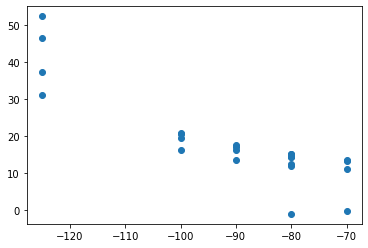

In [30]:
x = np.array(df_analysis['voltage'])
y = np.array(df_analysis['charge'])
plt.scatter(x,y)


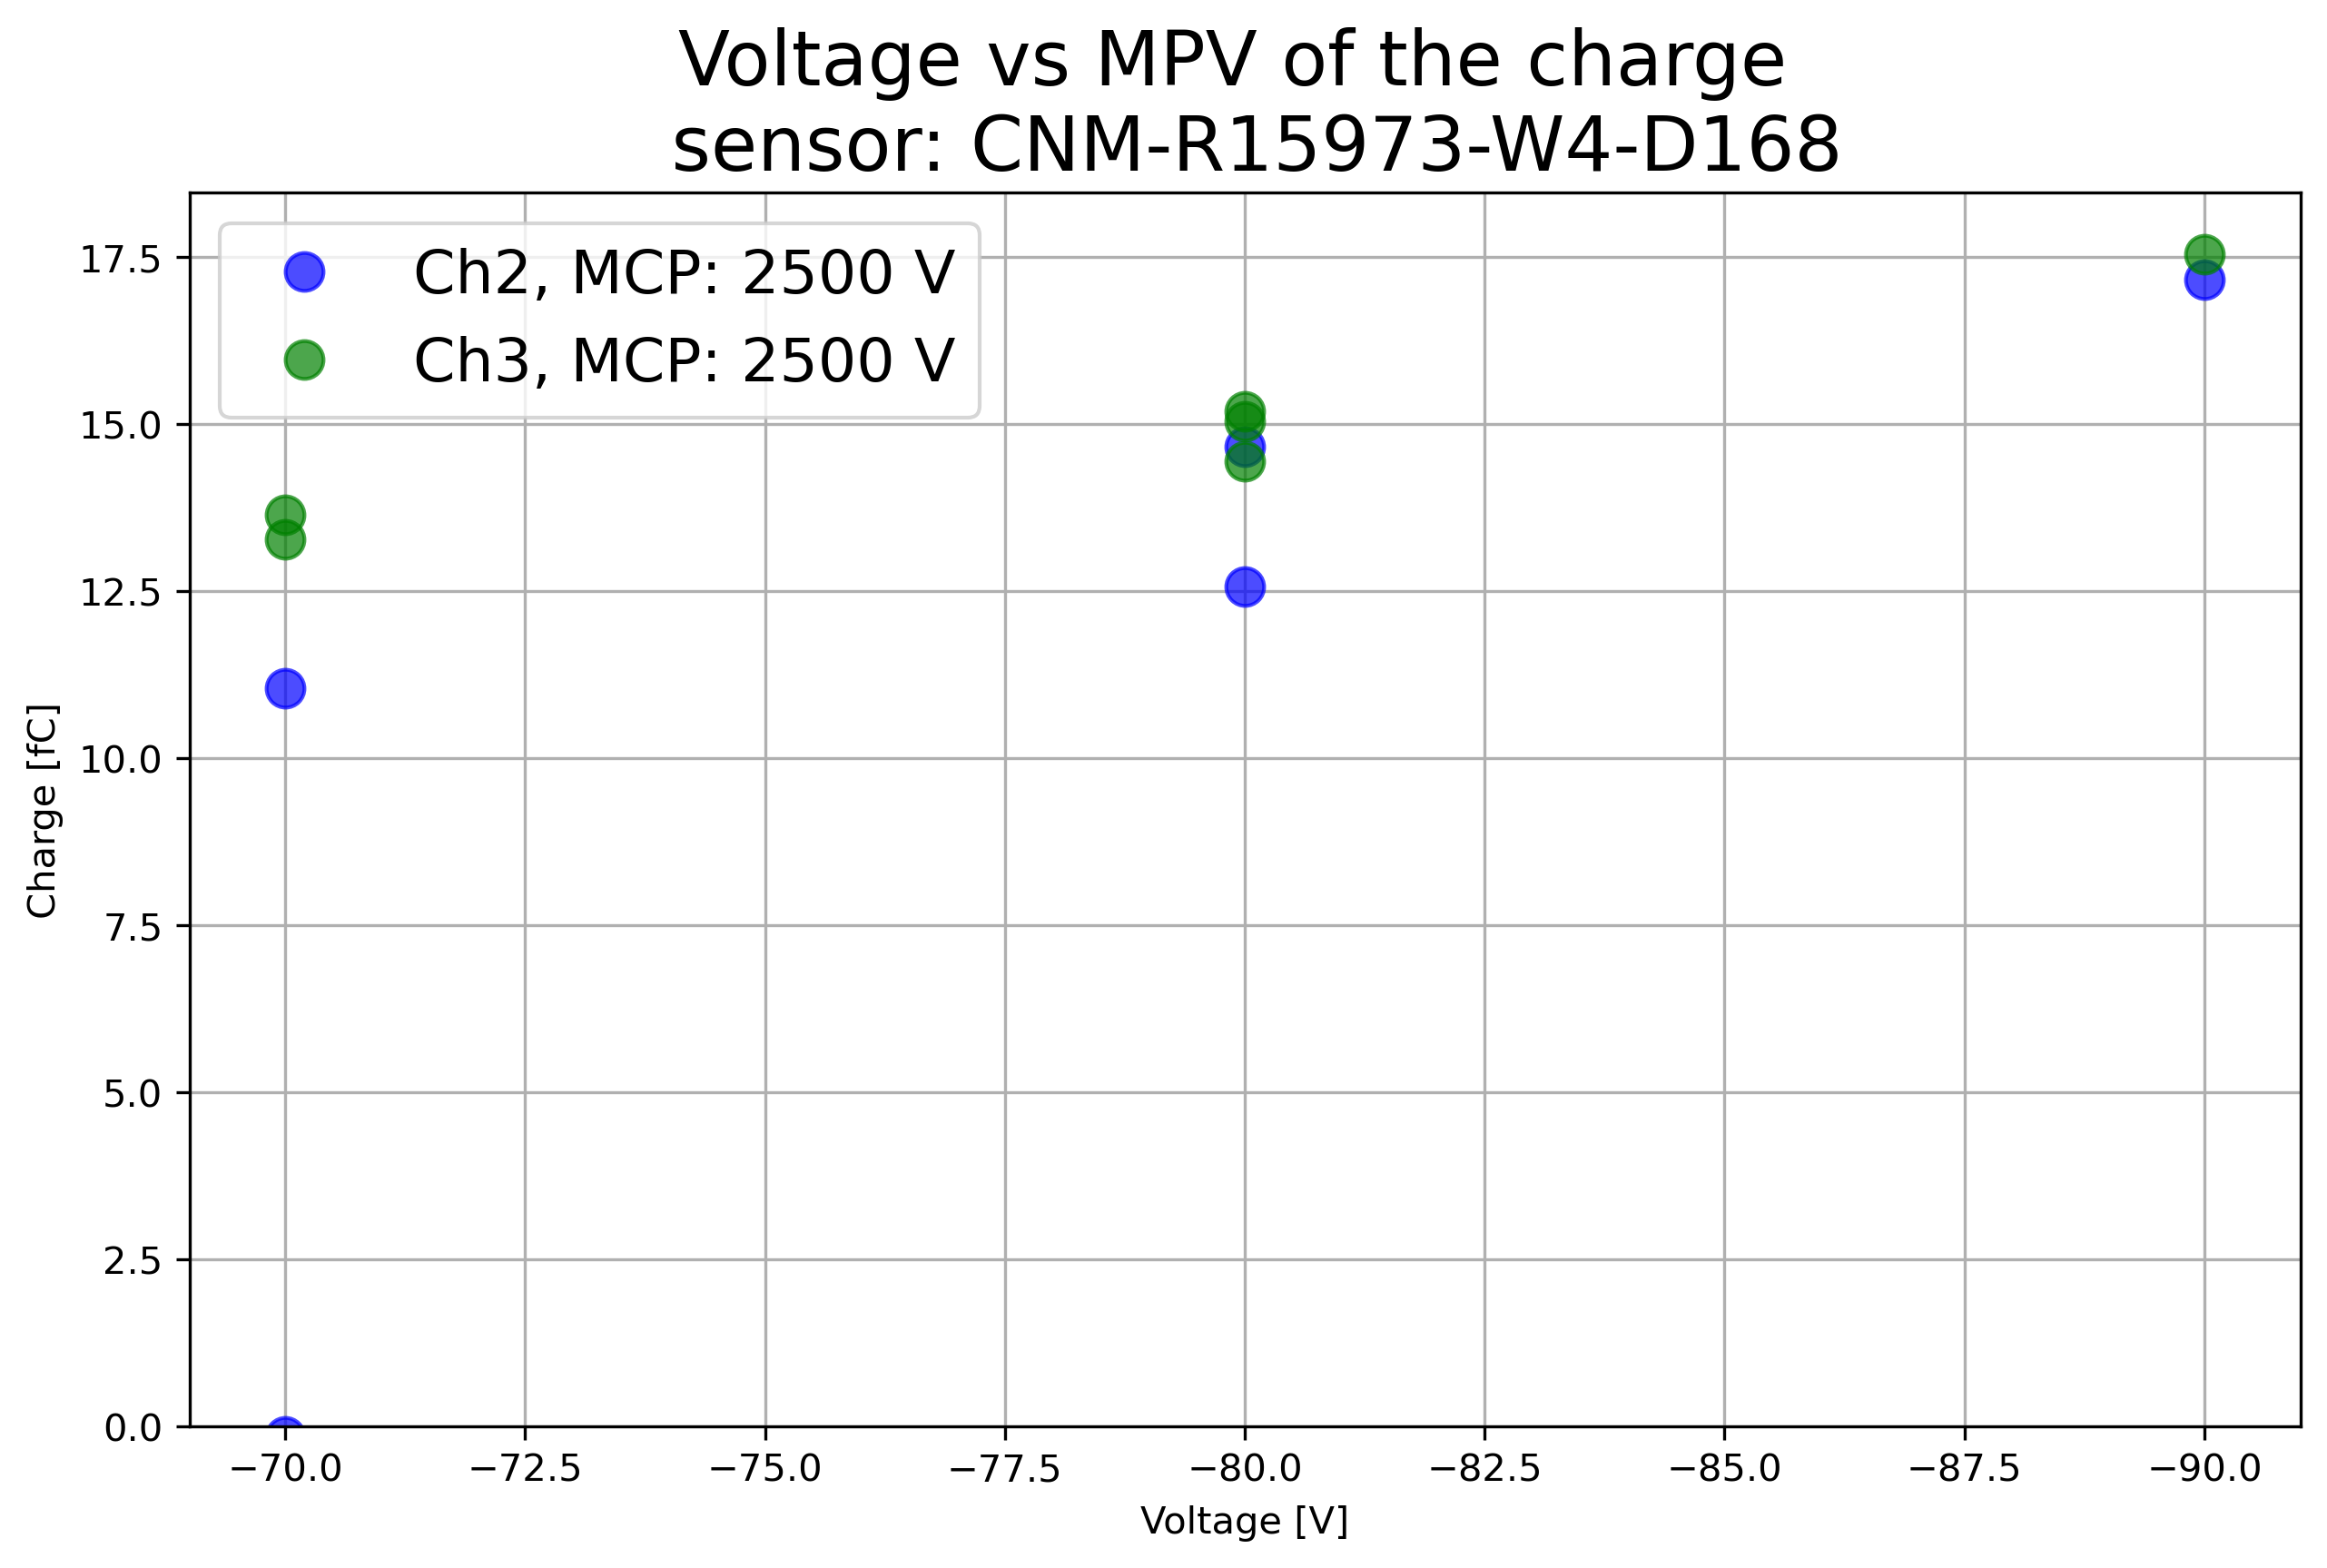

In [16]:
### no errorbar
# df_2500 = df_analysis.loc[df_analysis['MCP']==2500]
# df_2600 = df_analysis.loc[df_analysis['MCP']==2600]
# df_2800 = df_analysis.loc[df_analysis['MCP']==2800]

markers = ('o','v','^','<','>','P','D','X')
colormap = ['k','b','g','r','orange']

# df = dict_analysis_IME['normal_2500']
df = df_analysis

fig, ax = plt.subplots(figsize=(10,6), dpi=300)

for i, ch in enumerate(['Ch2','Ch3']):
    voltage = np.array(df_analysis.loc[idx[:,:,ch]]['voltage'])
    time = np.array(df_analysis.loc[idx[:,:,ch]]['time_resolution'])
    batch_labels = np.array(df_analysis.loc[idx[:,:,ch]].index.get_level_values('batch'))
    
    ax.plot(voltage, time,
            marker='o', markersize=10, alpha=0.7, color=colormap[i+1],
            label=f"{ch}")
    for x,y,label in zip(voltage,time,batch_labels):
        list_of_texts.append(ax.text(x,y, label)) 
        
        
for i, ch in enumerate(['Ch2','Ch3']):
    ax.plot(np.array(df.loc[idx[:,:,ch]]['voltage']),np.array(df.loc[idx[:,:,ch]]['charge']),
            marker='o', markersize=10, linewidth=0, alpha=0.7, color=colormap[i+1],
            label=f"{ch}, MCP: 2500 V")
#     ax.plot(np.array(df_2800.loc[idx[:,:,ch]]['voltage']),np.array(df_2800.loc[idx[:,:,ch]]['charge']),
#             marker='D', markersize=10, linewidth=0, alpha=0.7, color=colormap[i+1],
#             label=f"{ch}, MCP: 2800 V")

ax.set_title(f"Voltage vs MPV of the charge \n \
sensor: {dict_of_batches[this_batch].S[S].channels[ch].name}", fontsize=20)
ax.set_xlabel("Voltage [V]")
ax.set_ylabel("Charge [fC]")
ax.set_ylim(0,None)
ax.invert_xaxis()

ax.grid('--')
ax.legend(fontsize=16)

# fig.savefig(f"../various plots/{this_sensor}/{key_to_study}/voltage_vs_charge_{key_to_study}.svg")
# fig.savefig(os.path.join(pres_path,f"voltage_vs_charge_{key_to_study}.png"))

In [ ]:
fig, ax = plt.subplots(figsize=(10,6), dpi=300)

df = dict_analysis['angled']

for i, ch in enumerate(['Ch2','Ch3']):
    ax.plot(np.array(df.loc[idx[:,:,ch]]['angle']),np.array(df.loc[idx[:,:,ch]]['charge']),
            marker='o', markersize=10, linewidth=0, alpha=0.7, color=colormap[i+1],
            label=f"{ch}, voltage MCP: 2500 V")
#     ax.plot(np.array(df_2800.loc[idx[:,:,ch]]['angle']),np.array(df_2800.loc[idx[:,:,ch]]['charge']),
#             marker='D', markersize=10, linewidth=0, alpha=0.7, color=colormap[i+1],
#             label=f"{ch}, MCP: 2800 V")
    
ax.set_title(f"Angle vs charge plot ({key_to_study}) \n \
sensor: {dict_of_batches[this_batch].S[S].channels[ch].name}", fontsize=20)
ax.set_xlabel("Angle°")
ax.set_ylabel("Charge [fC]")
ax.set_ylim(0,None)

ax.grid('--')
ax.legend(fontsize=16)

# fig.savefig(f"../various plots/{this_sensor}/{key_to_study}/angle_vs_charge_{key_to_study}.svg")


# CNM
looking specifically at one sensor

In [ ]:
this_sensor = 'CNM'
IME_names = set()
for name in unique_names:
    if this_sensor in name:
        print(name)
        IME_names.add(name)


Chi^2 formula:
$$
\chi^2 = \sum_i^N \frac{(E_i-O_i)^2}{E_i}\\
\chi^2_{reduced} = \frac{\chi^2}{N-d.o.f}
$$